# Image Classification Using Swin Transformer

Image_resolution = 224 x 224

patch_size = 4 x 4

number of features in one patch = 4 x 4 x 3 = 48

total number of patches in the whole image = 224/4 x 224/4 = 3136

In [2]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

C:\Users\Madari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Madari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Root directory containing the 44 folders
root_dir = r'E:\MAJOR PROJECT\Dataset\My MSL\My_MSL'

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor()           # Convert to a tensor
])

# Process all images in the directory structure
for folder_name in os.listdir(root_dir):  # Iterate through each folder
    folder_path = os.path.join(root_dir, folder_name)
    
    if os.path.isdir(folder_path):  # Ensure it's a directory
        print(f"Processing folder: {folder_name}")
        
        for image_name in os.listdir(folder_path):  # Iterate through each image in the folder
            image_path = os.path.join(folder_path, image_name)
            
            try:
                # Open and process the image
                image = Image.open(image_path).convert('RGB')  # Convert to RGB to handle grayscale images
                tensor_image = transform(image)  # Apply the transformation
                
                # Add batch dimension
                tensor_image = tensor_image.unsqueeze(0)  # Shape: (1, 3, 224, 224)
                
                # Print the shape for verification
                print(f"Processed image: {image_name}, Tensor shape: {tensor_image.shape}")
                
            except Exception as e:
                # Handle errors (e.g., corrupted files)
                print(f"Error processing {image_name} in {folder_name}: {e}")



# from PIL import Image
# import torch
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt



# # Load the image file
# image_path = r'E:\MAJOR PROJECT\Dataset\My MSL\My_MSL'
# image = Image.open(image_path)



# # Define the transformation
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize the image to 224x224
#     transforms.ToTensor()  # Convert the image to a tensor
# ])


# # Apply the transformation to the image
# tensor_image = transform(image)

# # Reshape the tensor to match the expected shape
# tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# # Print the shape and data type of the tensor
# print("Tensor shape:", tensor_image.shape)
# print("Tensor data type:", tensor_image.dtype)

# # Permute dimensions to match the expected shape (B, H, W, C)
# tensor_image = tensor_image.permute(0, 2, 3, 1)


Processing folder: 1.അ
Processed image: 1 (1).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 1 (2).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 1 (3).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 1 (4).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 10 (1).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 10 (2).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 10 (3).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 10 (4).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 11 (1).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 11 (2).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 11 (3).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 11 (4).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 2 (1).jpg, Tensor shape: torch.Size([1, 3, 224, 224])
Processed image: 2 (2).jpg, Tensor shape: torc

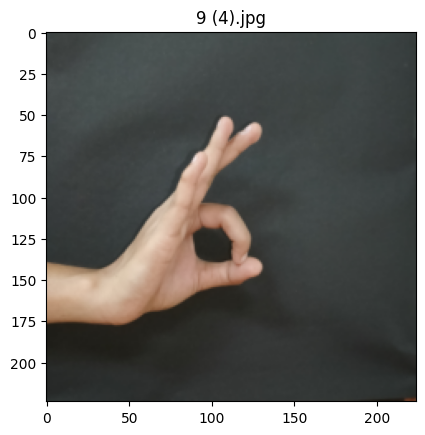

In [11]:
plt.imshow(tensor_image.squeeze(0).permute(1, 2, 0))  # Convert back to (H, W, C)
plt.title(image_name)
plt.show()

In [14]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)
        
    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """
    
    B, H, W, C = x.shape
    
    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C) 
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    
    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)
    
    return patches


Windows shape: torch.Size([3136, 4, 4, 3])


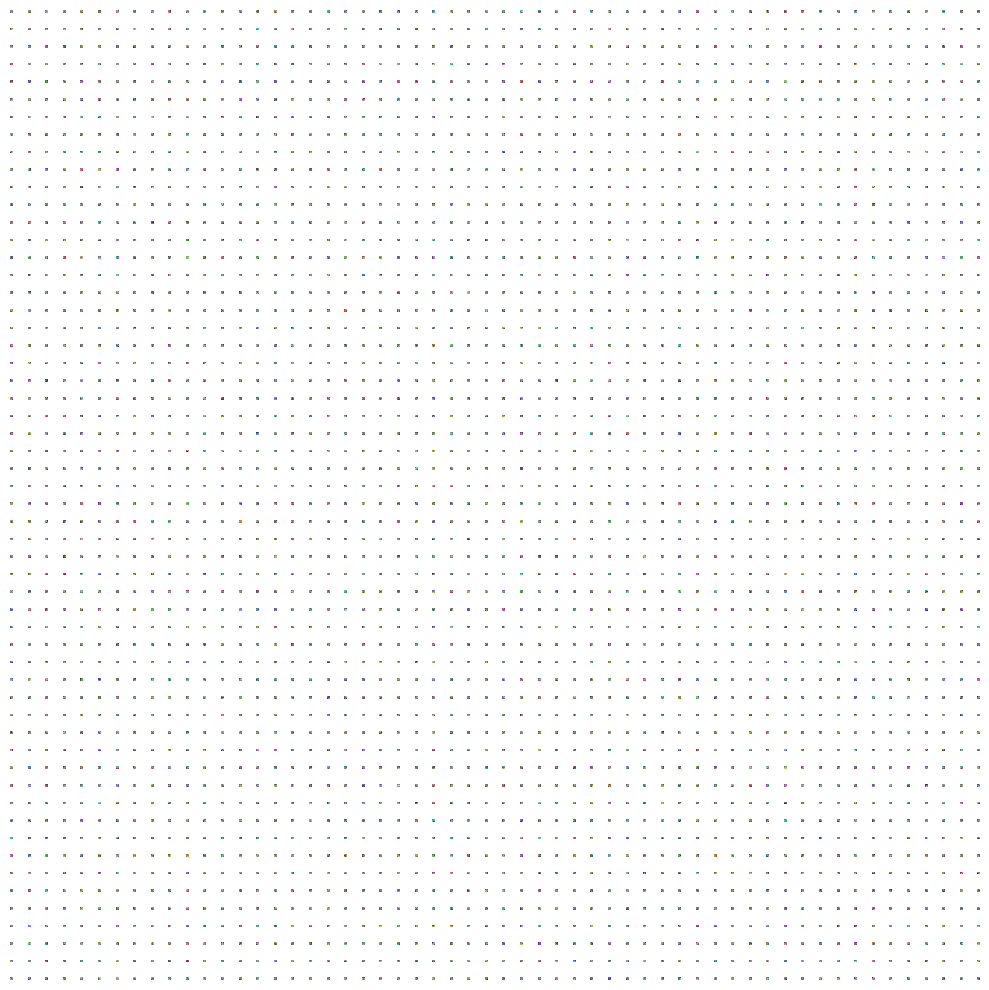

In [16]:
def window_partition(x, window_size):
    """
    Partition an image tensor into non-overlapping windows of size window_size x window_size.
    
    Args:
        x: Input tensor of shape (B, H, W, C)
        window_size: Size of each window
    
    Returns:
        windows: Tensor of shape (num_patches, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    # Ensure height and width are divisible by window_size
    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size
    x = torch.nn.functional.pad(x, (0, 0, 0, pad_w, 0, pad_h))  # Pad H and W dimensions

    # Update H and W after padding
    H, W = x.shape[1:3]
    num_patches_h = H // window_size
    num_patches_w = W // window_size

    # Reshape to get patches
    x = x.view(B, num_patches_h, window_size, num_patches_w, window_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()  # Rearrange dimensions
    patches = patches.view(-1, window_size, window_size, C)  # Flatten into (num_patches, window_size, window_size, C)
    return patches

# Create a sample tensor_image
tensor_image = torch.rand(1, 224, 224, 3)  # Simulated input tensor

# Partition the tensor into windows
window_size = 4
windows = window_partition(tensor_image, window_size)

# Get the number of patches and patch size
num_patches, patch_size, _, _ = windows.shape
print("Windows shape:", windows.shape)  # Should print (3136, 4, 4, 3)

# Visualize the patches
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    if i < num_patches:
        patch = windows[i].numpy()
        ax.imshow(patch)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

# # Call the window_partition function on the tensor_image
# window_size = 4
# windows = window_partition(tensor_image, window_size)

# num_patches, patch_size, _, _ = windows.shape

# # Print the shape of the output windows
# print("Windows shape:", windows.shape)

# print("num_patches ",num_patches)

# # Calculate the number of rows and columns in the grid
# num_rows = int(num_patches ** 0.5)
# num_cols = num_patches // num_rows

# # Create a subplot grid
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# # Iterate over the patches and plot them
# for i, ax in enumerate(axs.flat):
#     patch = windows[i].numpy()
#     ax.imshow(patch)
#     ax.axis("off")

# # Adjust the spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()


# # (224/4 * 224/4 =56*56 = 3136 patches of size 4*4)

# displaying all the patches (4*4) to visualize properly

Total number of windows: 3136


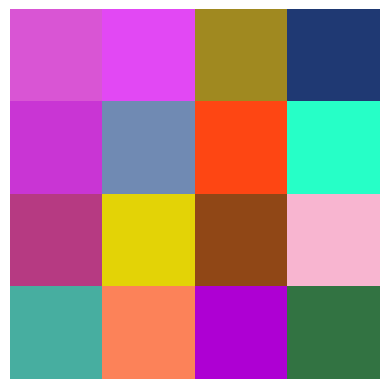

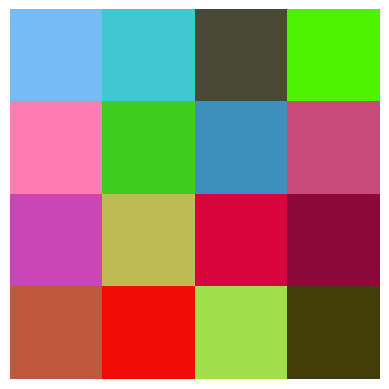

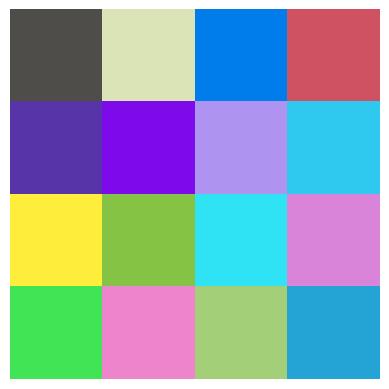

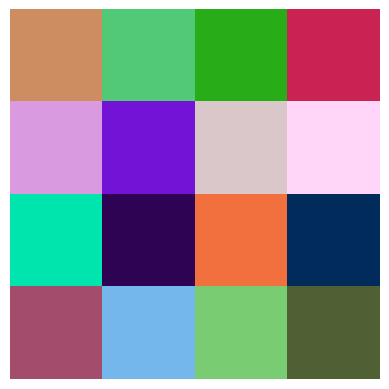

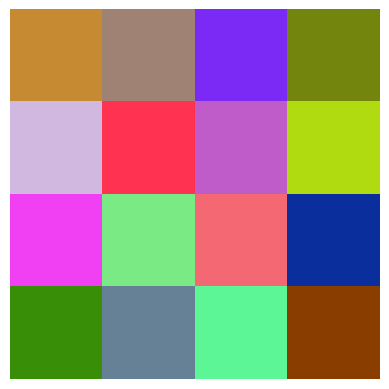

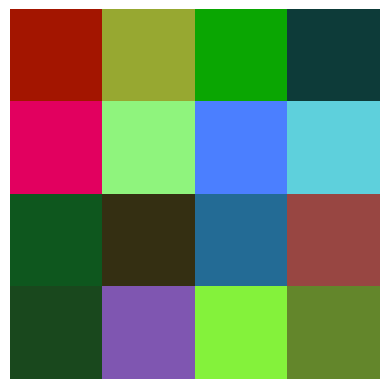

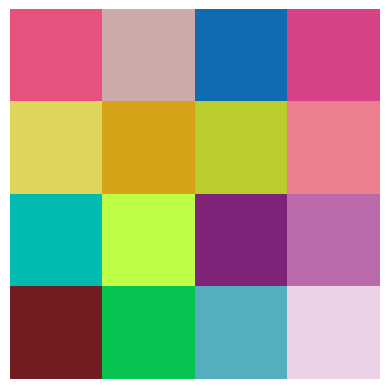

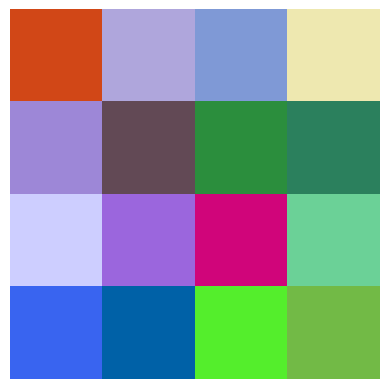

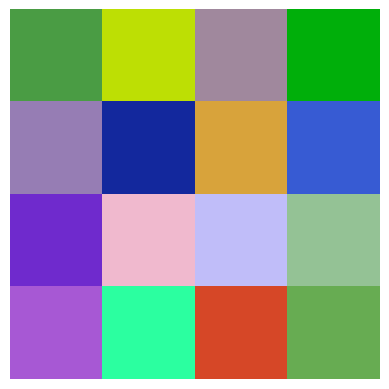

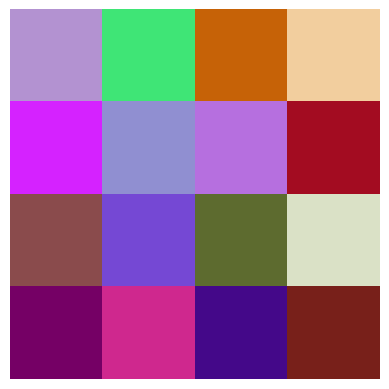

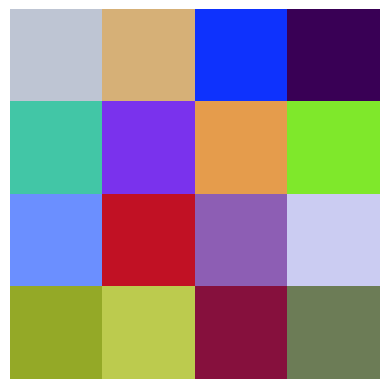

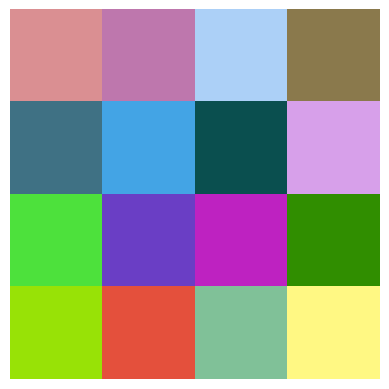

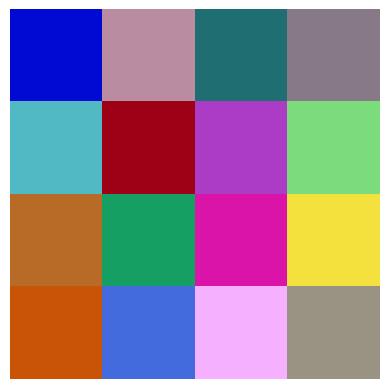

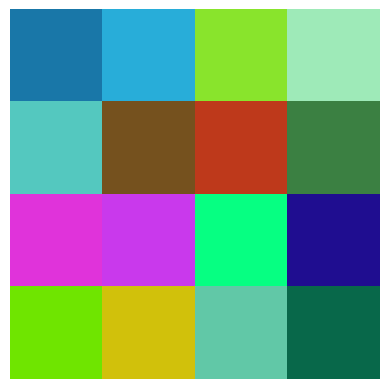

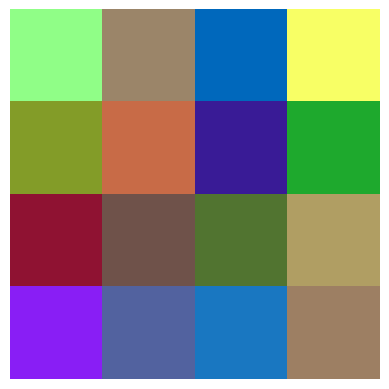

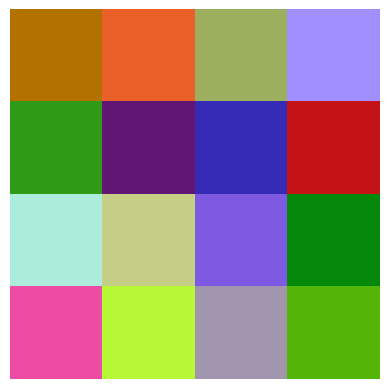

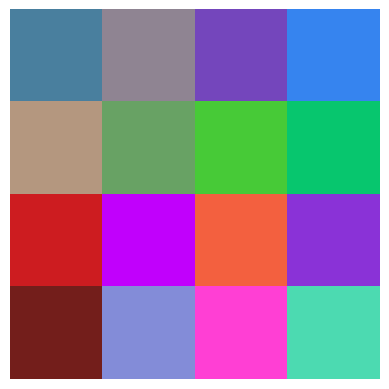

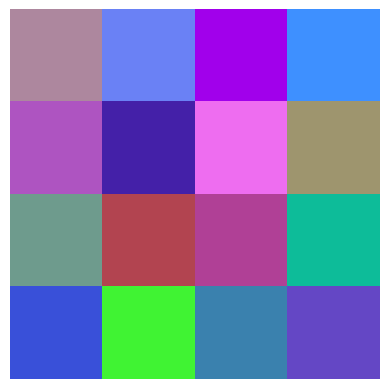

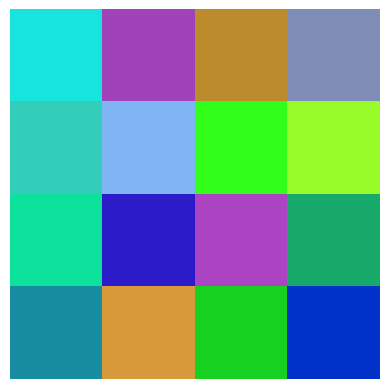

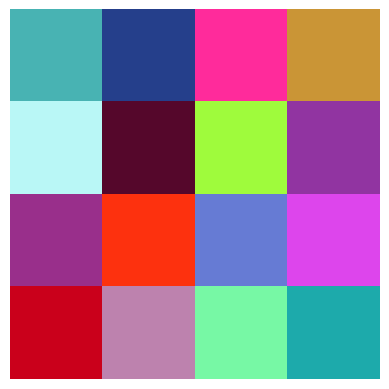

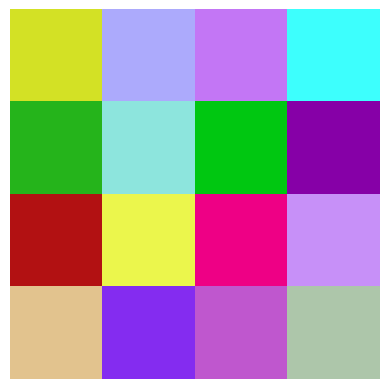

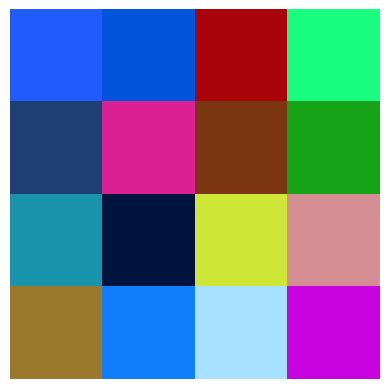

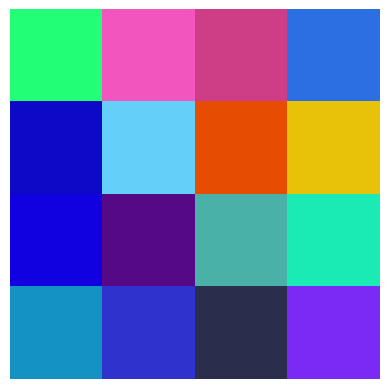

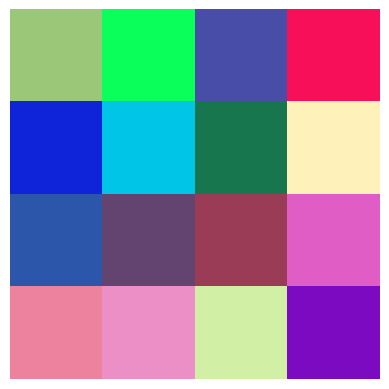

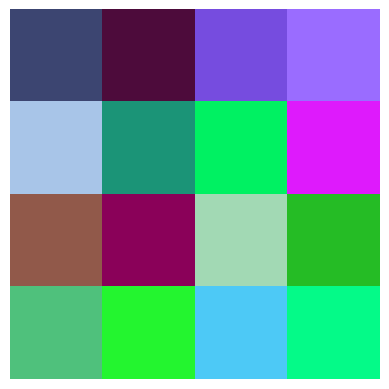

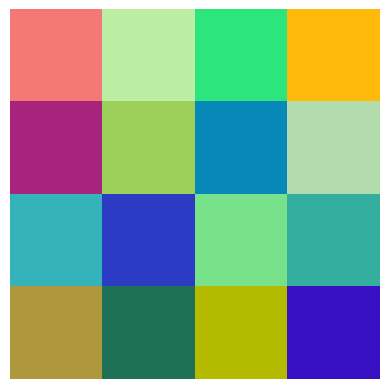

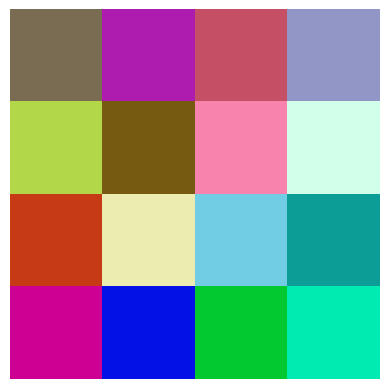

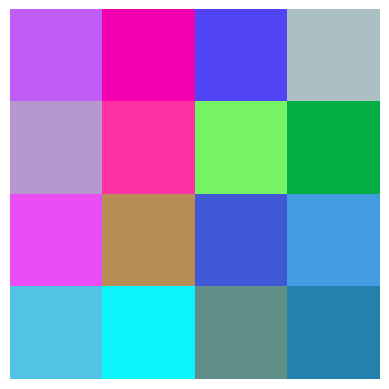

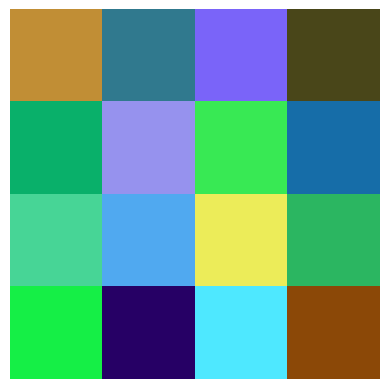

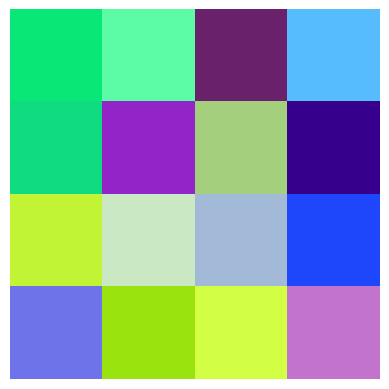

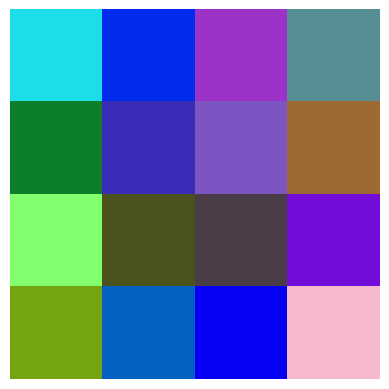

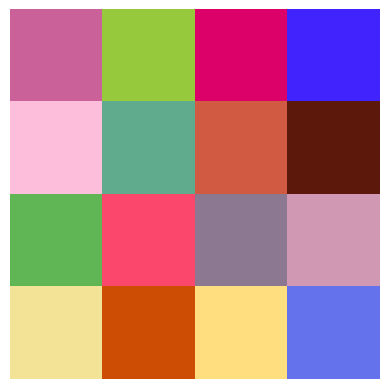

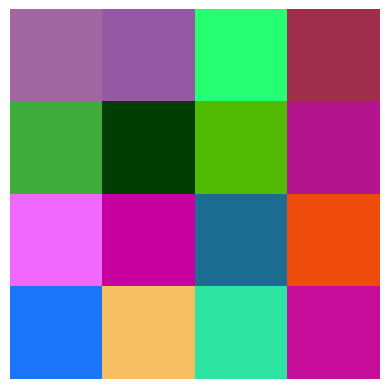

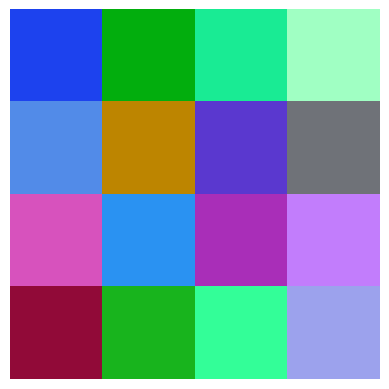

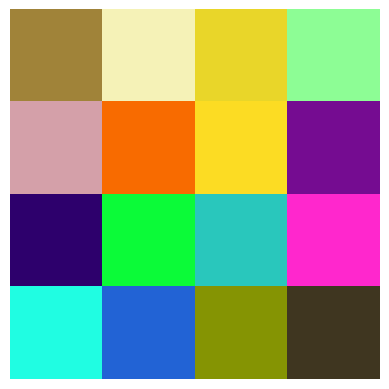

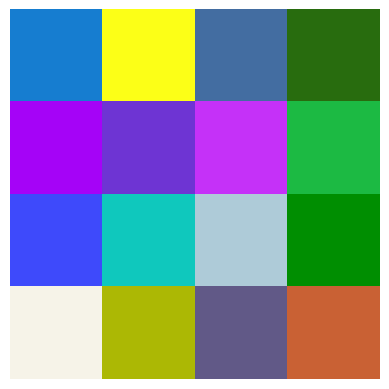

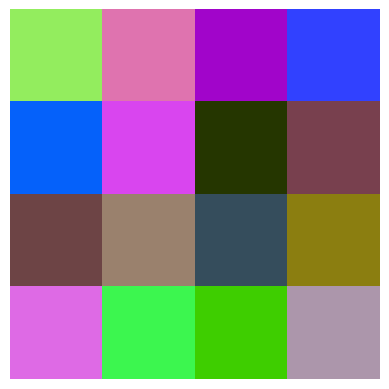

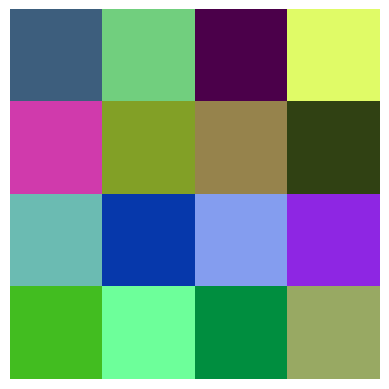

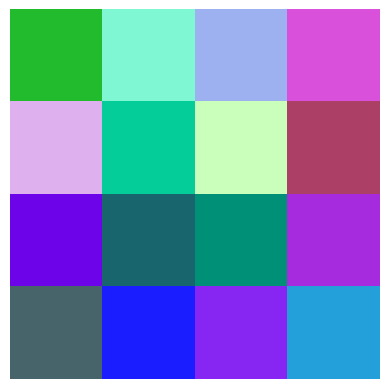

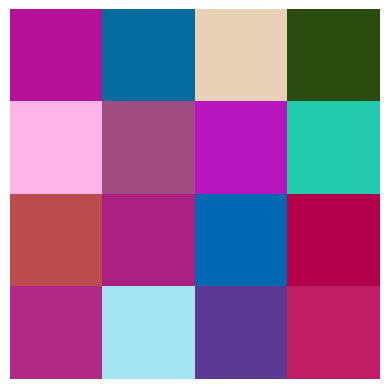

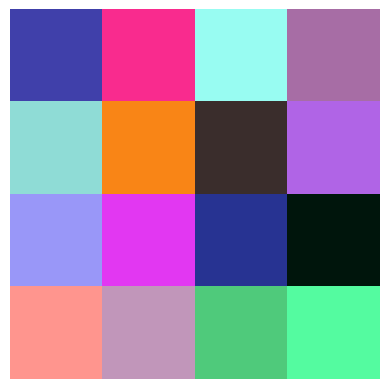

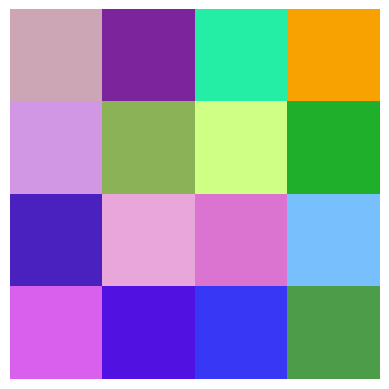

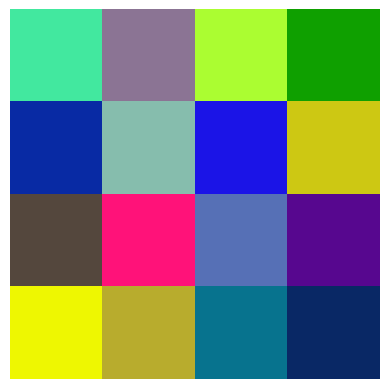

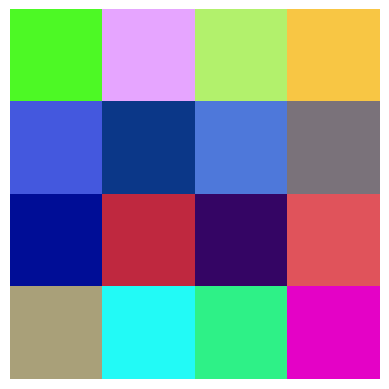

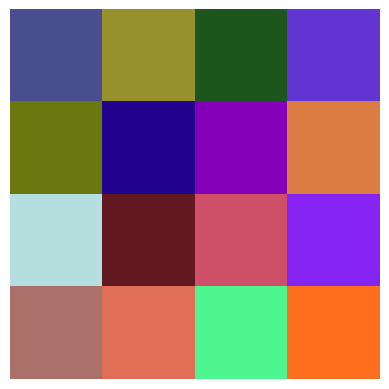

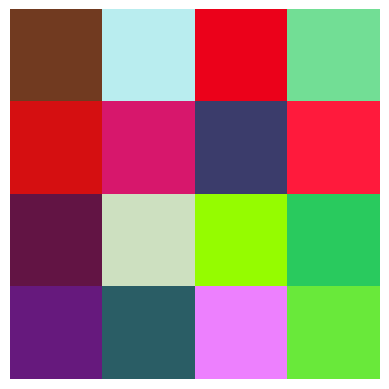

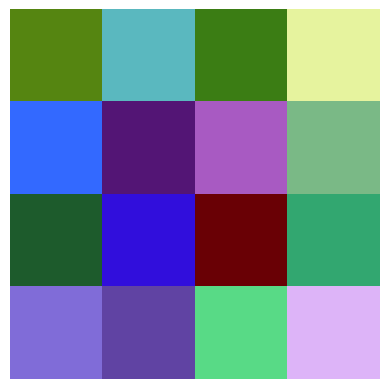

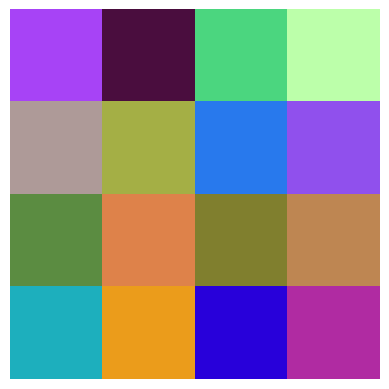

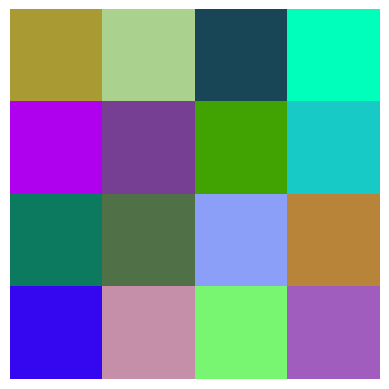

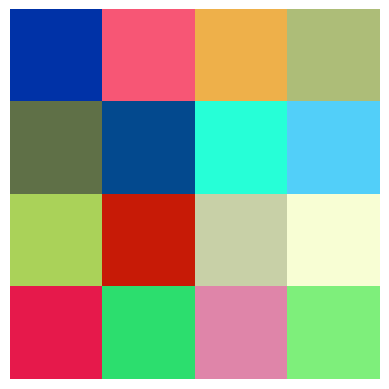

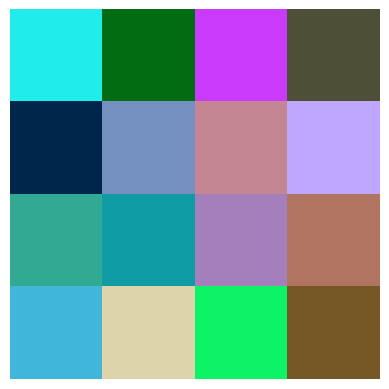

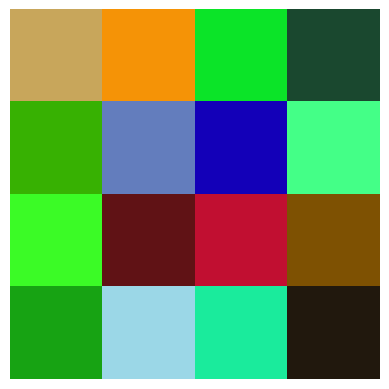

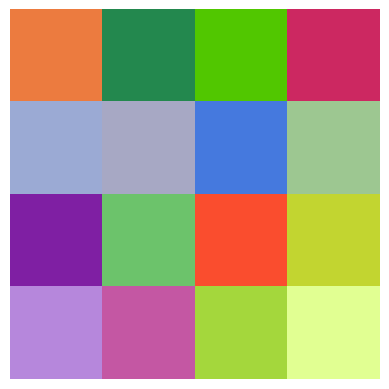

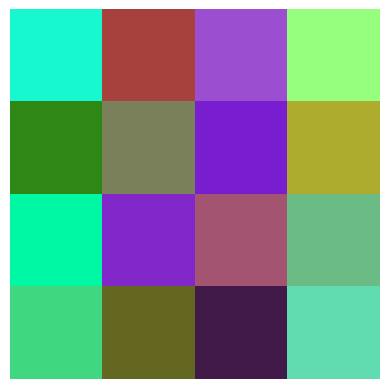

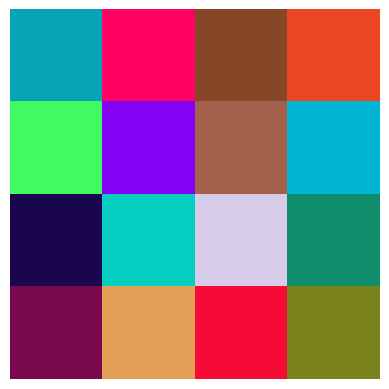

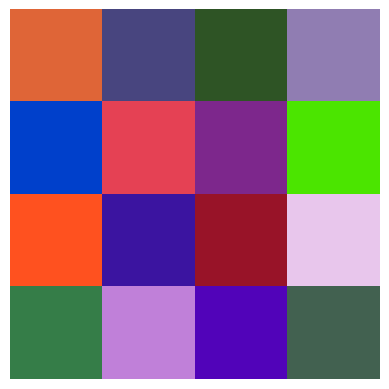

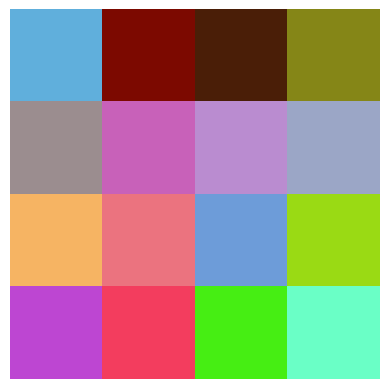

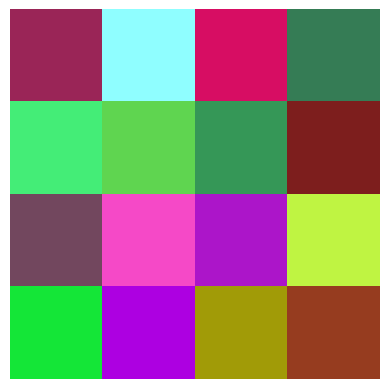

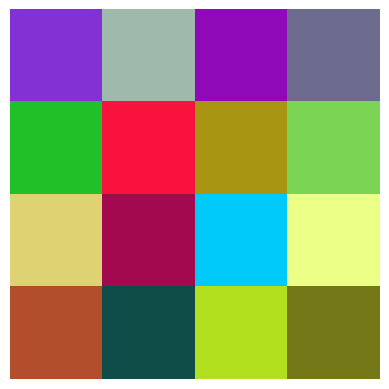

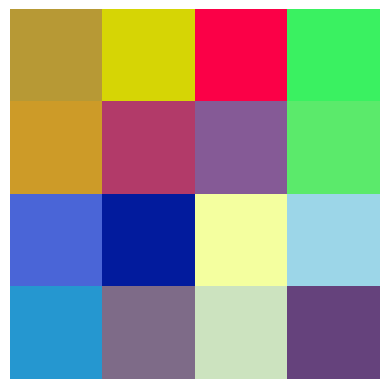

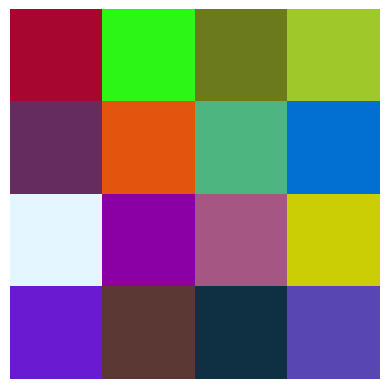

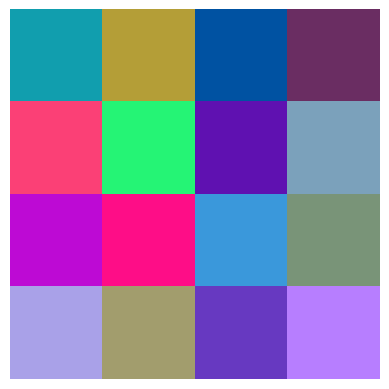

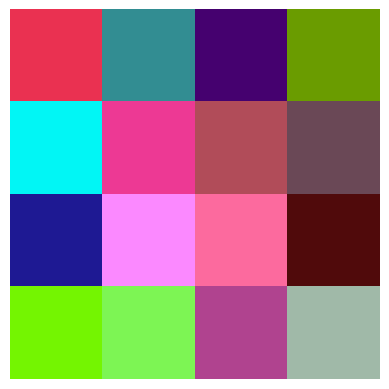

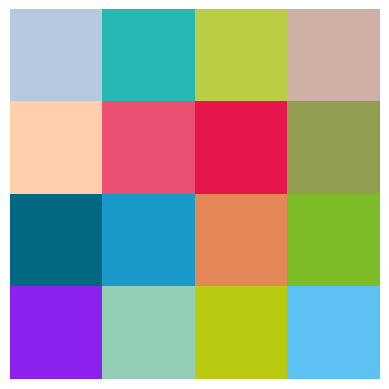

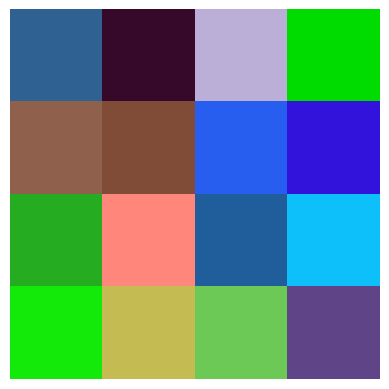

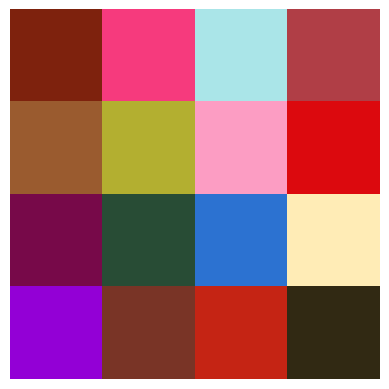

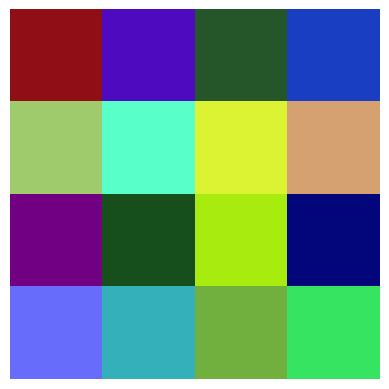

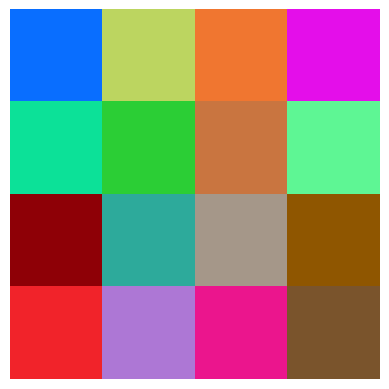

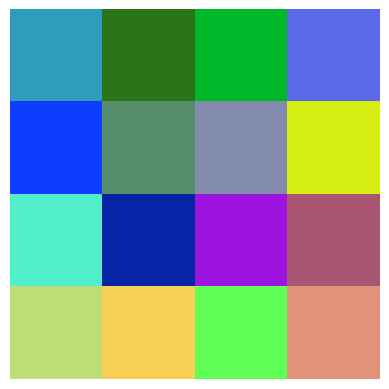

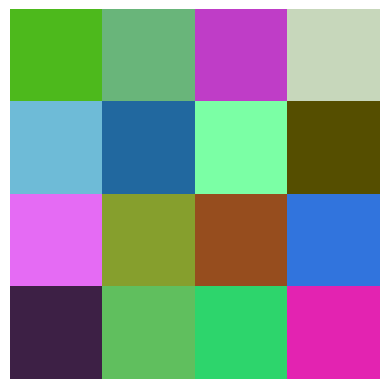

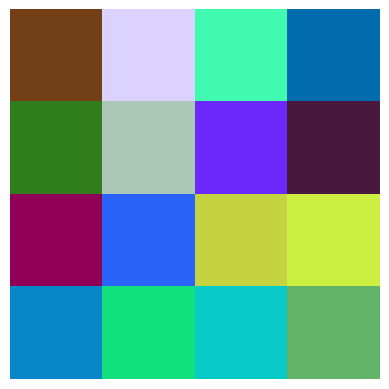

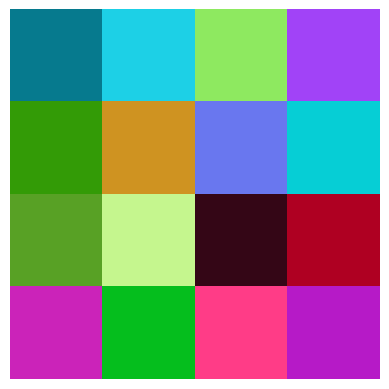

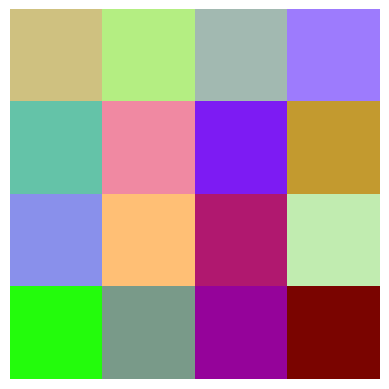

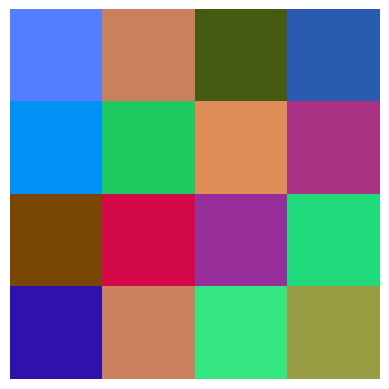

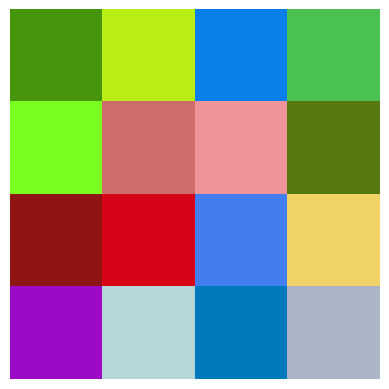

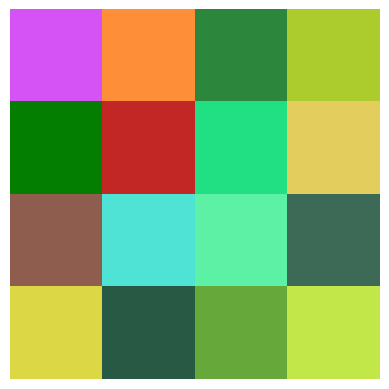

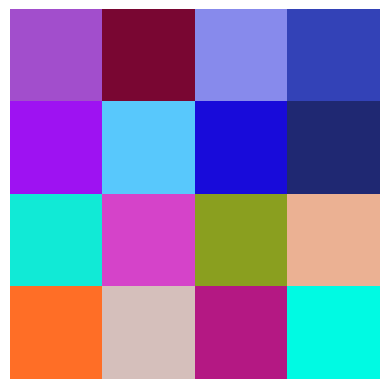

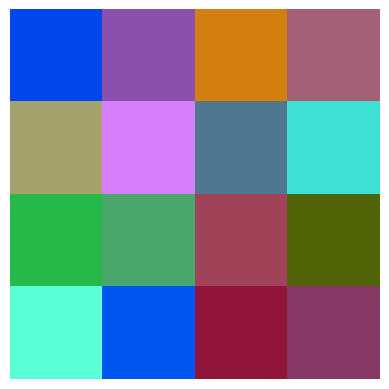

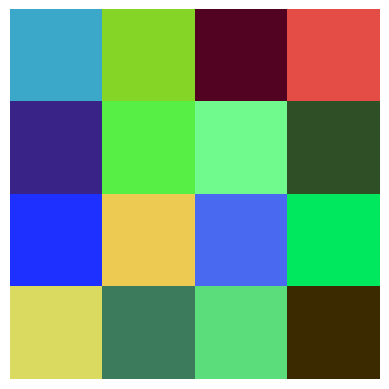

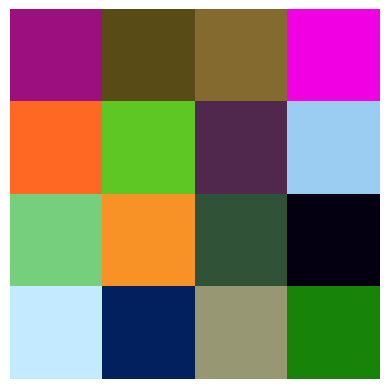

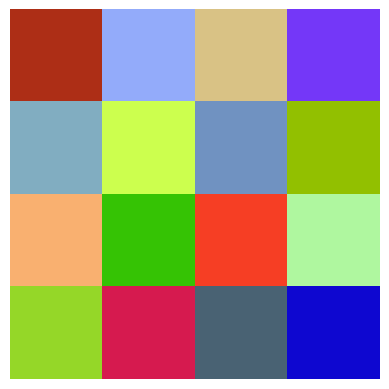

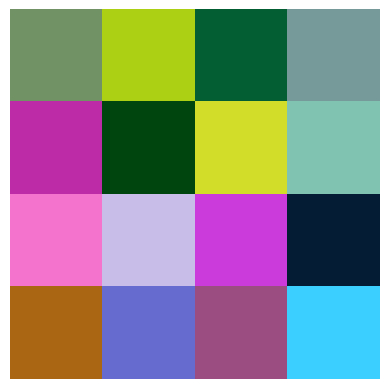

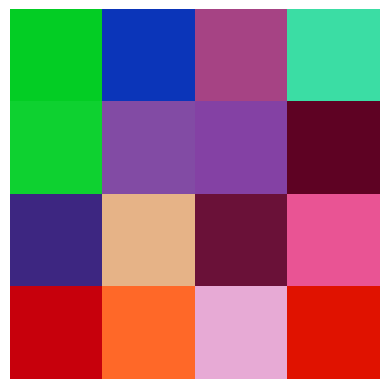

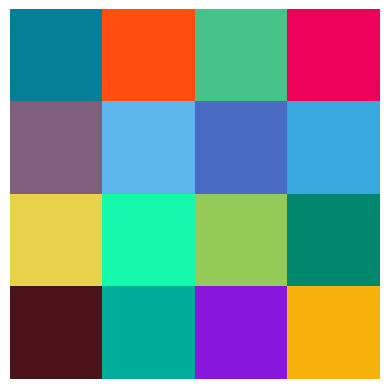

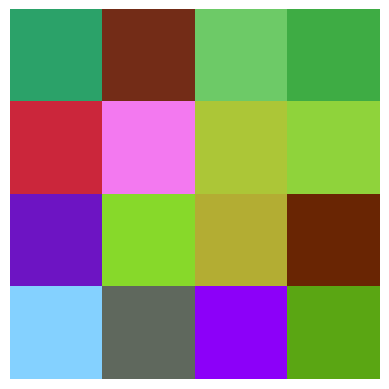

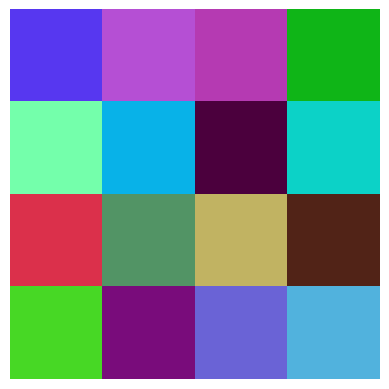

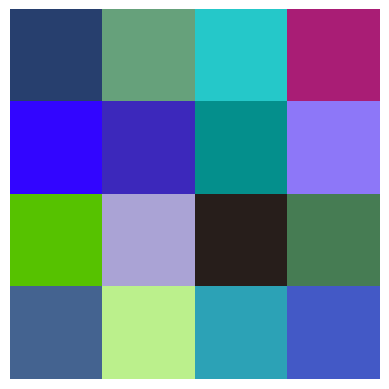

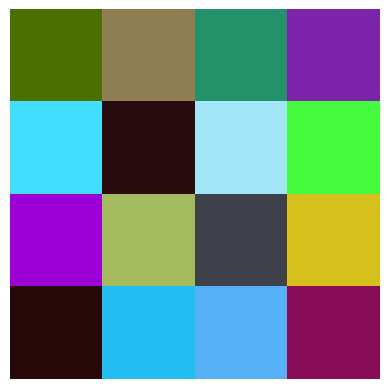

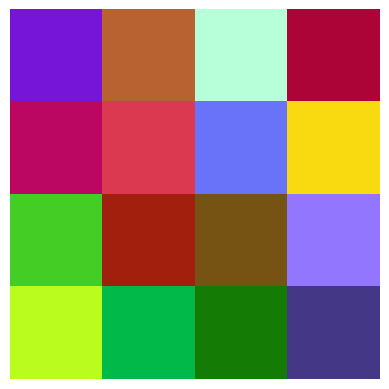

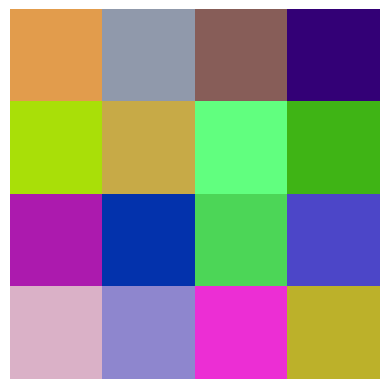

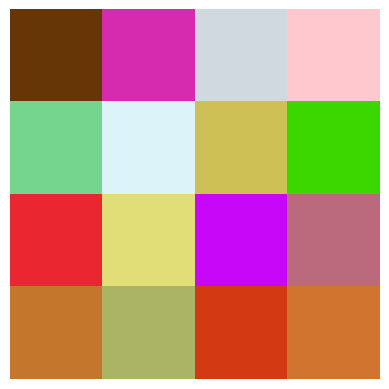

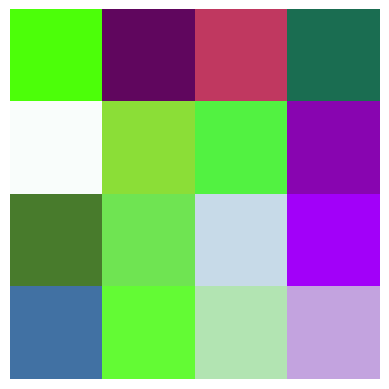

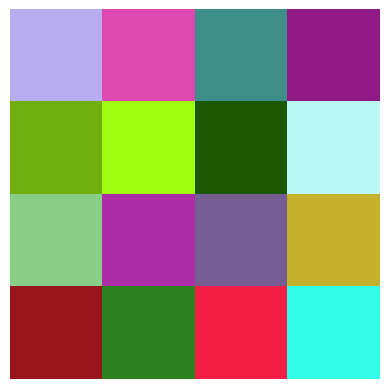

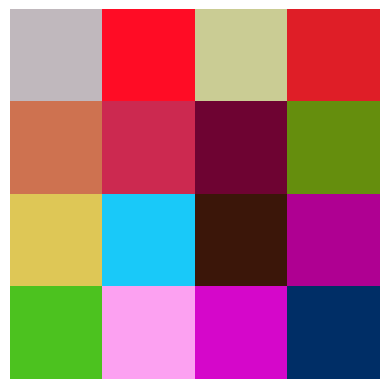

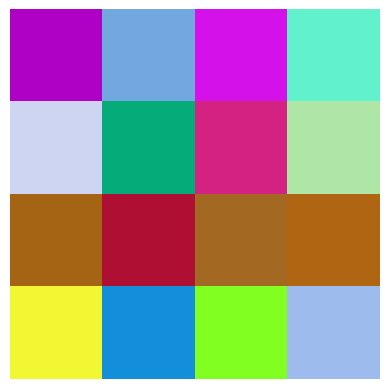

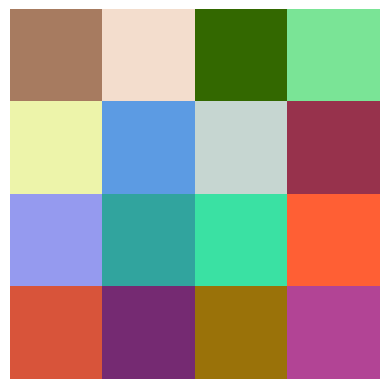

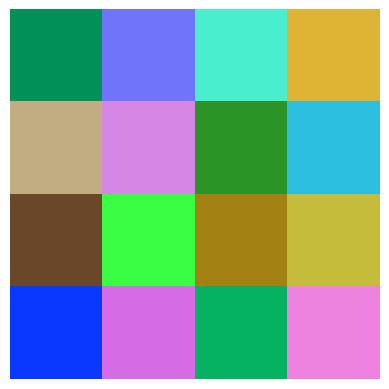

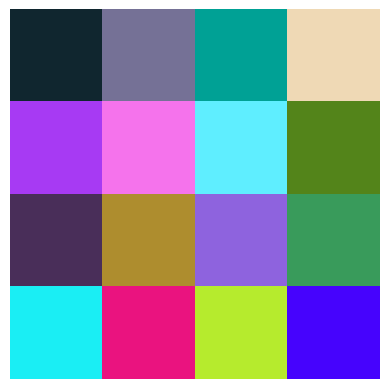

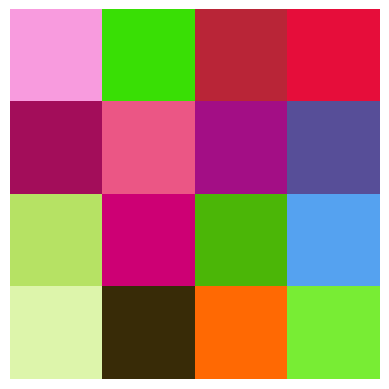

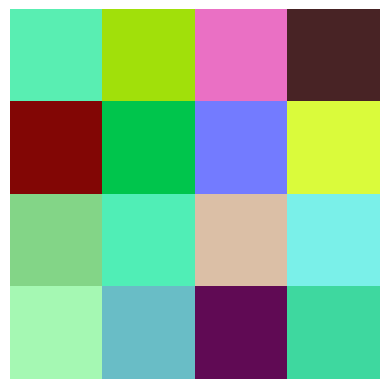

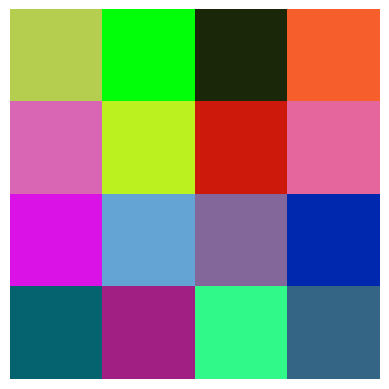

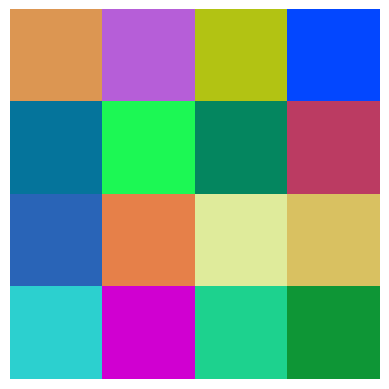

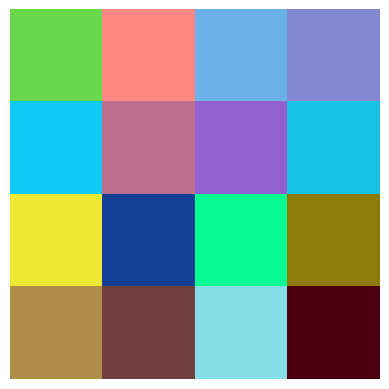

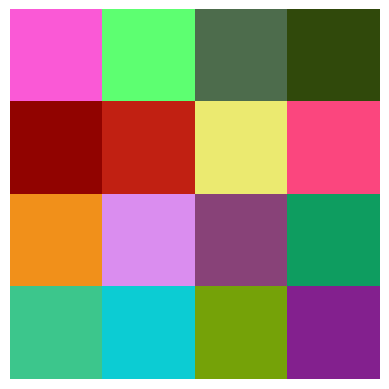

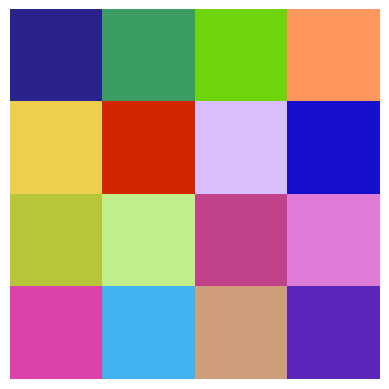

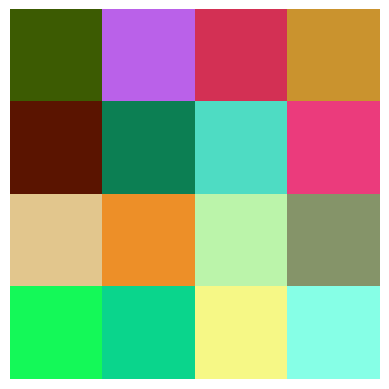

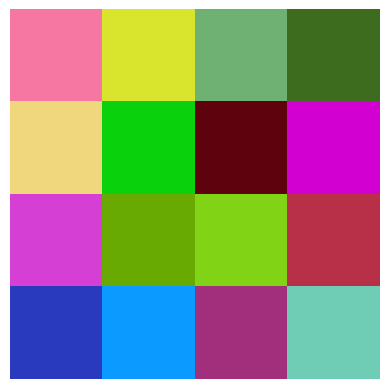

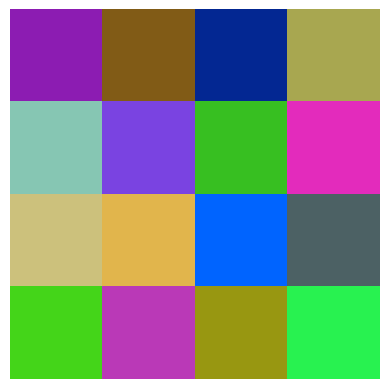

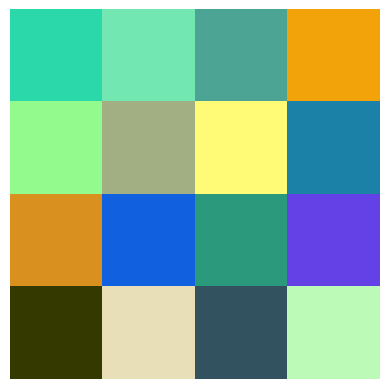

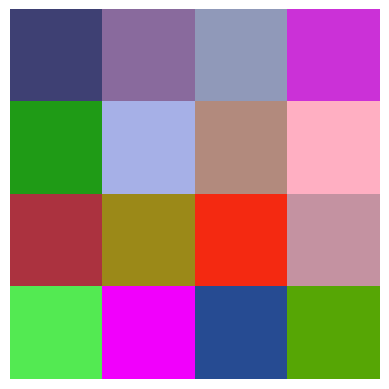

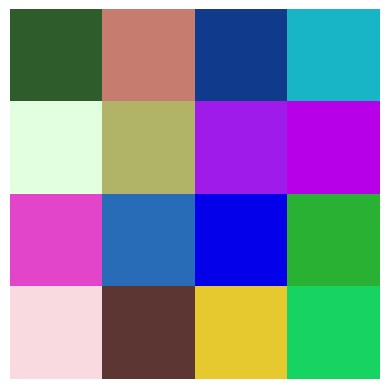

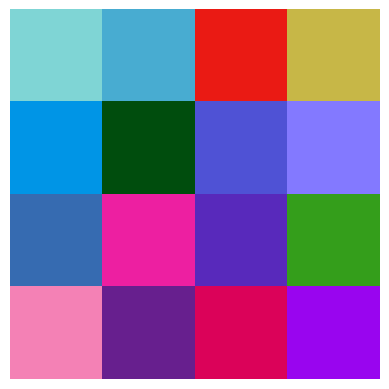

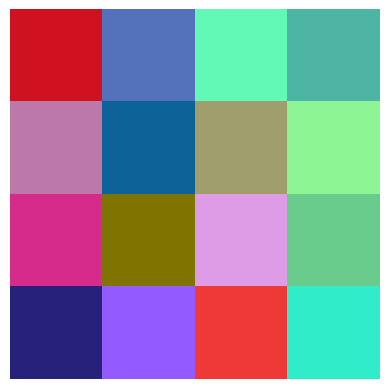

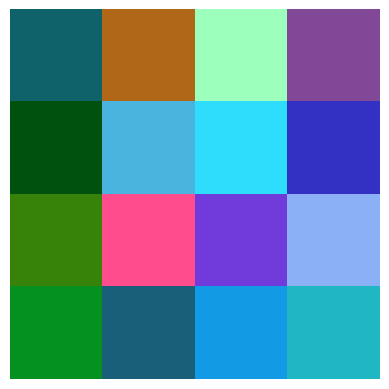

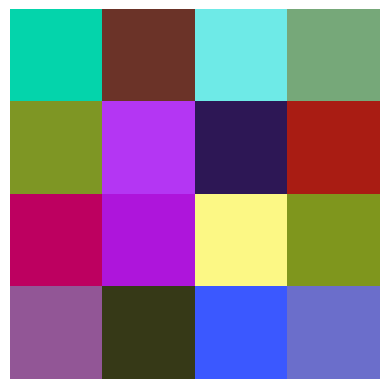

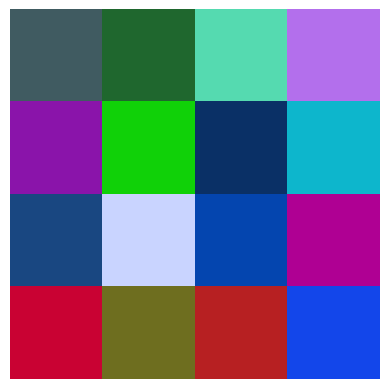

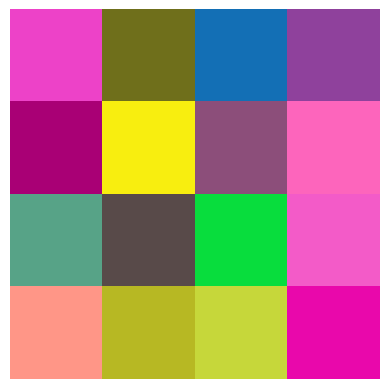

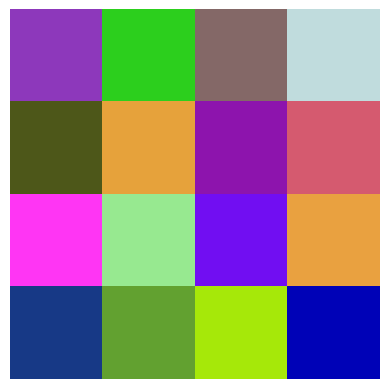

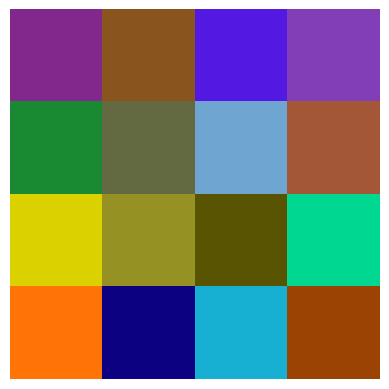

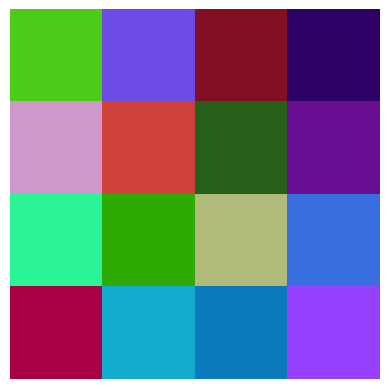

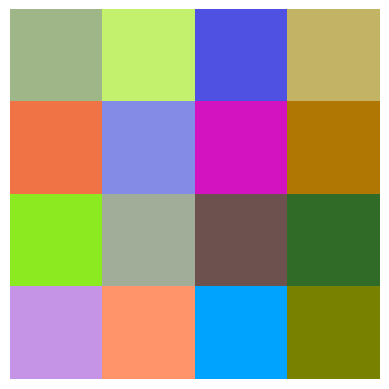

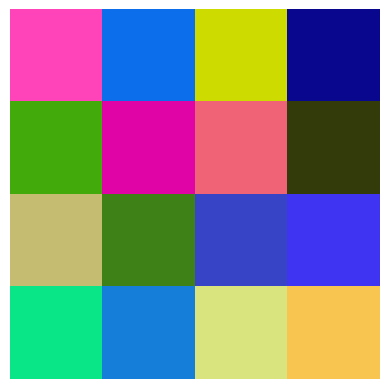

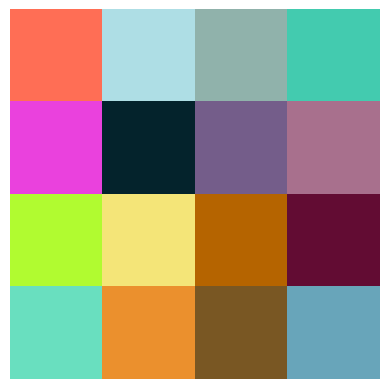

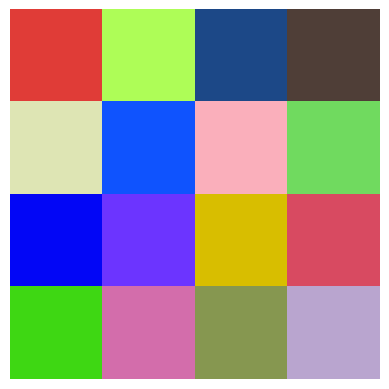

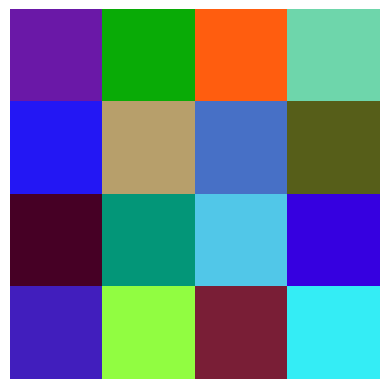

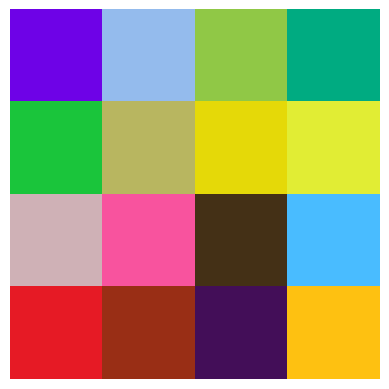

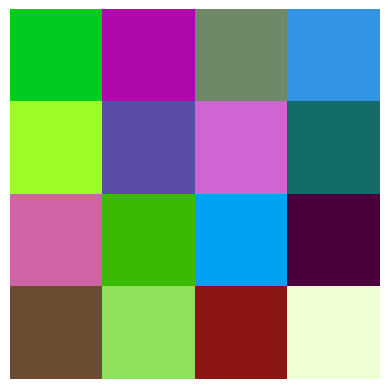

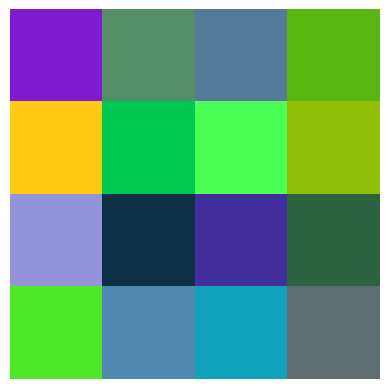

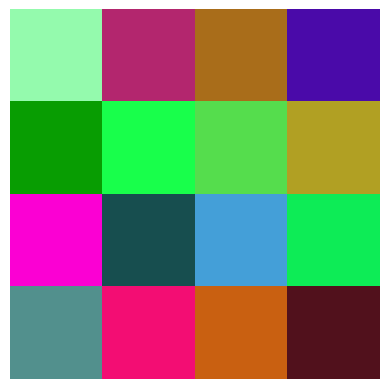

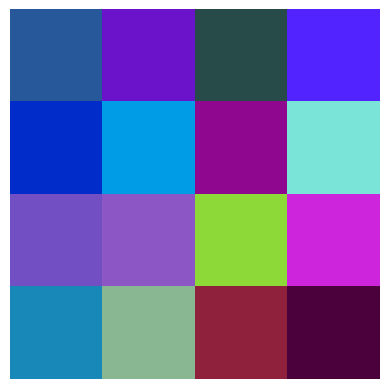

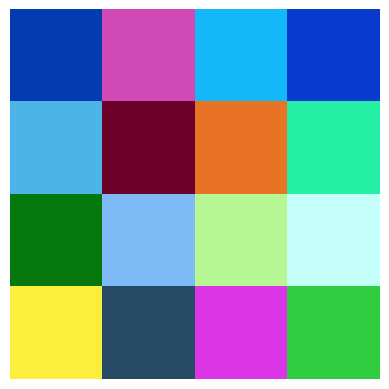

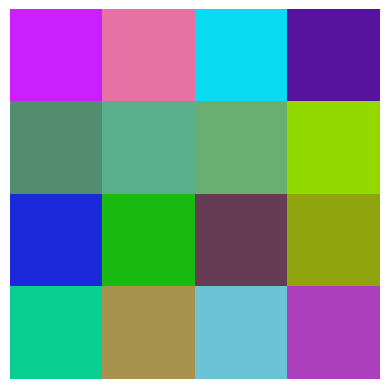

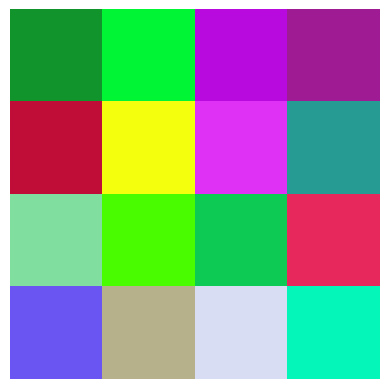

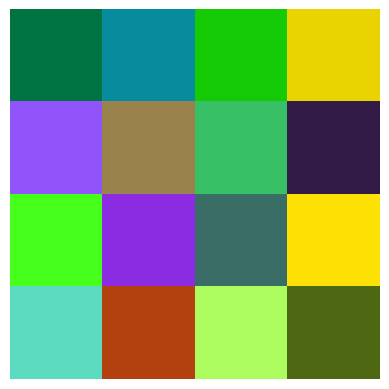

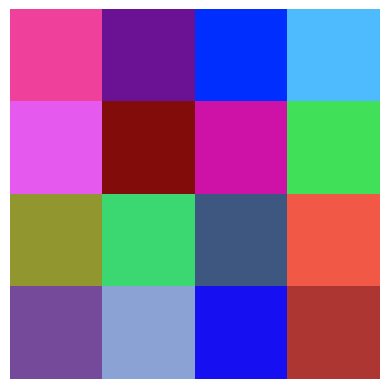

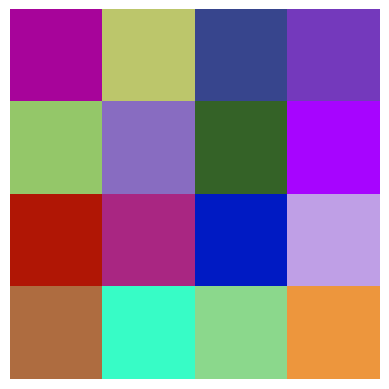

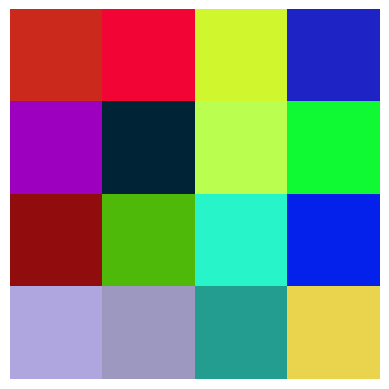

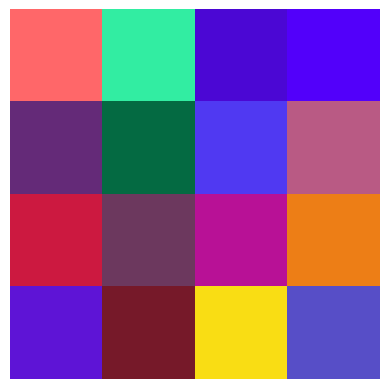

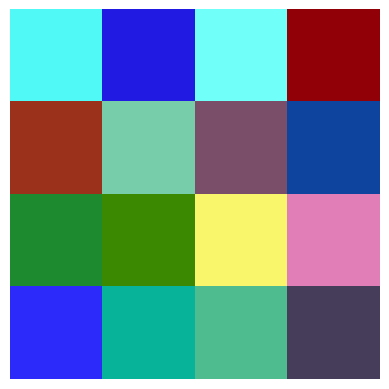

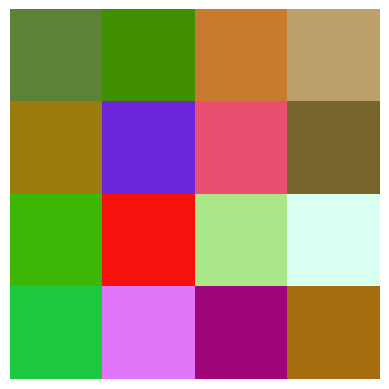

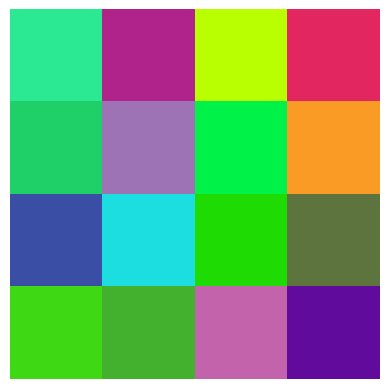

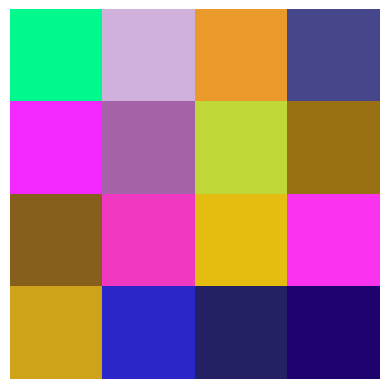

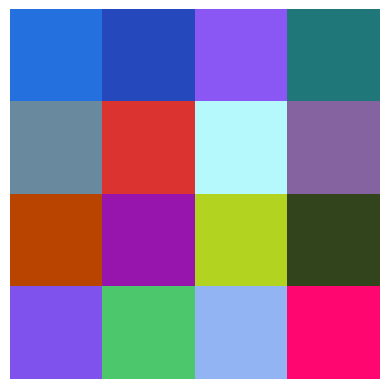

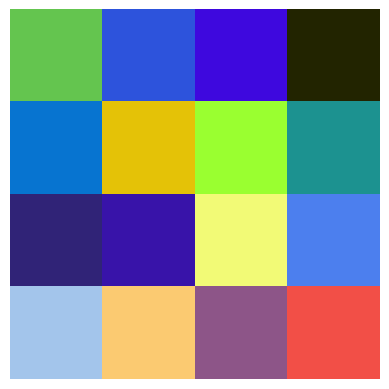

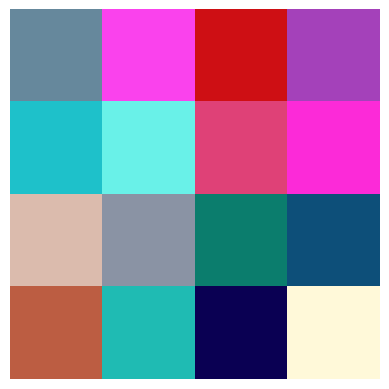

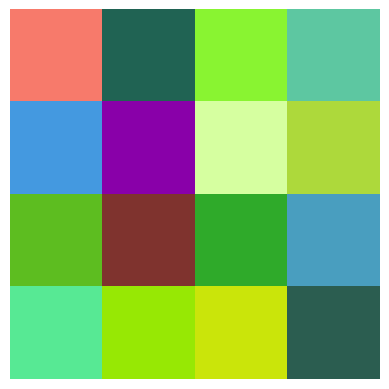

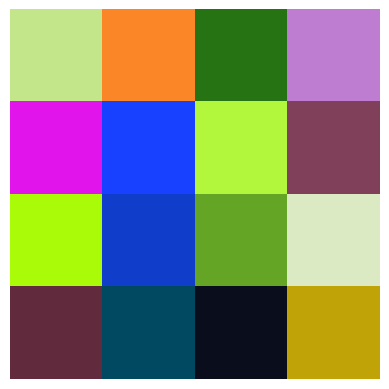

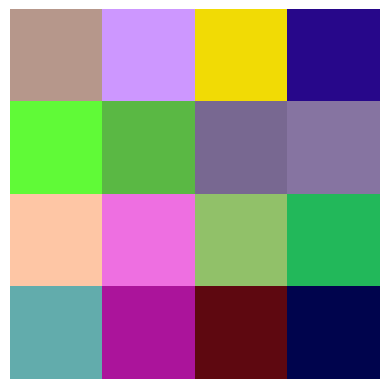

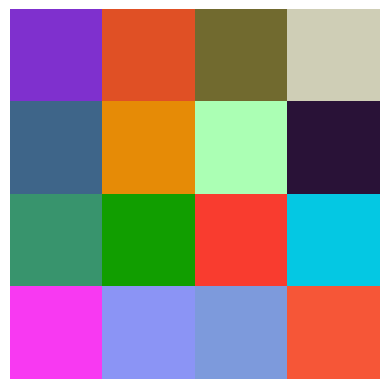

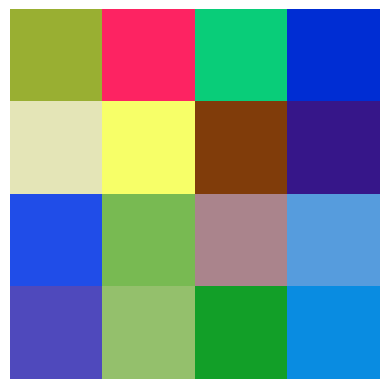

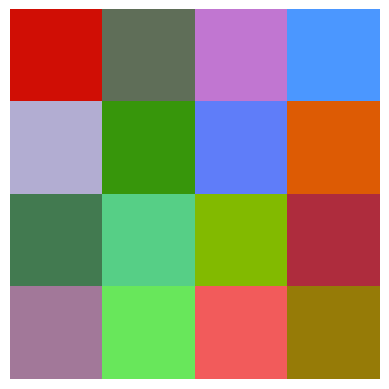

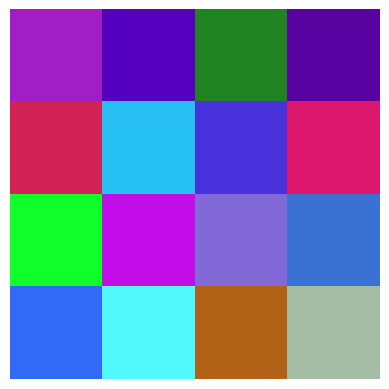

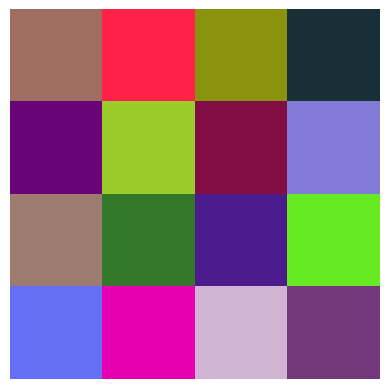

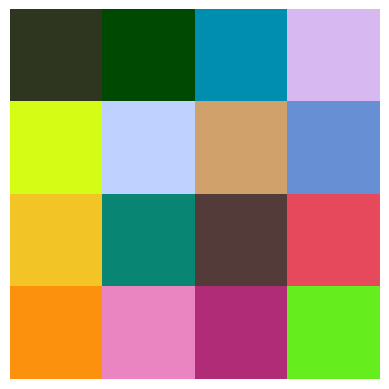

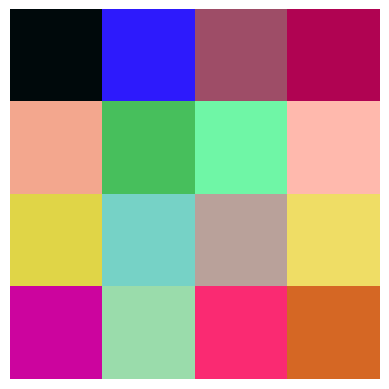

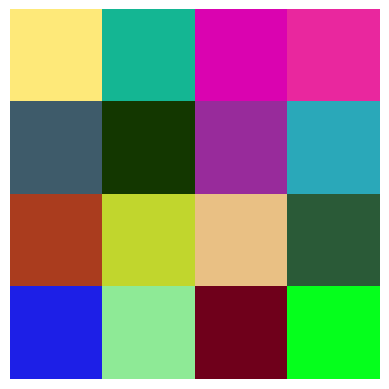

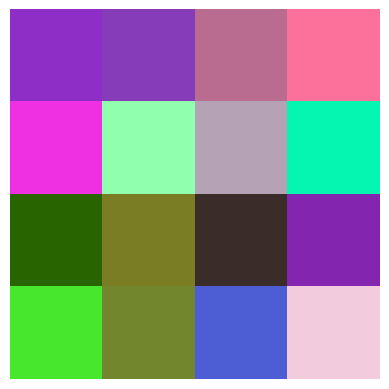

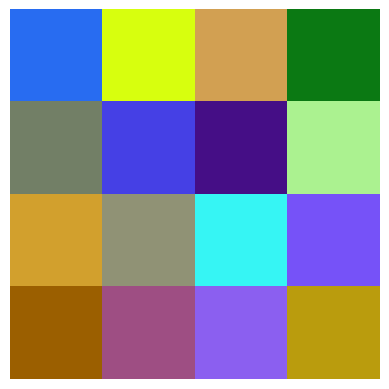

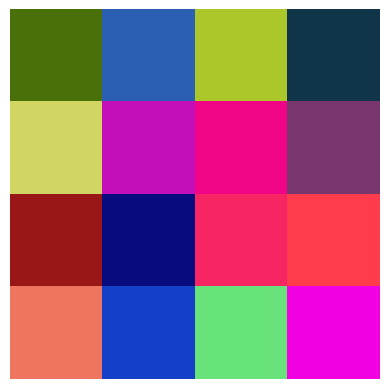

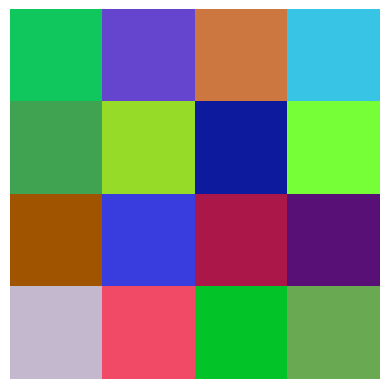

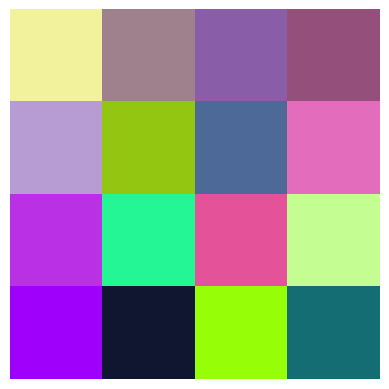

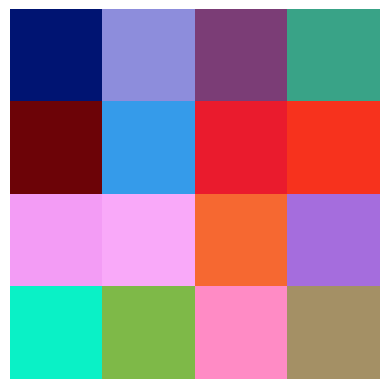

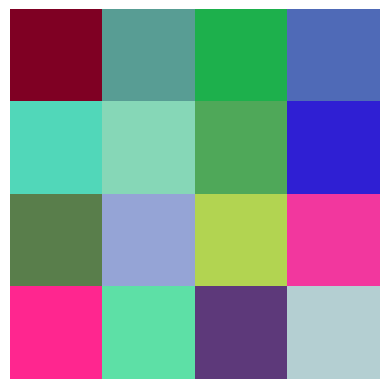

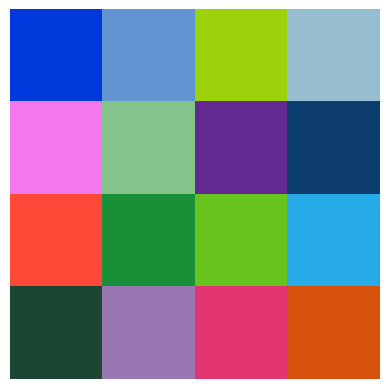

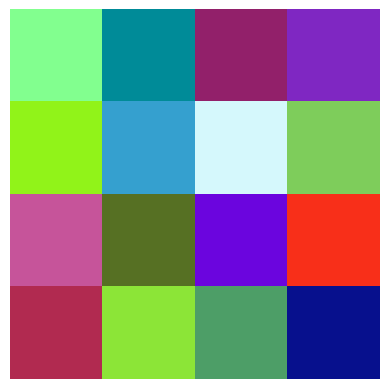

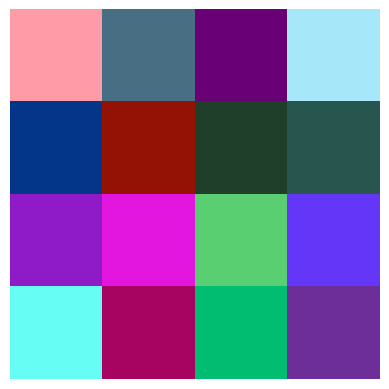

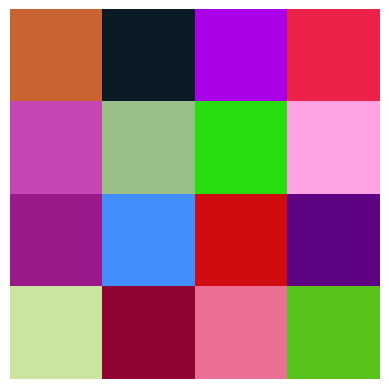

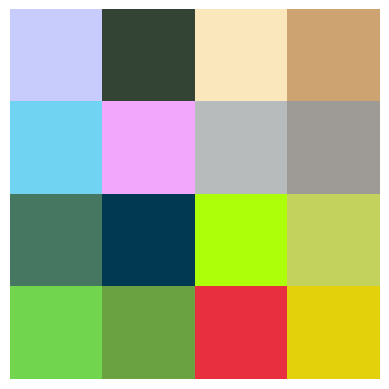

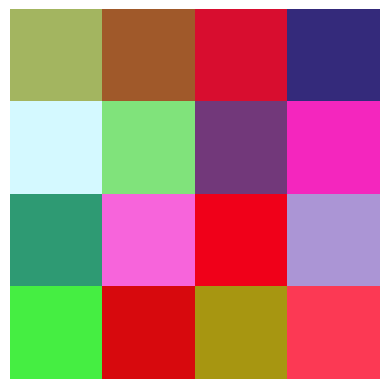

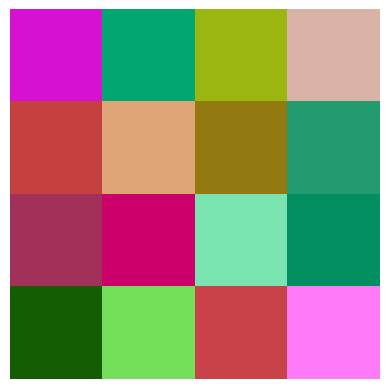

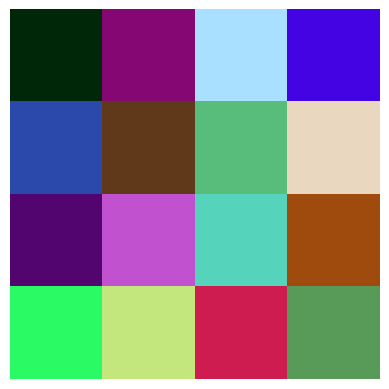

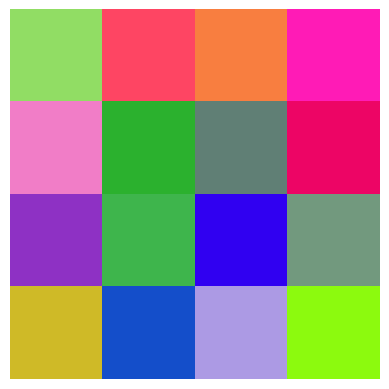

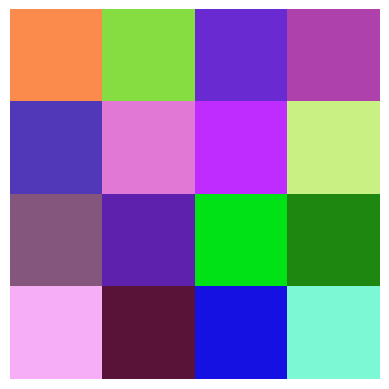

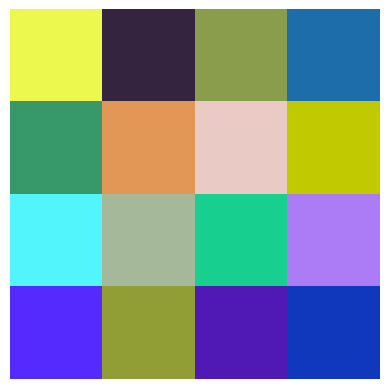

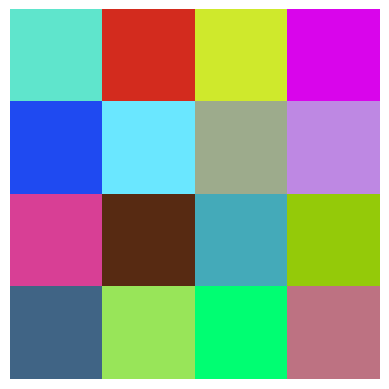

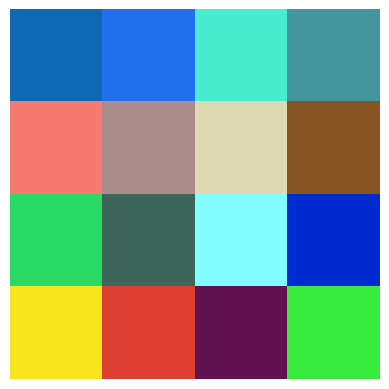

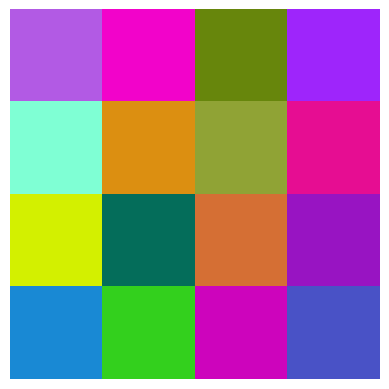

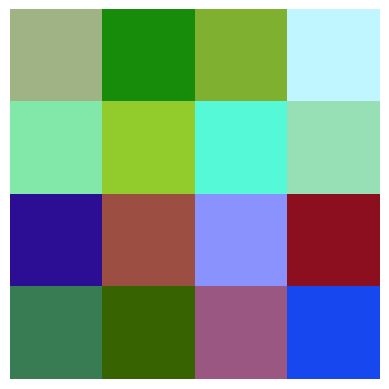

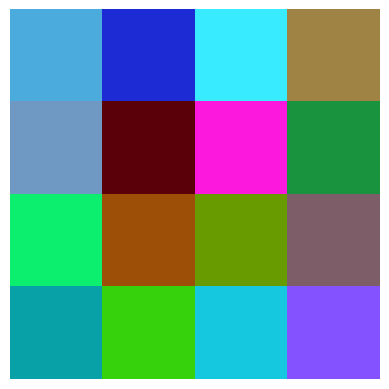

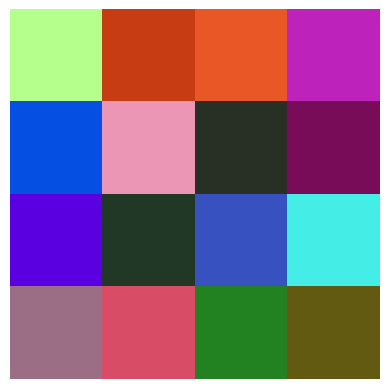

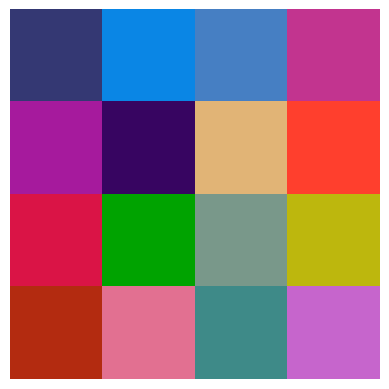

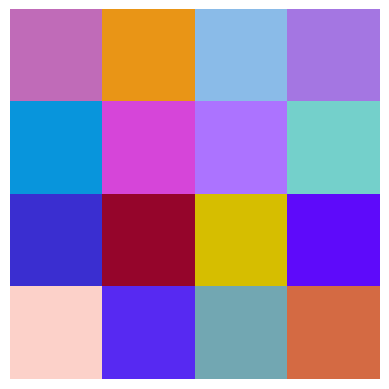

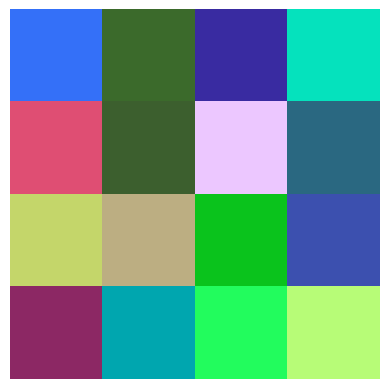

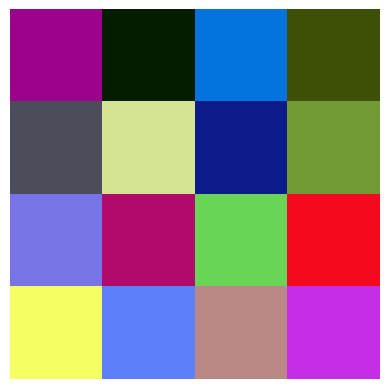

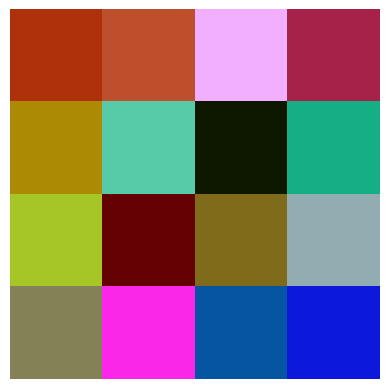

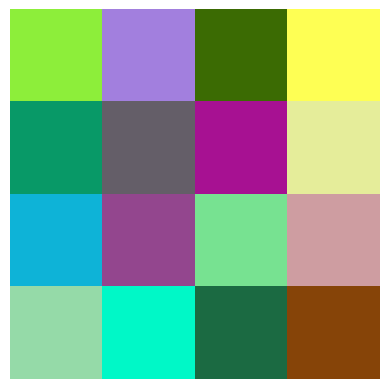

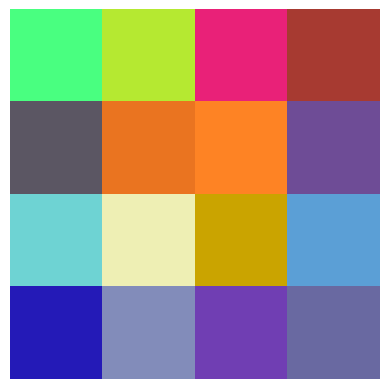

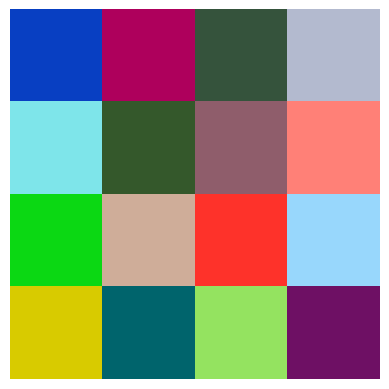

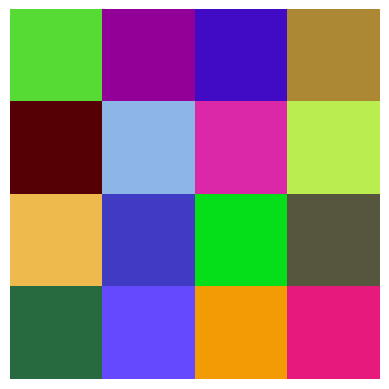

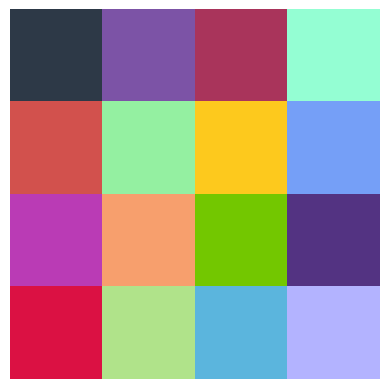

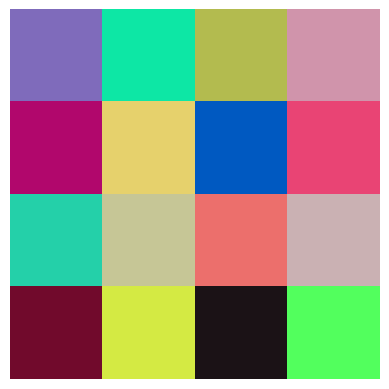

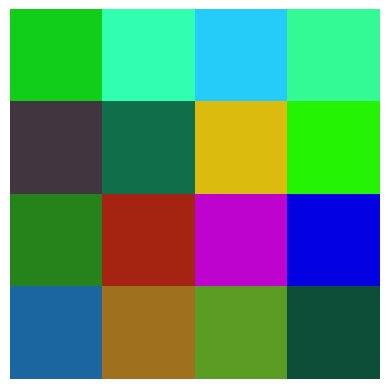

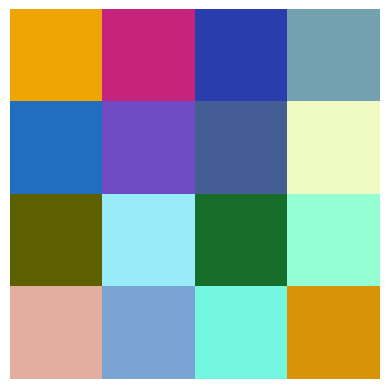

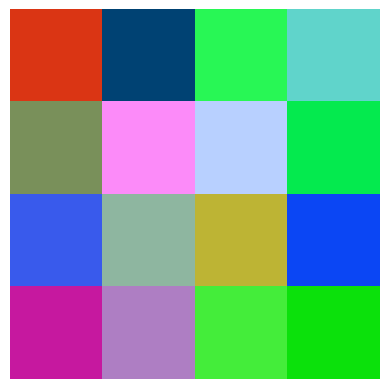

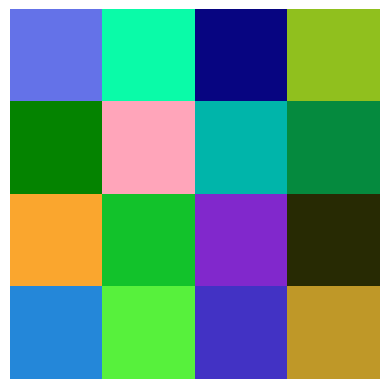

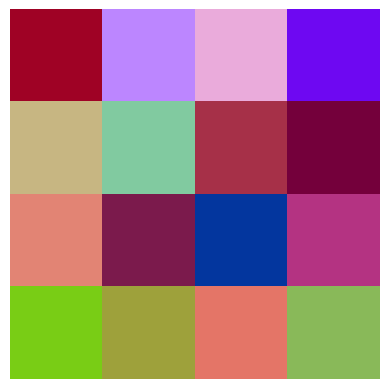

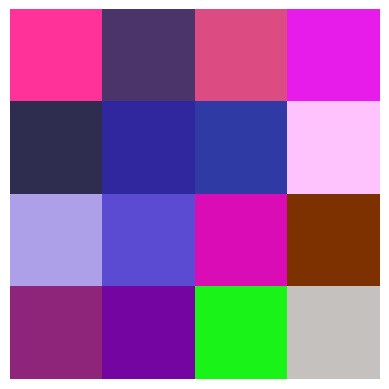

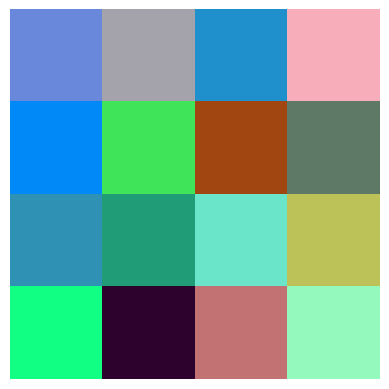

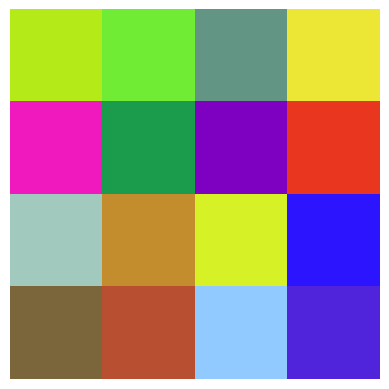

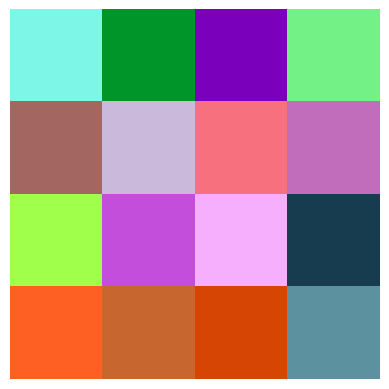

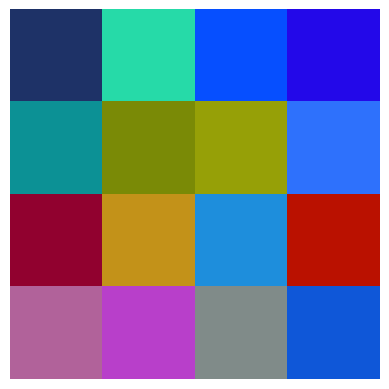

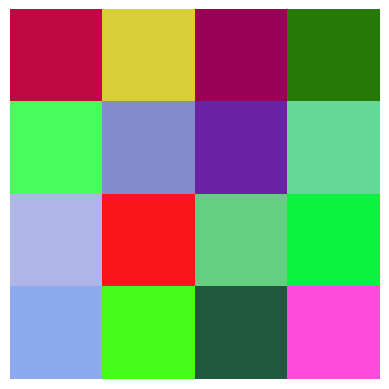

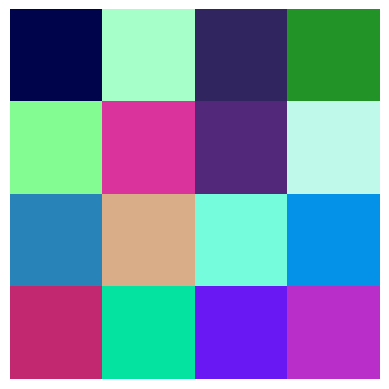

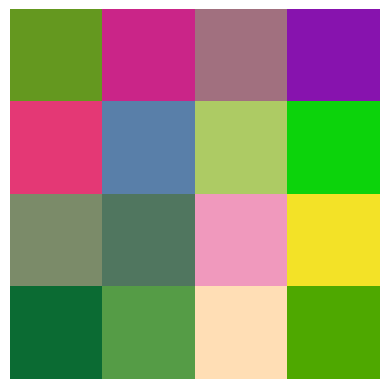

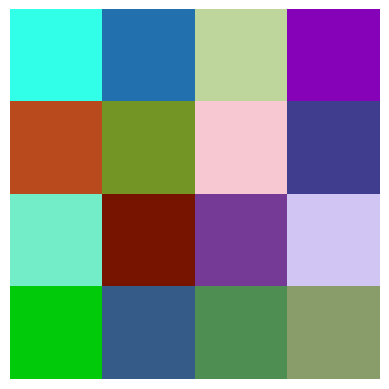

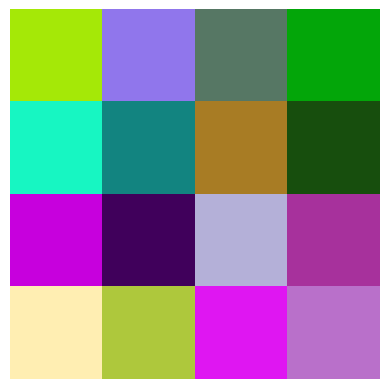

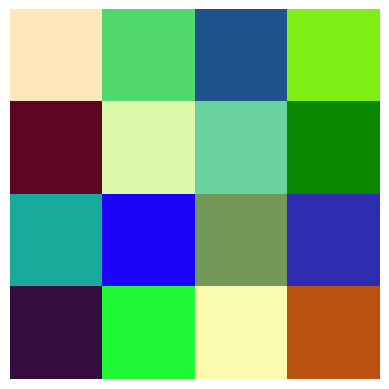

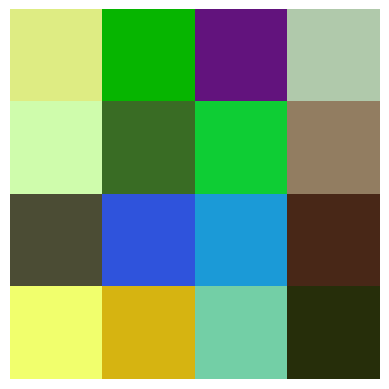

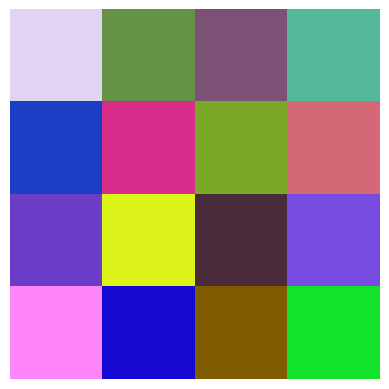

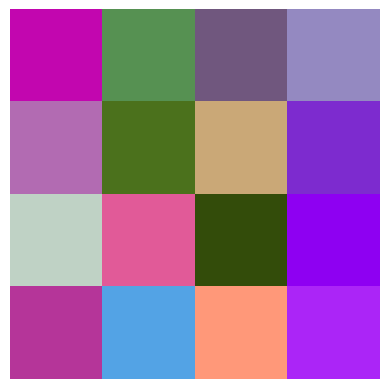

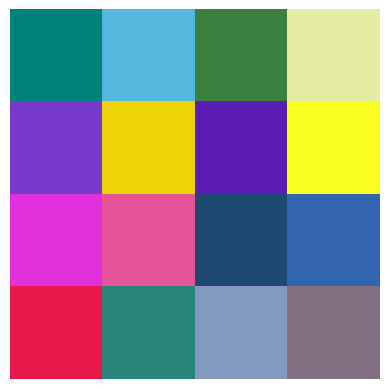

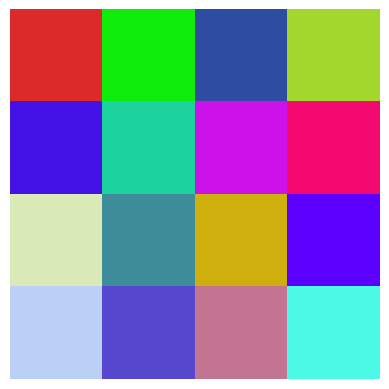

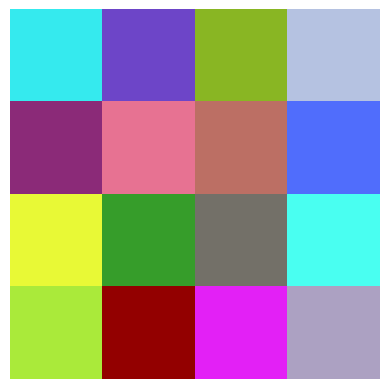

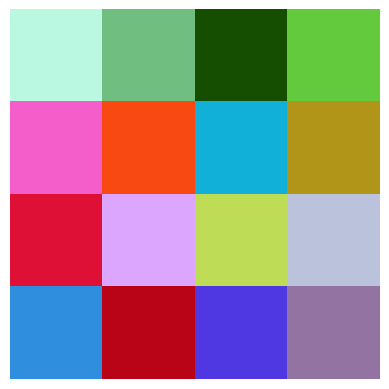

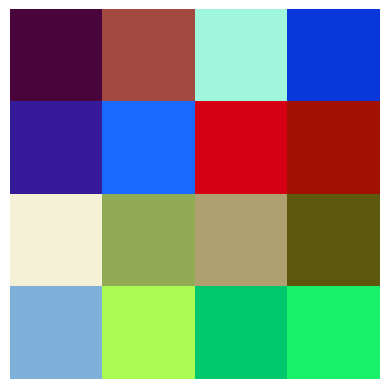

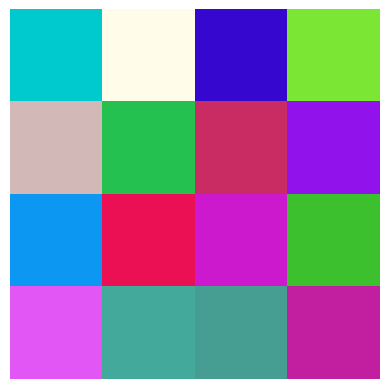

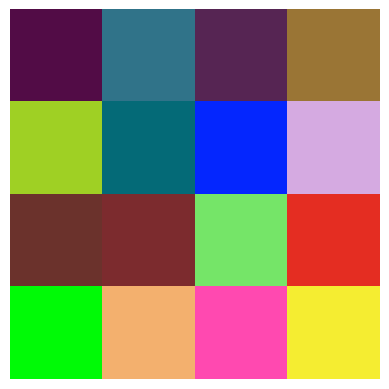

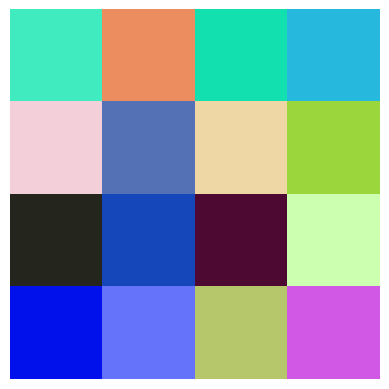

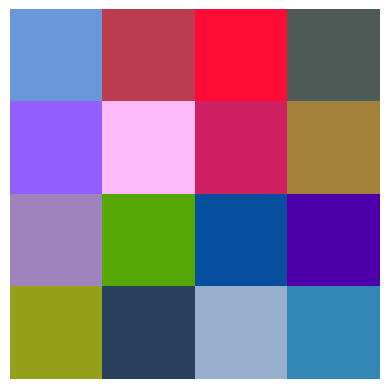

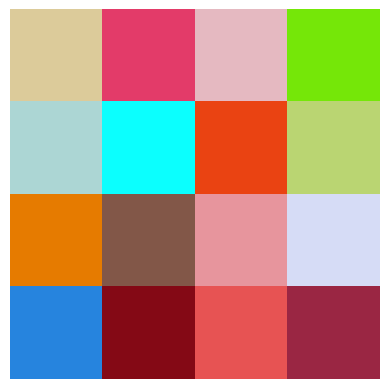

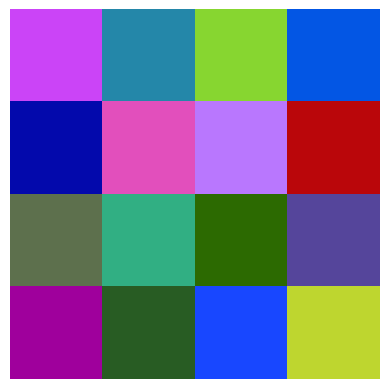

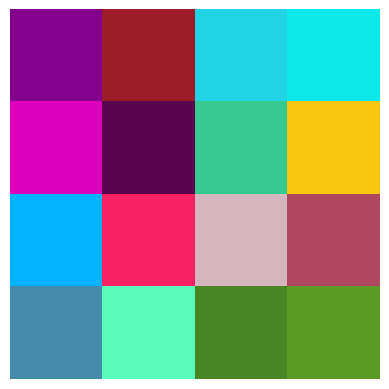

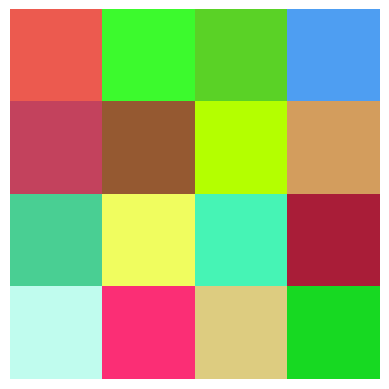

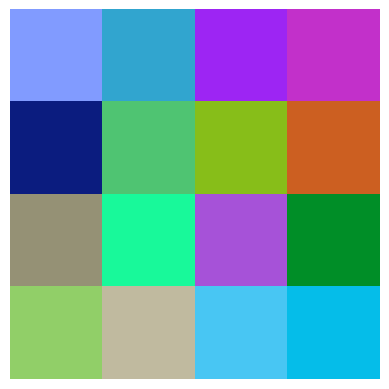

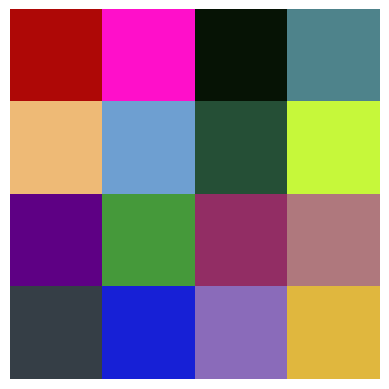

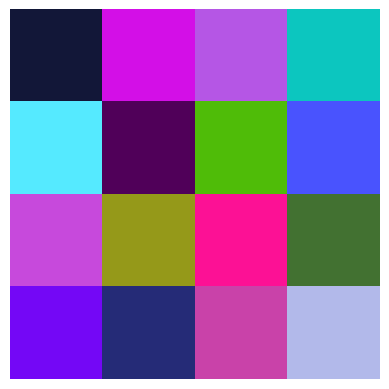

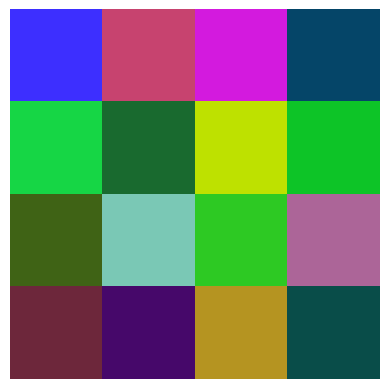

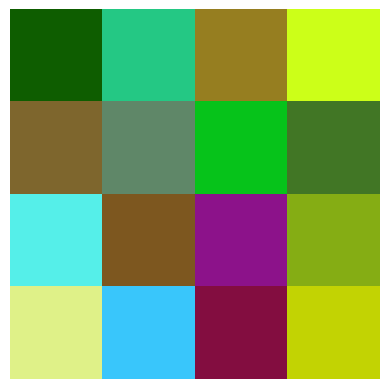

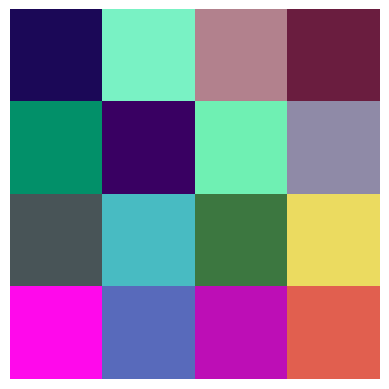

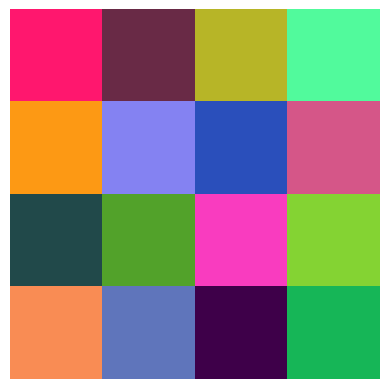

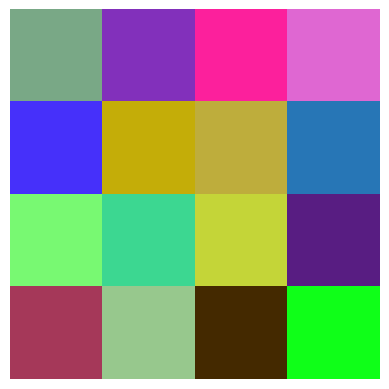

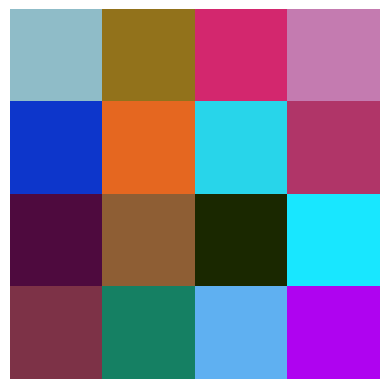

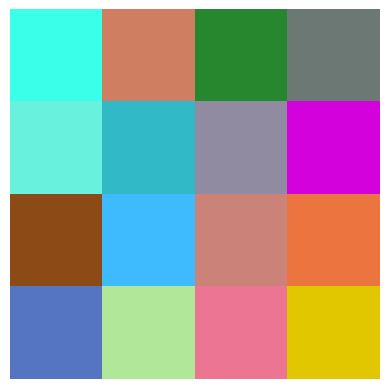

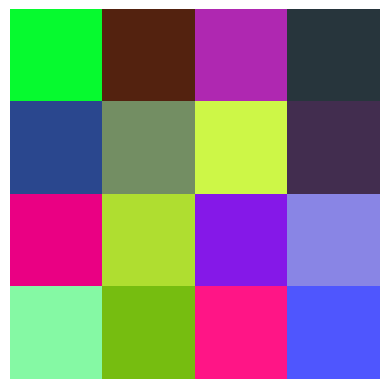

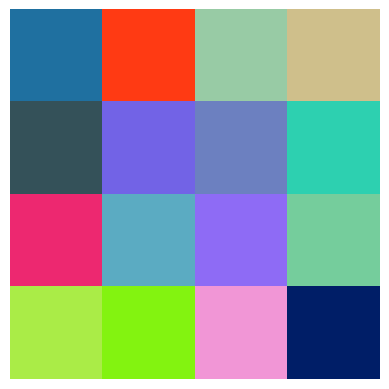

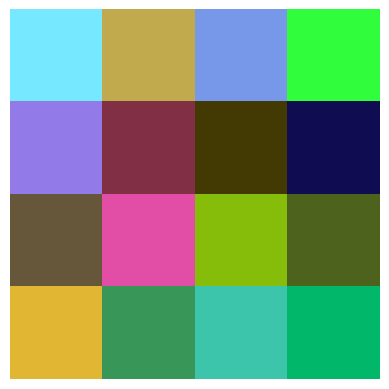

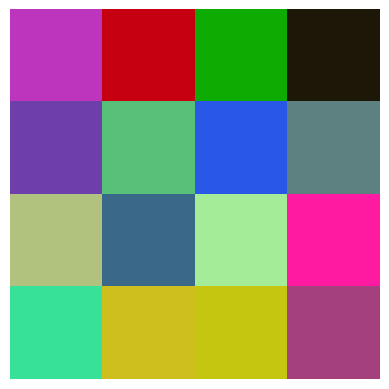

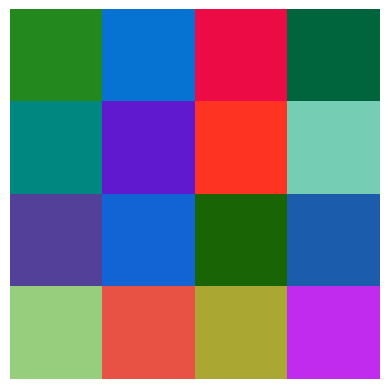

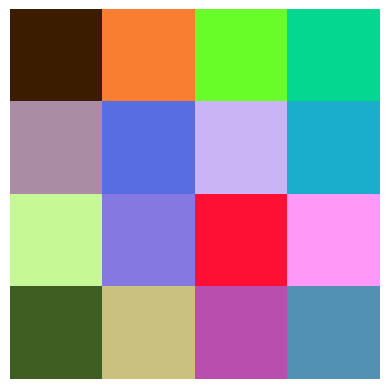

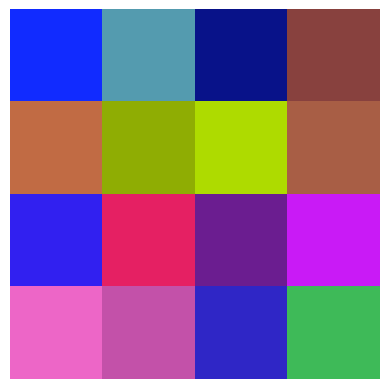

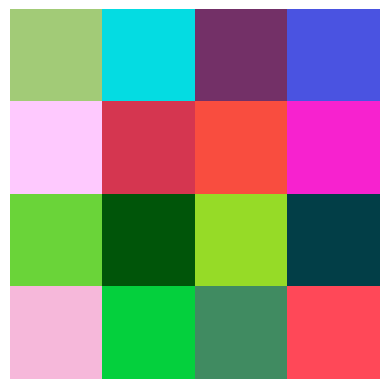

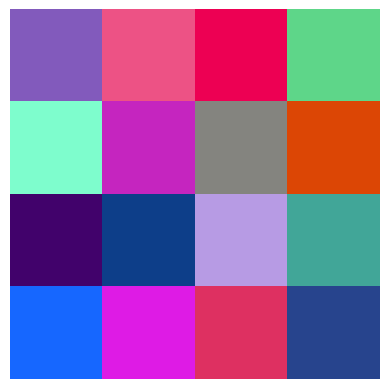

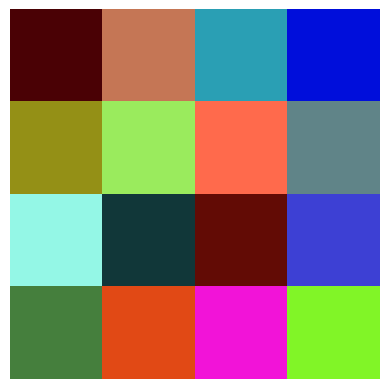

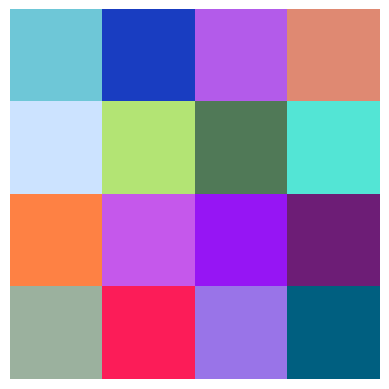

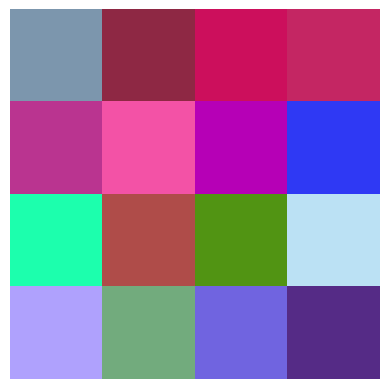

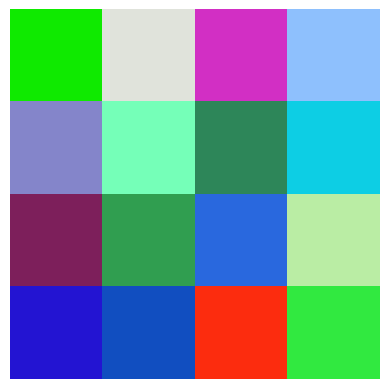

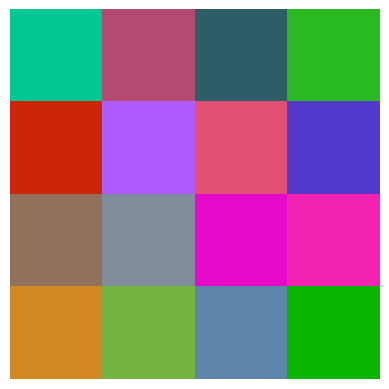

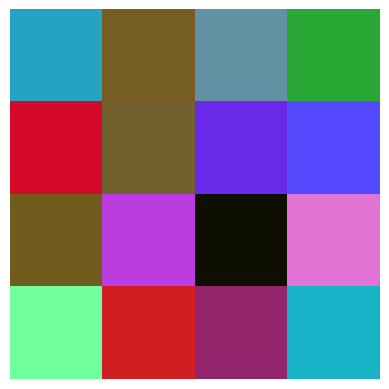

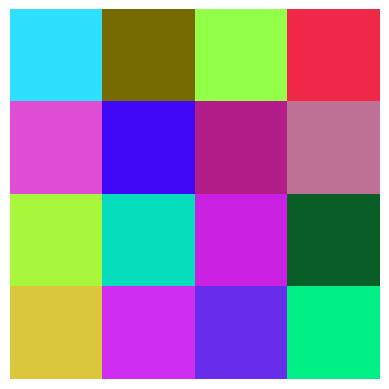

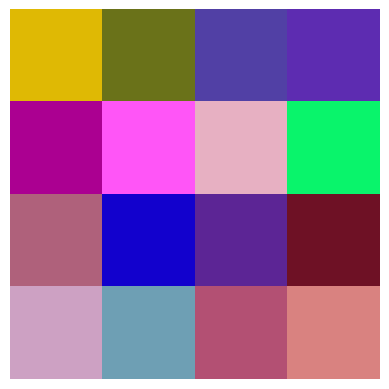

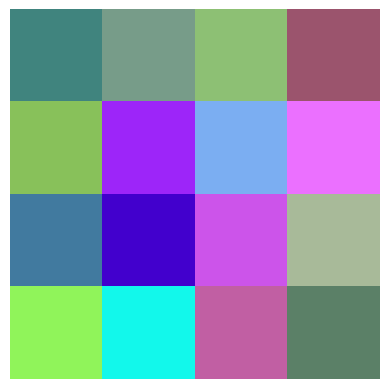

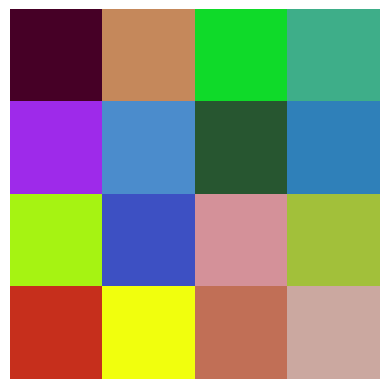

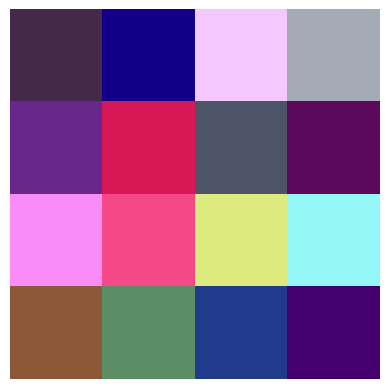

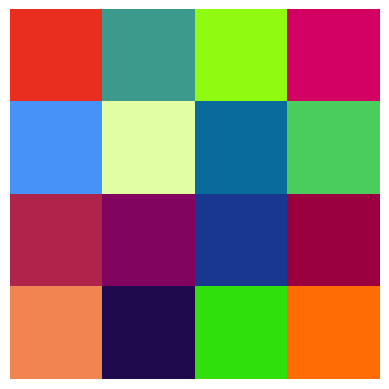

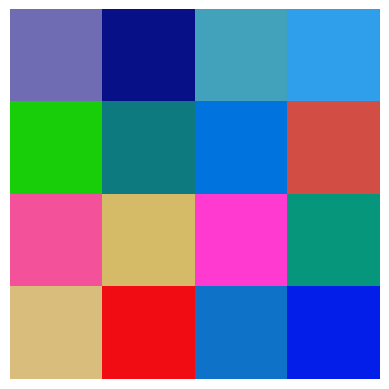

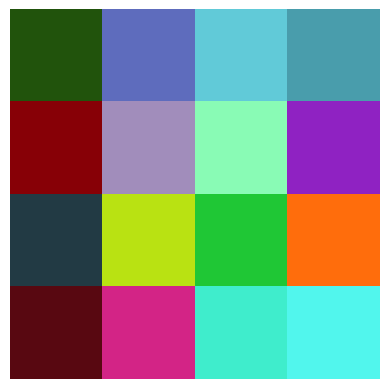

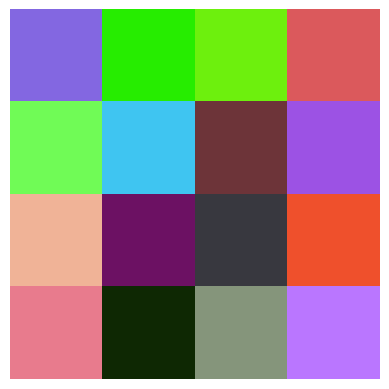

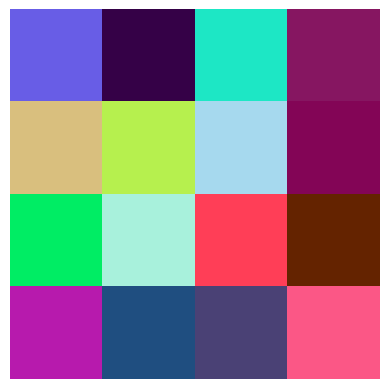

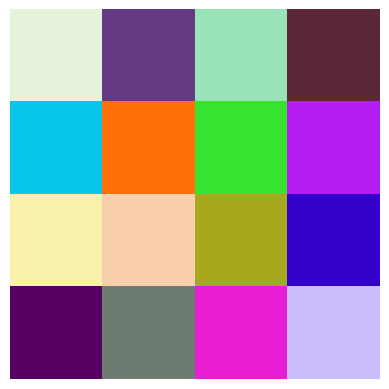

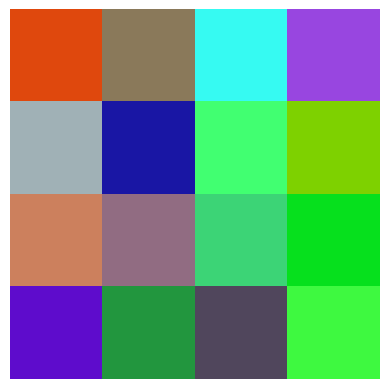

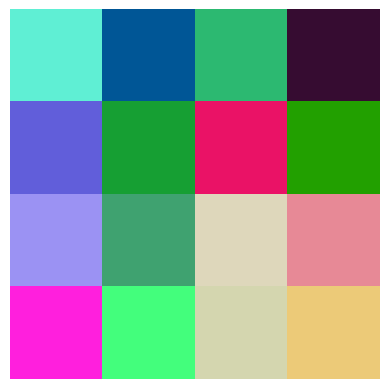

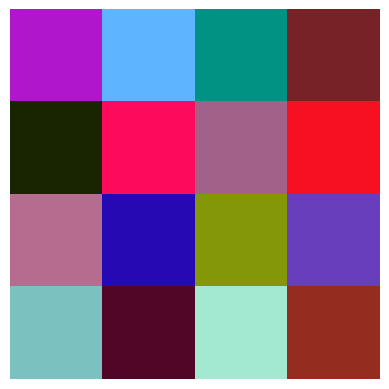

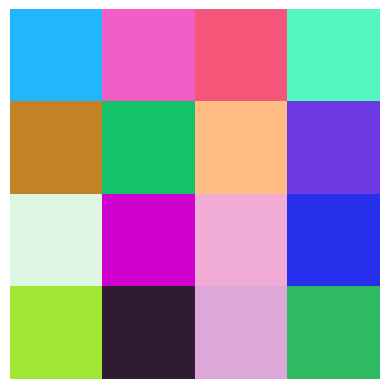

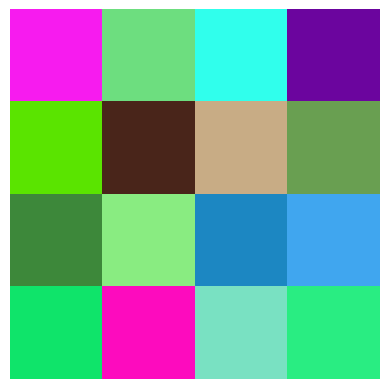

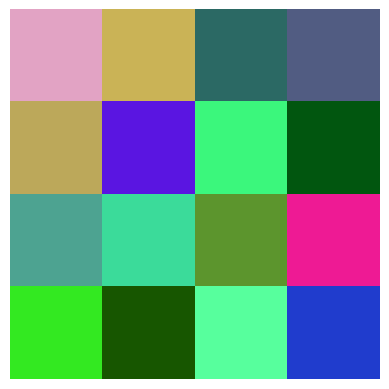

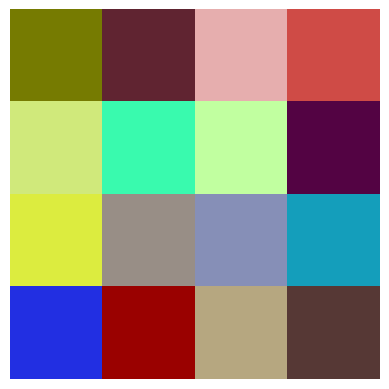

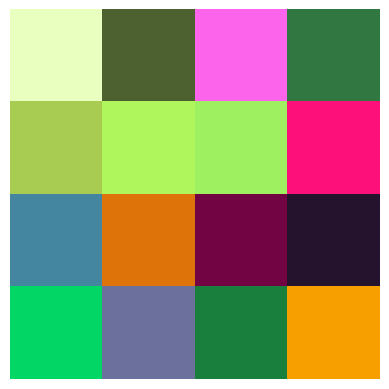

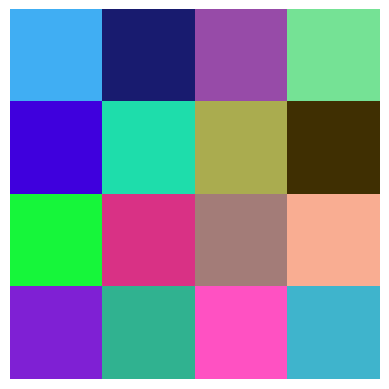

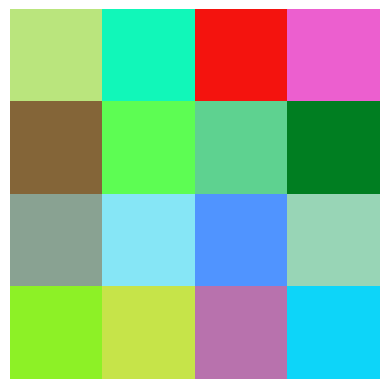

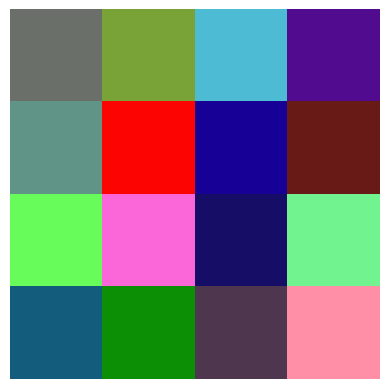

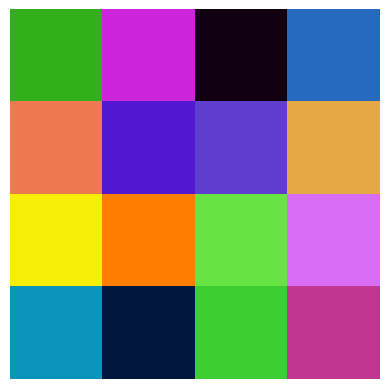

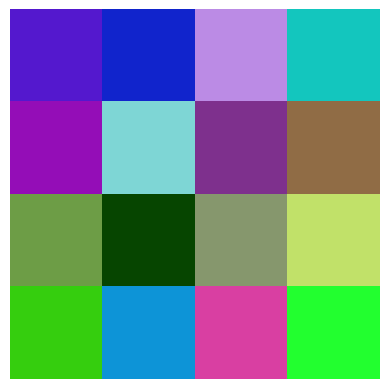

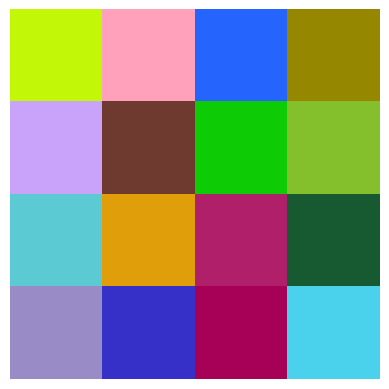

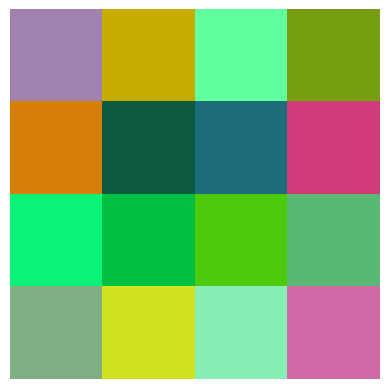

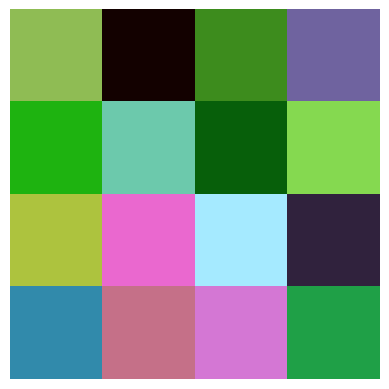

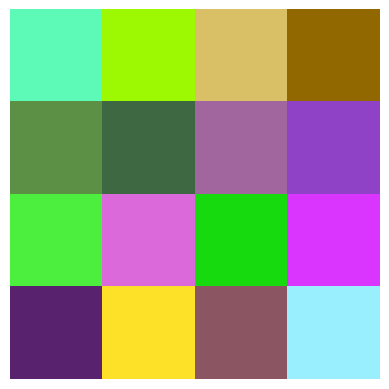

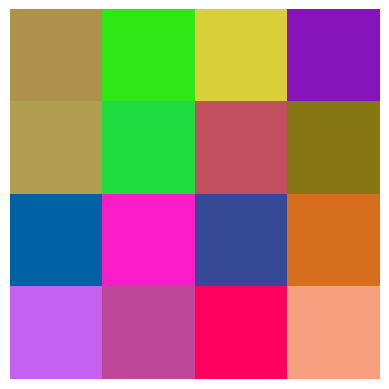

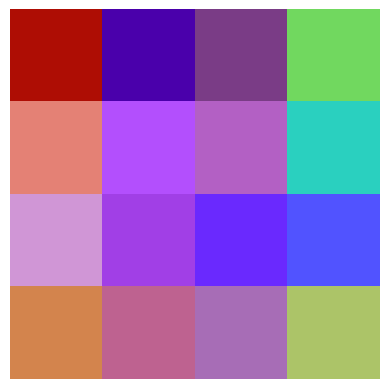

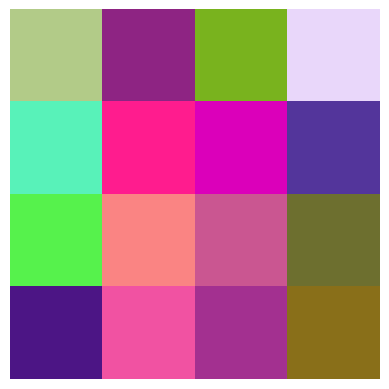

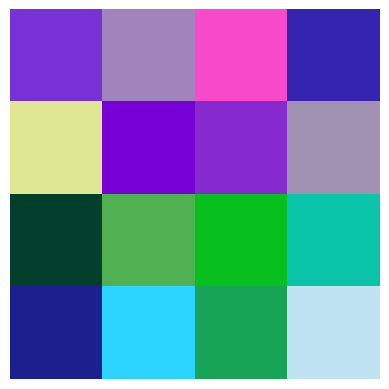

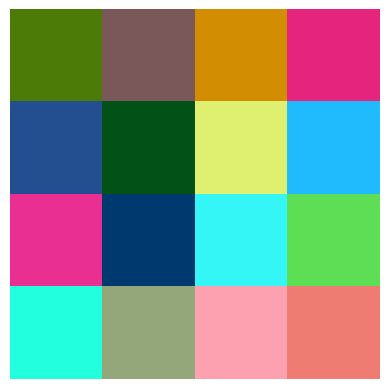

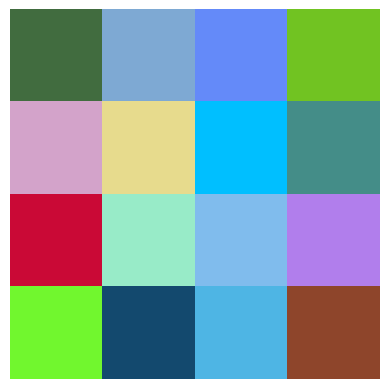

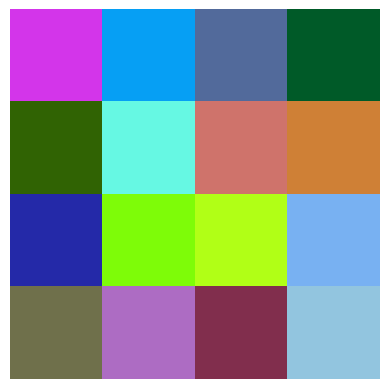

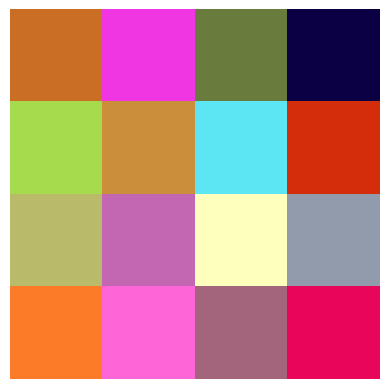

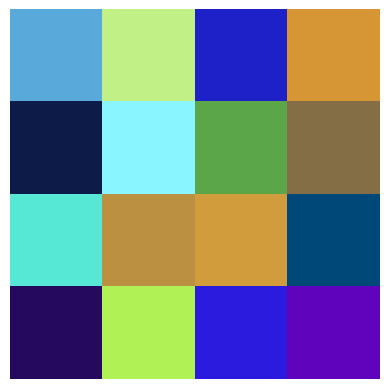

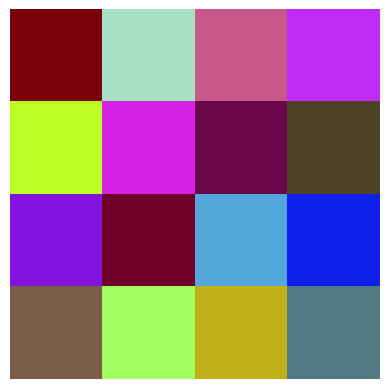

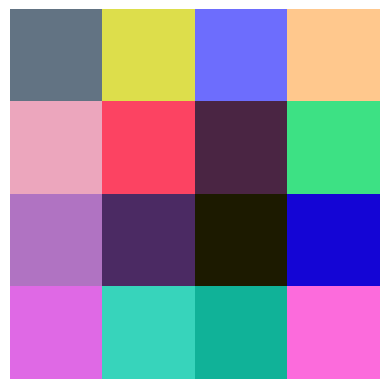

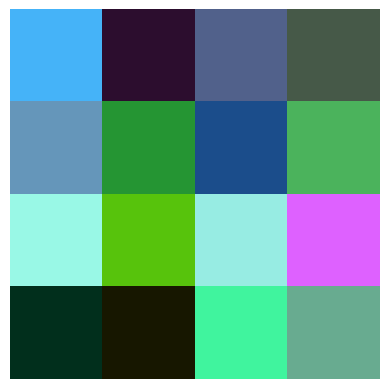

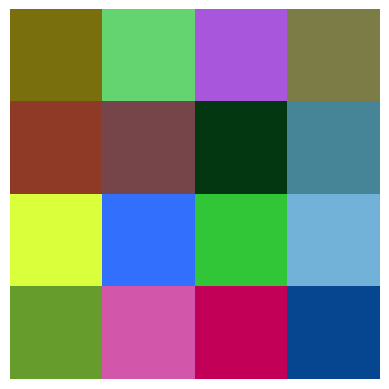

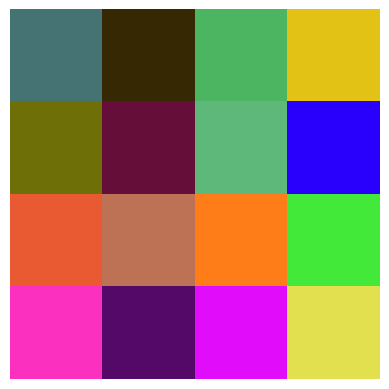

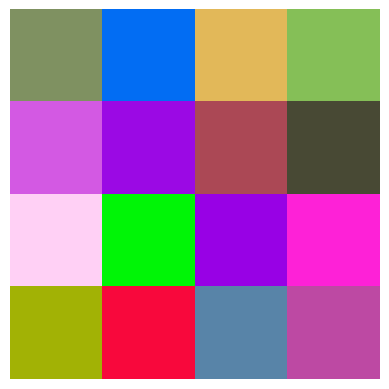

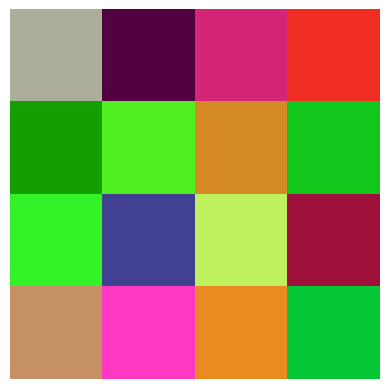

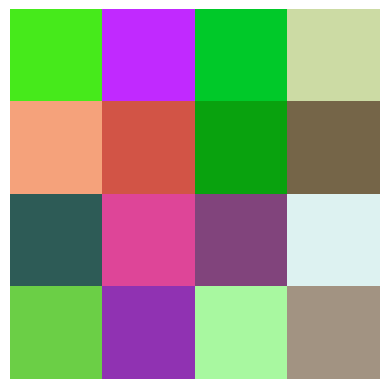

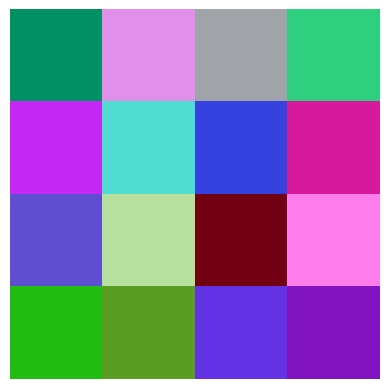

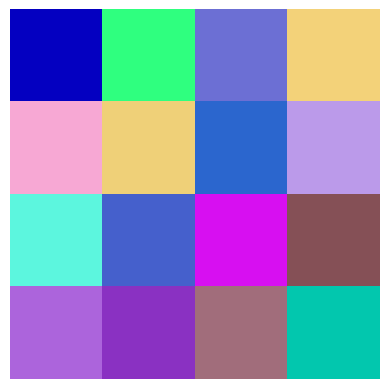

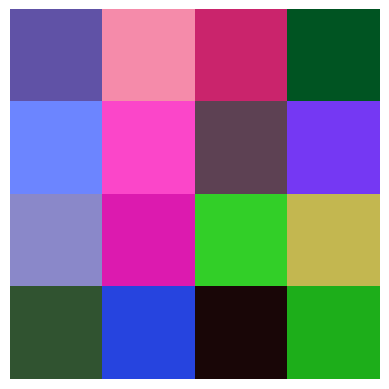

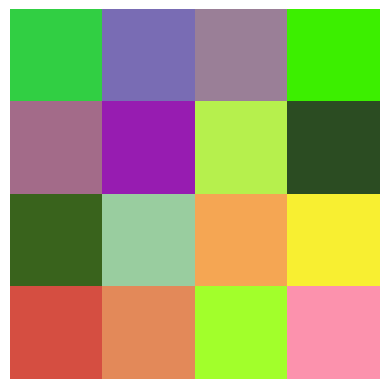

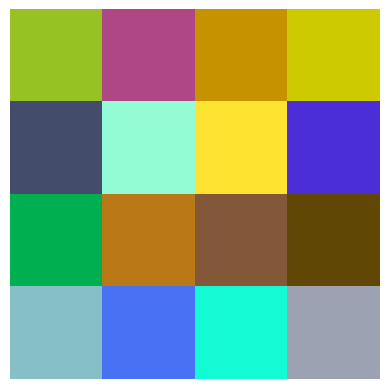

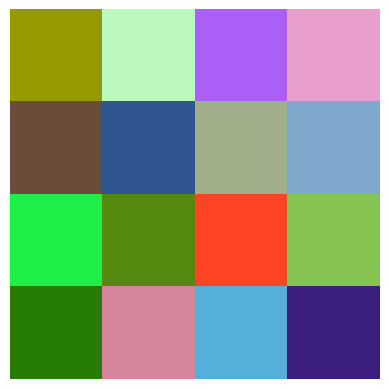

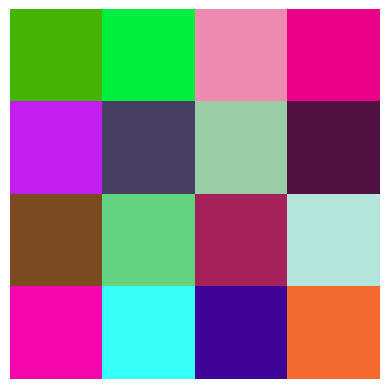

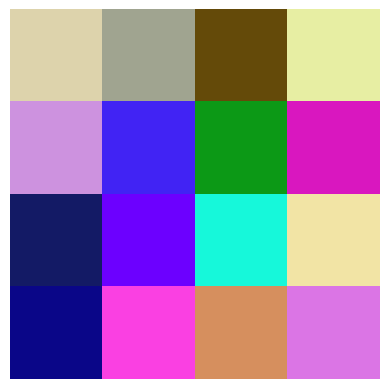

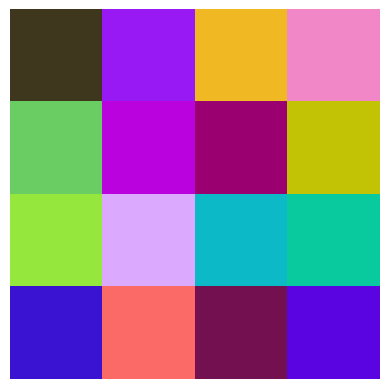

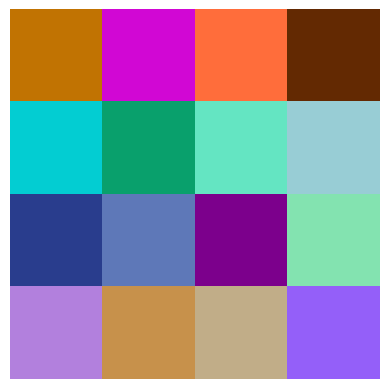

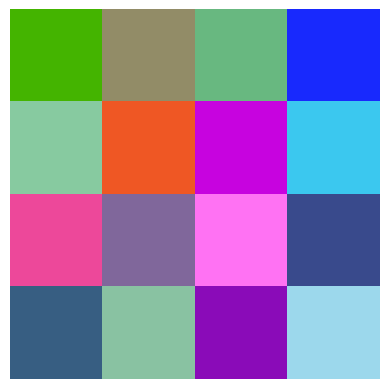

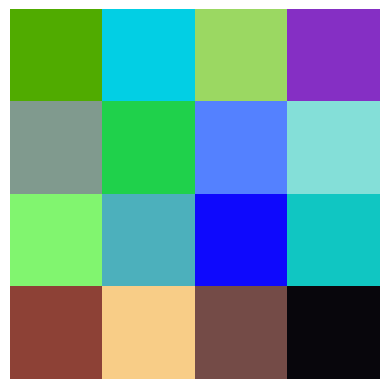

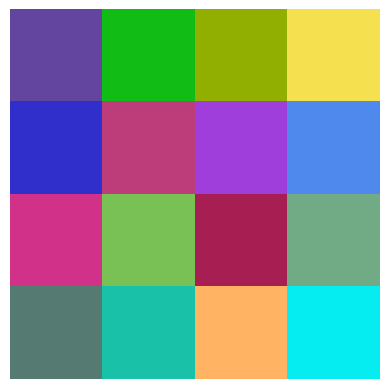

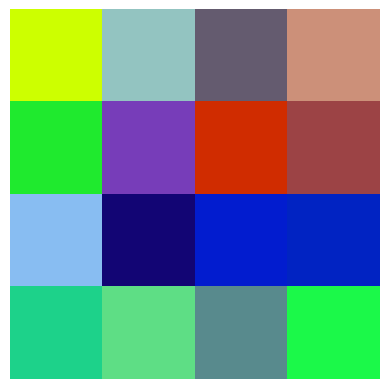

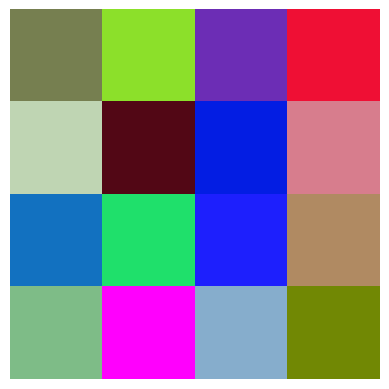

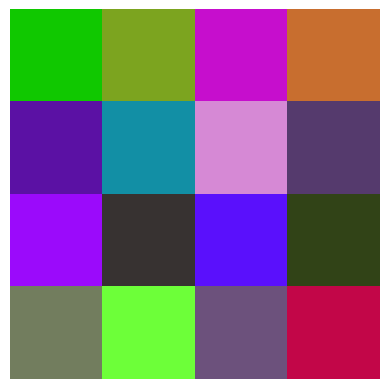

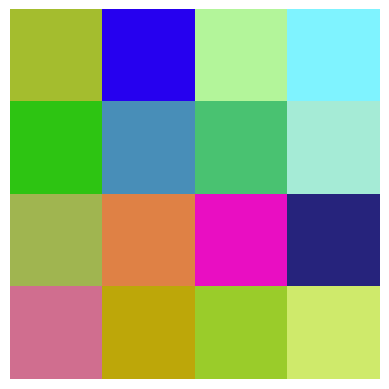

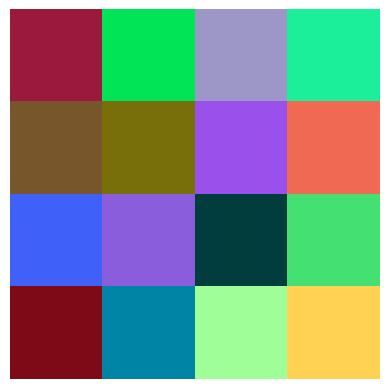

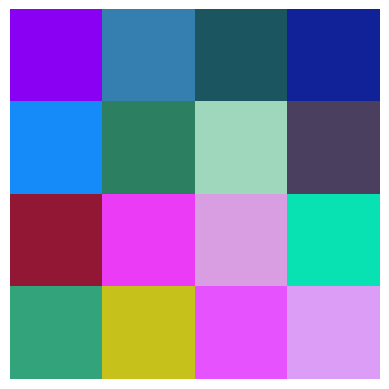

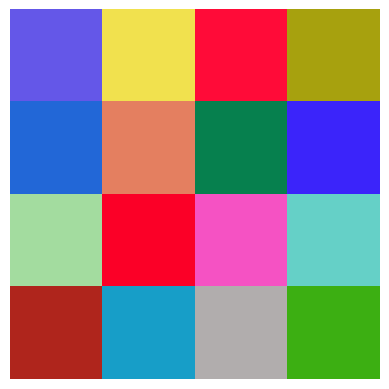

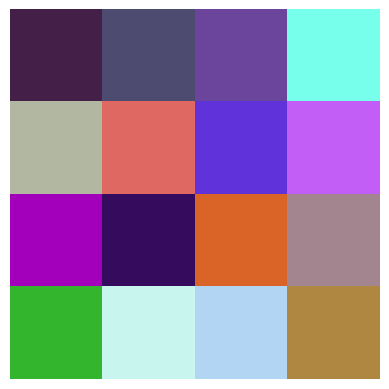

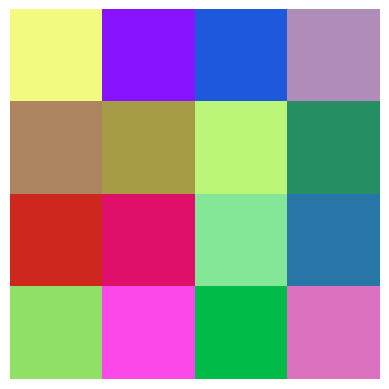

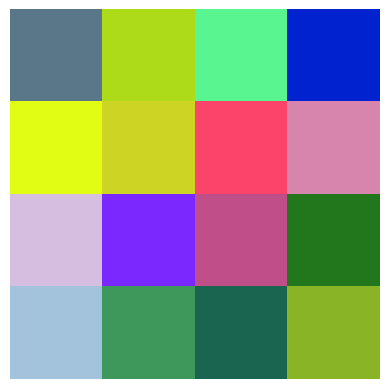

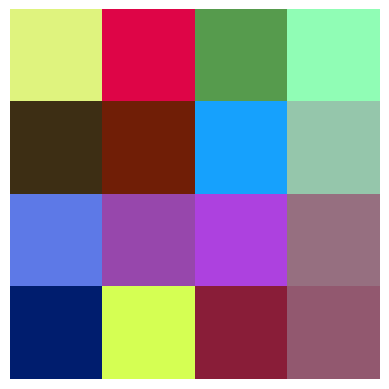

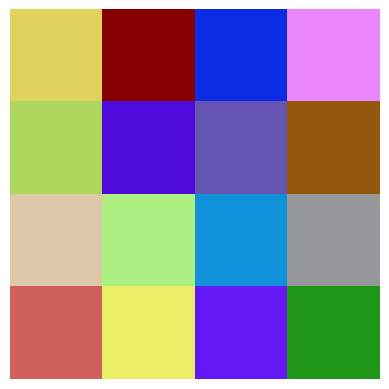

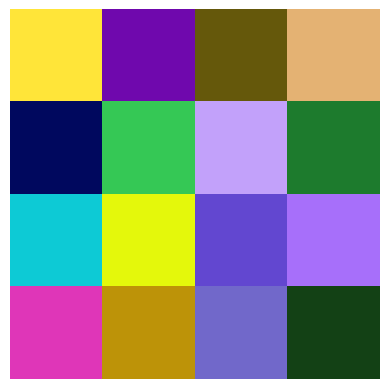

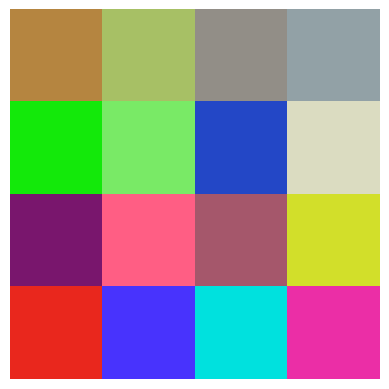

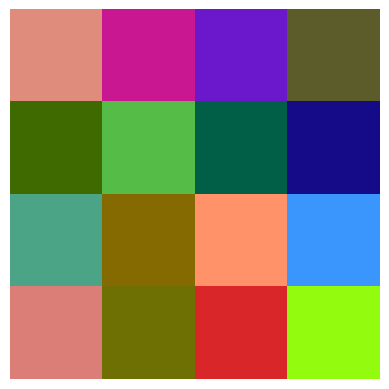

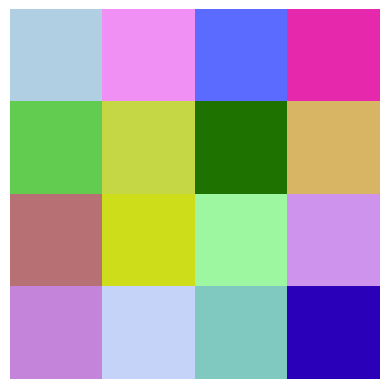

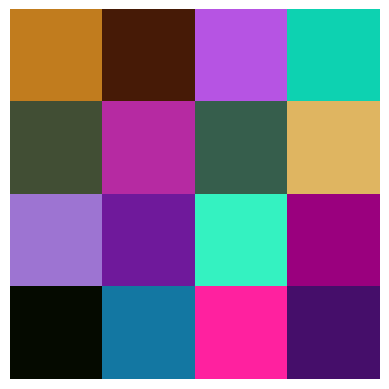

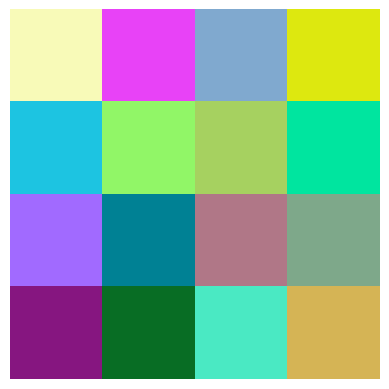

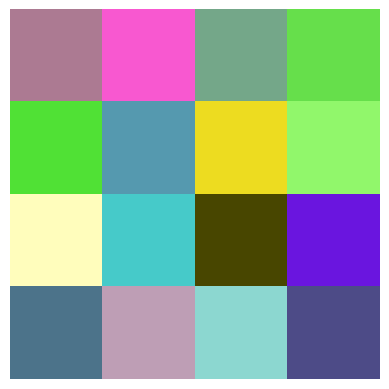

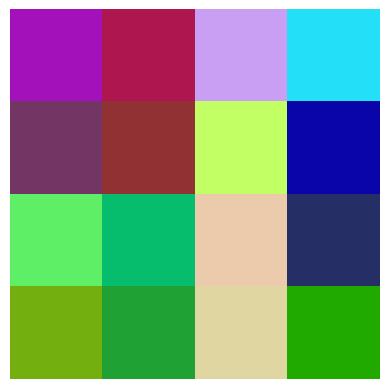

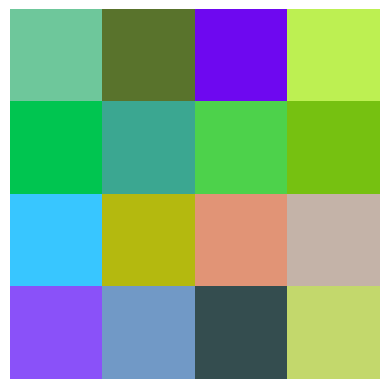

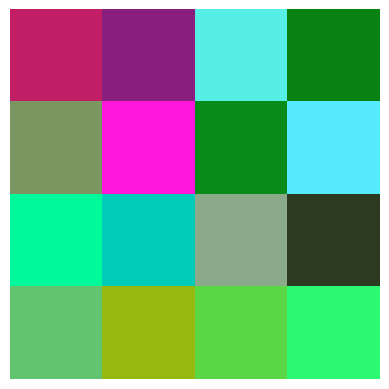

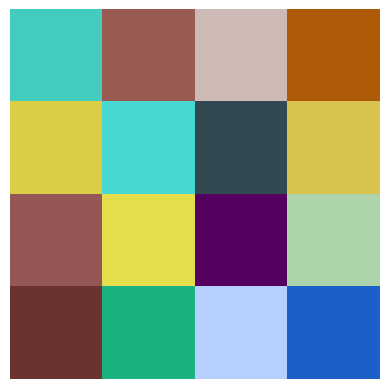

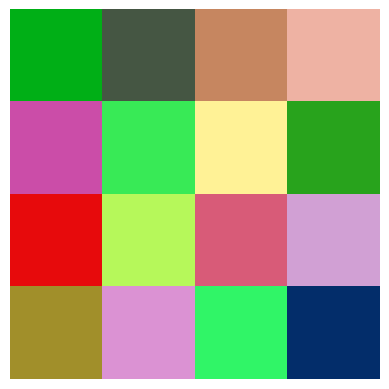

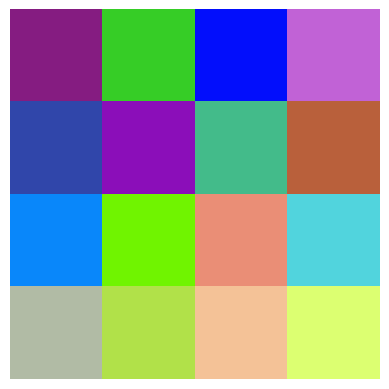

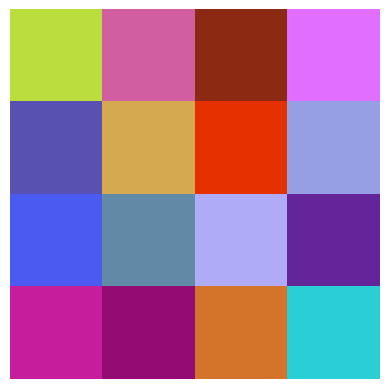

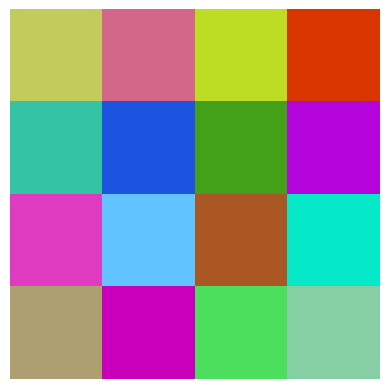

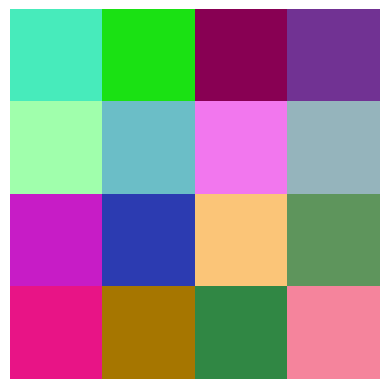

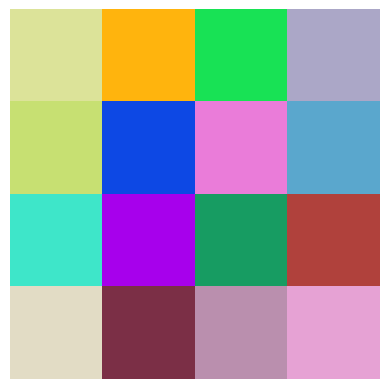

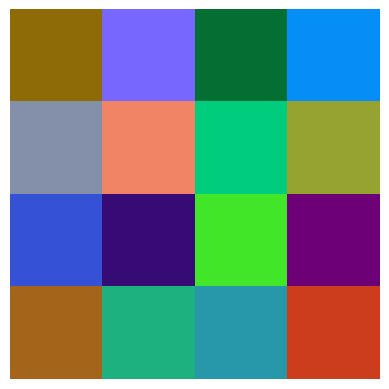

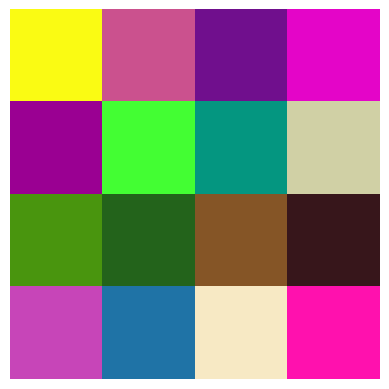

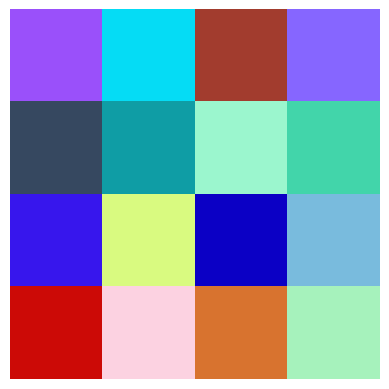

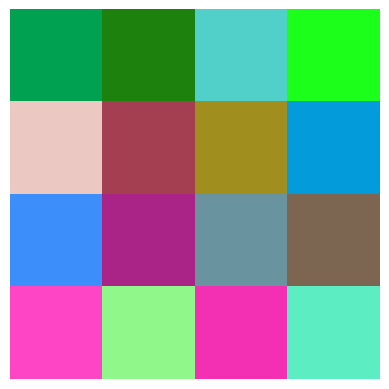

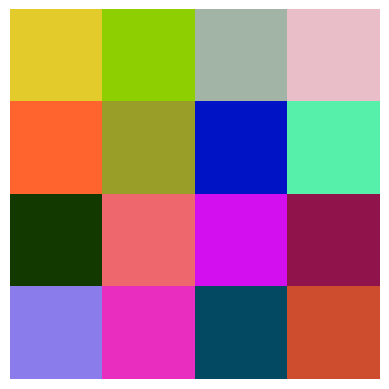

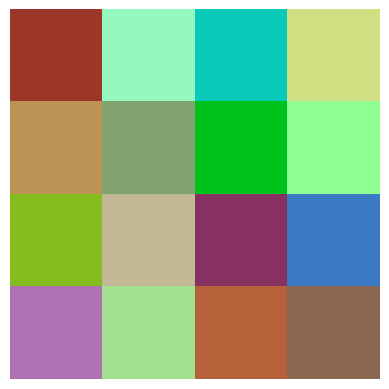

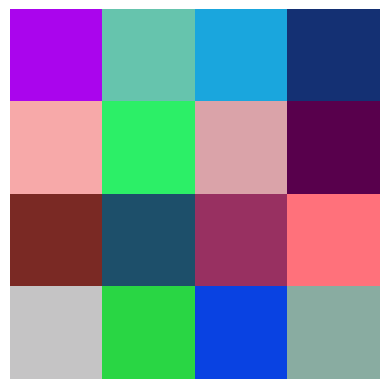

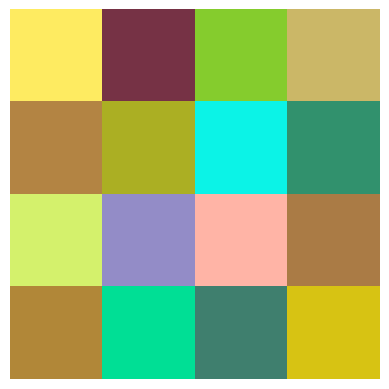

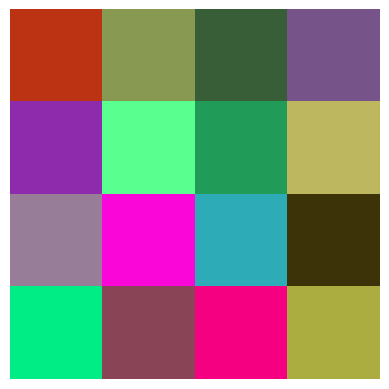

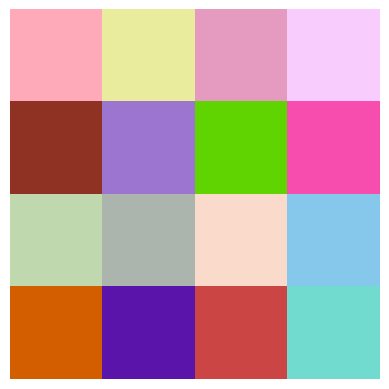

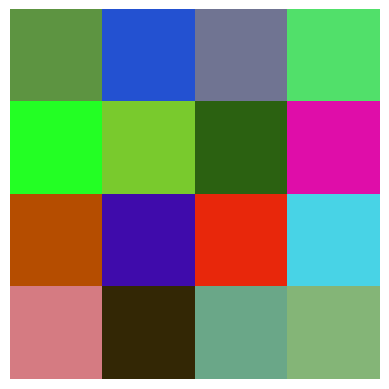

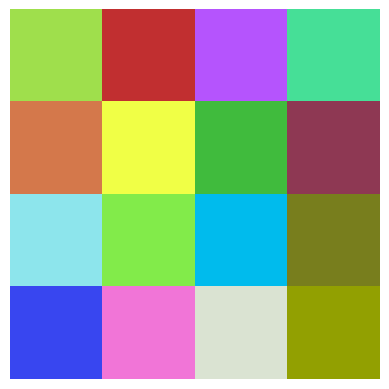

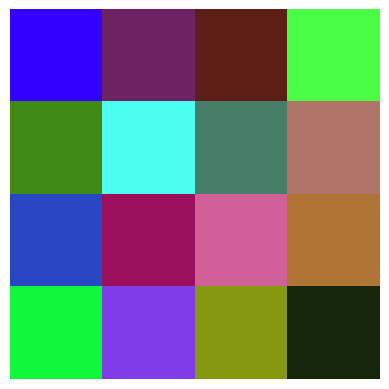

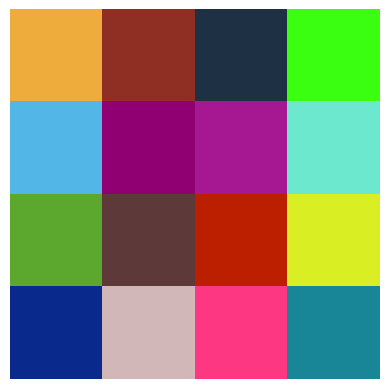

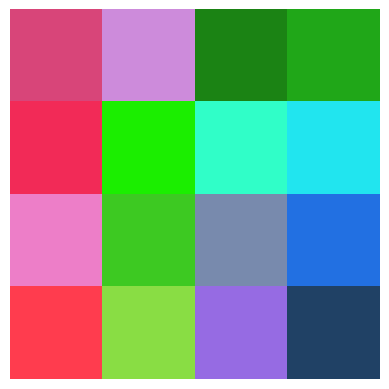

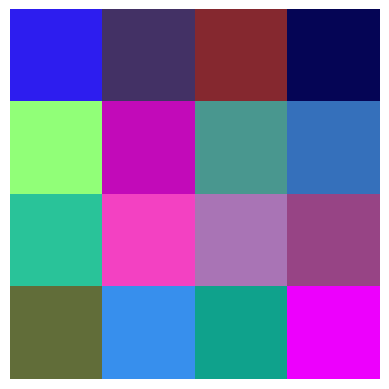

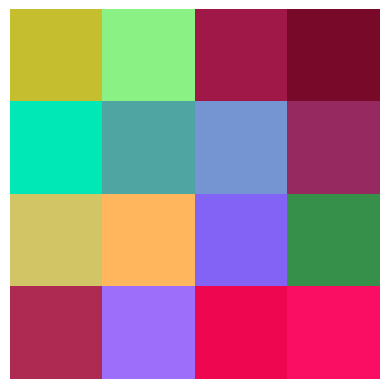

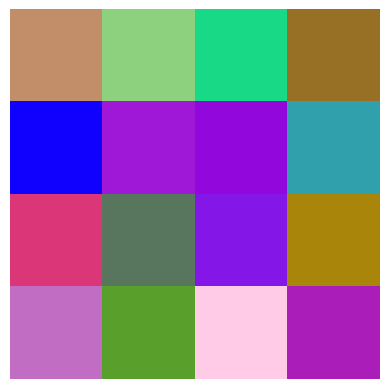

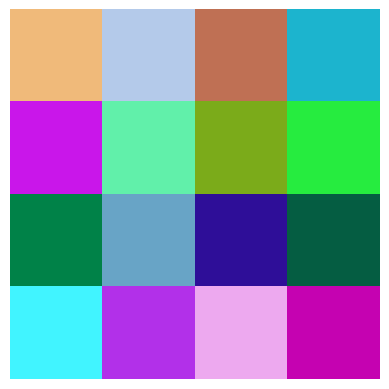

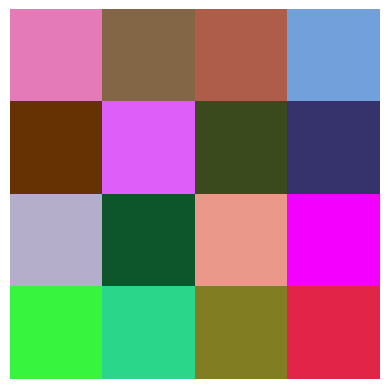

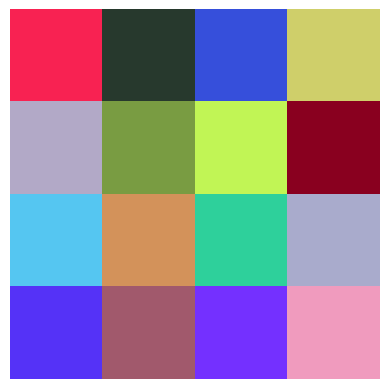

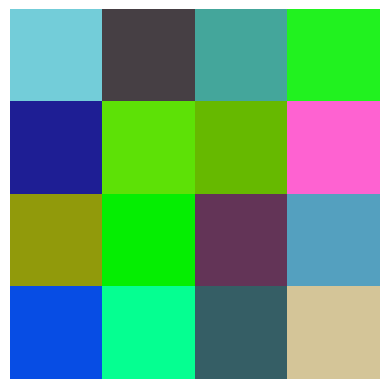

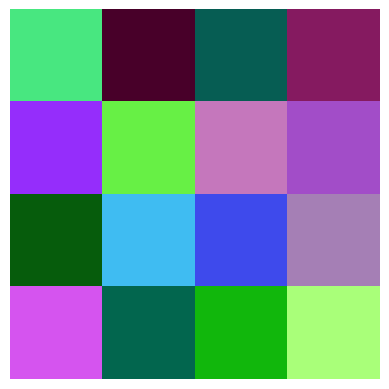

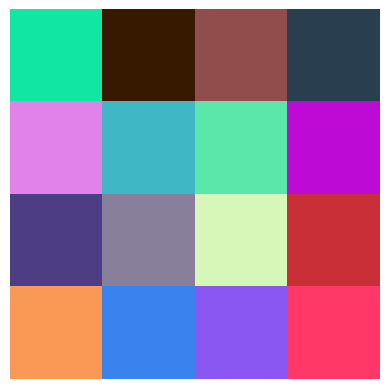

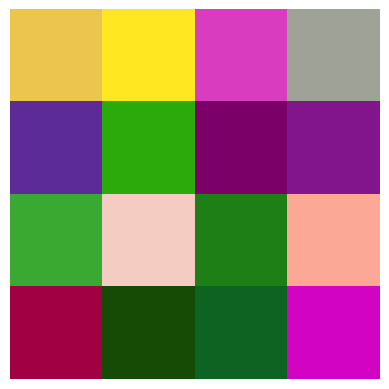

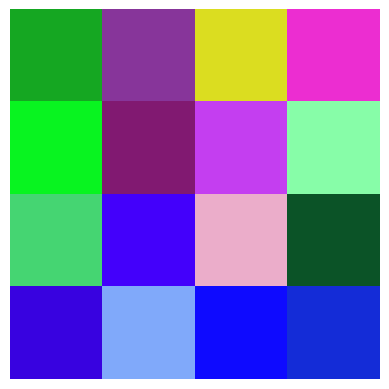

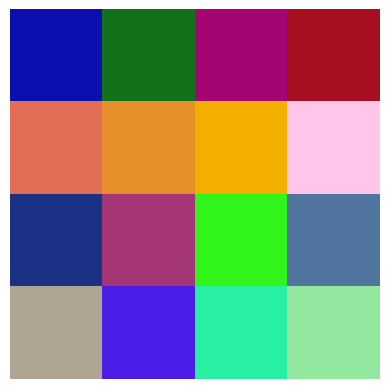

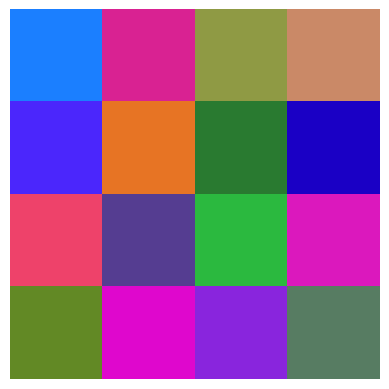

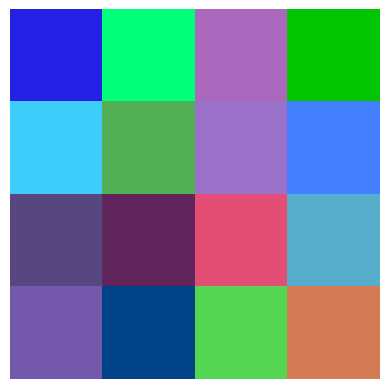

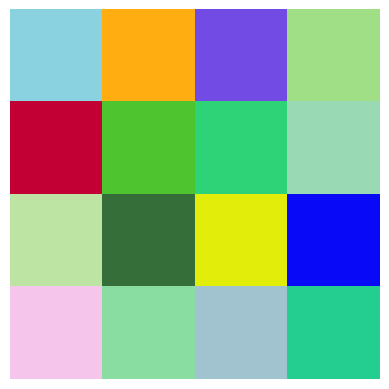

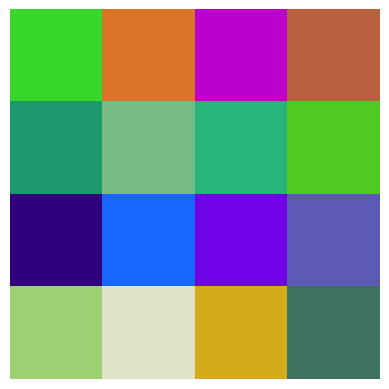

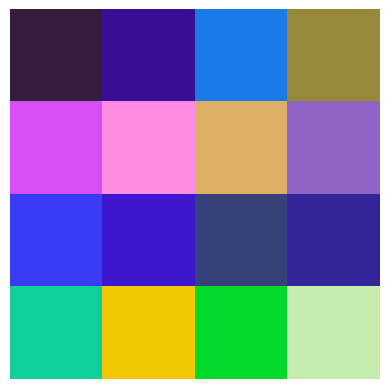

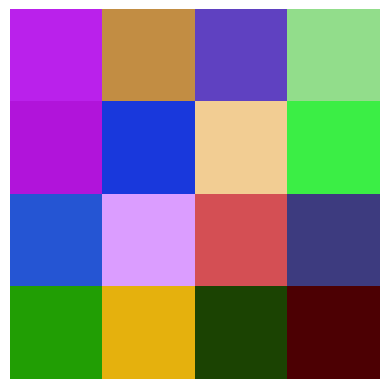

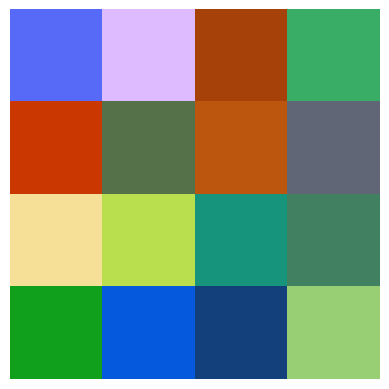

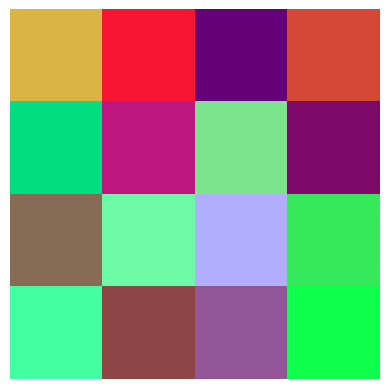

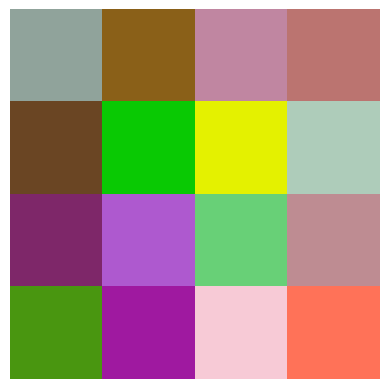

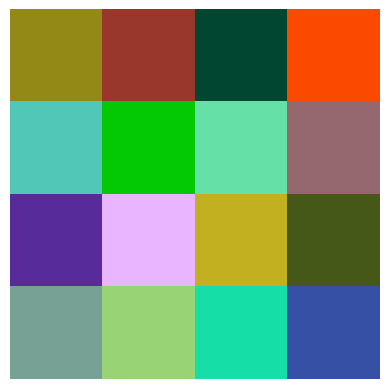

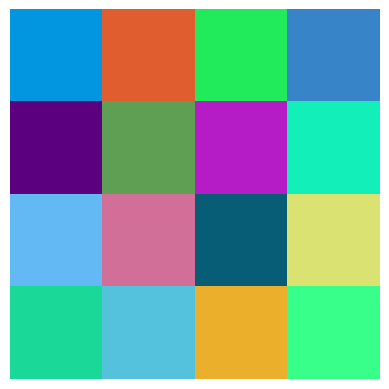

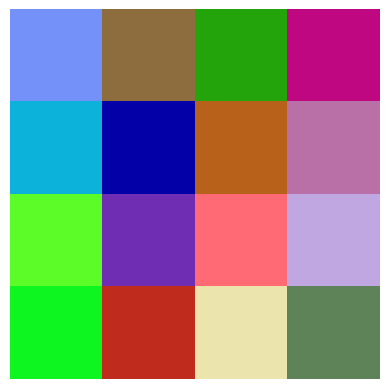

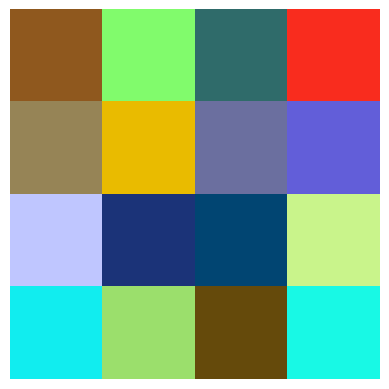

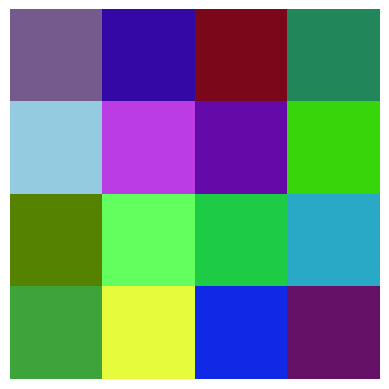

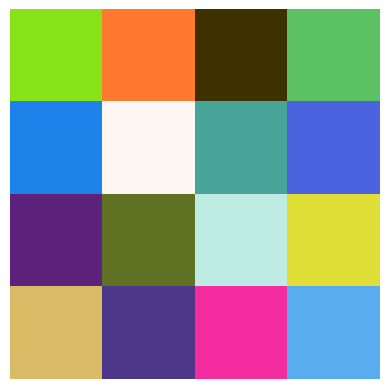

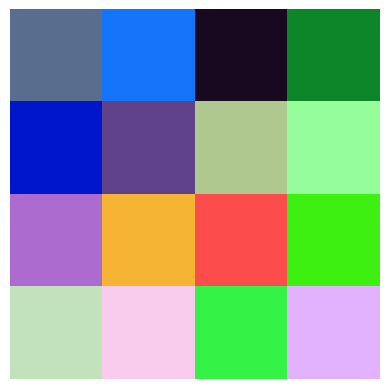

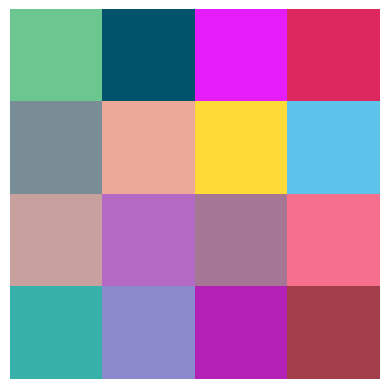

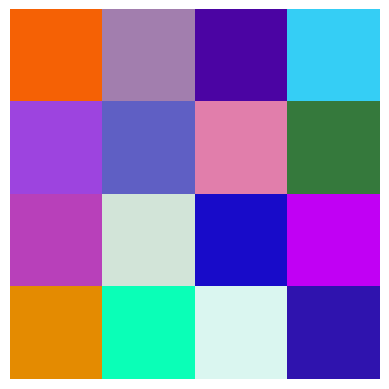

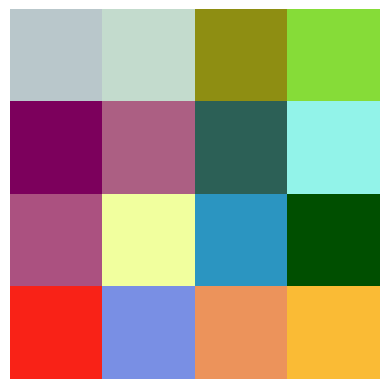

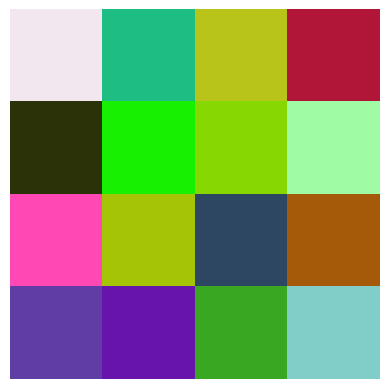

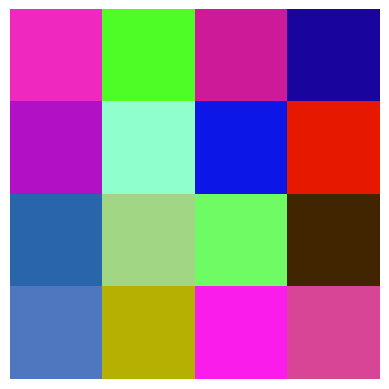

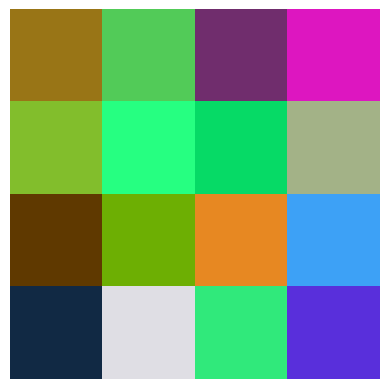

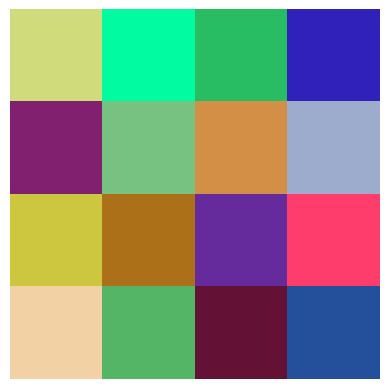

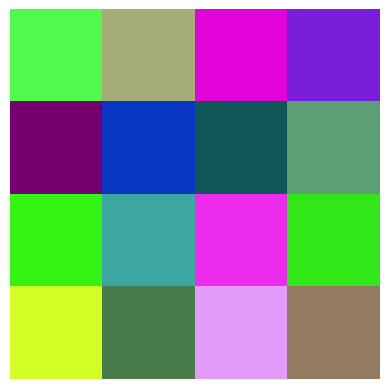

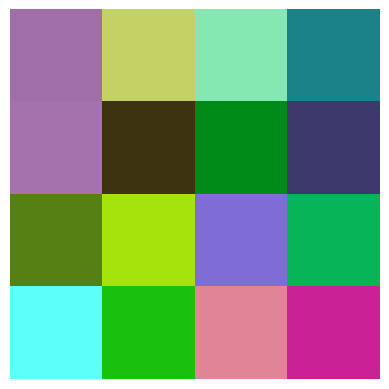

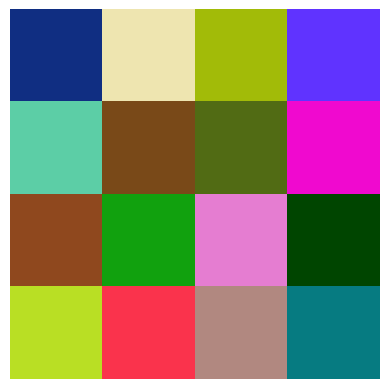

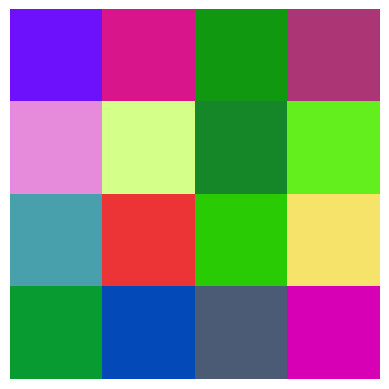

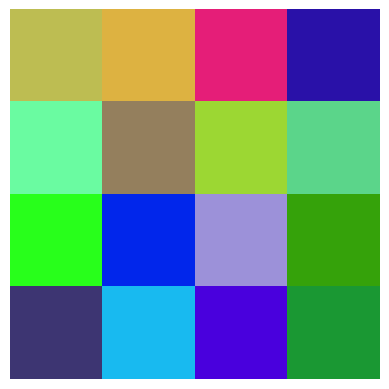

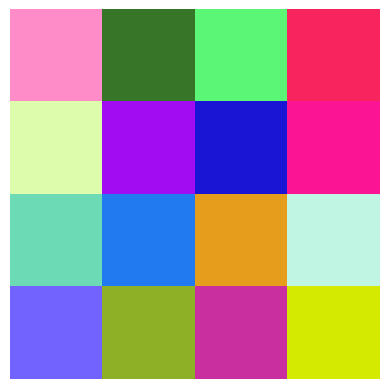

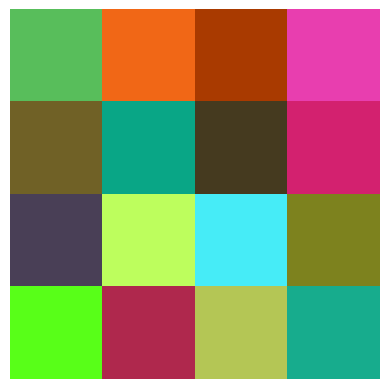

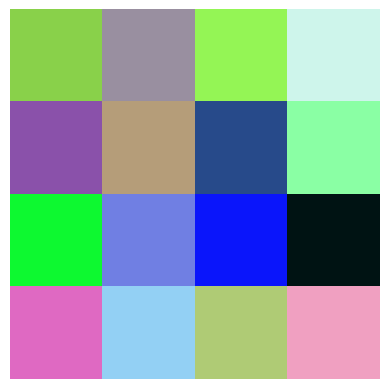

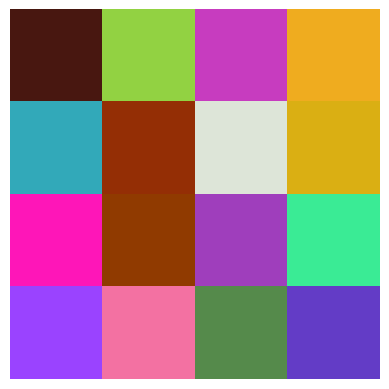

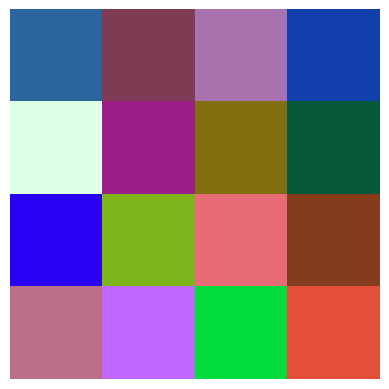

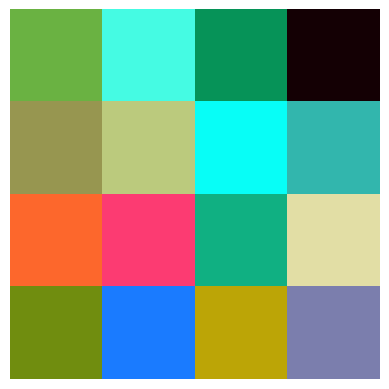

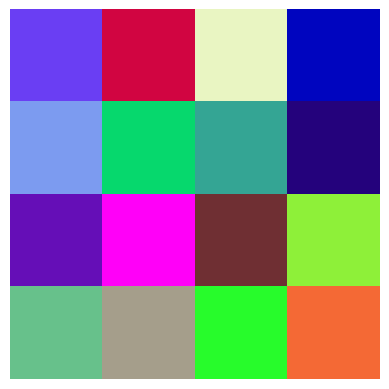

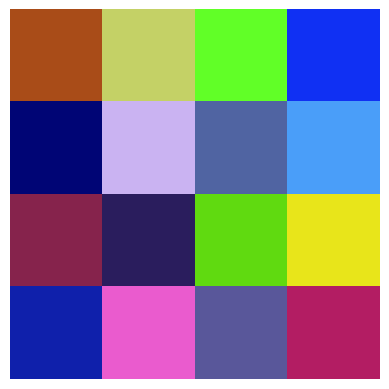

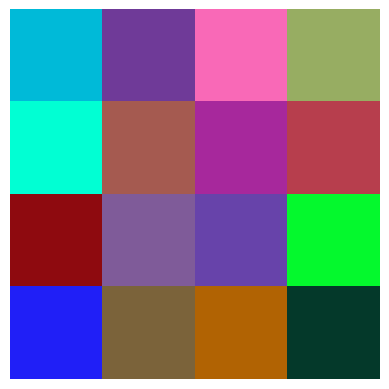

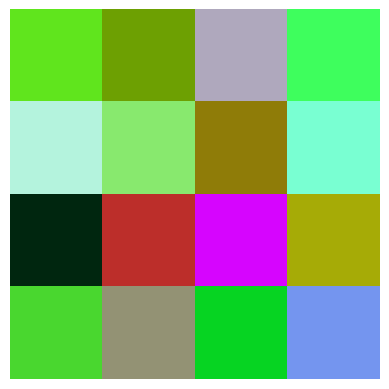

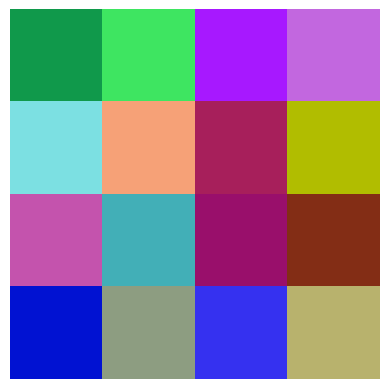

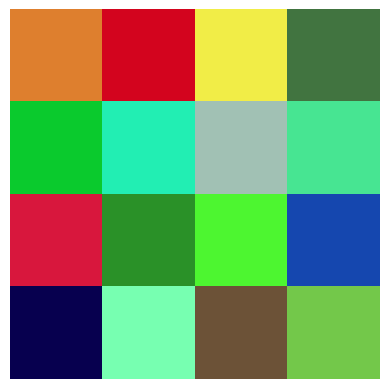

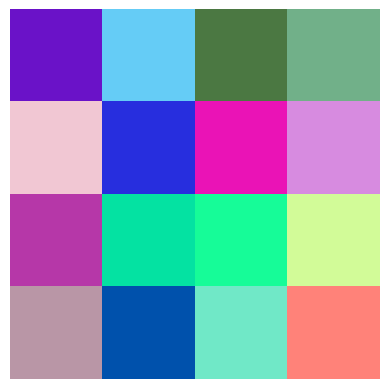

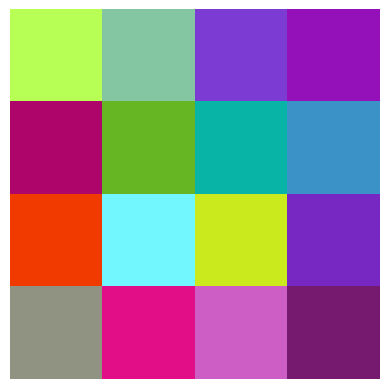

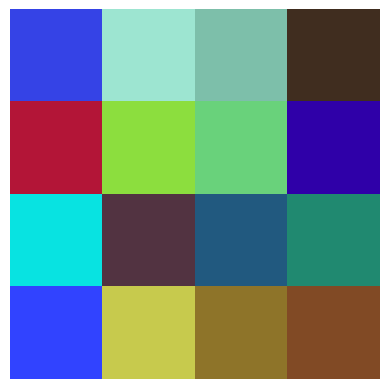

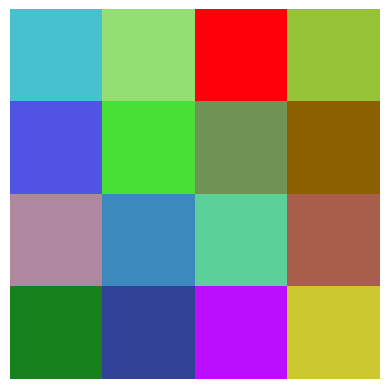

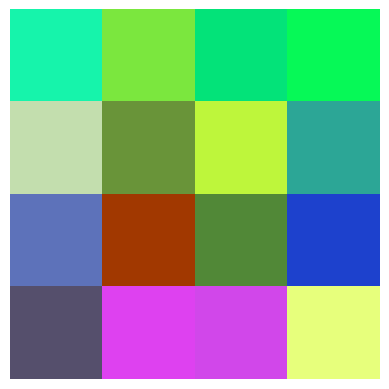

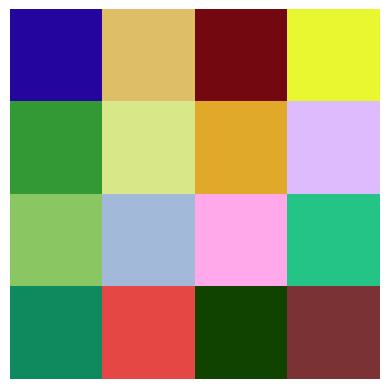

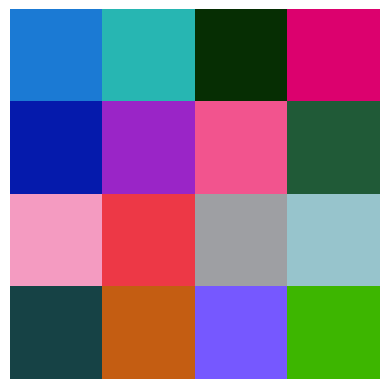

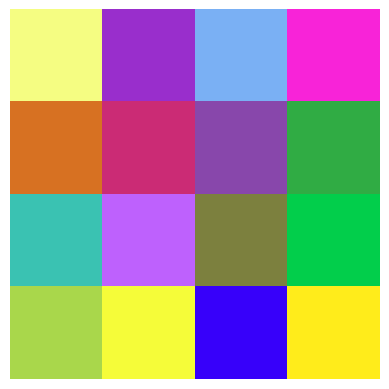

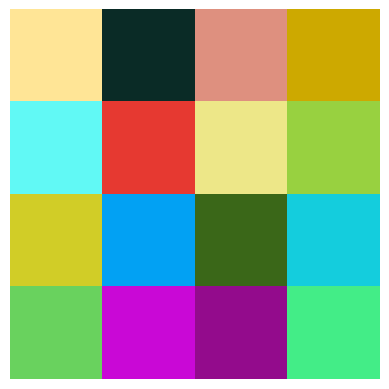

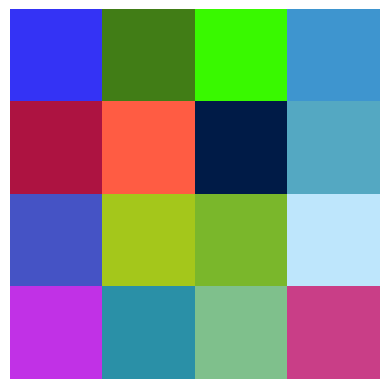

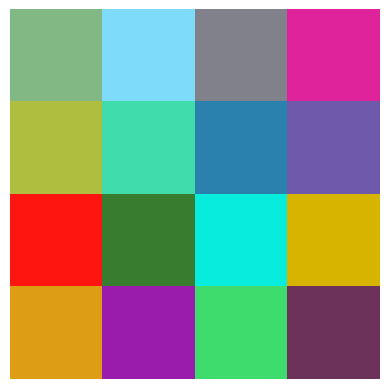

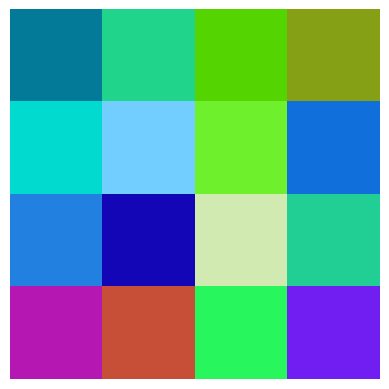

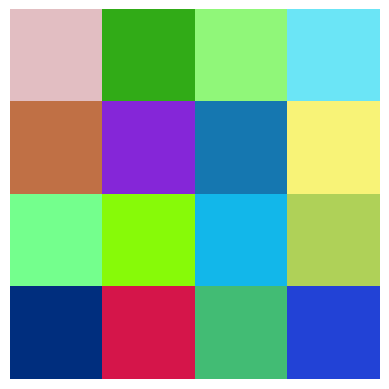

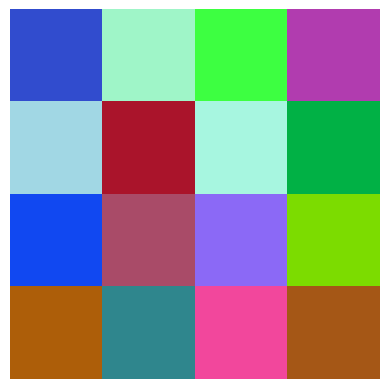

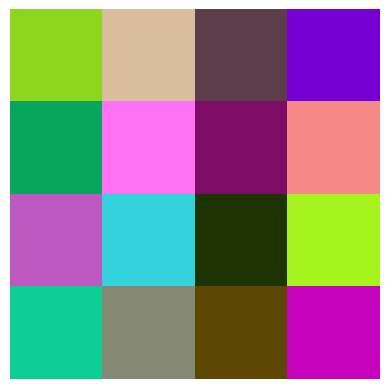

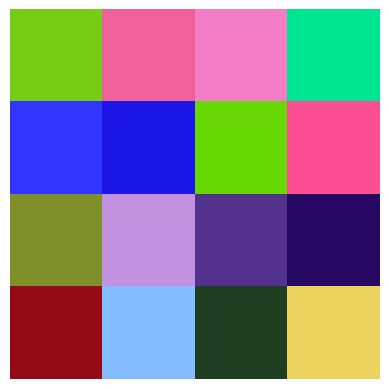

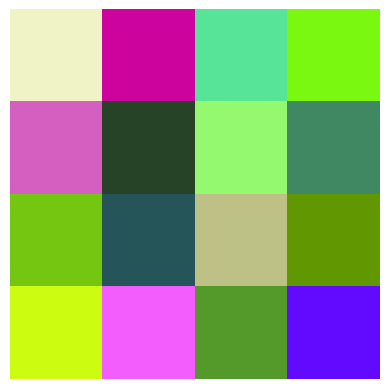

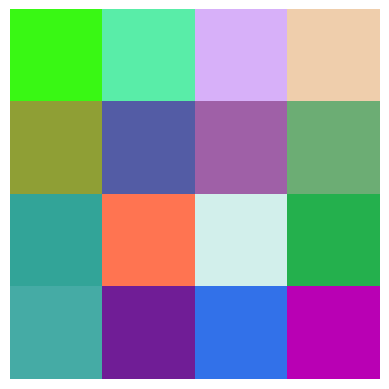

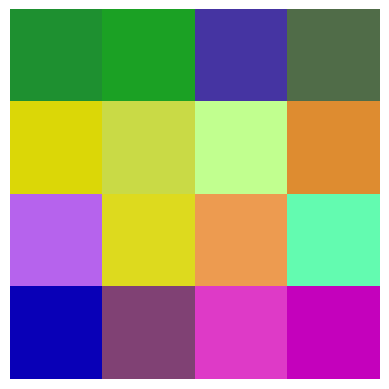

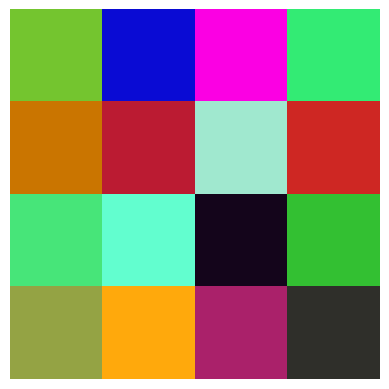

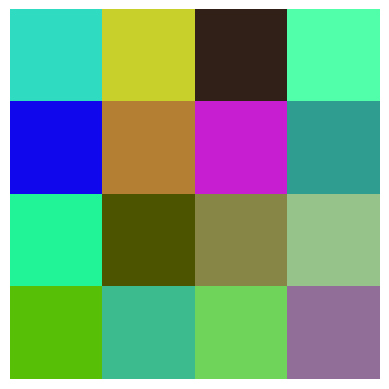

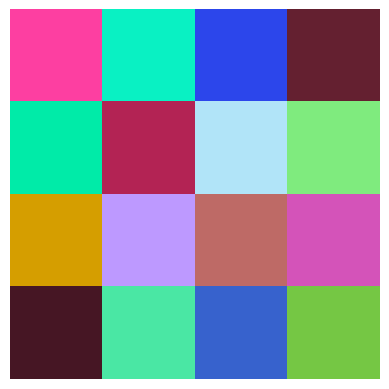

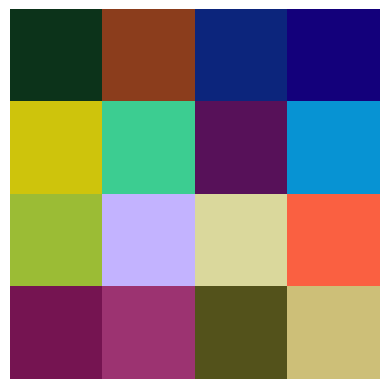

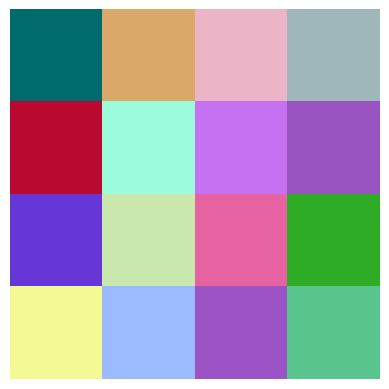

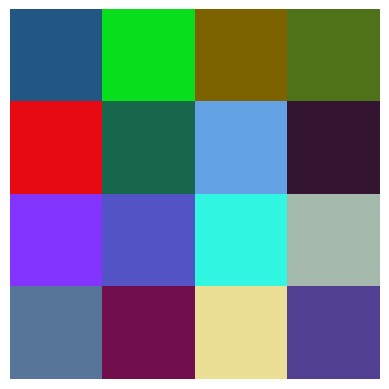

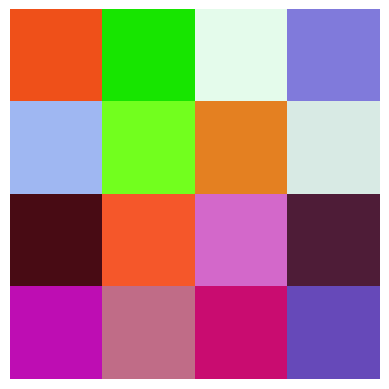

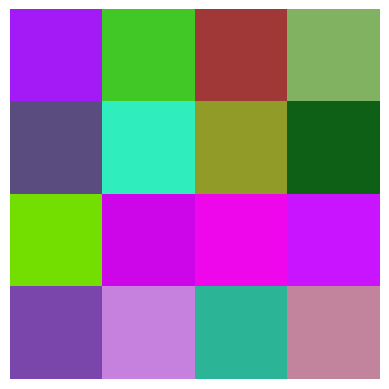

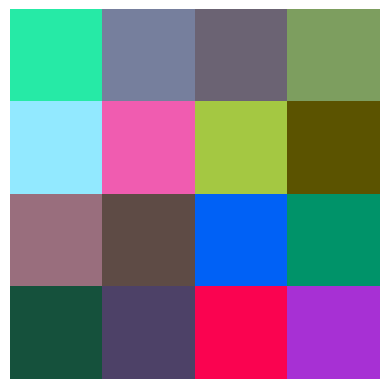

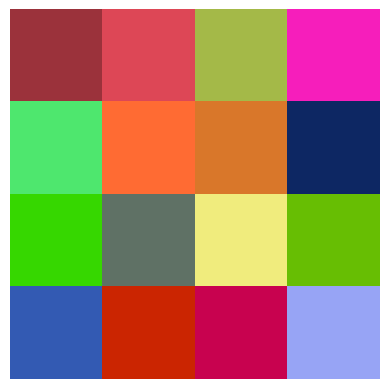

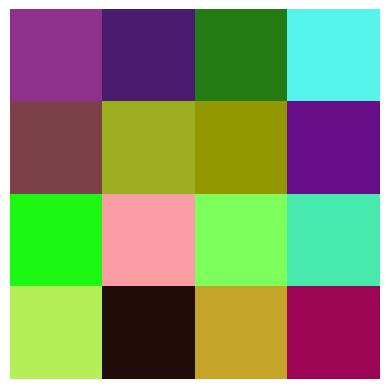

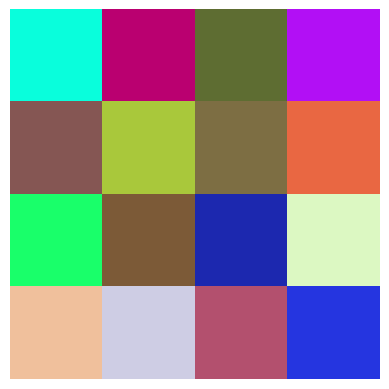

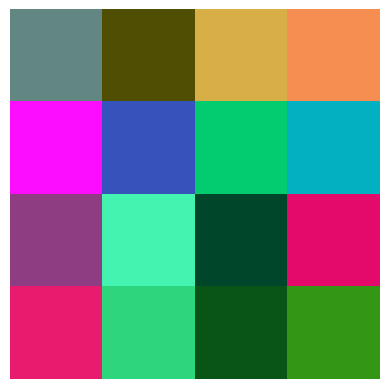

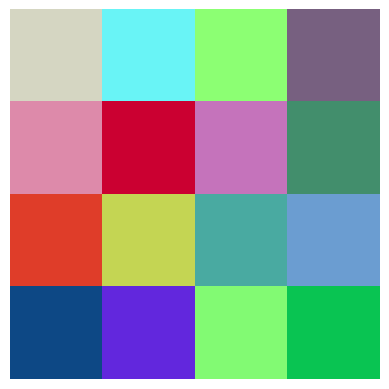

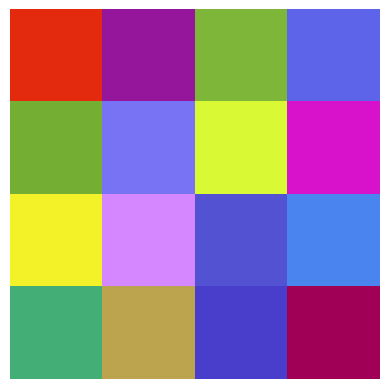

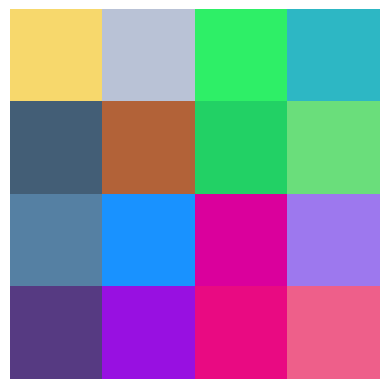

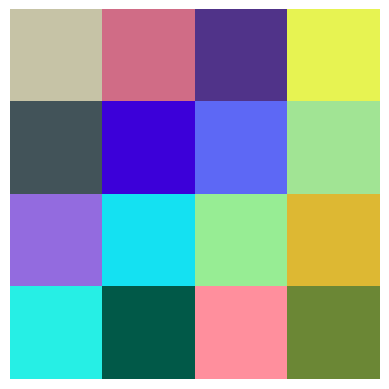

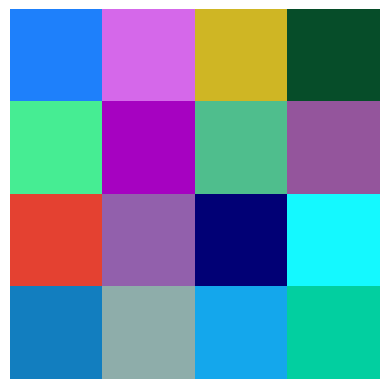

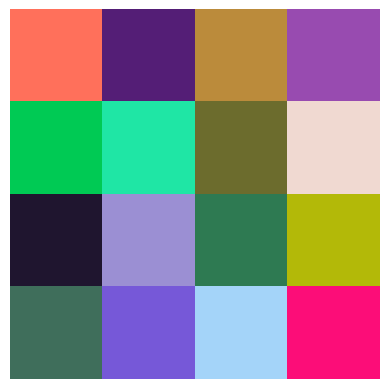

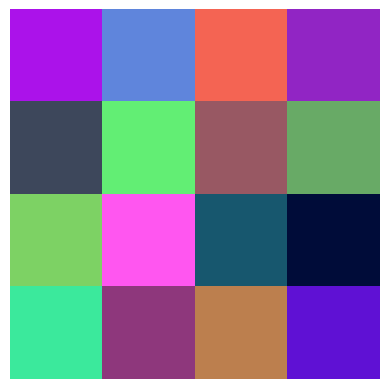

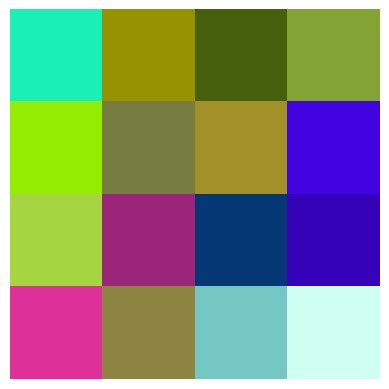

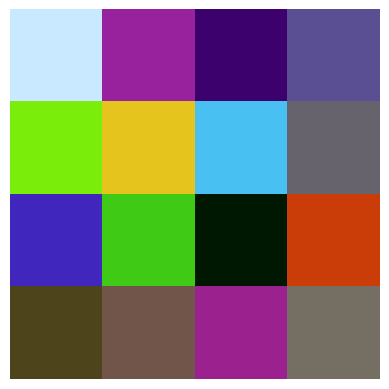

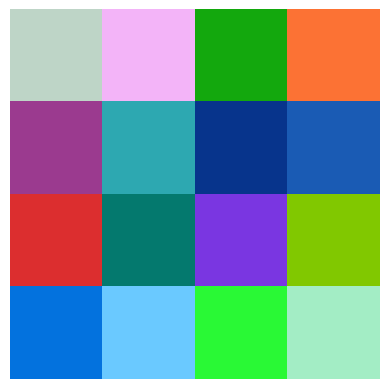

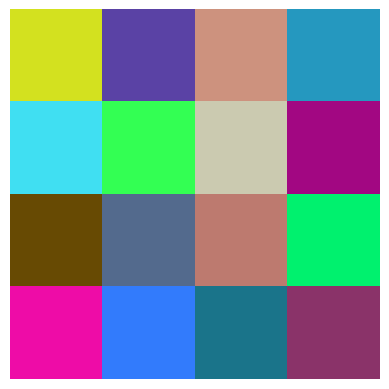

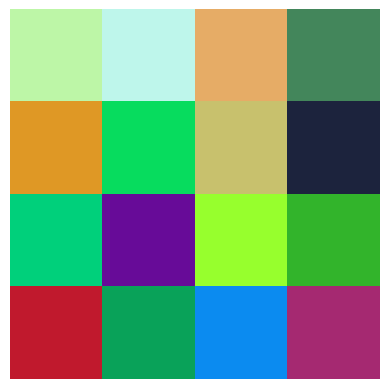

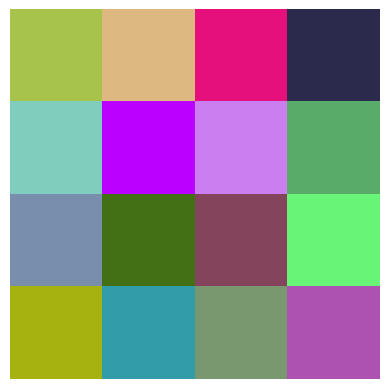

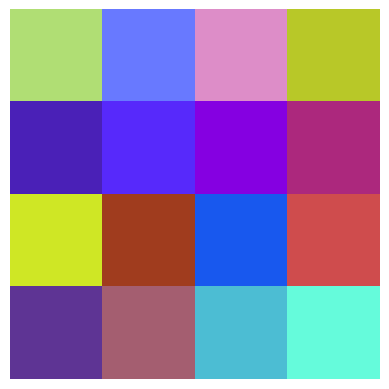

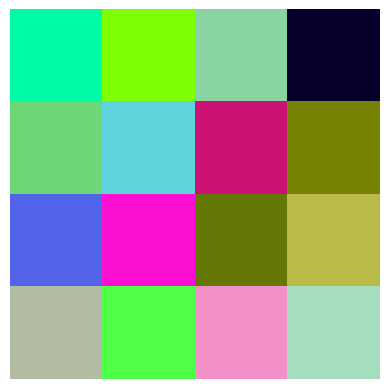

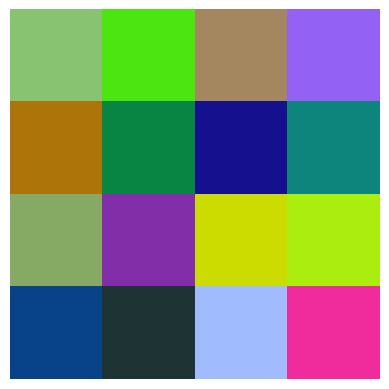

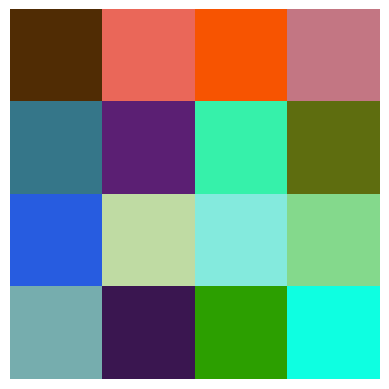

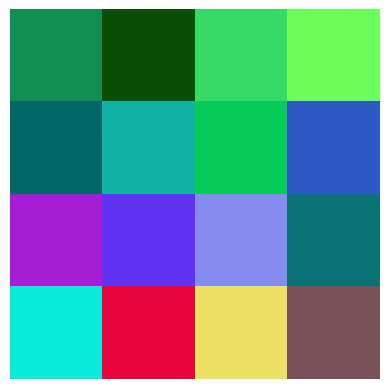

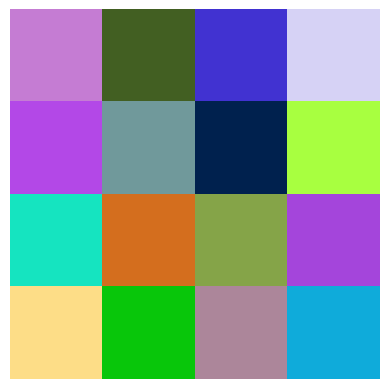

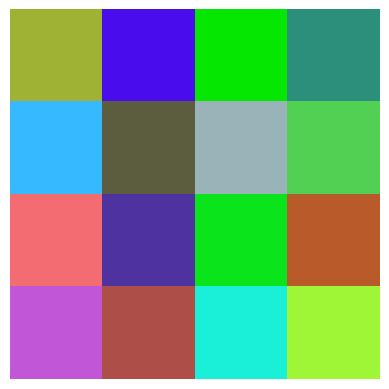

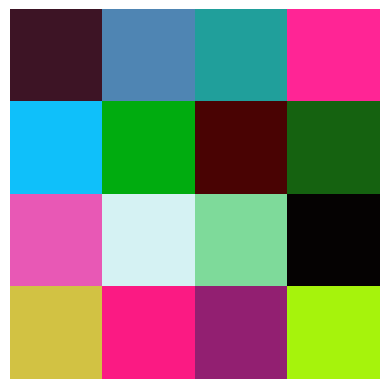

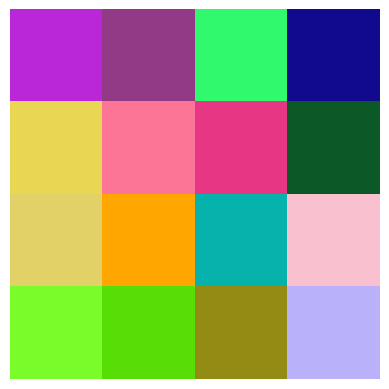

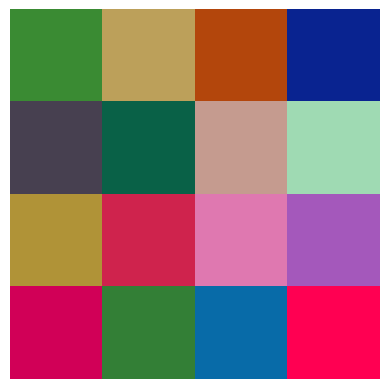

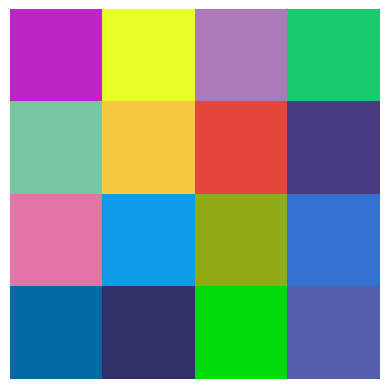

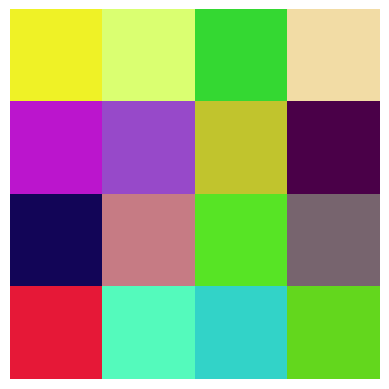

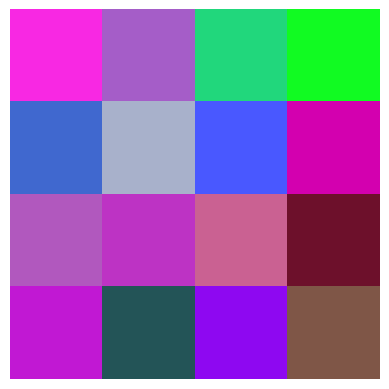

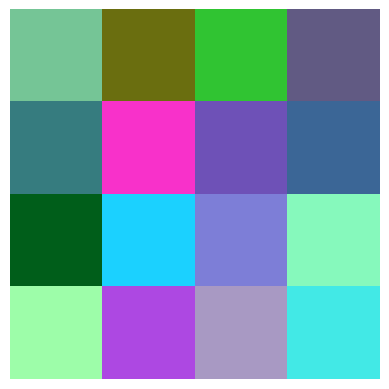

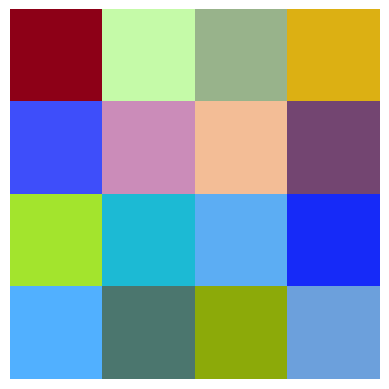

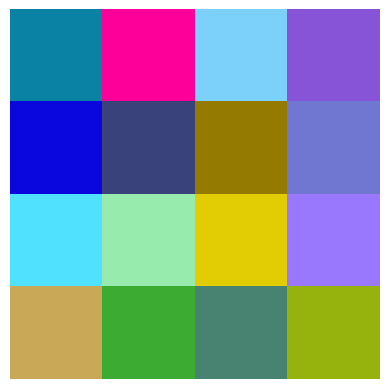

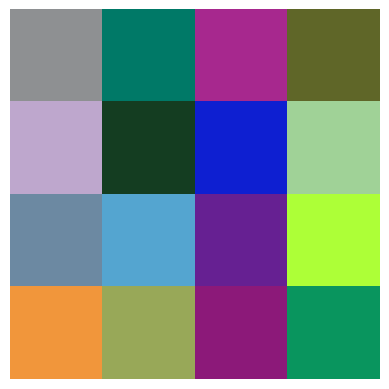

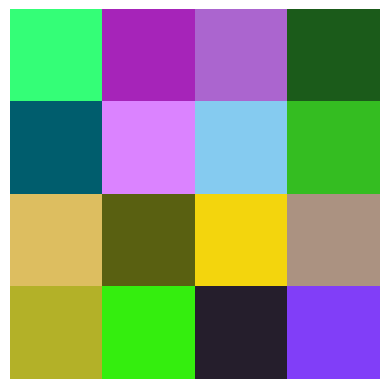

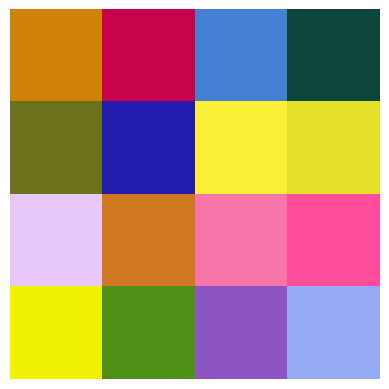

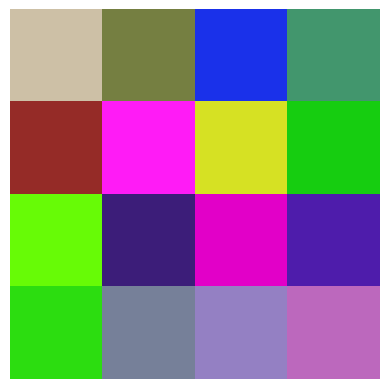

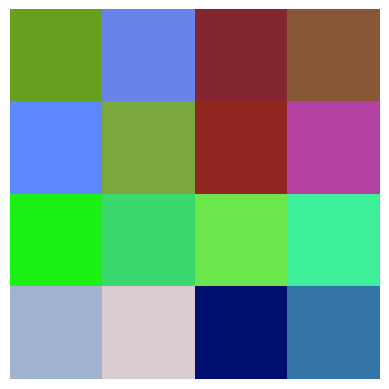

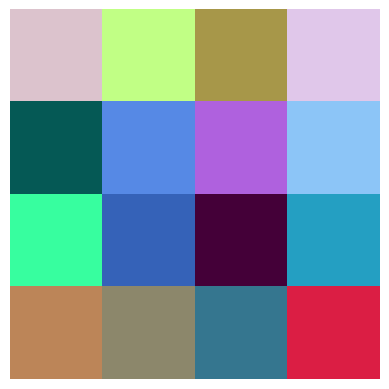

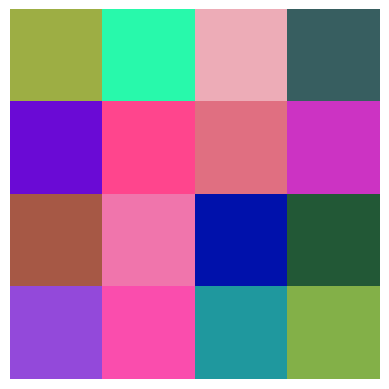

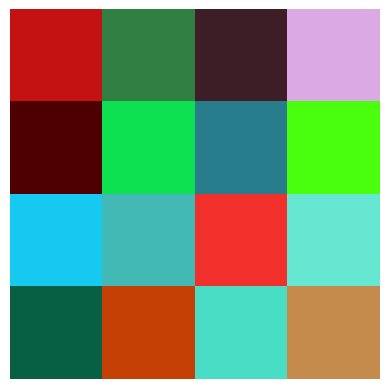

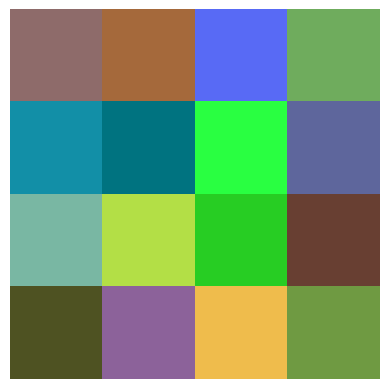

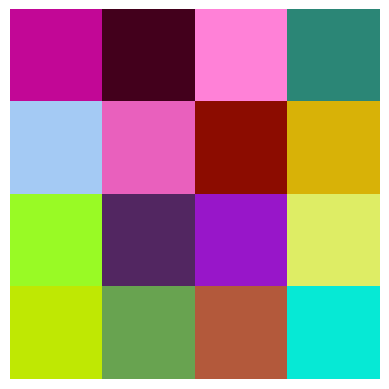

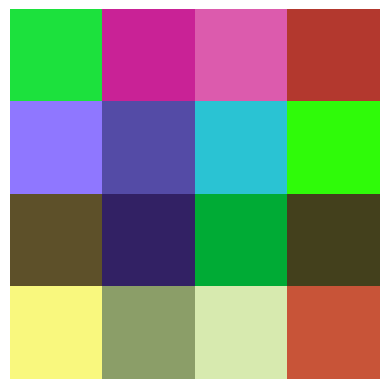

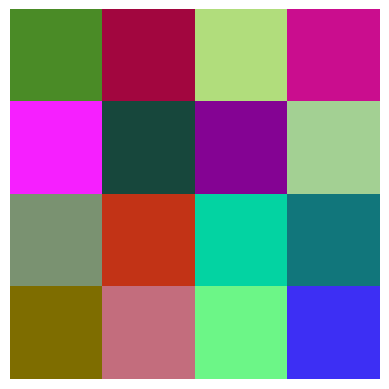

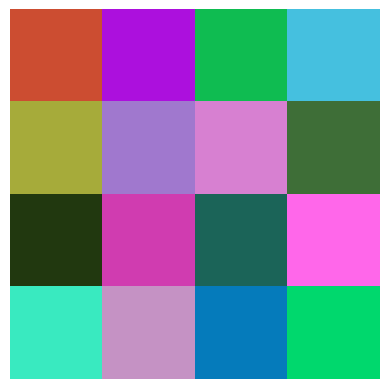

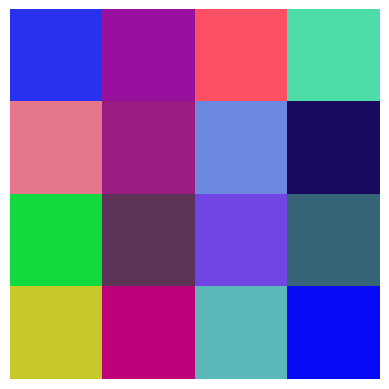

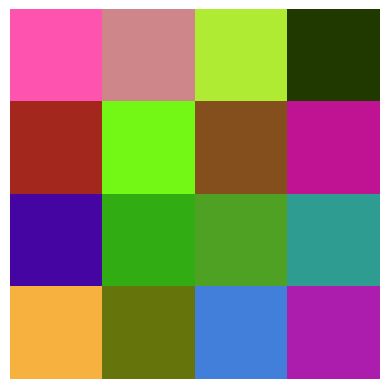

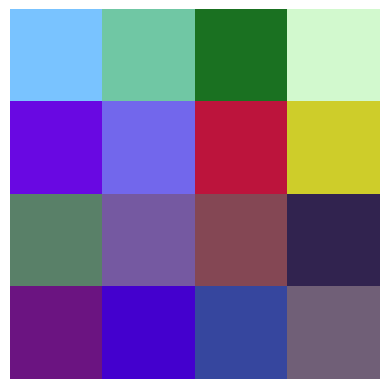

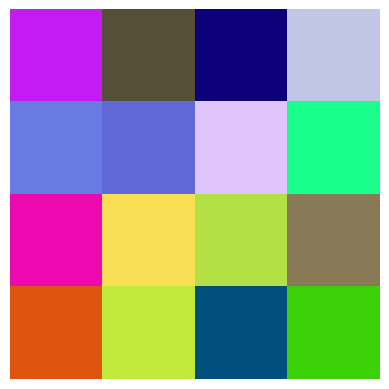

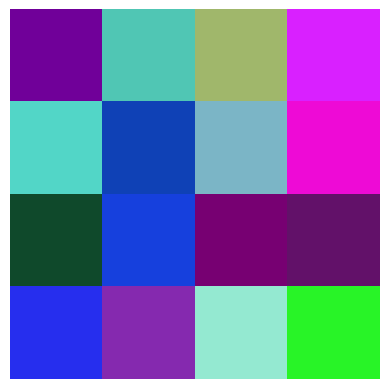

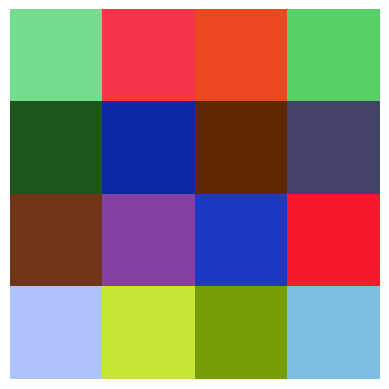

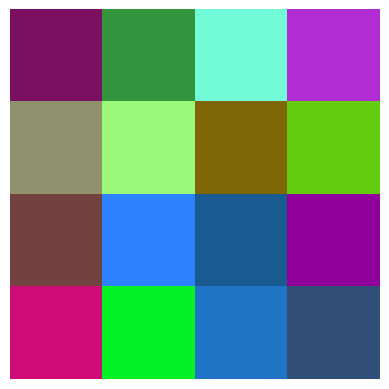

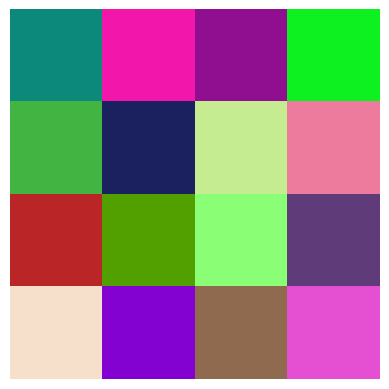

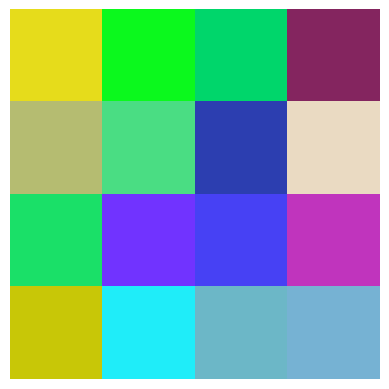

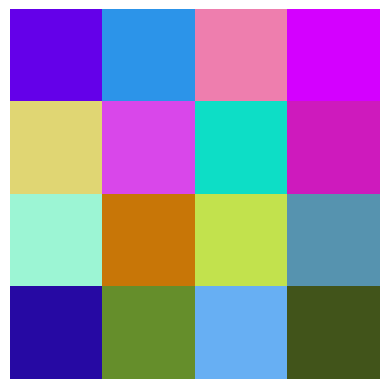

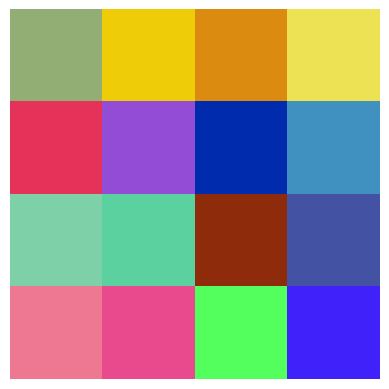

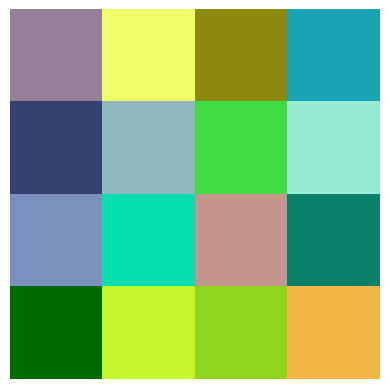

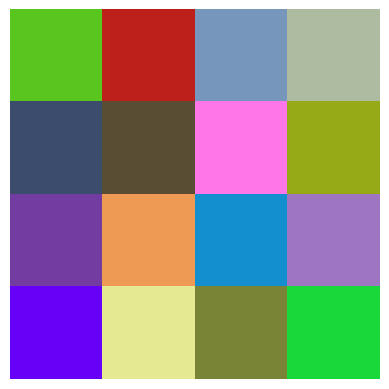

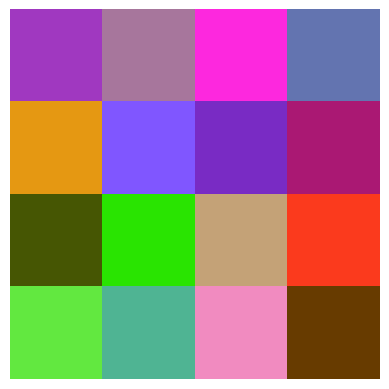

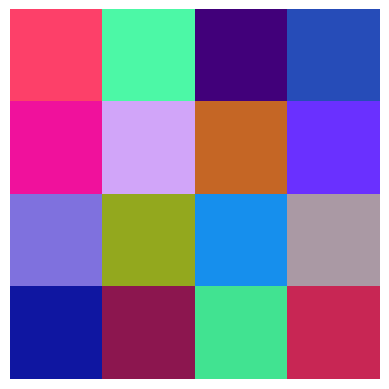

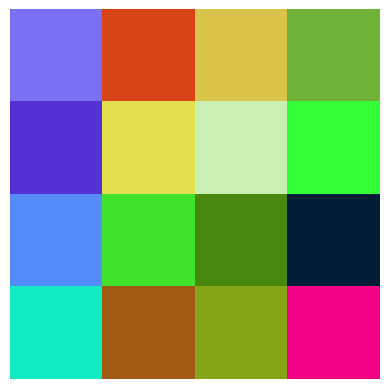

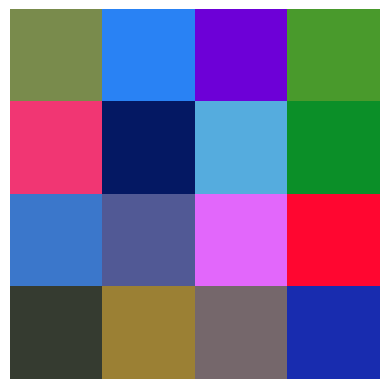

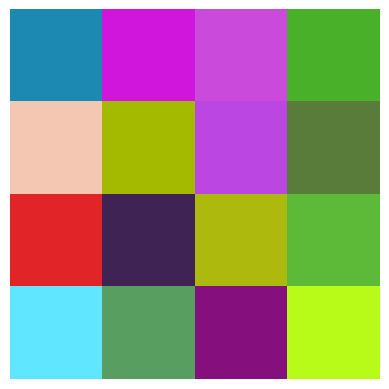

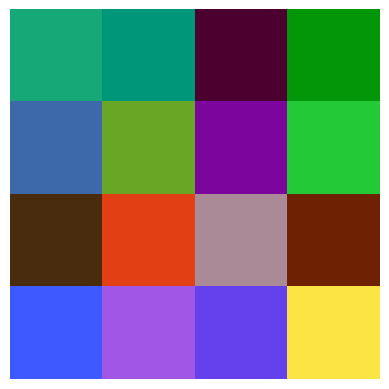

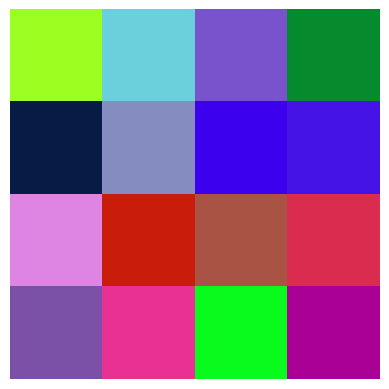

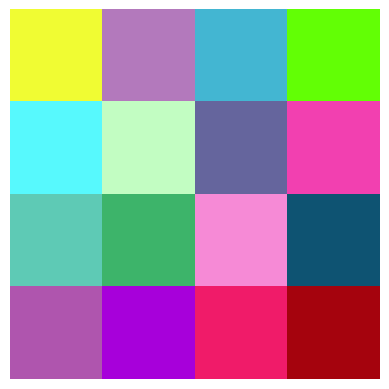

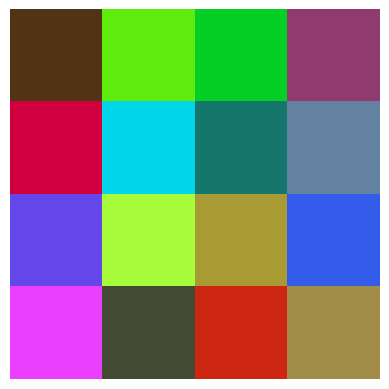

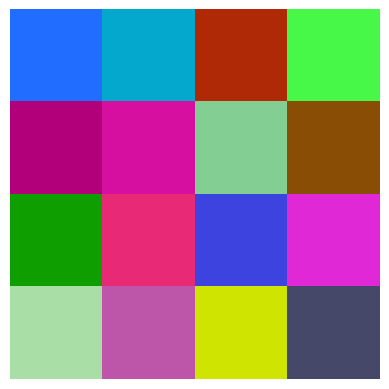

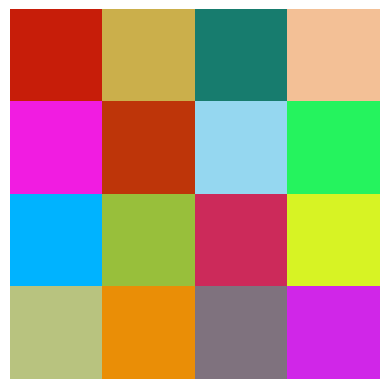

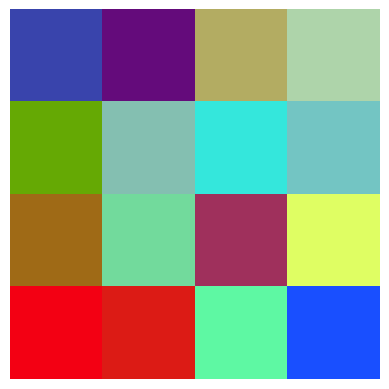

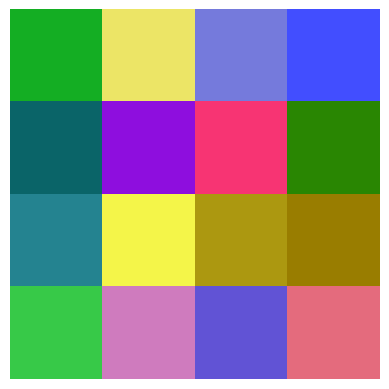

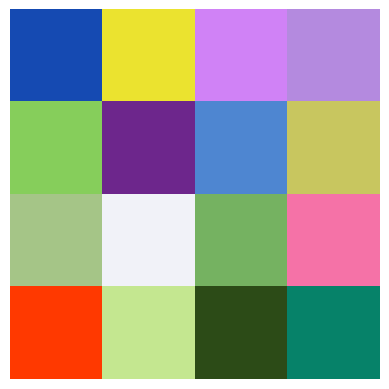

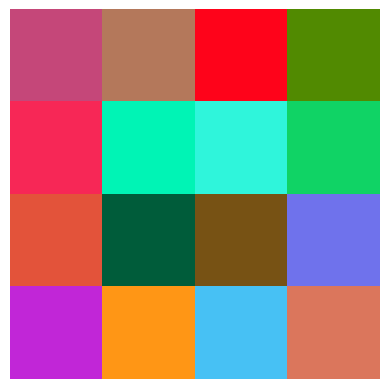

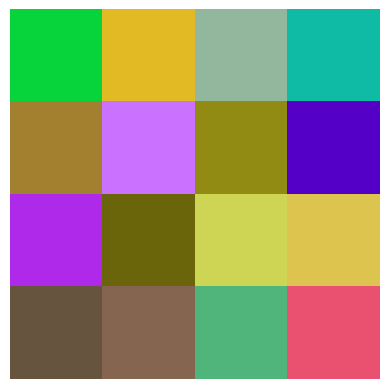

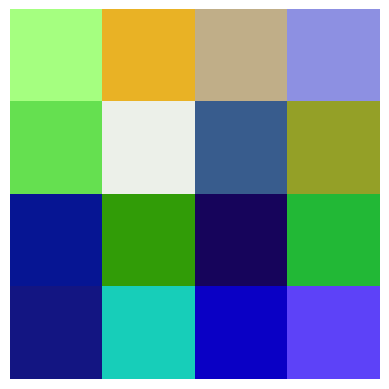

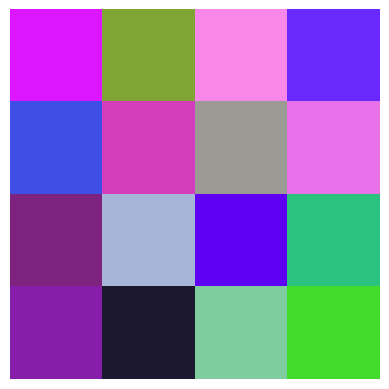

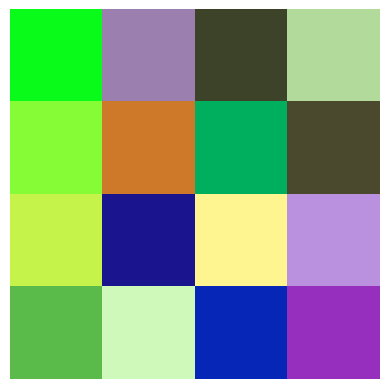

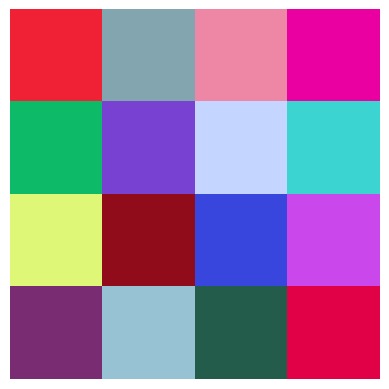

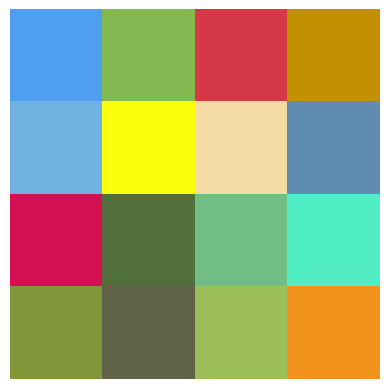

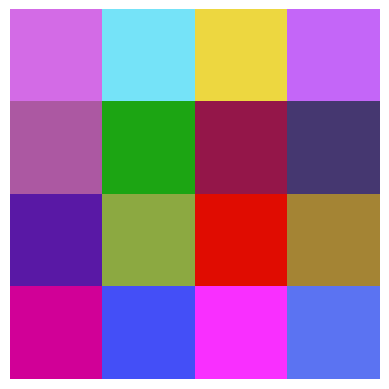

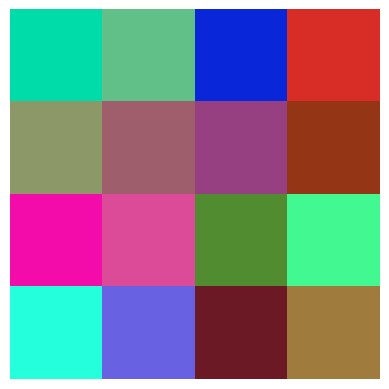

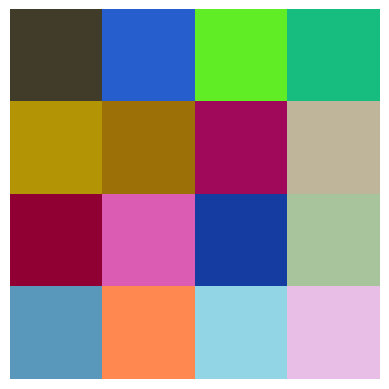

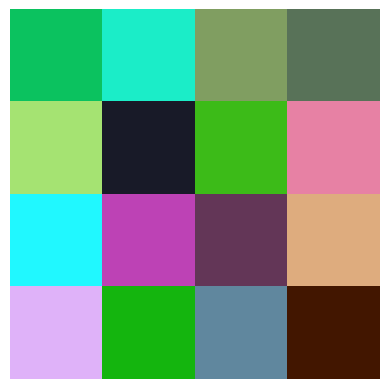

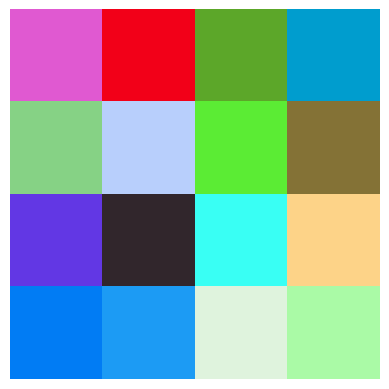

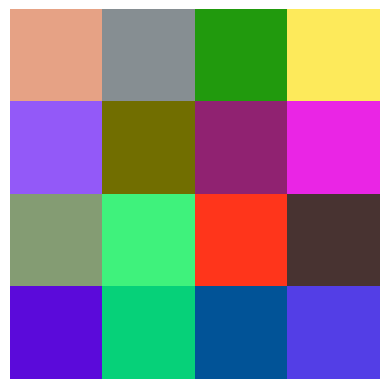

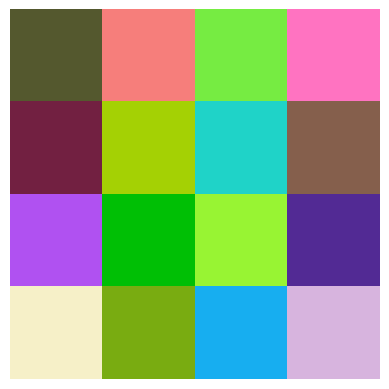

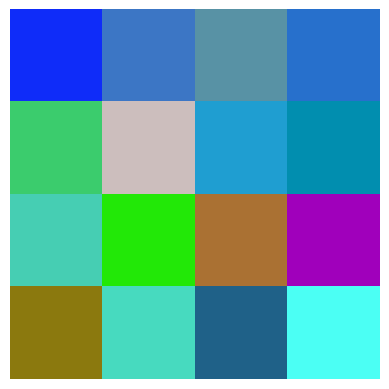

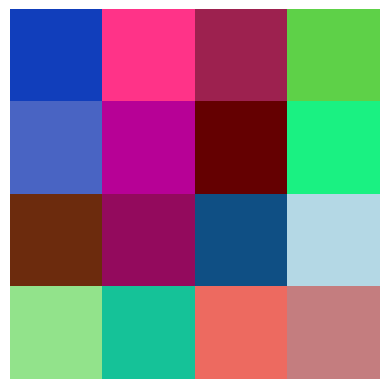

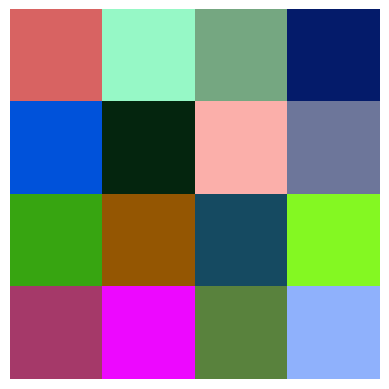

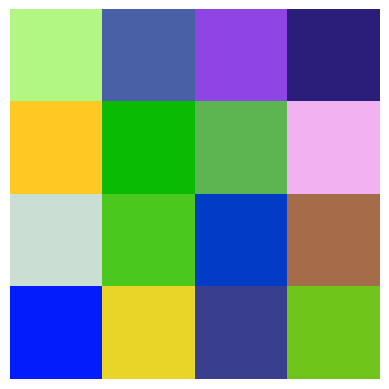

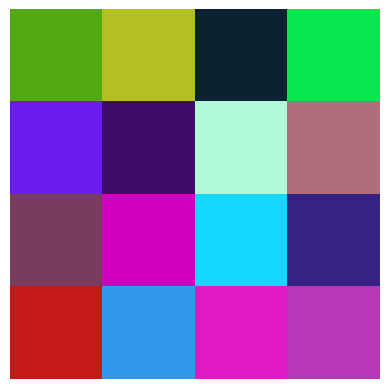

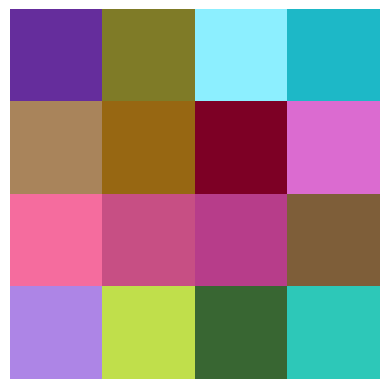

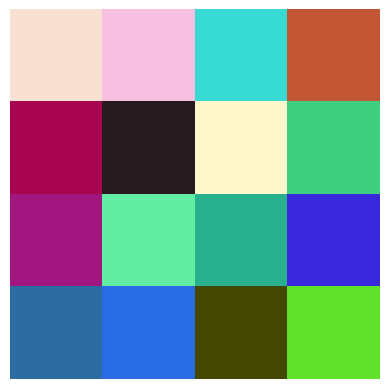

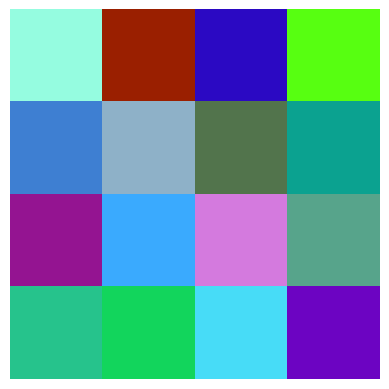

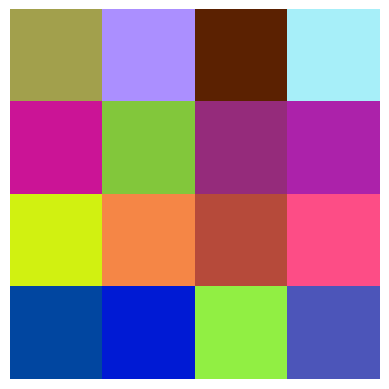

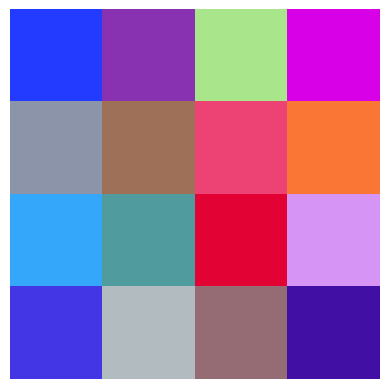

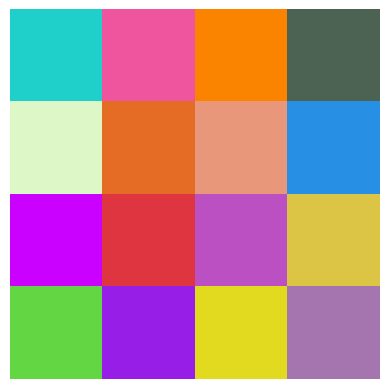

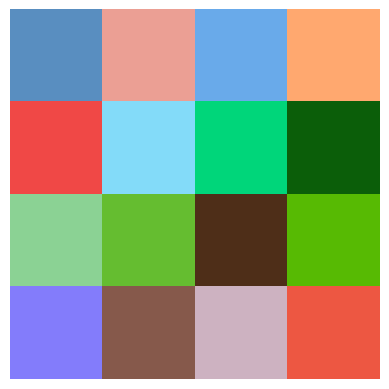

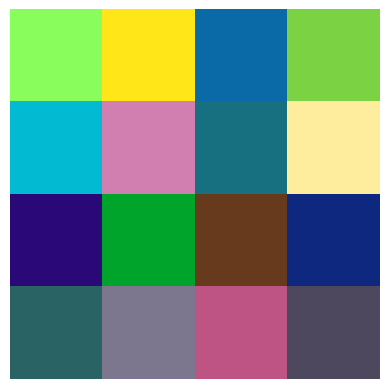

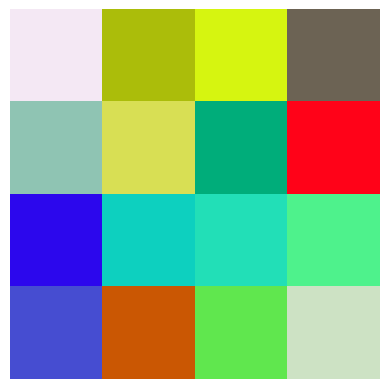

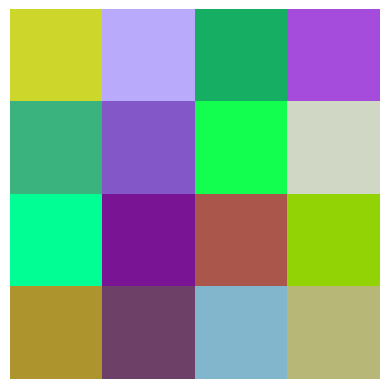

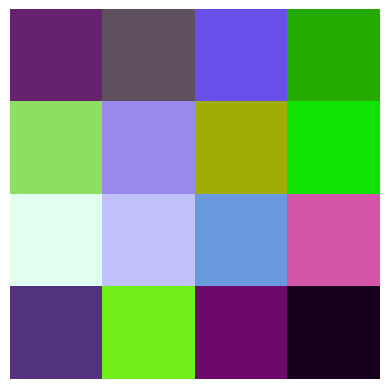

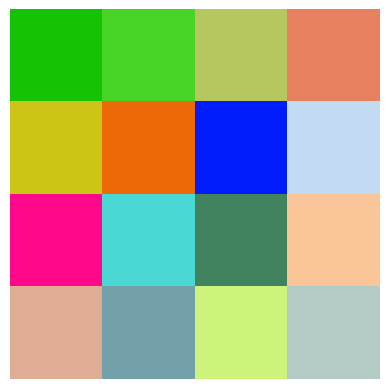

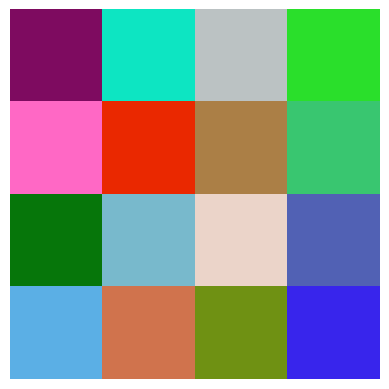

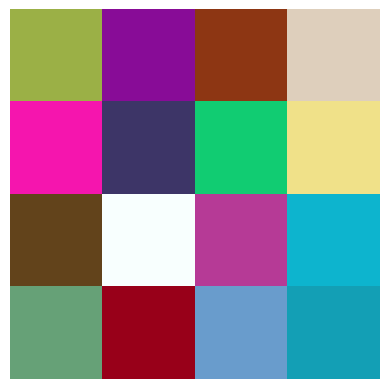

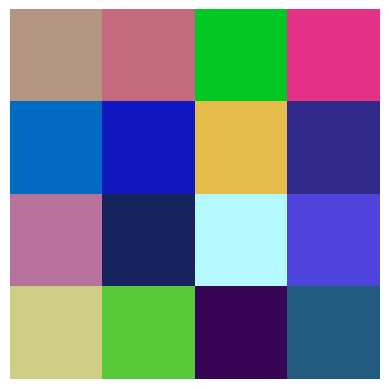

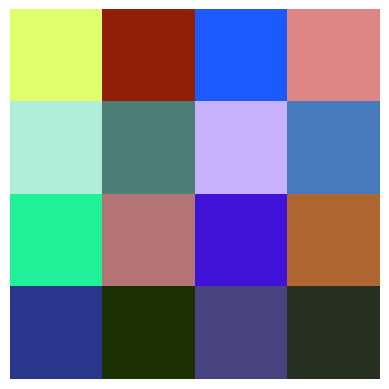

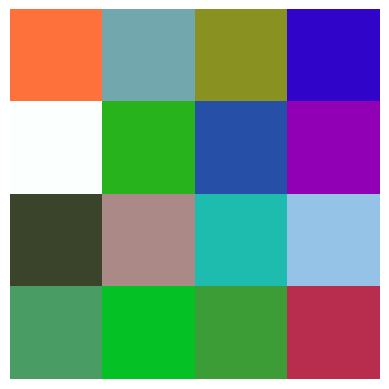

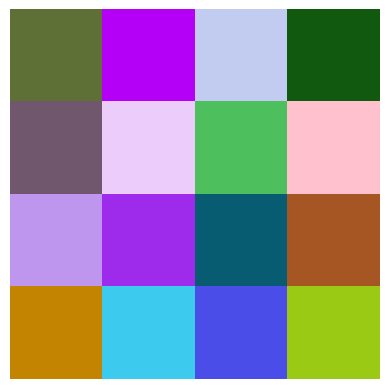

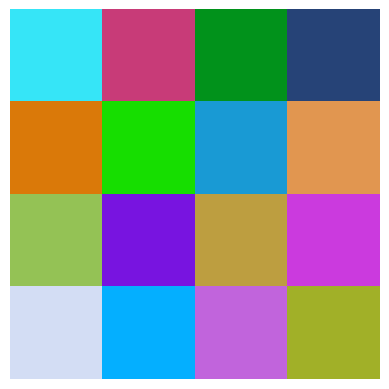

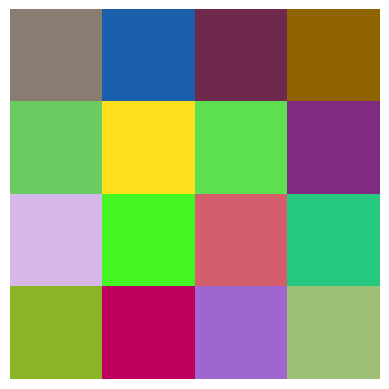

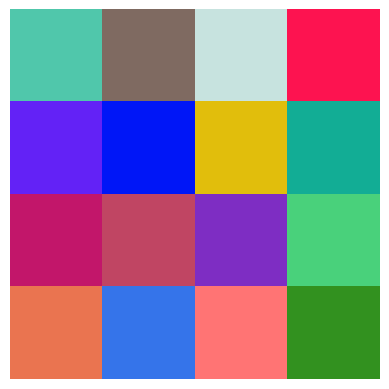

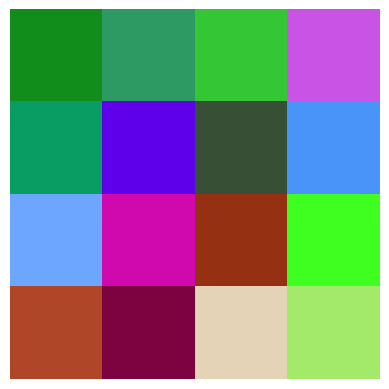

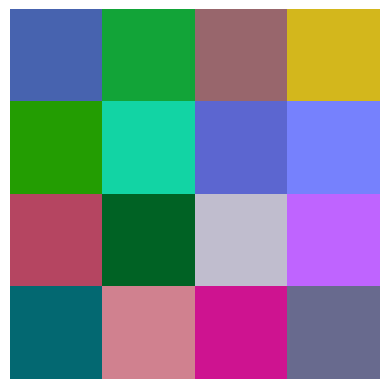

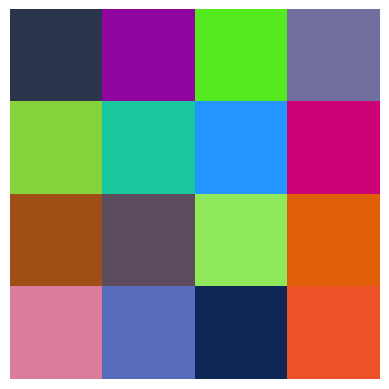

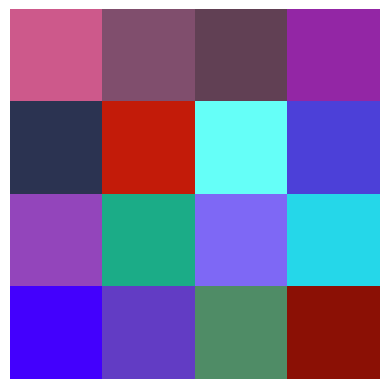

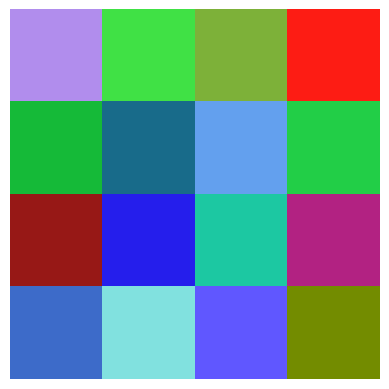

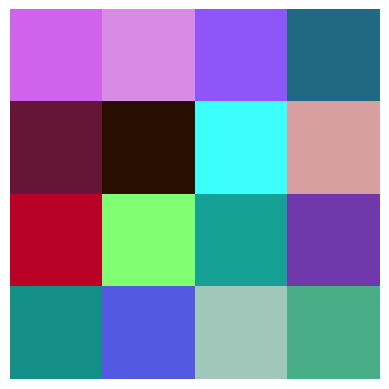

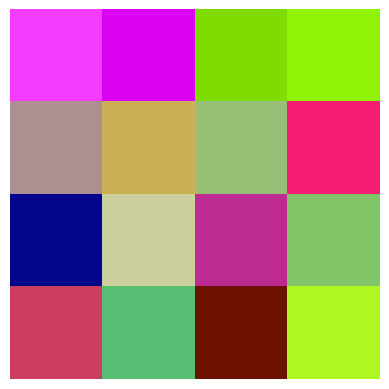

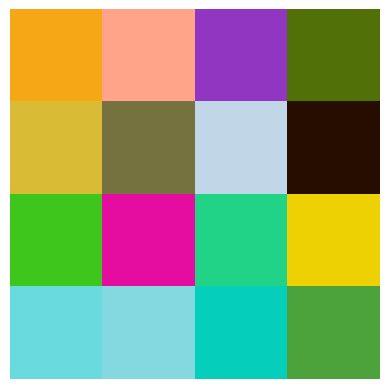

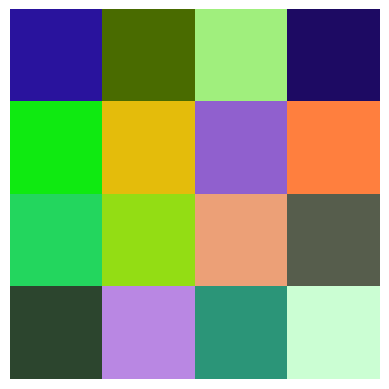

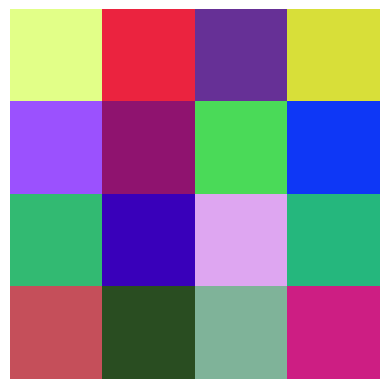

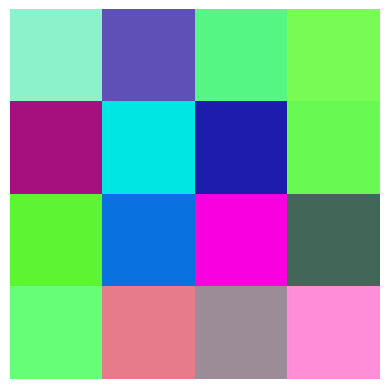

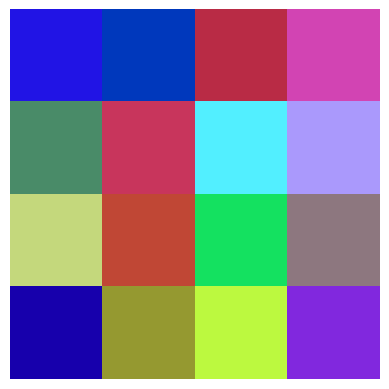

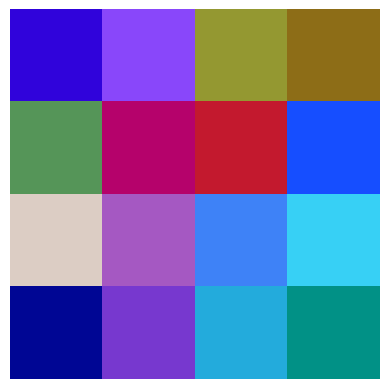

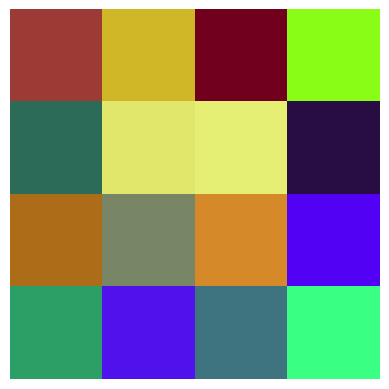

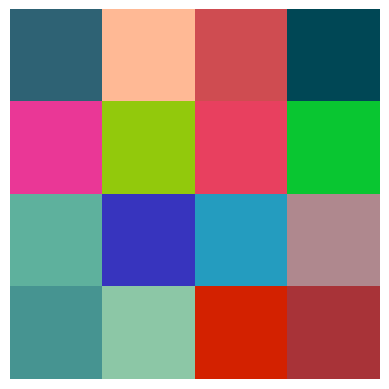

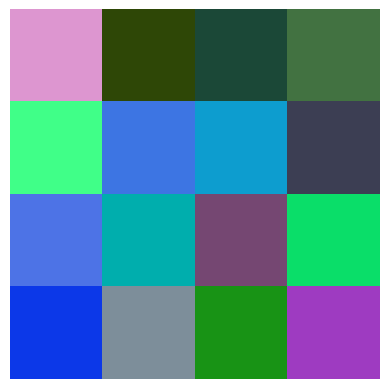

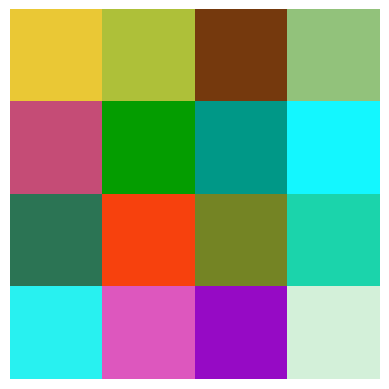

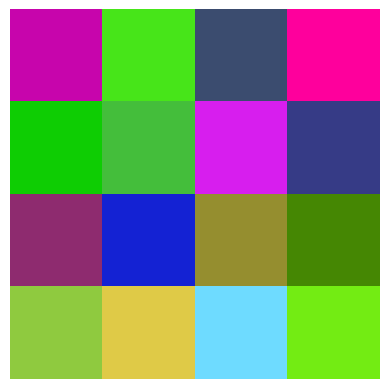

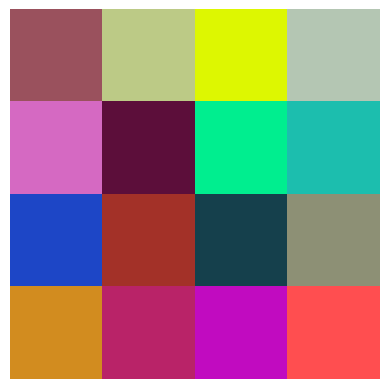

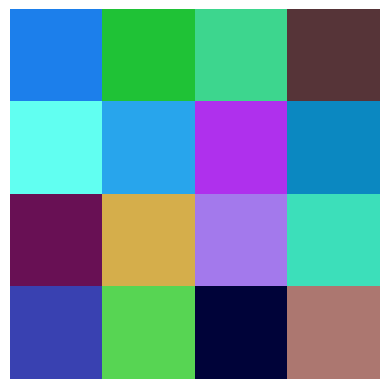

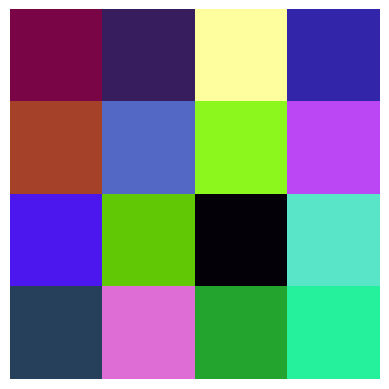

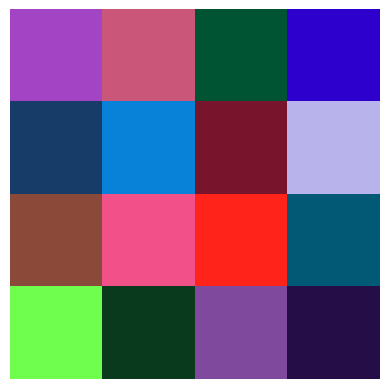

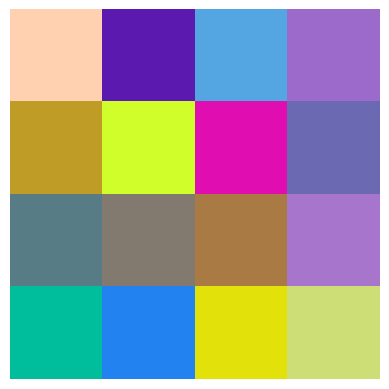

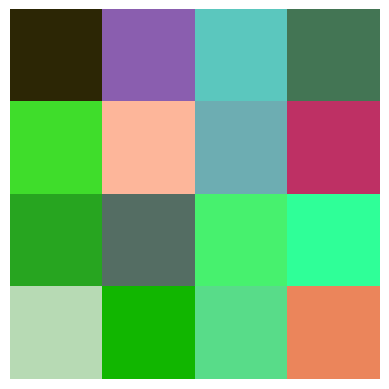

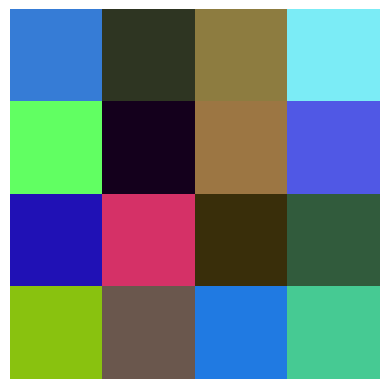

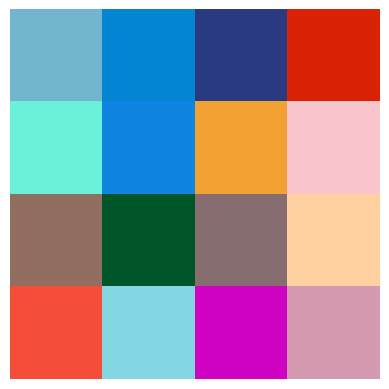

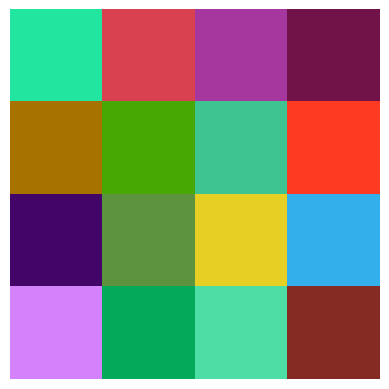

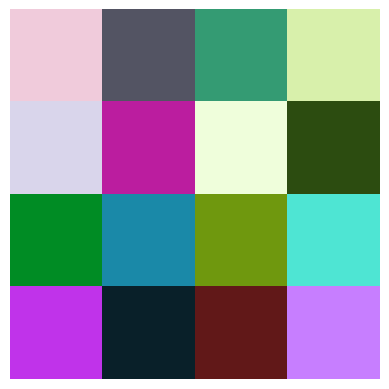

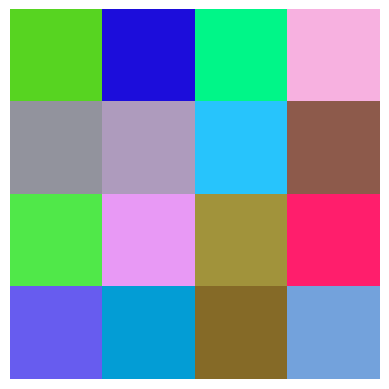

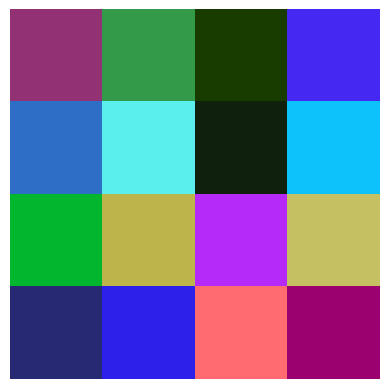

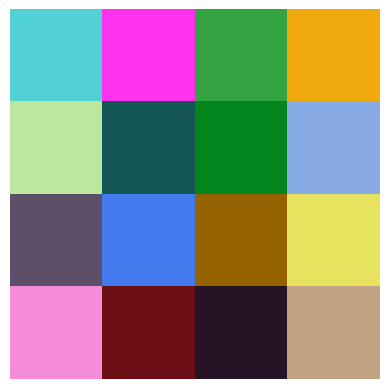

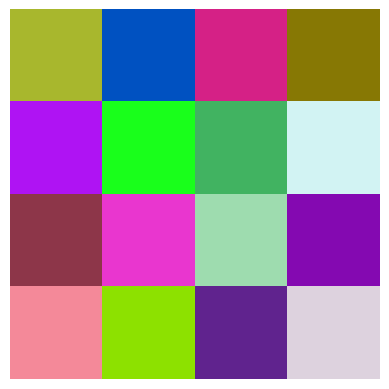

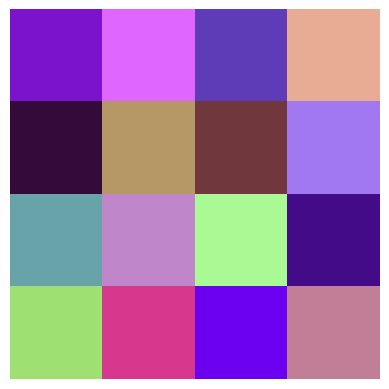

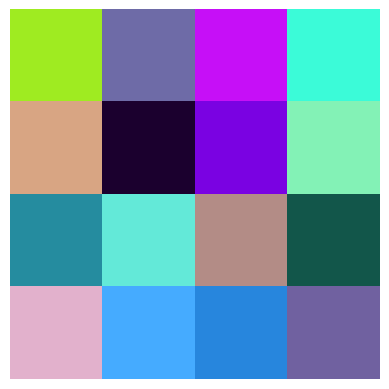

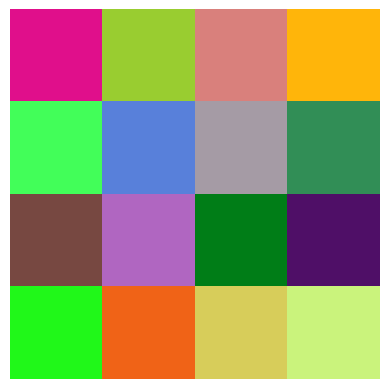

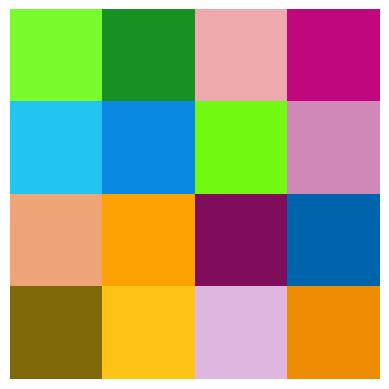

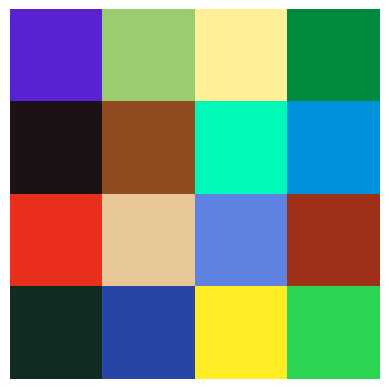

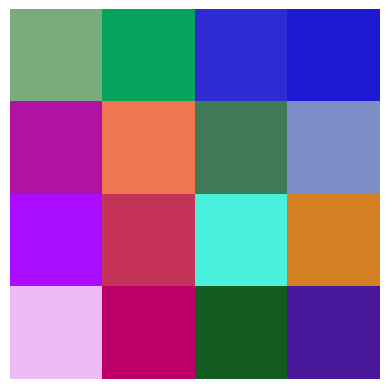

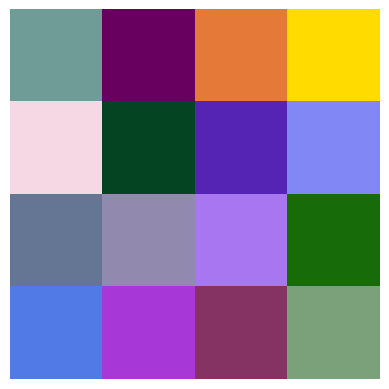

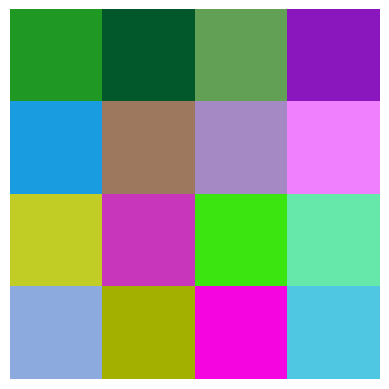

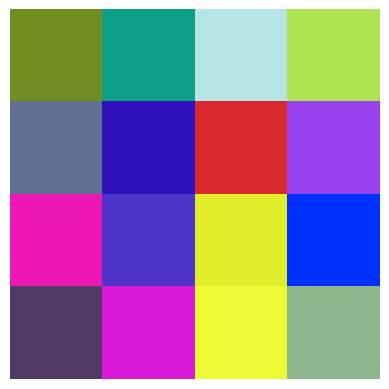

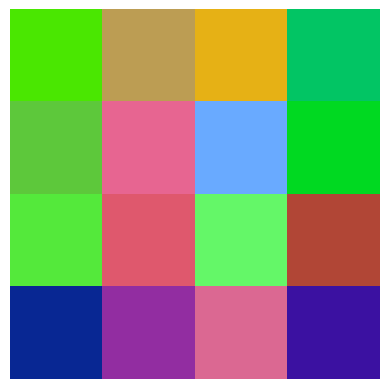

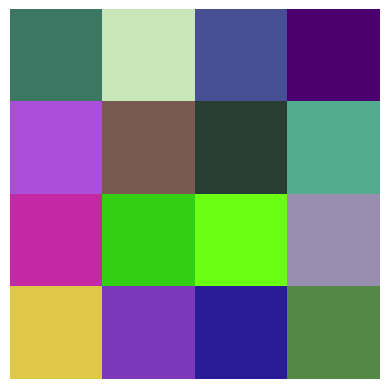

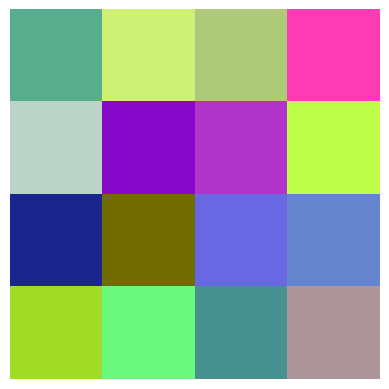

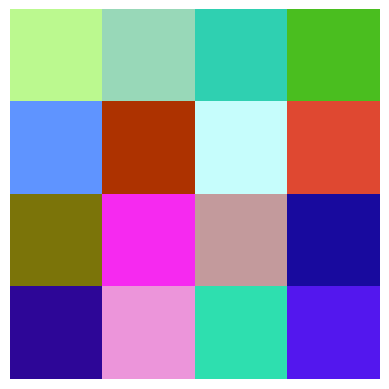

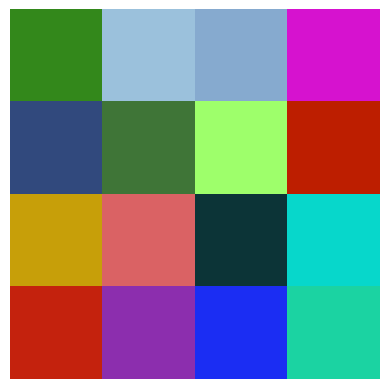

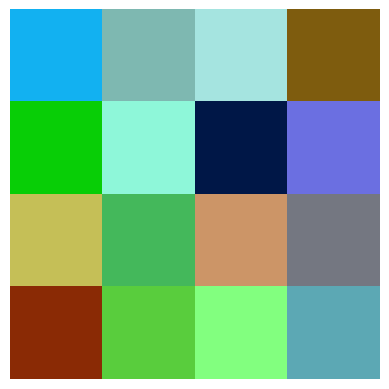

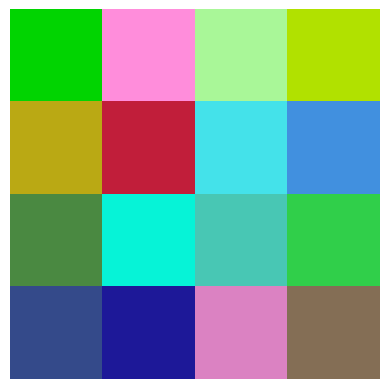

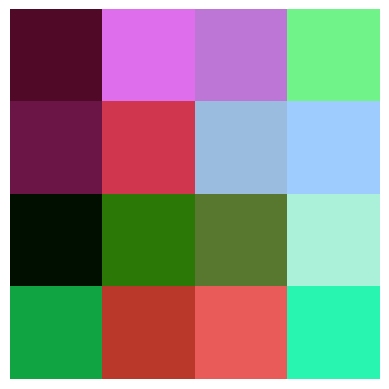

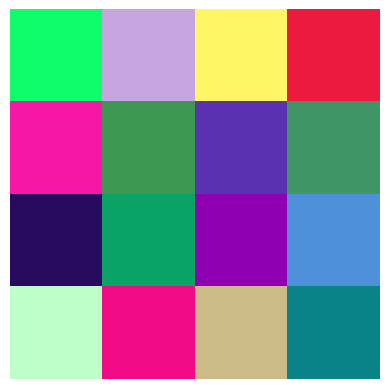

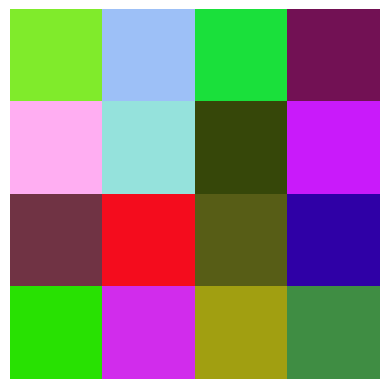

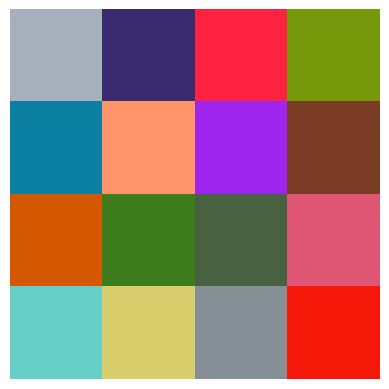

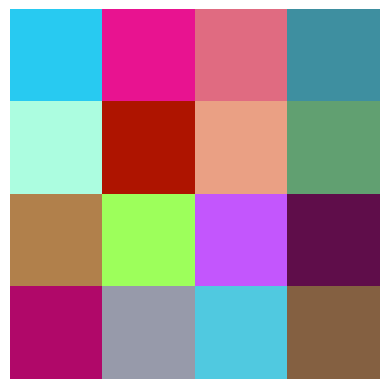

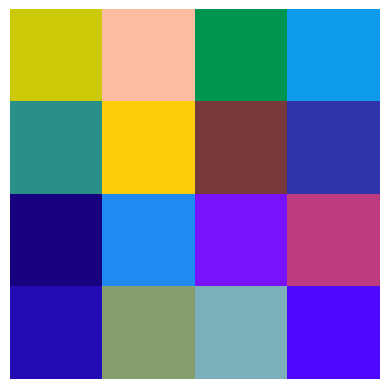

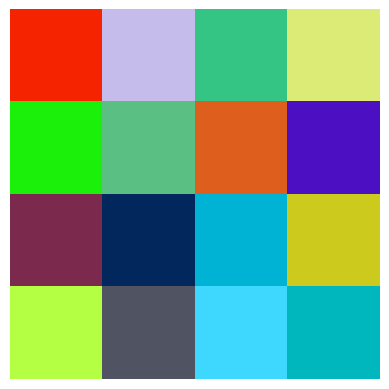

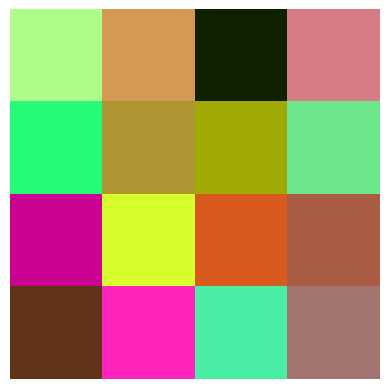

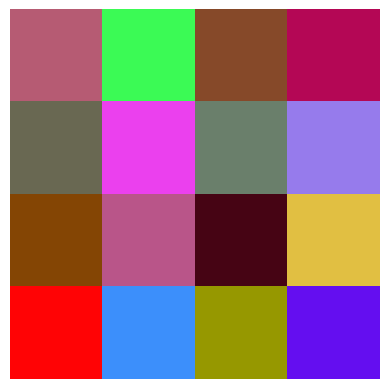

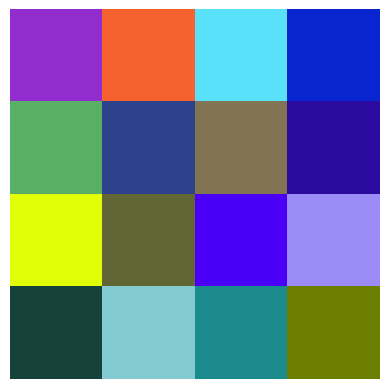

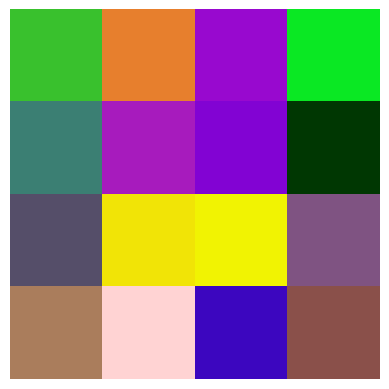

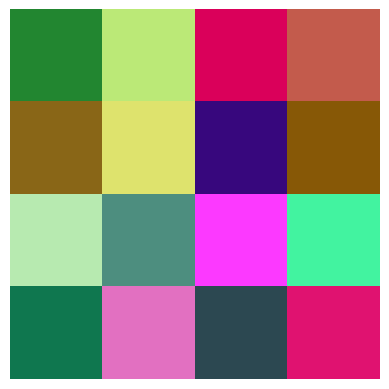

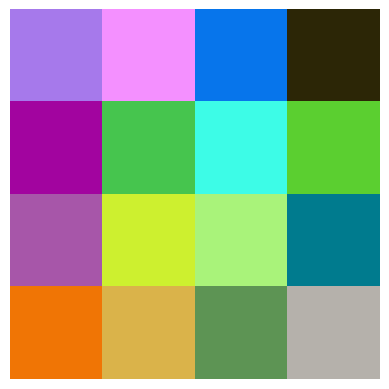

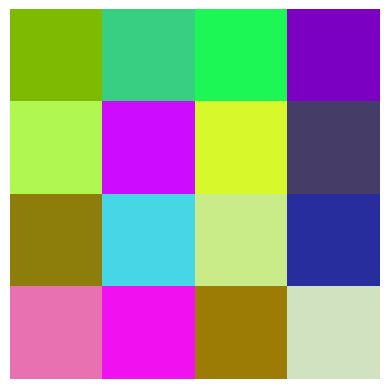

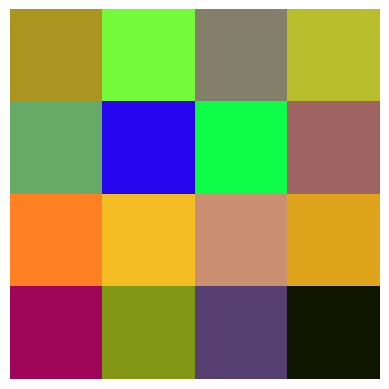

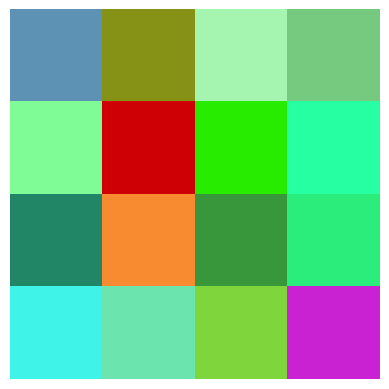

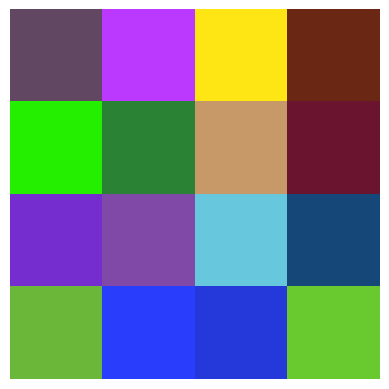

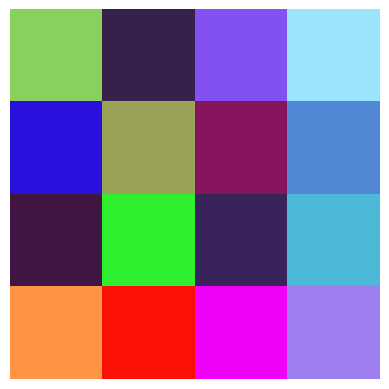

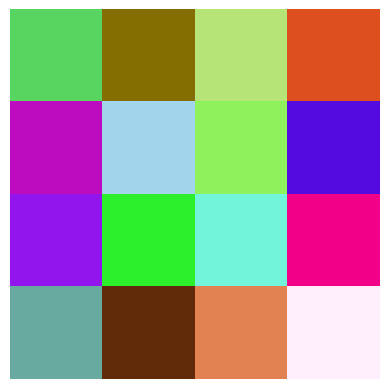

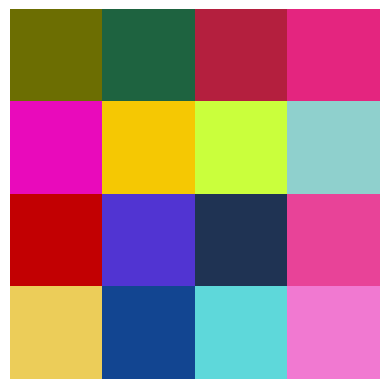

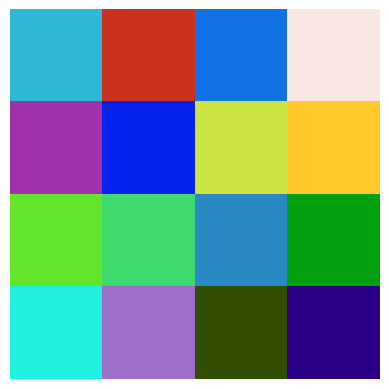

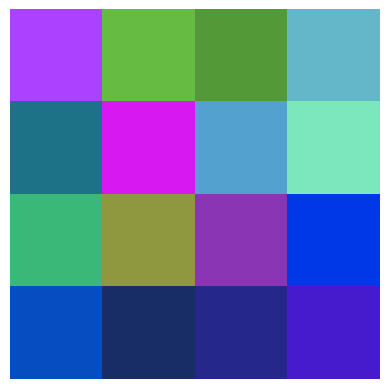

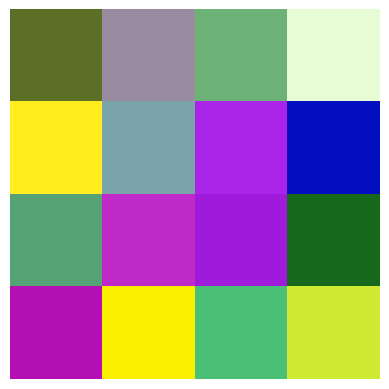

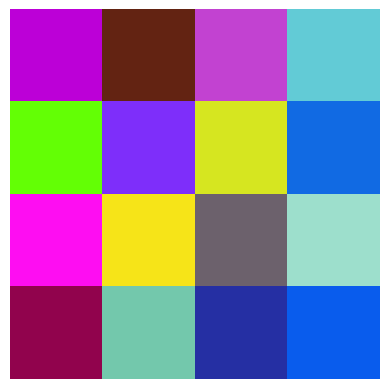

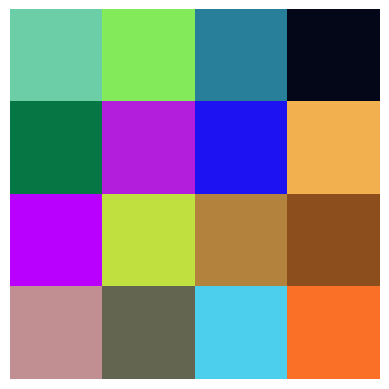

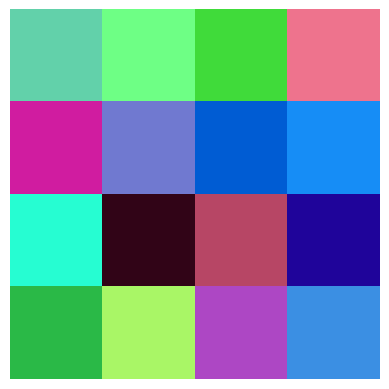

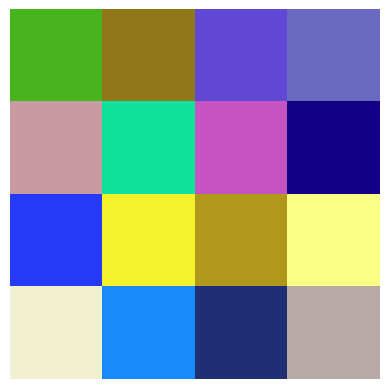

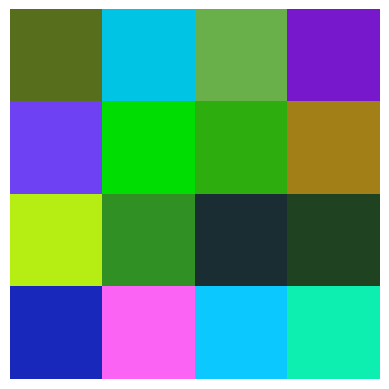

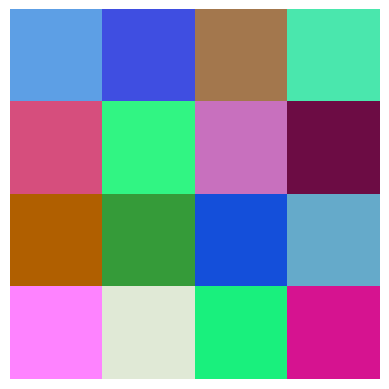

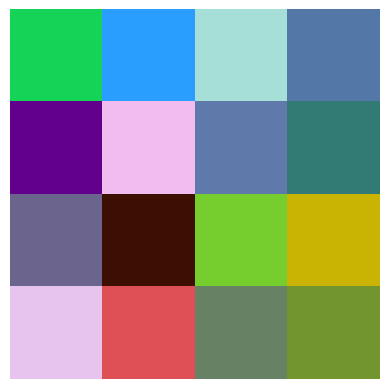

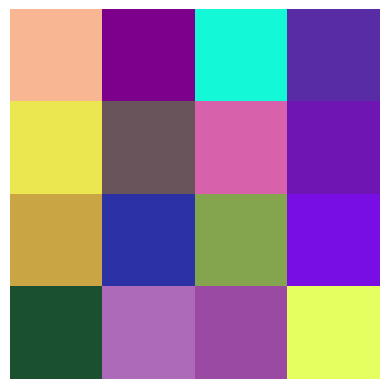

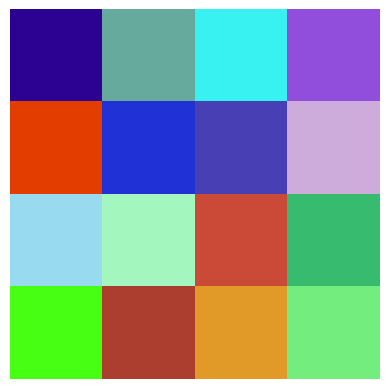

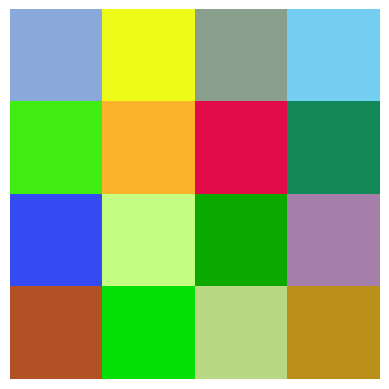

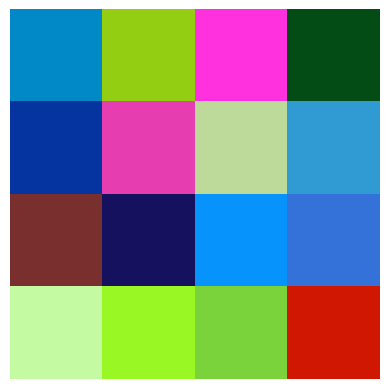

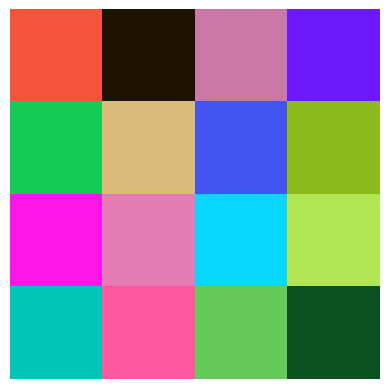

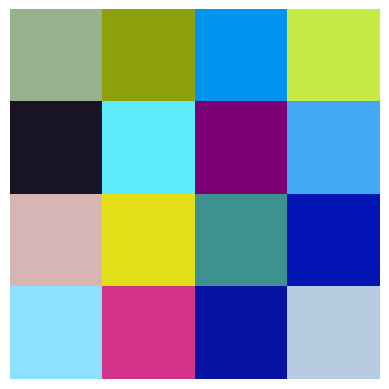

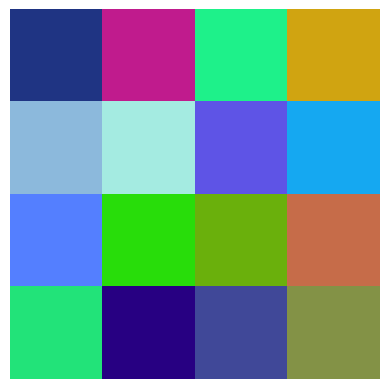

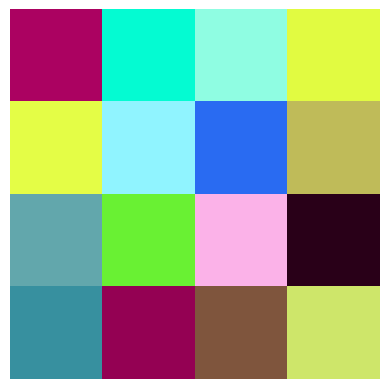

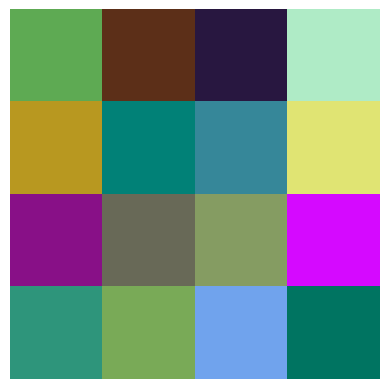

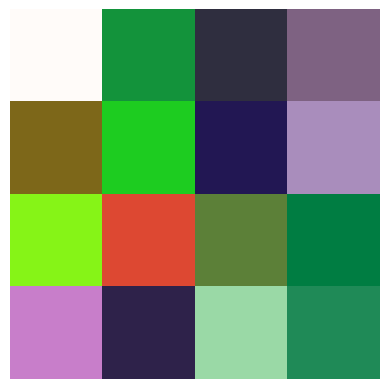

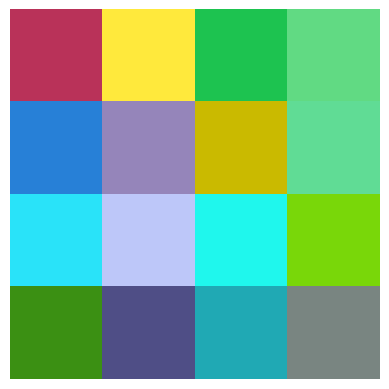

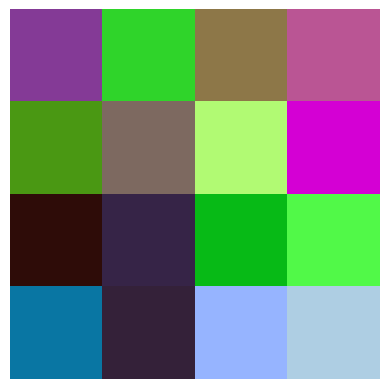

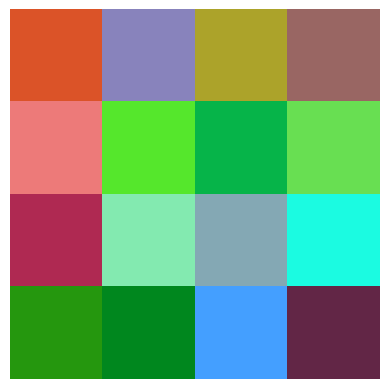

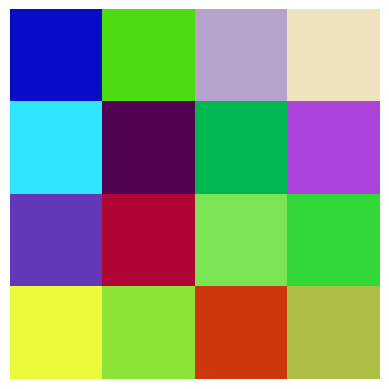

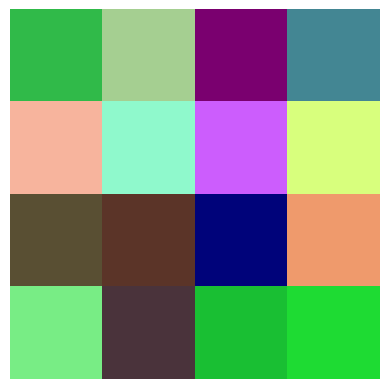

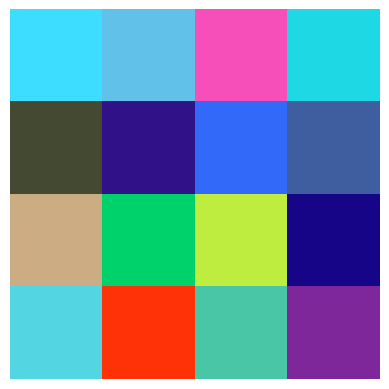

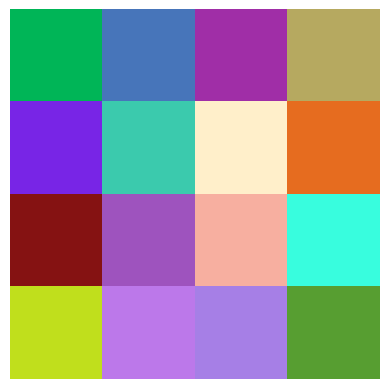

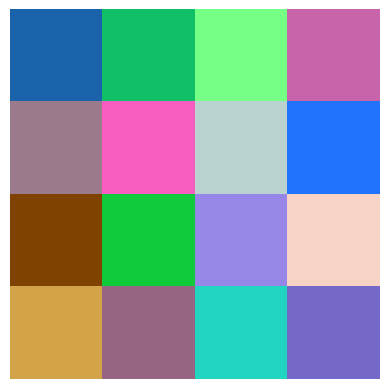

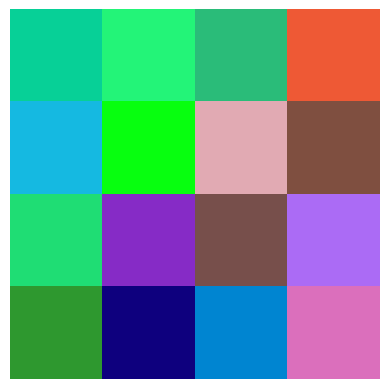

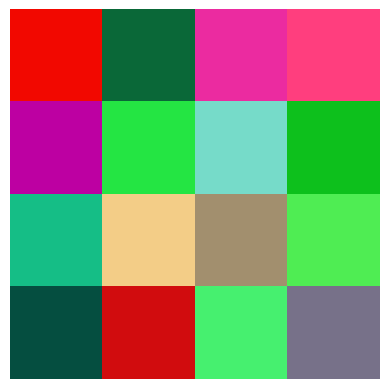

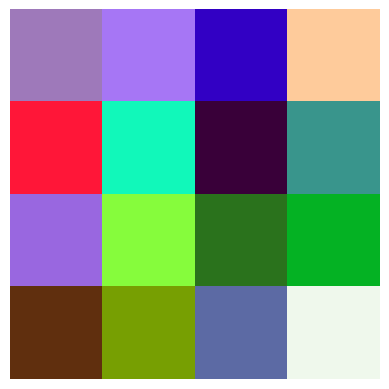

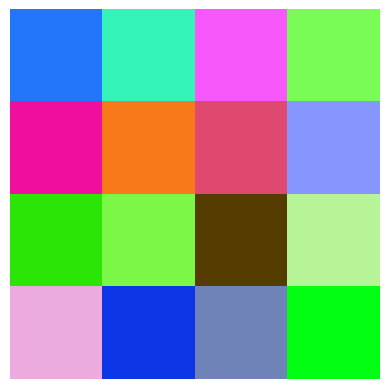

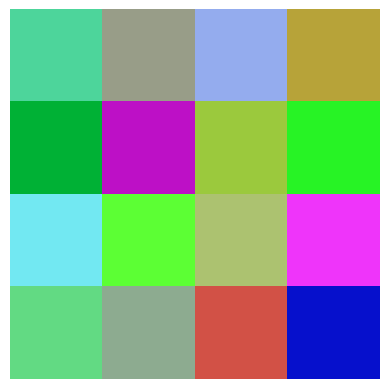

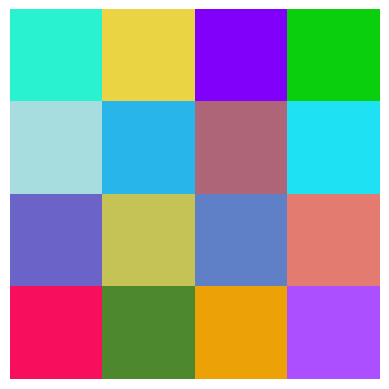

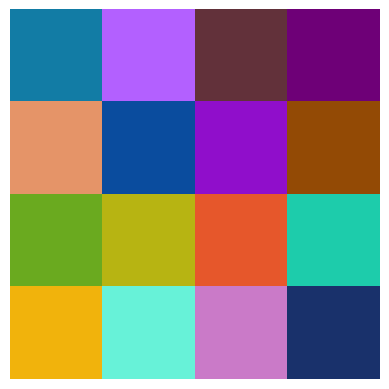

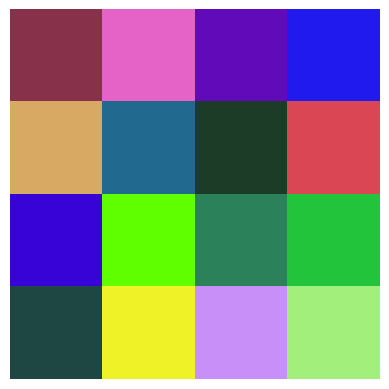

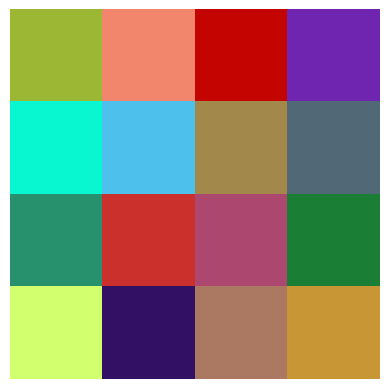

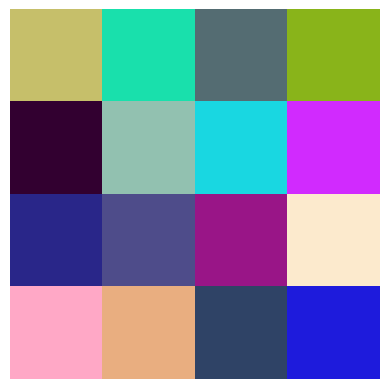

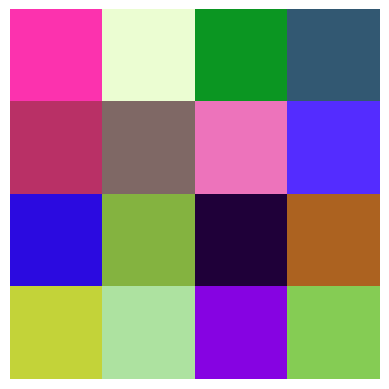

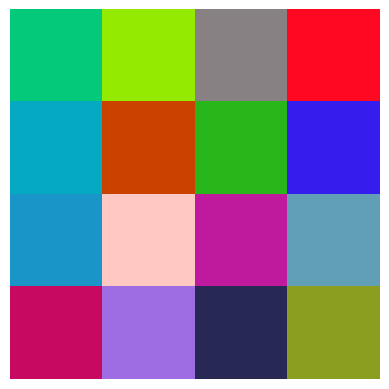

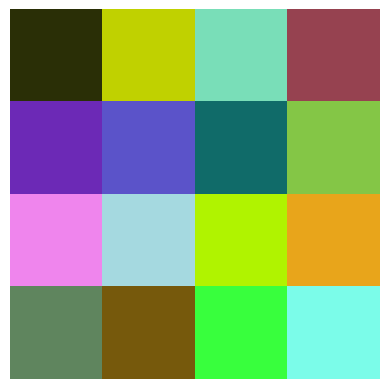

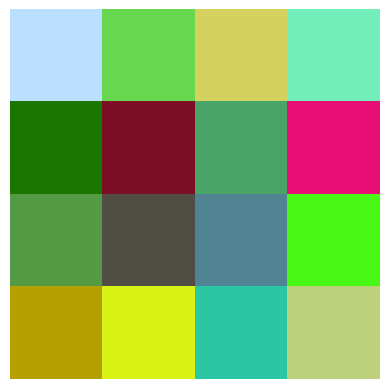

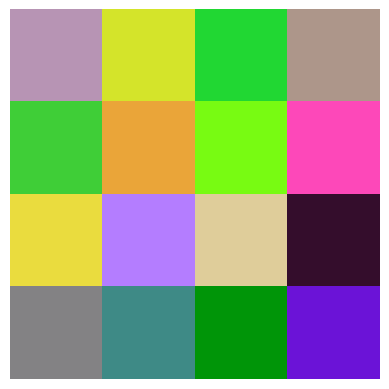

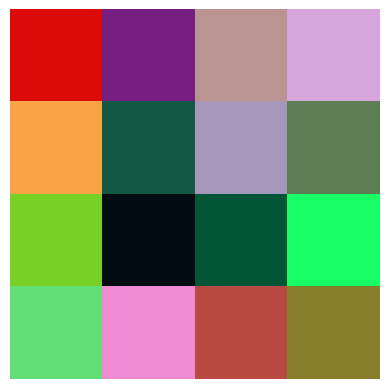

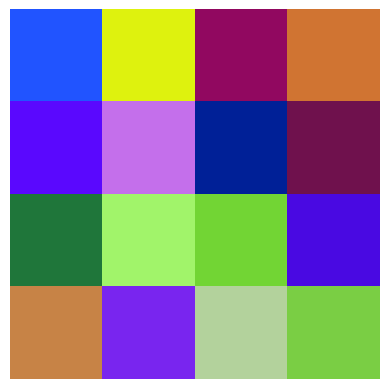

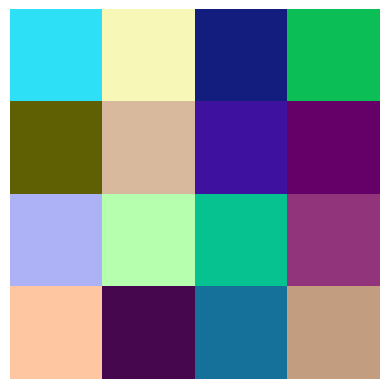

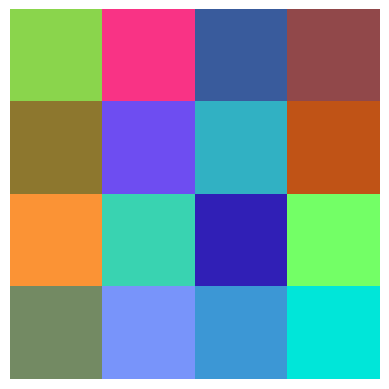

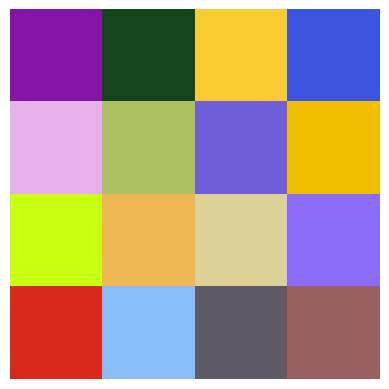

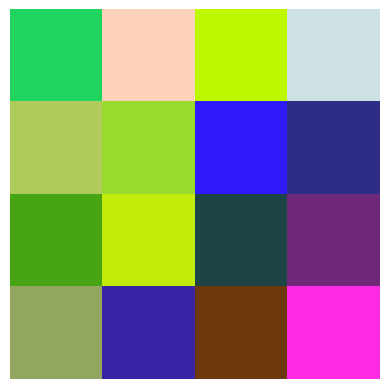

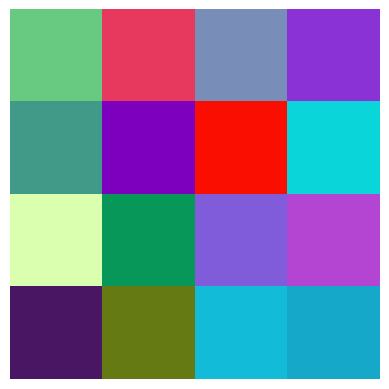

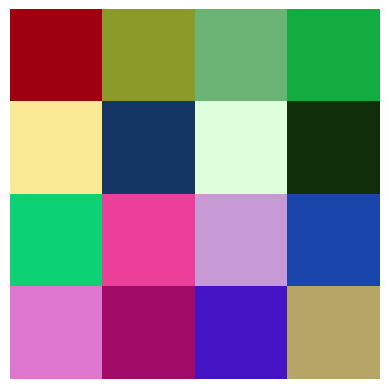

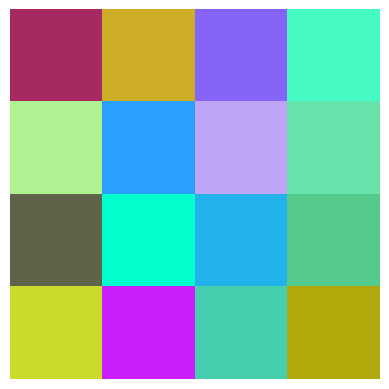

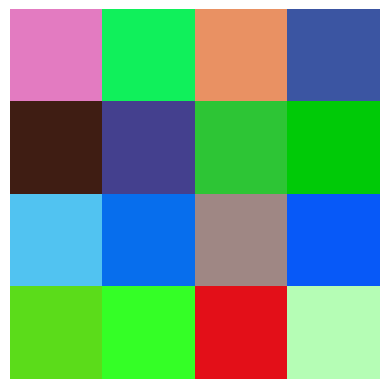

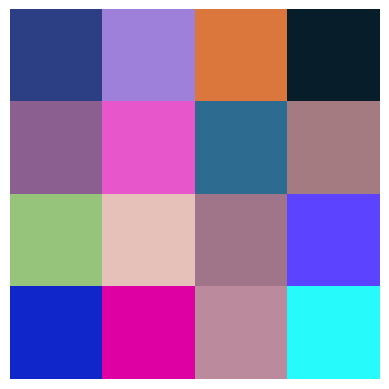

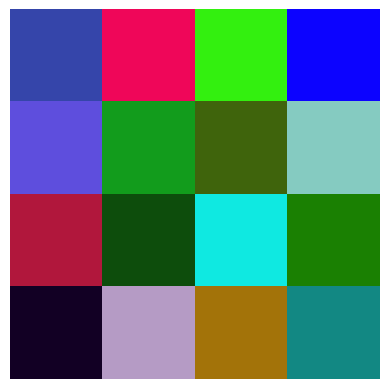

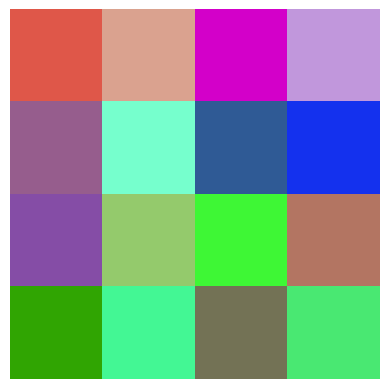

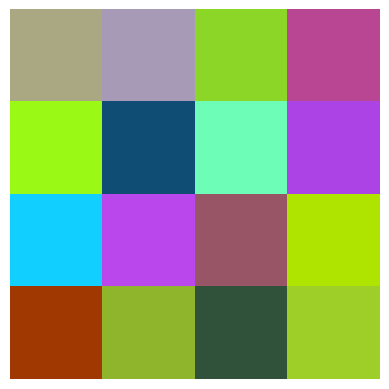

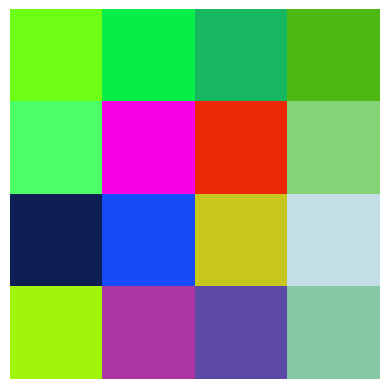

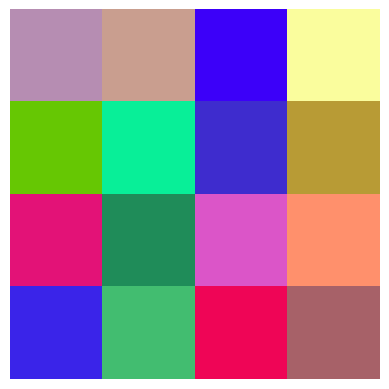

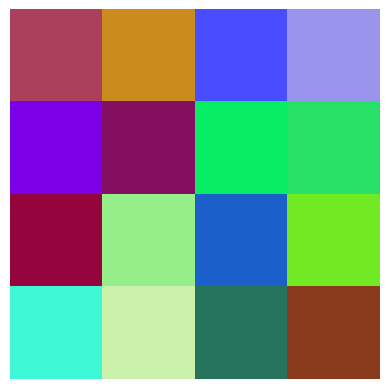

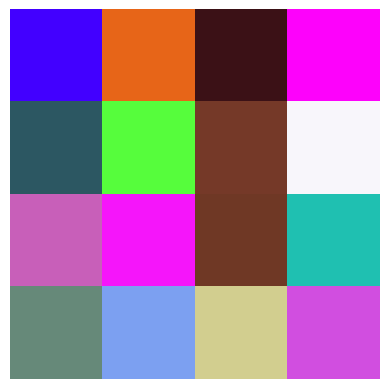

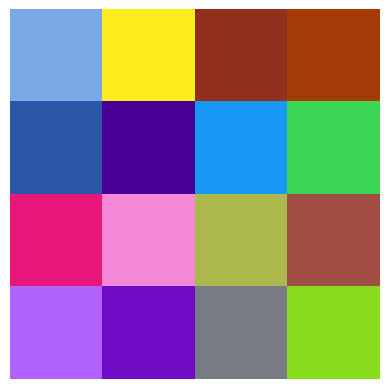

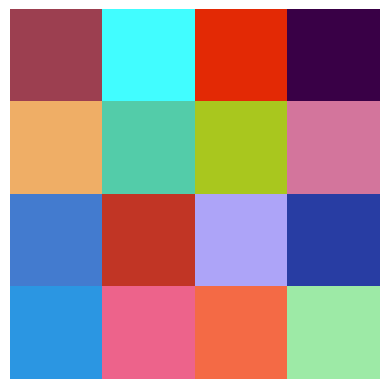

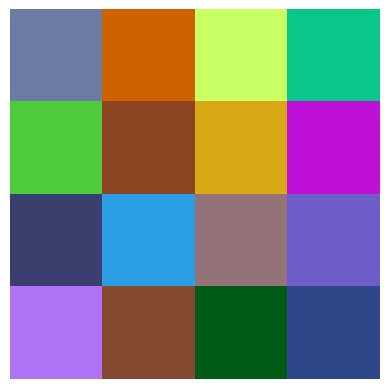

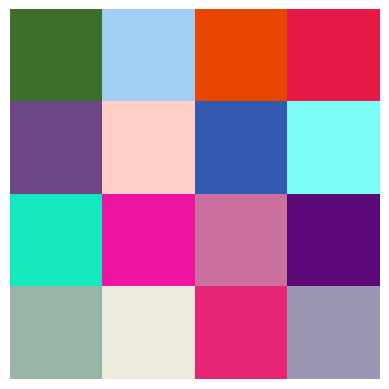

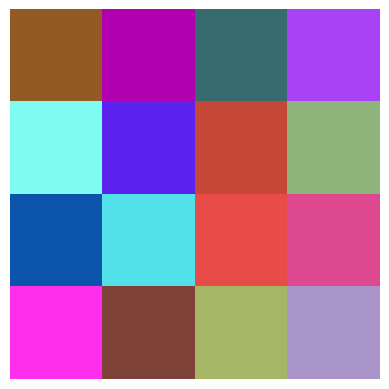

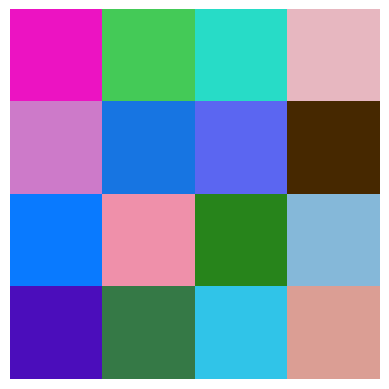

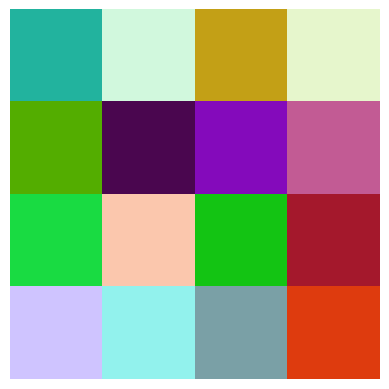

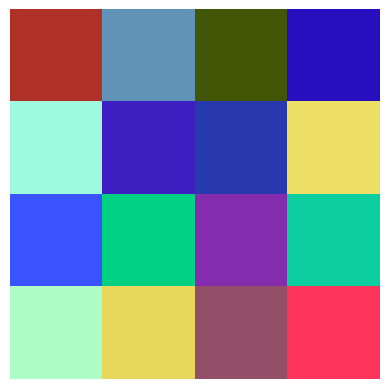

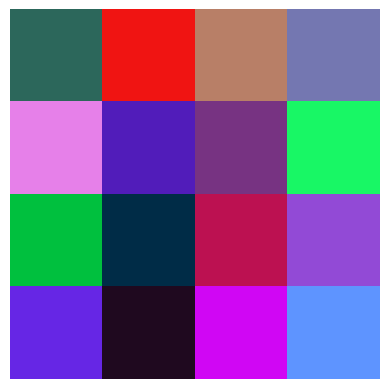

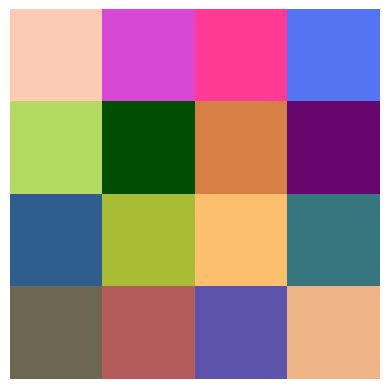

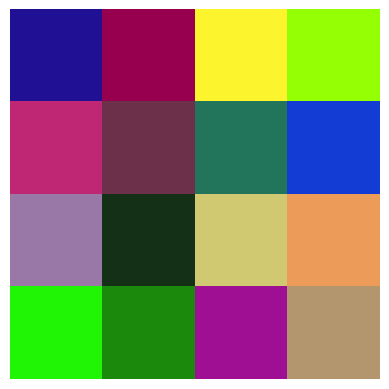

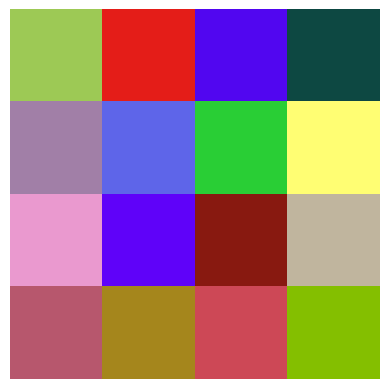

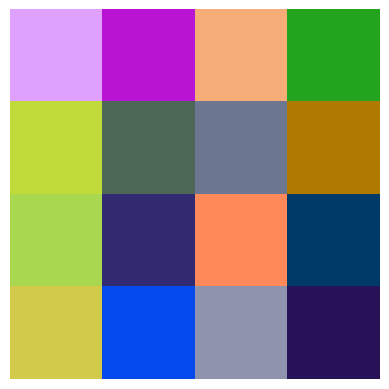

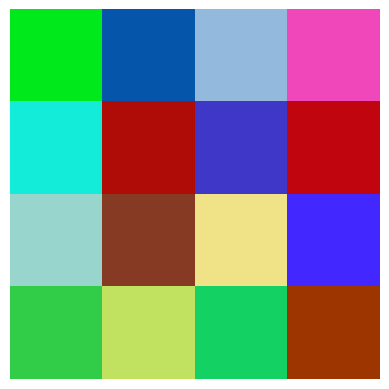

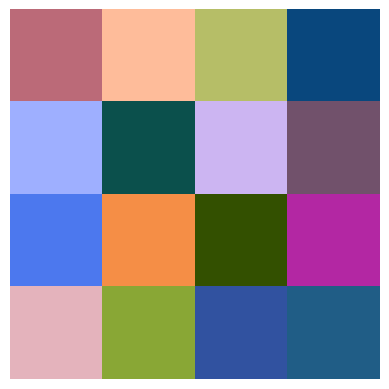

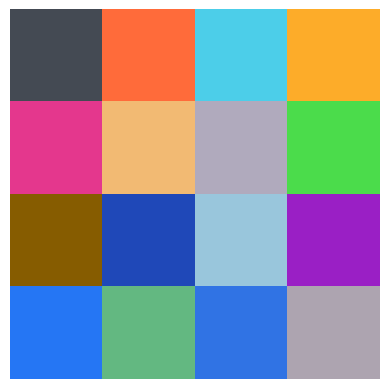

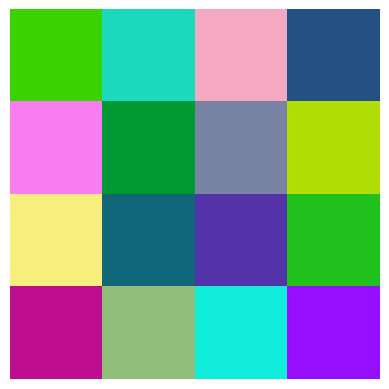

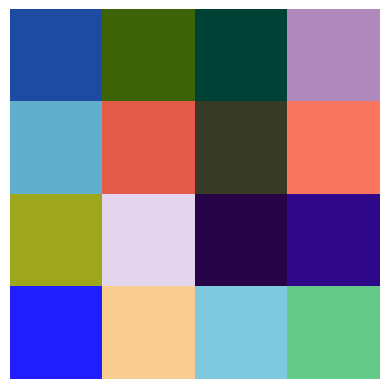

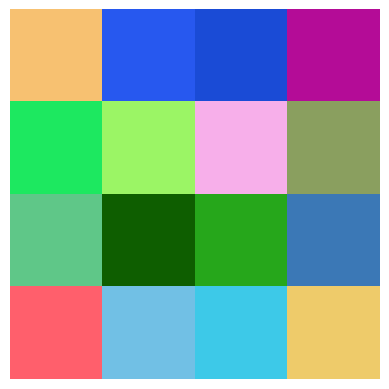

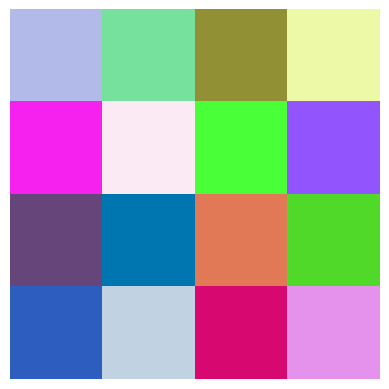

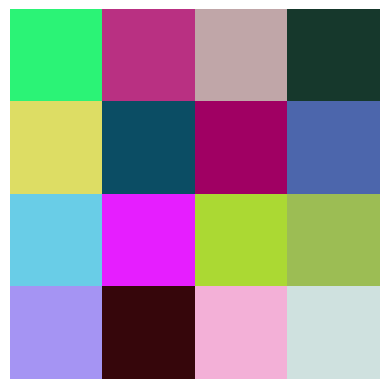

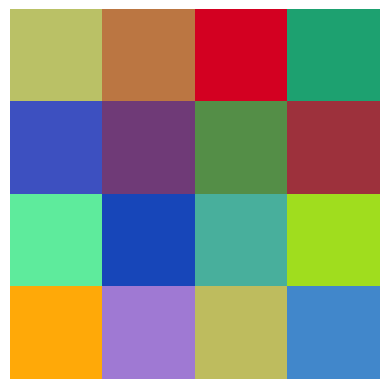

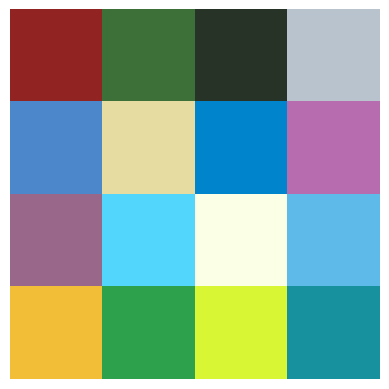

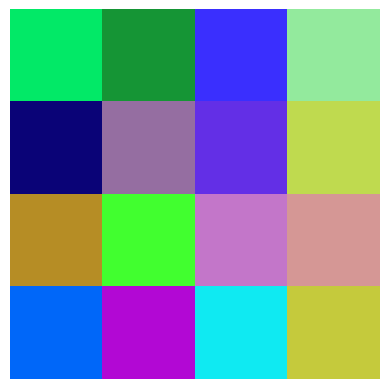

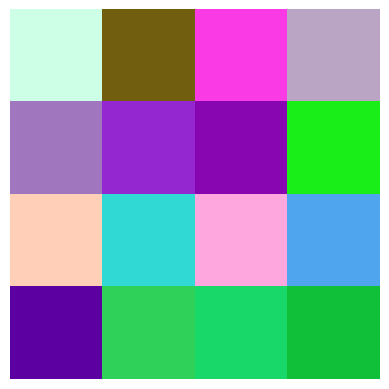

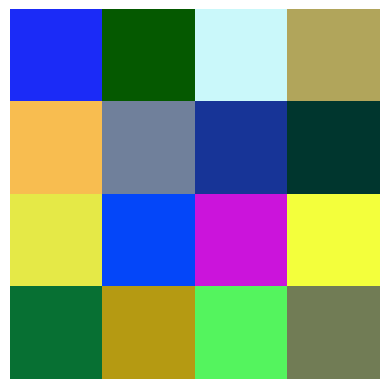

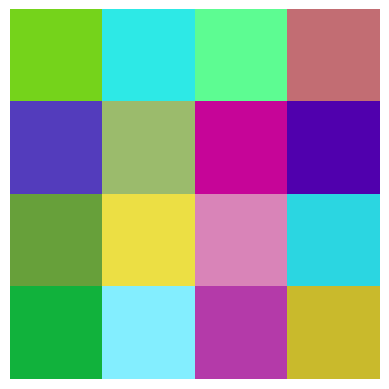

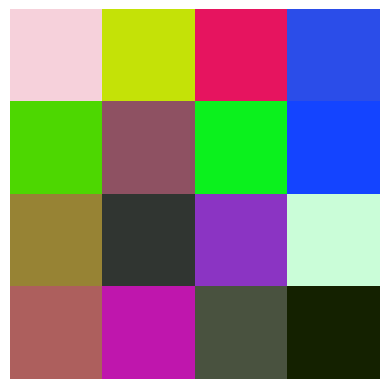

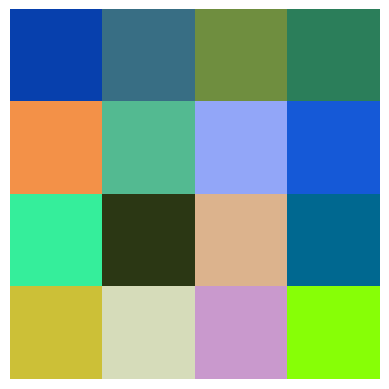

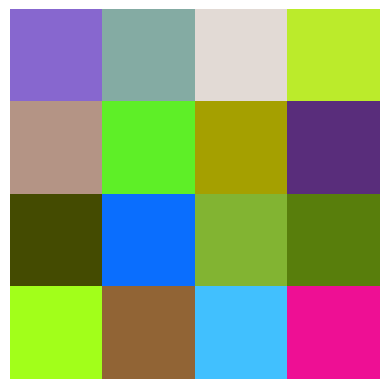

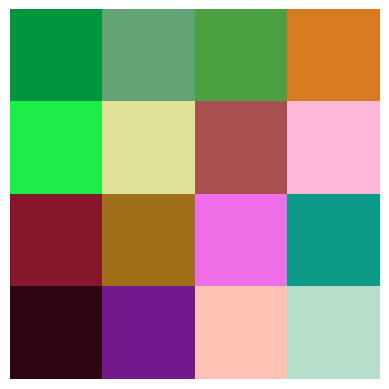

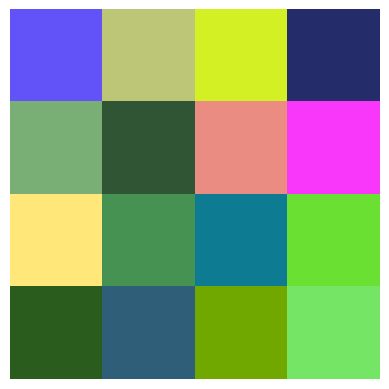

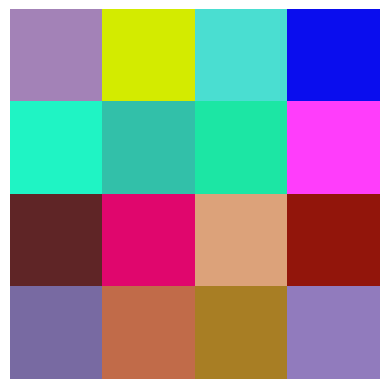

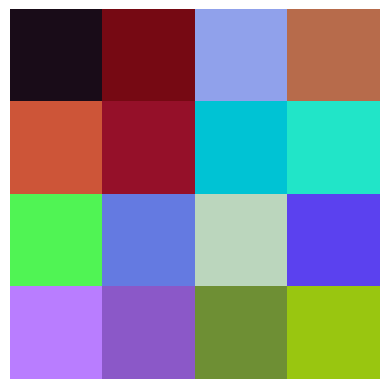

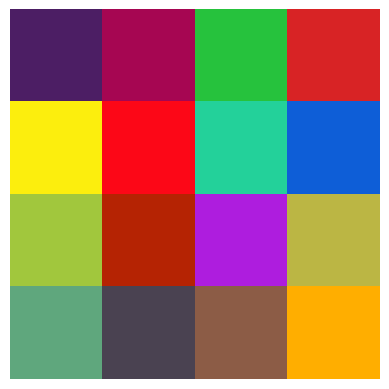

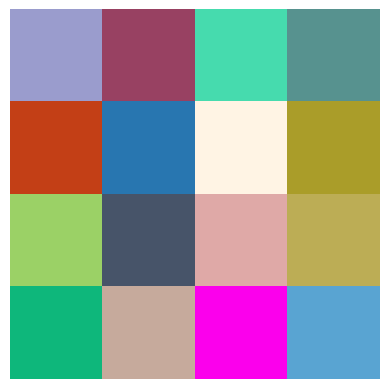

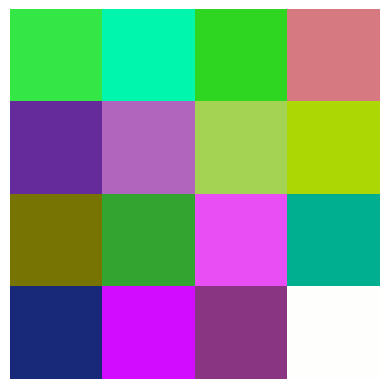

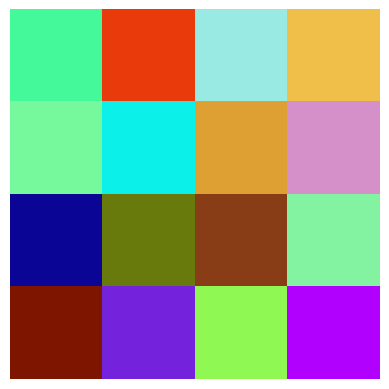

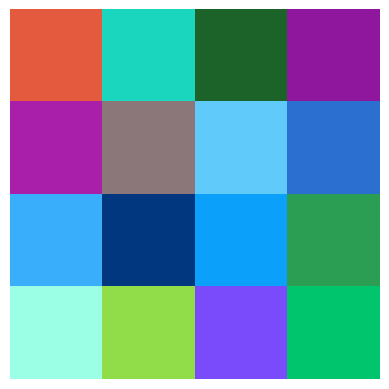

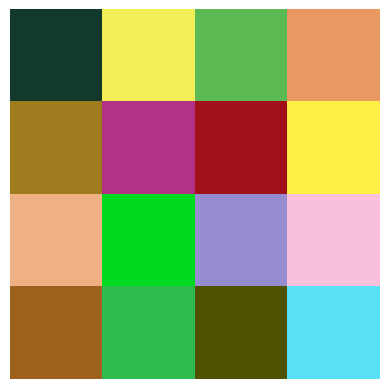

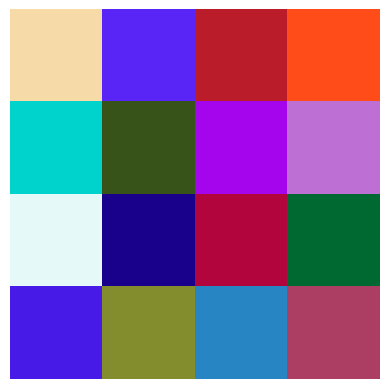

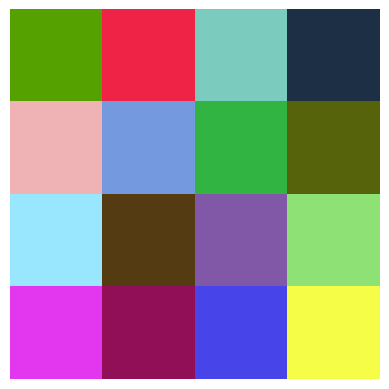

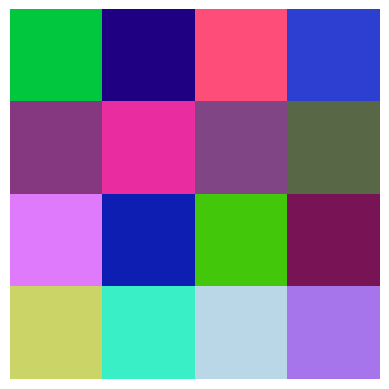

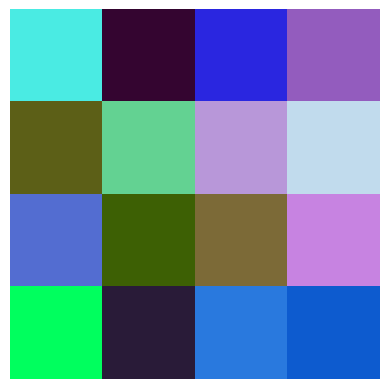

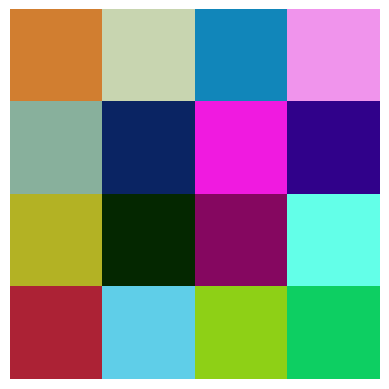

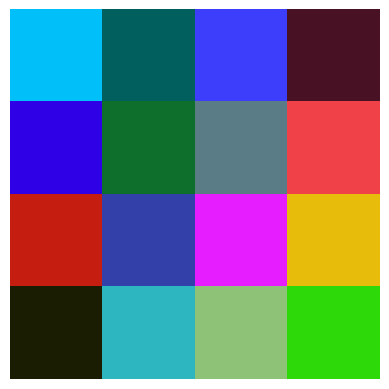

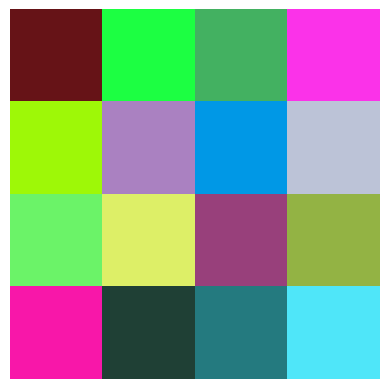

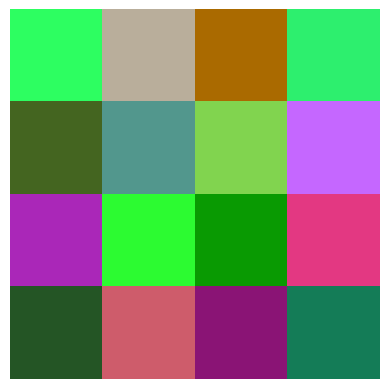

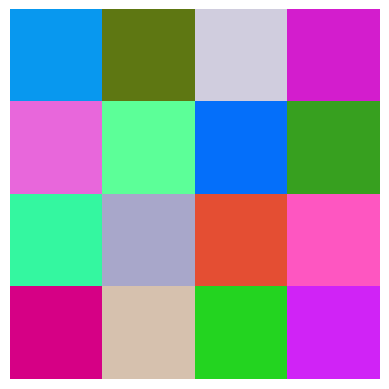

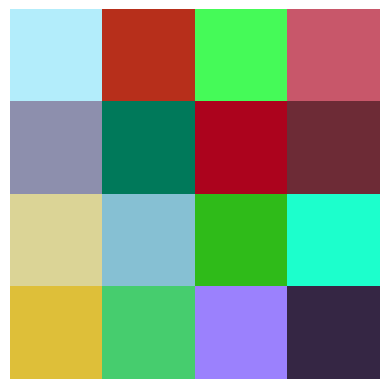

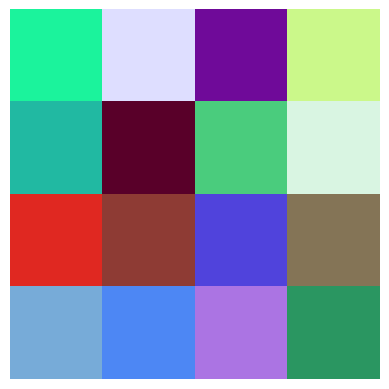

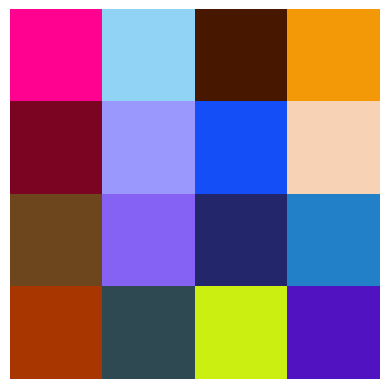

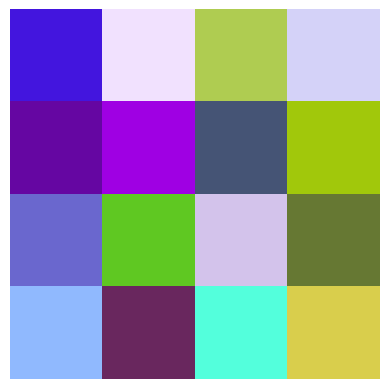

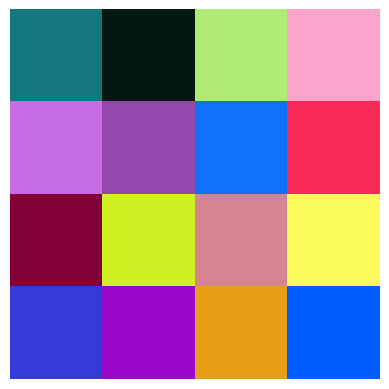

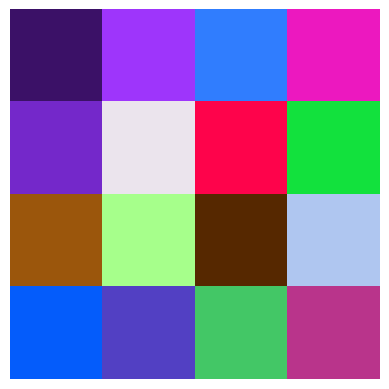

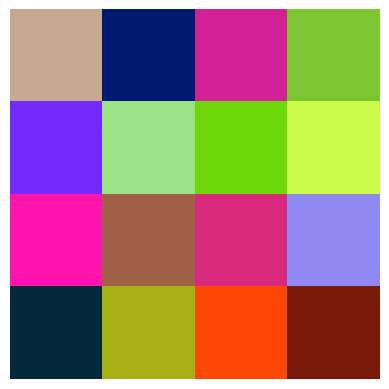

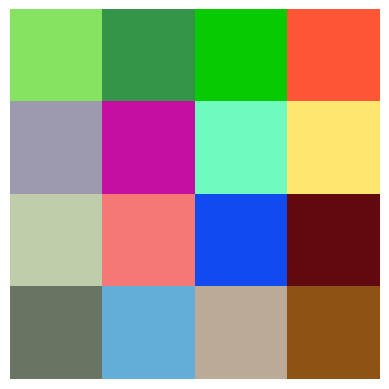

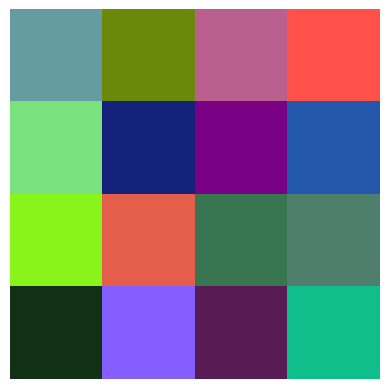

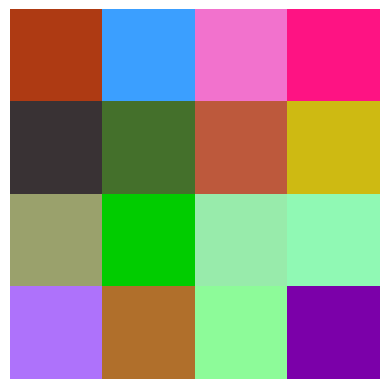

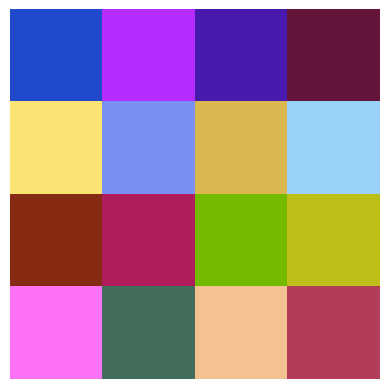

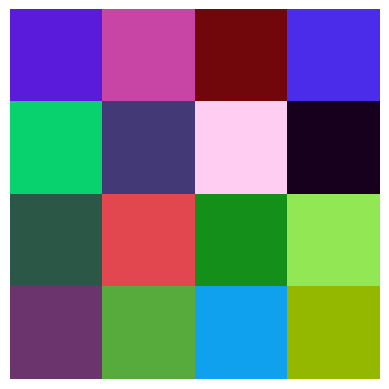

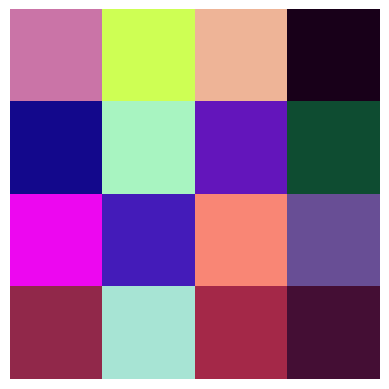

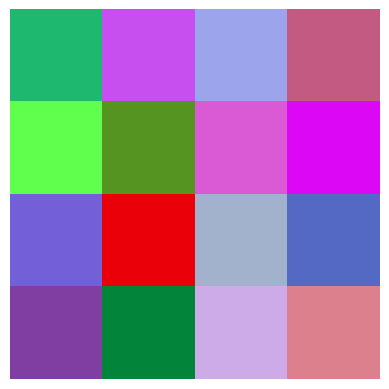

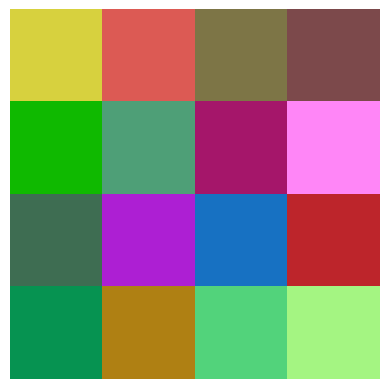

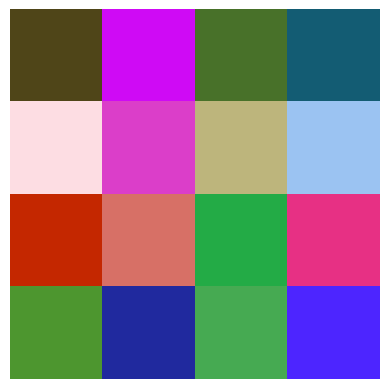

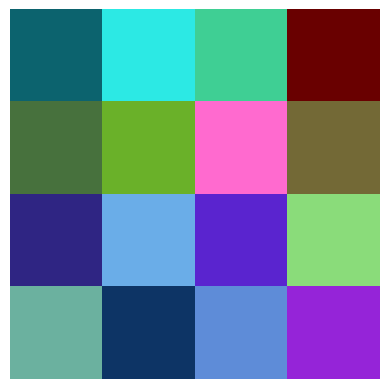

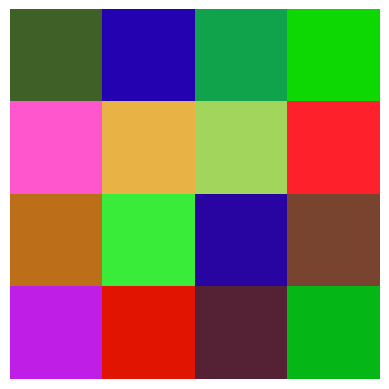

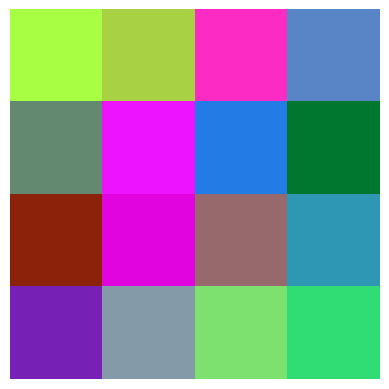

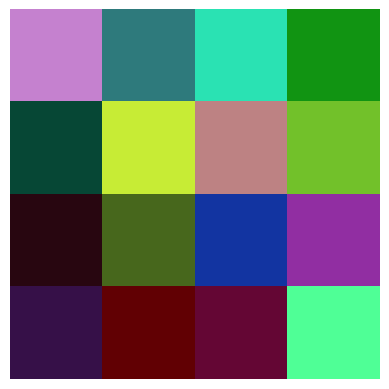

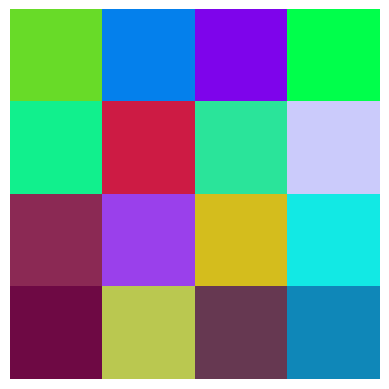

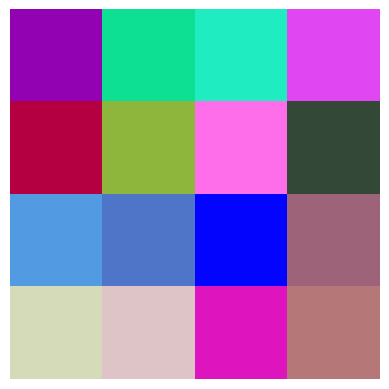

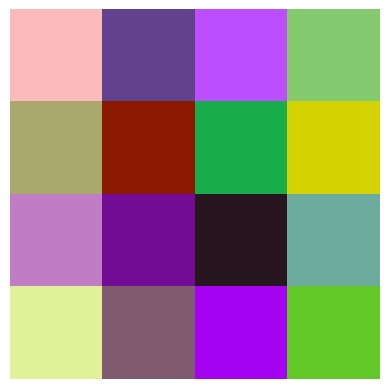

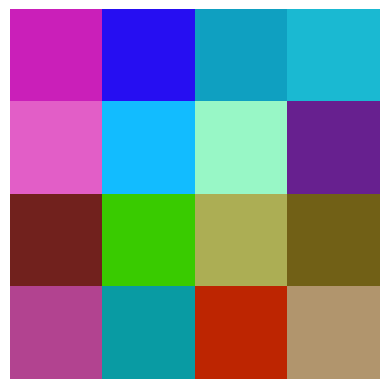

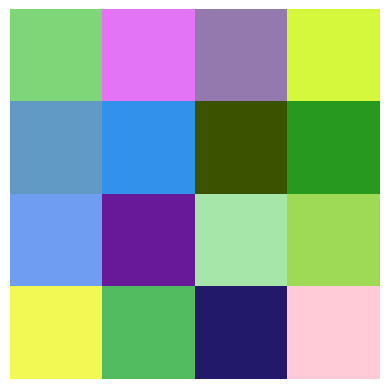

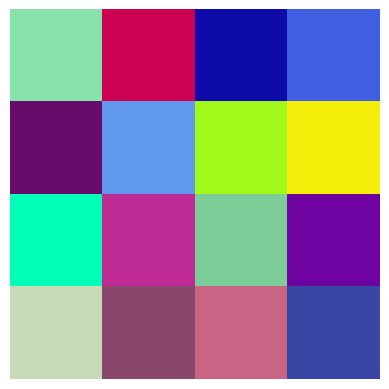

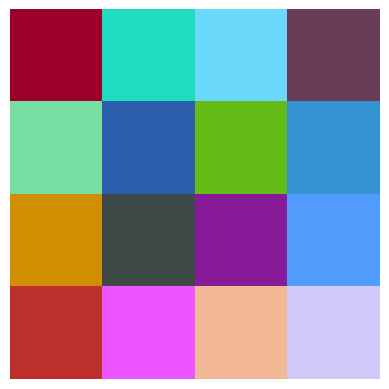

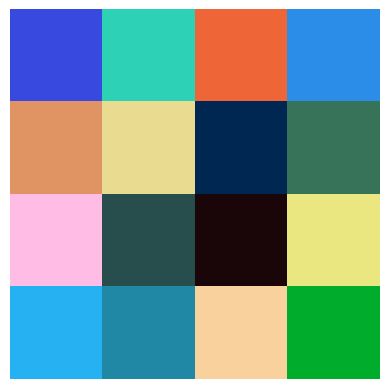

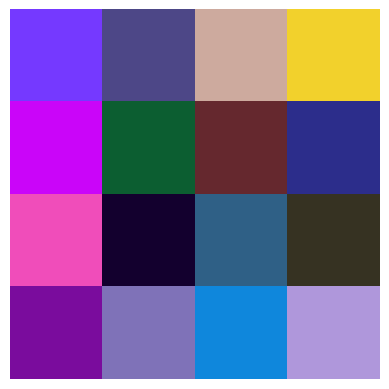

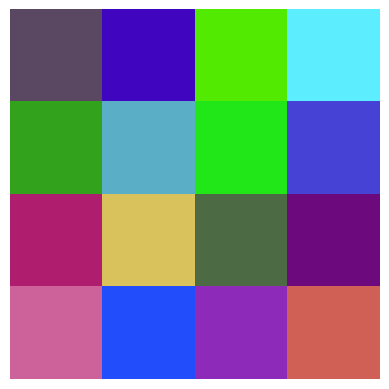

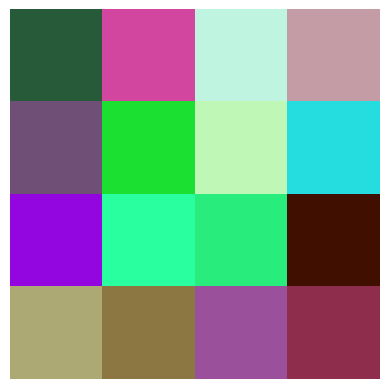

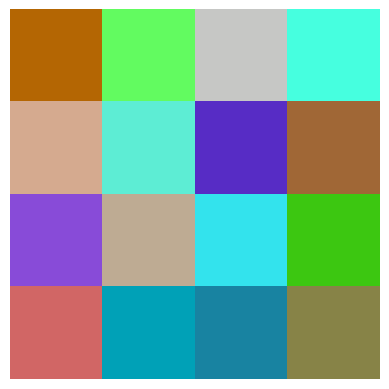

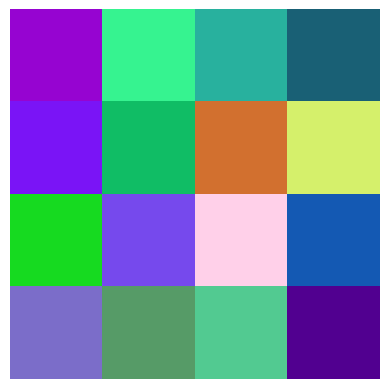

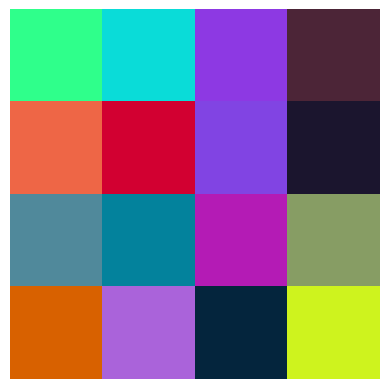

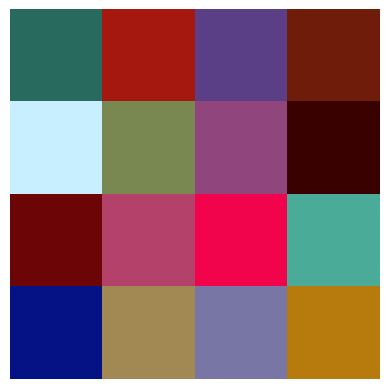

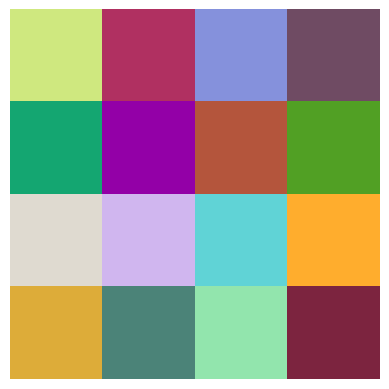

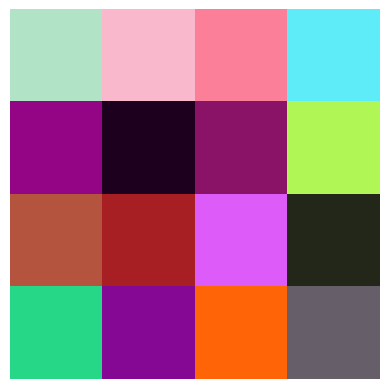

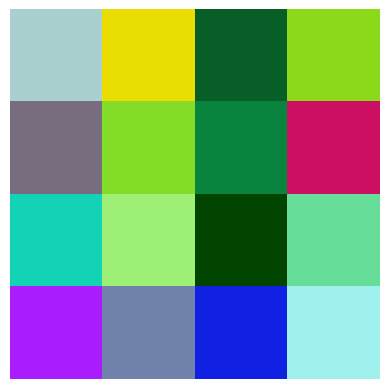

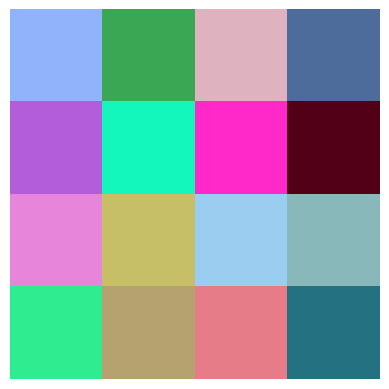

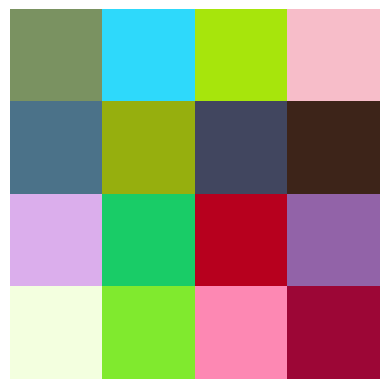

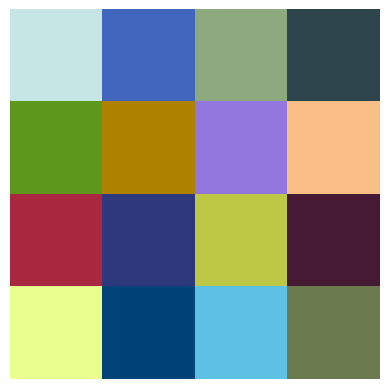

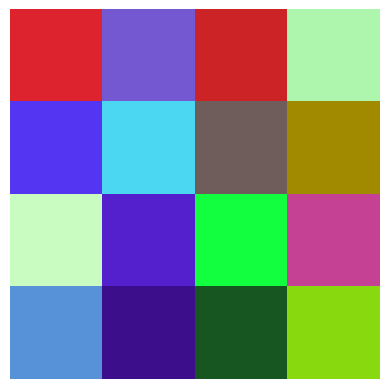

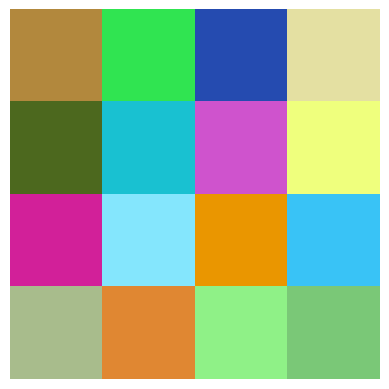

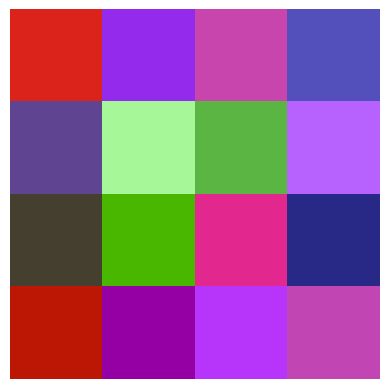

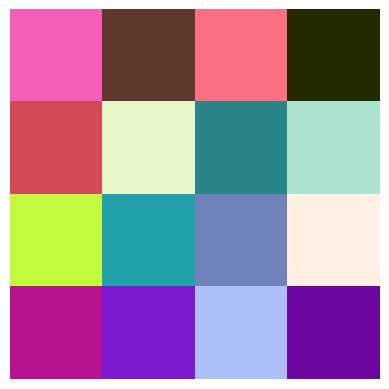

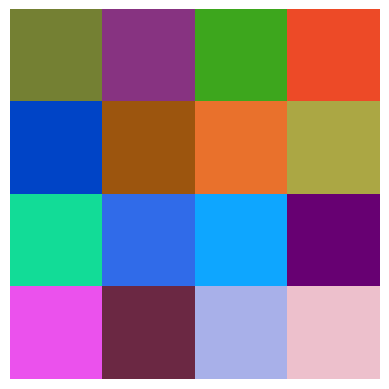

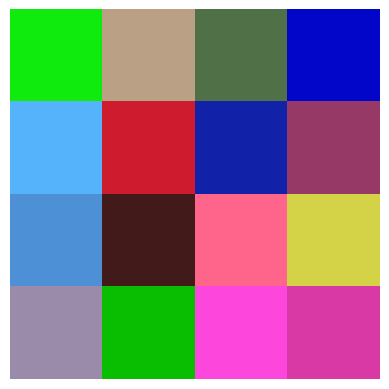

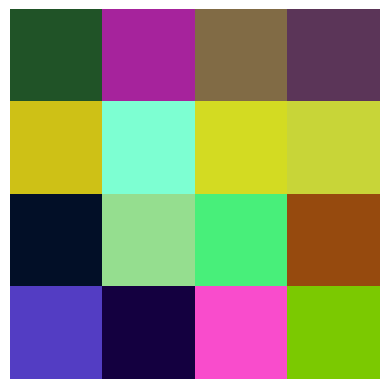

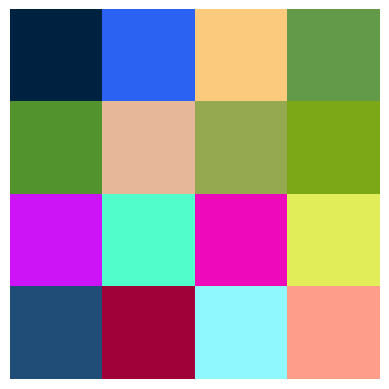

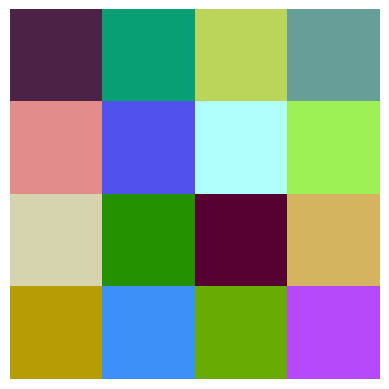

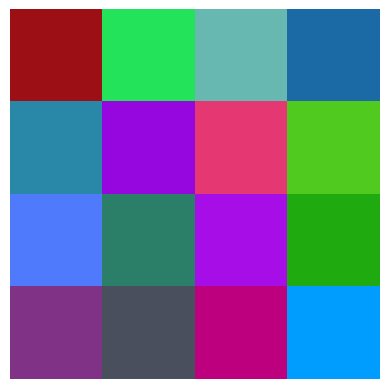

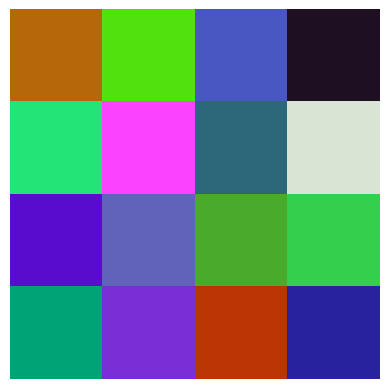

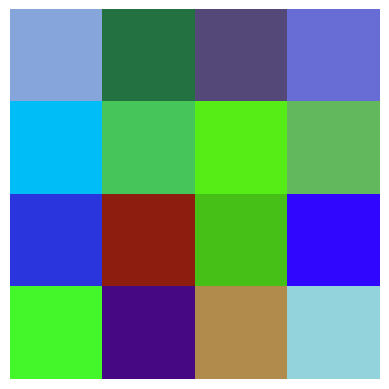

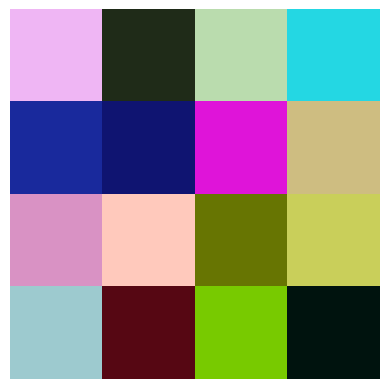

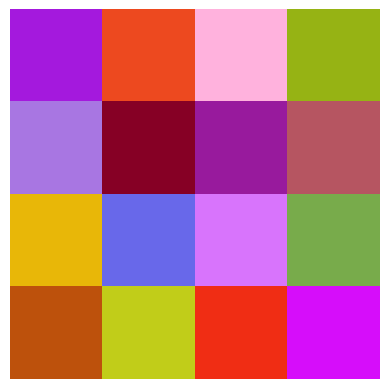

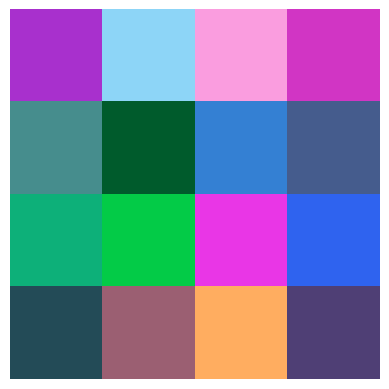

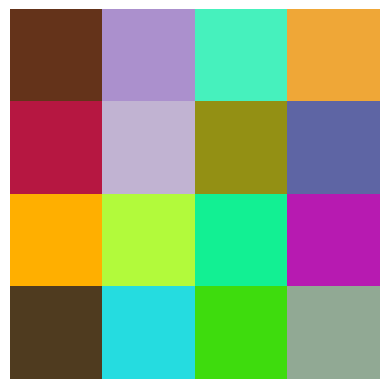

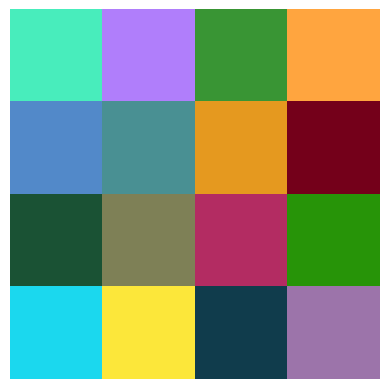

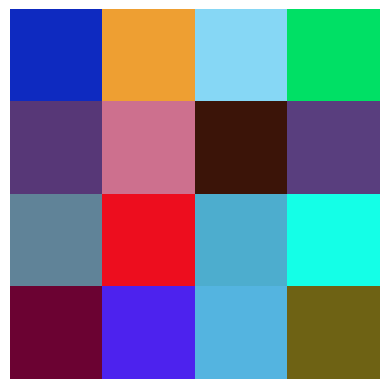

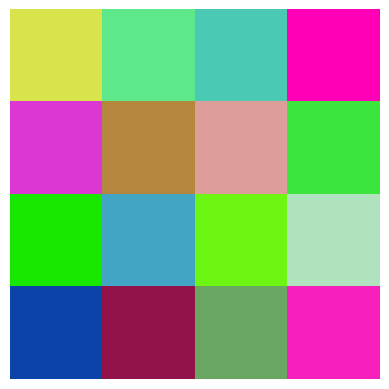

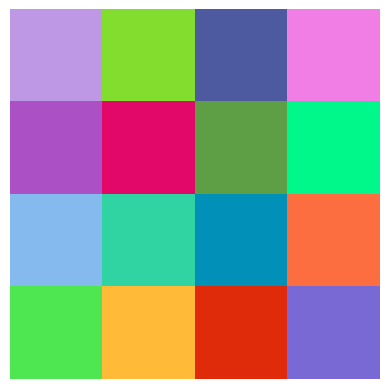

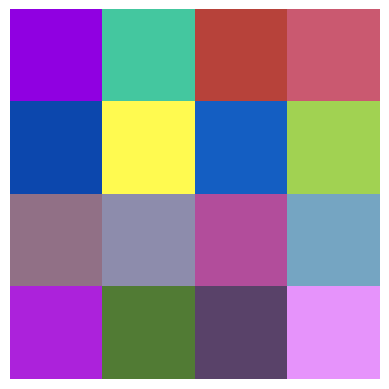

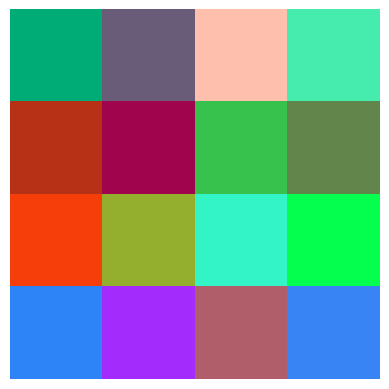

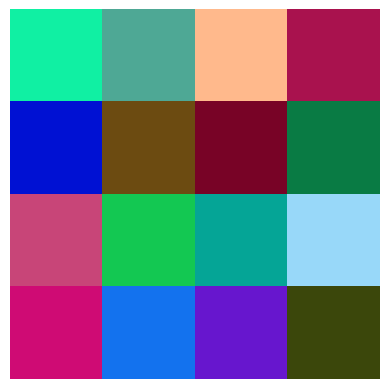

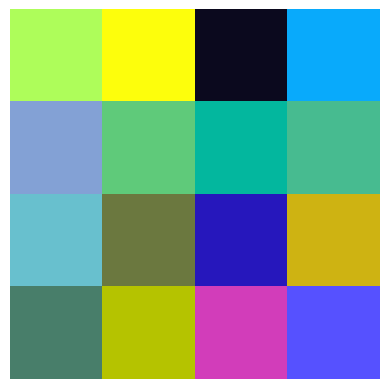

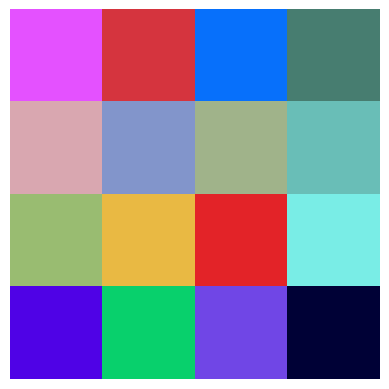

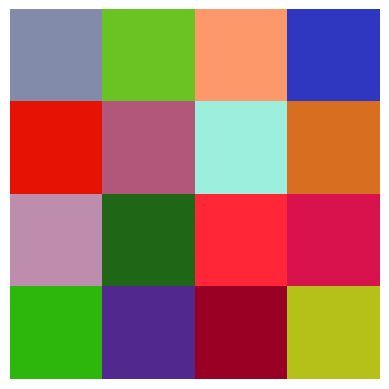

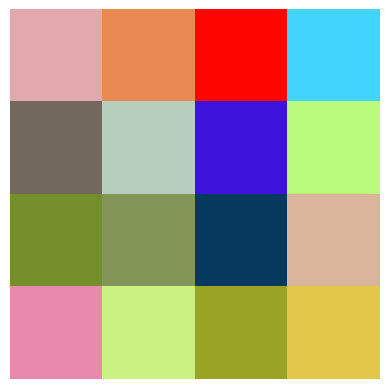

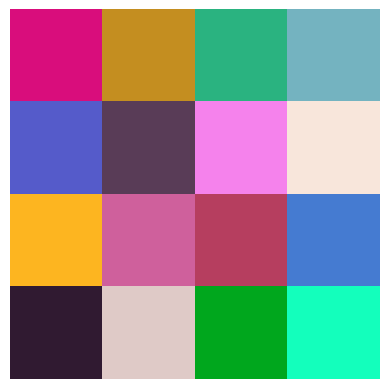

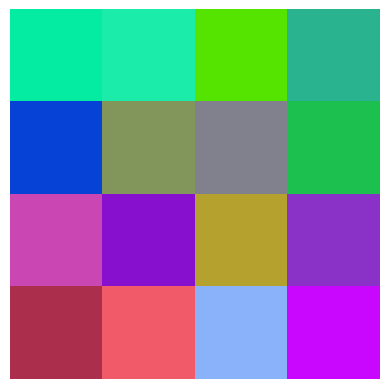

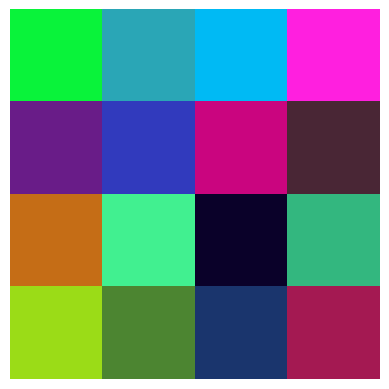

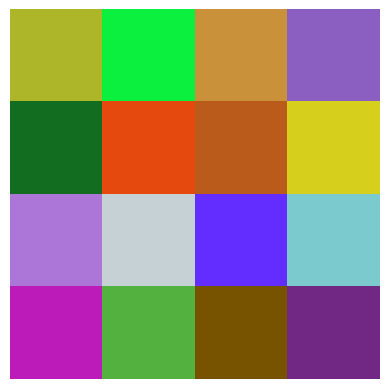

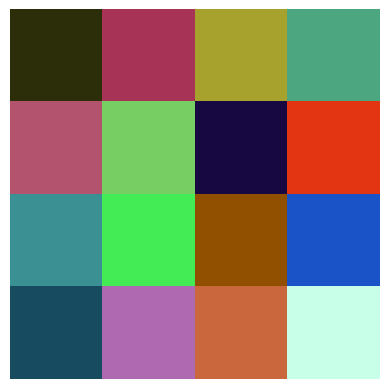

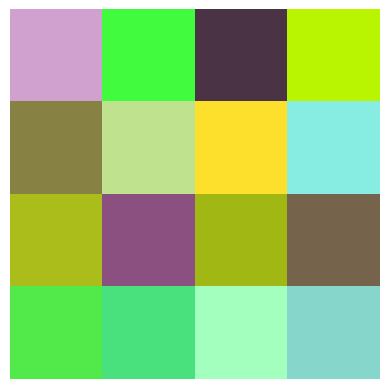

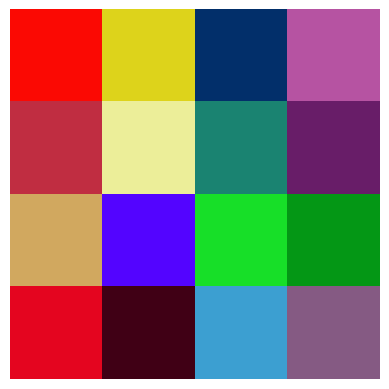

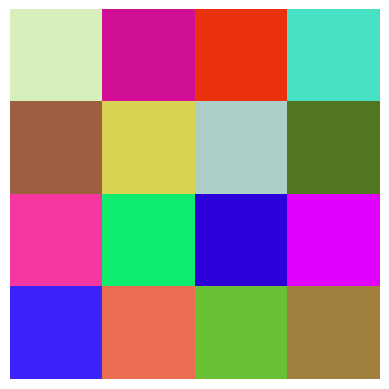

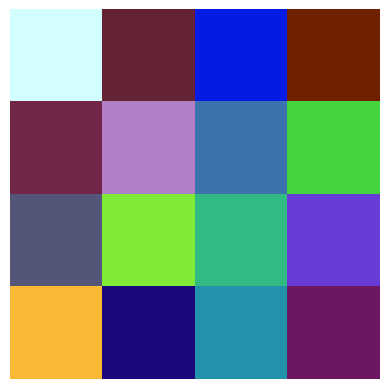

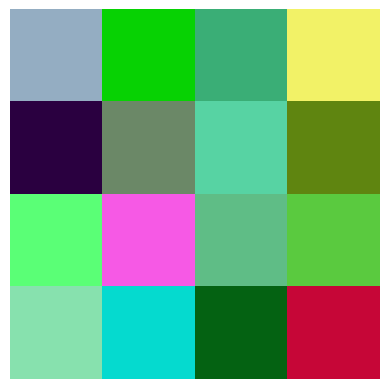

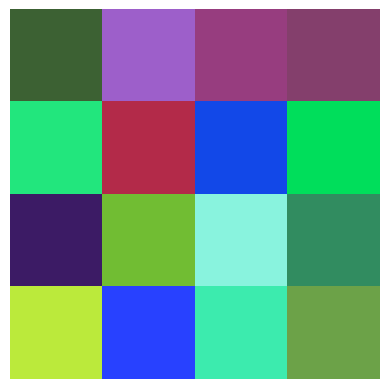

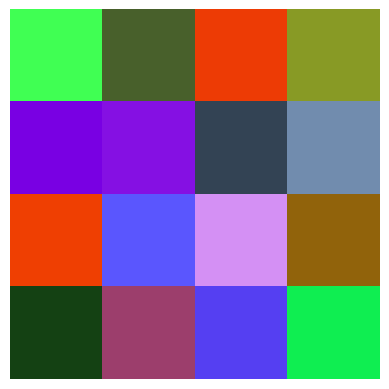

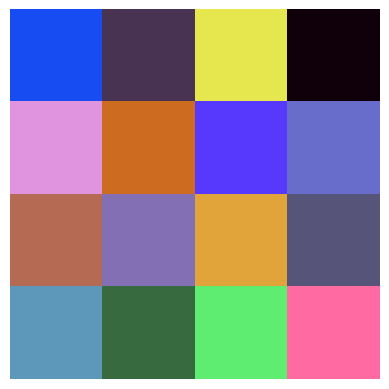

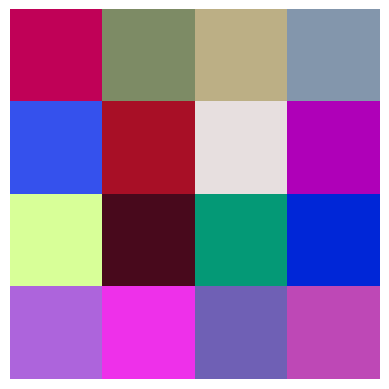

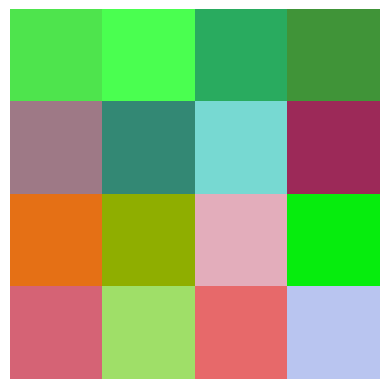

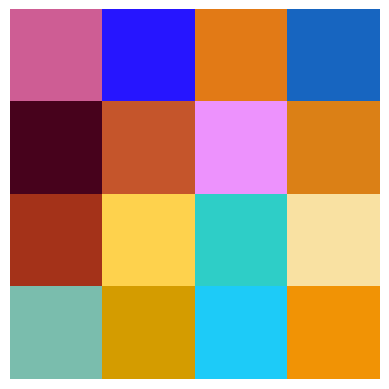

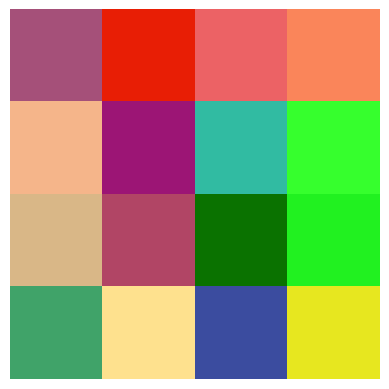

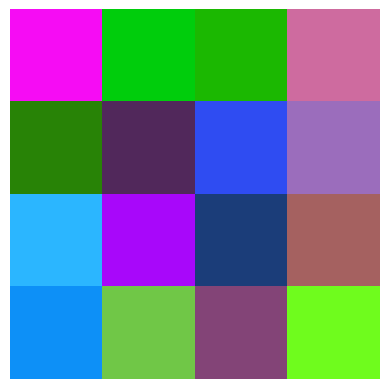

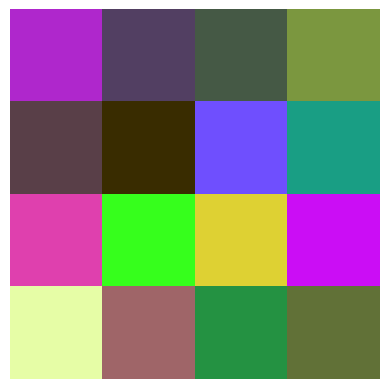

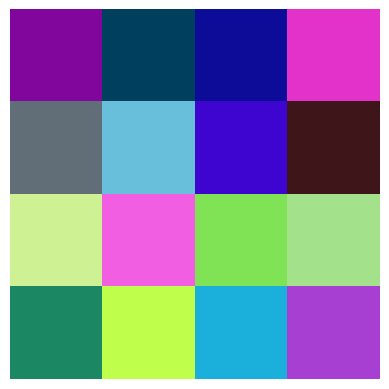

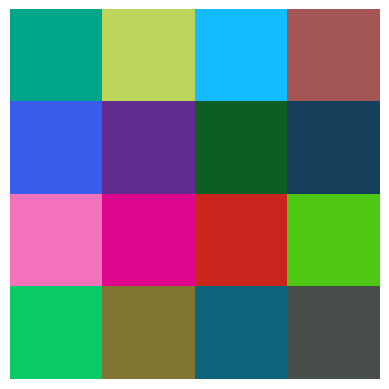

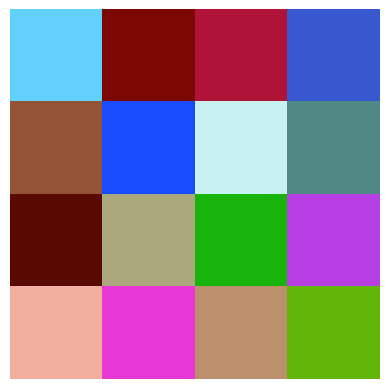

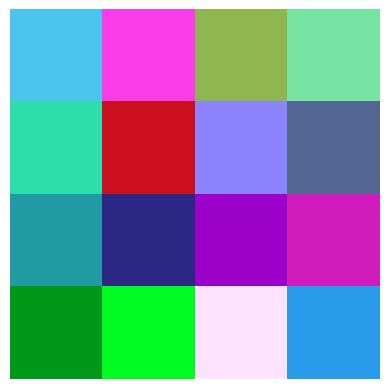

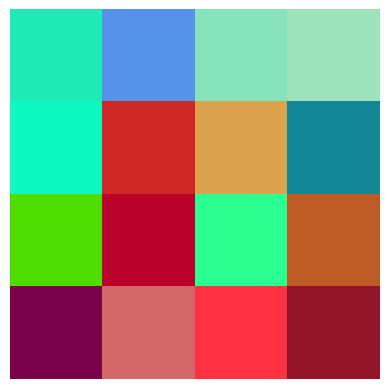

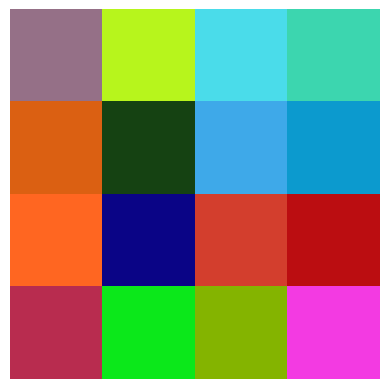

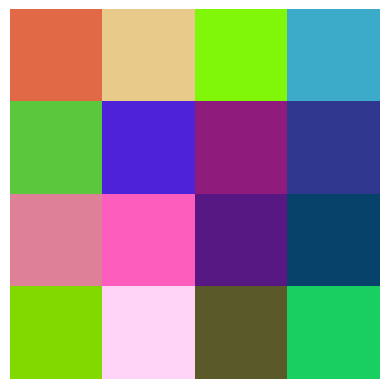

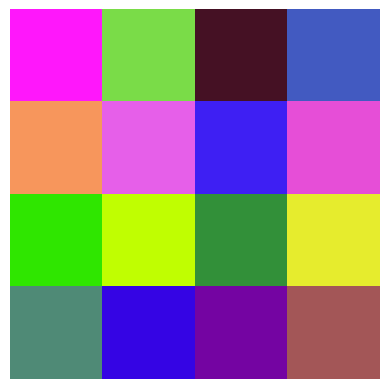

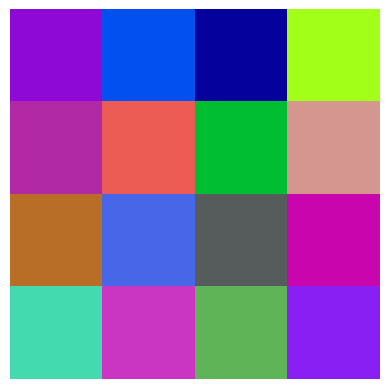

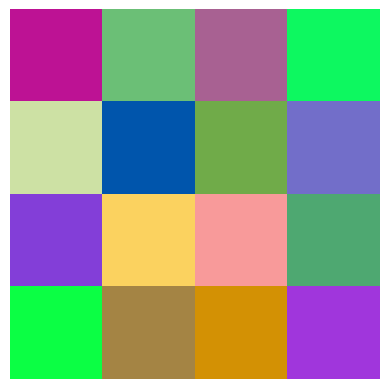

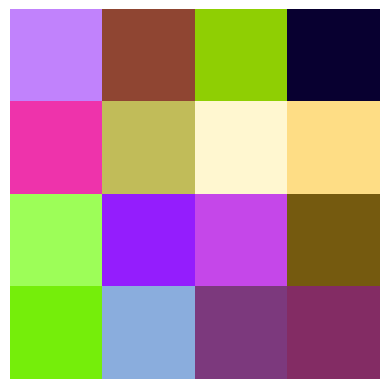

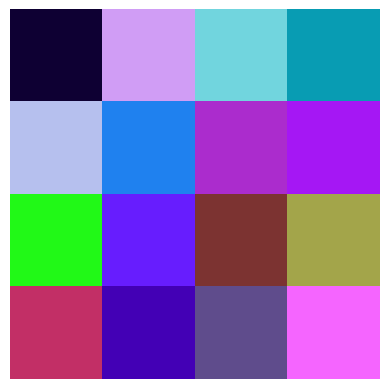

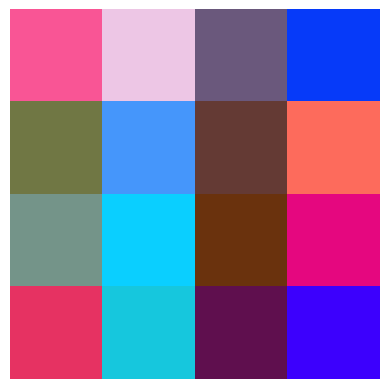

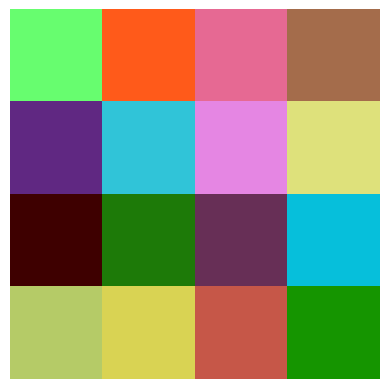

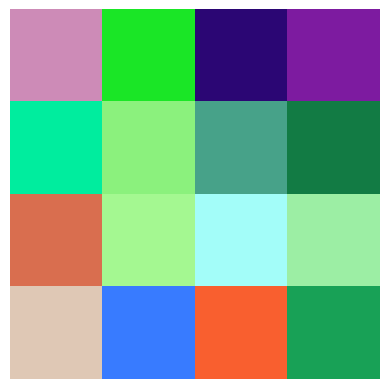

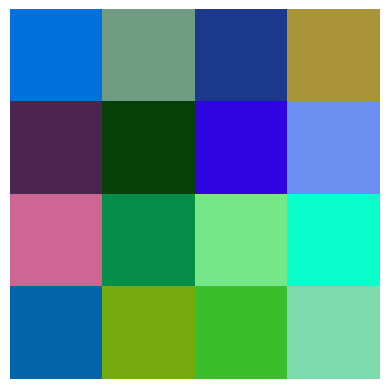

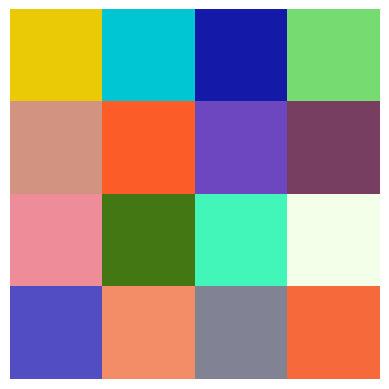

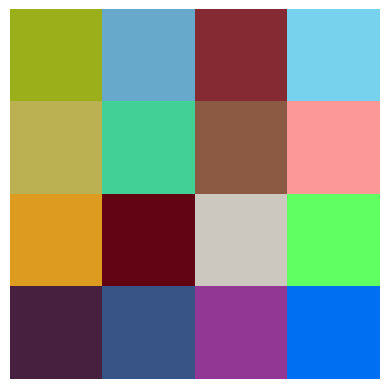

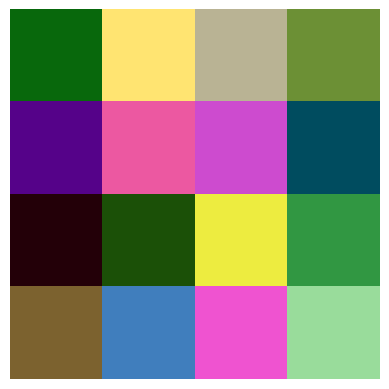

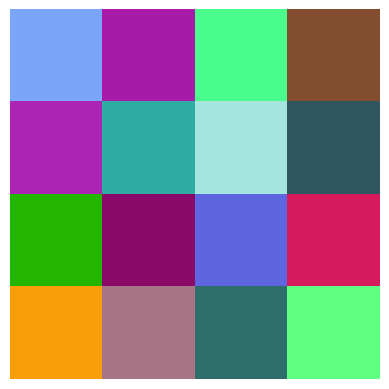

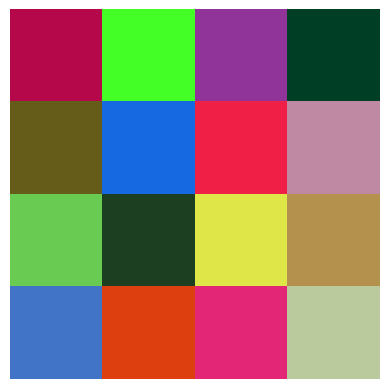

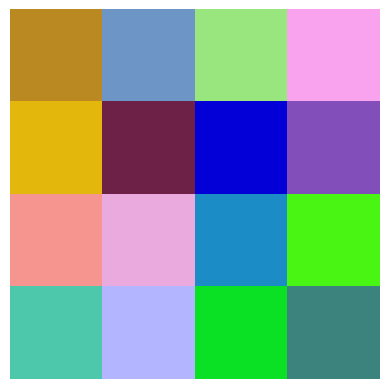

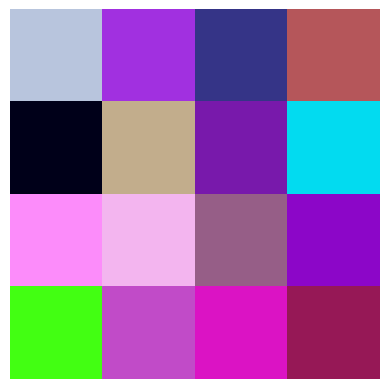

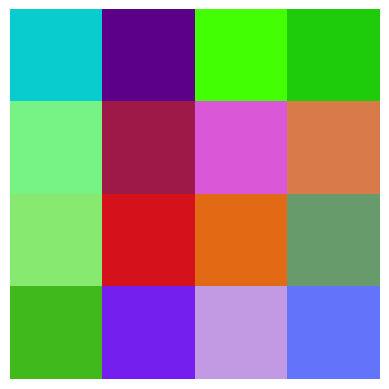

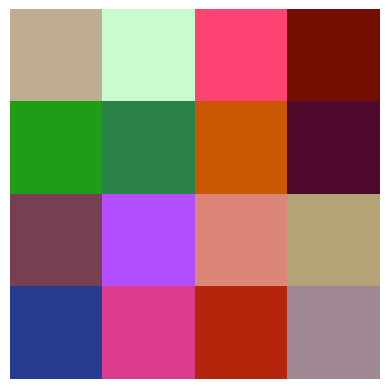

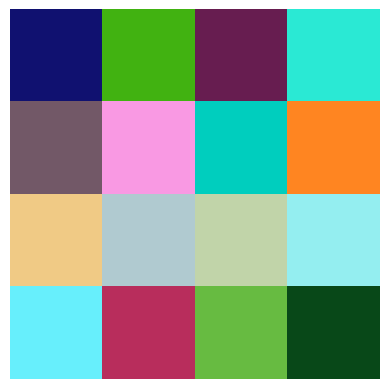

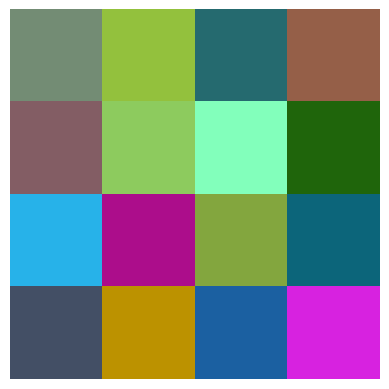

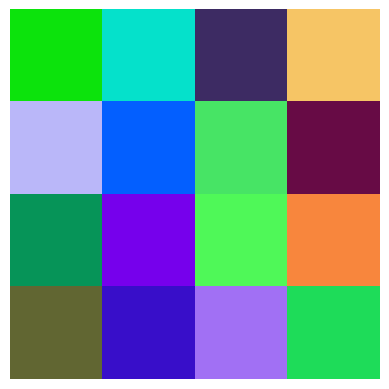

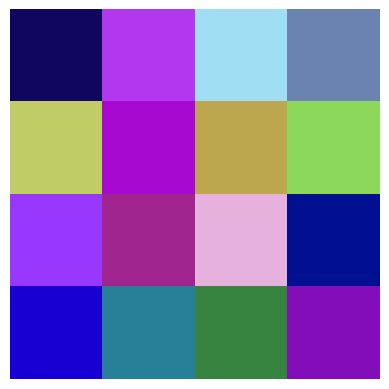

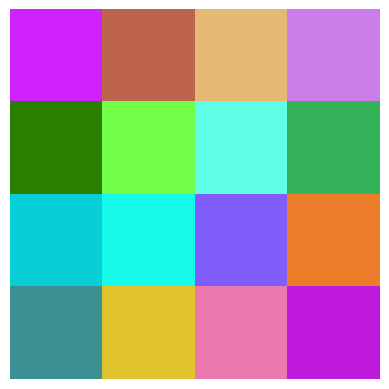

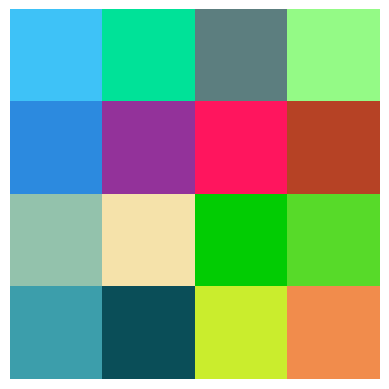

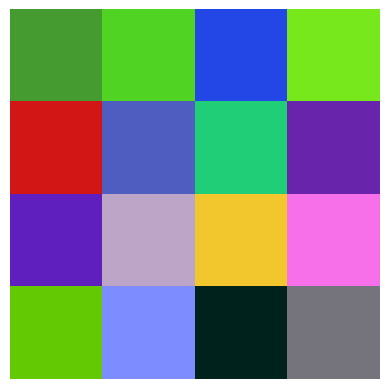

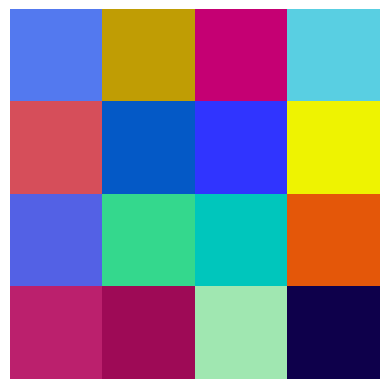

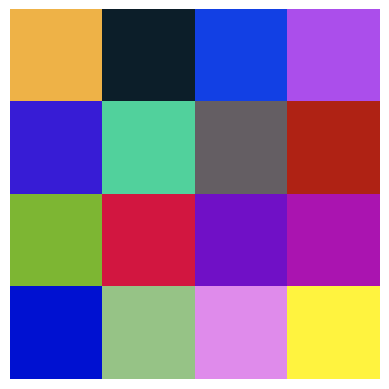

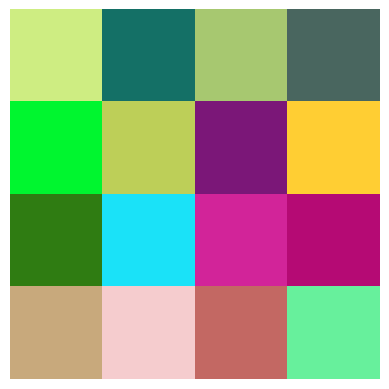

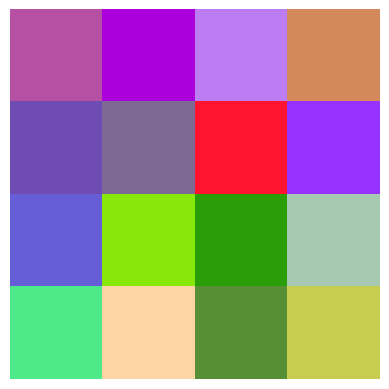

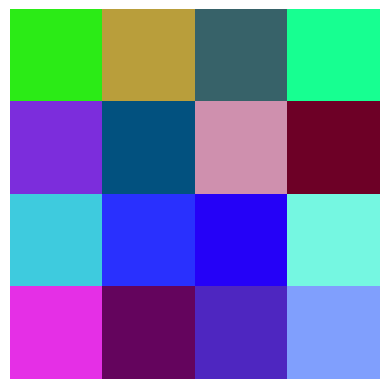

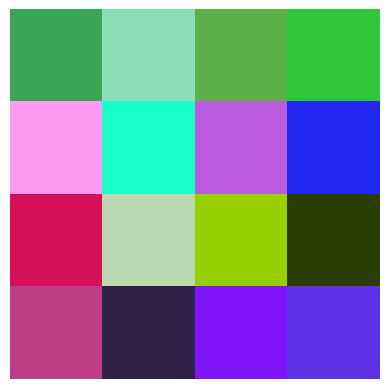

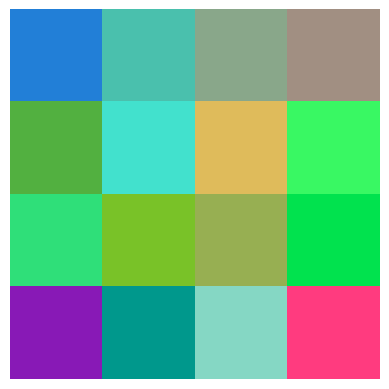

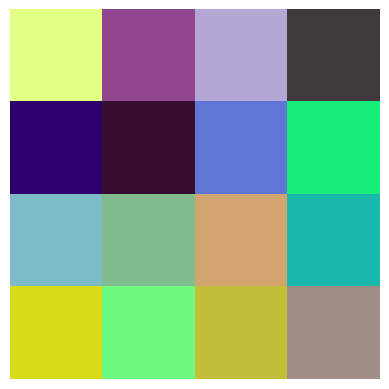

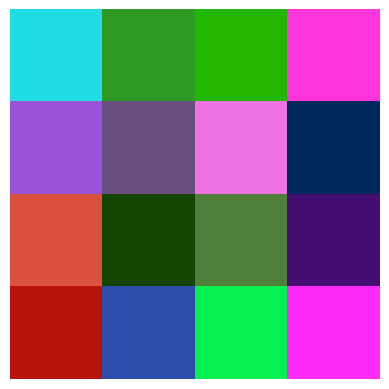

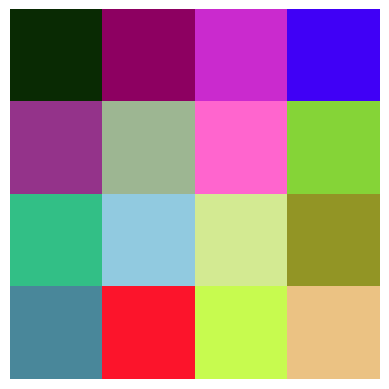

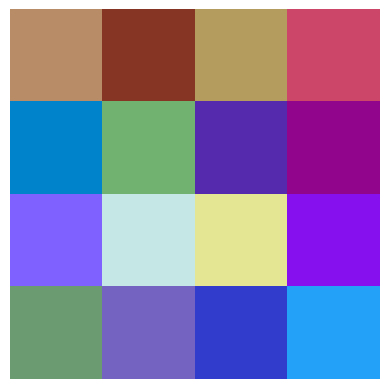

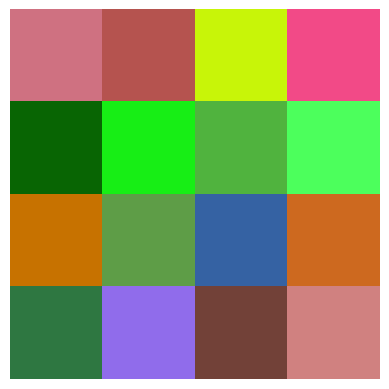

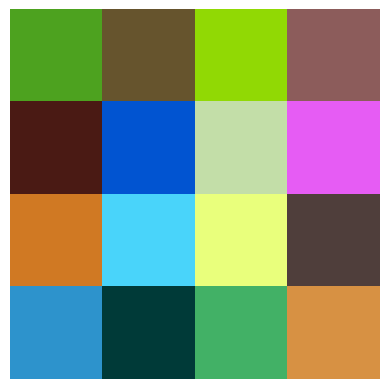

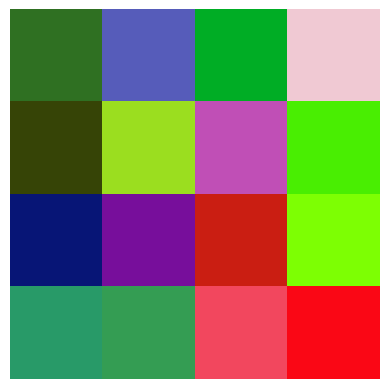

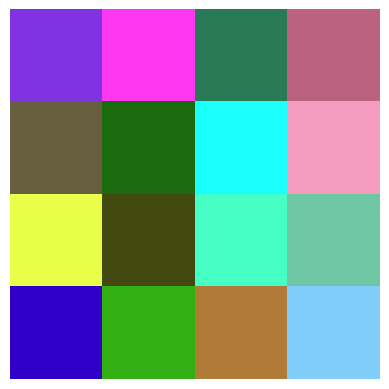

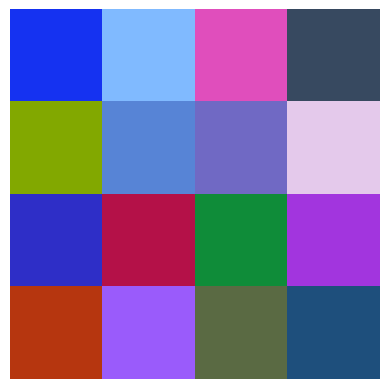

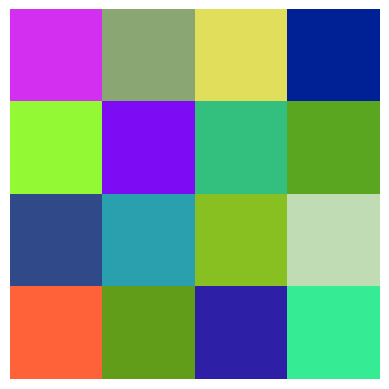

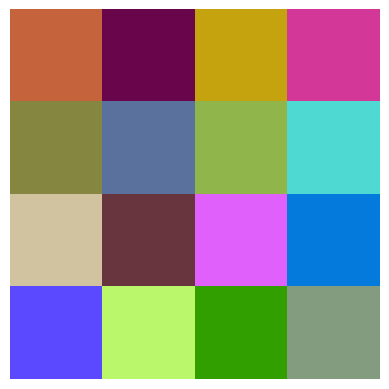

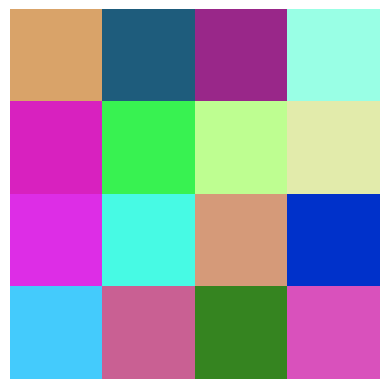

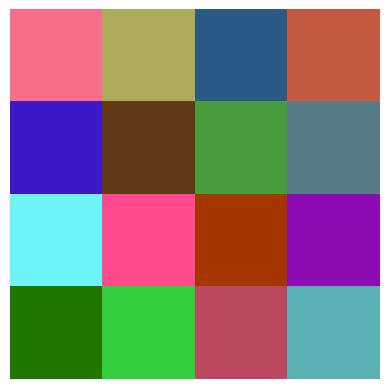

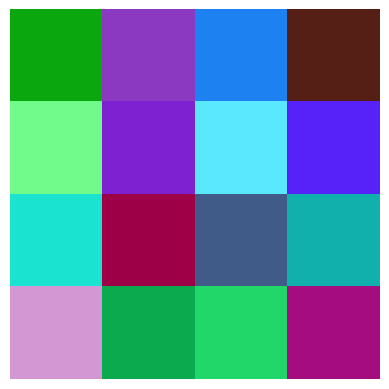

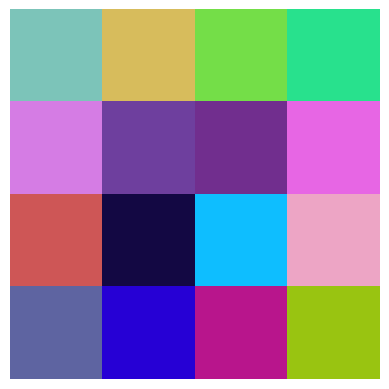

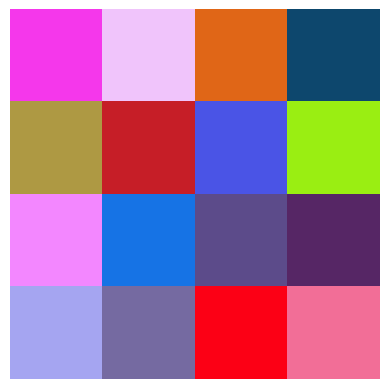

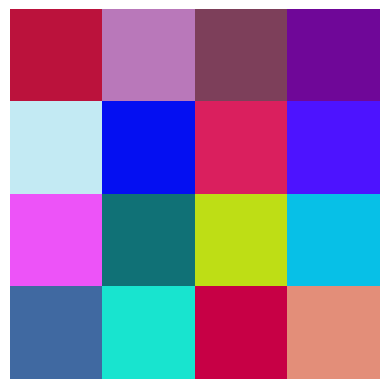

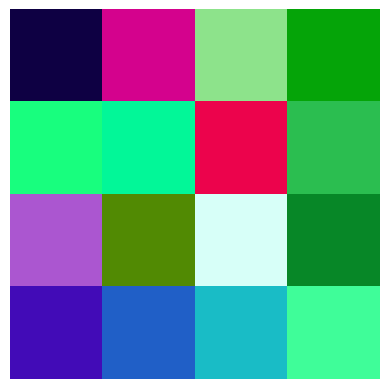

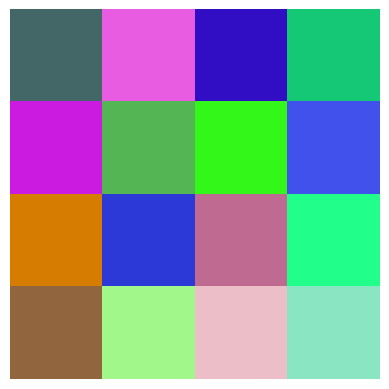

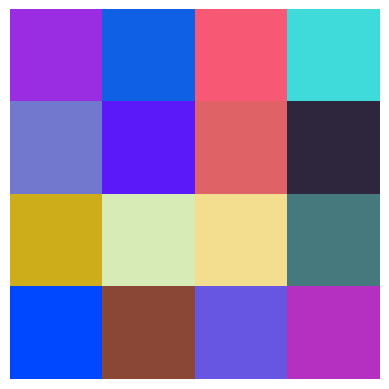

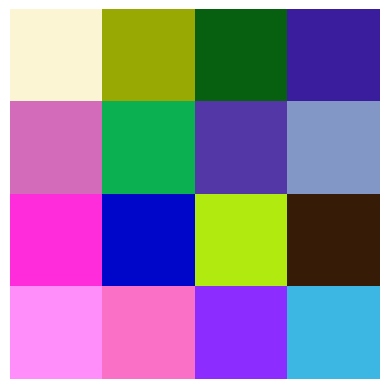

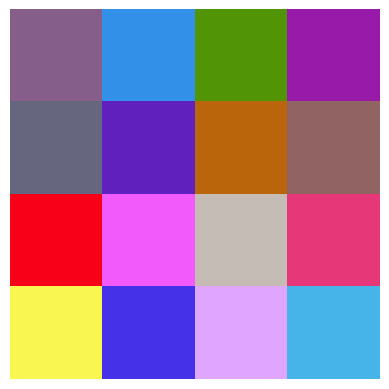

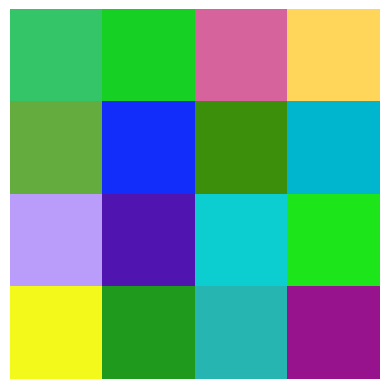

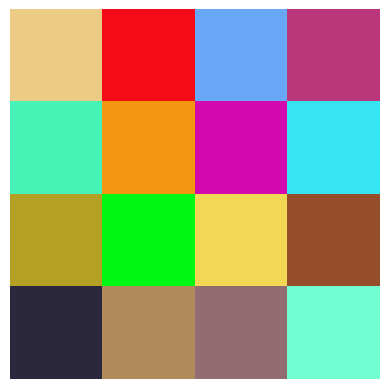

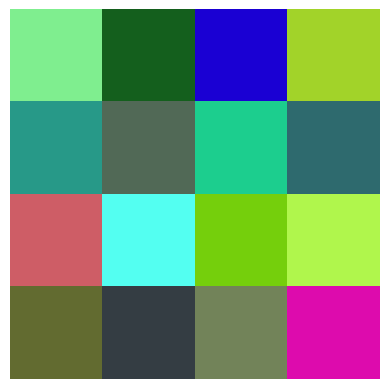

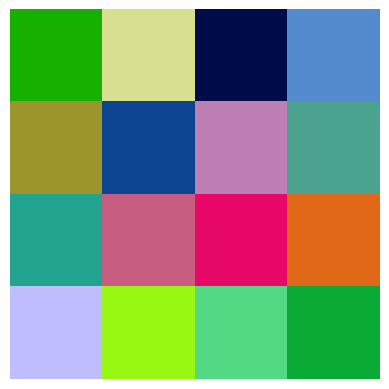

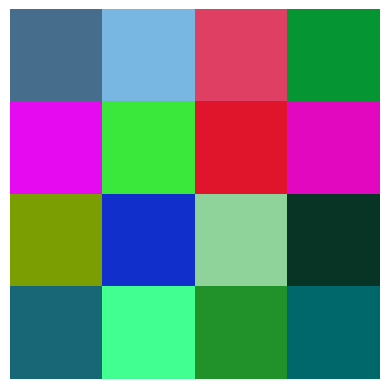

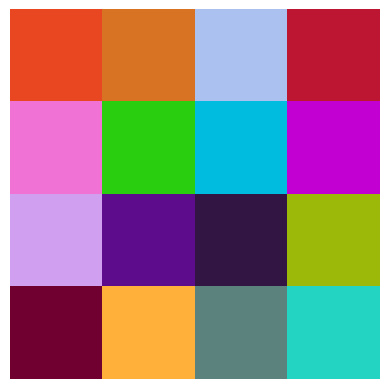

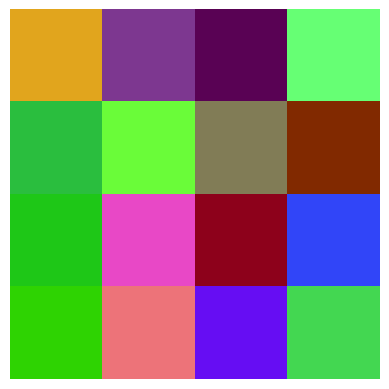

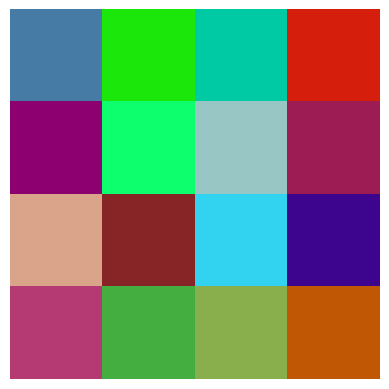

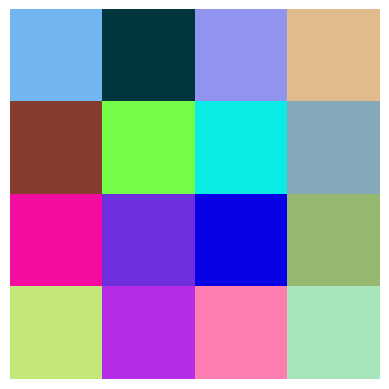

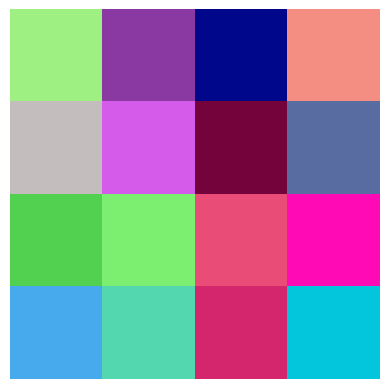

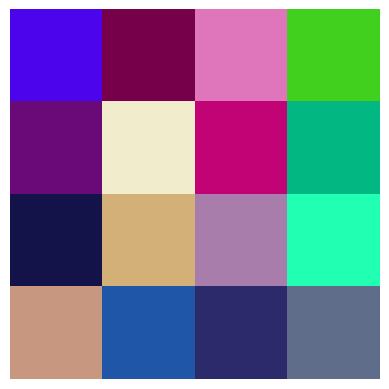

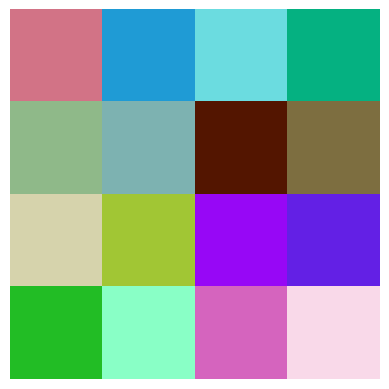

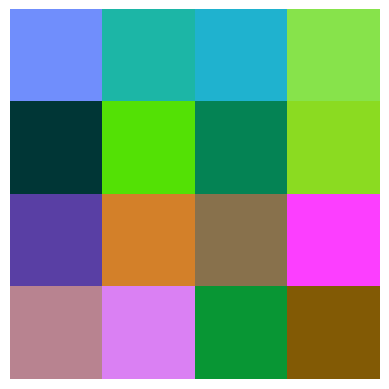

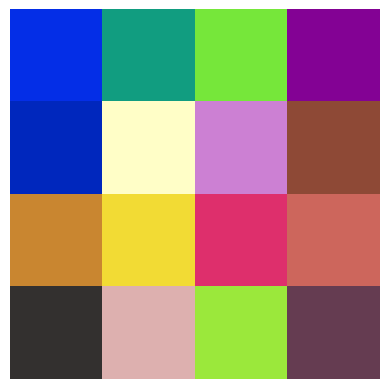

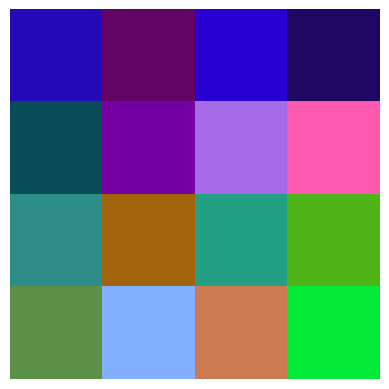

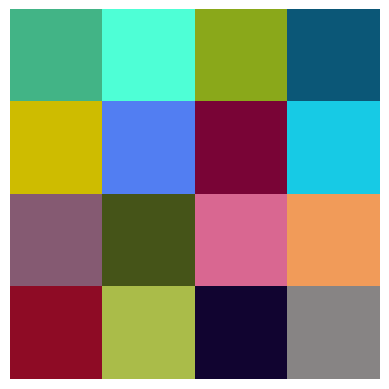

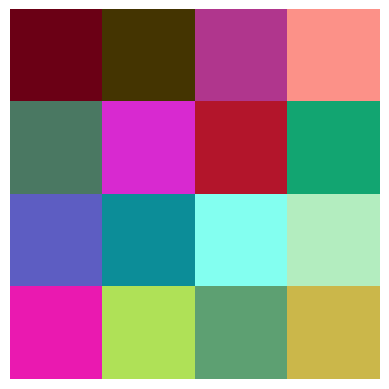

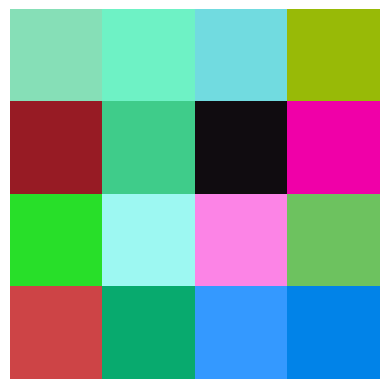

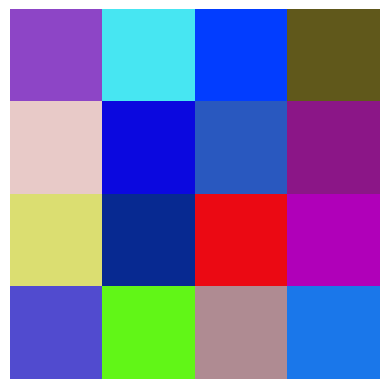

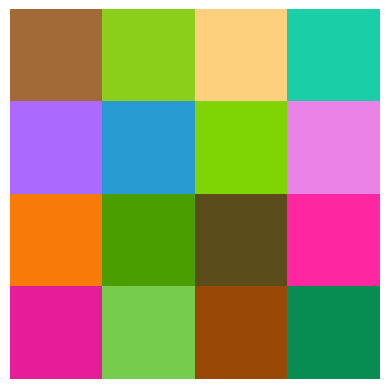

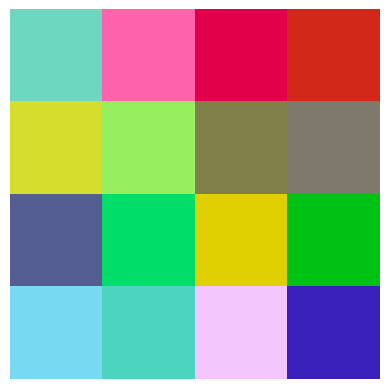

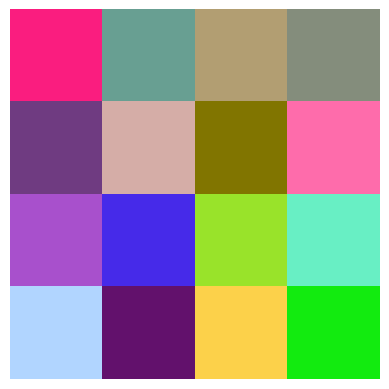

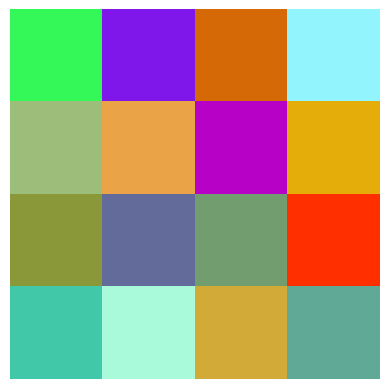

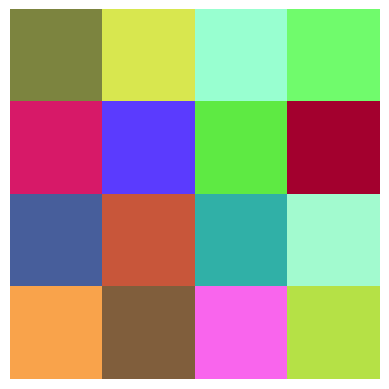

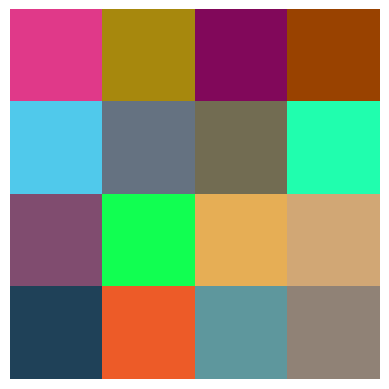

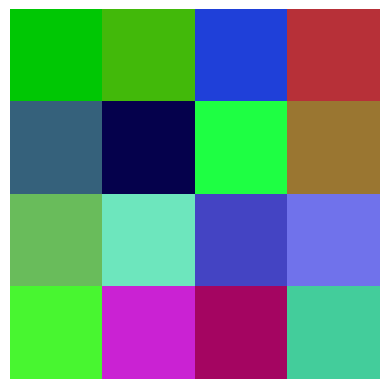

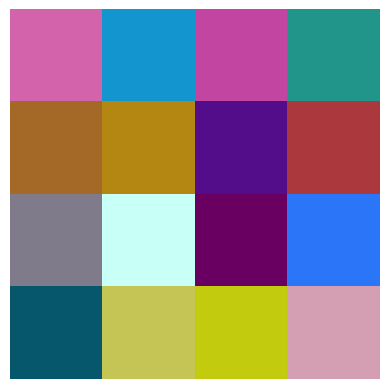

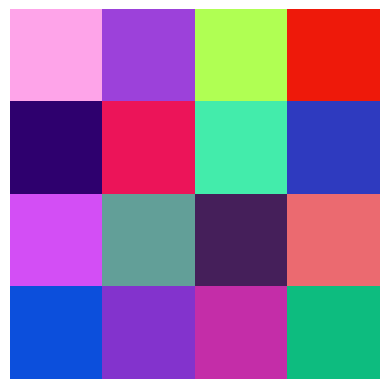

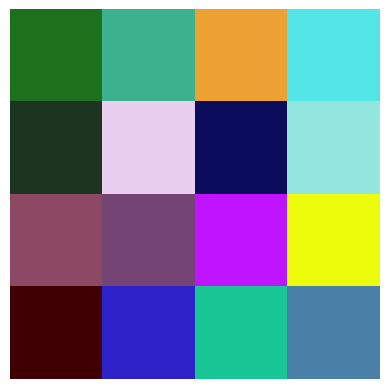

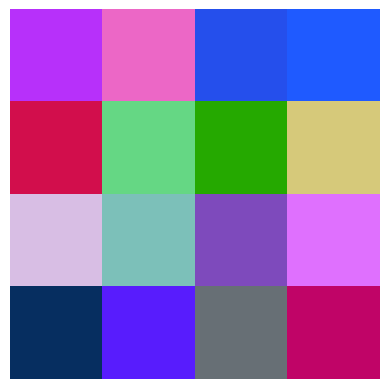

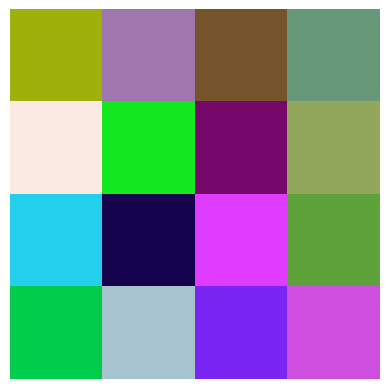

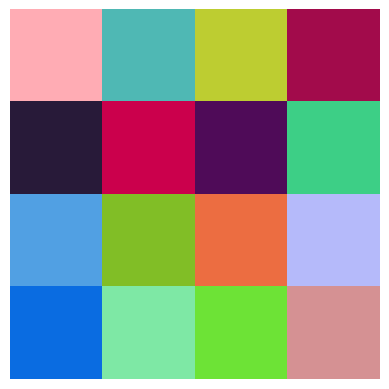

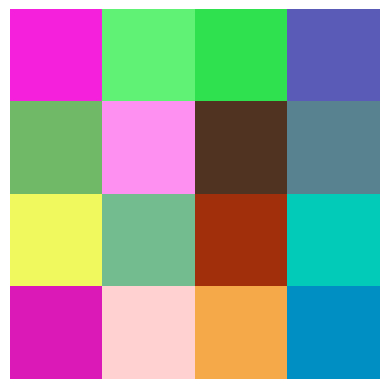

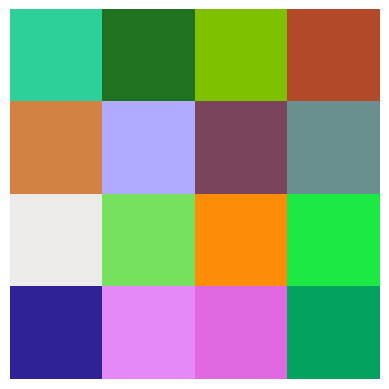

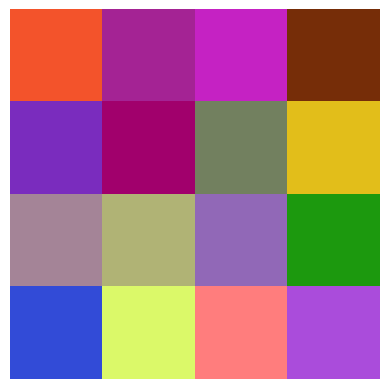

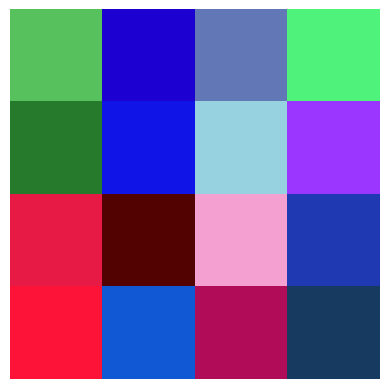

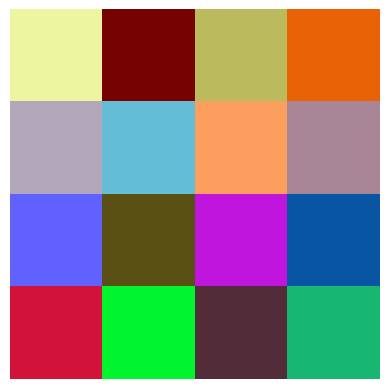

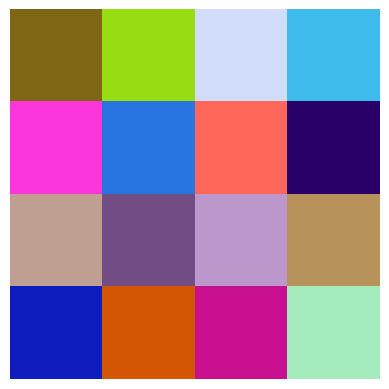

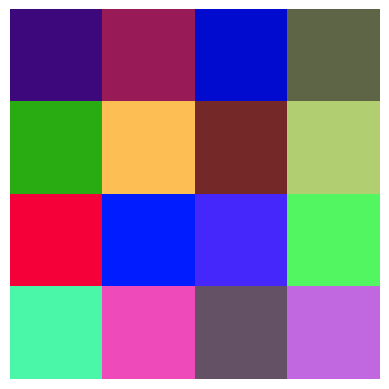

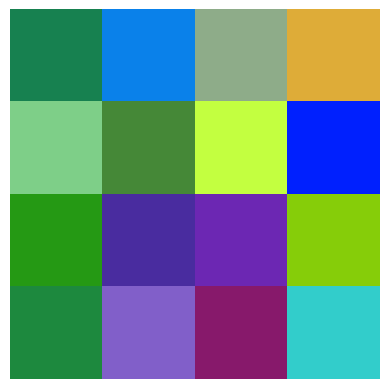

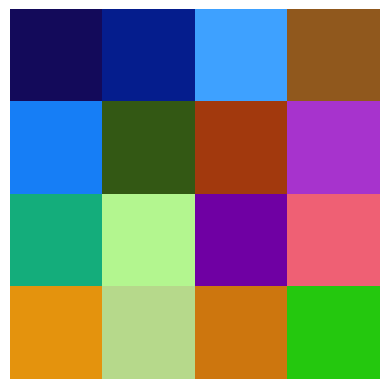

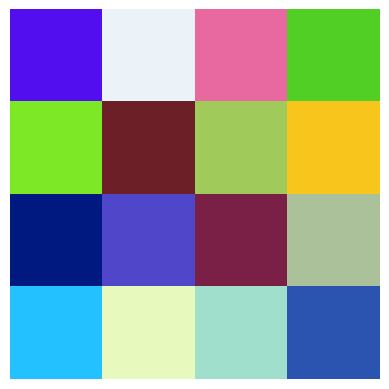

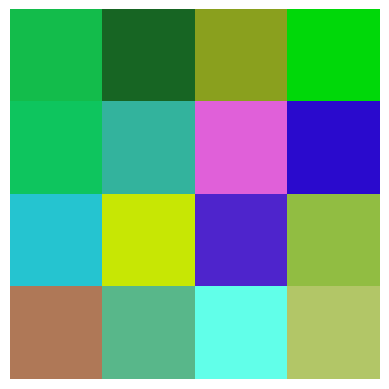

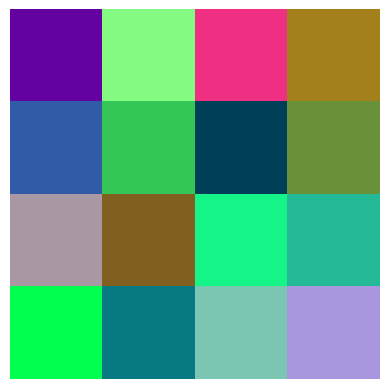

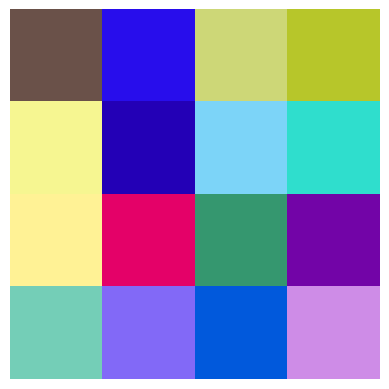

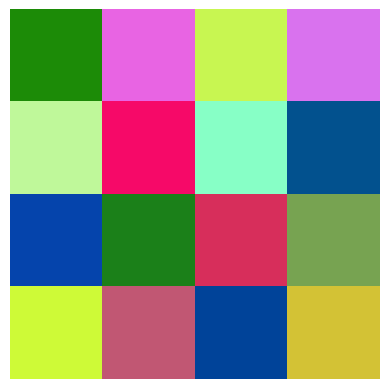

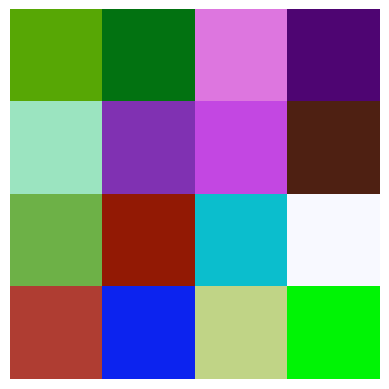

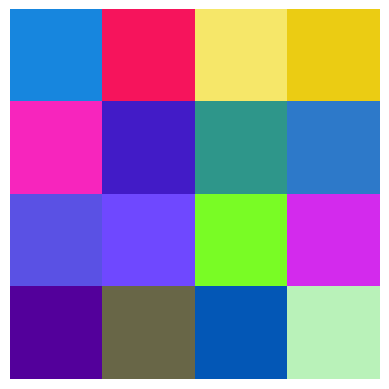

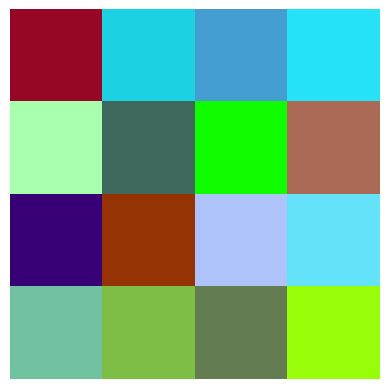

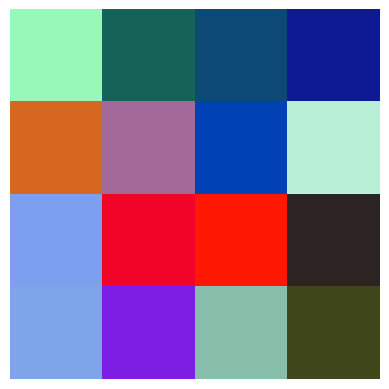

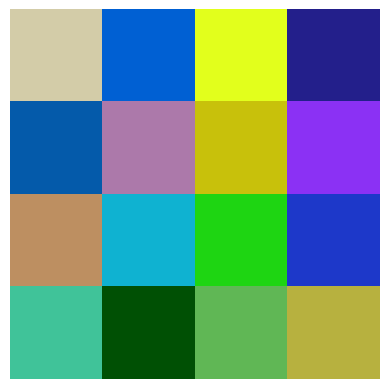

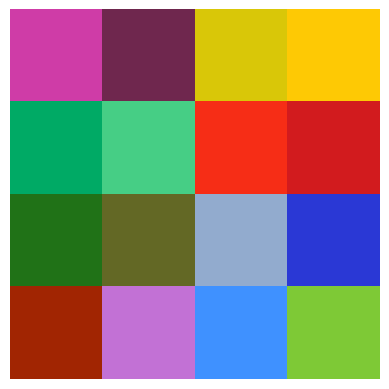

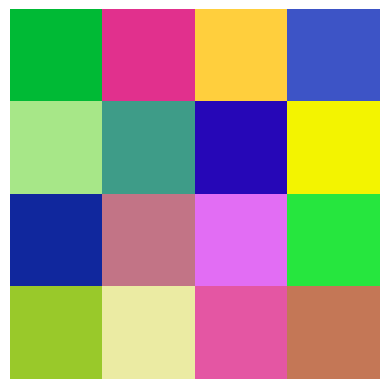

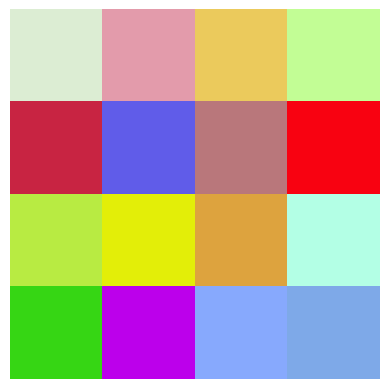

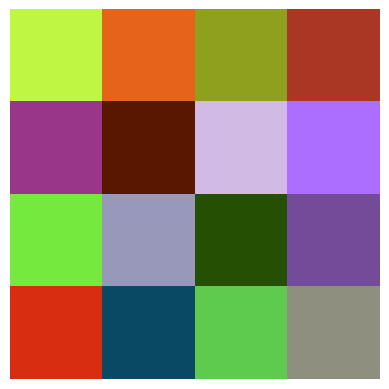

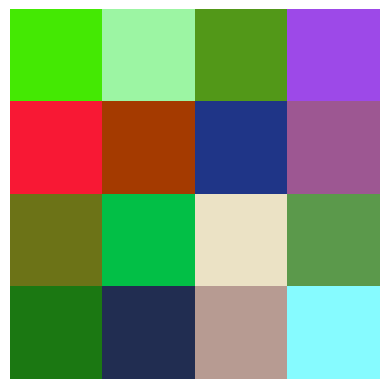

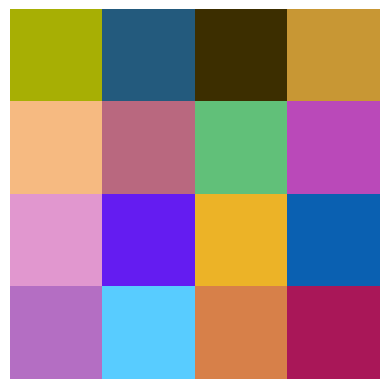

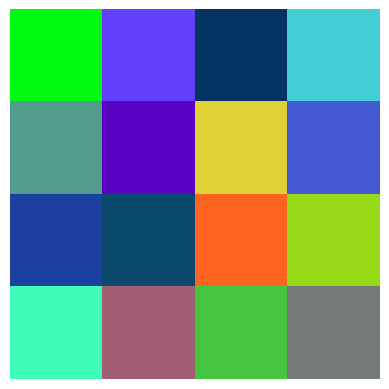

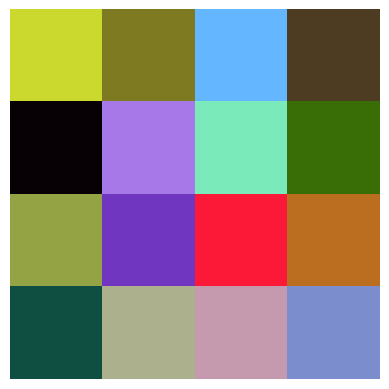

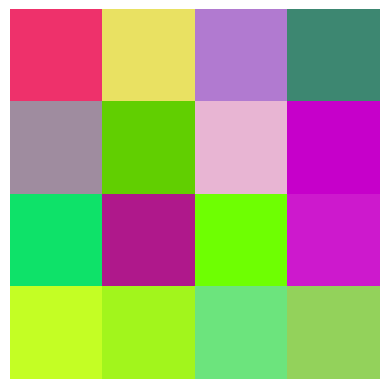

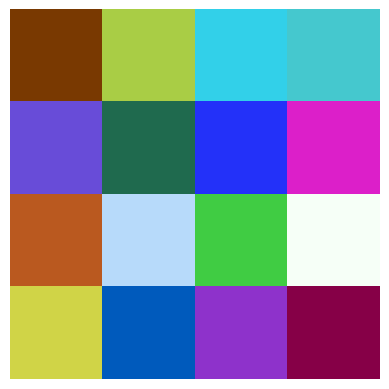

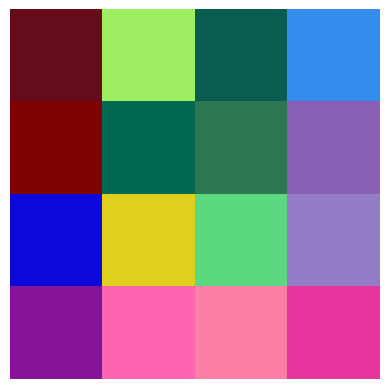

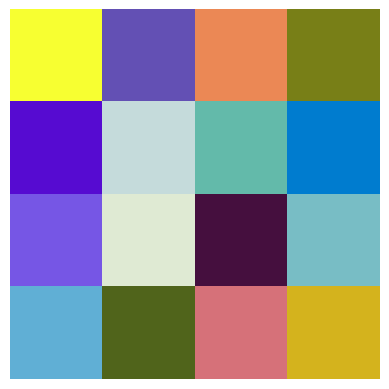

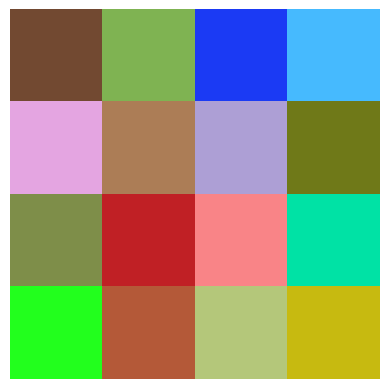

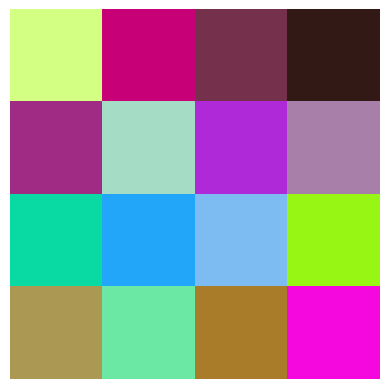

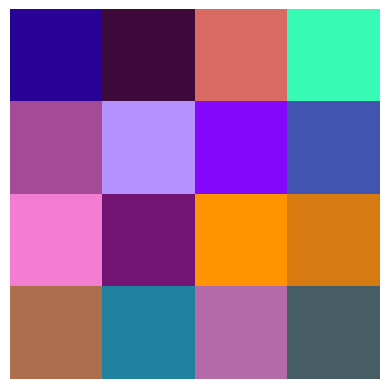

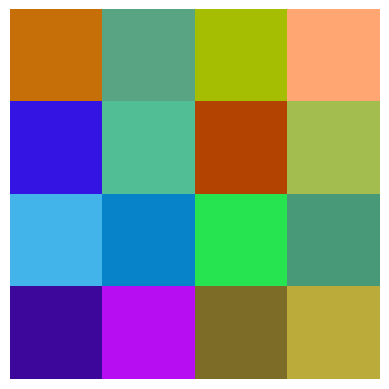

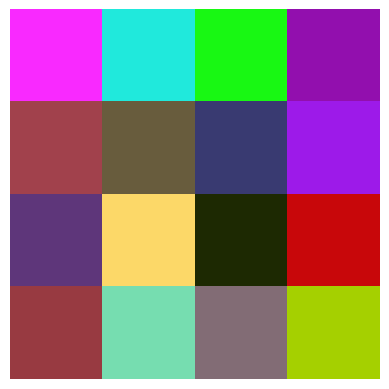

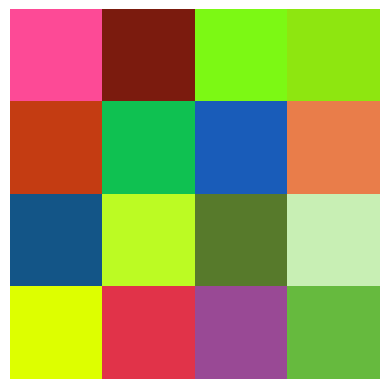

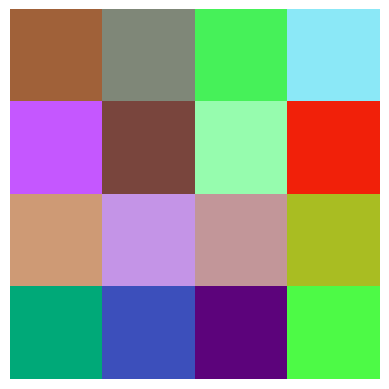

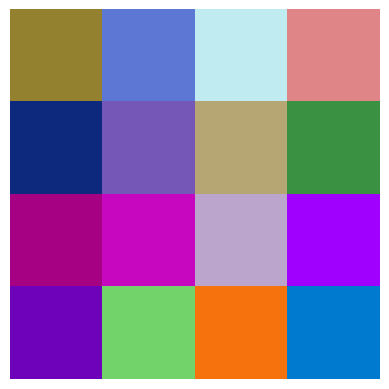

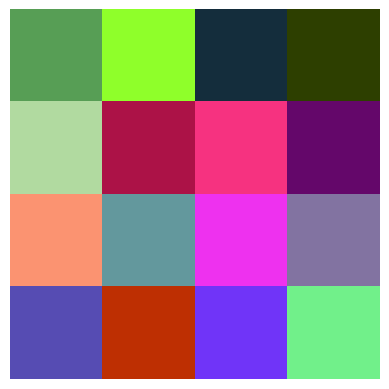

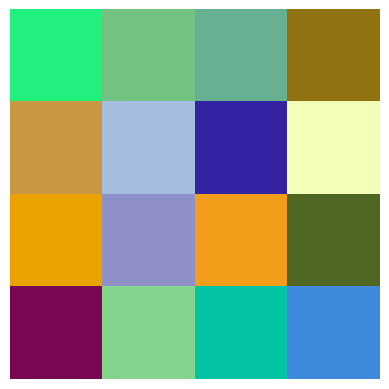

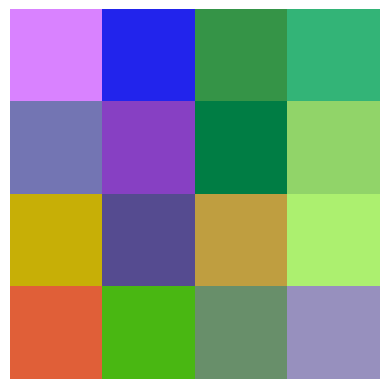

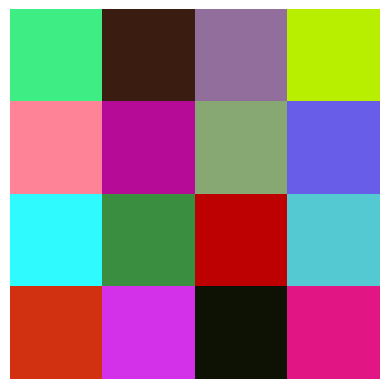

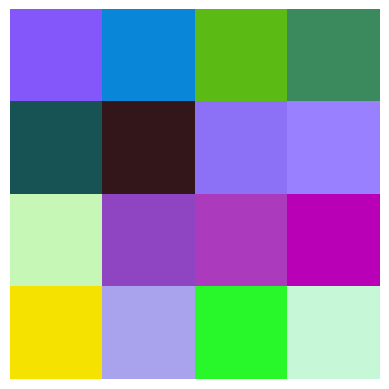

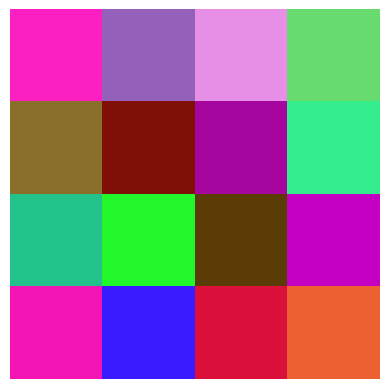

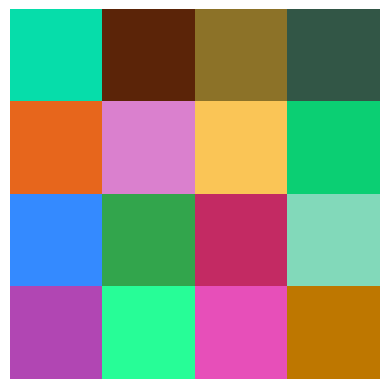

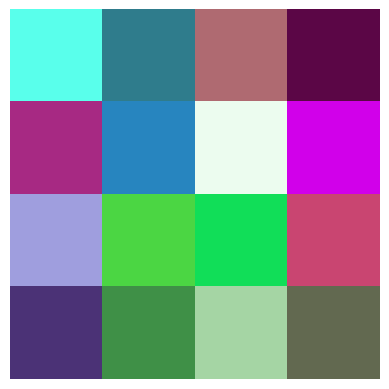

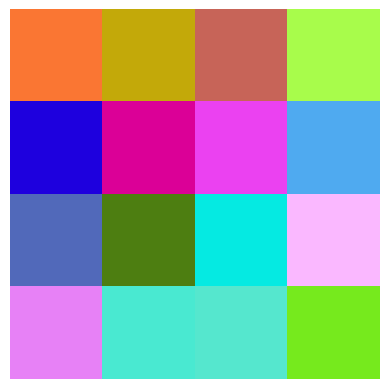

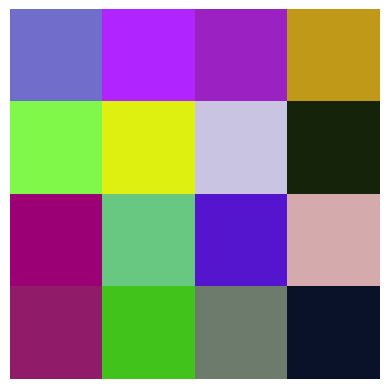

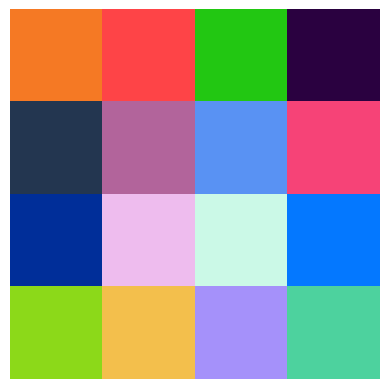

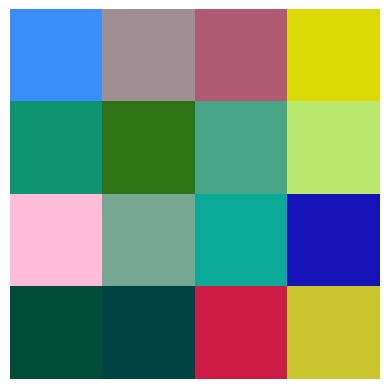

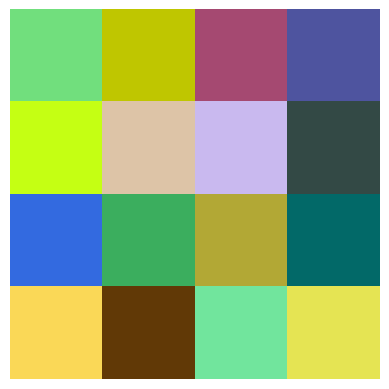

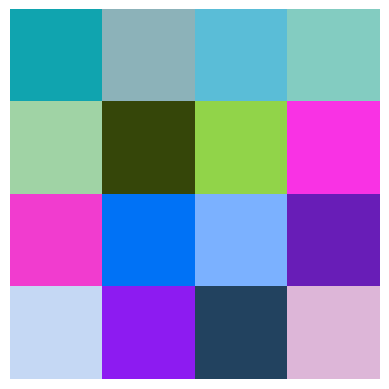

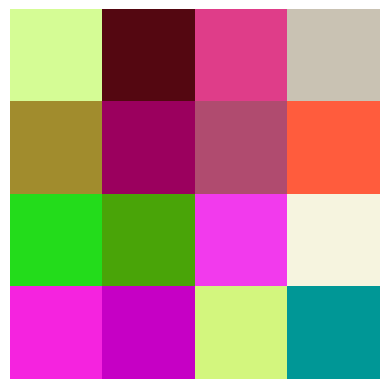

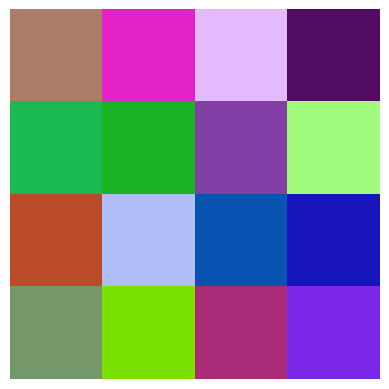

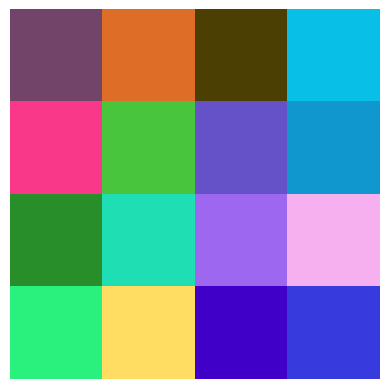

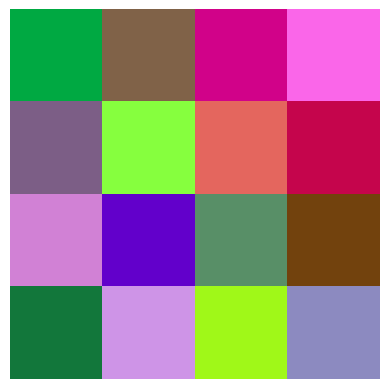

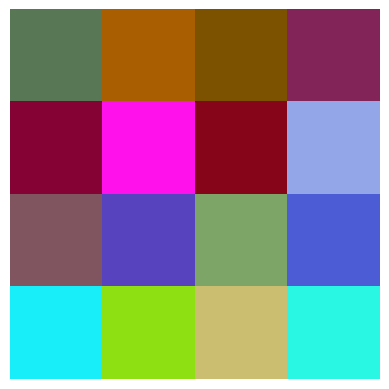

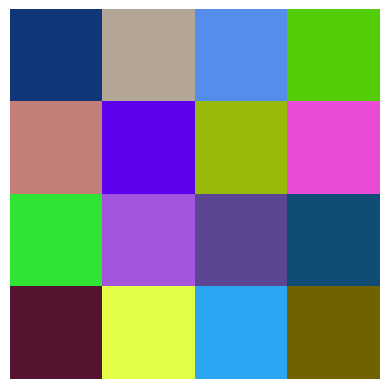

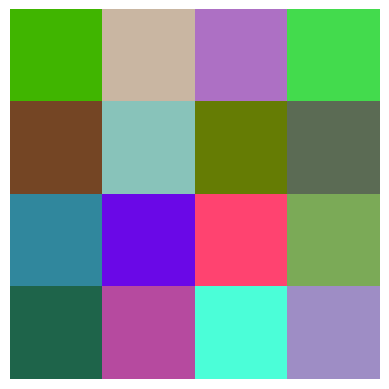

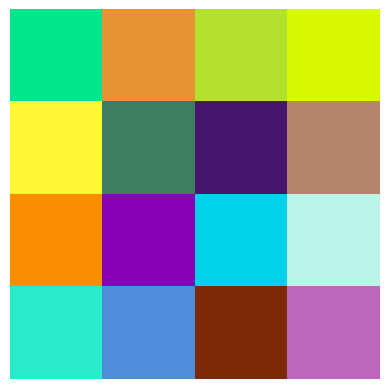

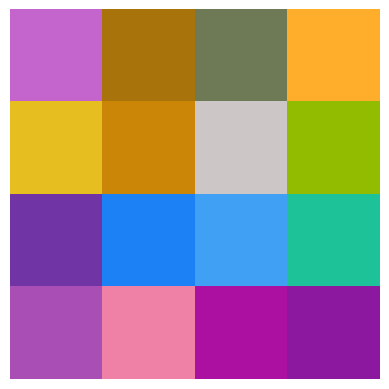

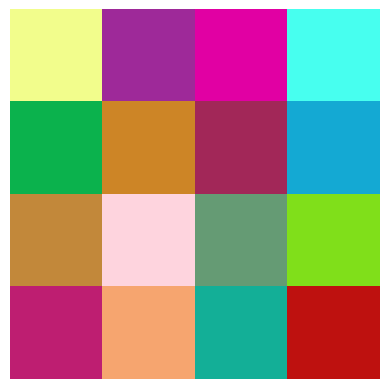

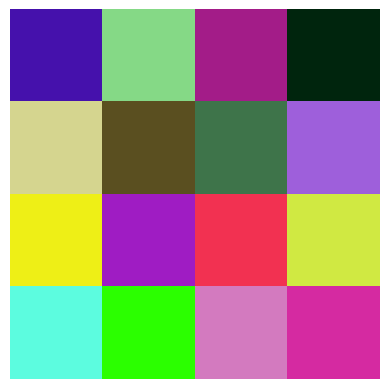

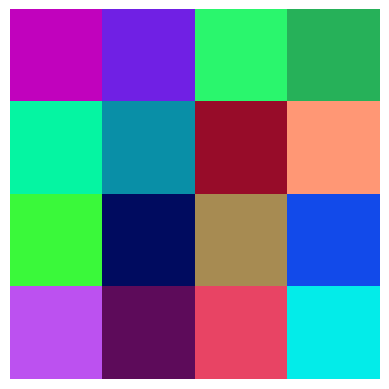

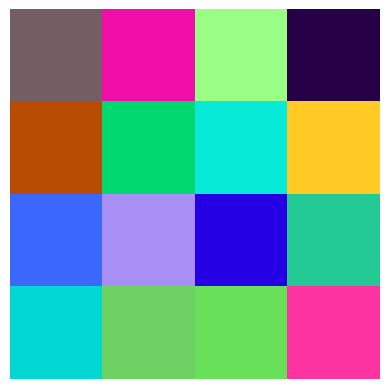

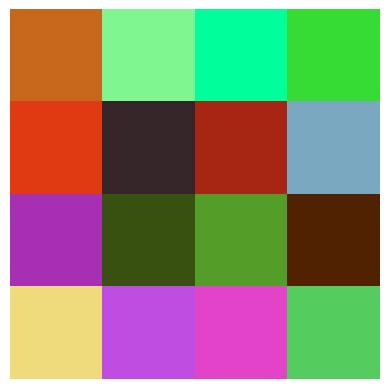

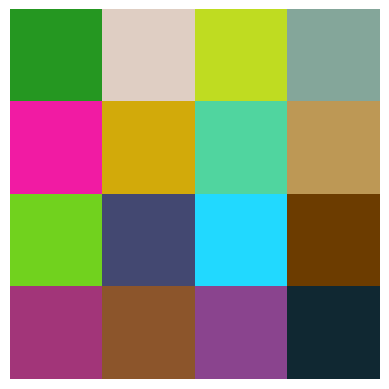

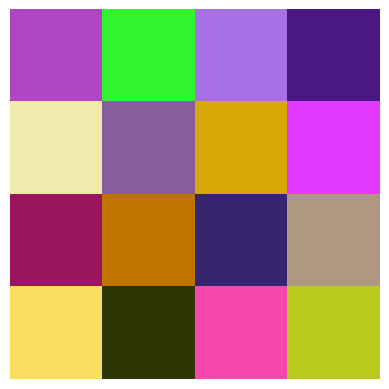

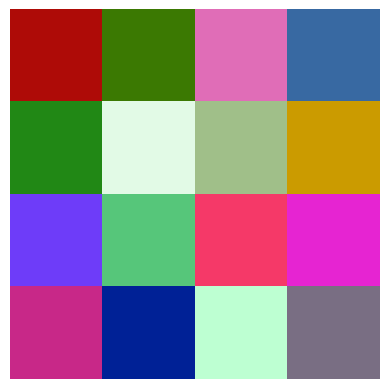

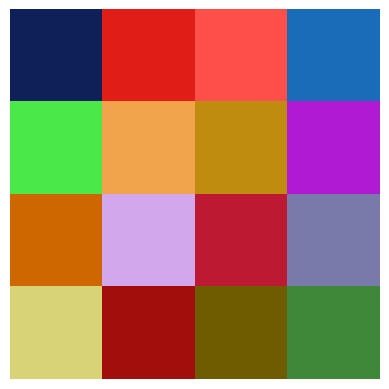

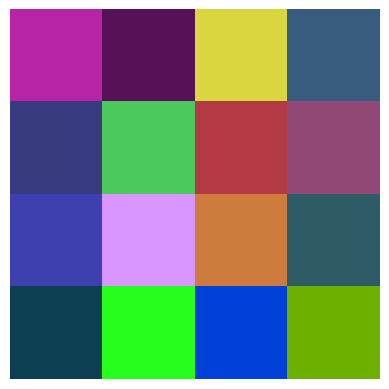

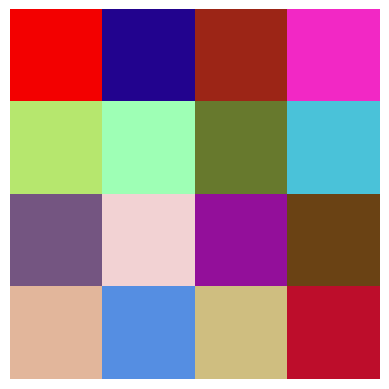

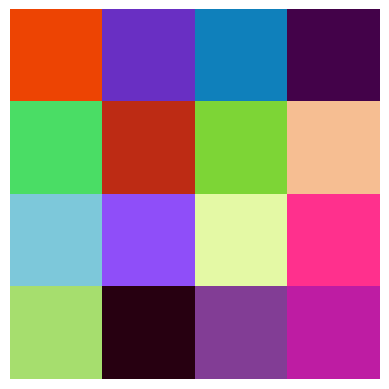

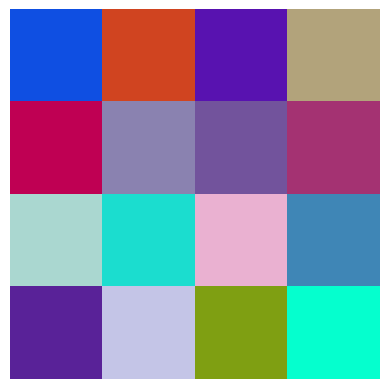

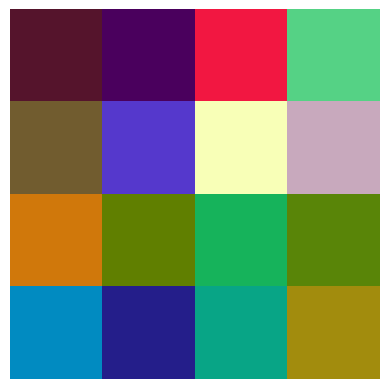

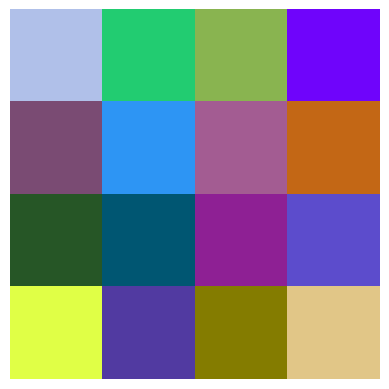

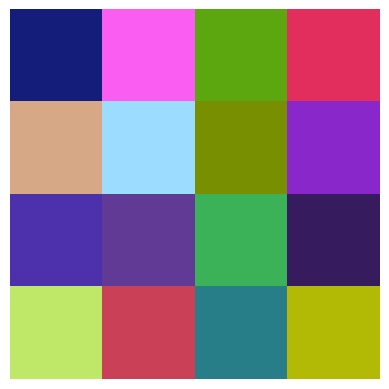

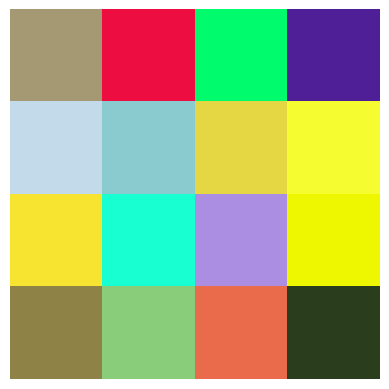

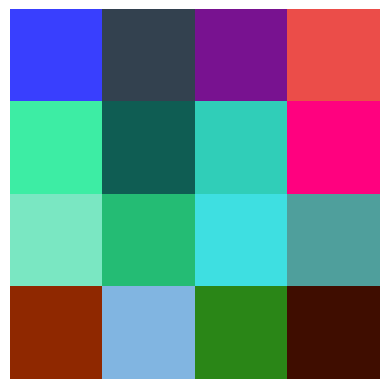

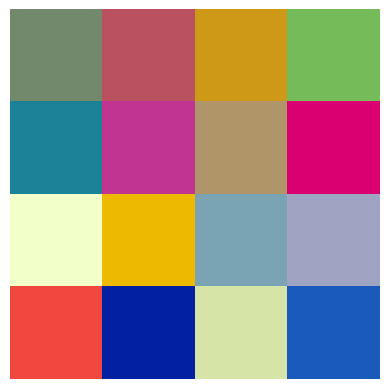

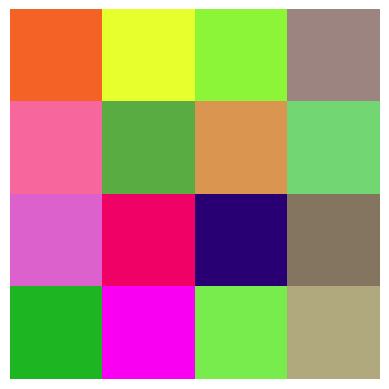

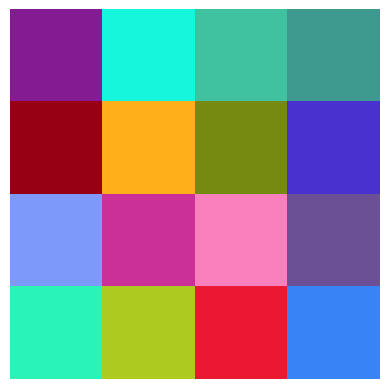

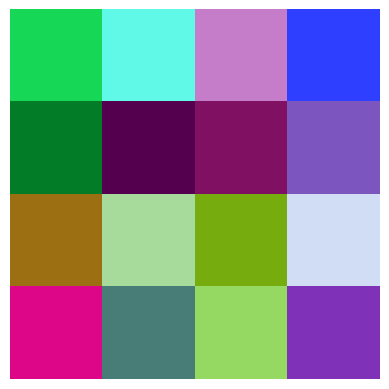

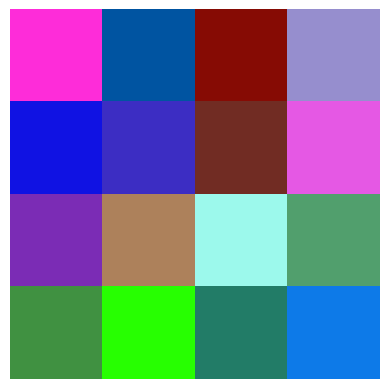

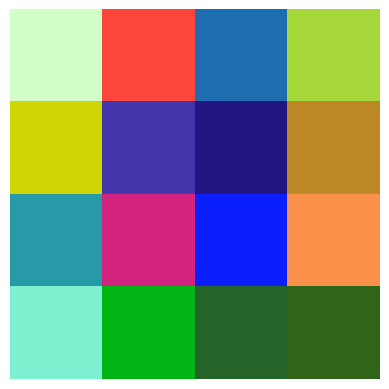

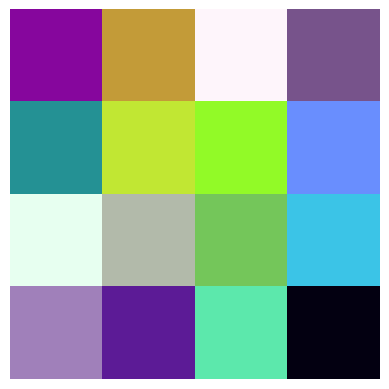

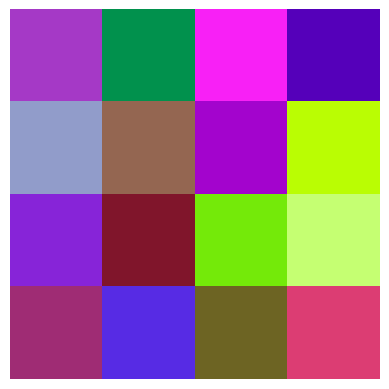

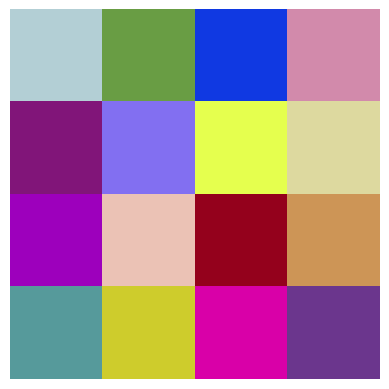

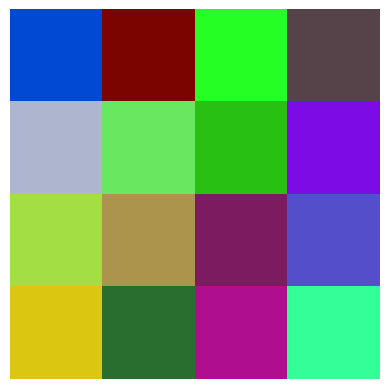

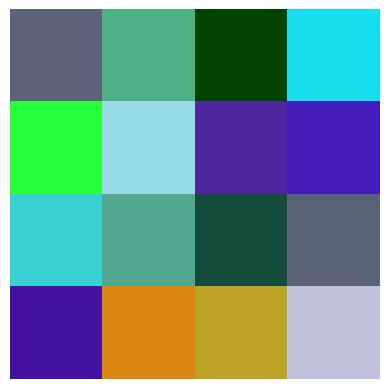

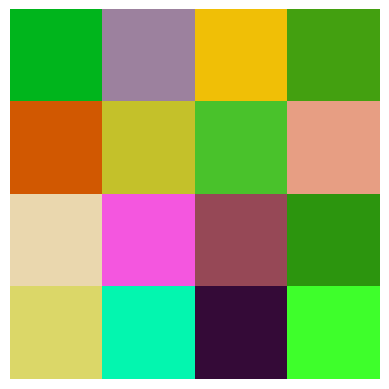

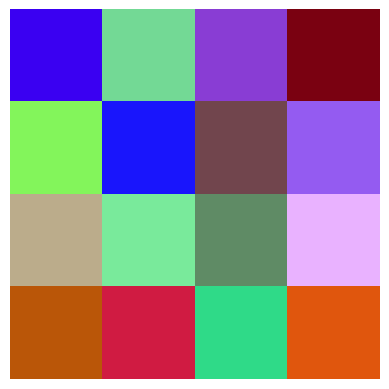

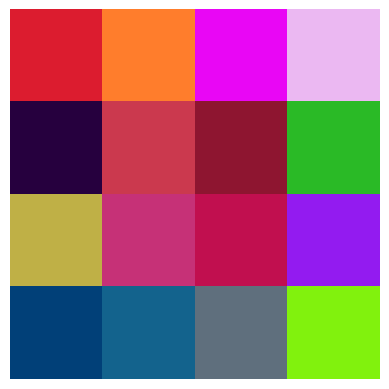

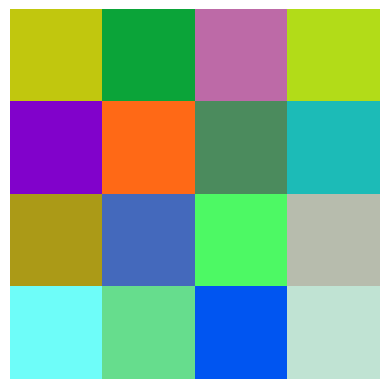

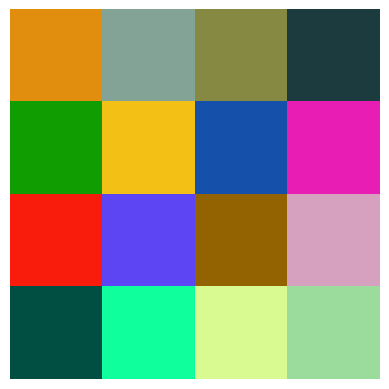

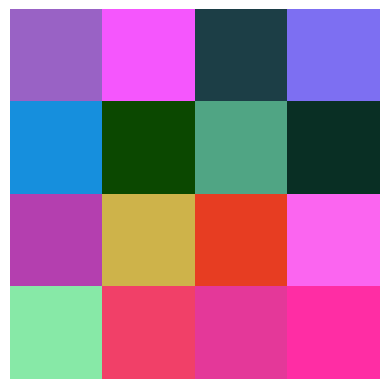

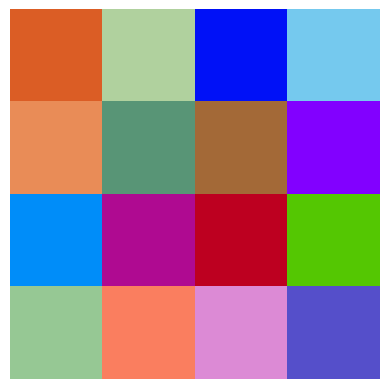

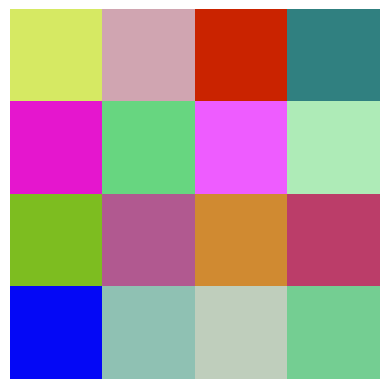

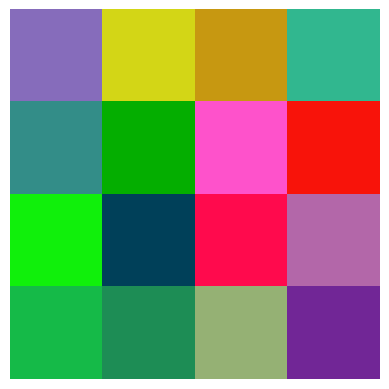

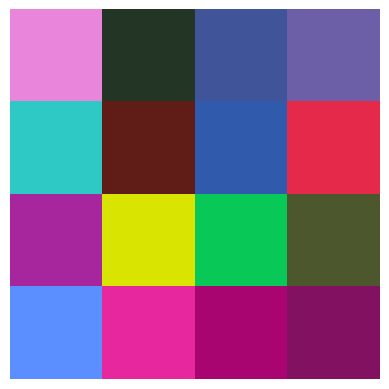

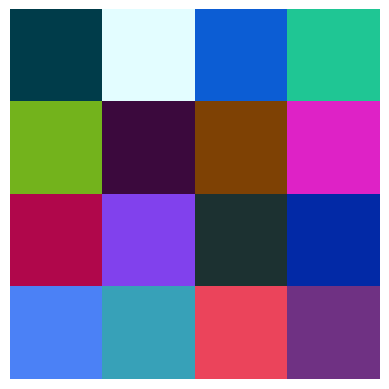

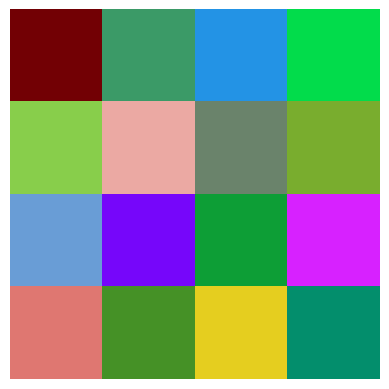

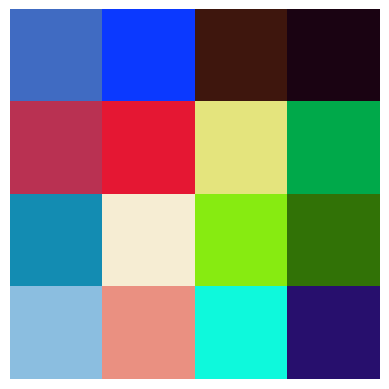

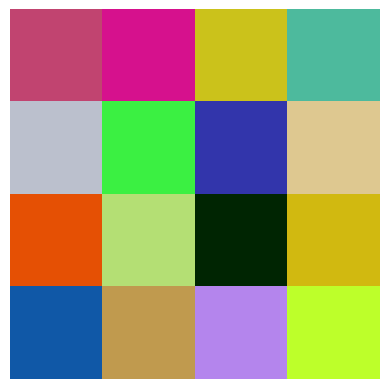

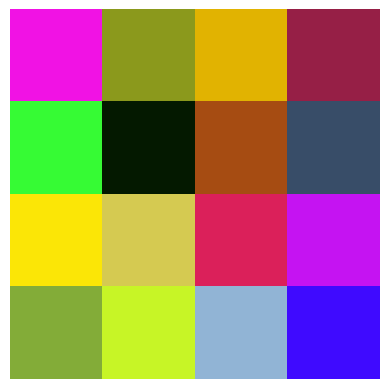

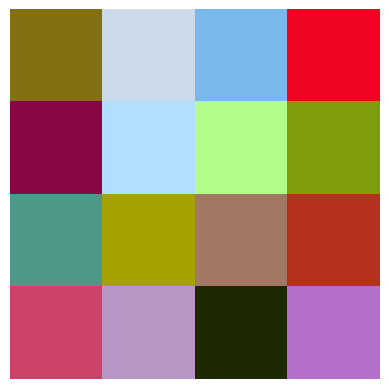

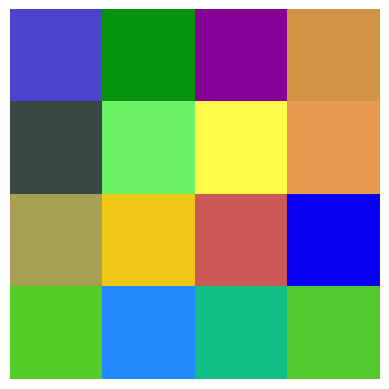

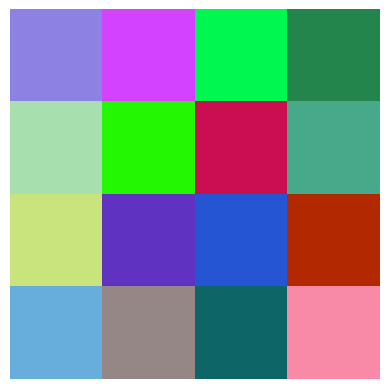

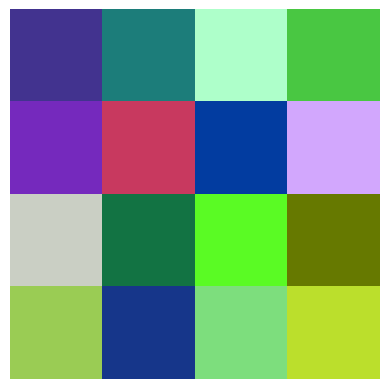

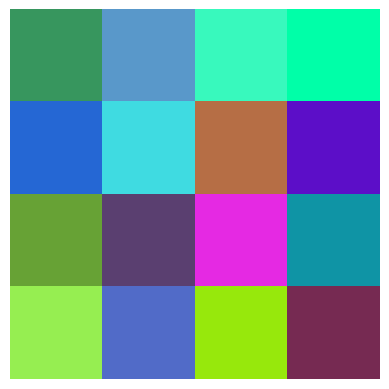

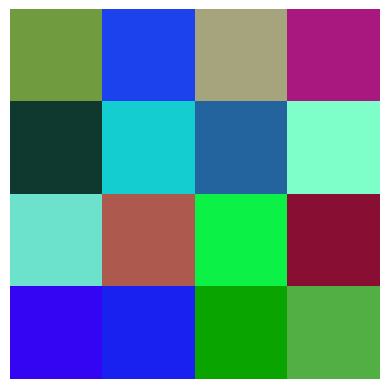

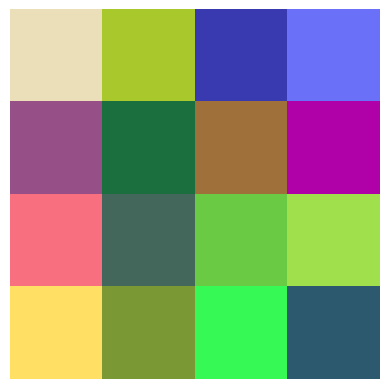

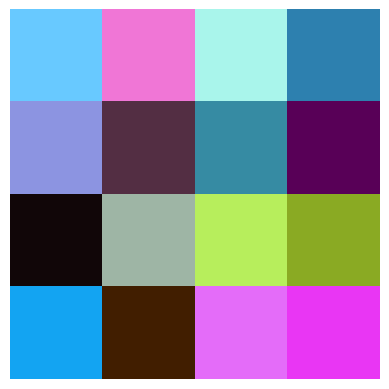

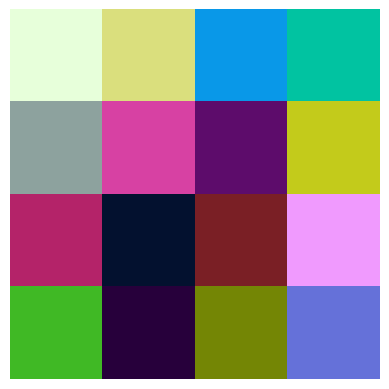

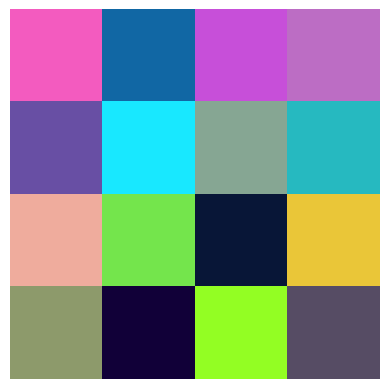

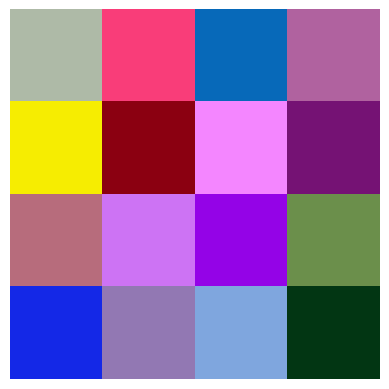

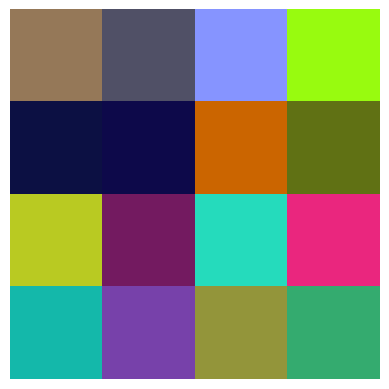

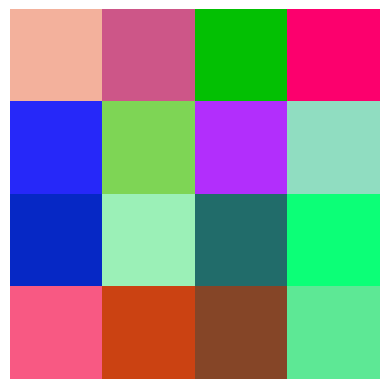

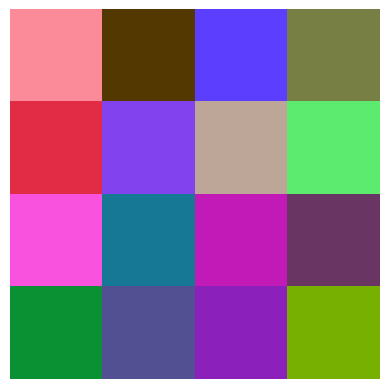

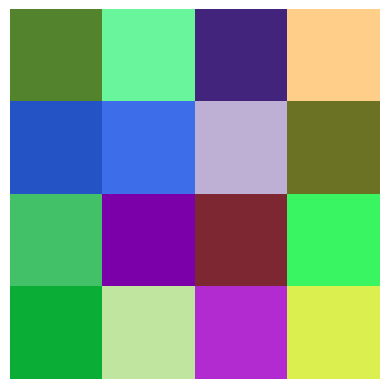

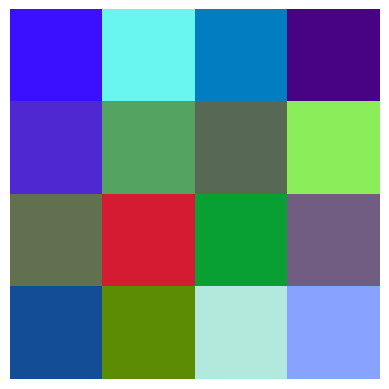

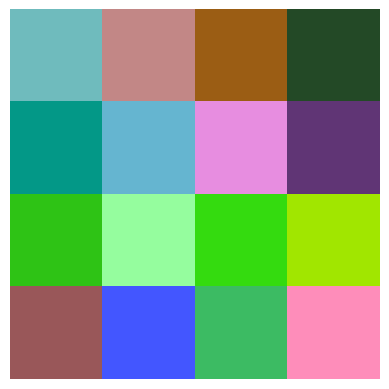

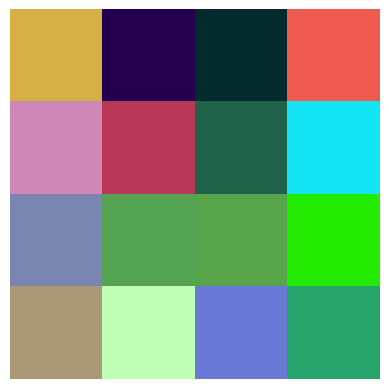

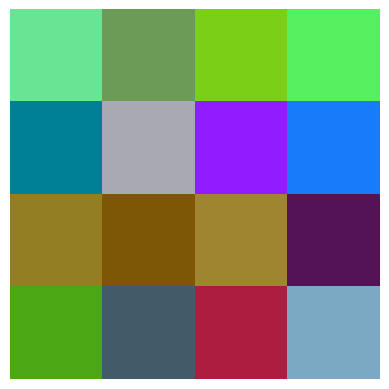

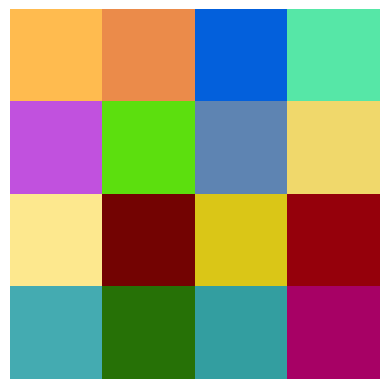

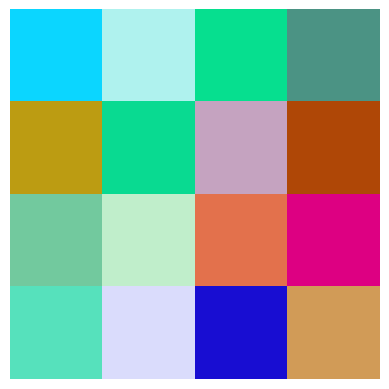

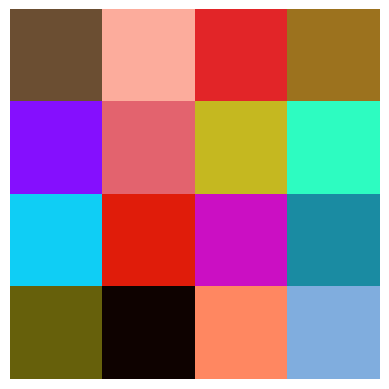

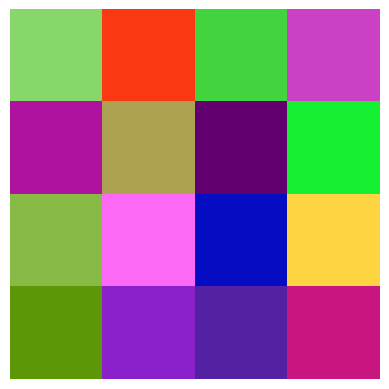

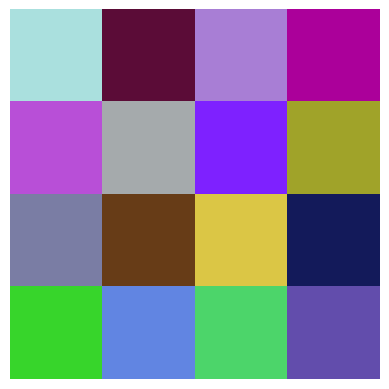

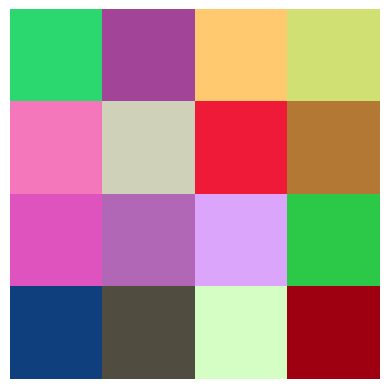

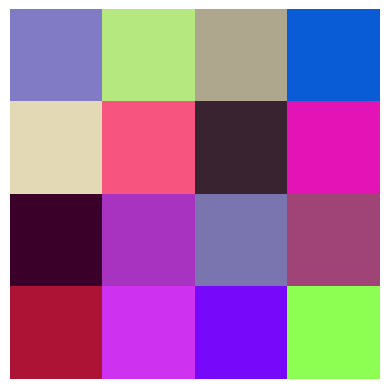

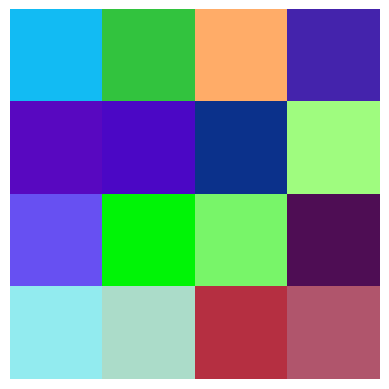

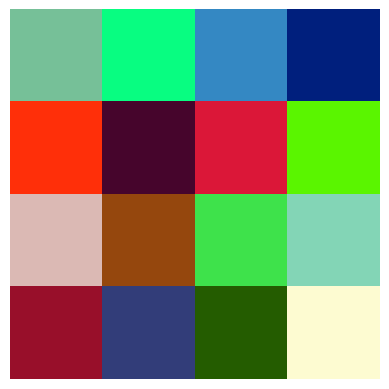

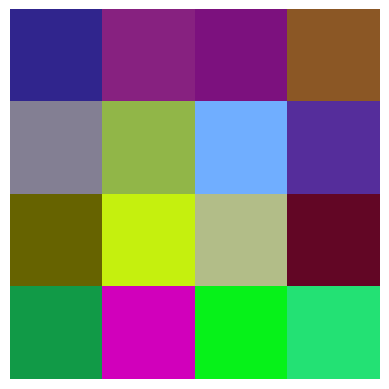

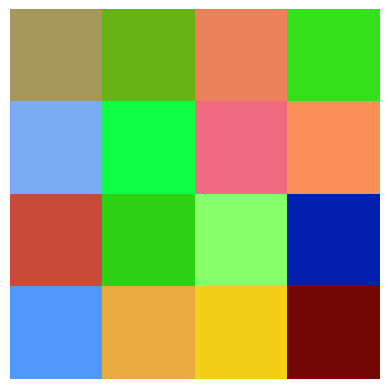

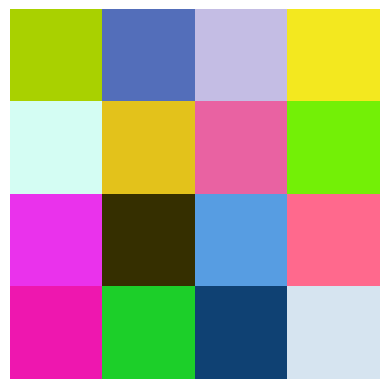

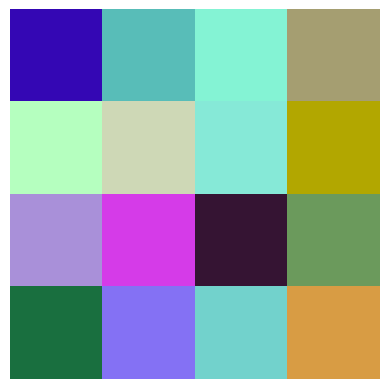

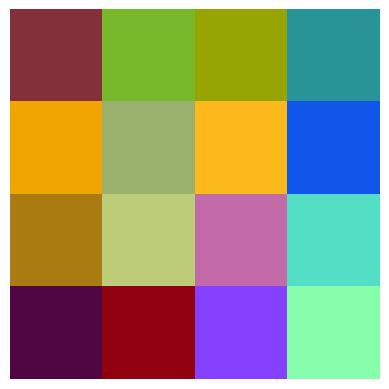

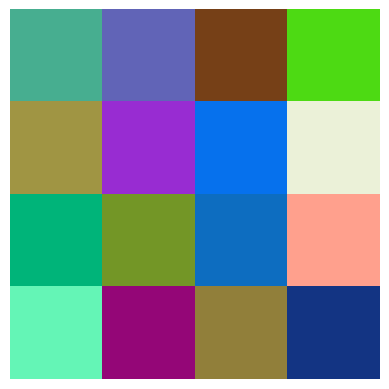

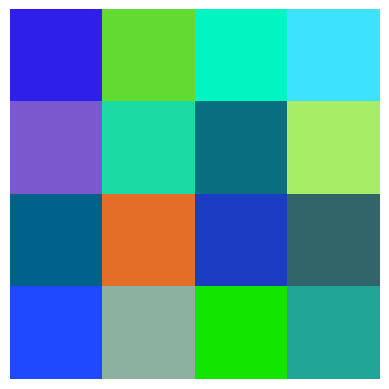

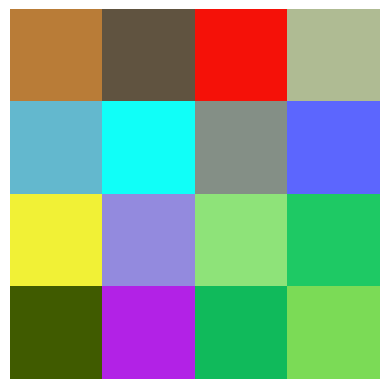

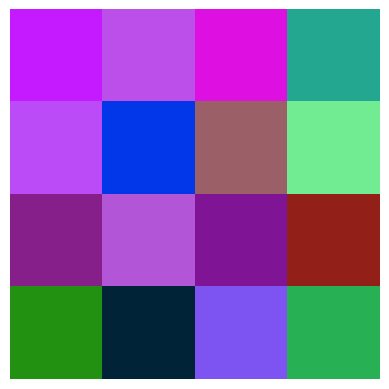

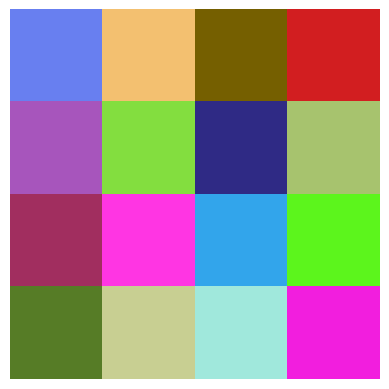

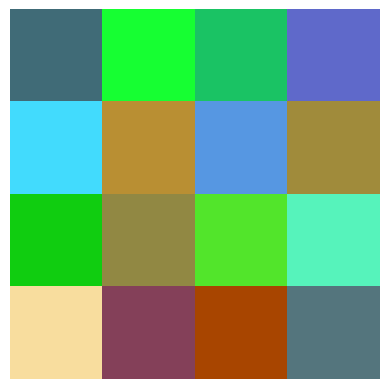

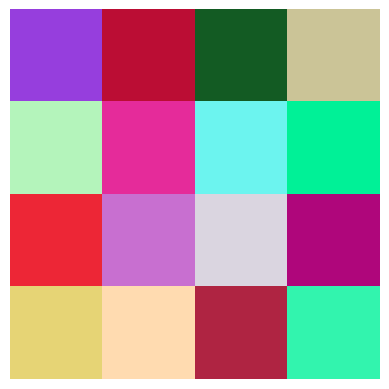

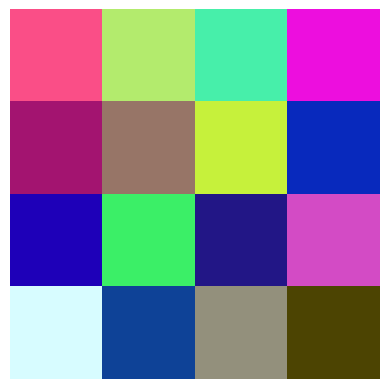

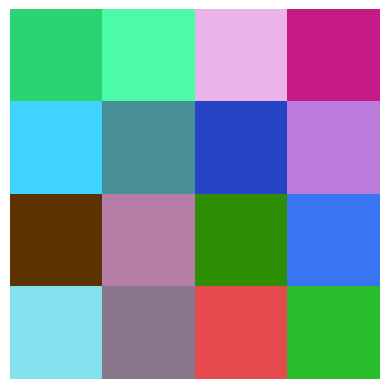

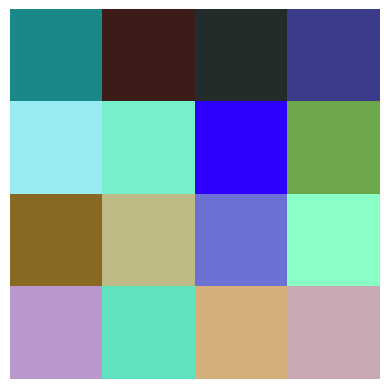

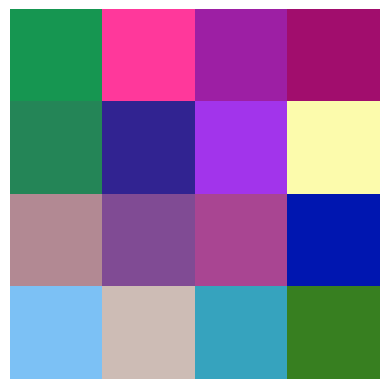

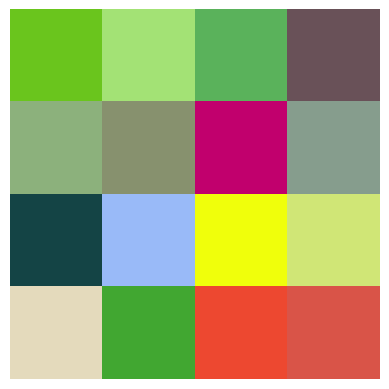

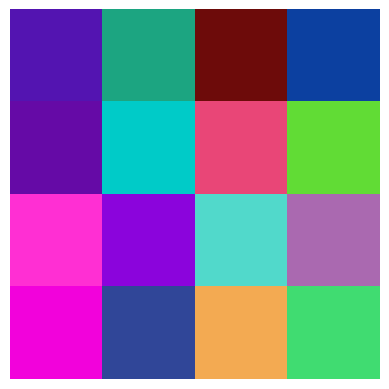

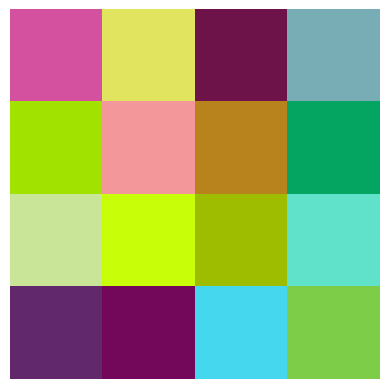

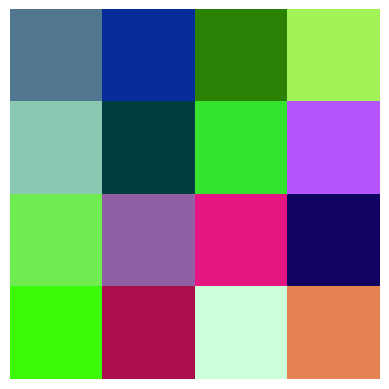

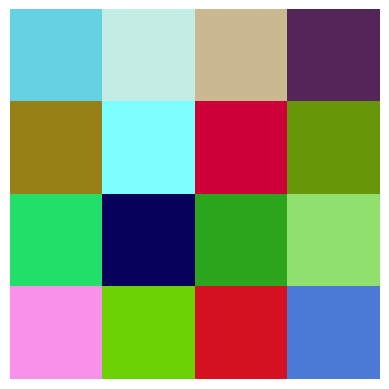

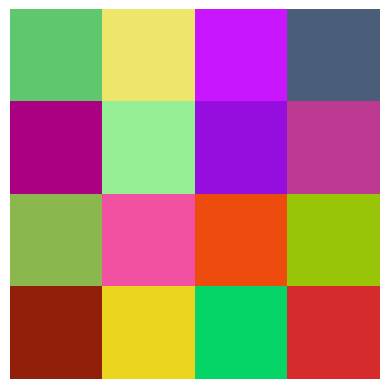

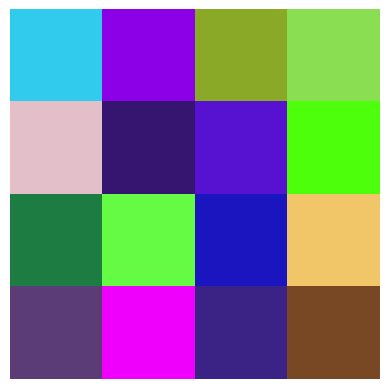

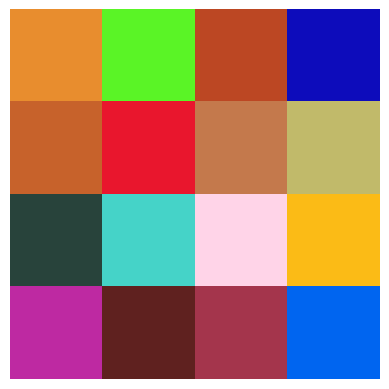

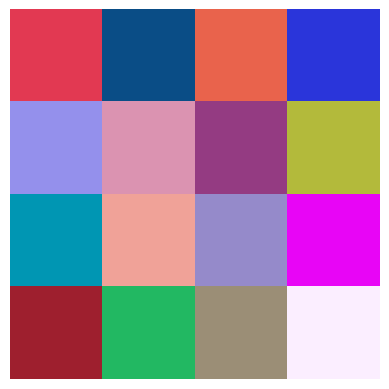

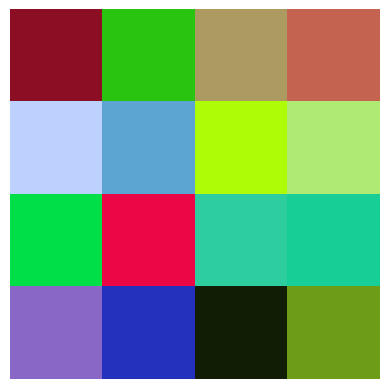

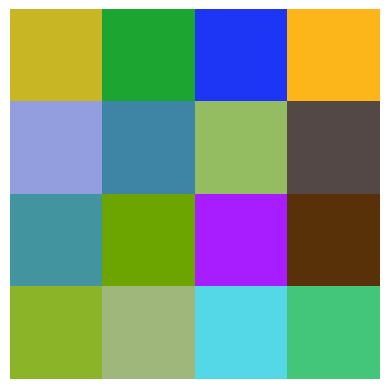

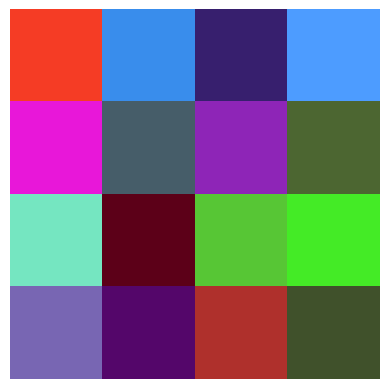

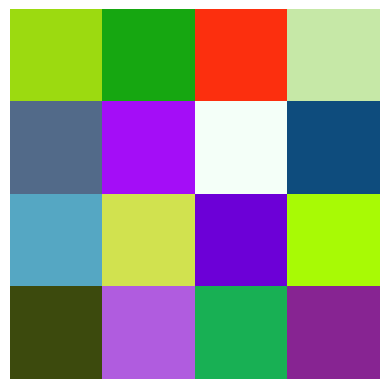

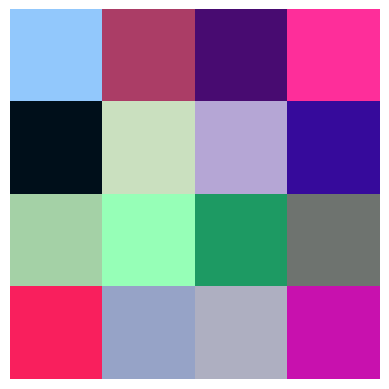

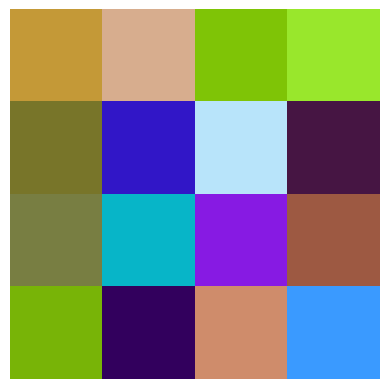

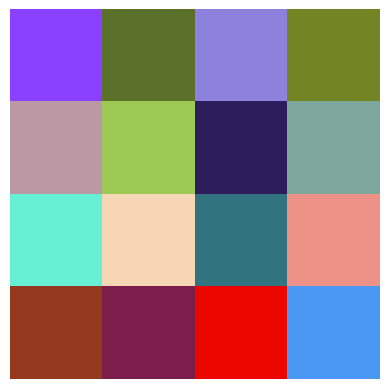

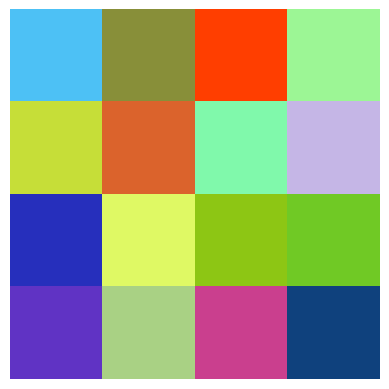

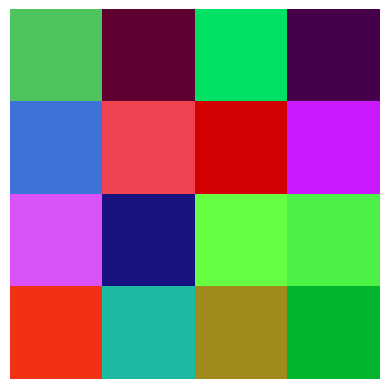

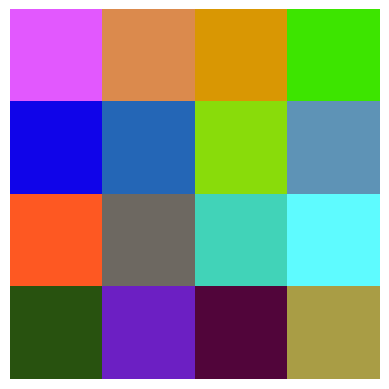

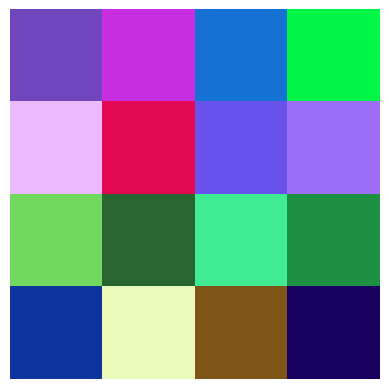

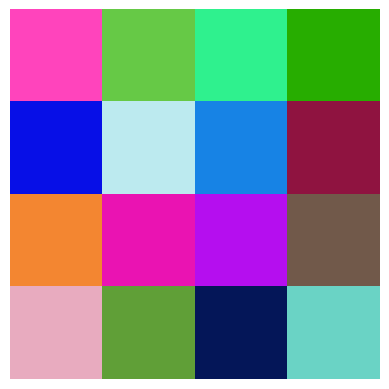

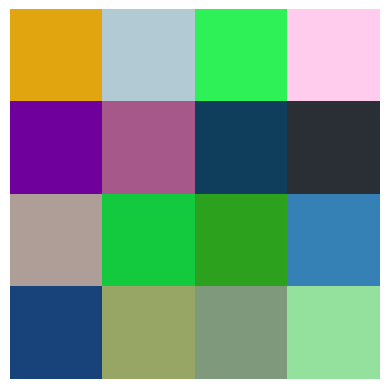

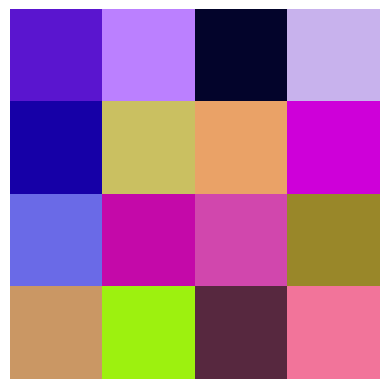

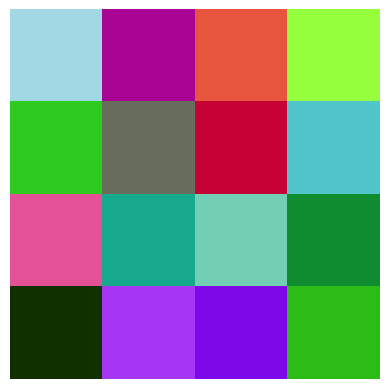

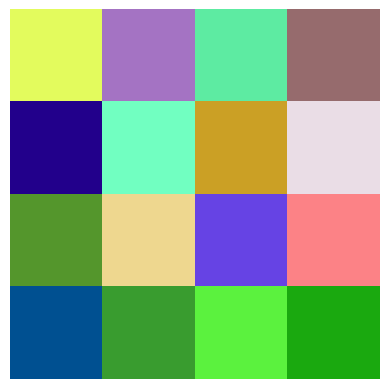

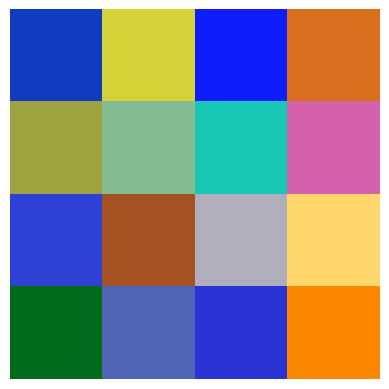

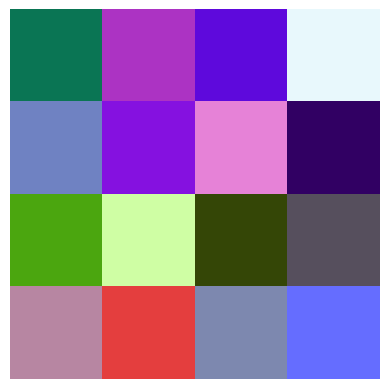

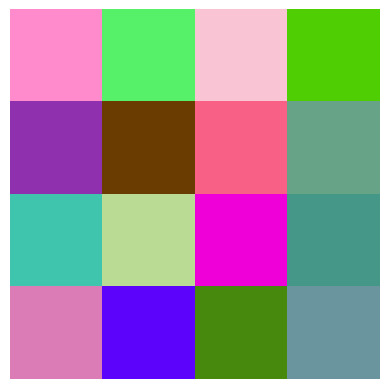

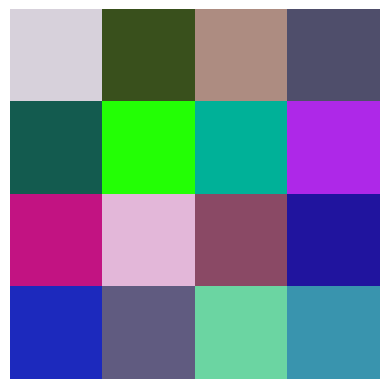

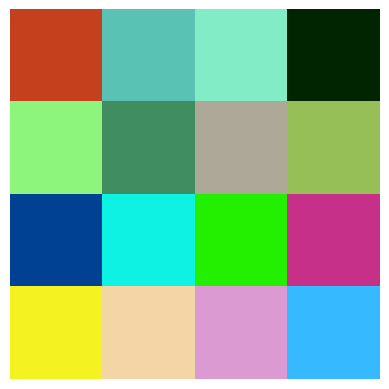

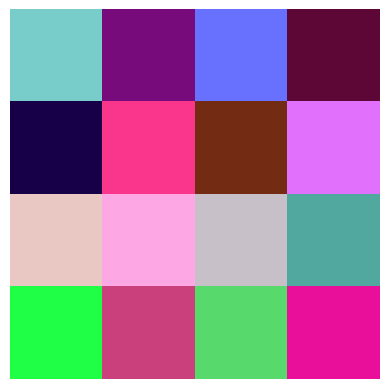

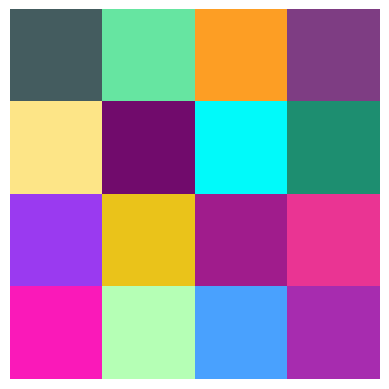

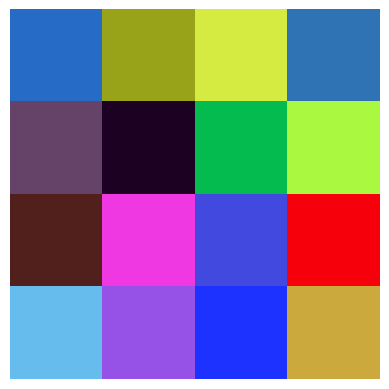

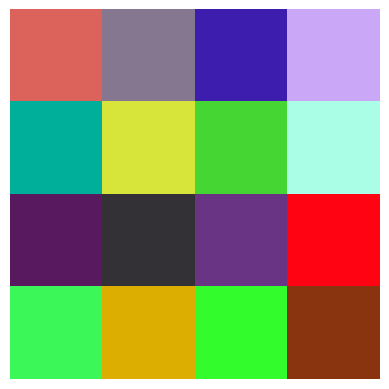

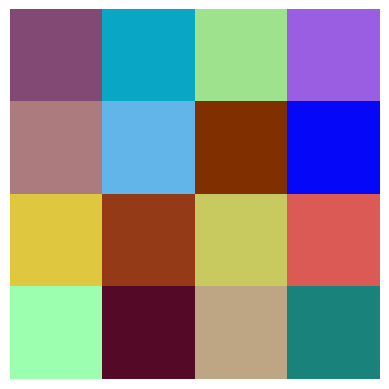

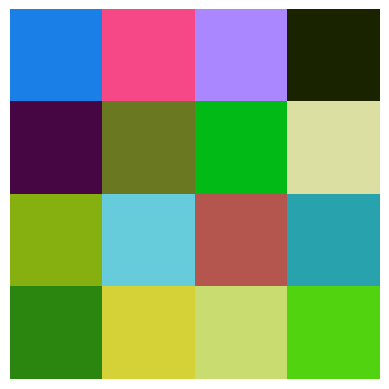

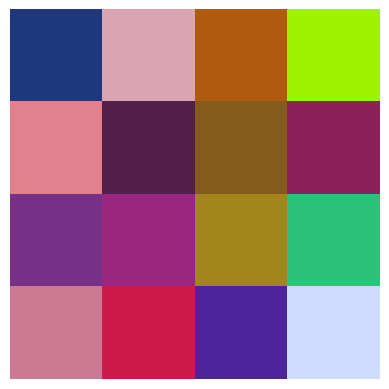

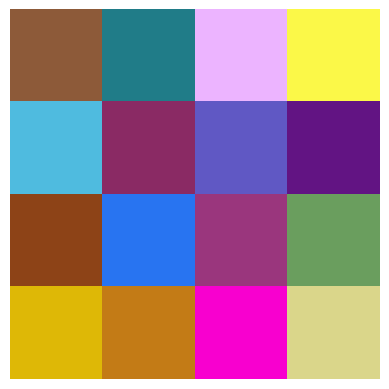

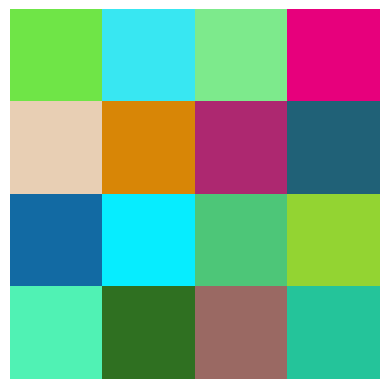

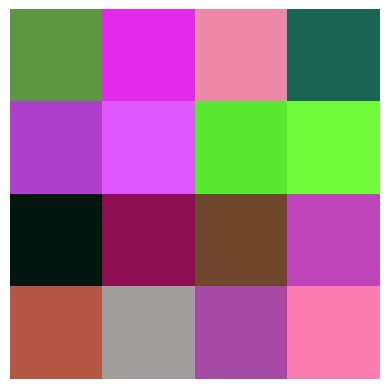

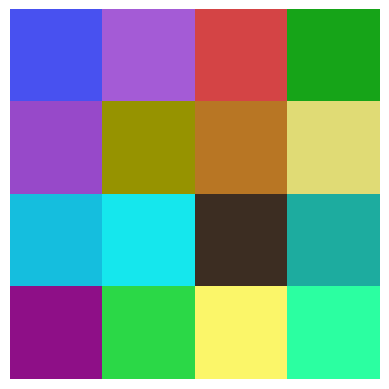

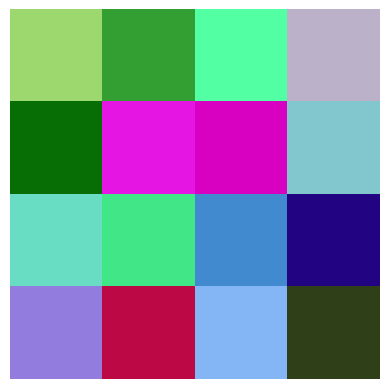

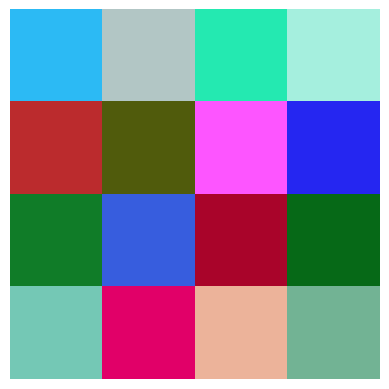

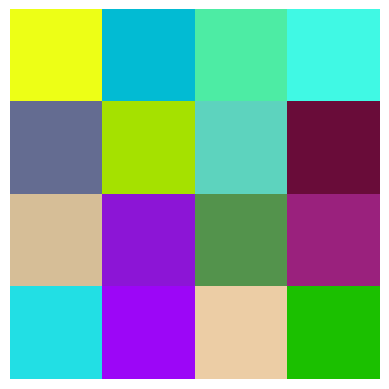

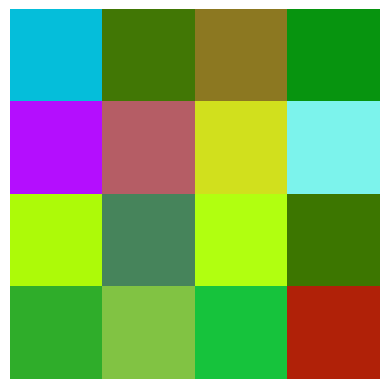

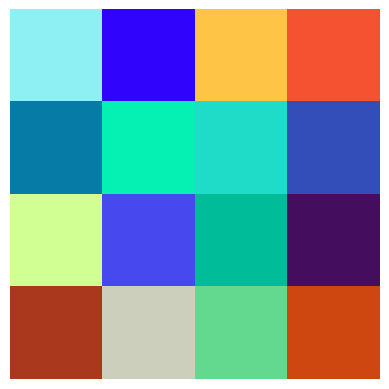

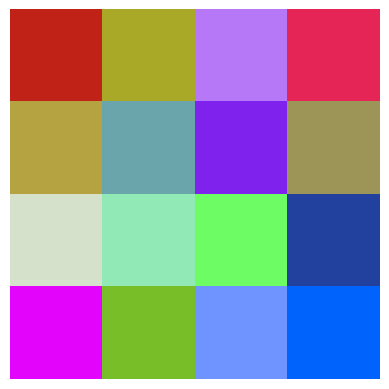

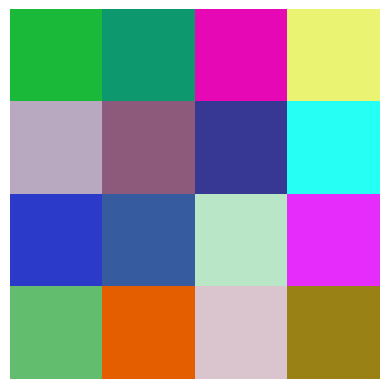

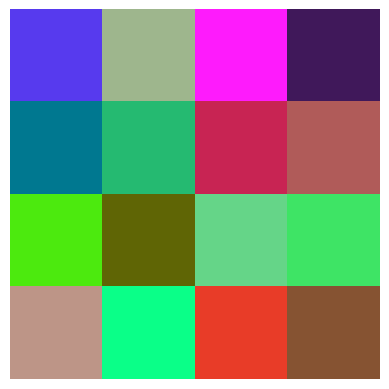

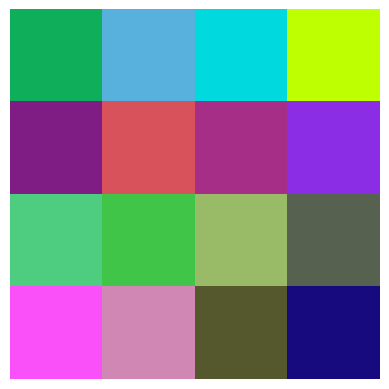

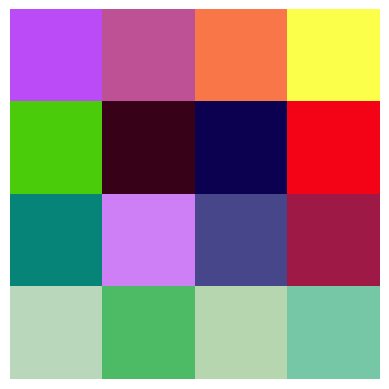

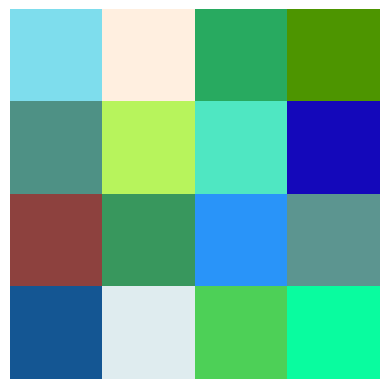

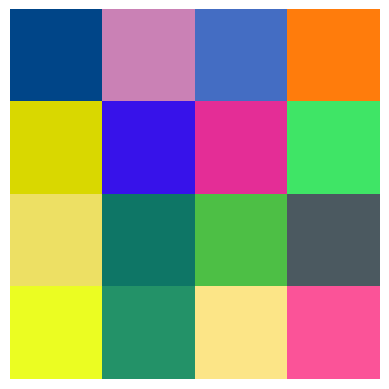

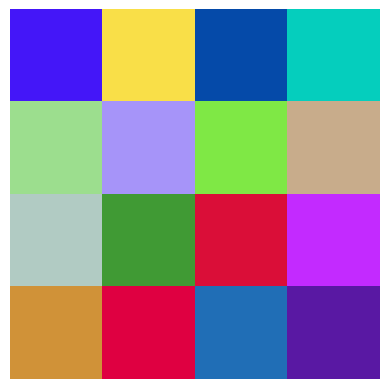

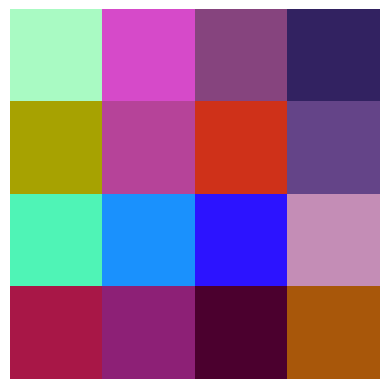

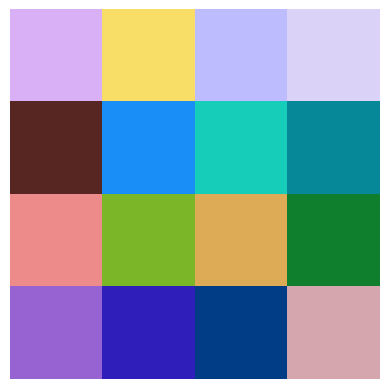

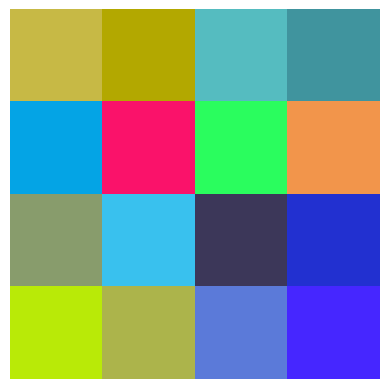

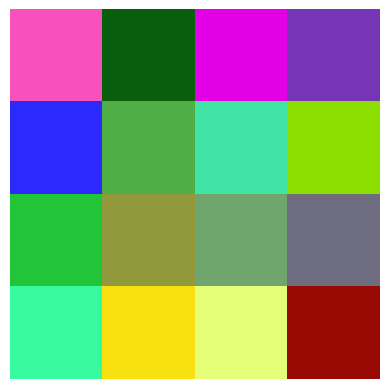

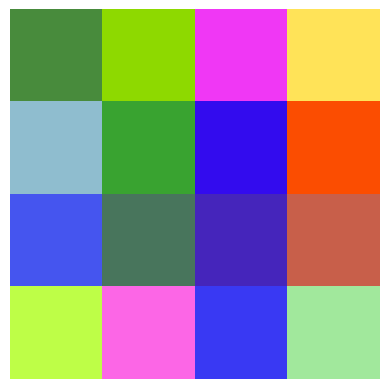

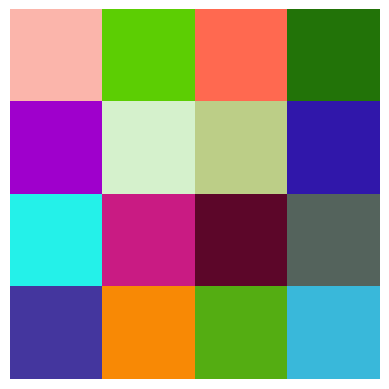

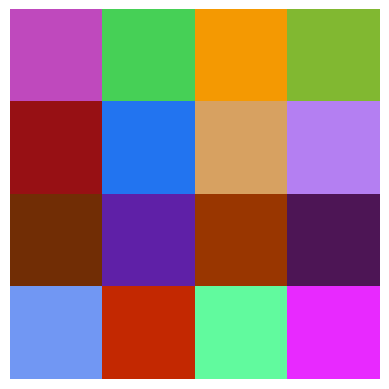

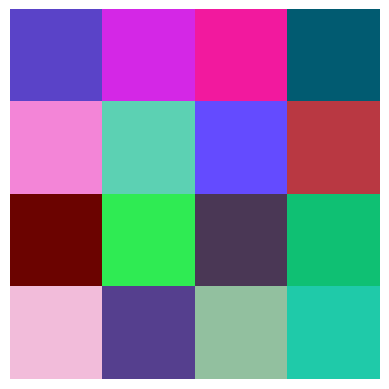

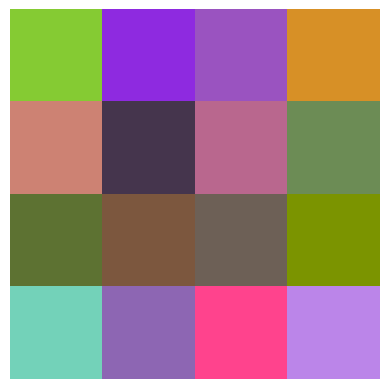

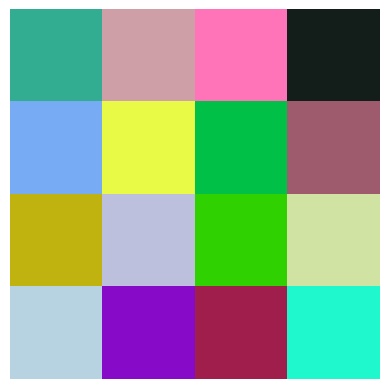

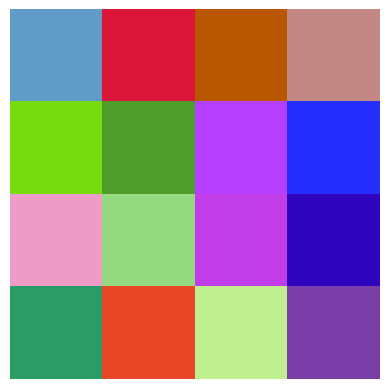

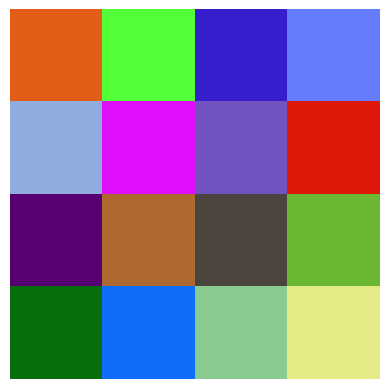

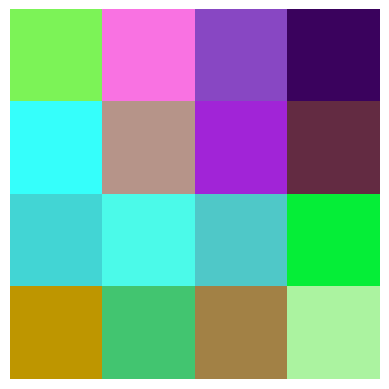

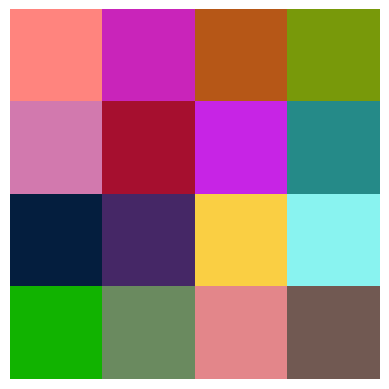

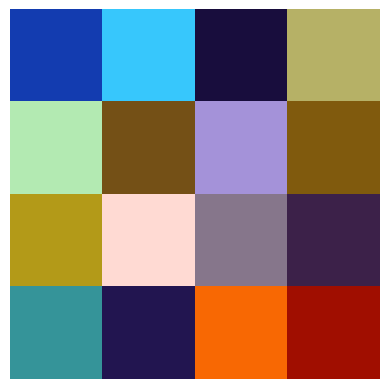

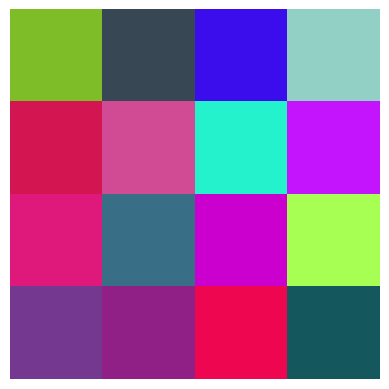

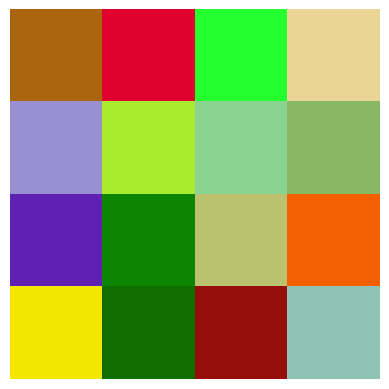

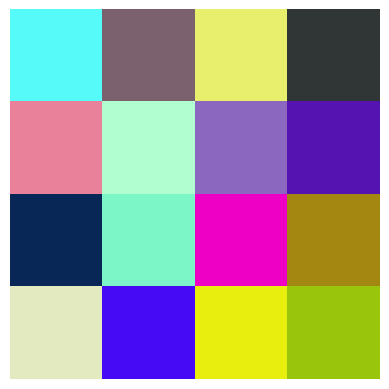

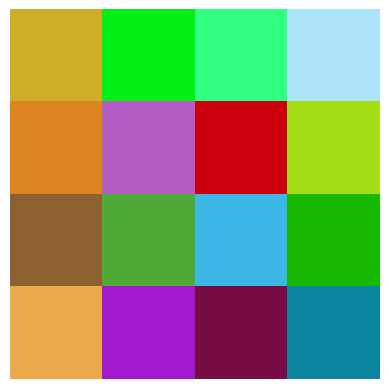

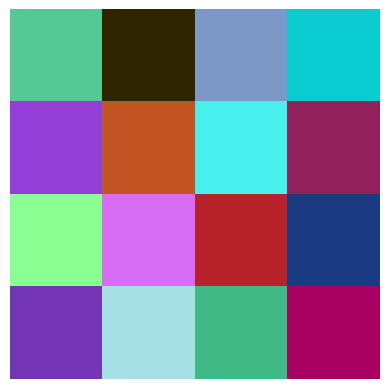

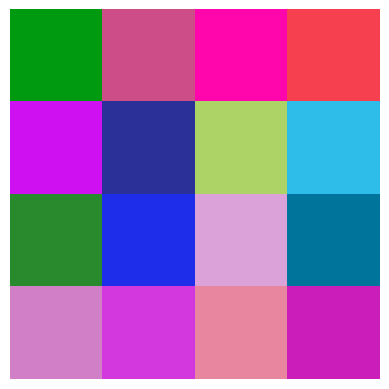

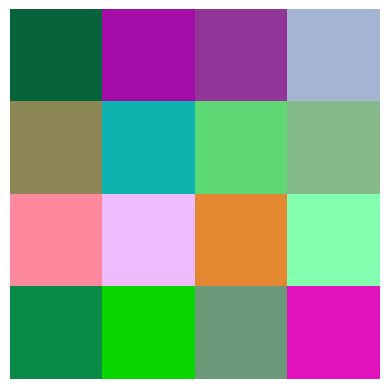

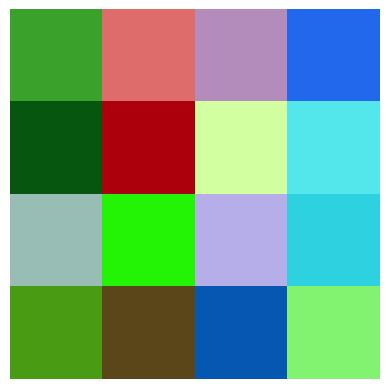

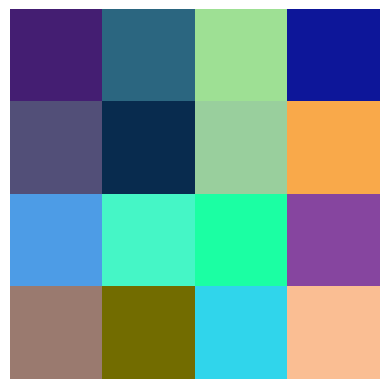

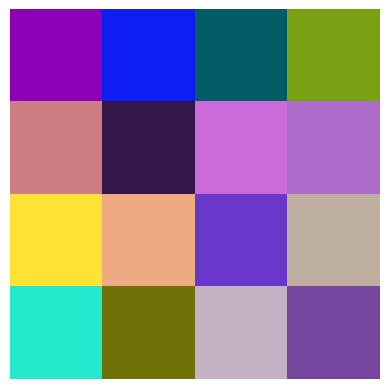

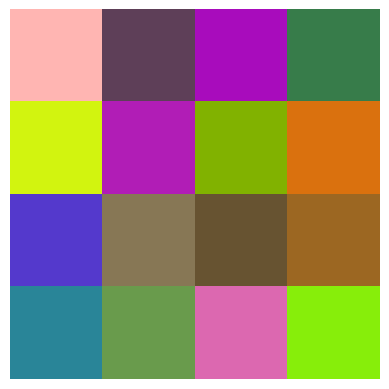

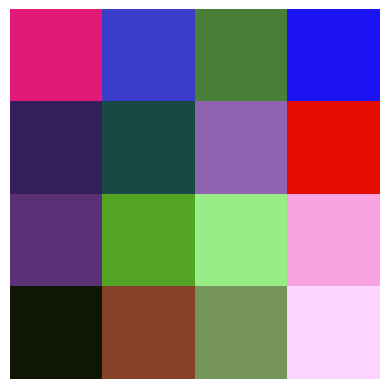

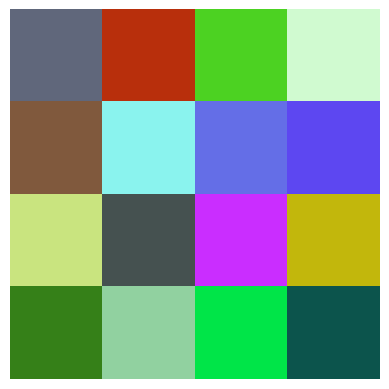

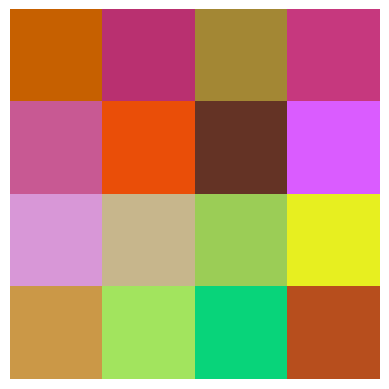

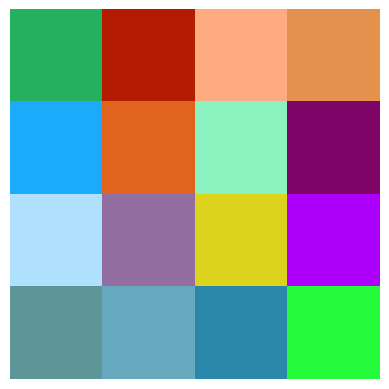

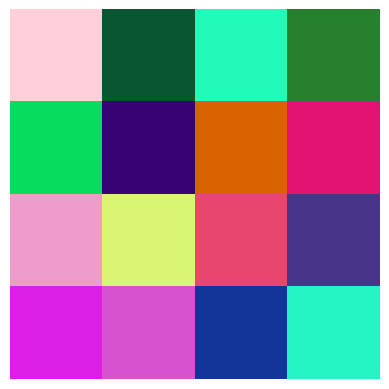

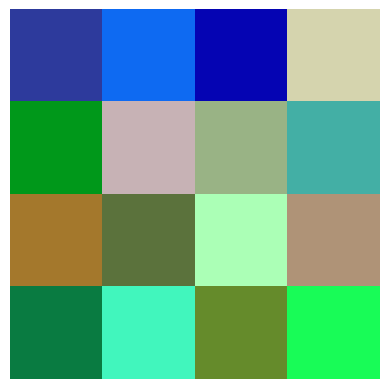

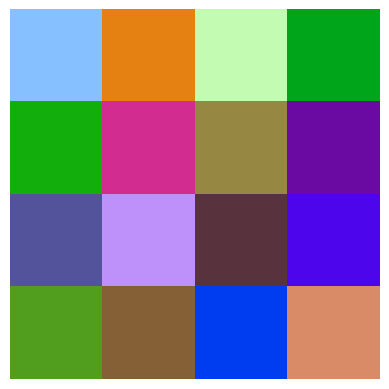

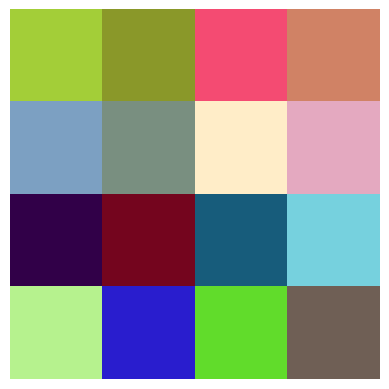

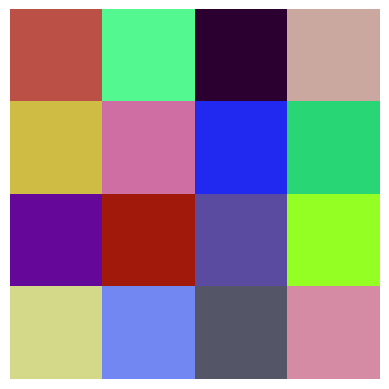

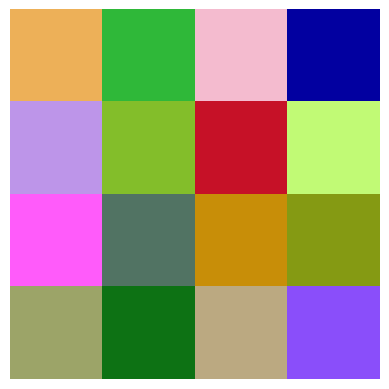

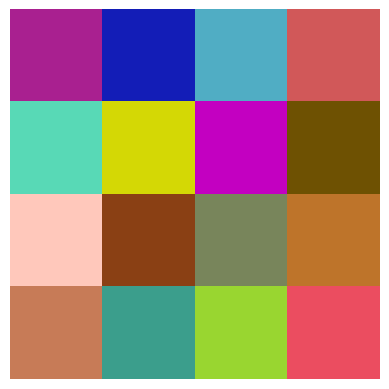

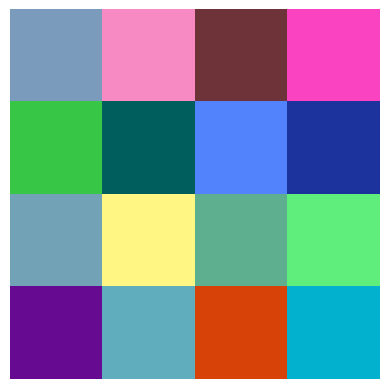

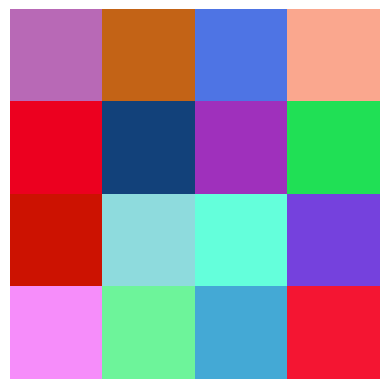

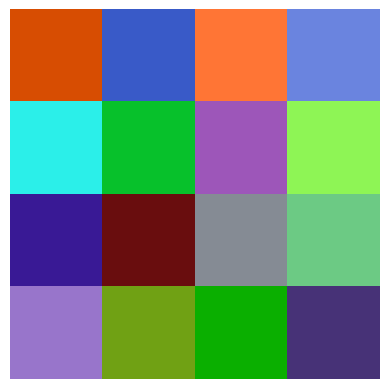

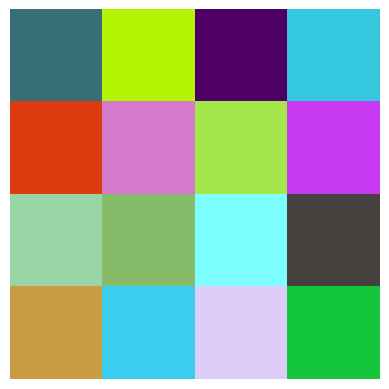

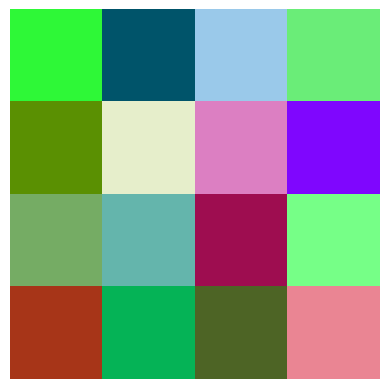

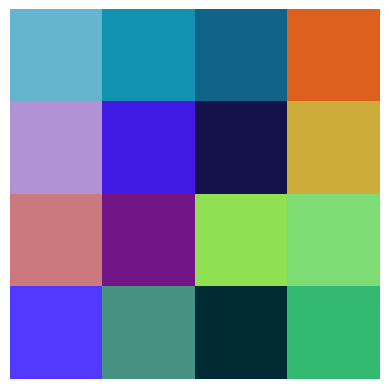

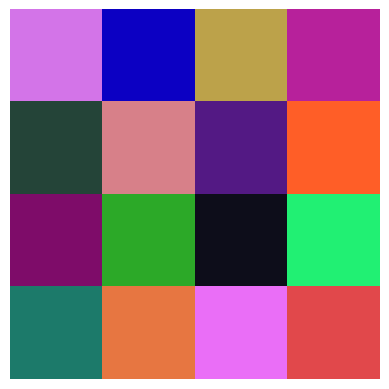

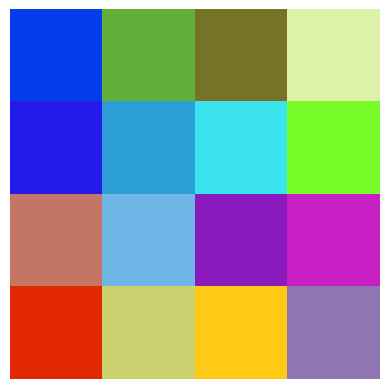

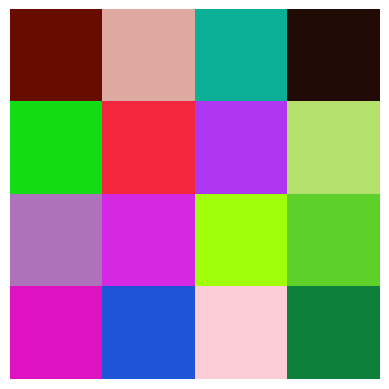

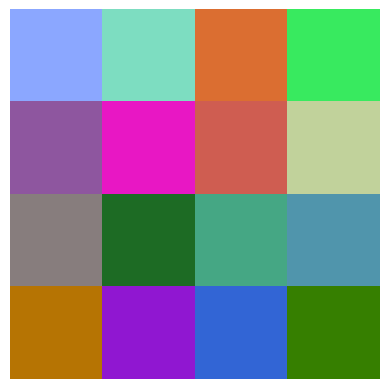

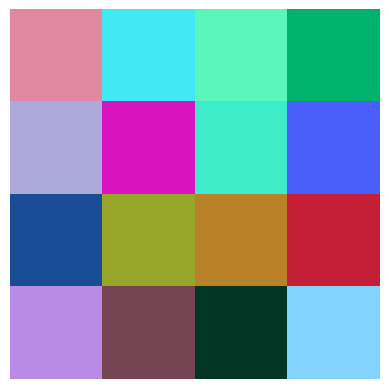

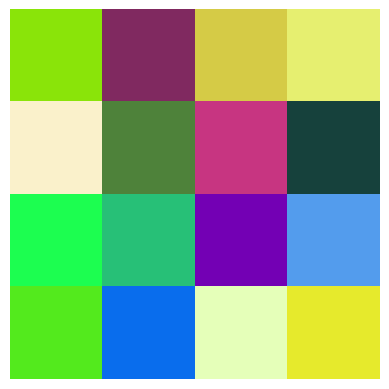

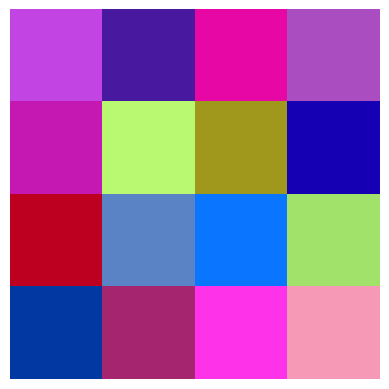

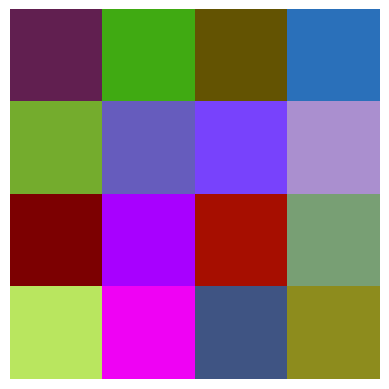

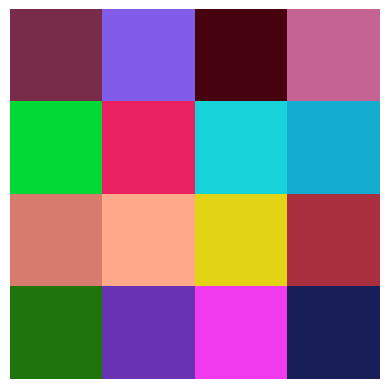

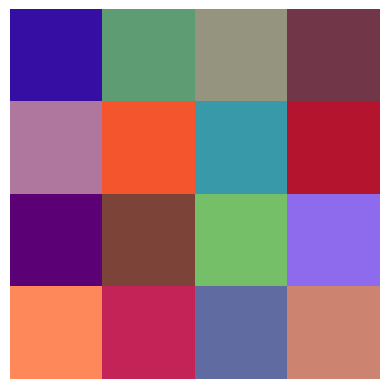

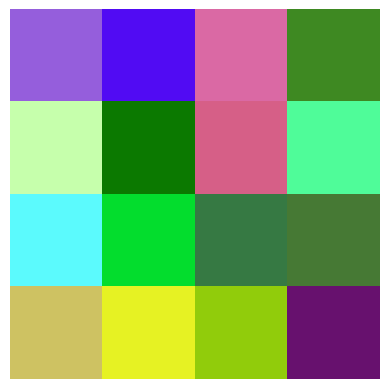

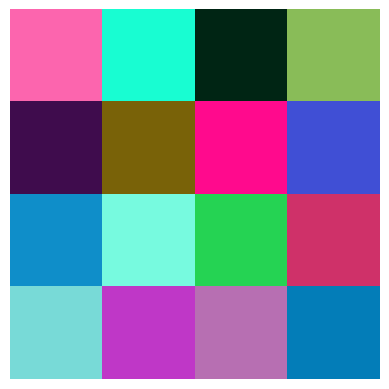

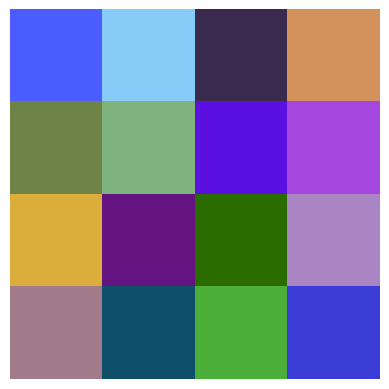

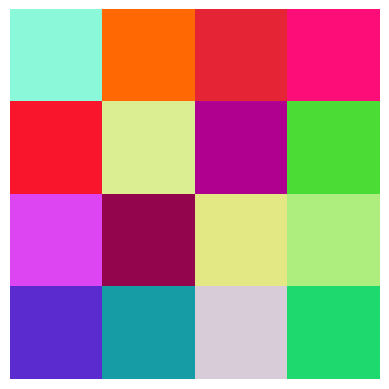

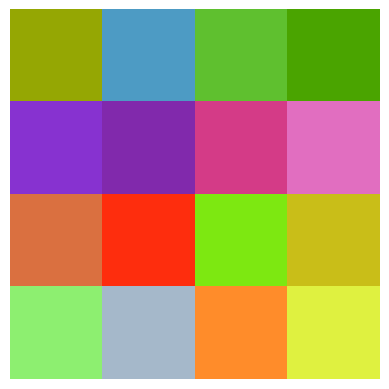

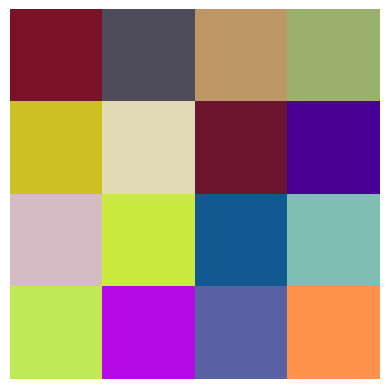

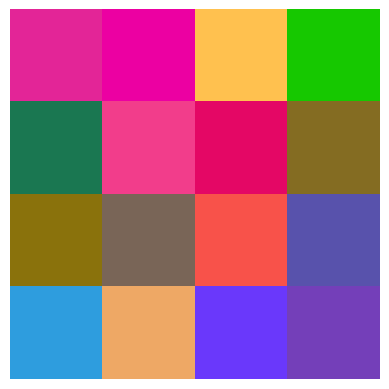

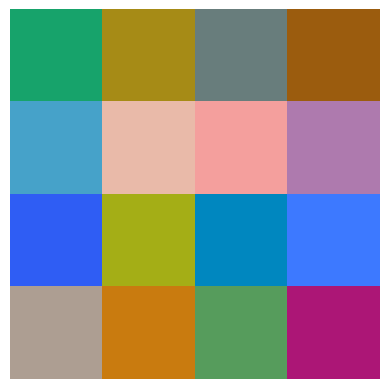

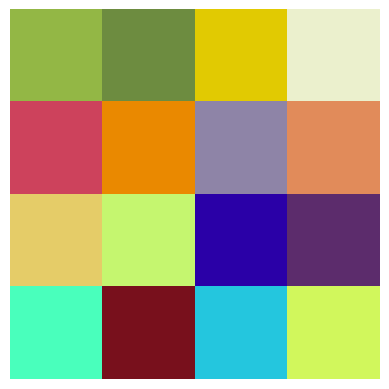

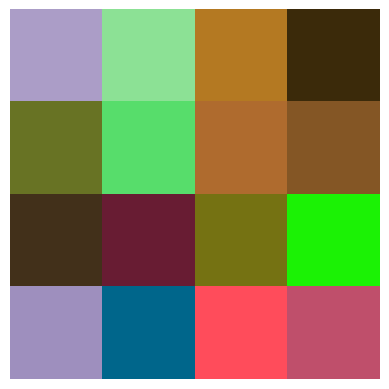

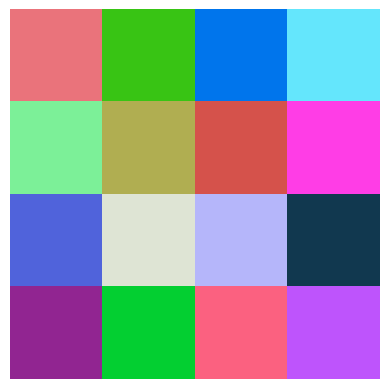

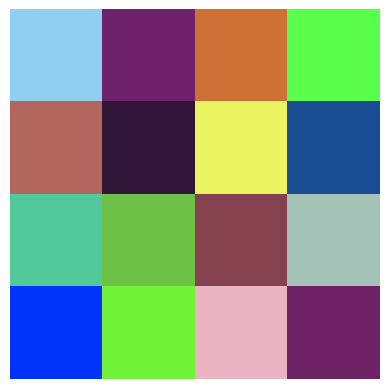

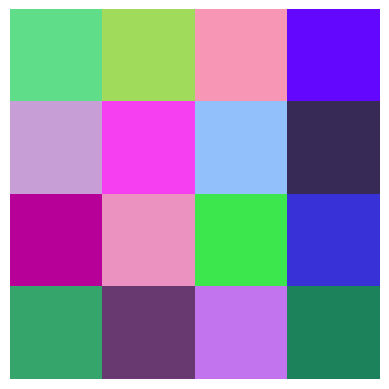

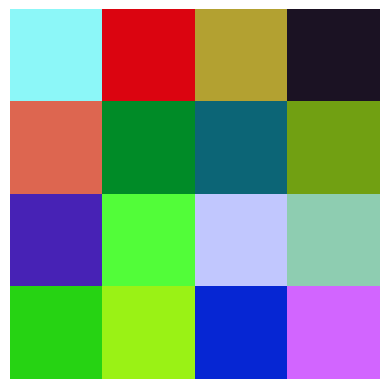

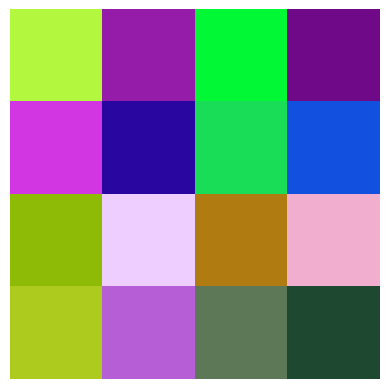

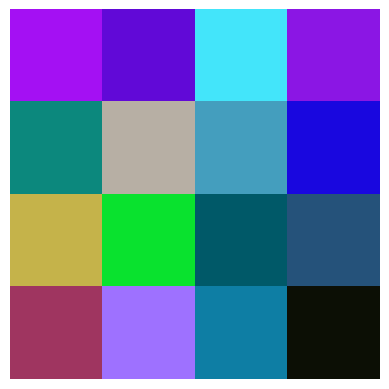

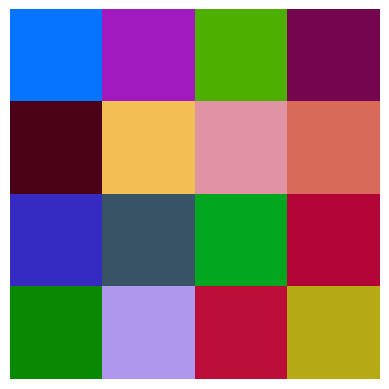

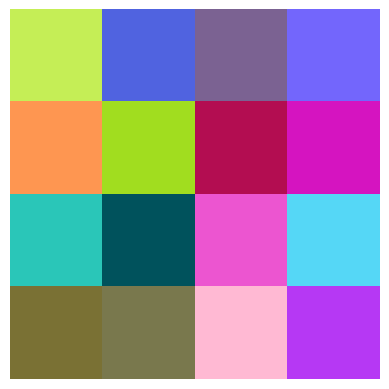

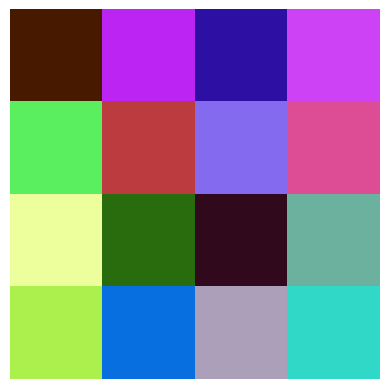

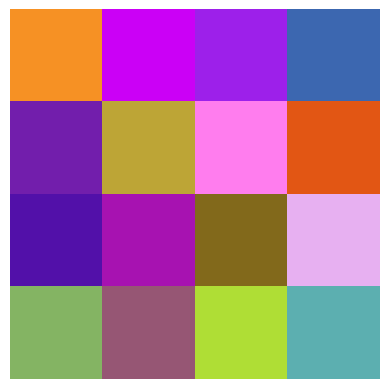

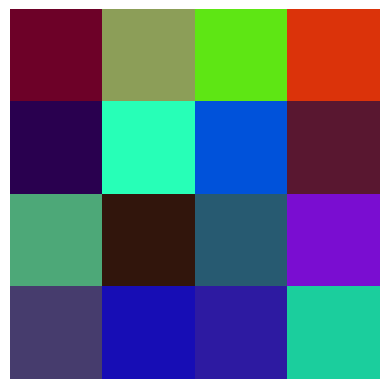

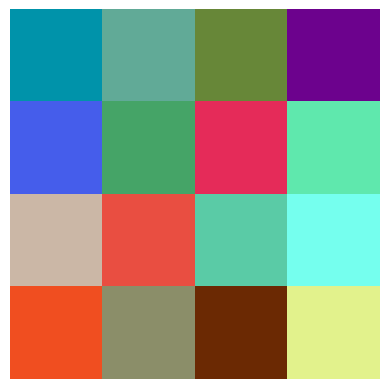

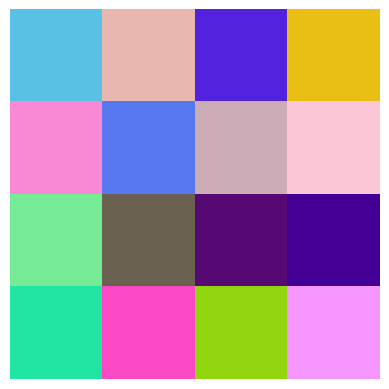

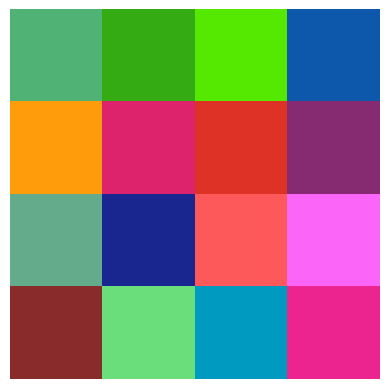

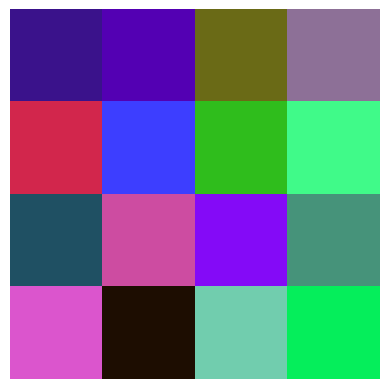

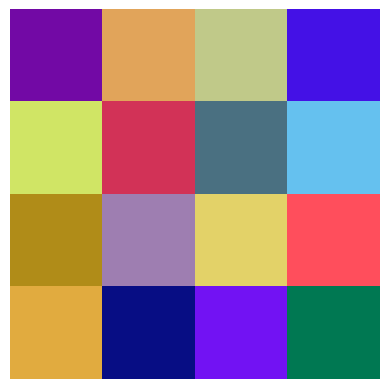

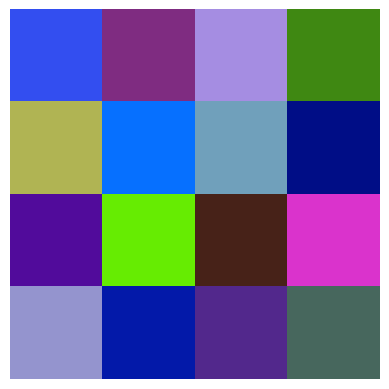

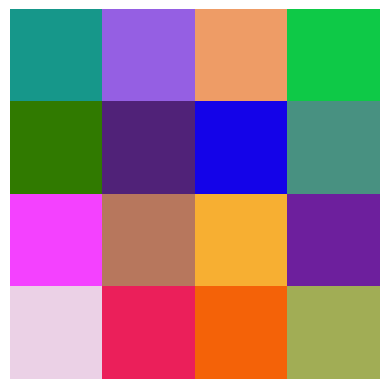

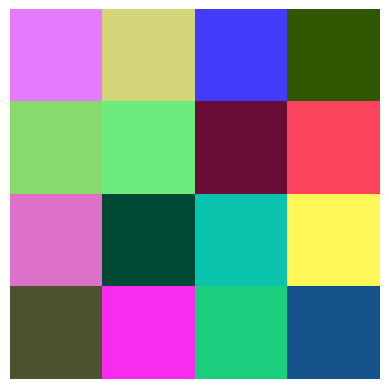

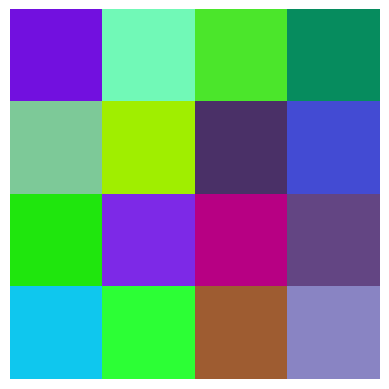

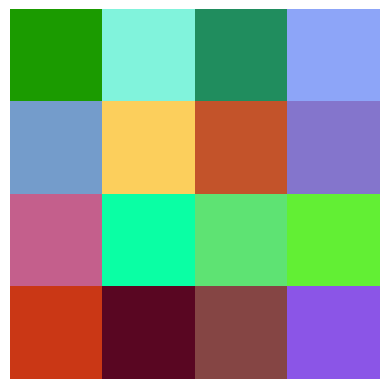

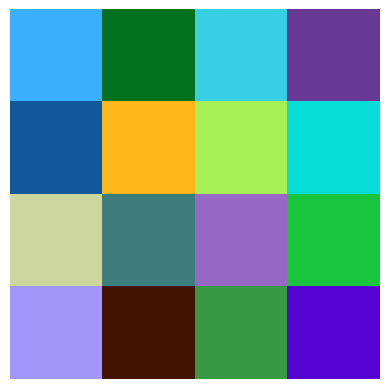

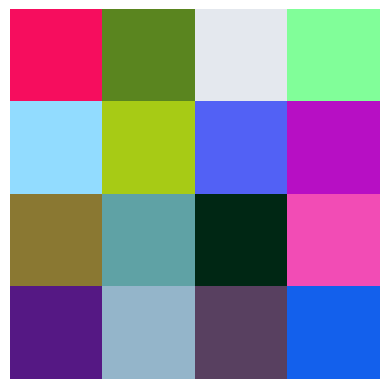

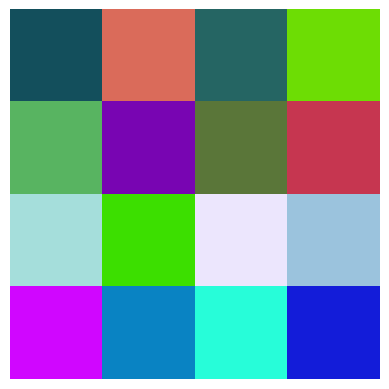

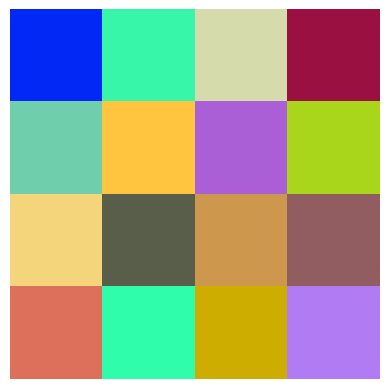

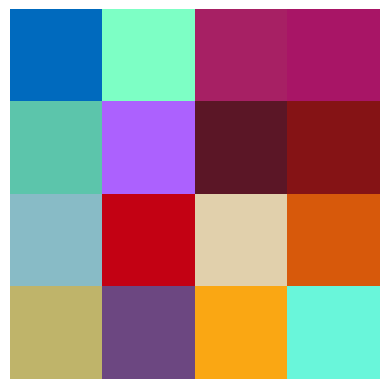

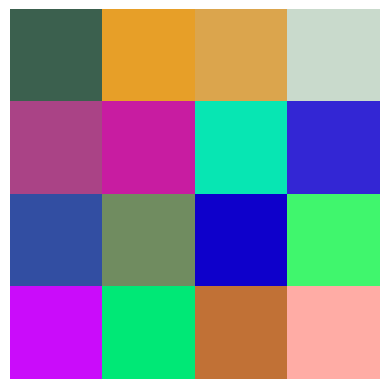

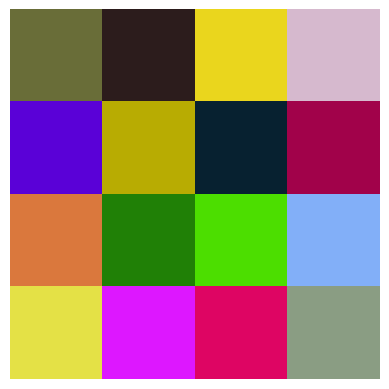

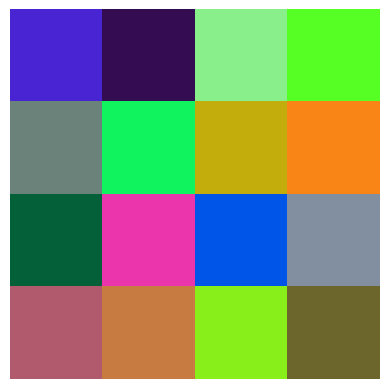

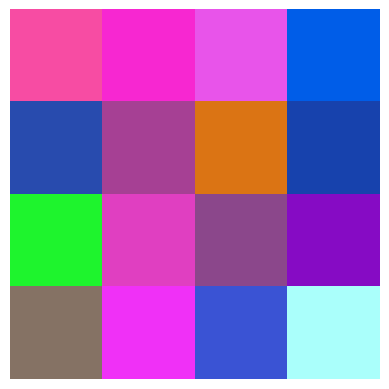

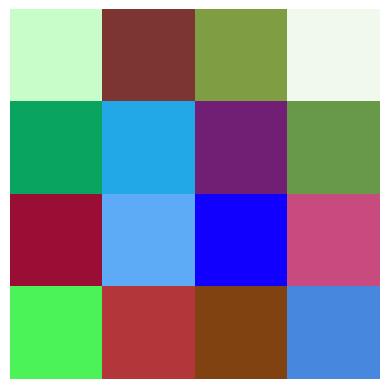

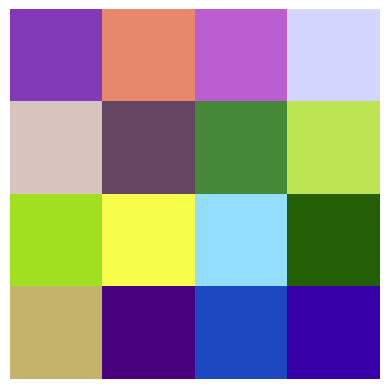

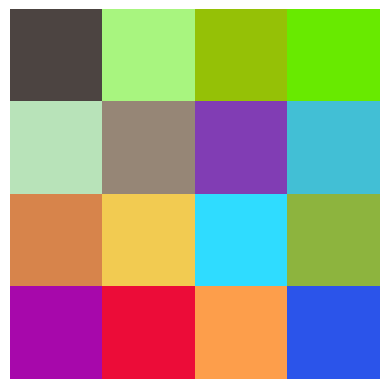

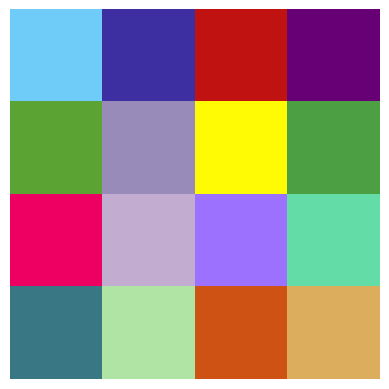

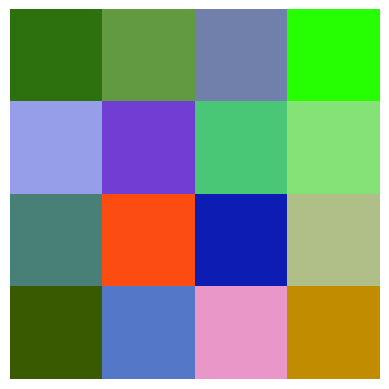

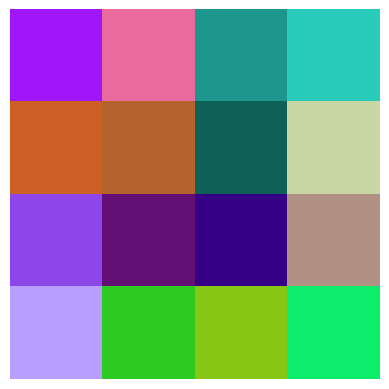

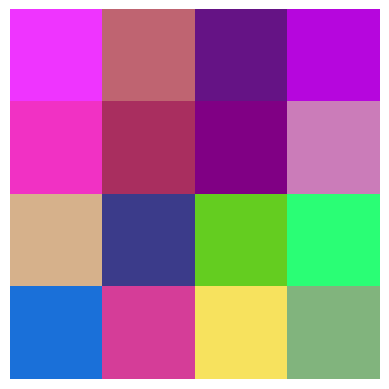

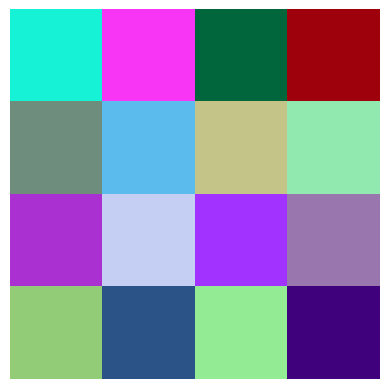

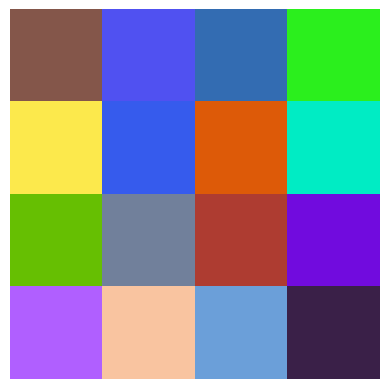

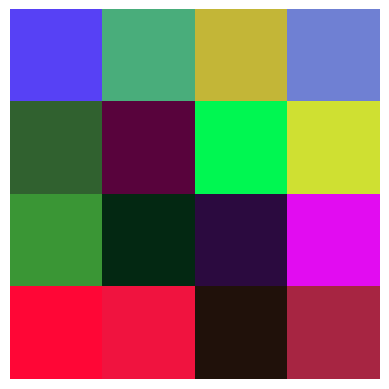

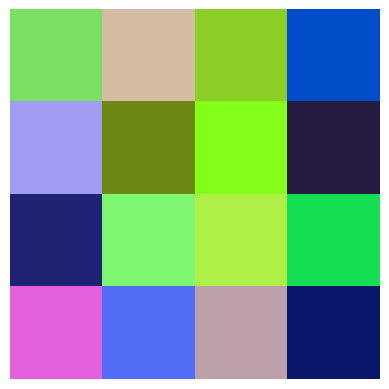

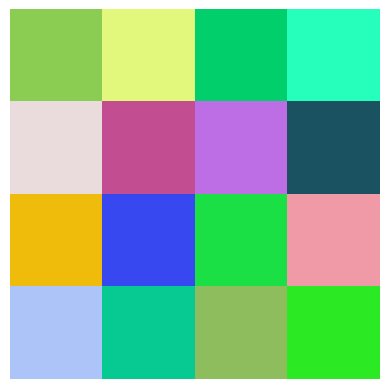

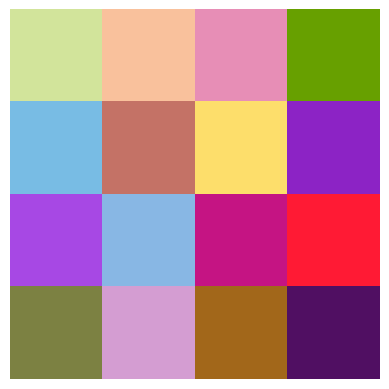

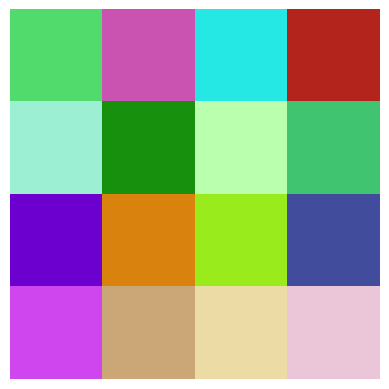

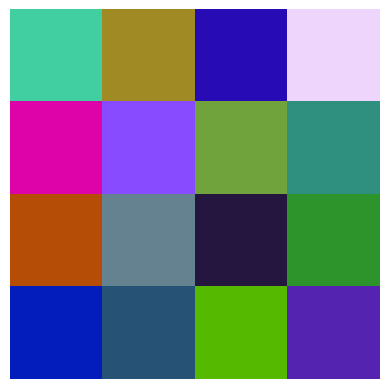

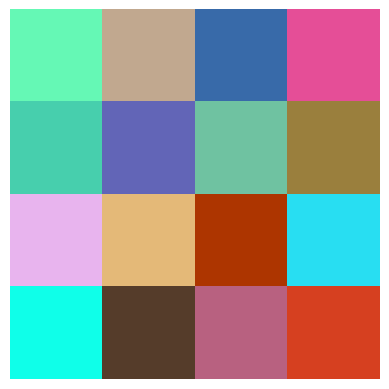

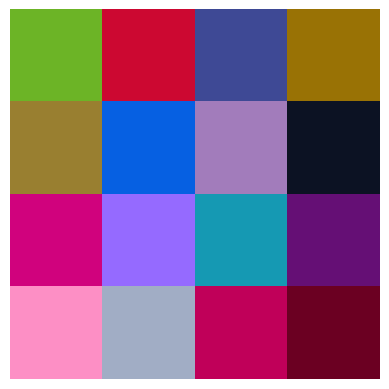

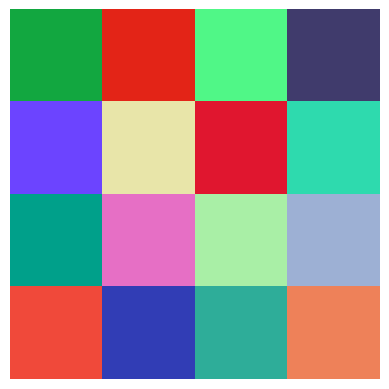

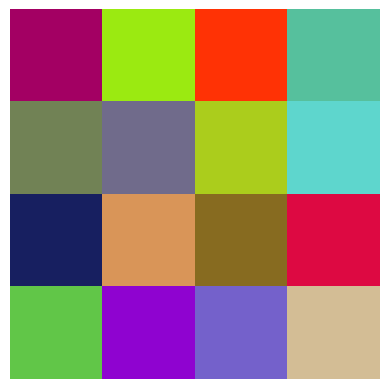

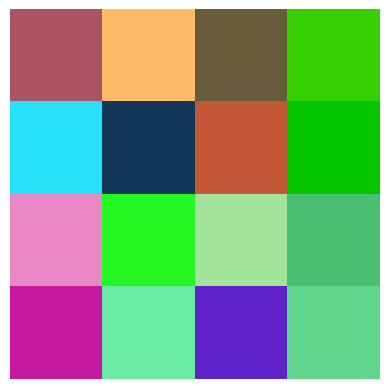

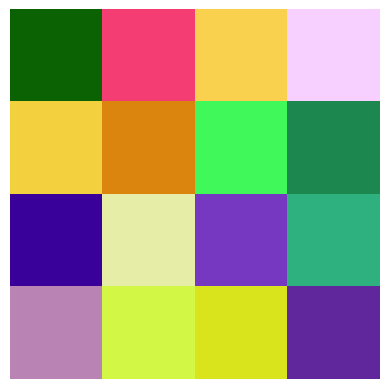

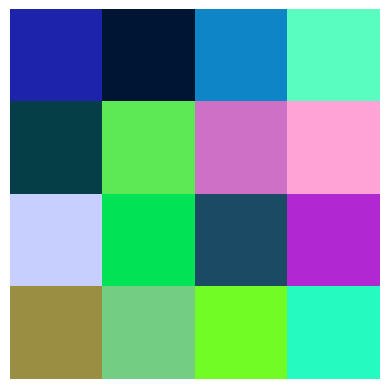

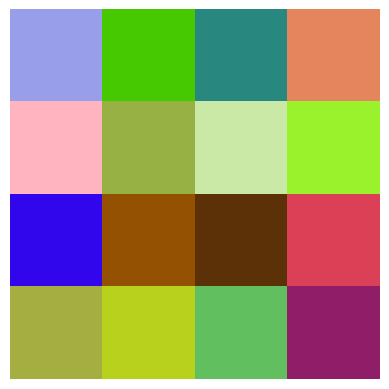

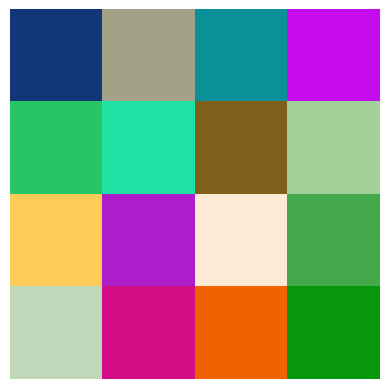

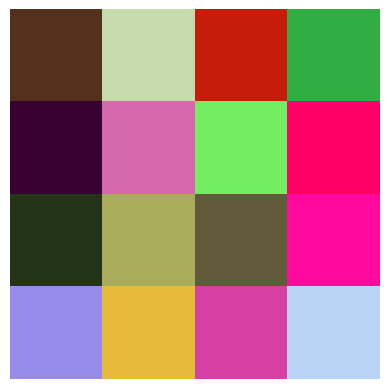

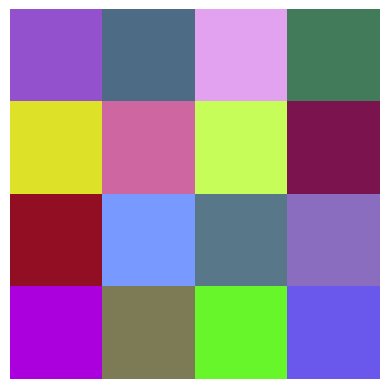

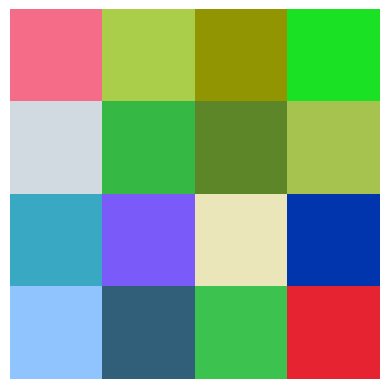

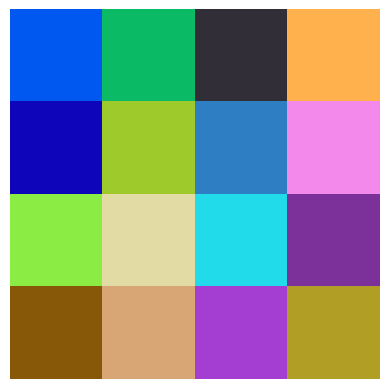

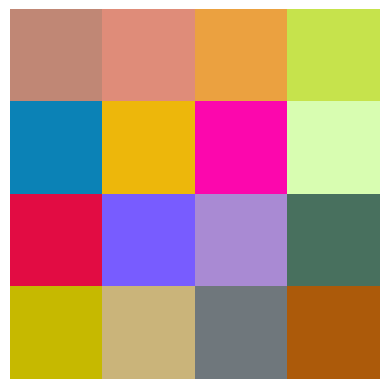

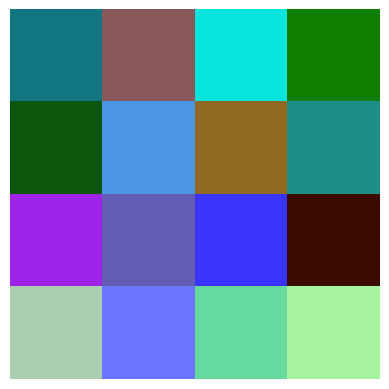

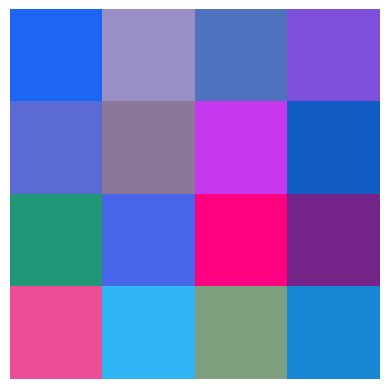

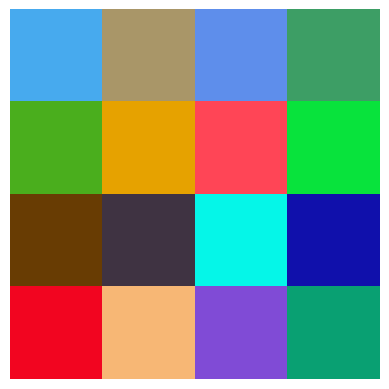

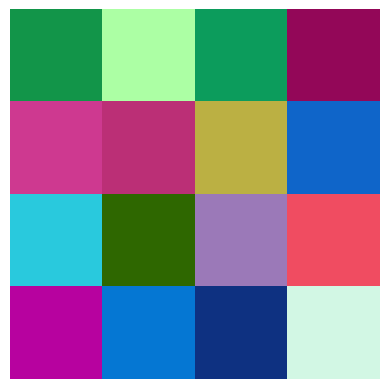

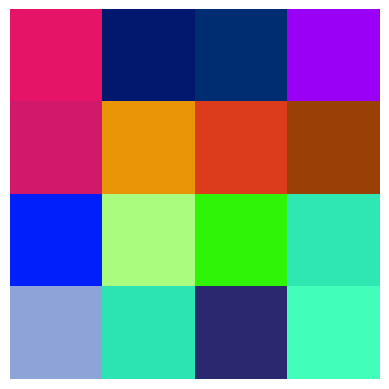

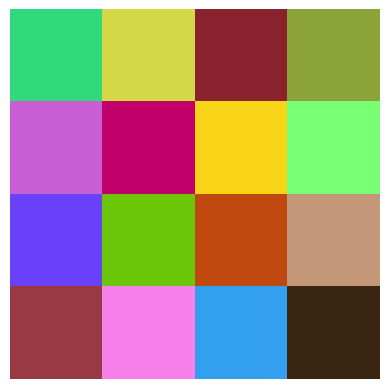

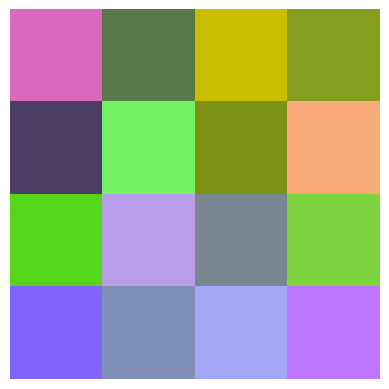

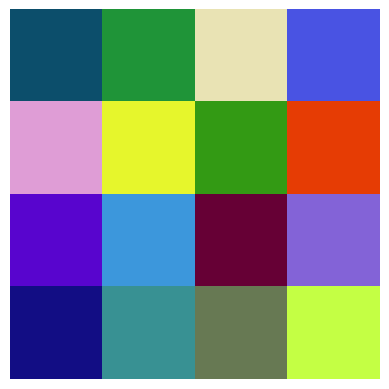

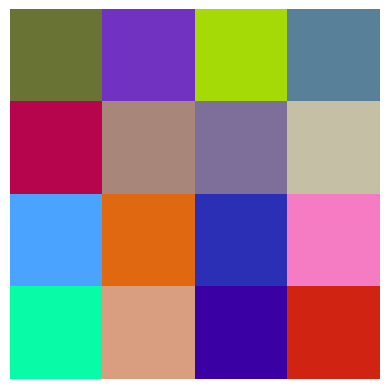

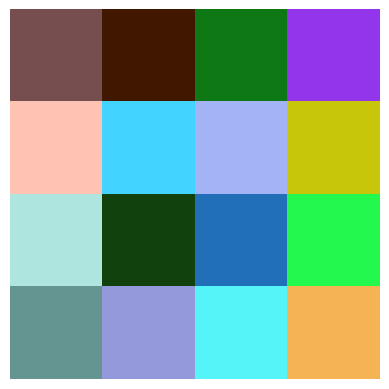

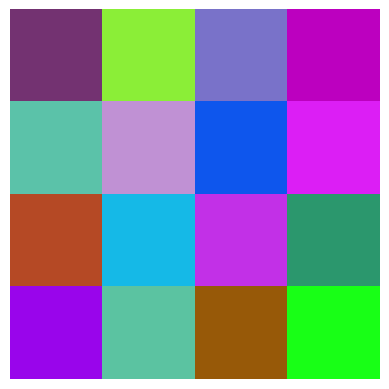

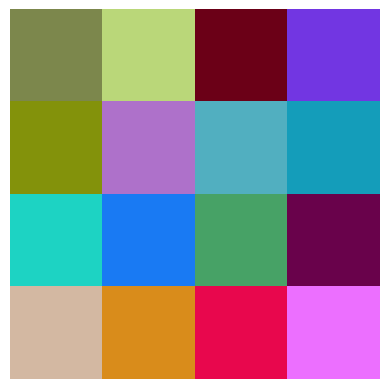

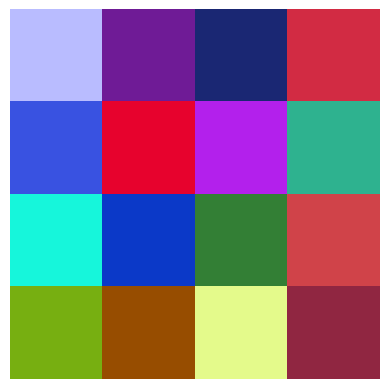

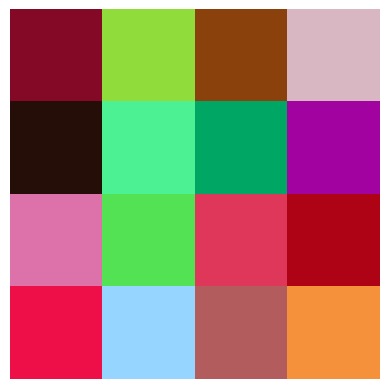

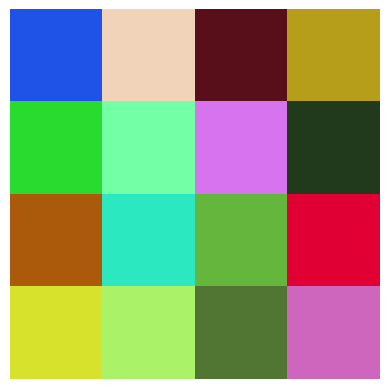

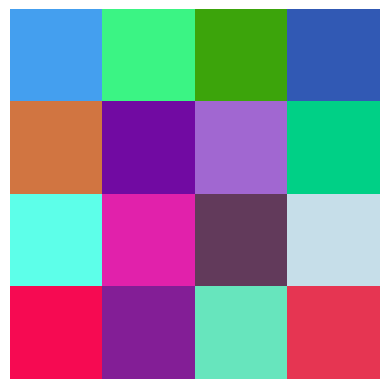

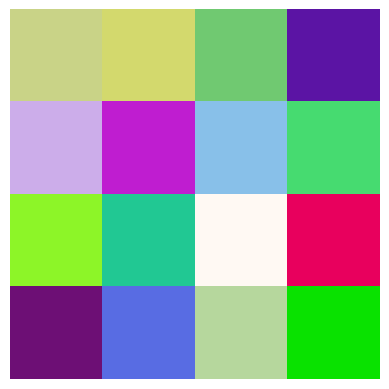

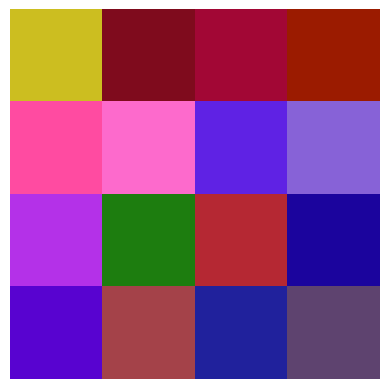

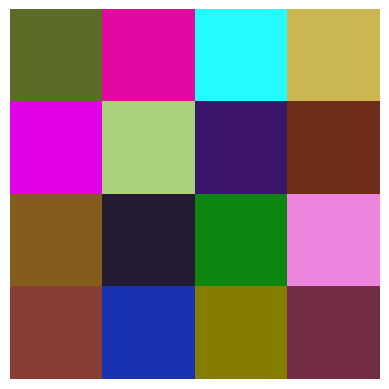

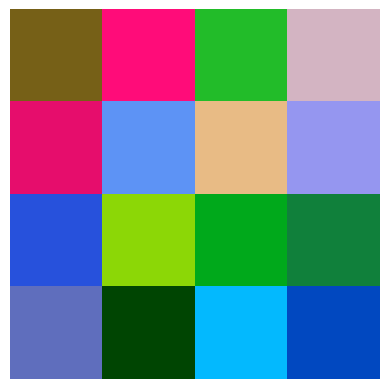

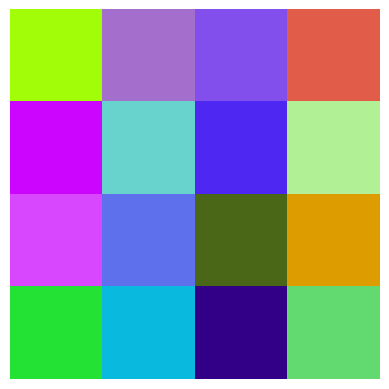

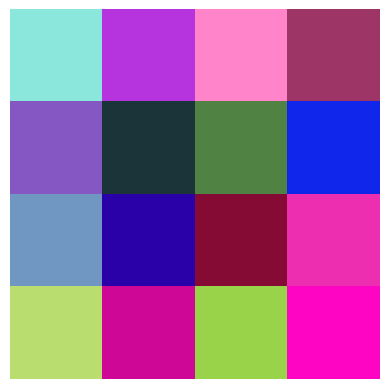

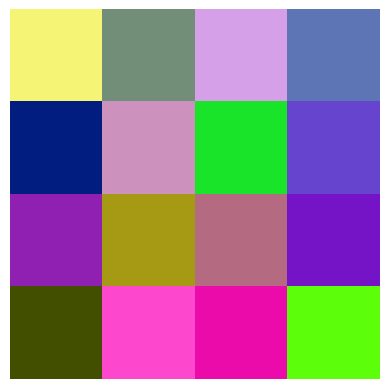

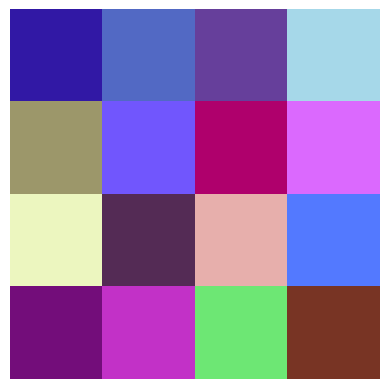

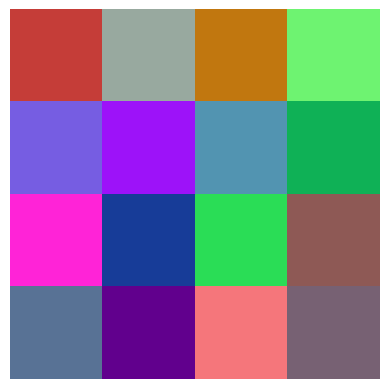

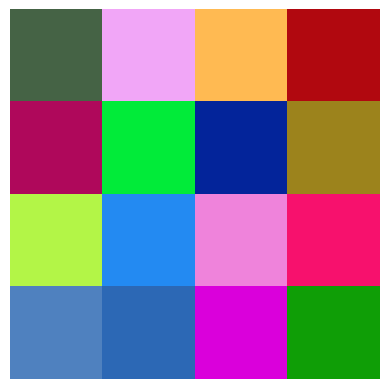

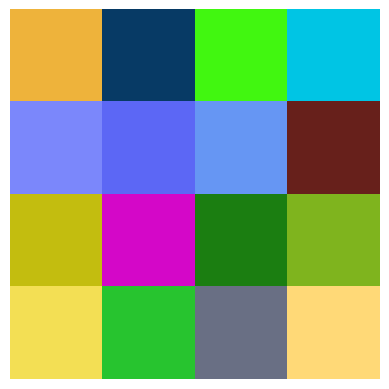

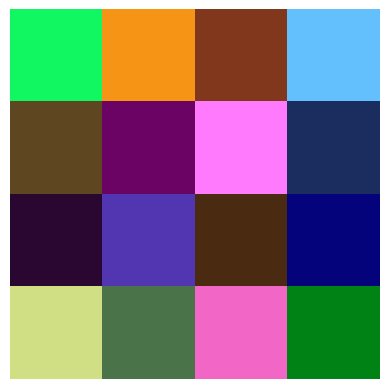

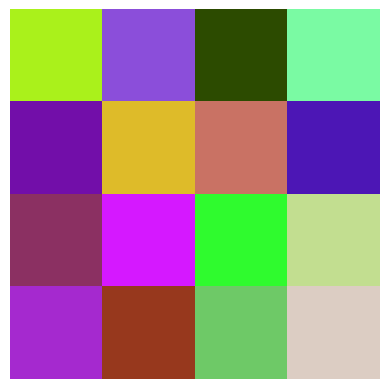

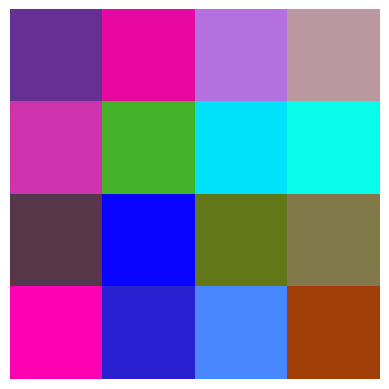

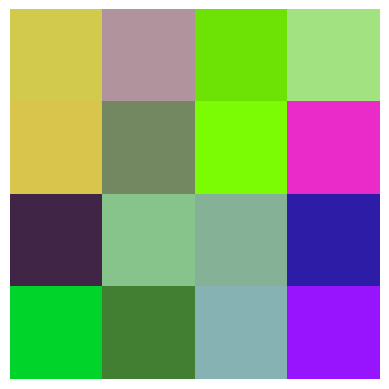

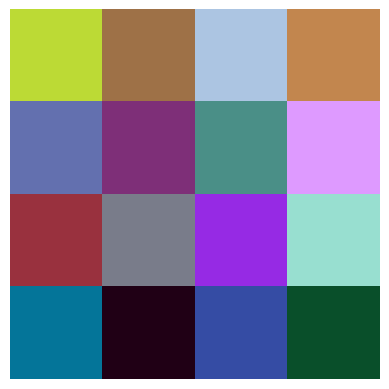

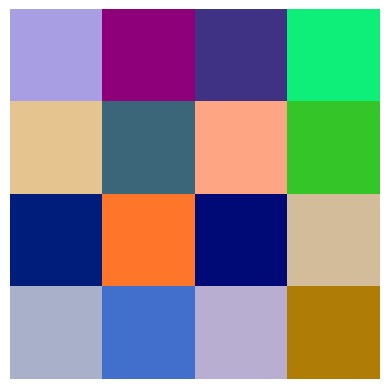

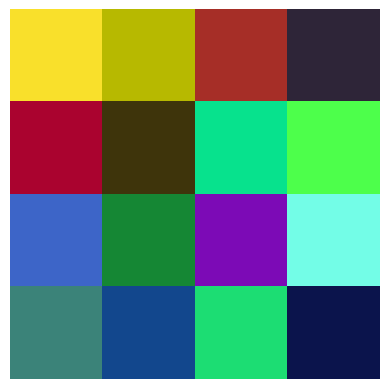

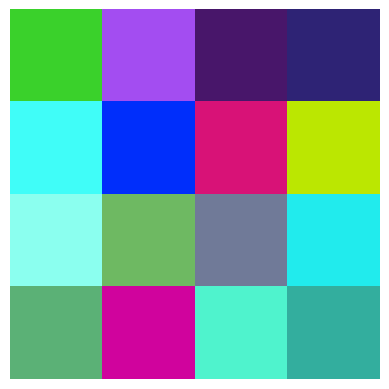

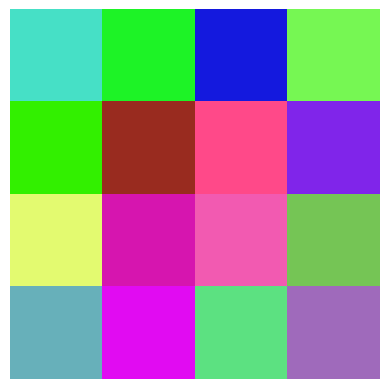

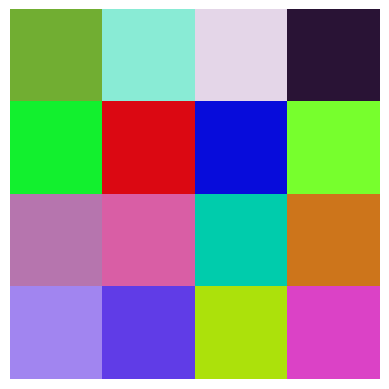

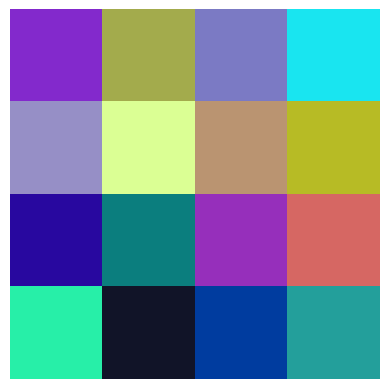

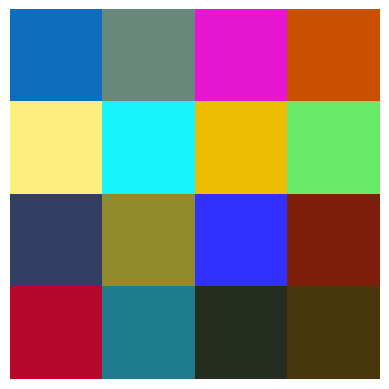

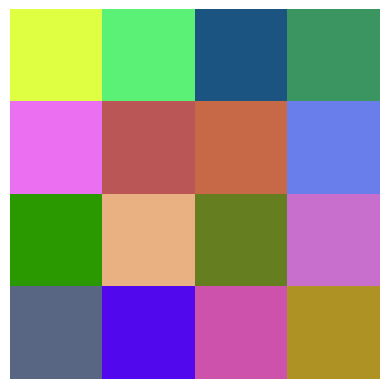

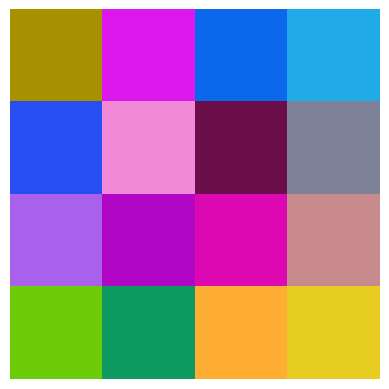

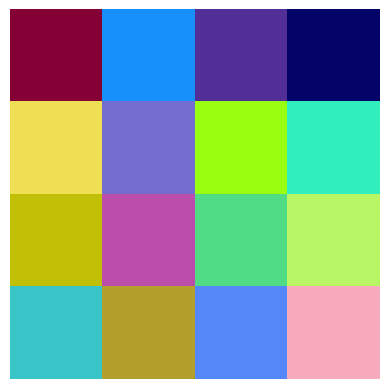

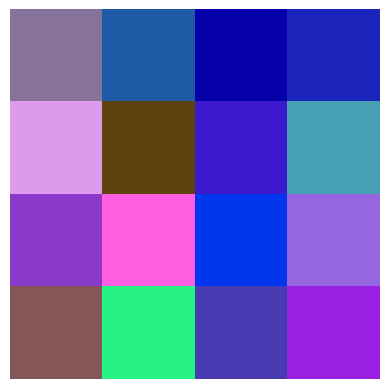

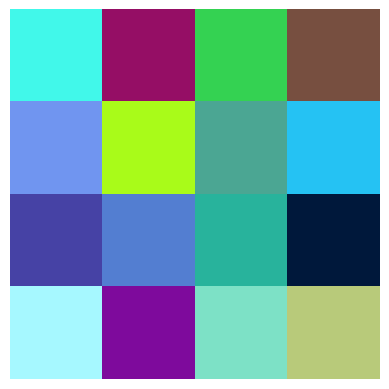

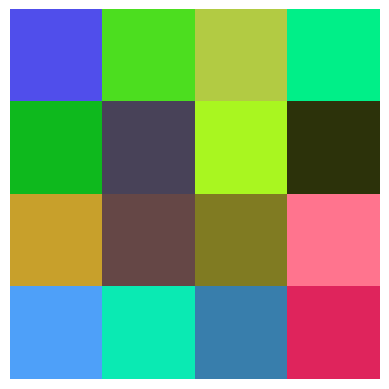

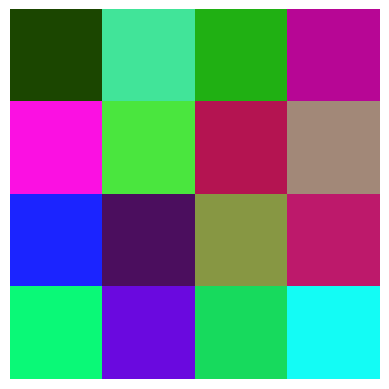

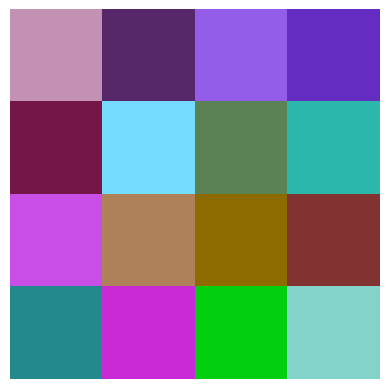

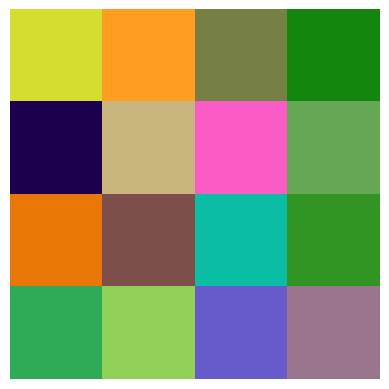

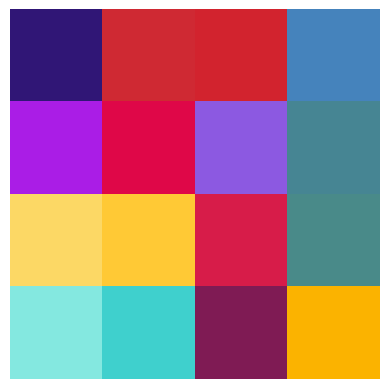

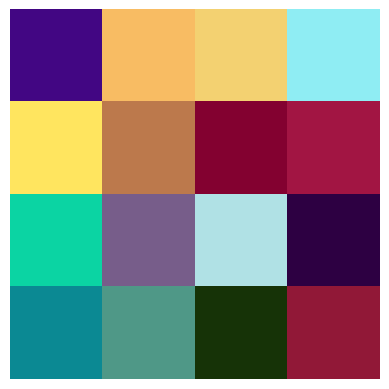

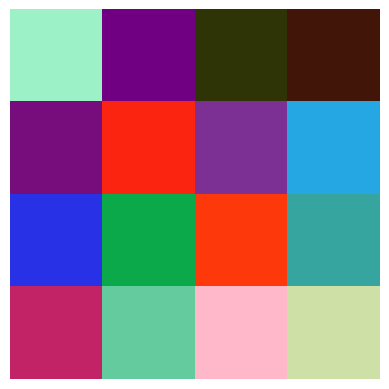

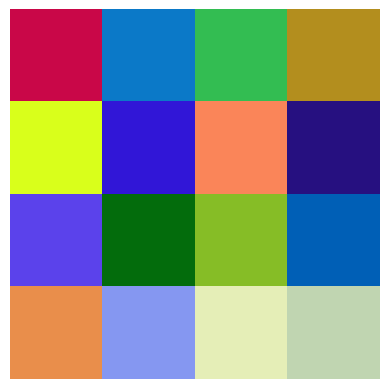

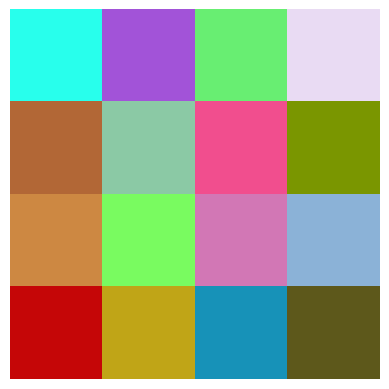

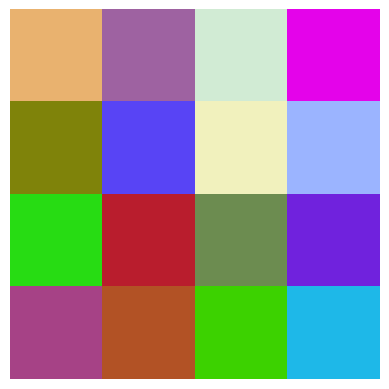

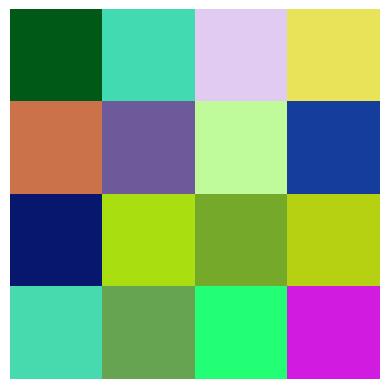

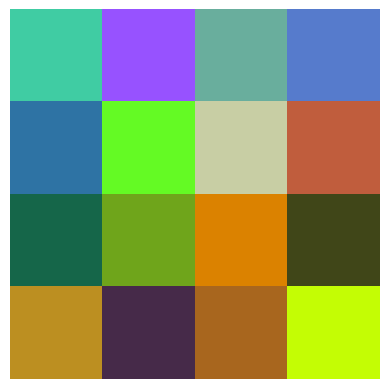

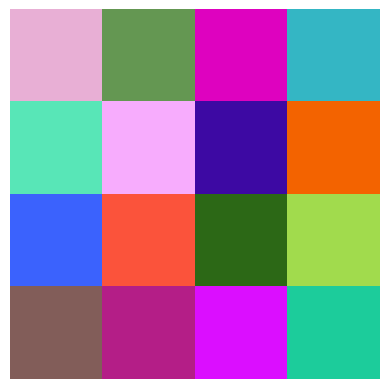

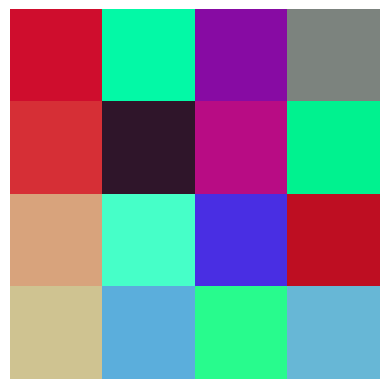

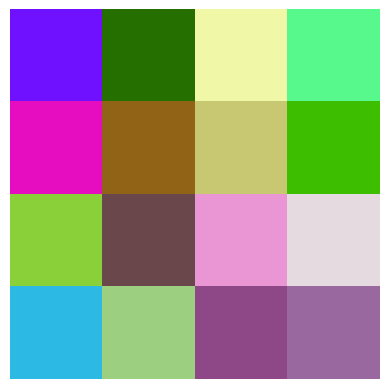

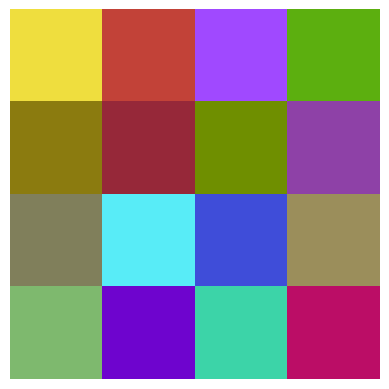

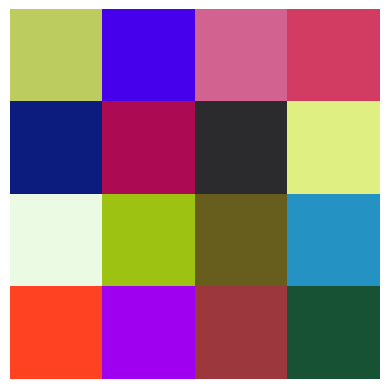

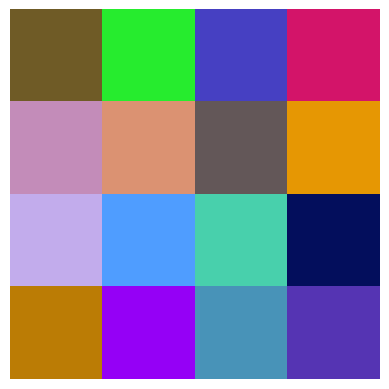

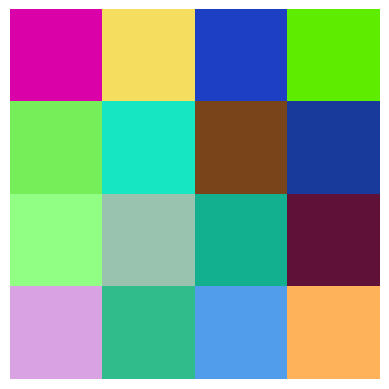

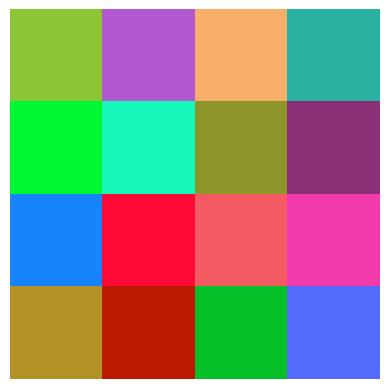

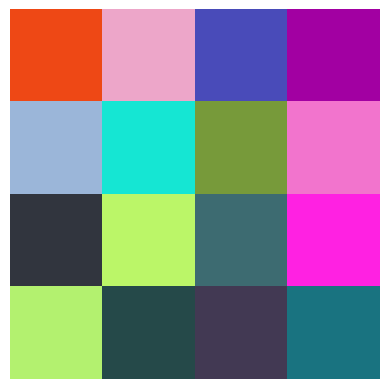

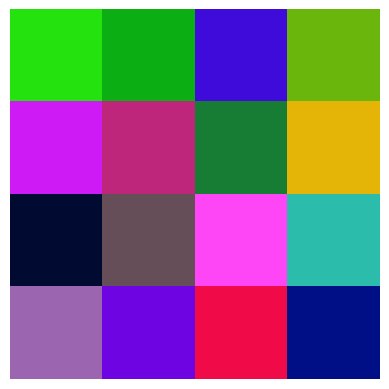

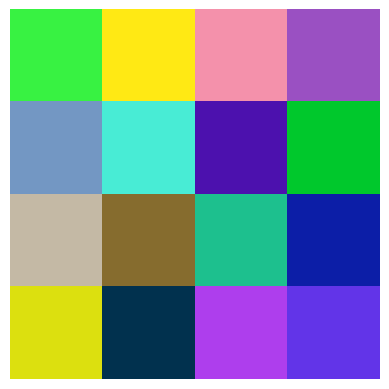

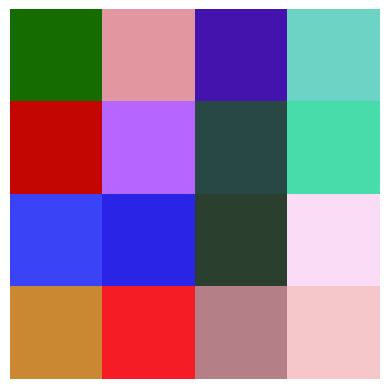

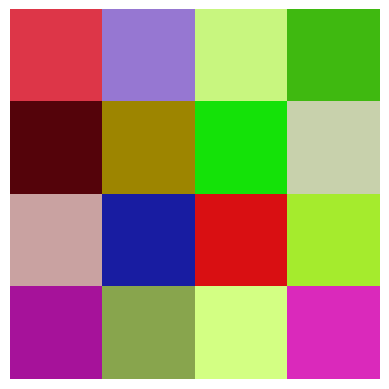

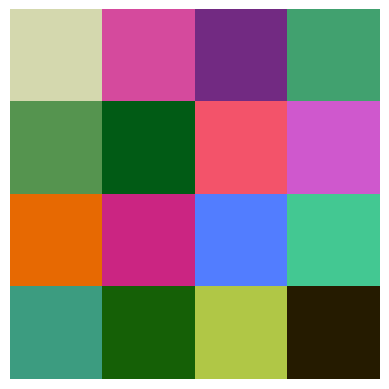

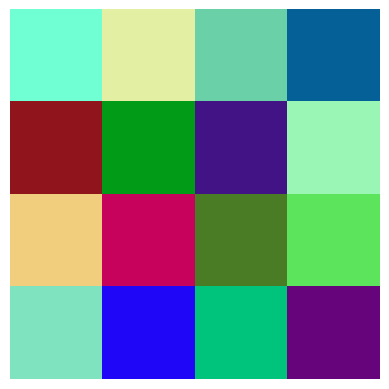

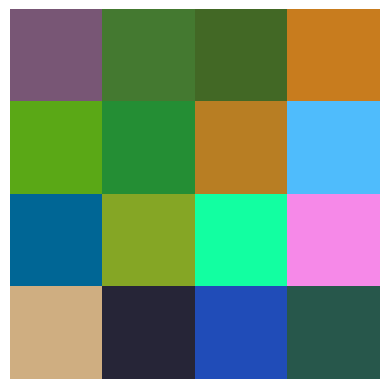

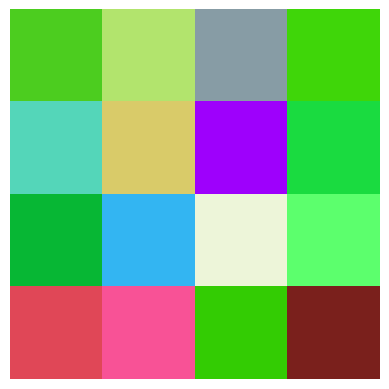

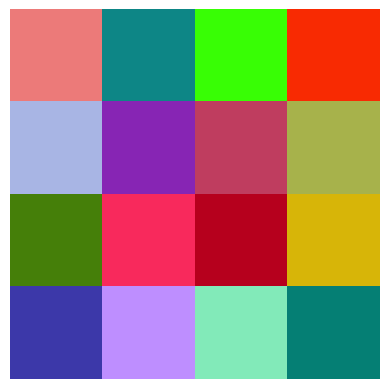

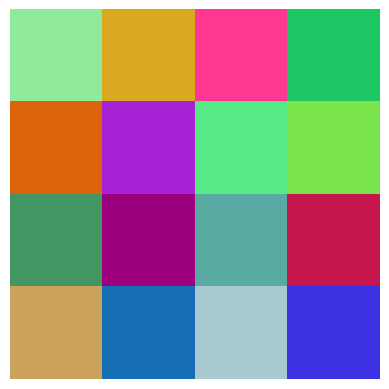

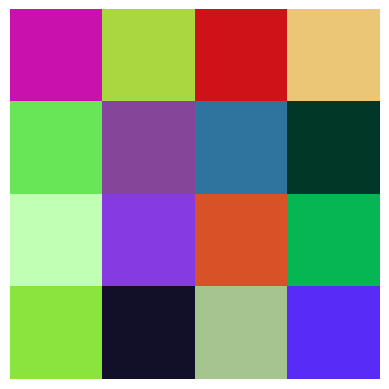

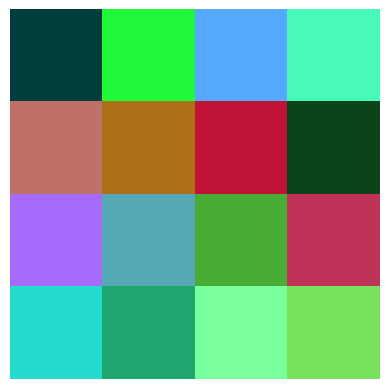

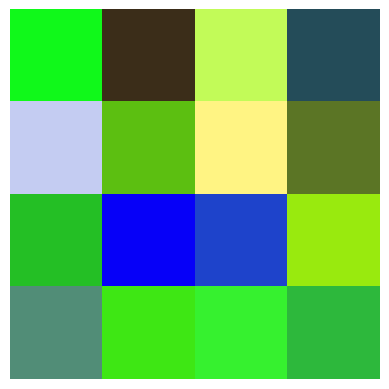

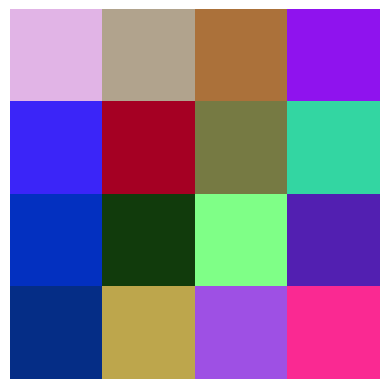

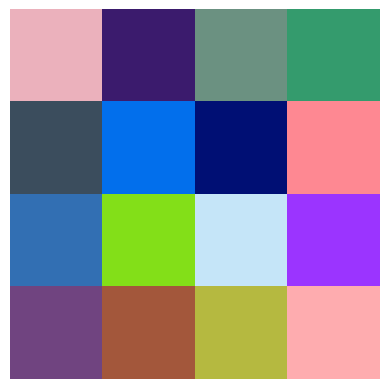

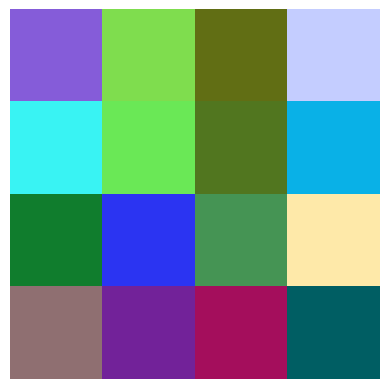

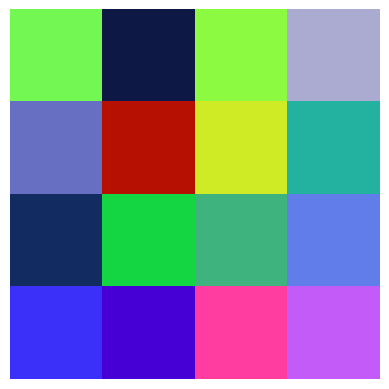

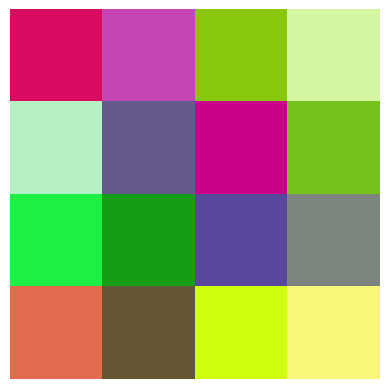

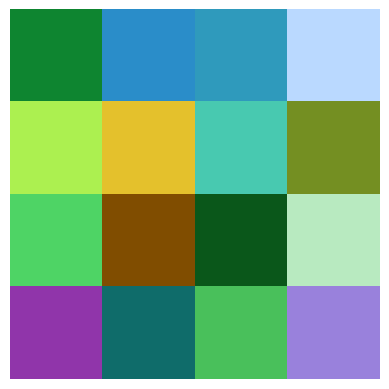

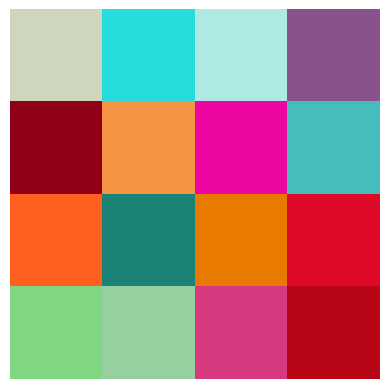

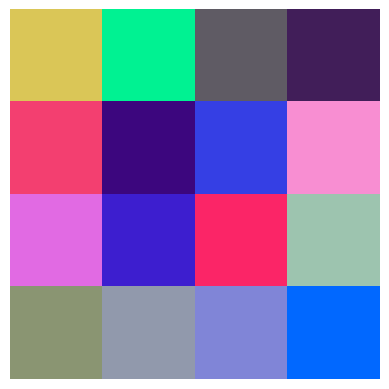

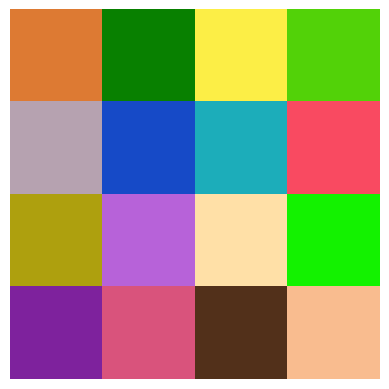

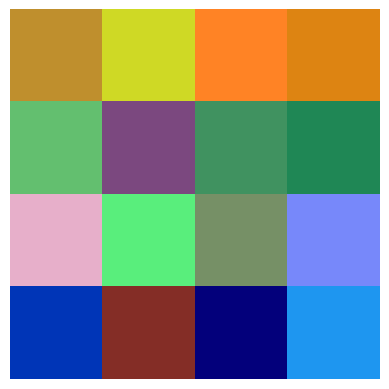

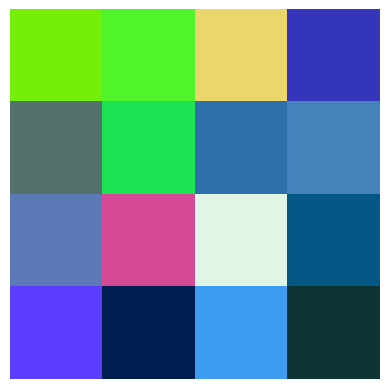

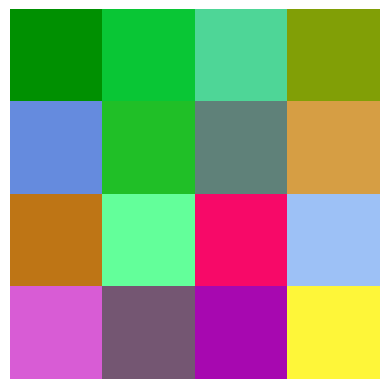

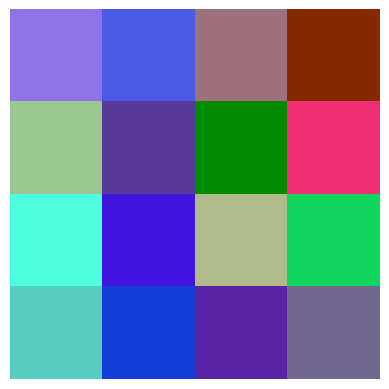

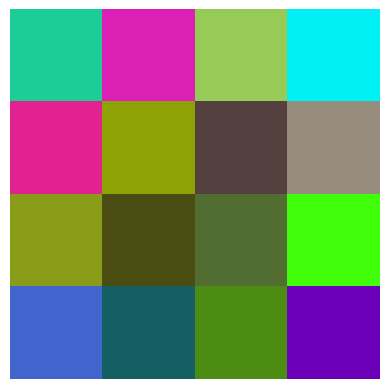

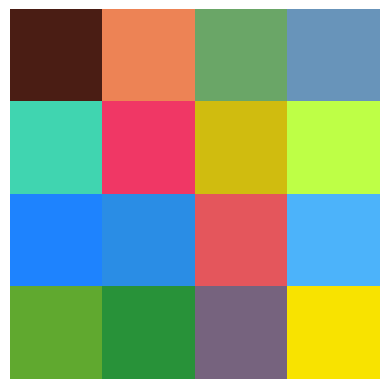

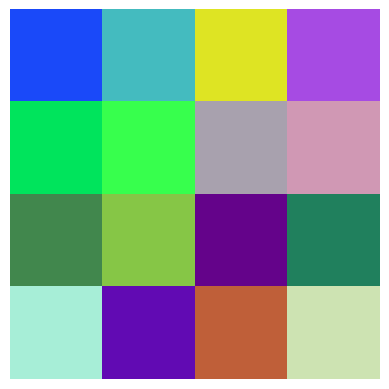

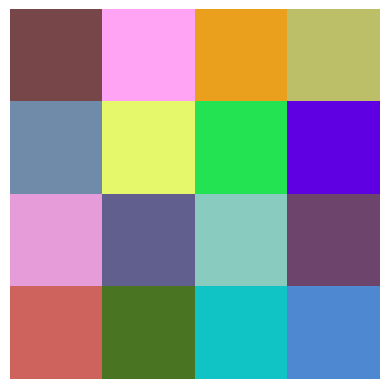

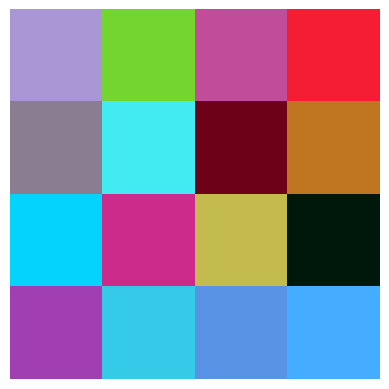

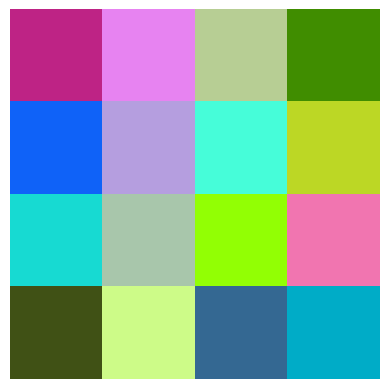

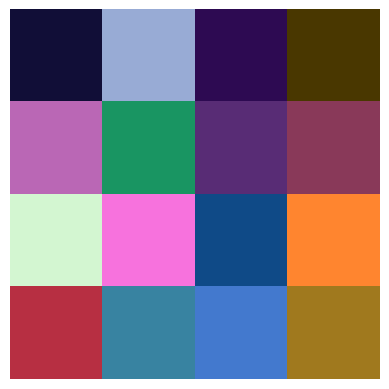

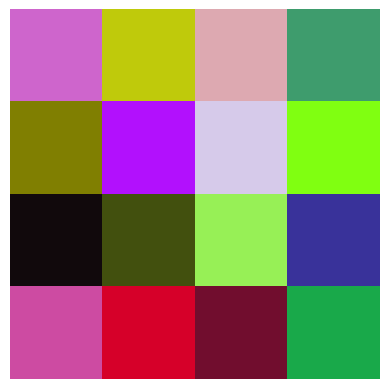

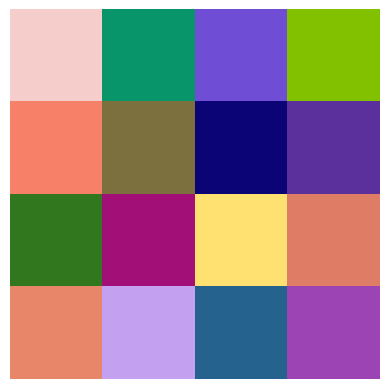

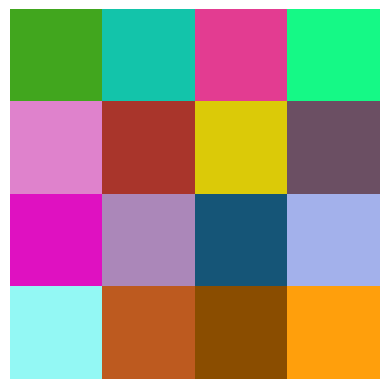

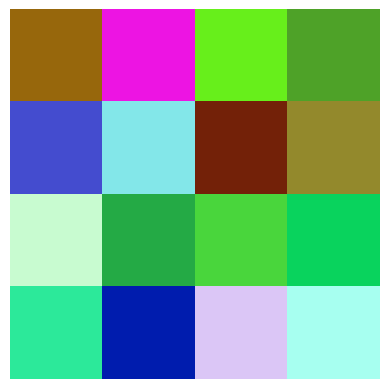

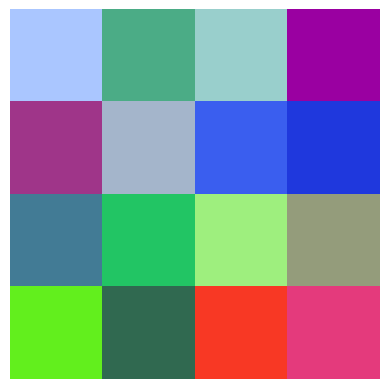

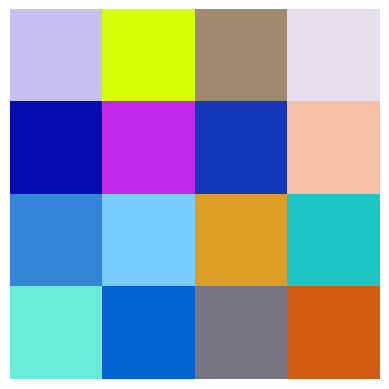

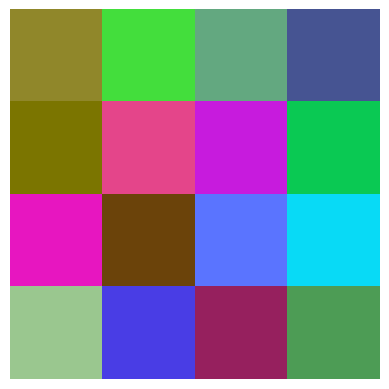

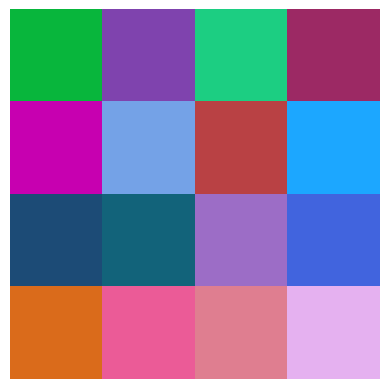

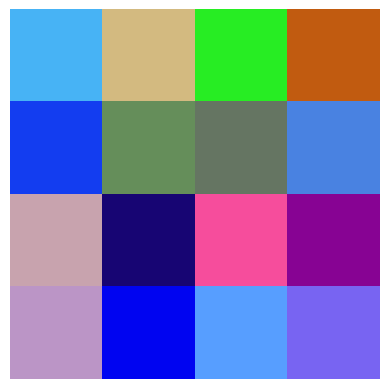

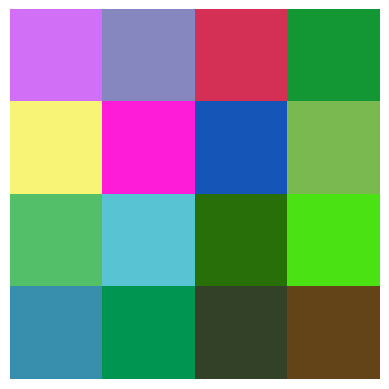

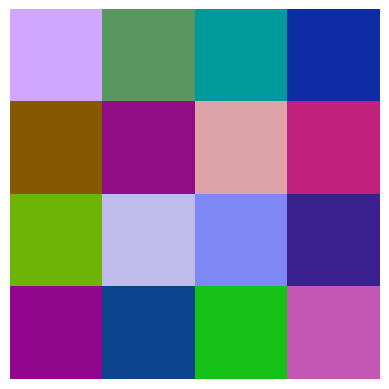

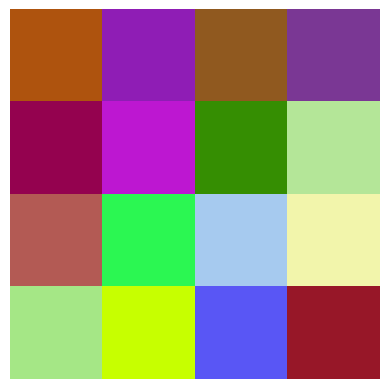

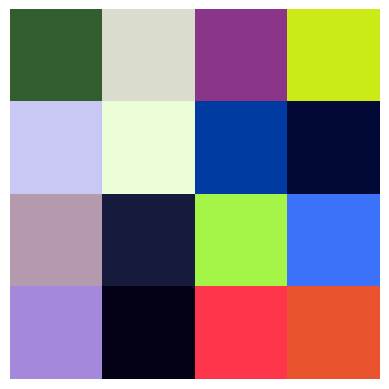

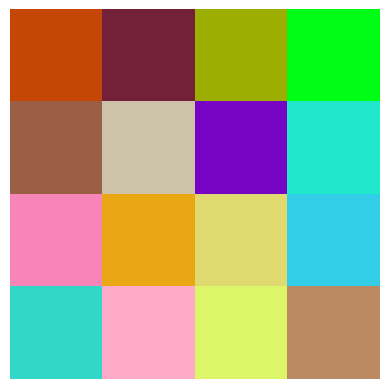

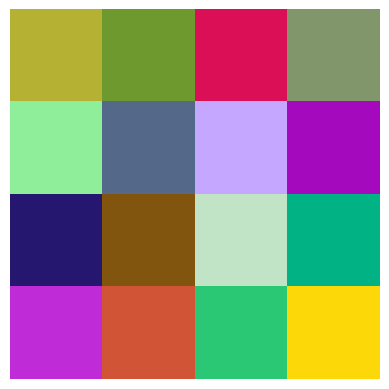

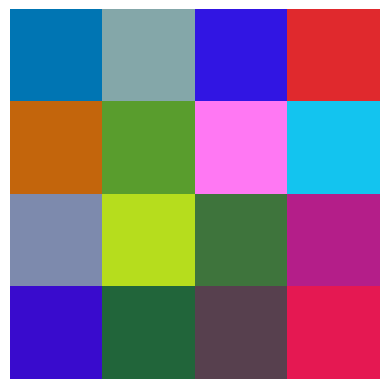

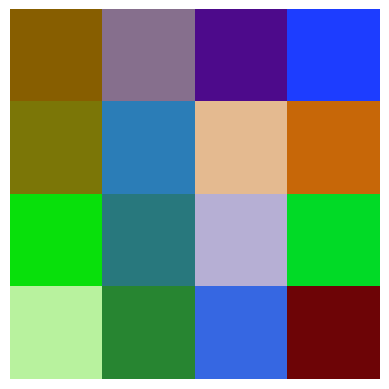

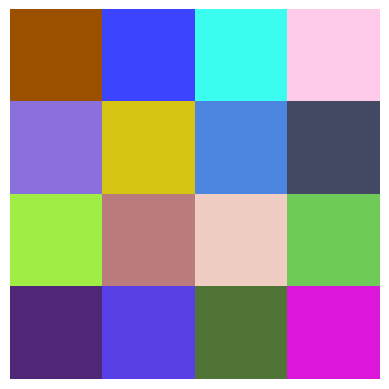

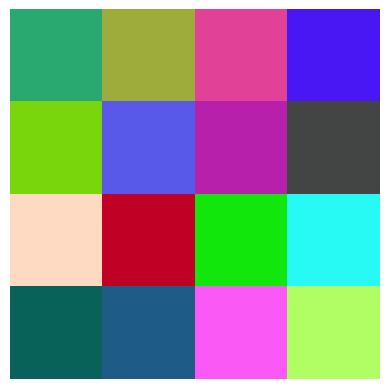

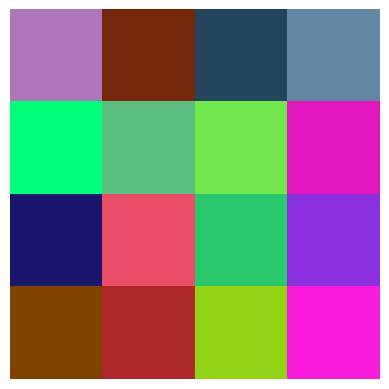

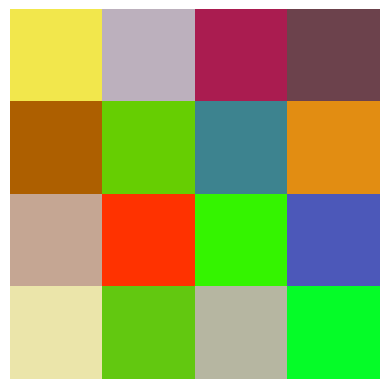

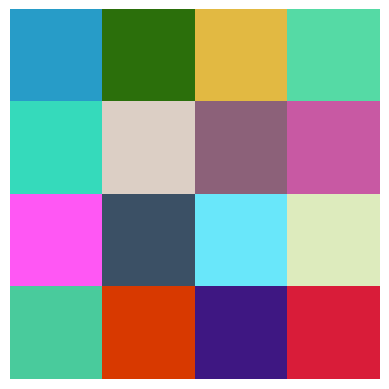

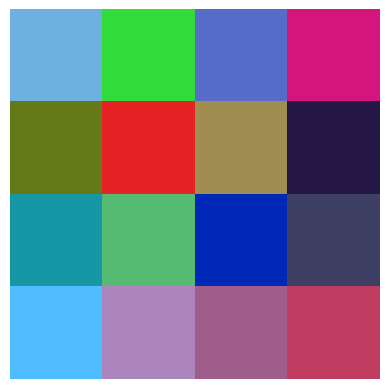

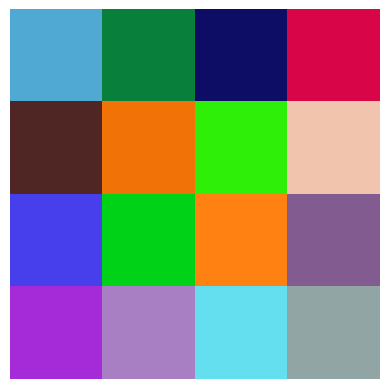

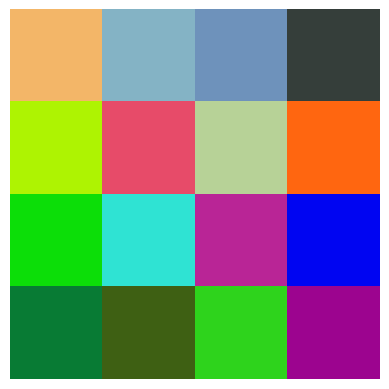

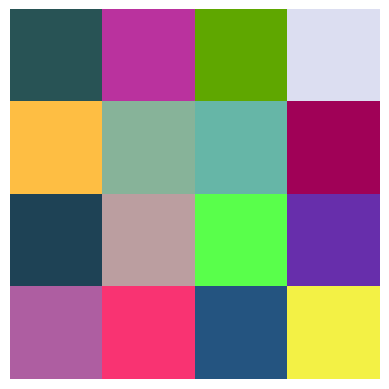

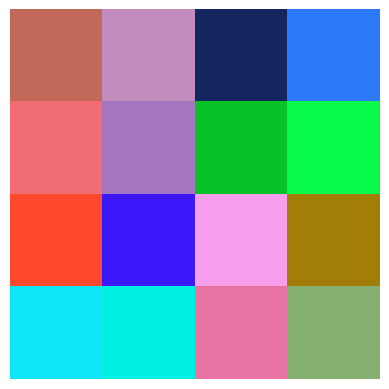

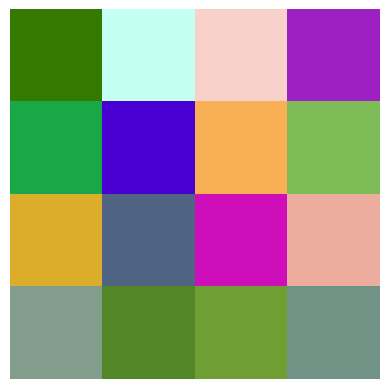

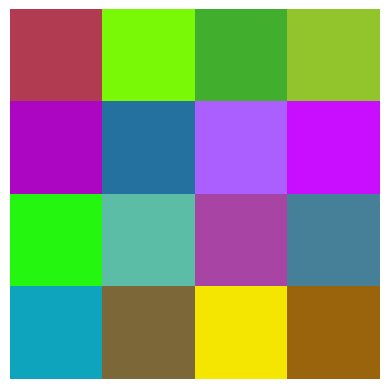

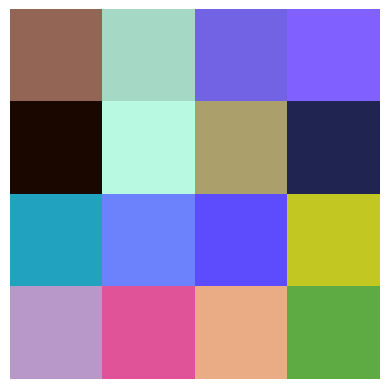

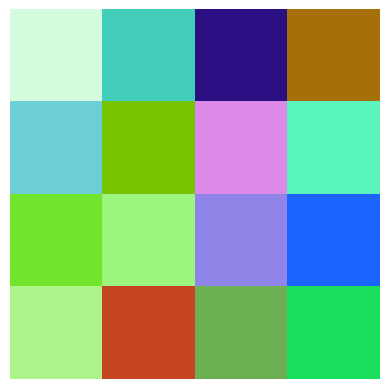

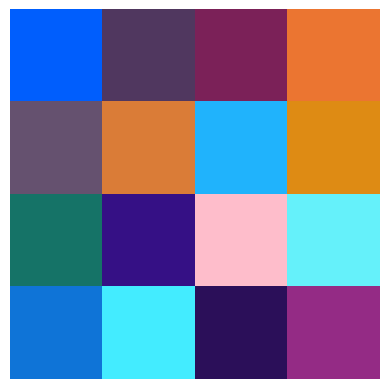

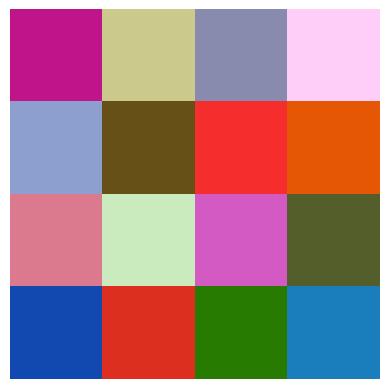

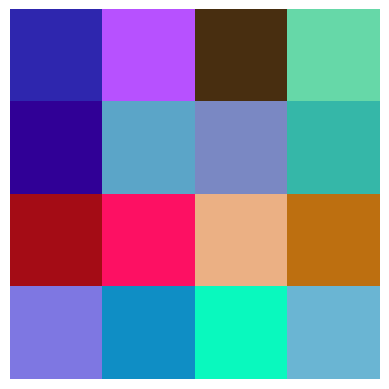

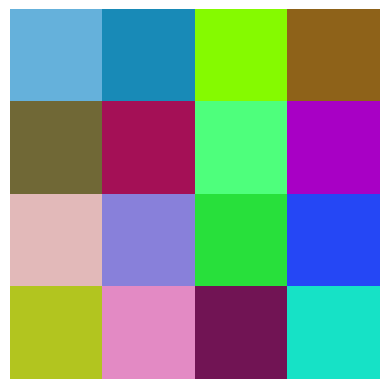

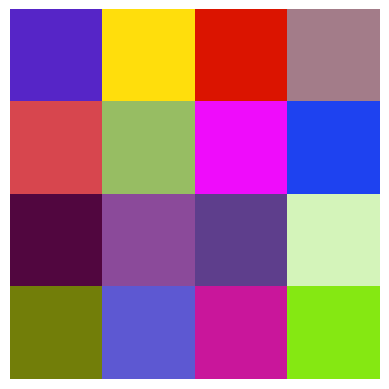

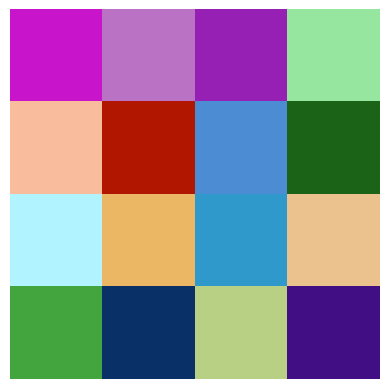

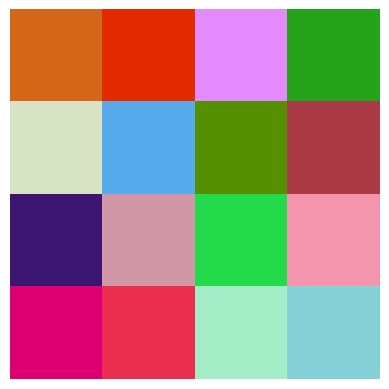

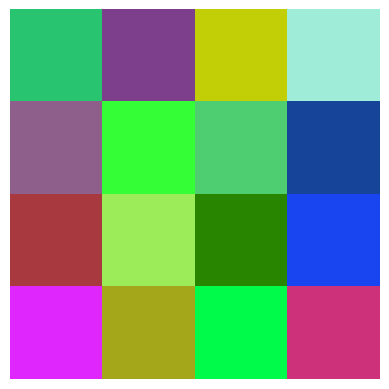

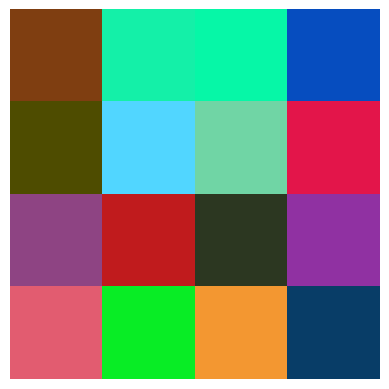

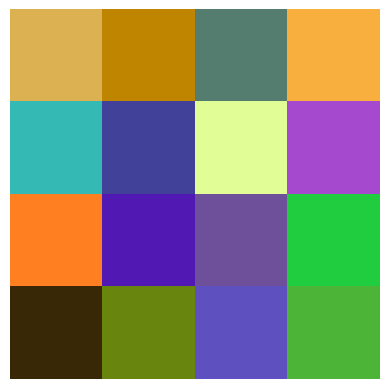

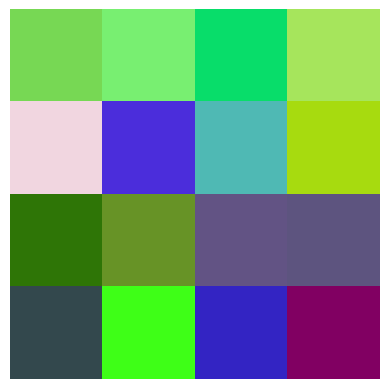

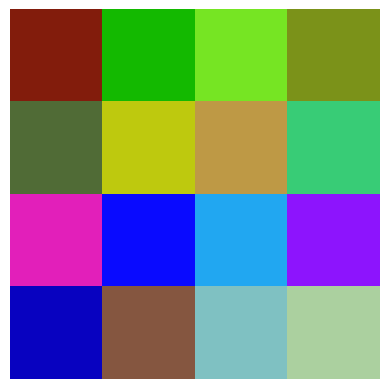

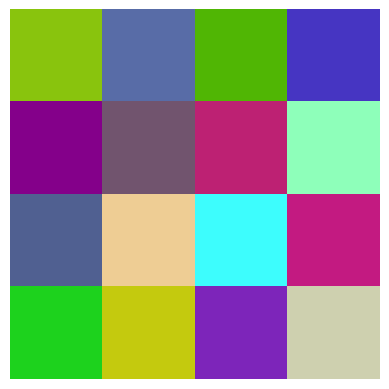

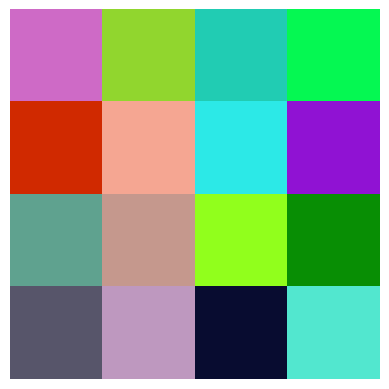

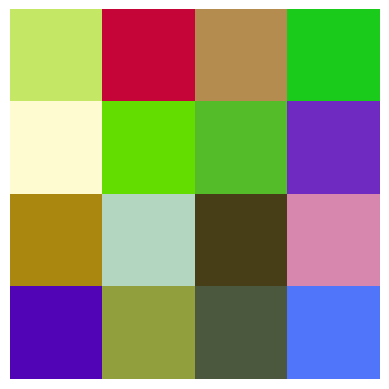

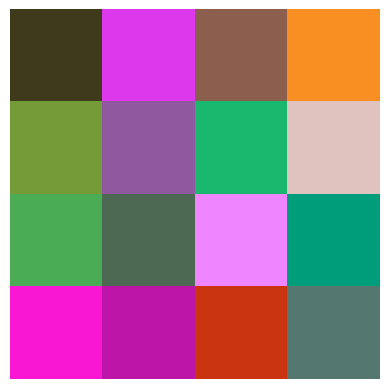

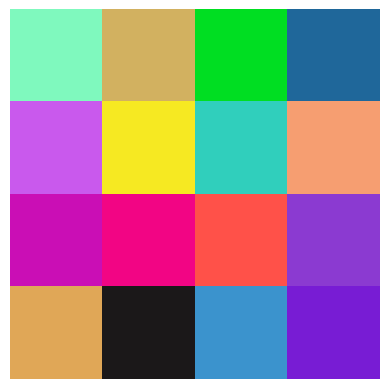

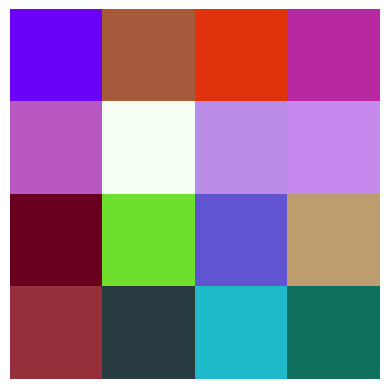

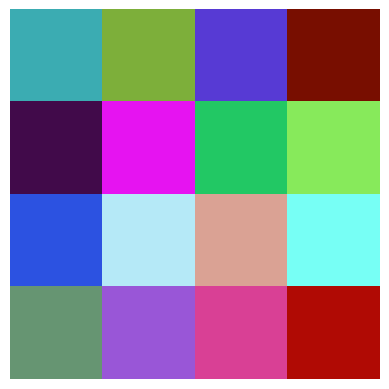

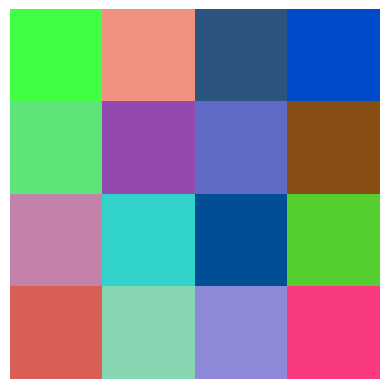

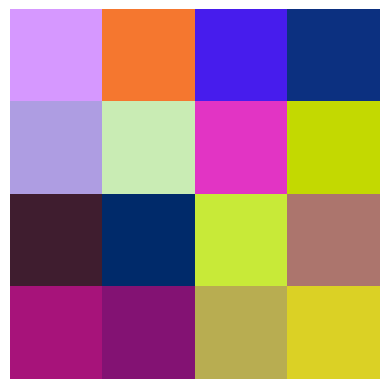

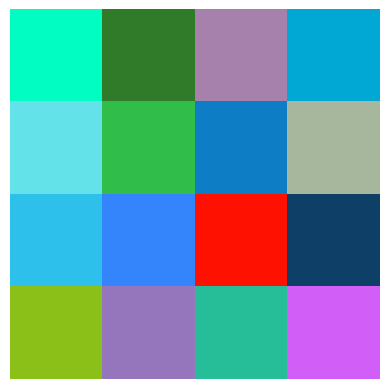

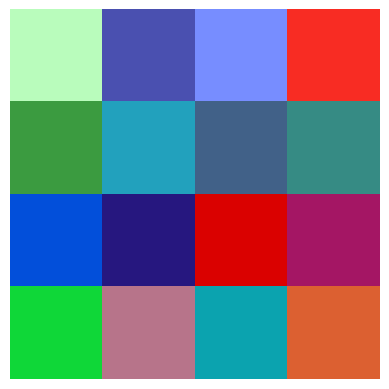

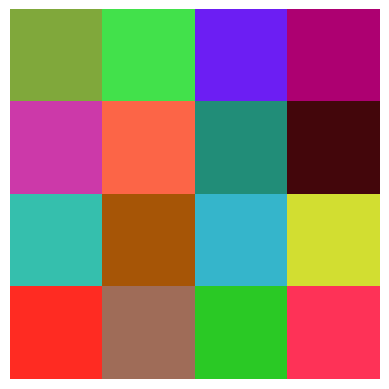

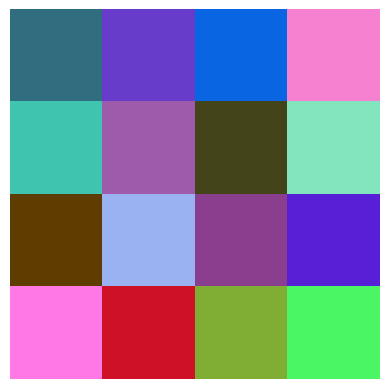

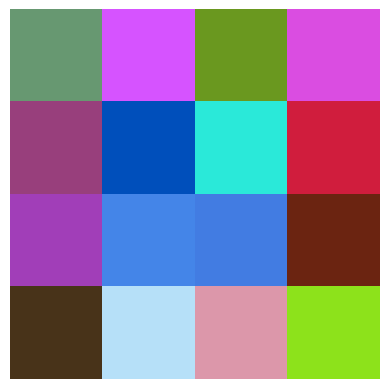

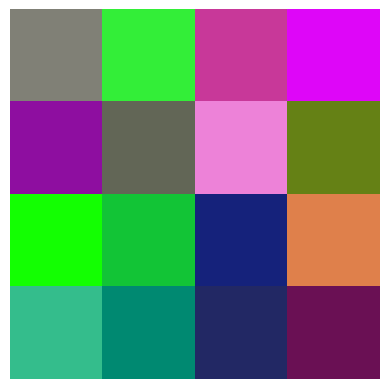

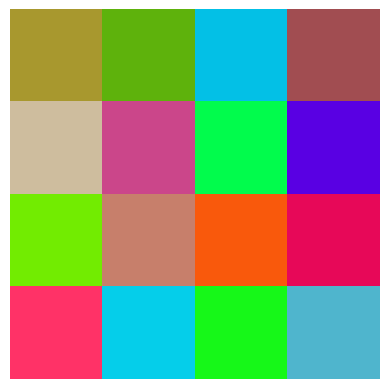

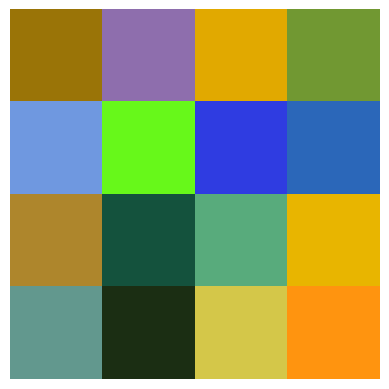

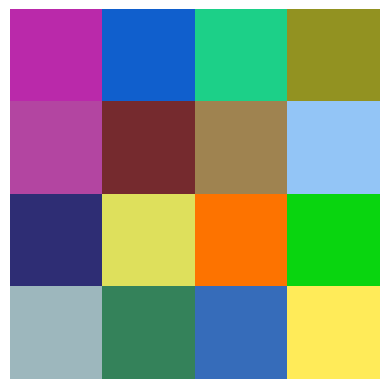

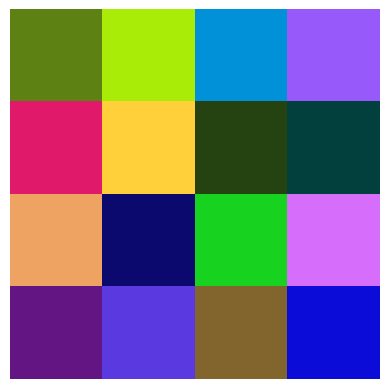

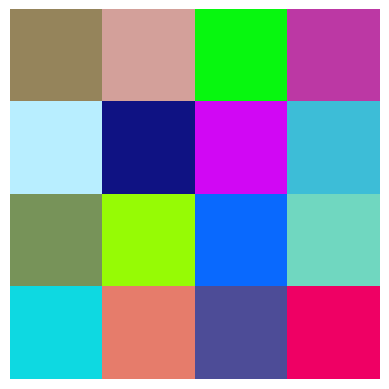

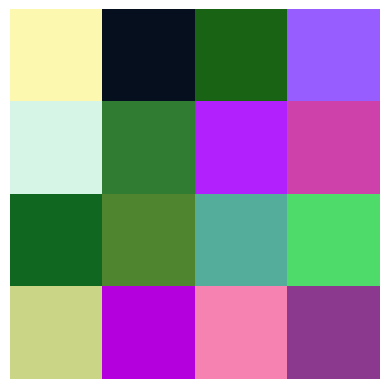

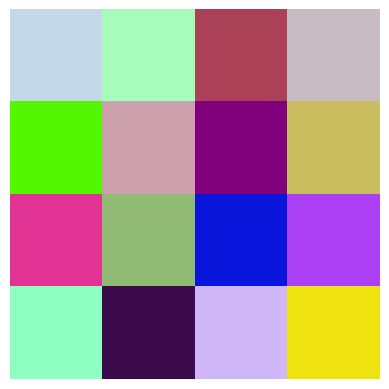

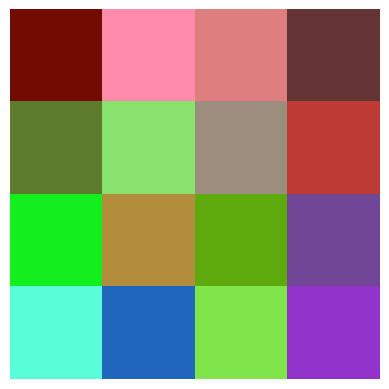

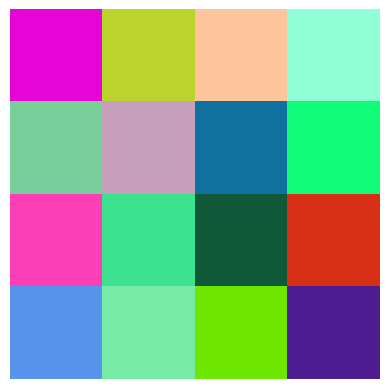

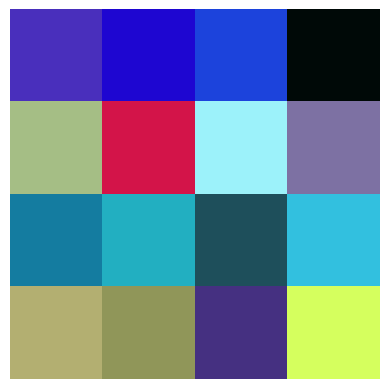

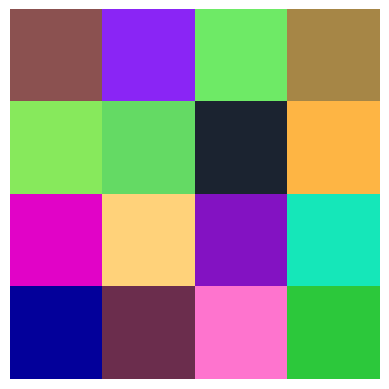

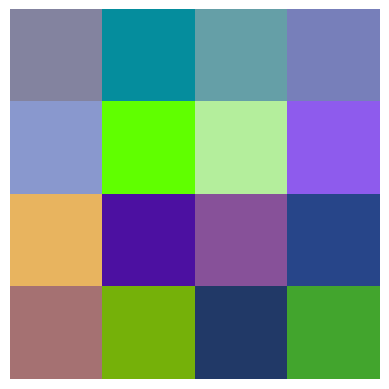

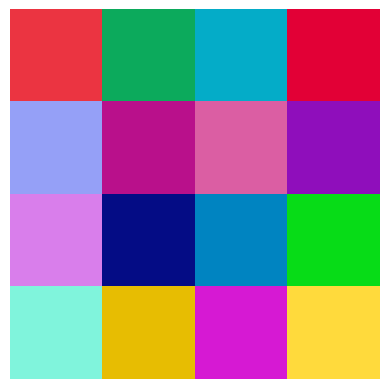

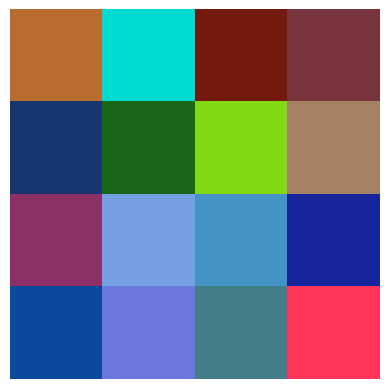

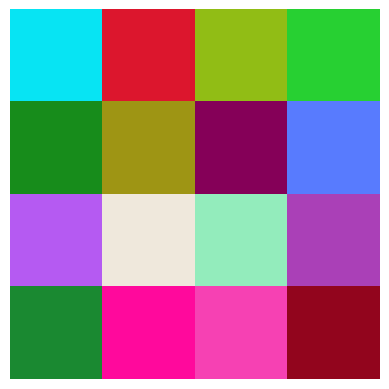

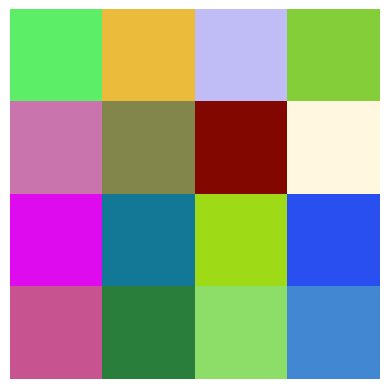

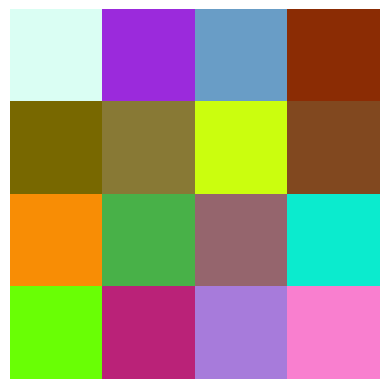

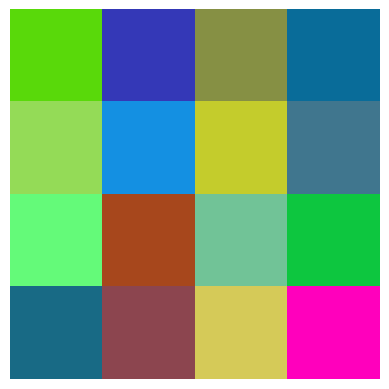

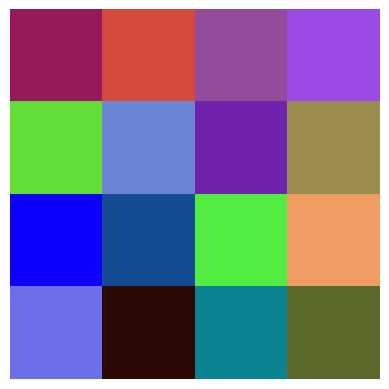

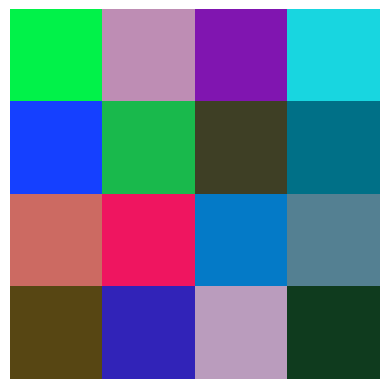

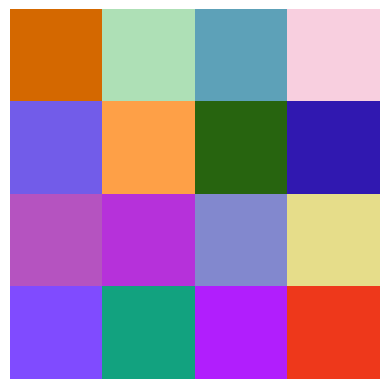

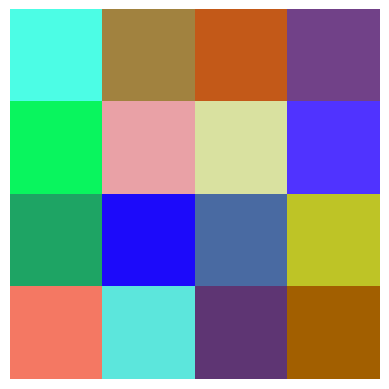

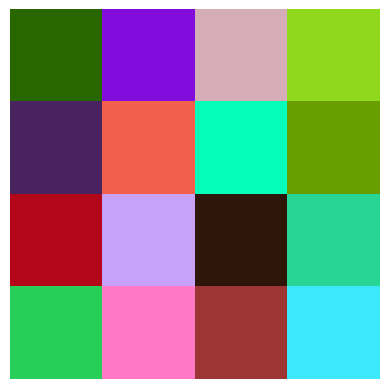

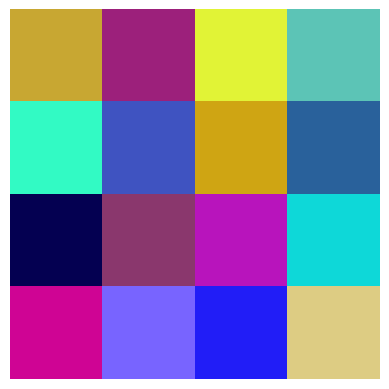

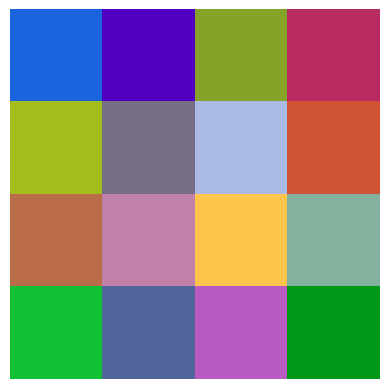

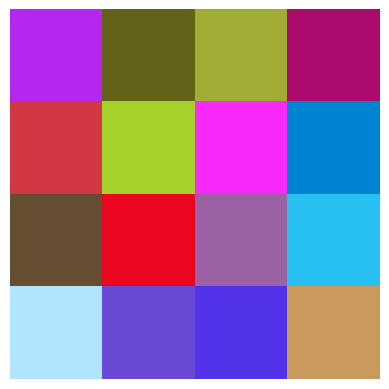

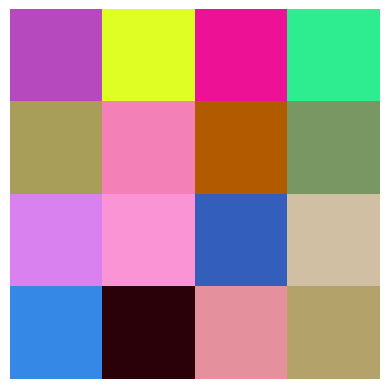

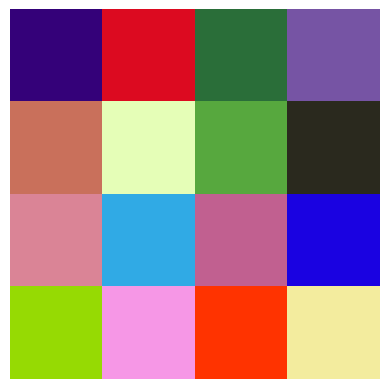

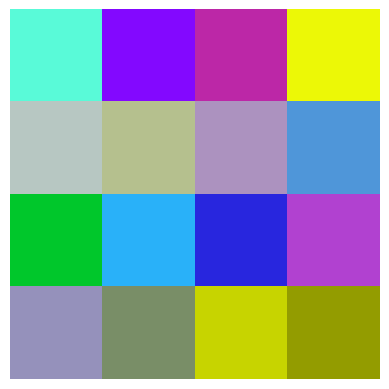

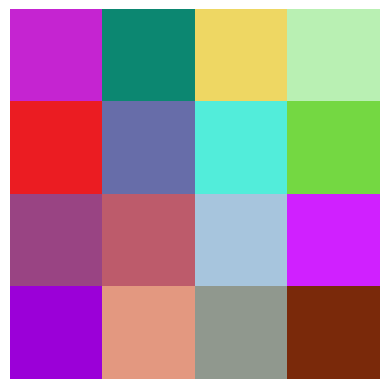

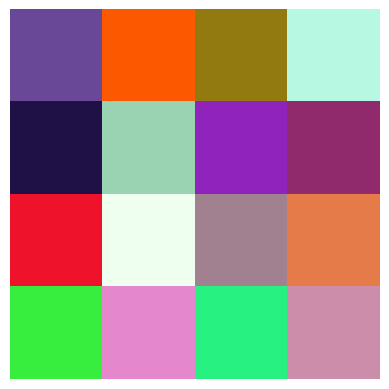

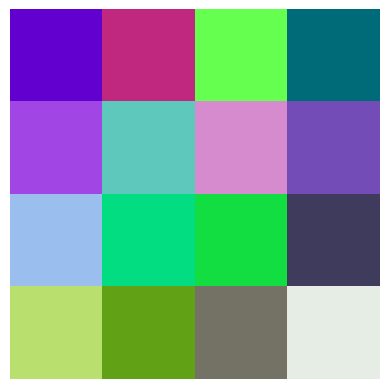

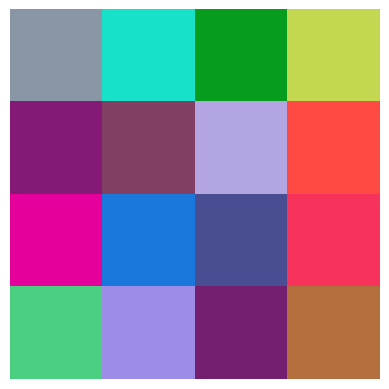

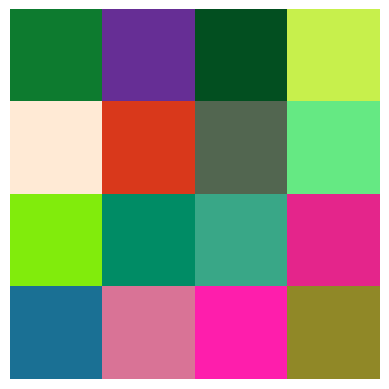

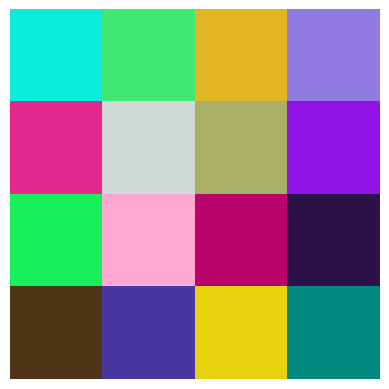

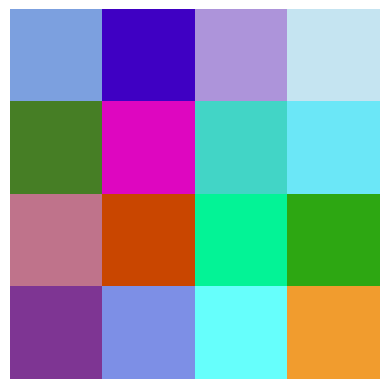

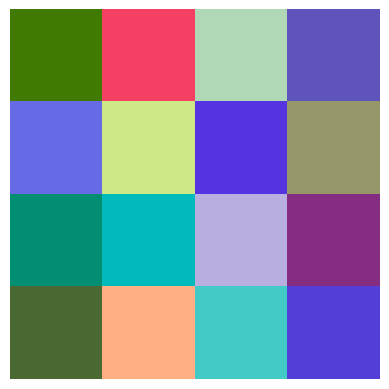

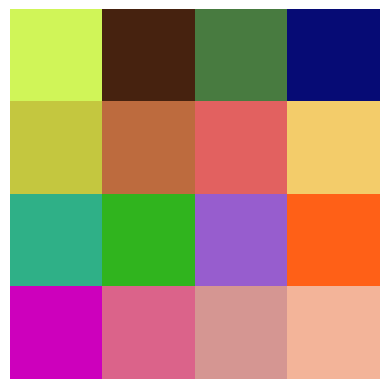

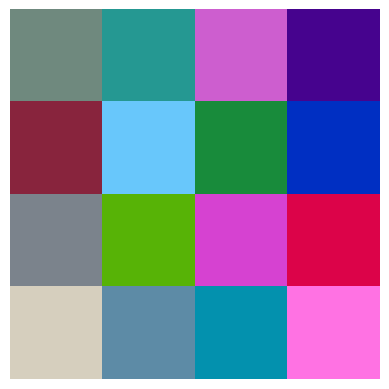

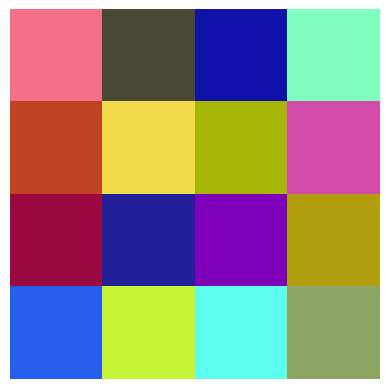

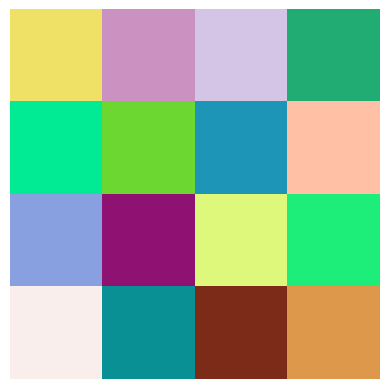

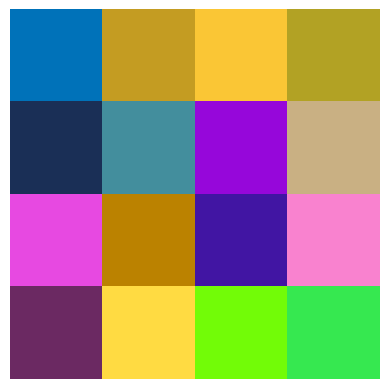

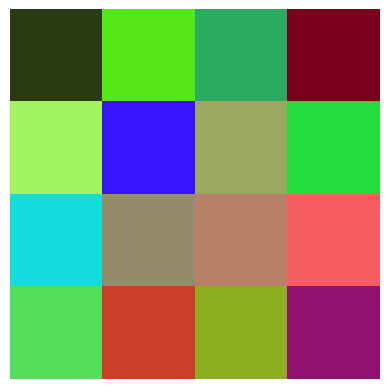

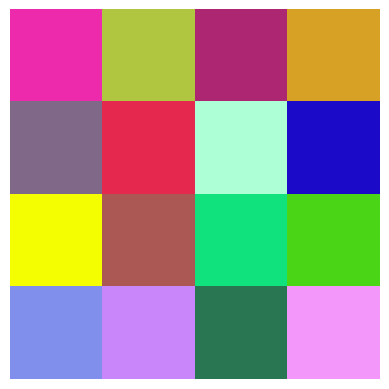

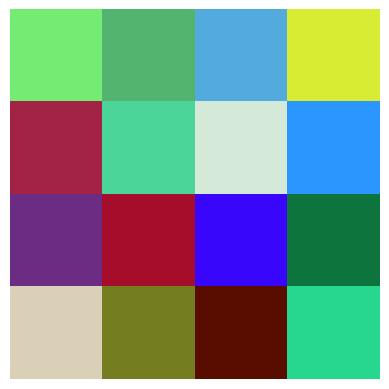

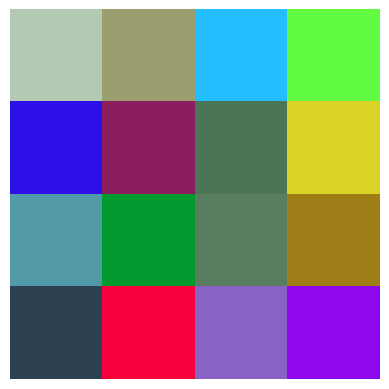

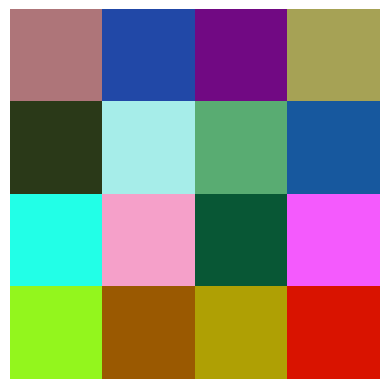

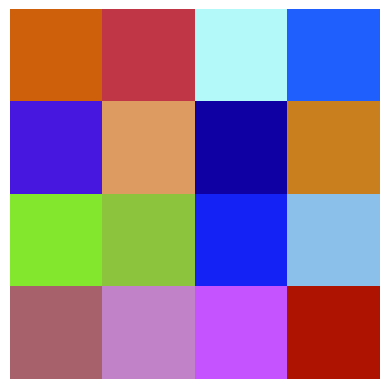

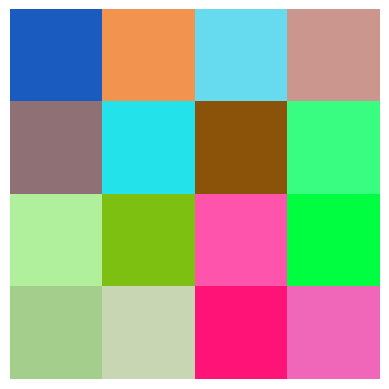

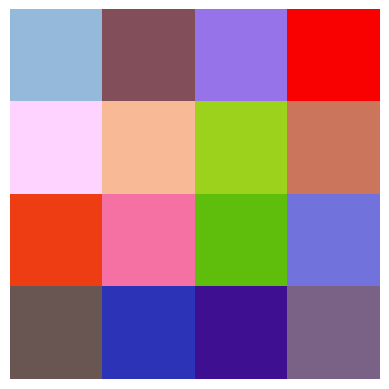

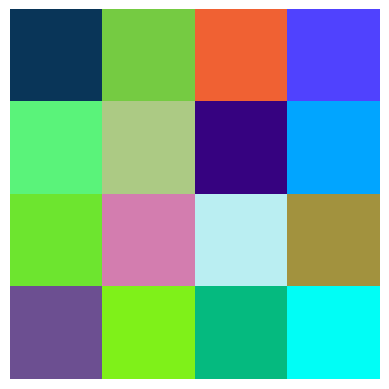

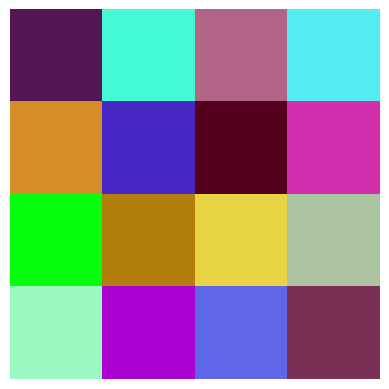

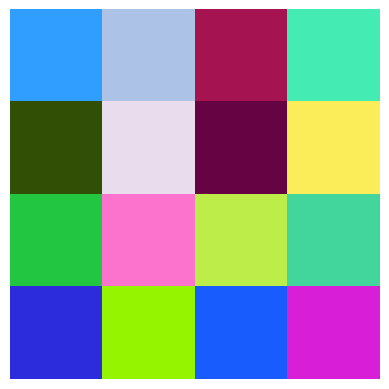

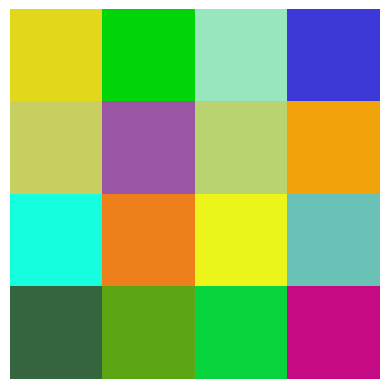

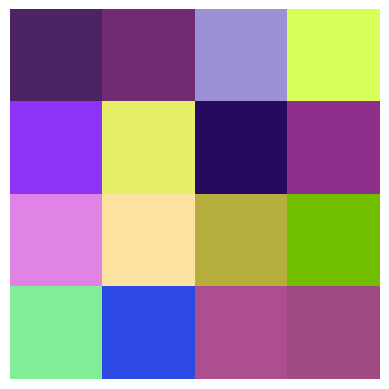

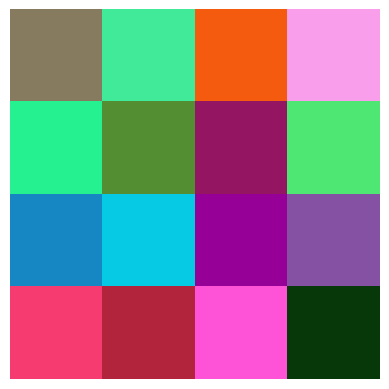

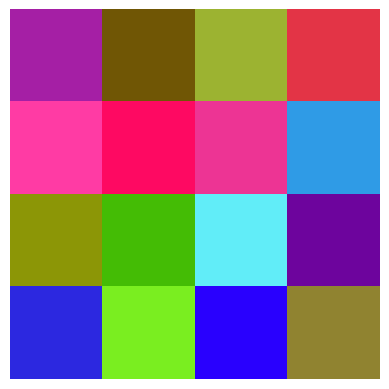

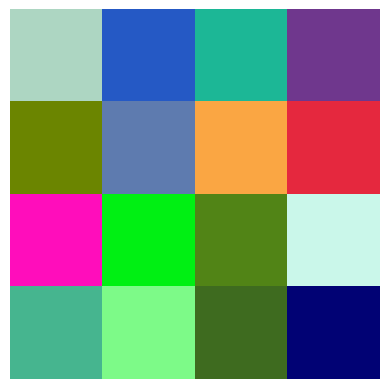

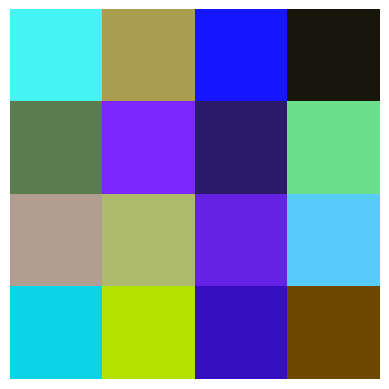

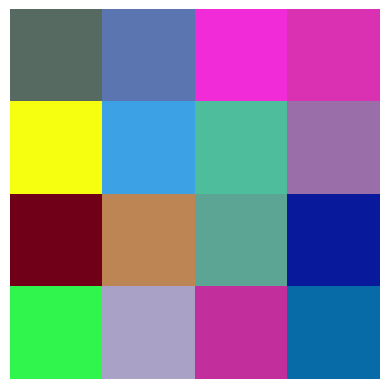

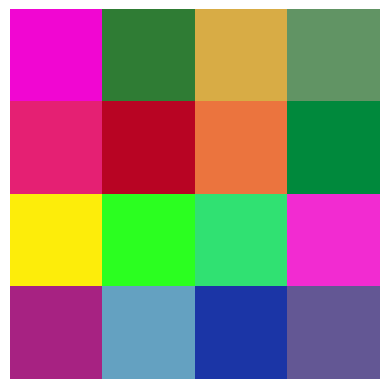

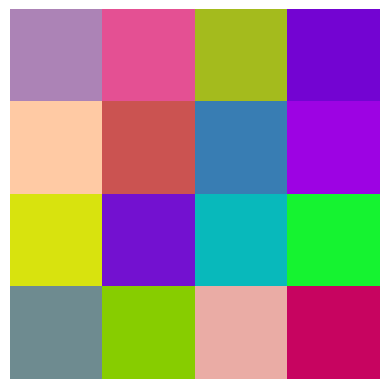

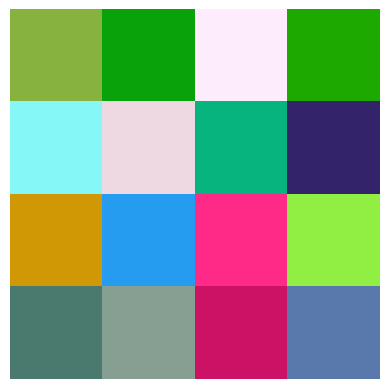

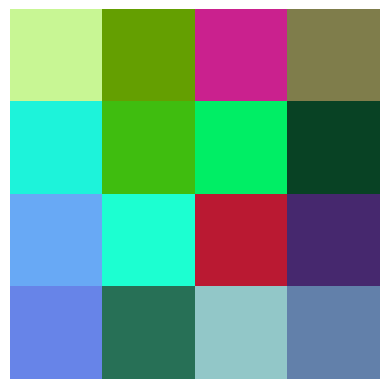

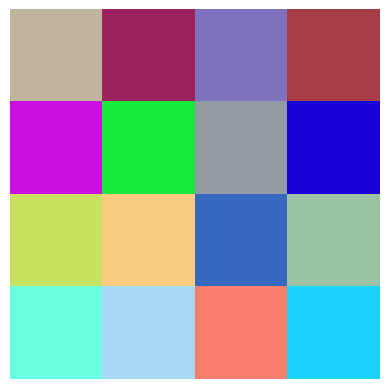

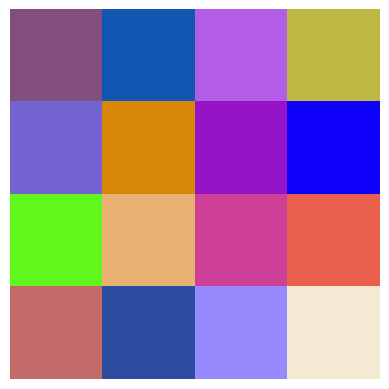

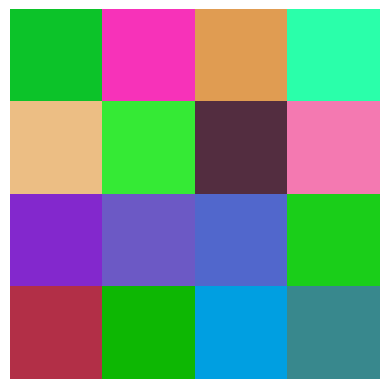

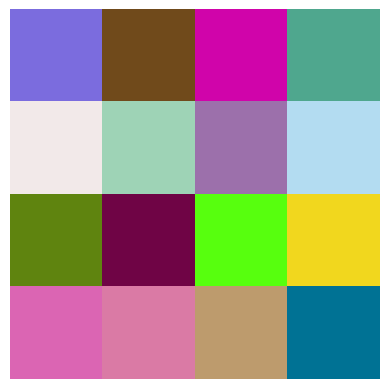

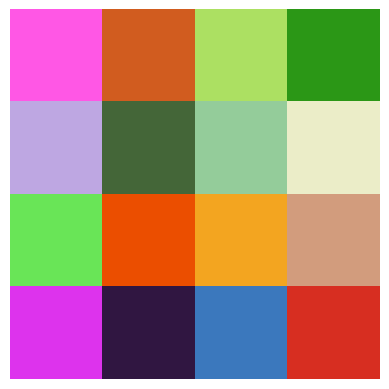

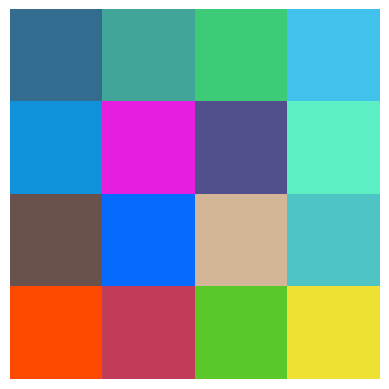

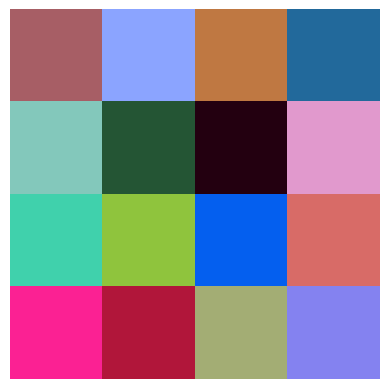

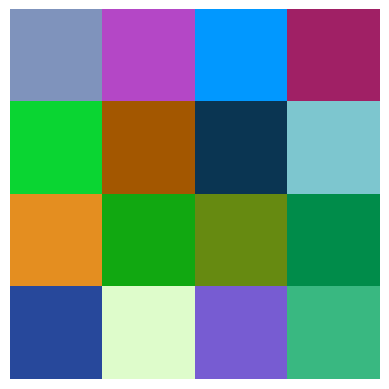

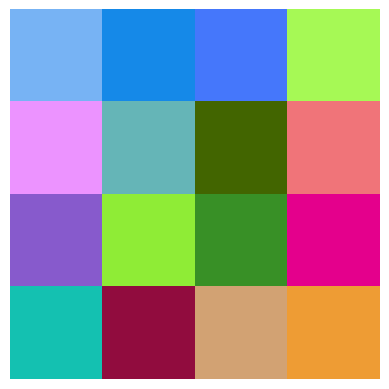

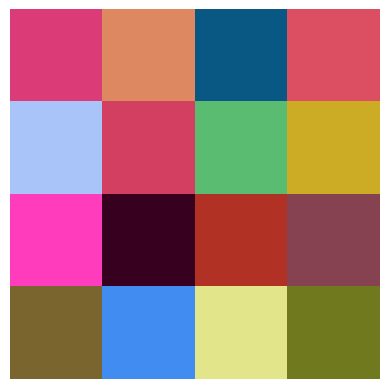

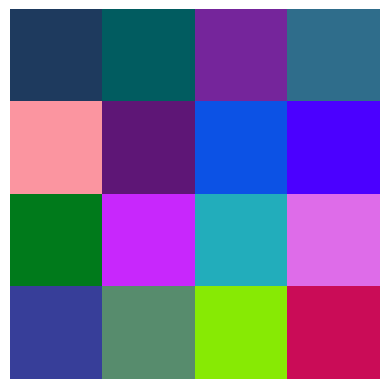

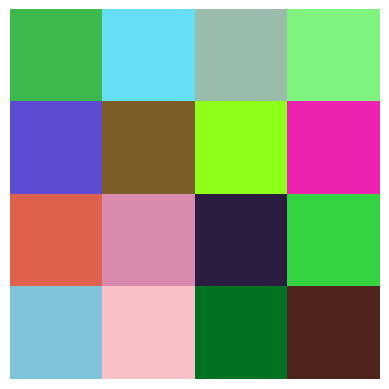

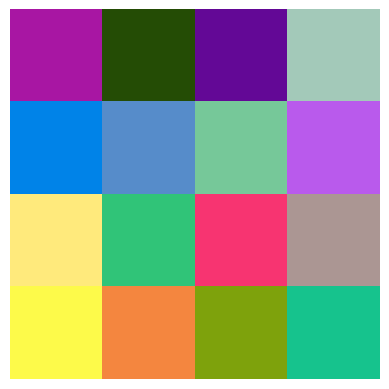

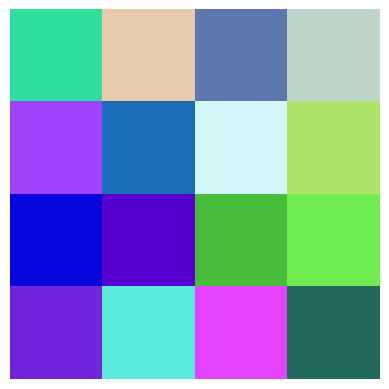

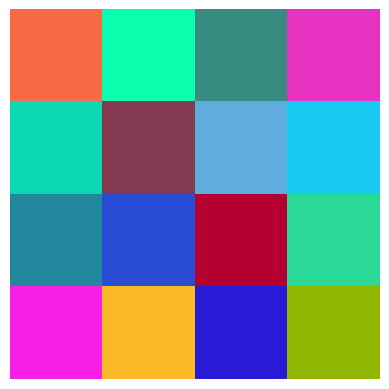

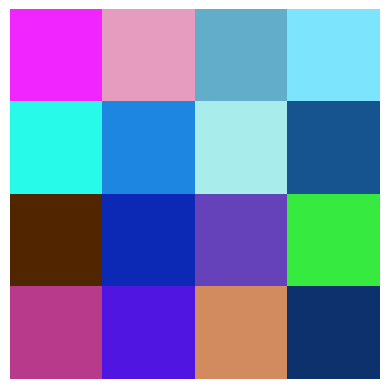

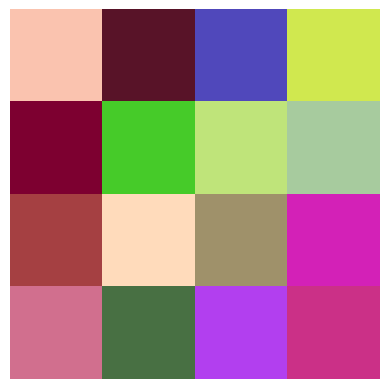

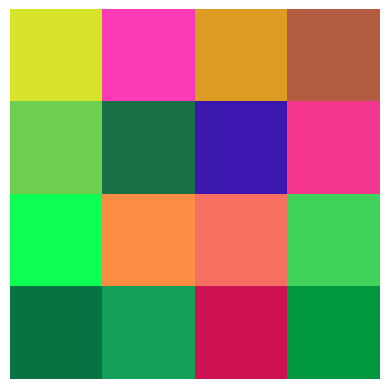

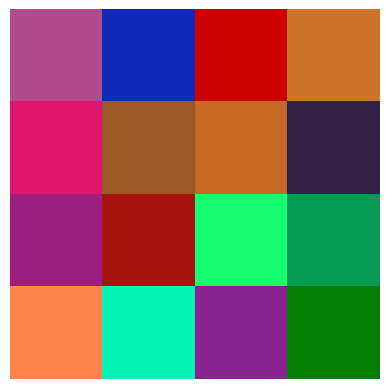

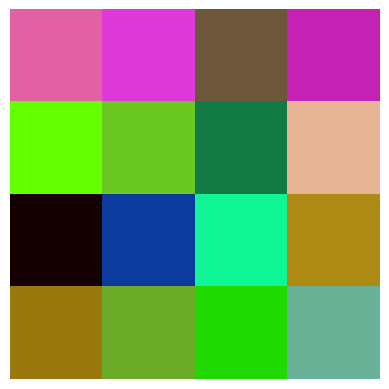

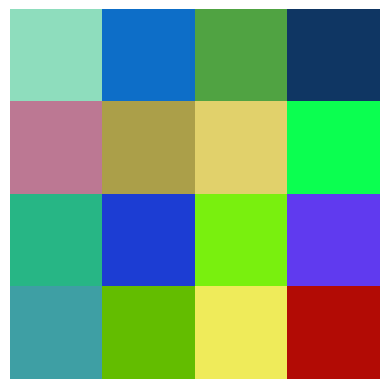

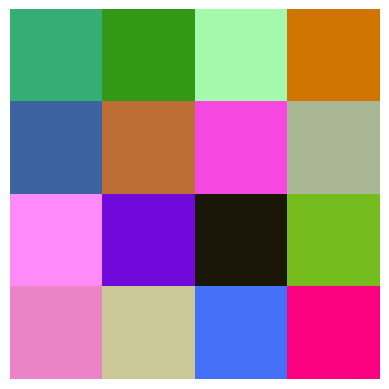

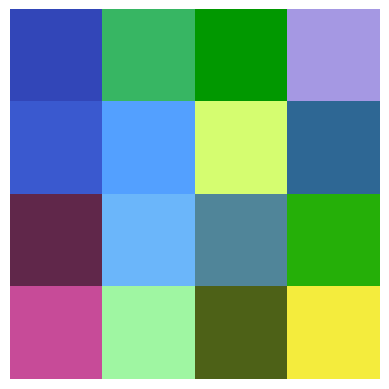

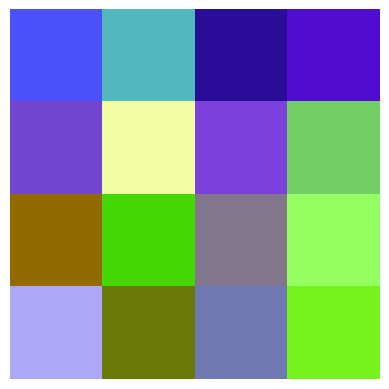

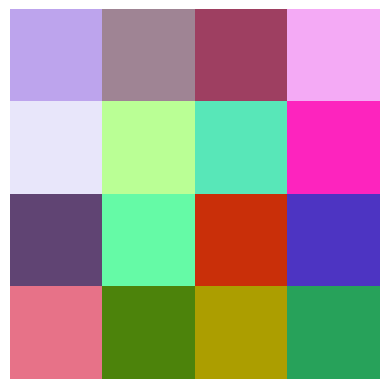

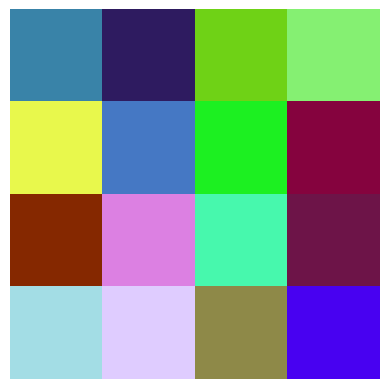

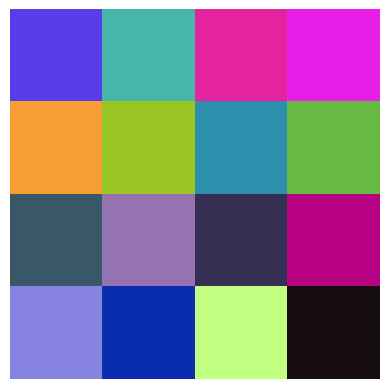

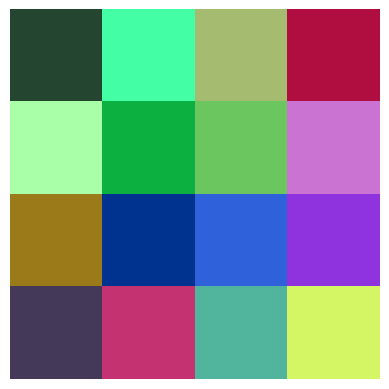

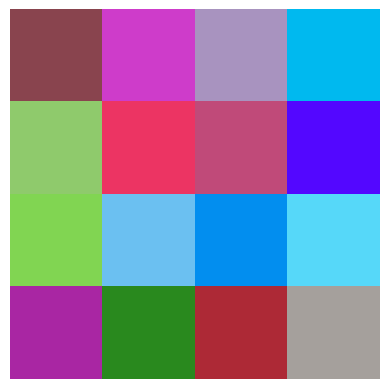

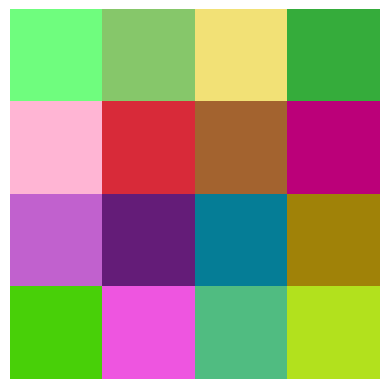

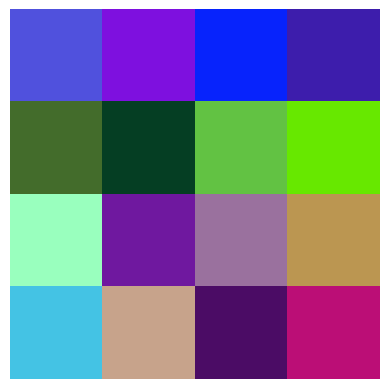

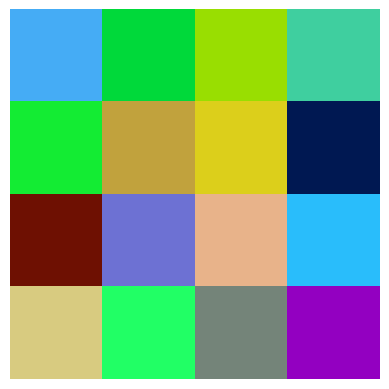

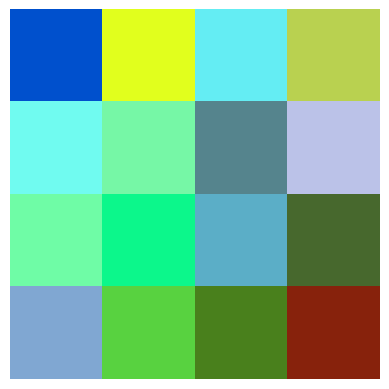

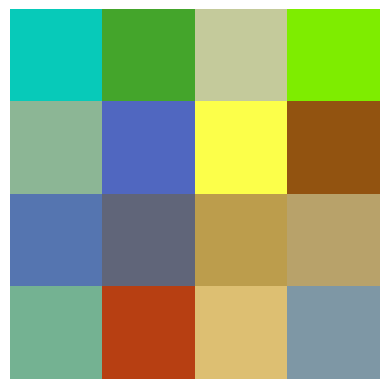

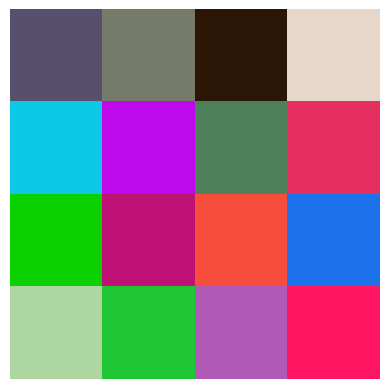

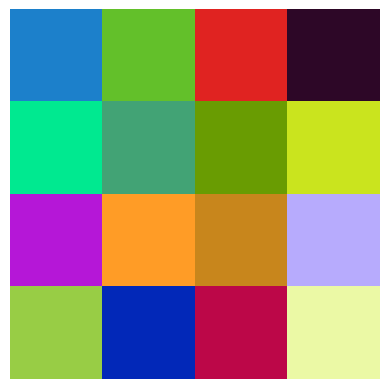

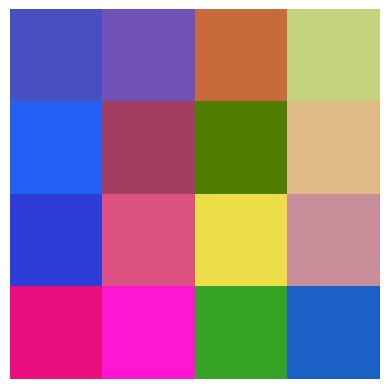

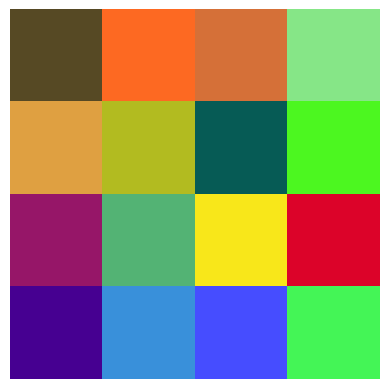

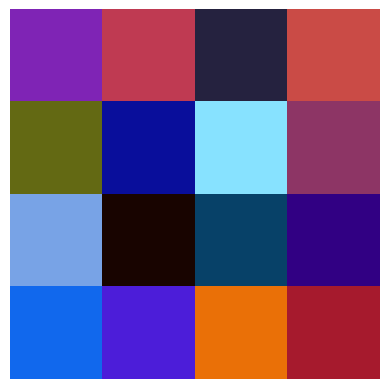

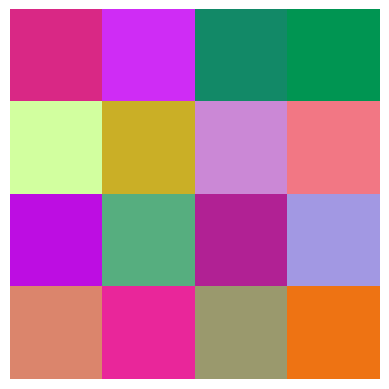

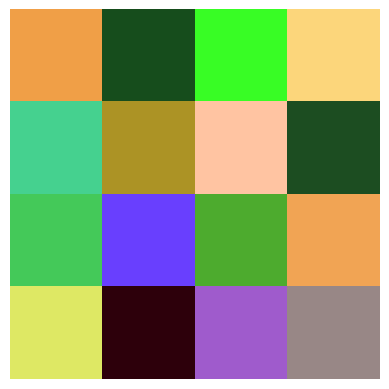

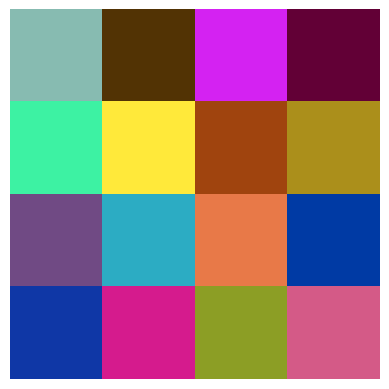

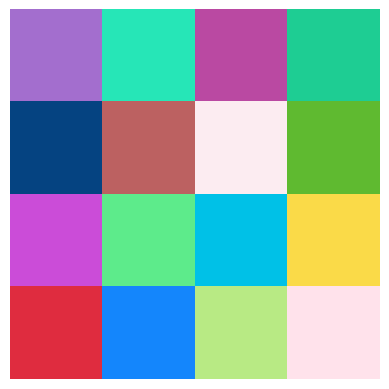

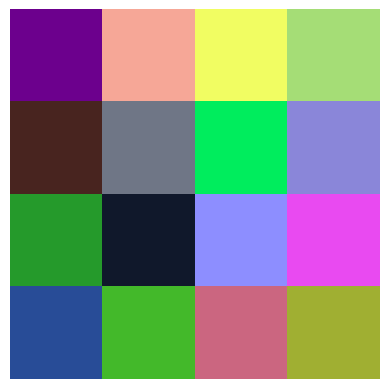

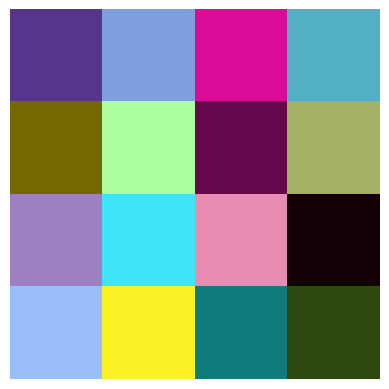

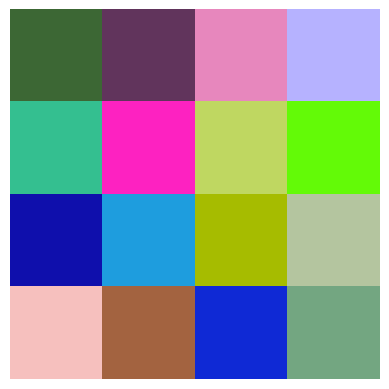

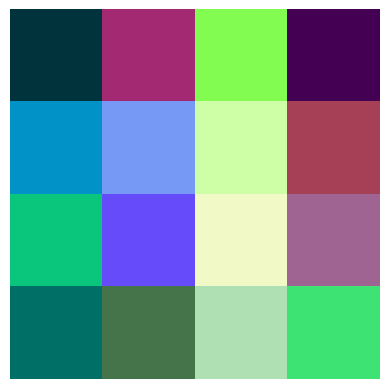

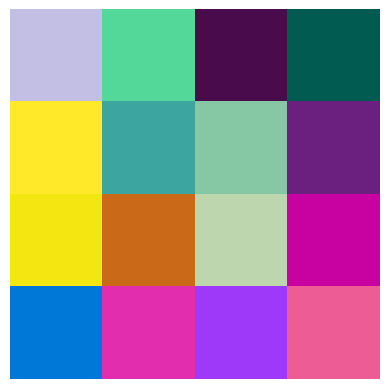

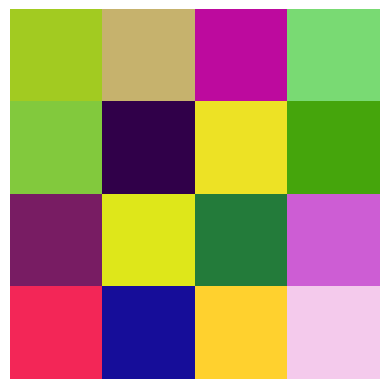

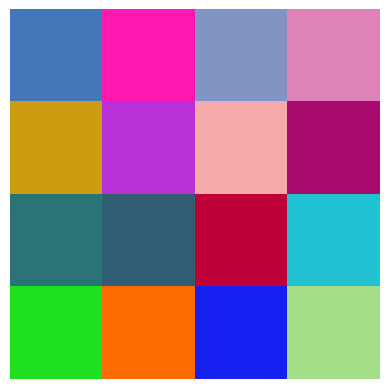

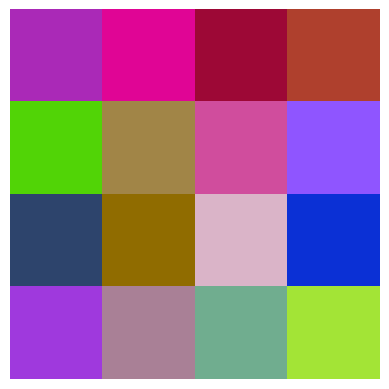

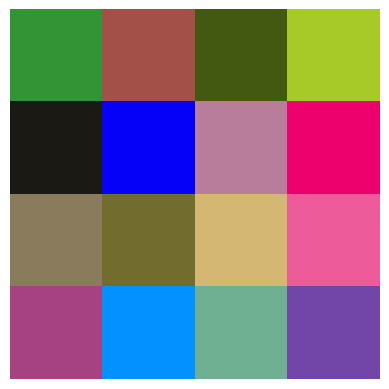

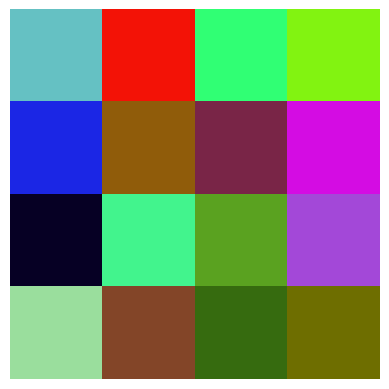

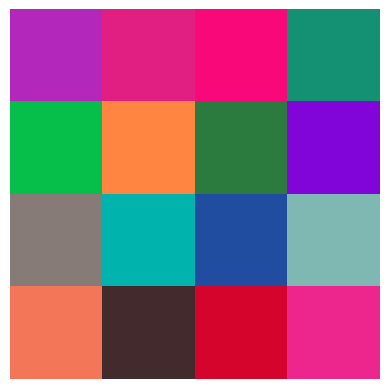

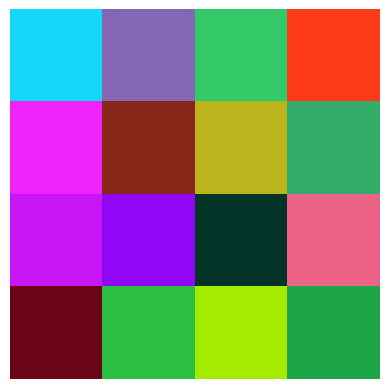

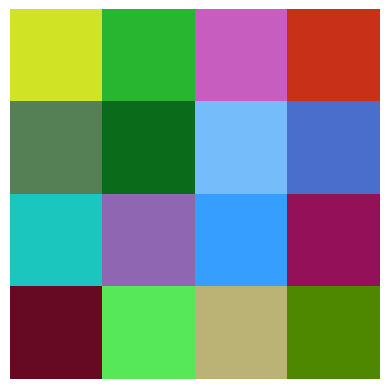

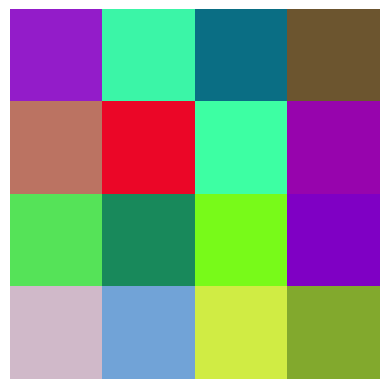

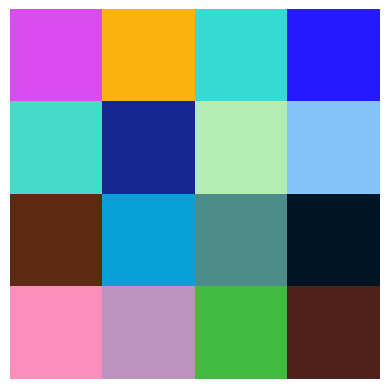

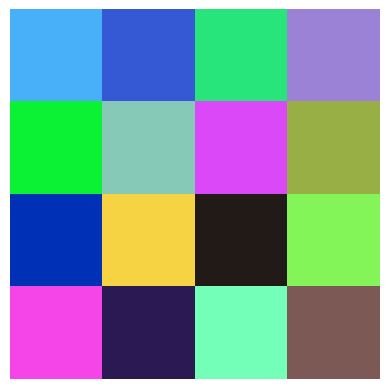

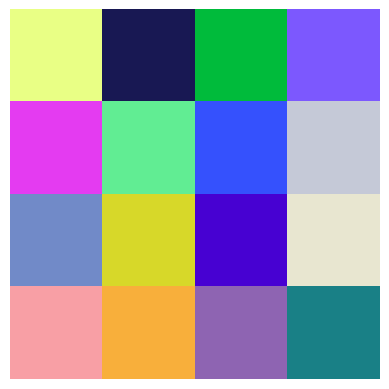

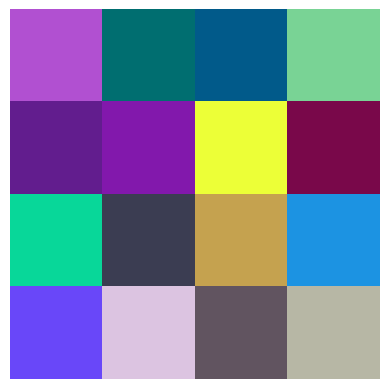

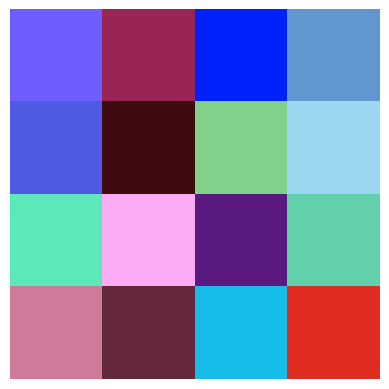

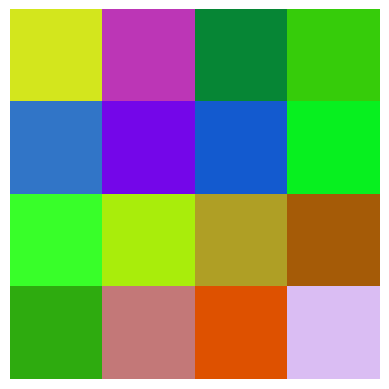

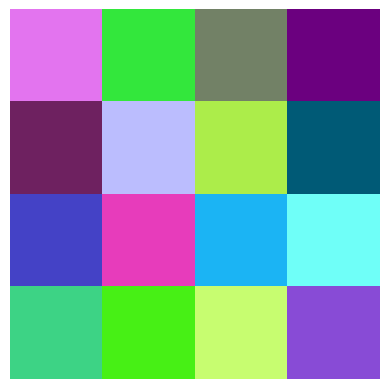

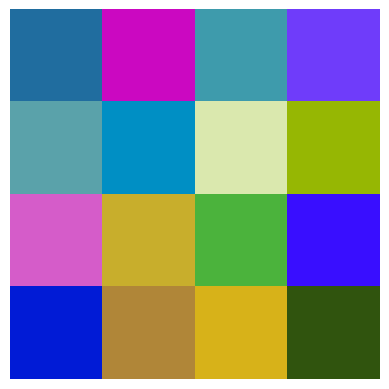

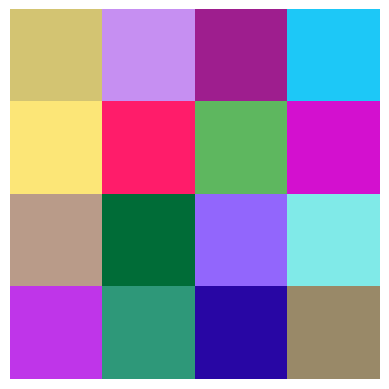

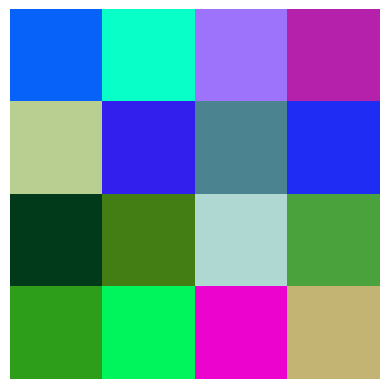

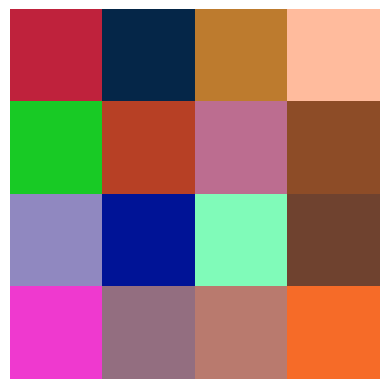

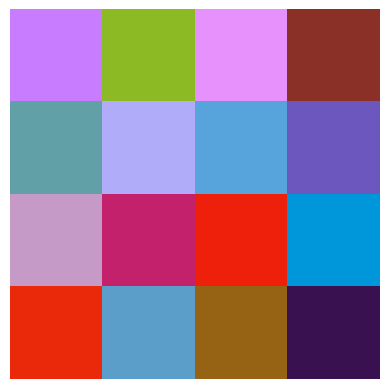

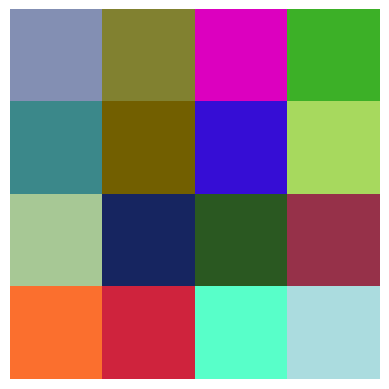

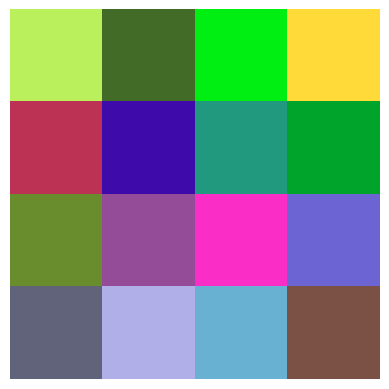

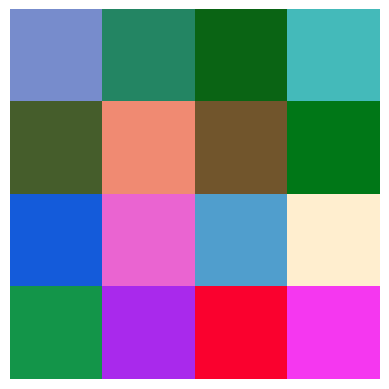

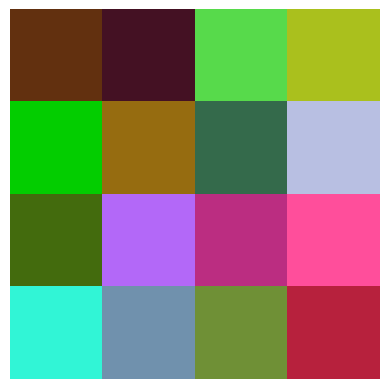

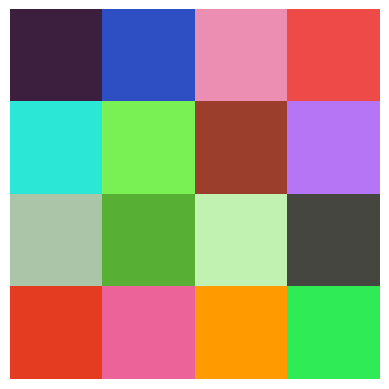

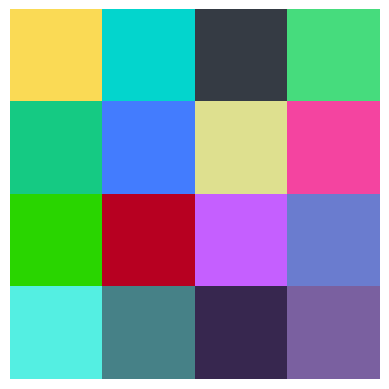

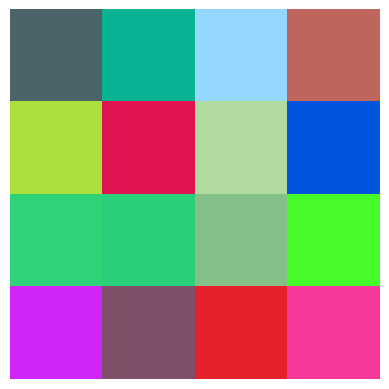

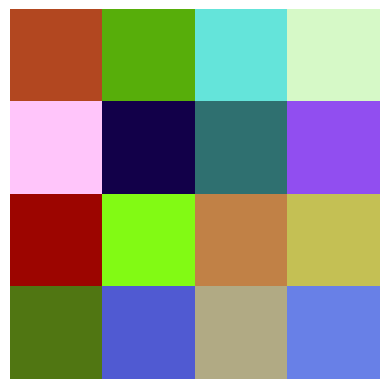

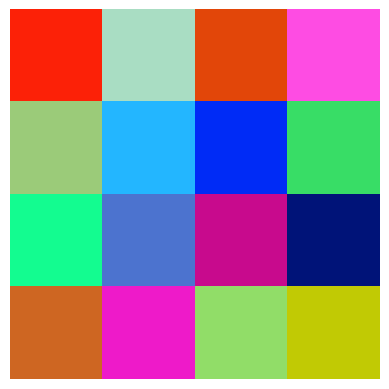

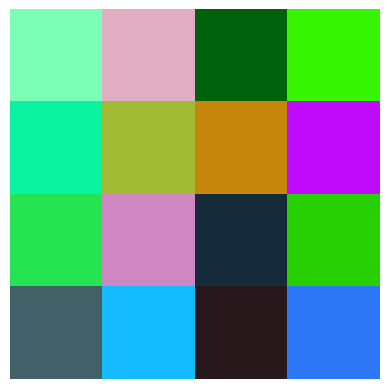

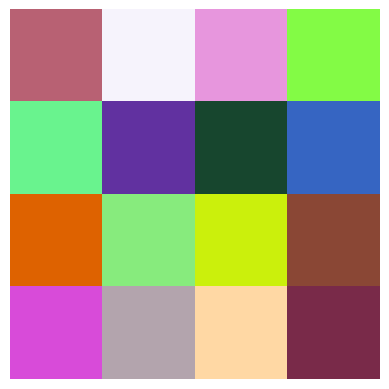

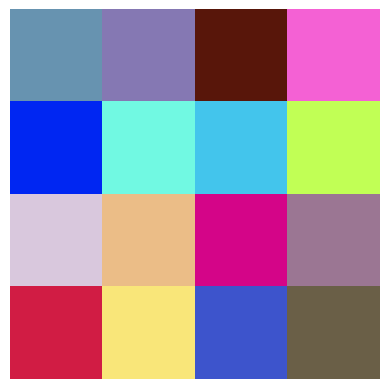

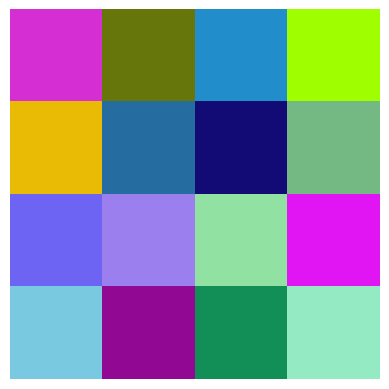

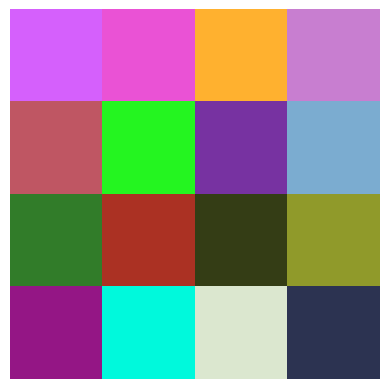

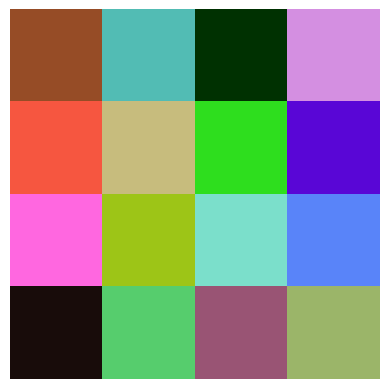

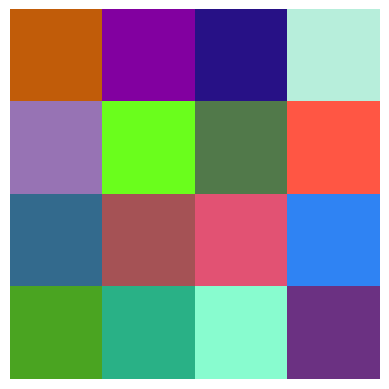

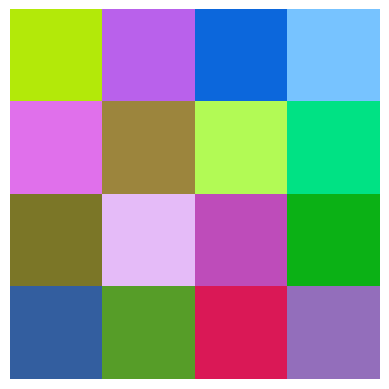

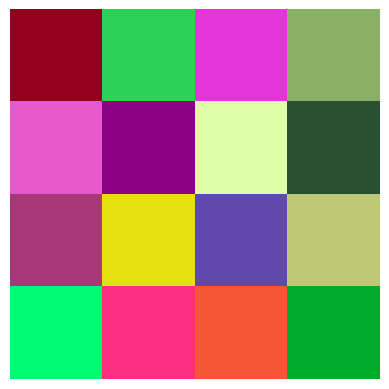

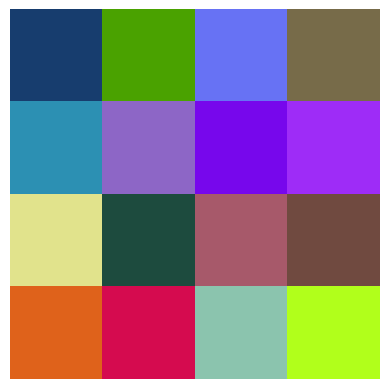

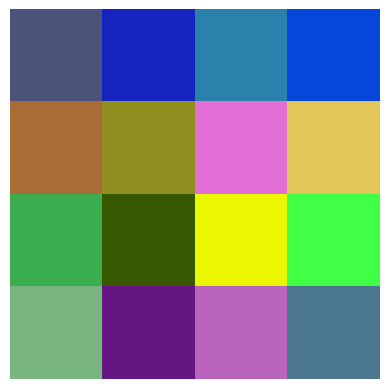

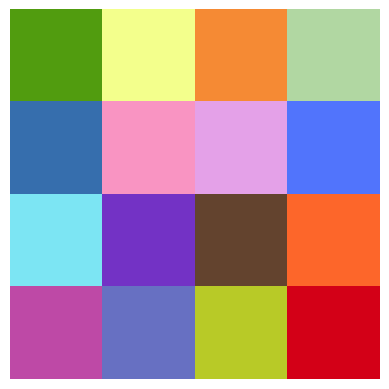

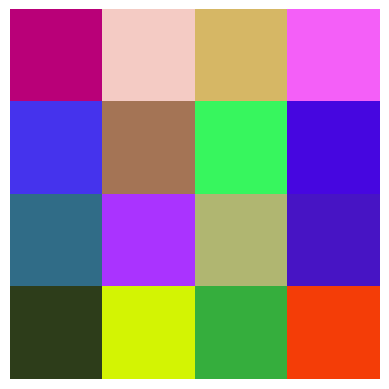

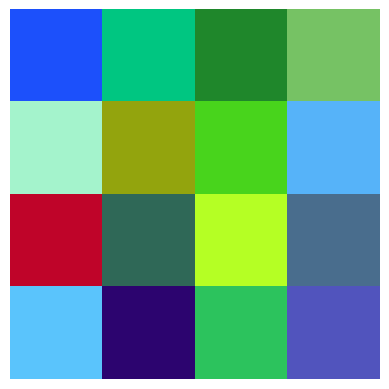

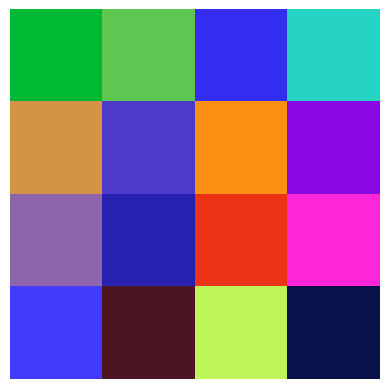

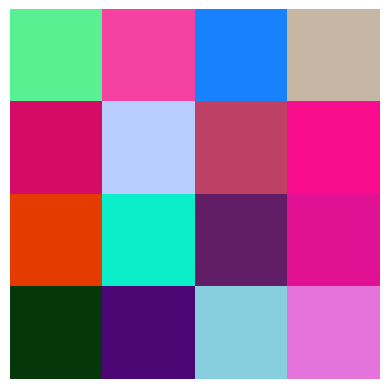

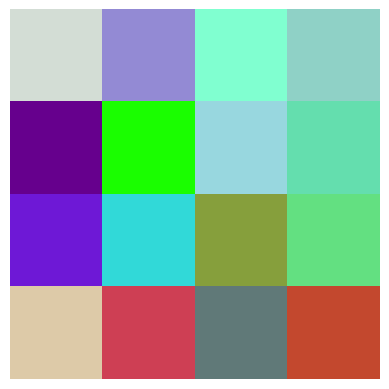

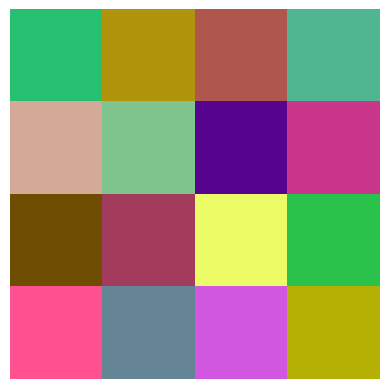

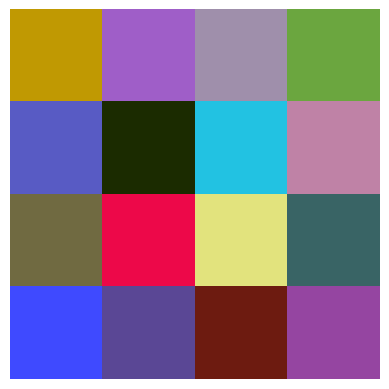

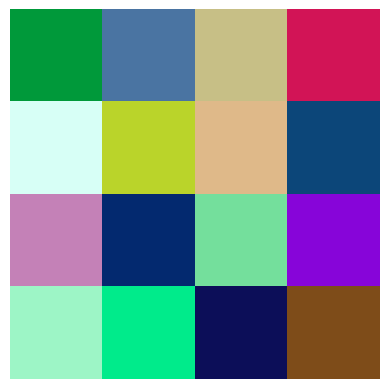

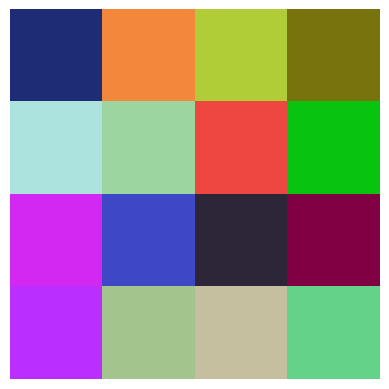

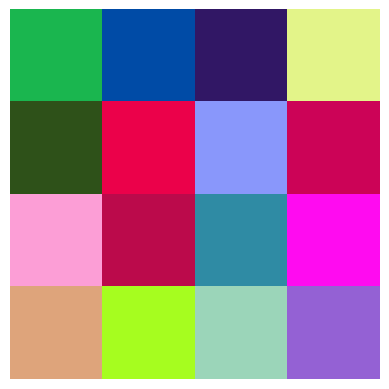

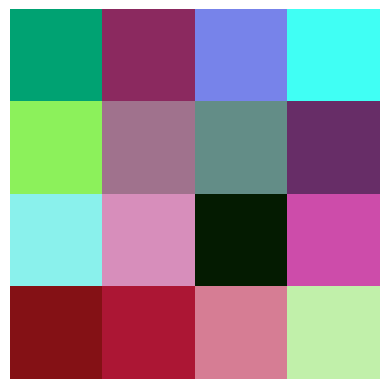

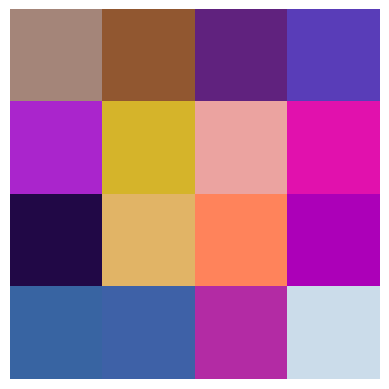

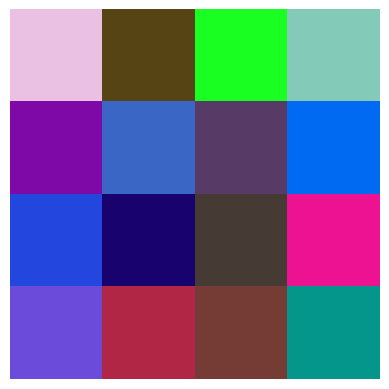

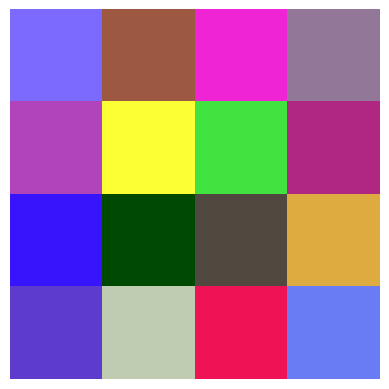

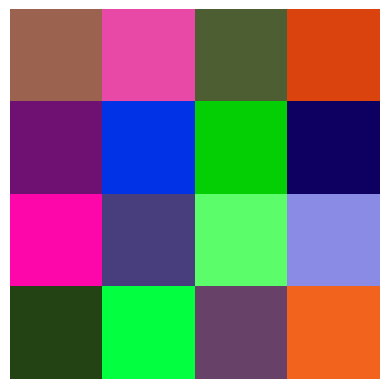

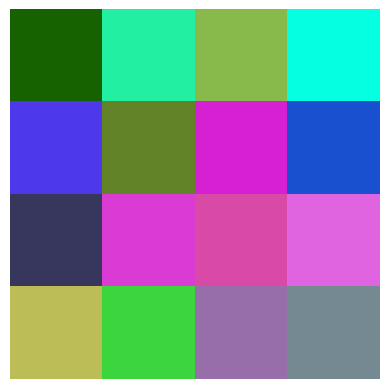

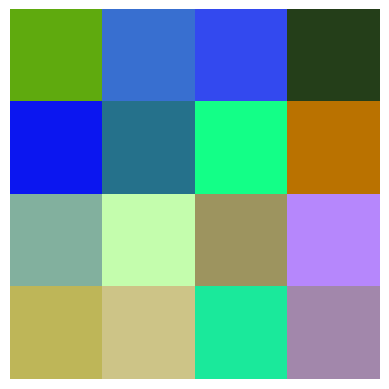

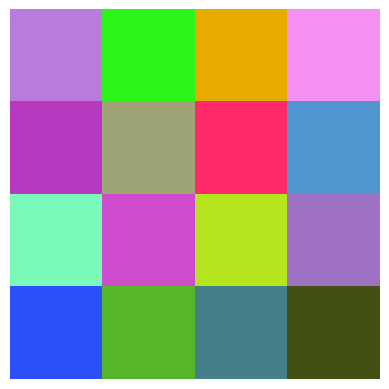

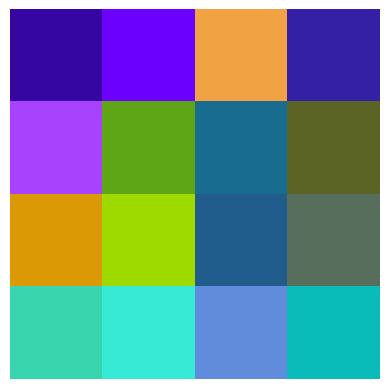

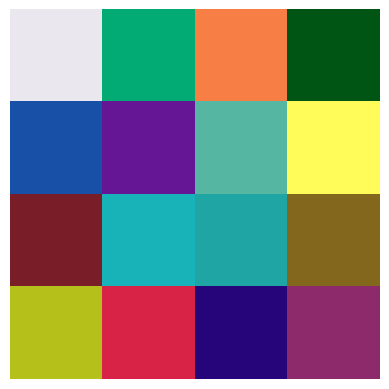

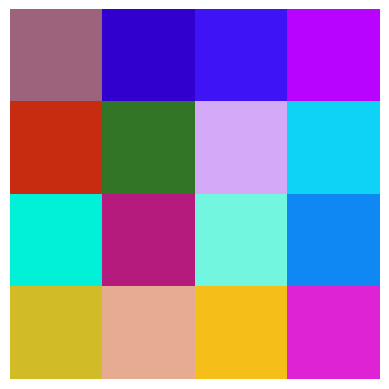

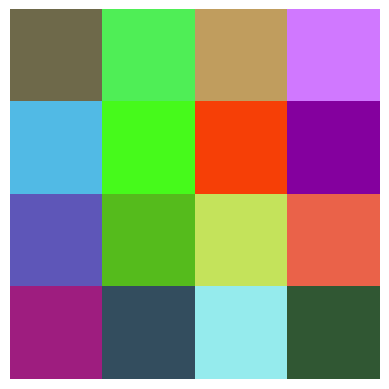

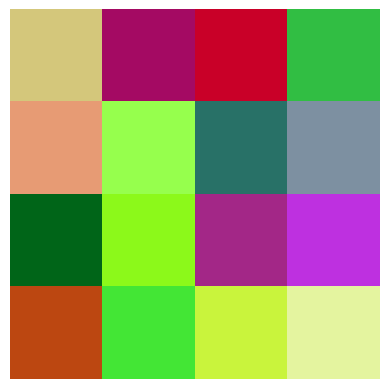

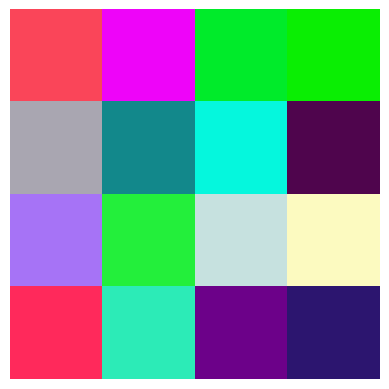

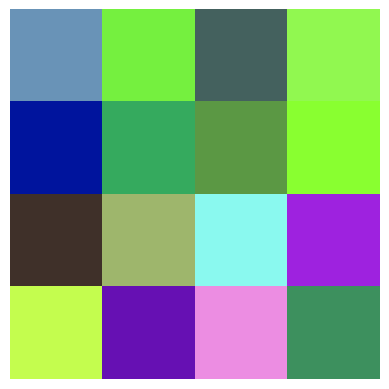

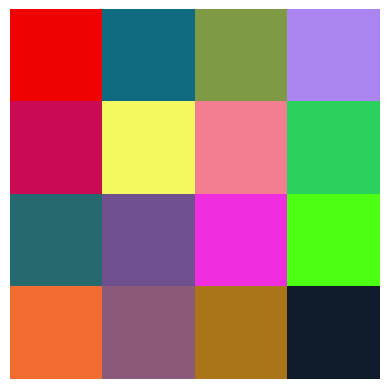

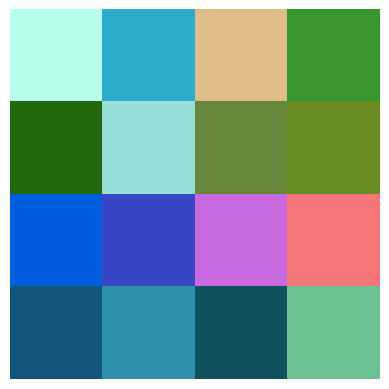

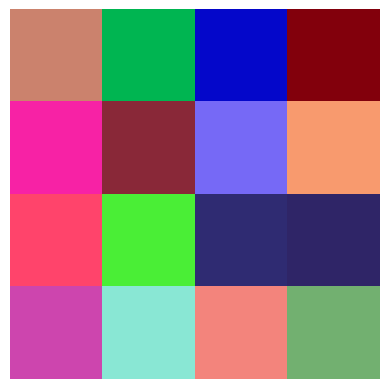

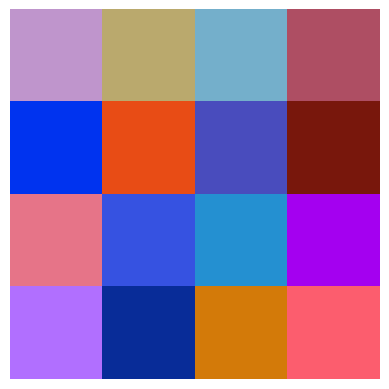

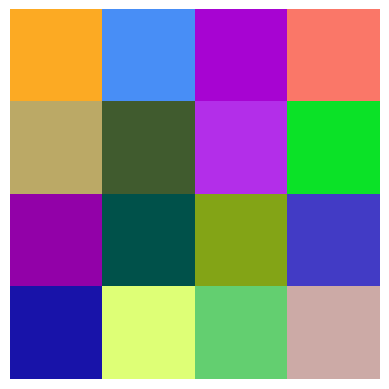

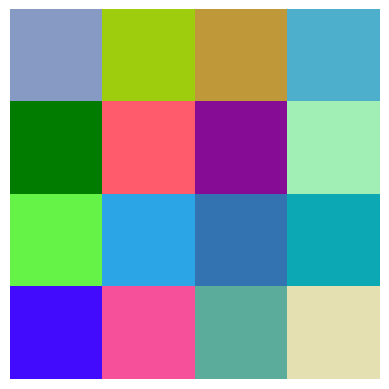

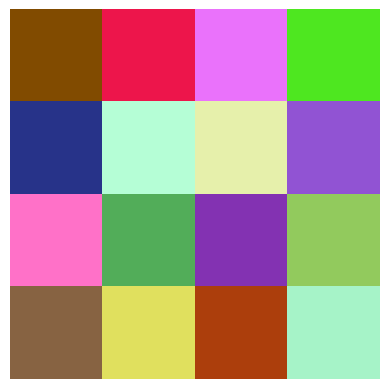

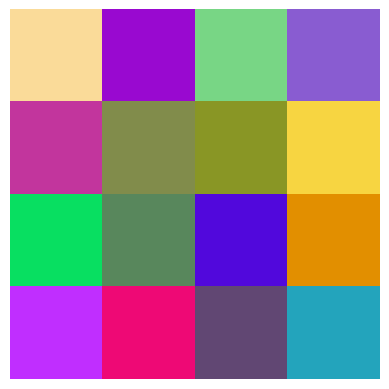

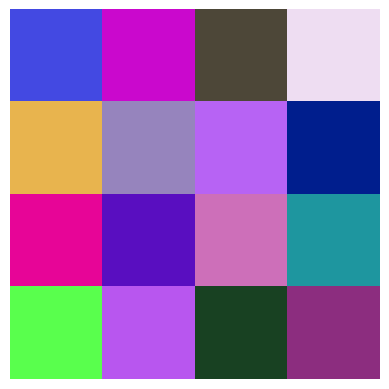

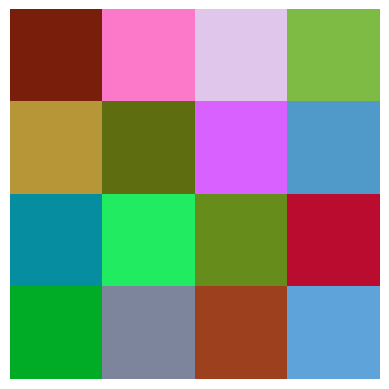

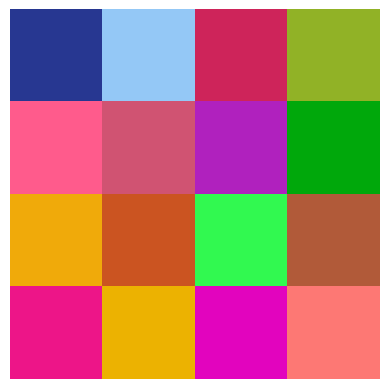

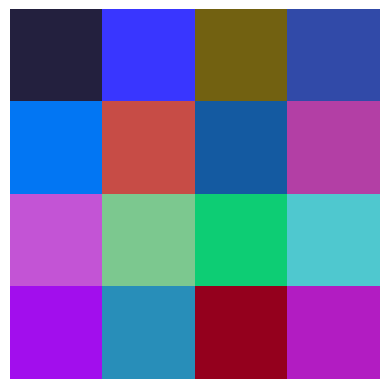

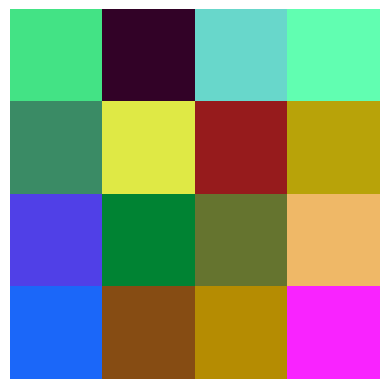

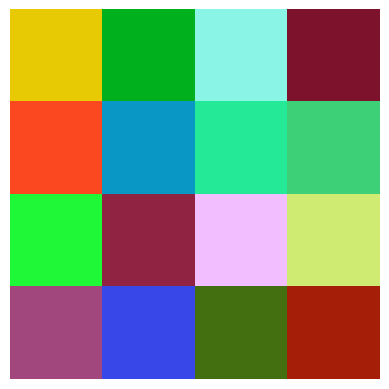

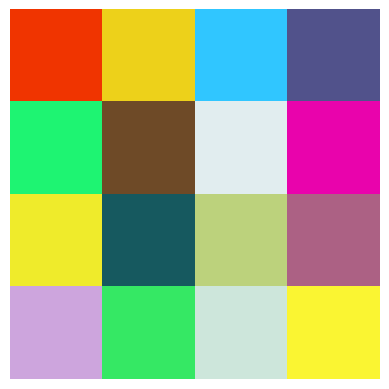

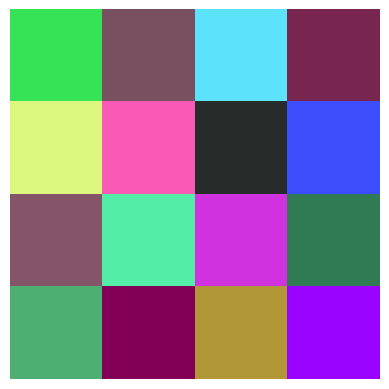

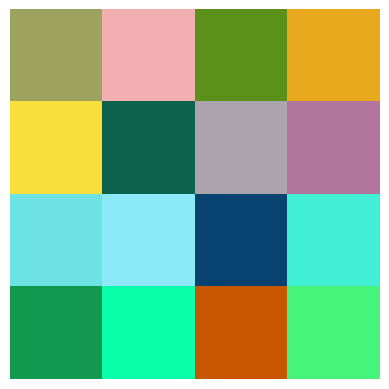

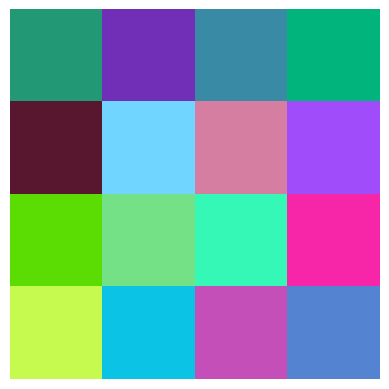

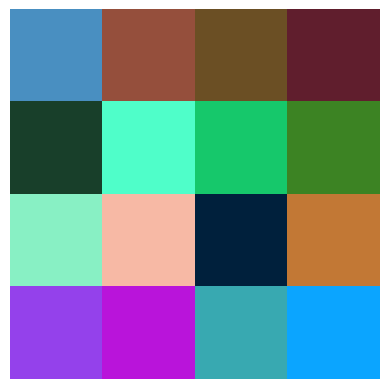

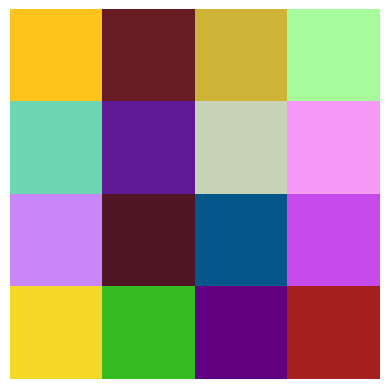

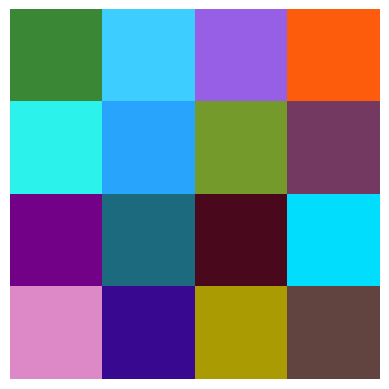

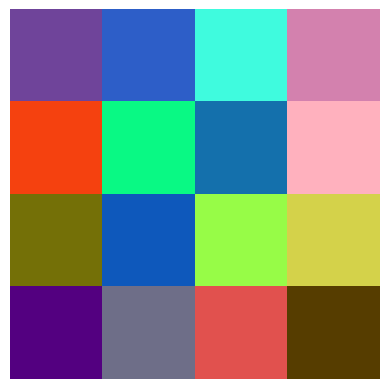

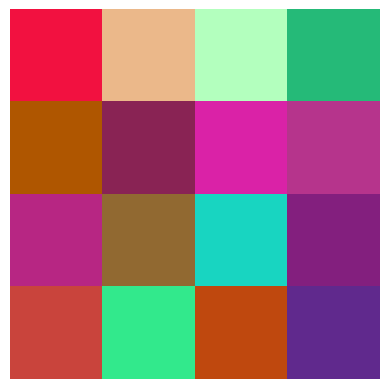

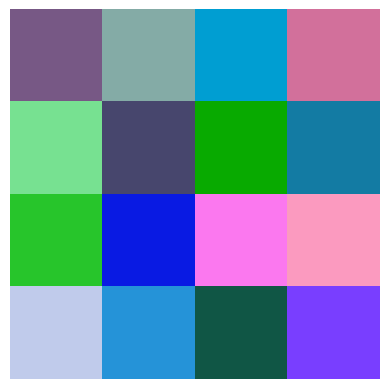

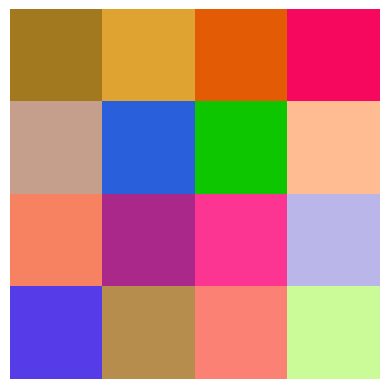

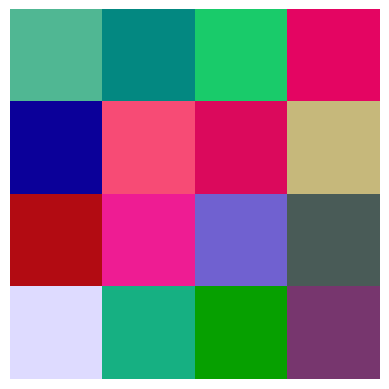

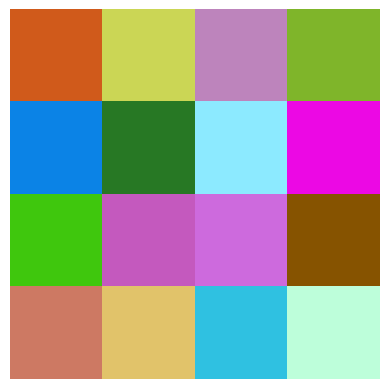

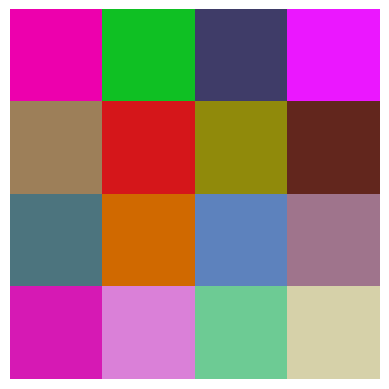

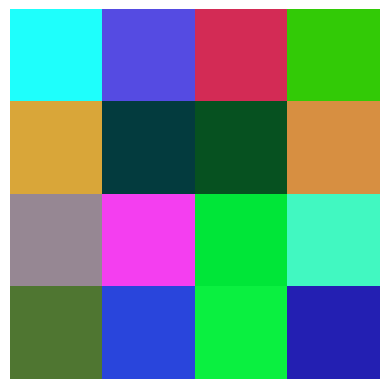

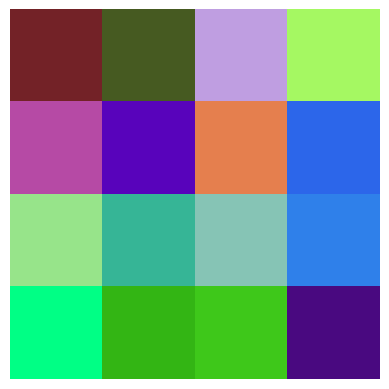

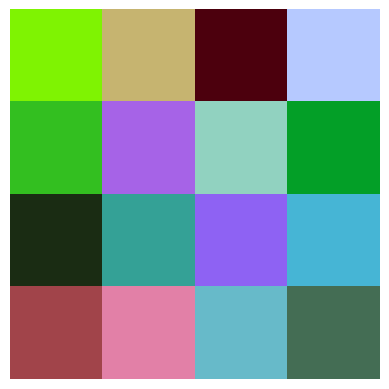

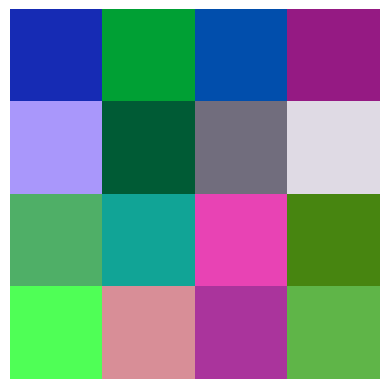

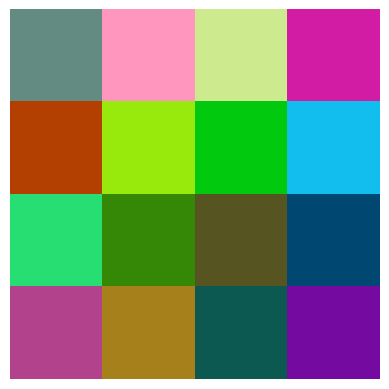

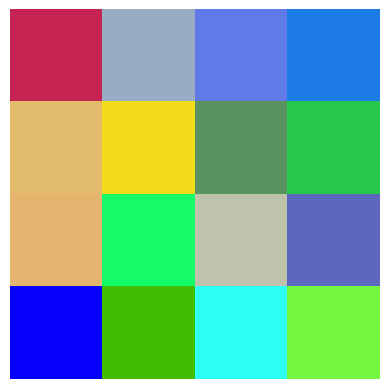

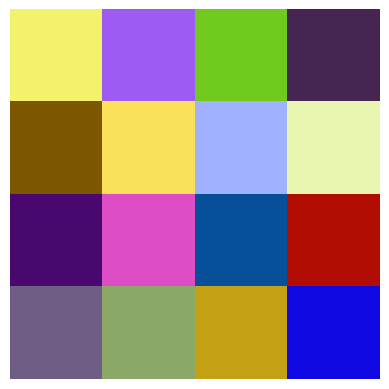

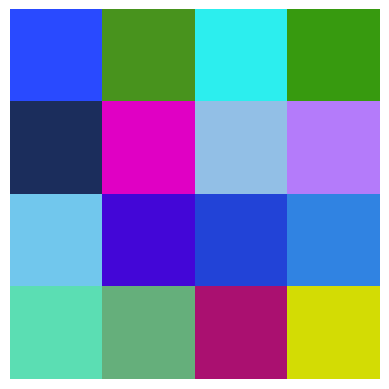

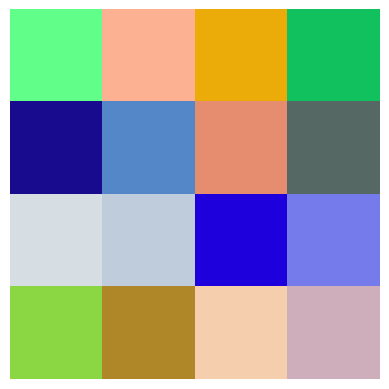

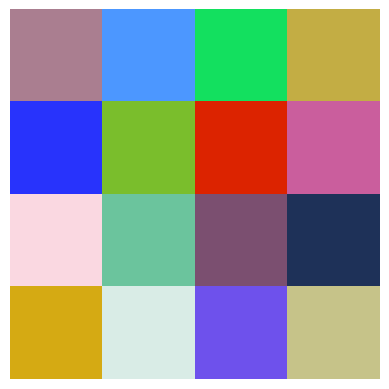

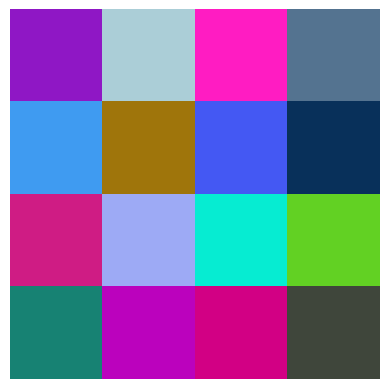

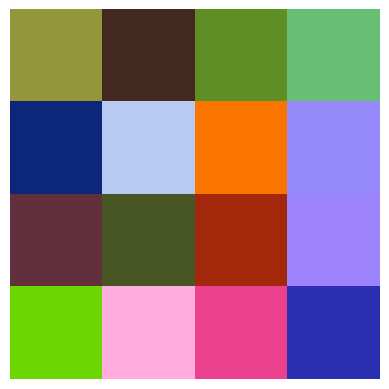

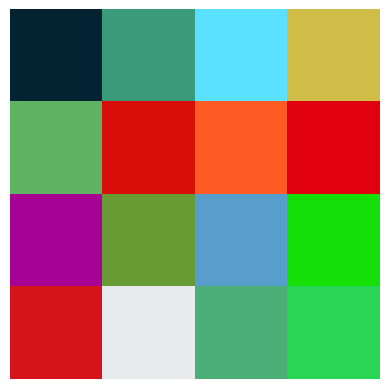

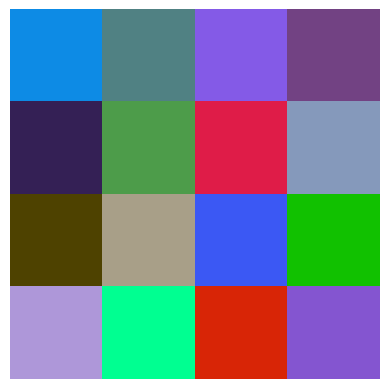

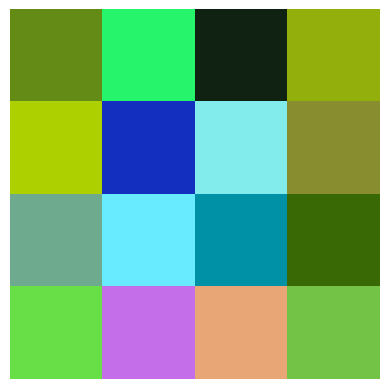

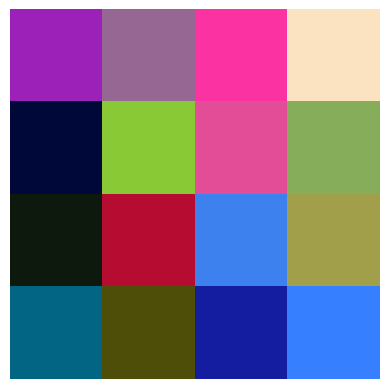

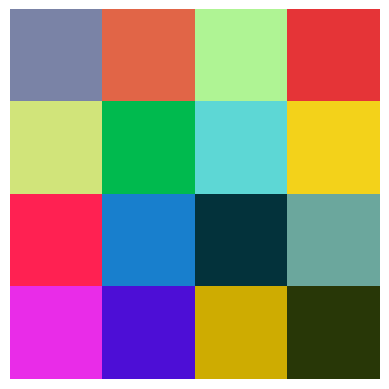

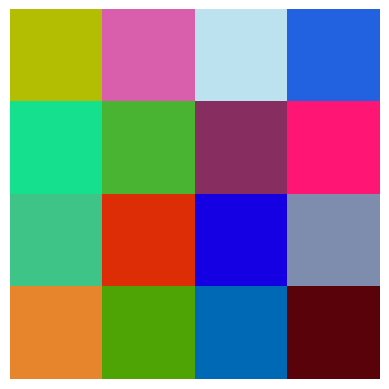

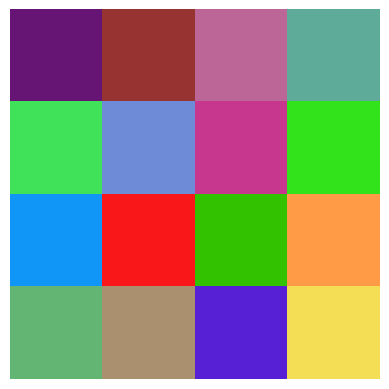

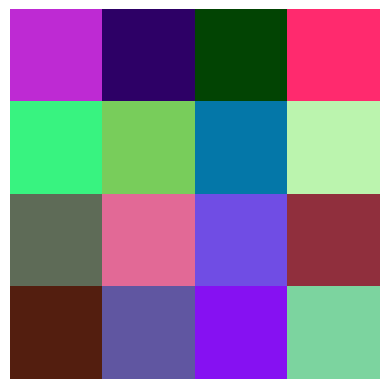

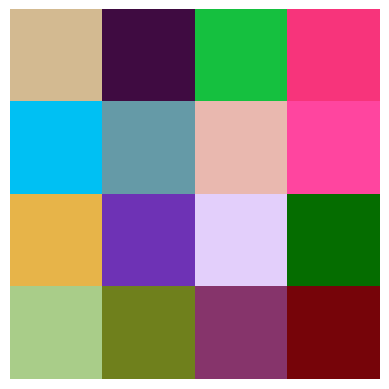

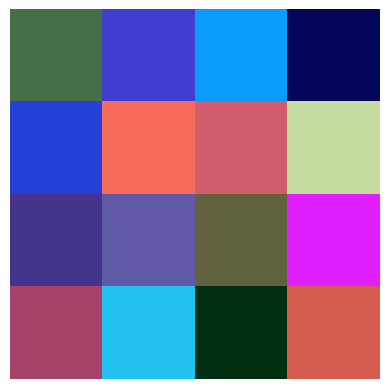

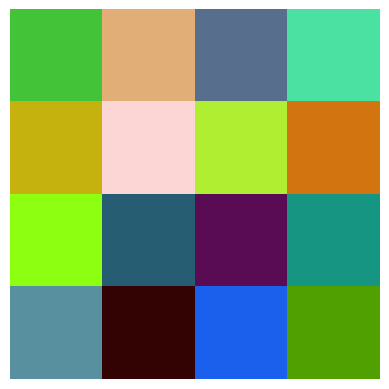

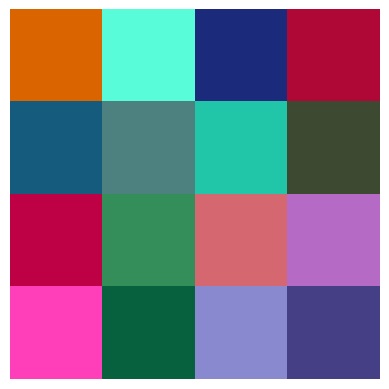

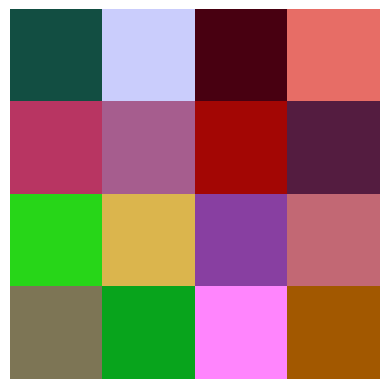

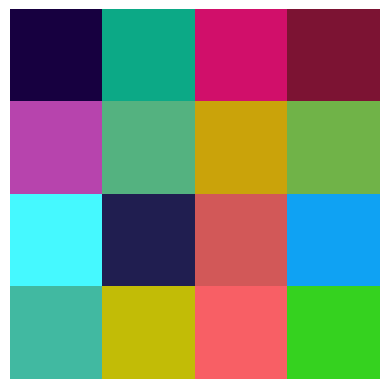

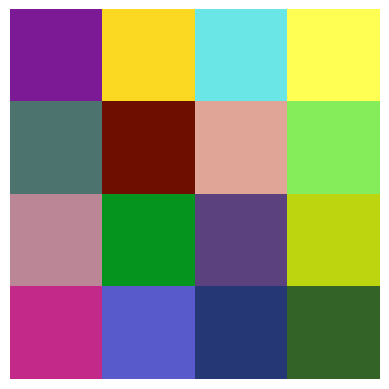

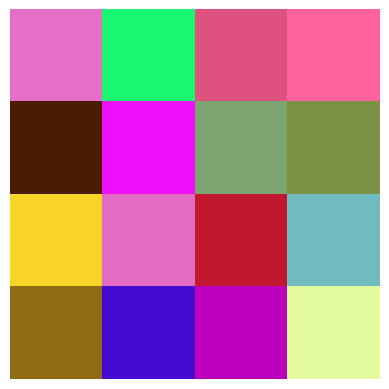

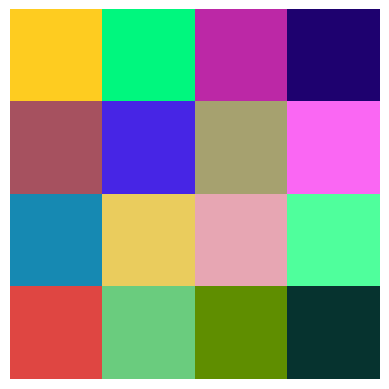

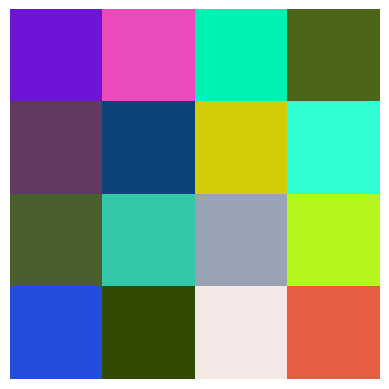

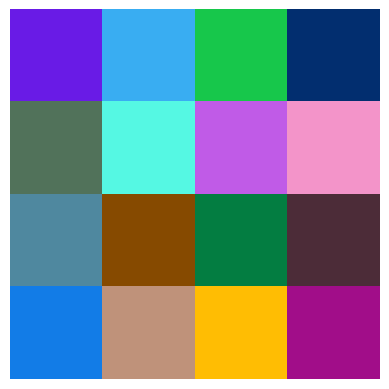

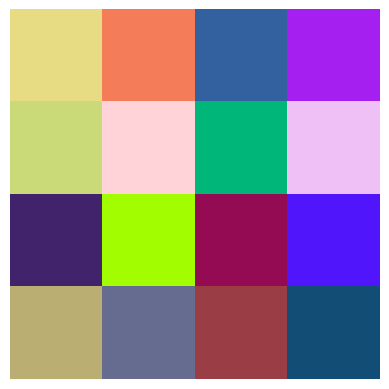

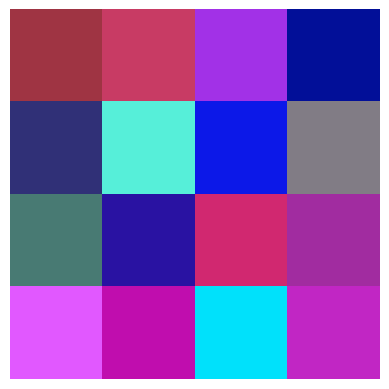

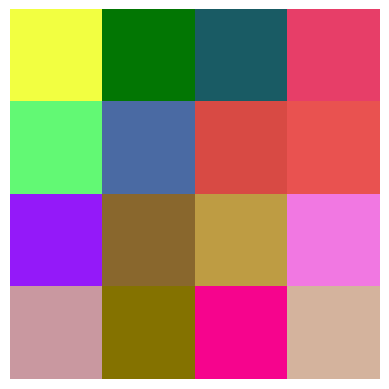

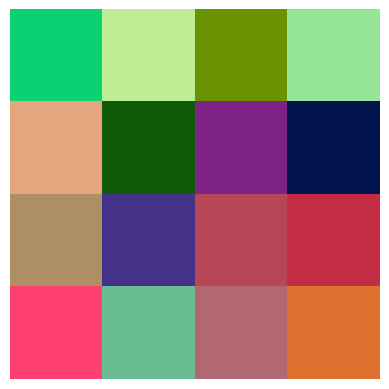

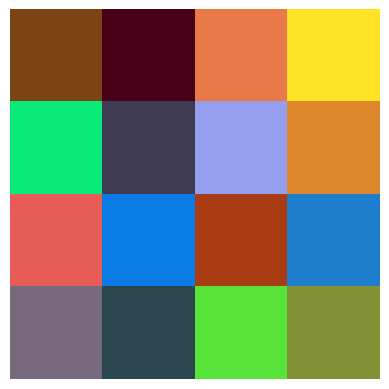

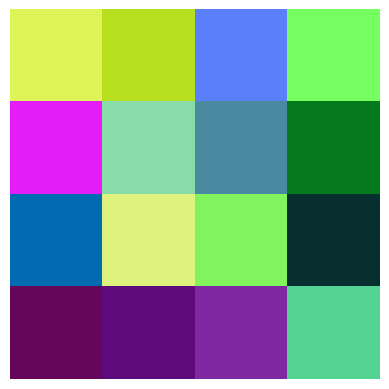

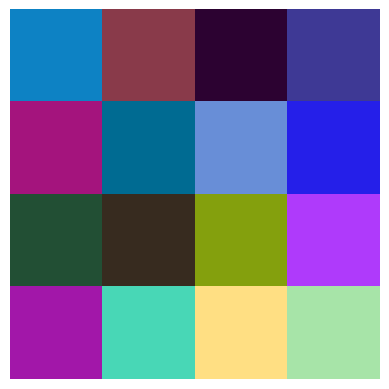

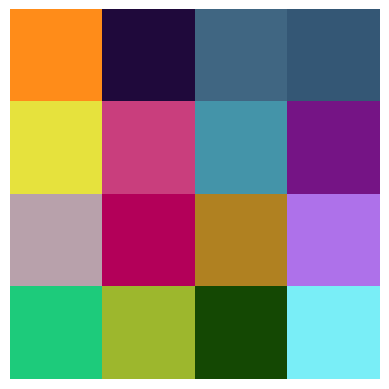

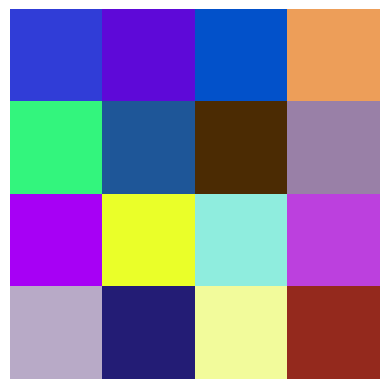

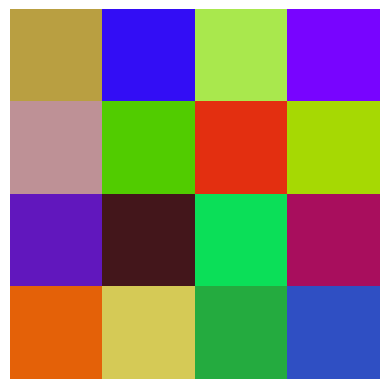

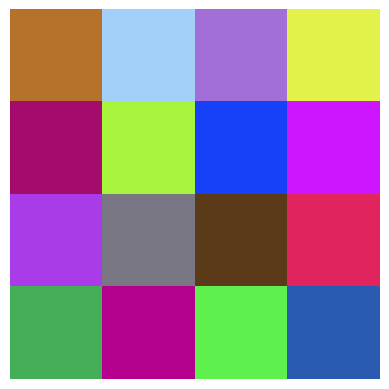

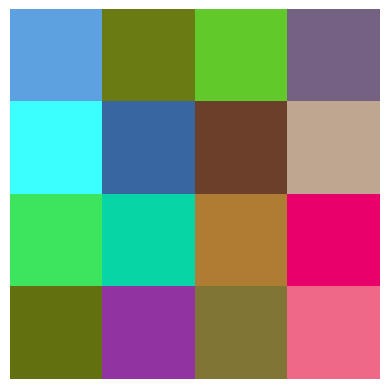

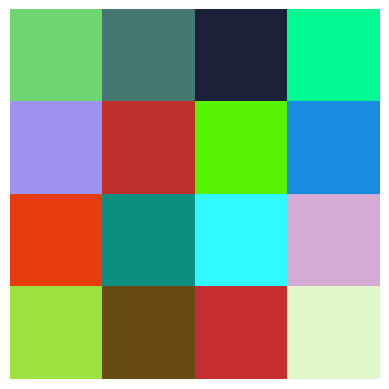

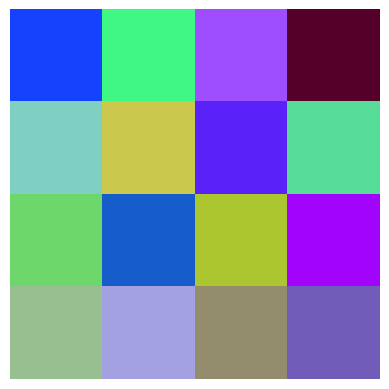

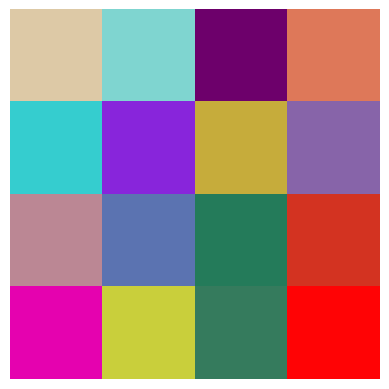

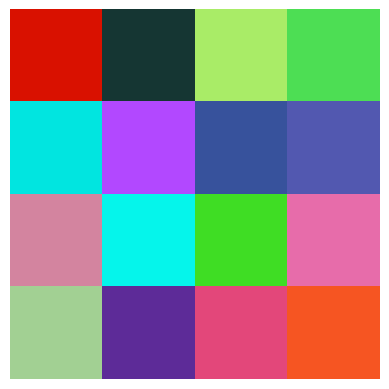

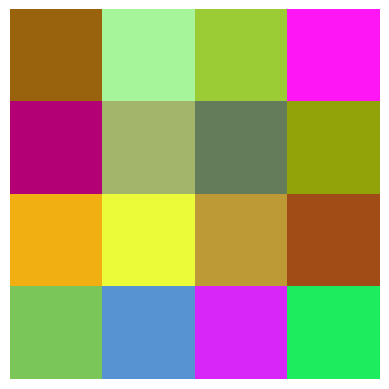

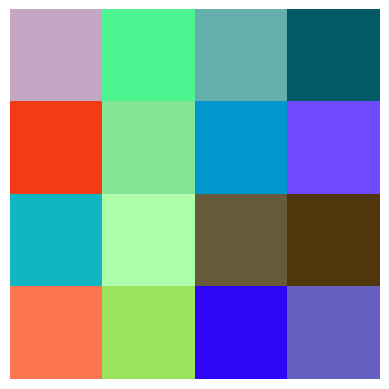

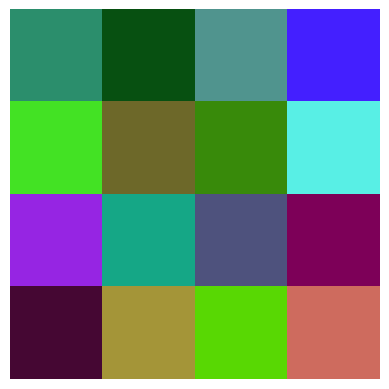

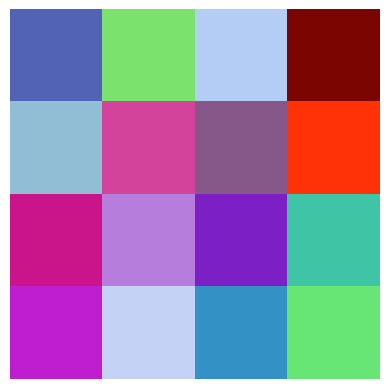

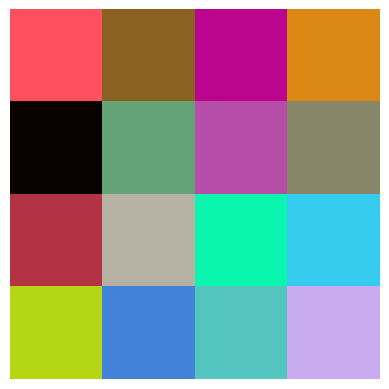

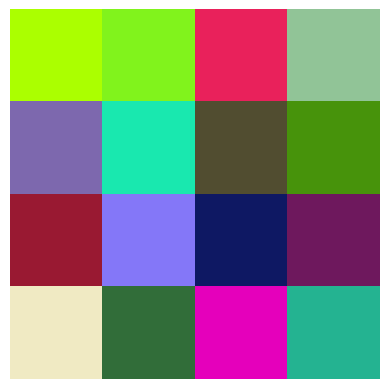

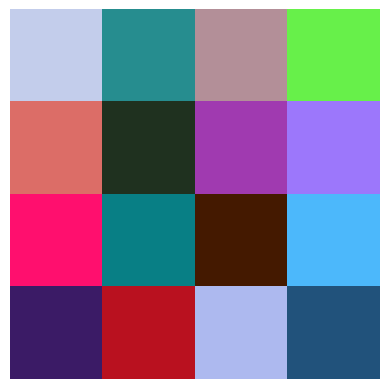

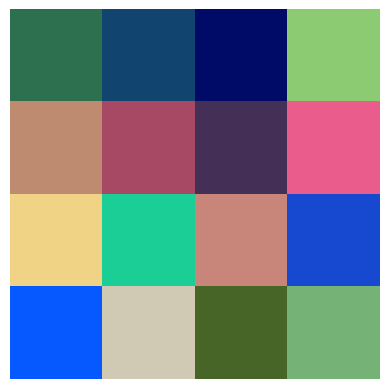

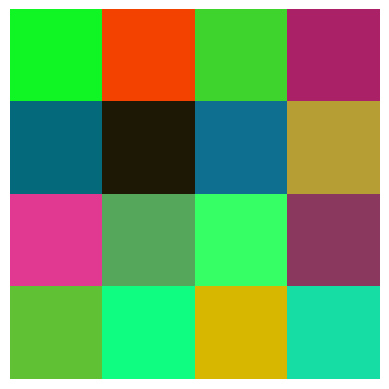

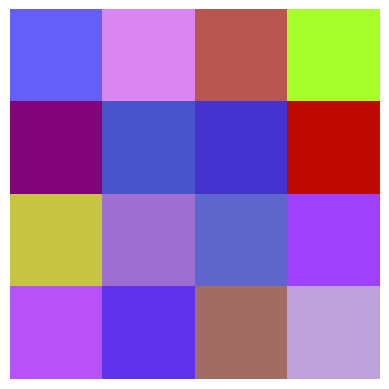

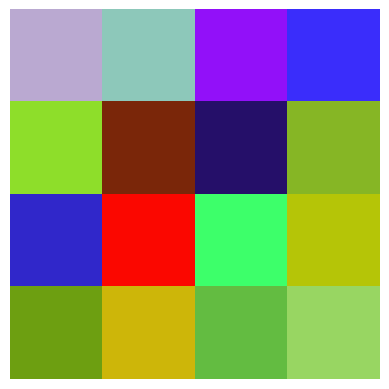

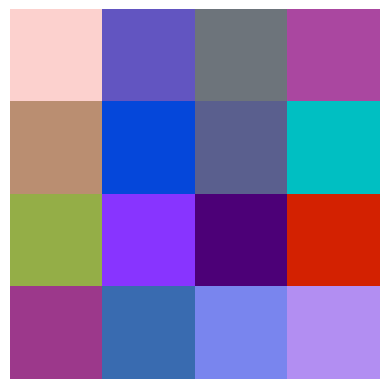

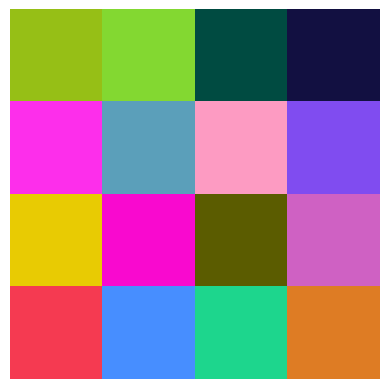

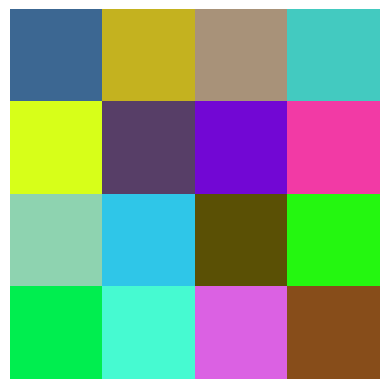

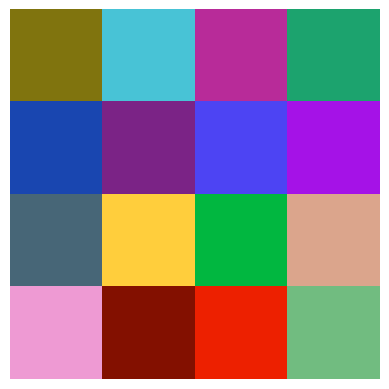

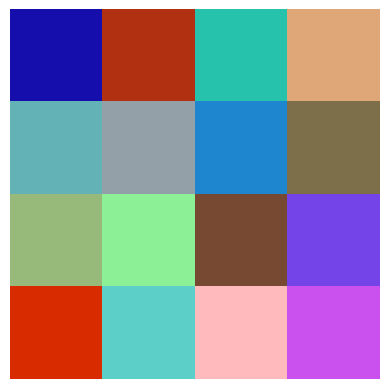

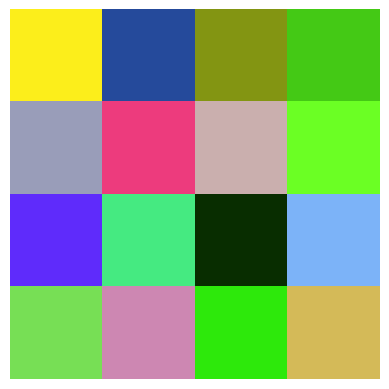

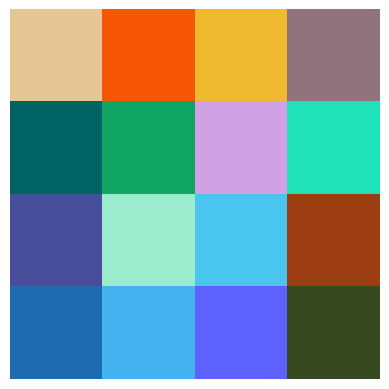

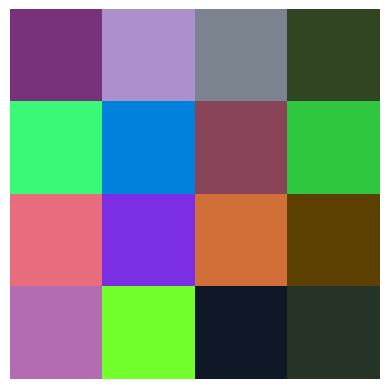

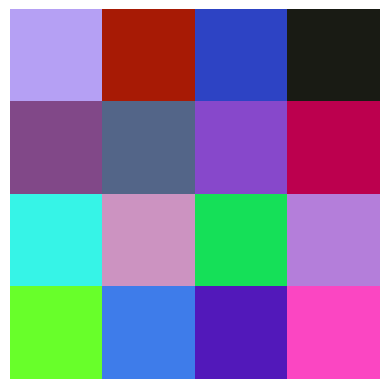

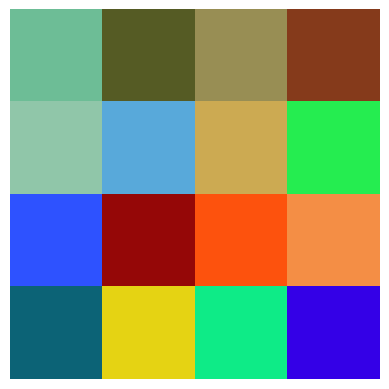

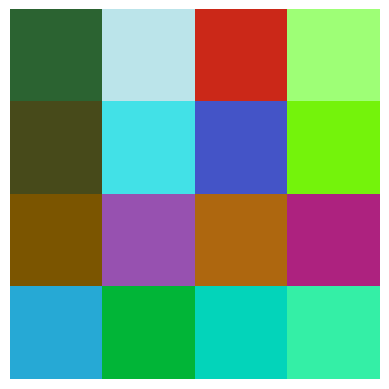

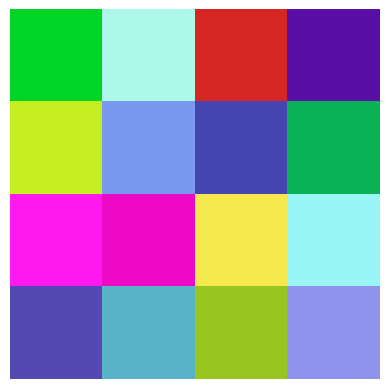

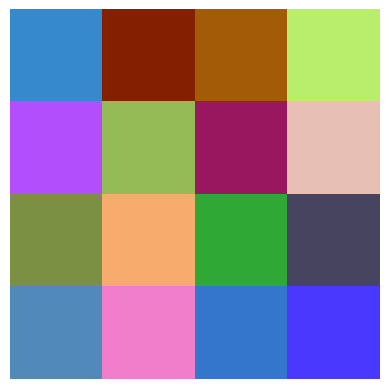

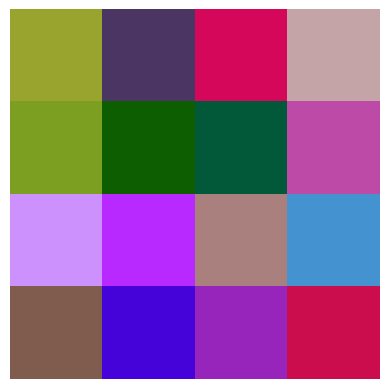

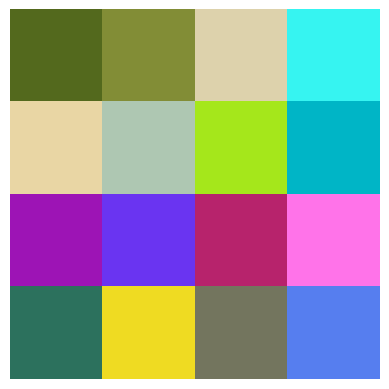

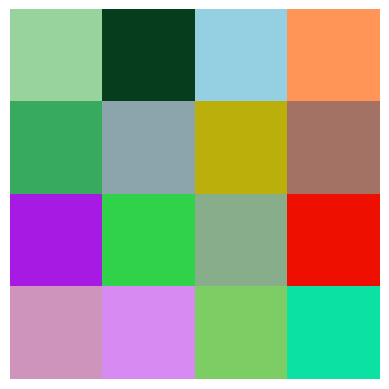

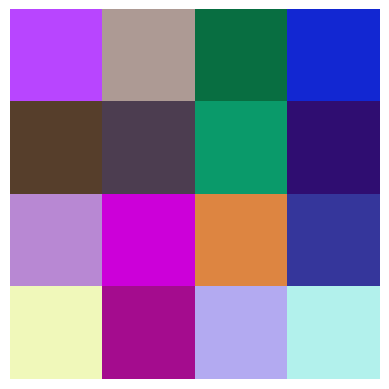

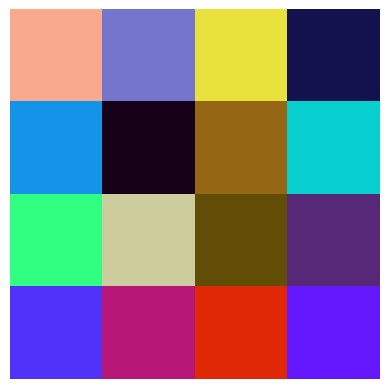

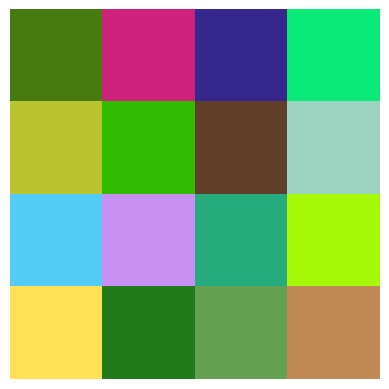

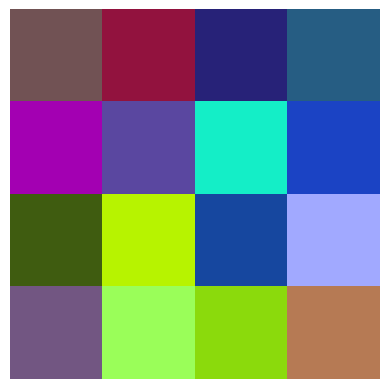

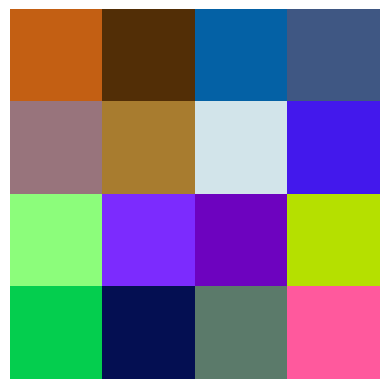

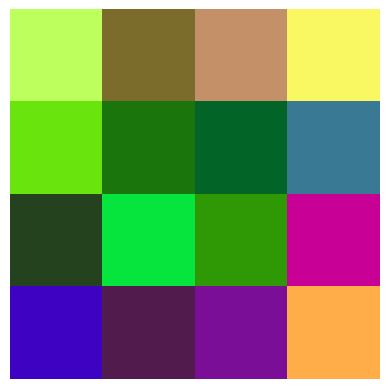

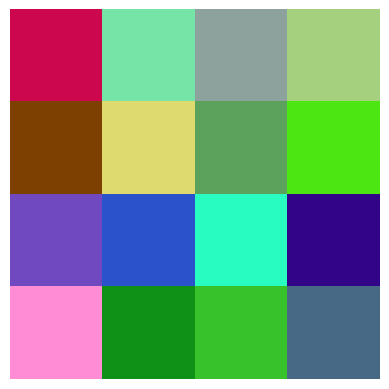

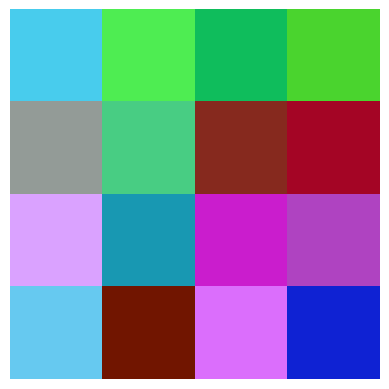

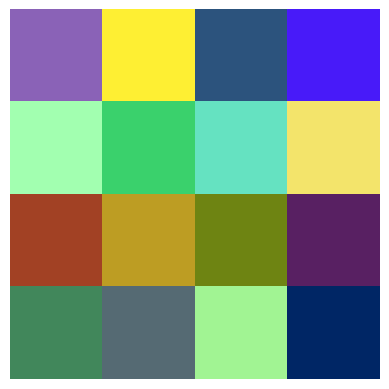

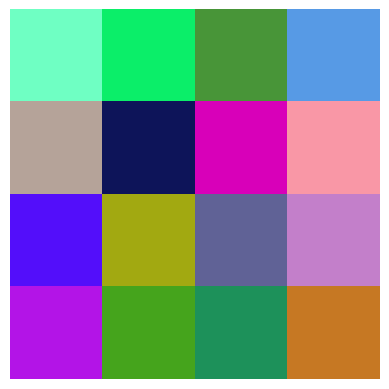

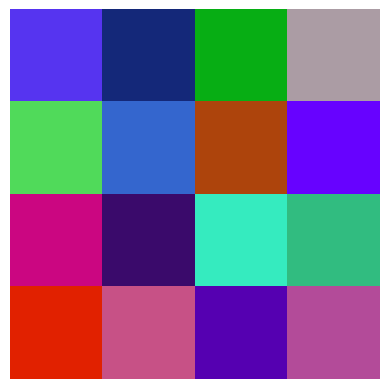

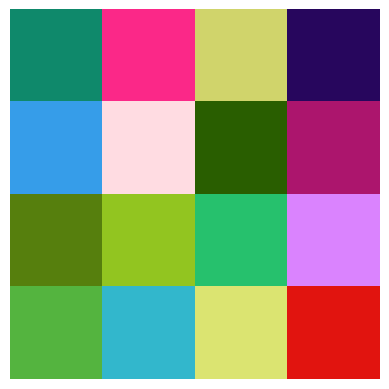

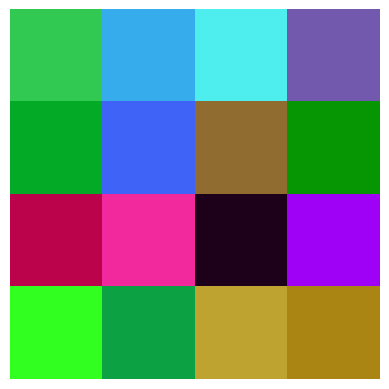

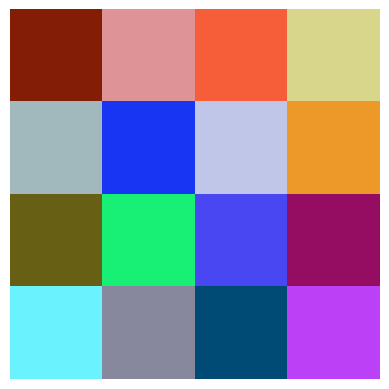

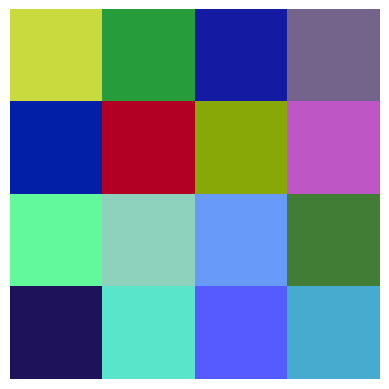

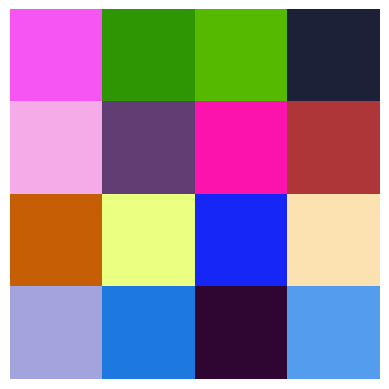

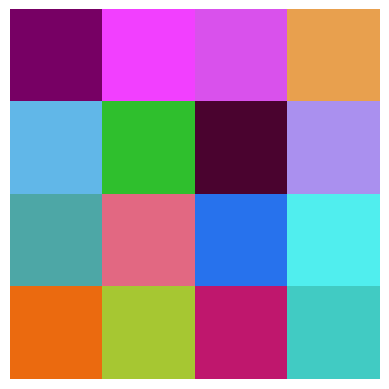

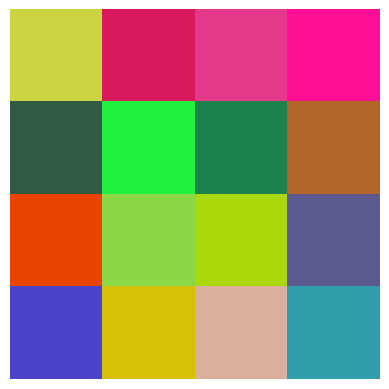

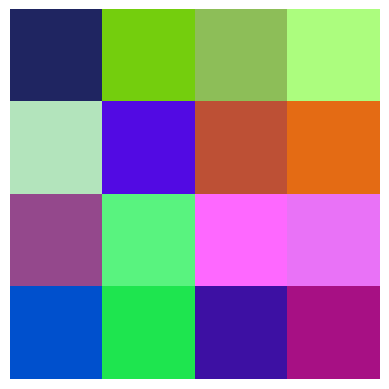

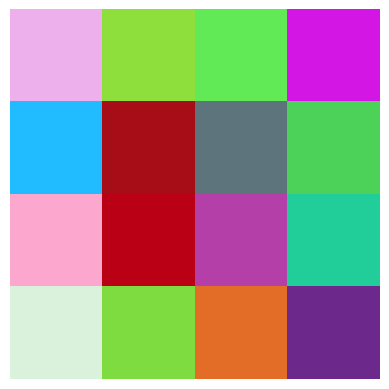

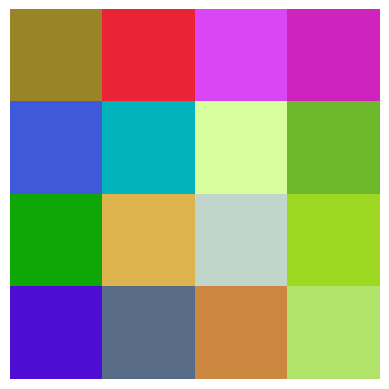

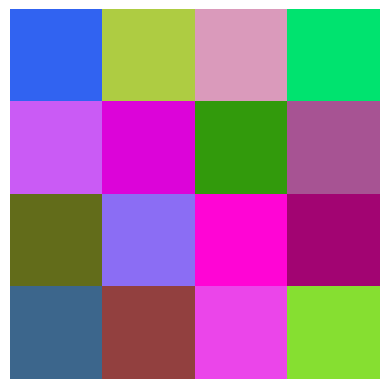

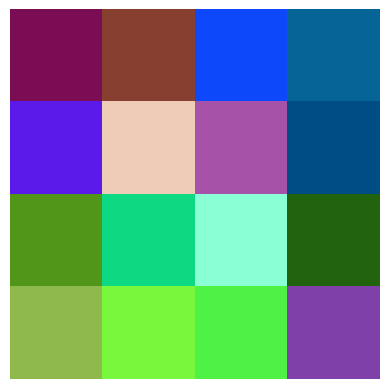

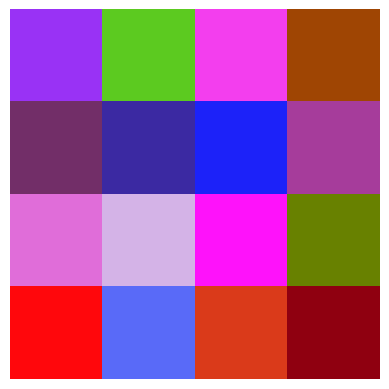

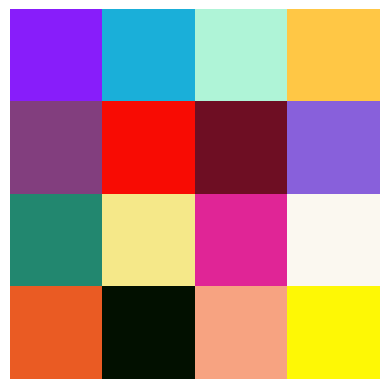

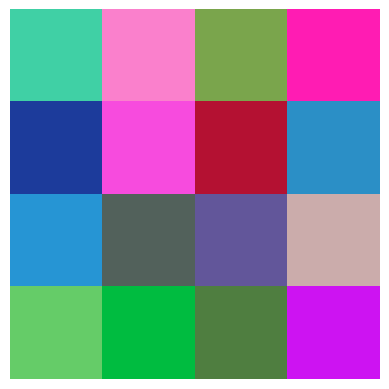

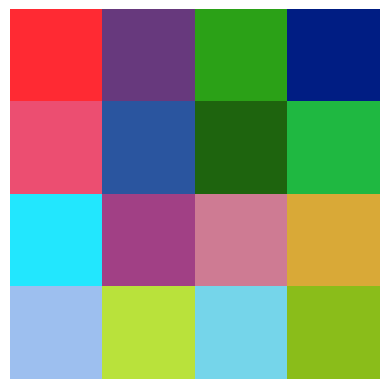

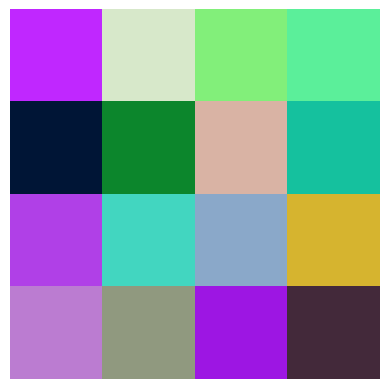

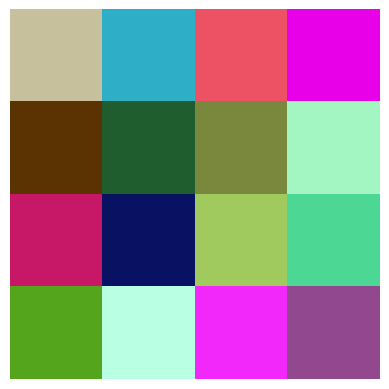

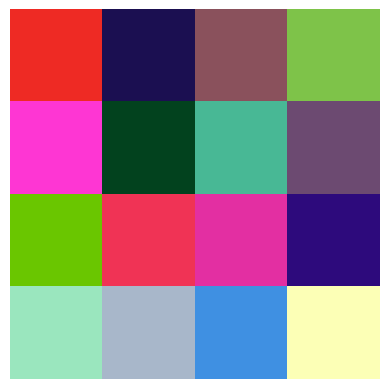

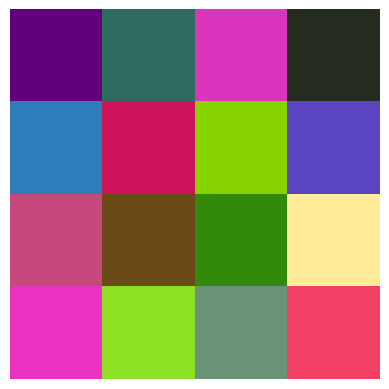

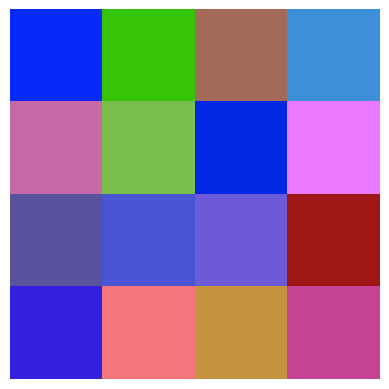

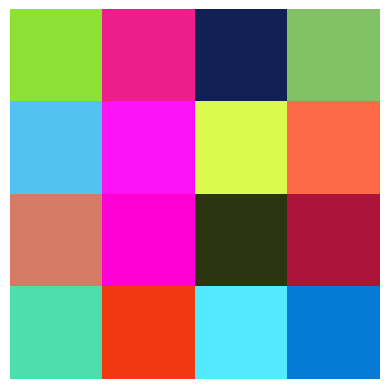

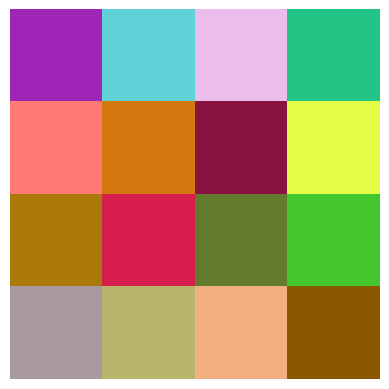

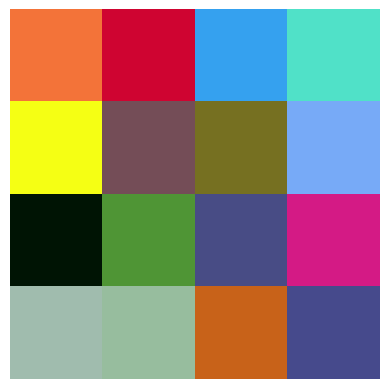

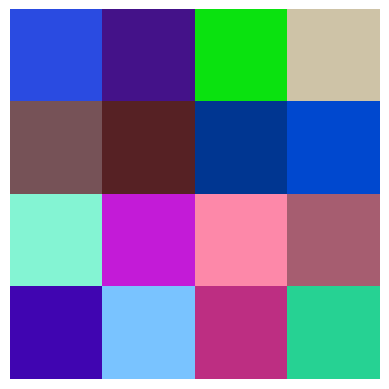

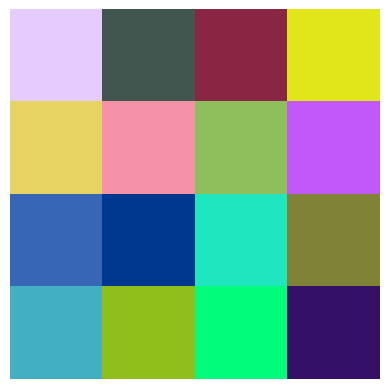

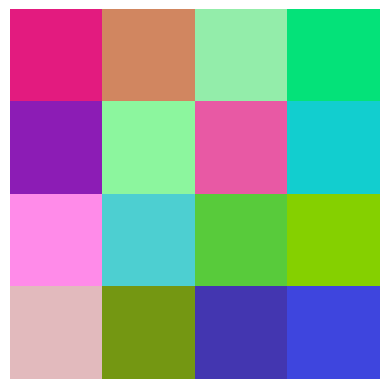

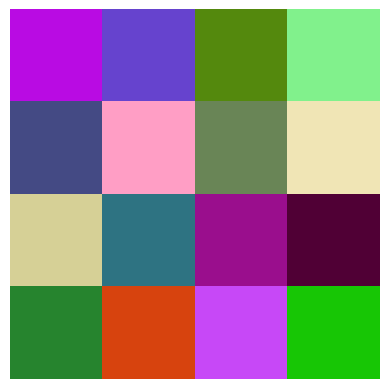

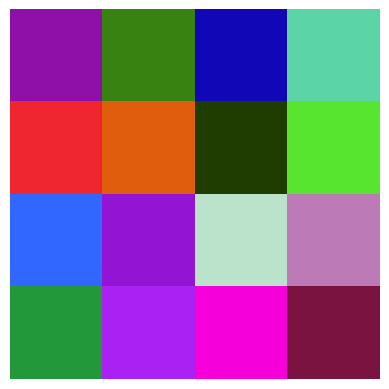

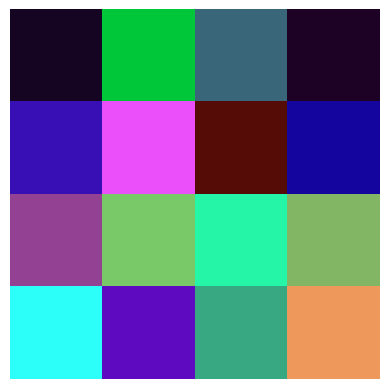

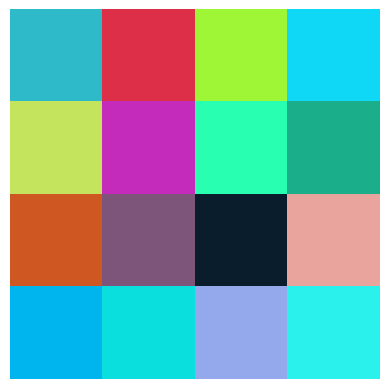

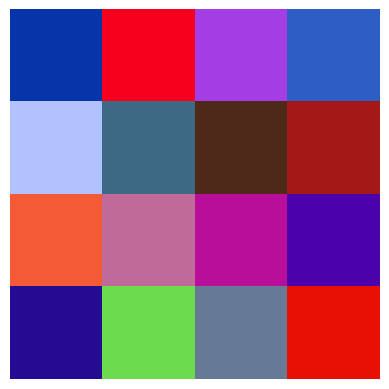

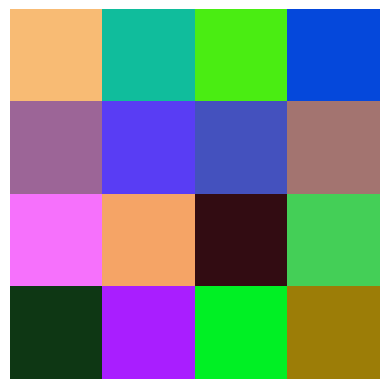

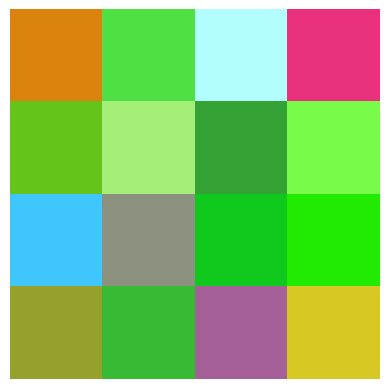

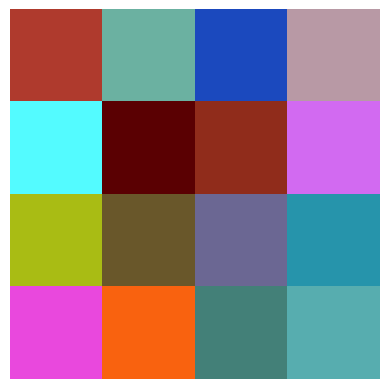

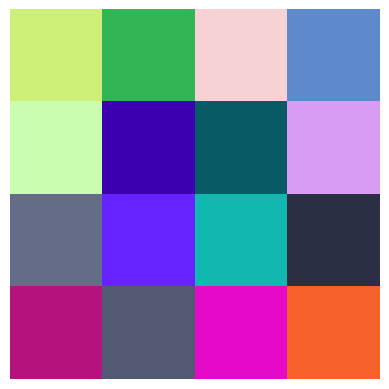

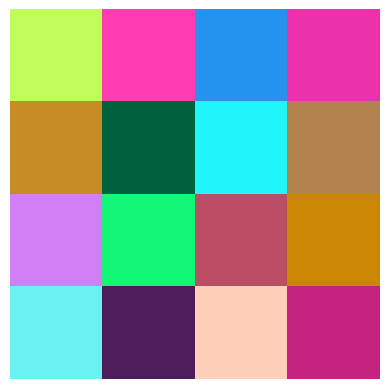

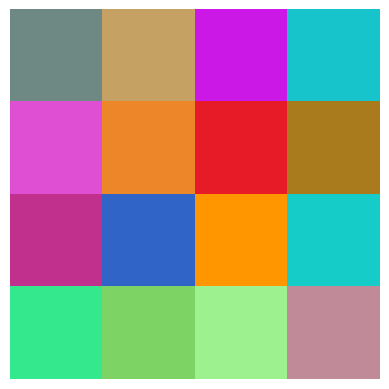

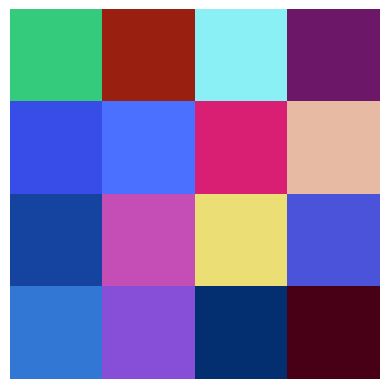

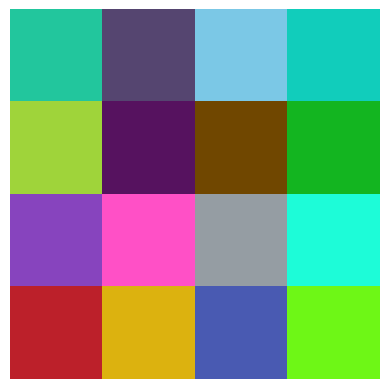

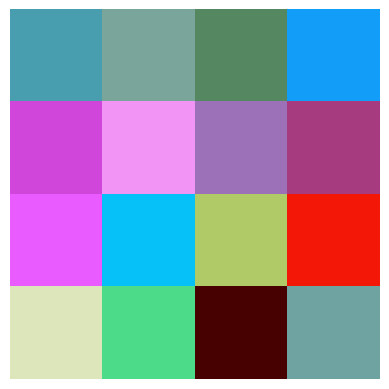

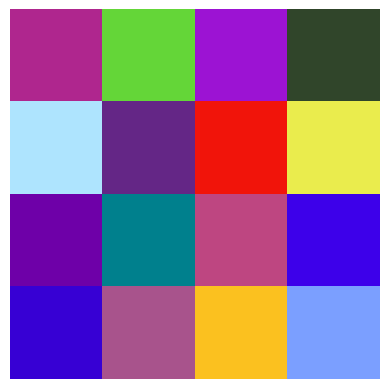

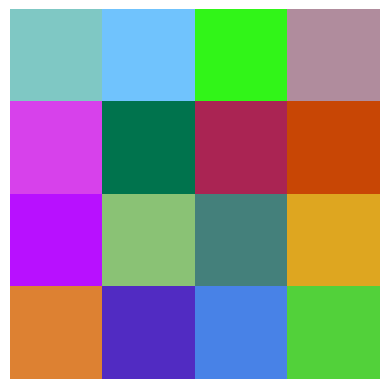

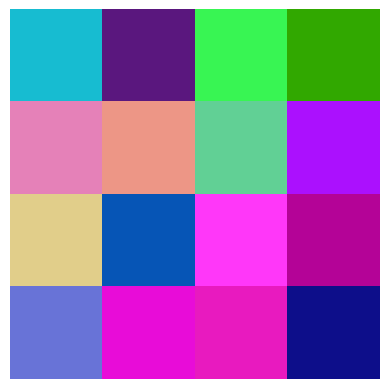

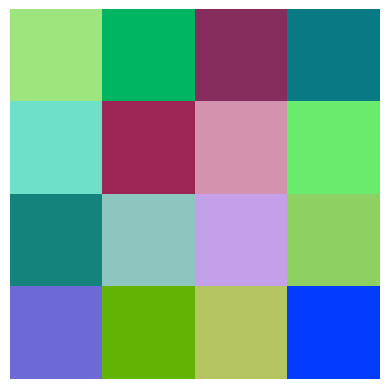

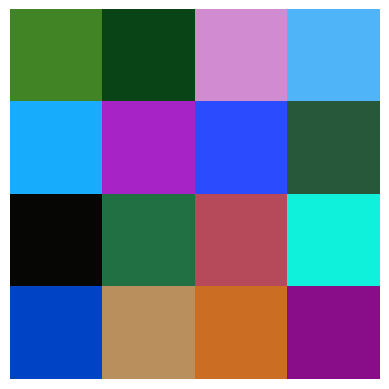

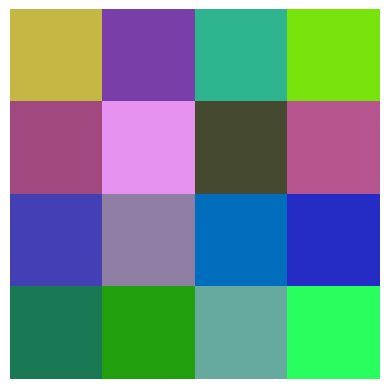

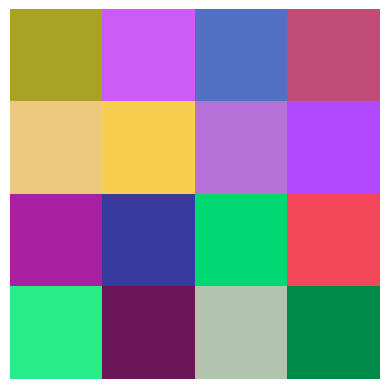

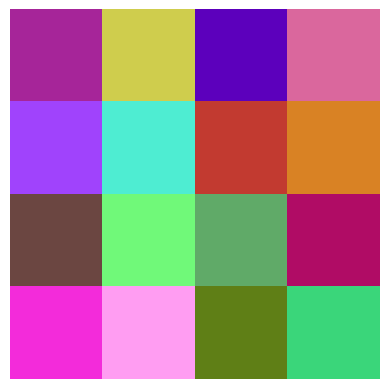

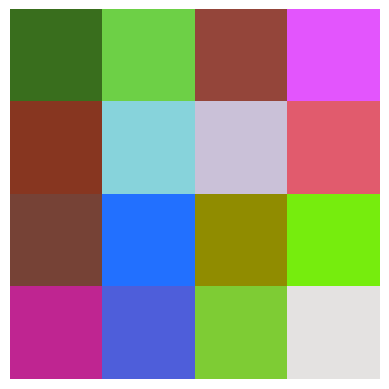

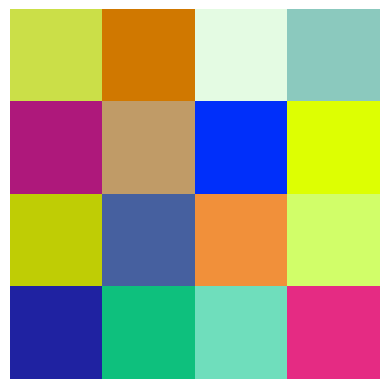

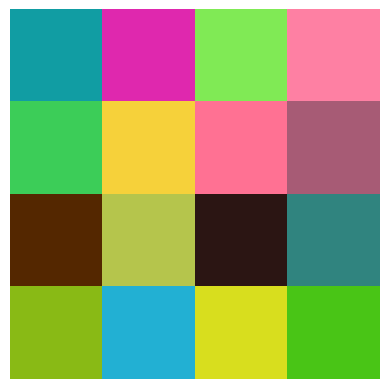

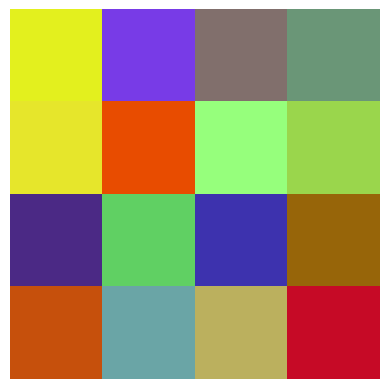

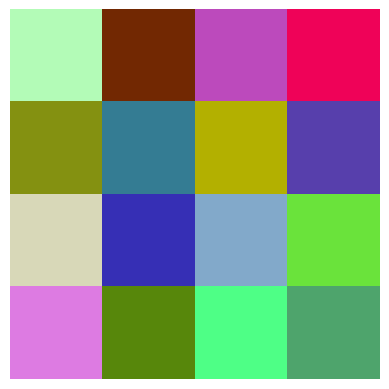

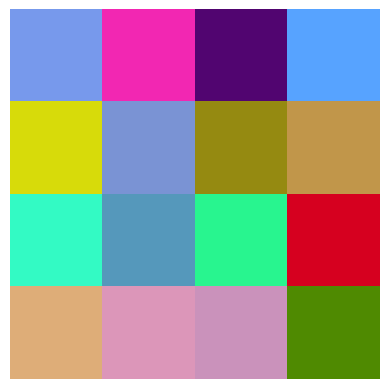

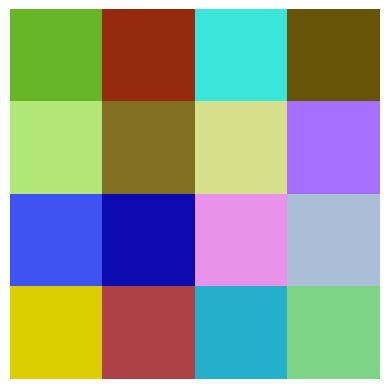

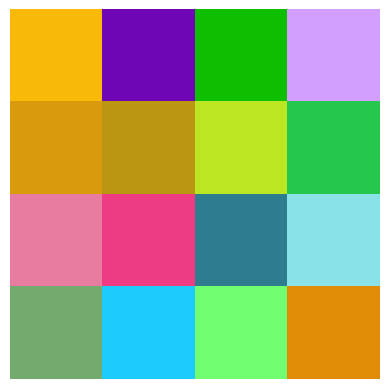

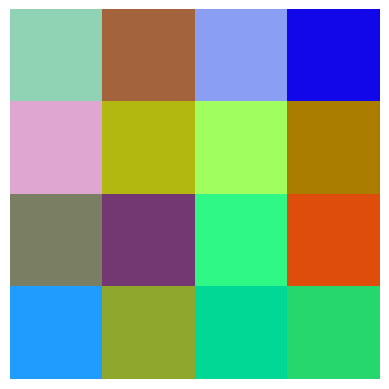

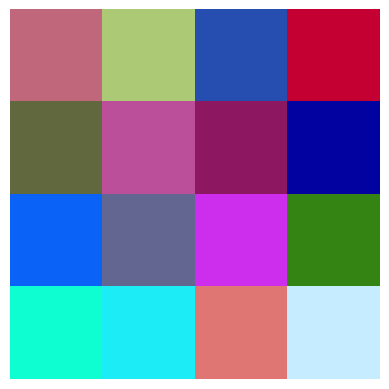

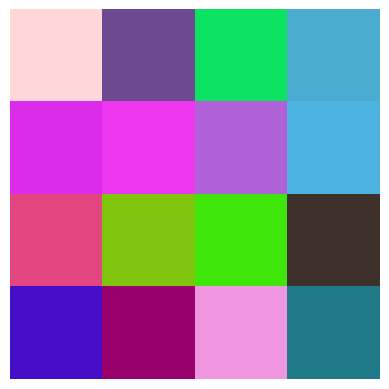

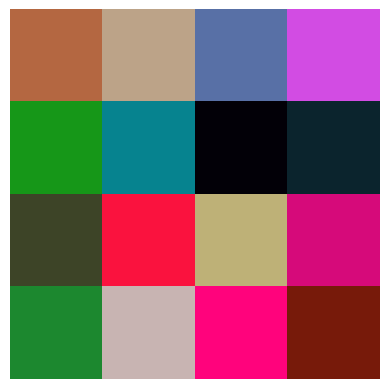

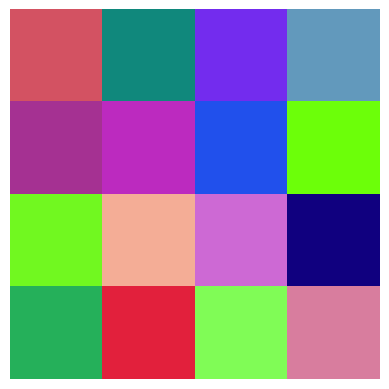

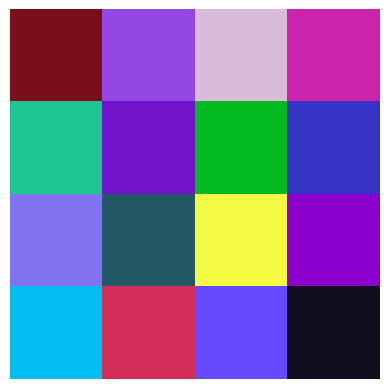

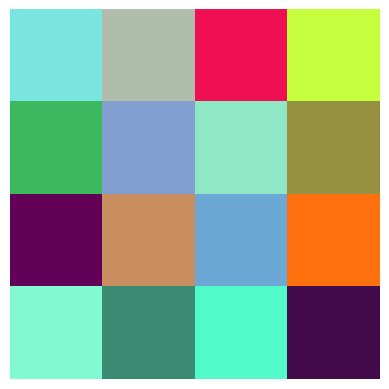

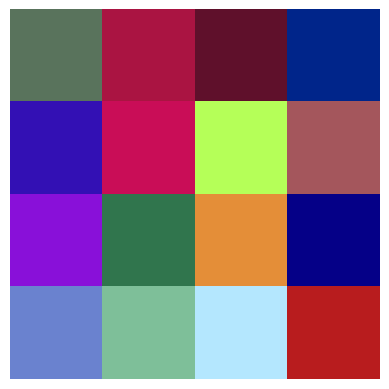

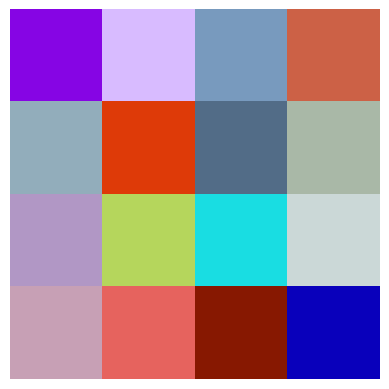

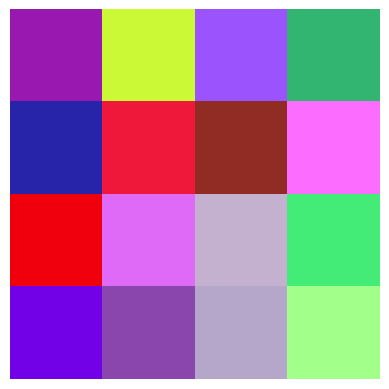

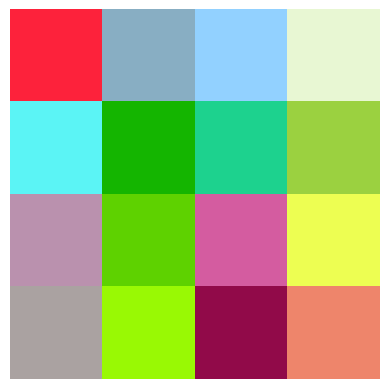

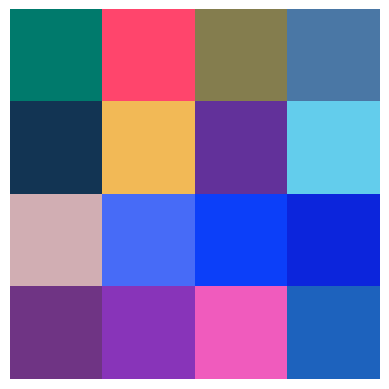

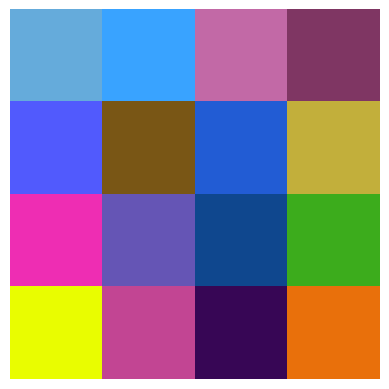

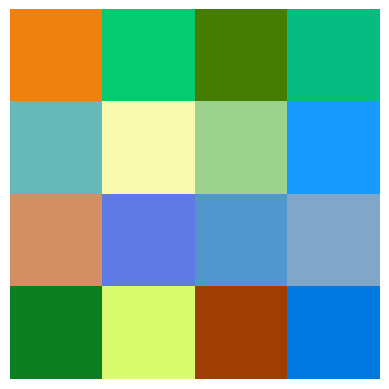

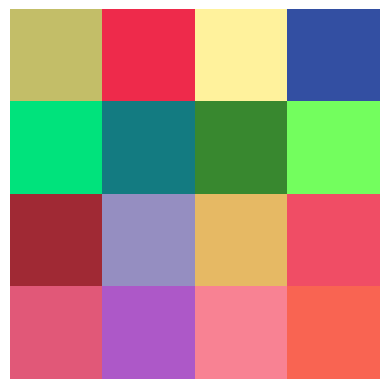

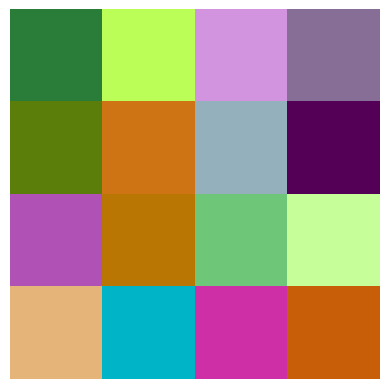

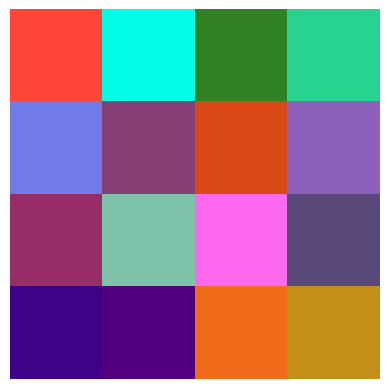

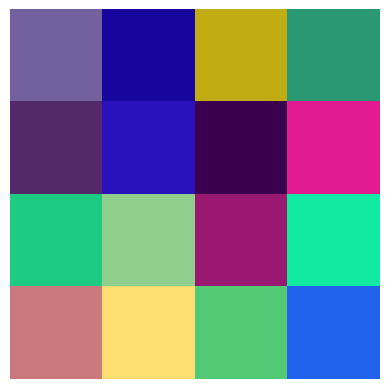

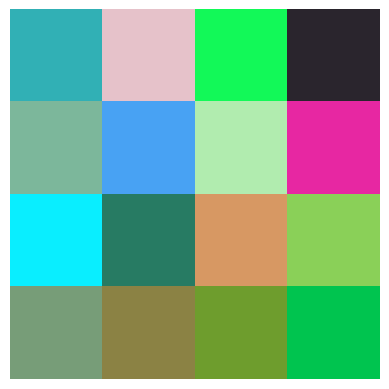

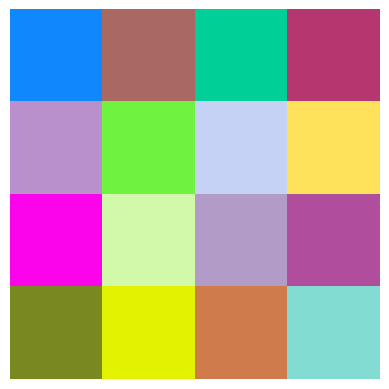

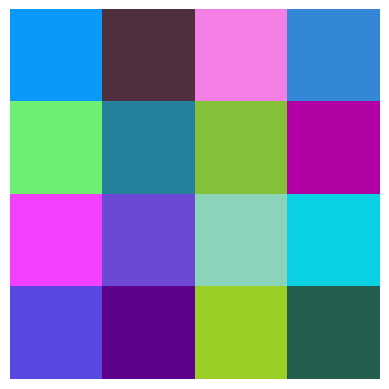

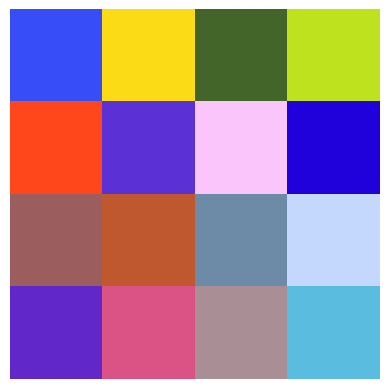

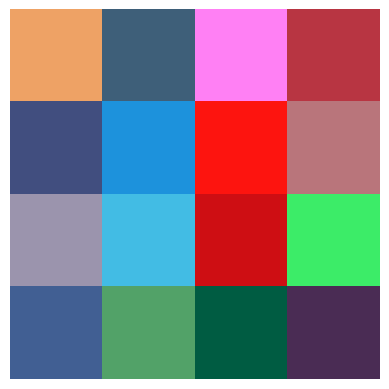

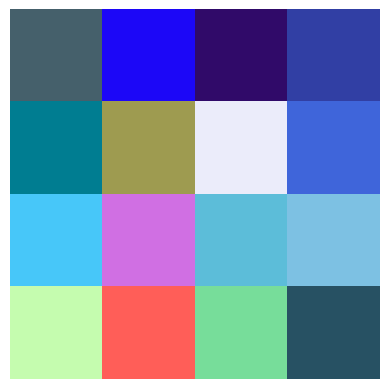

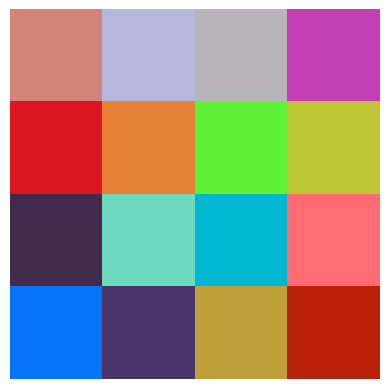

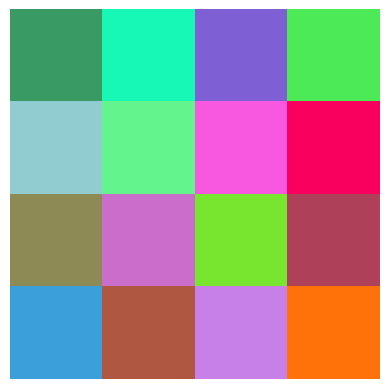

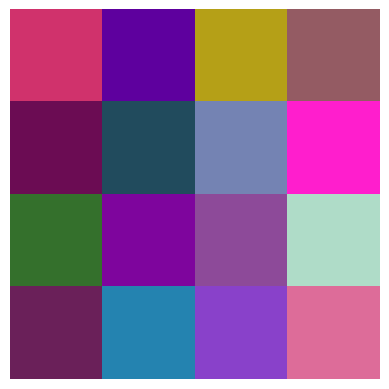

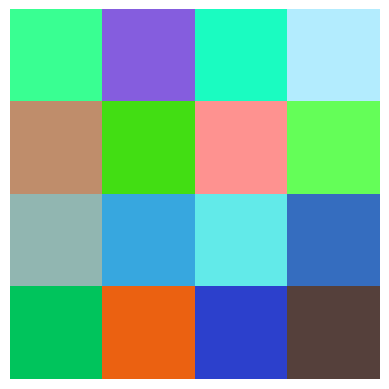

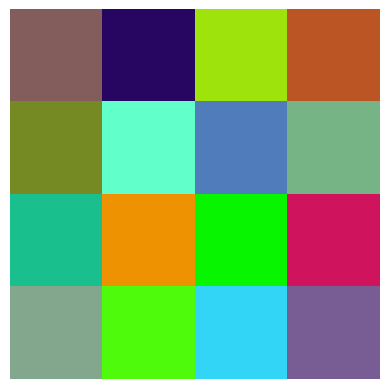

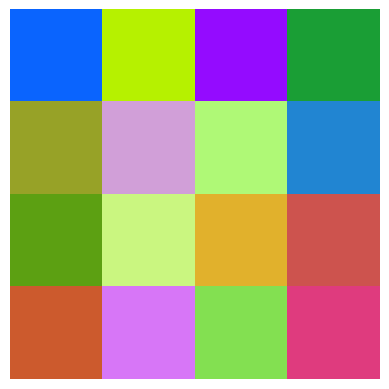

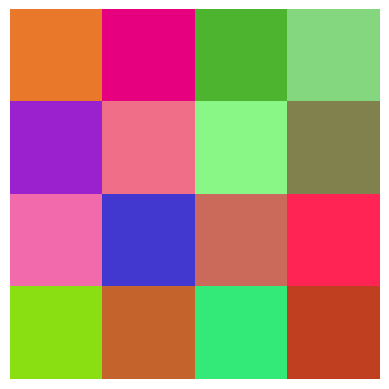

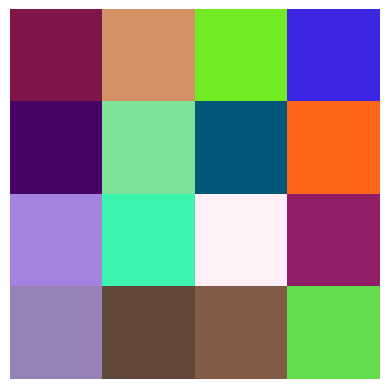

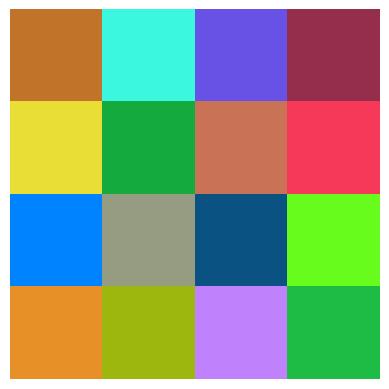

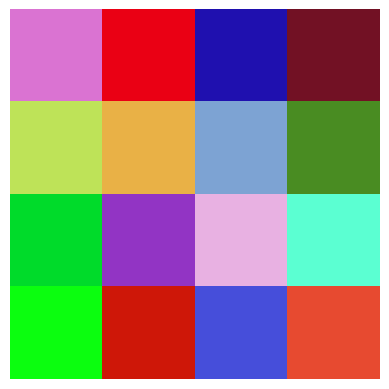

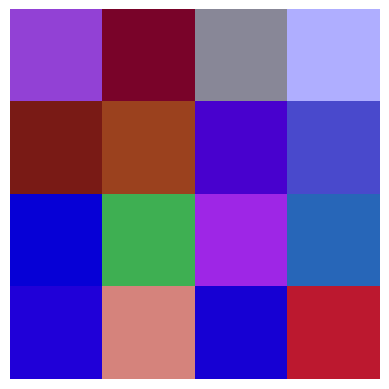

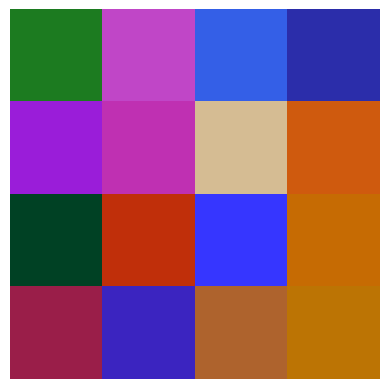

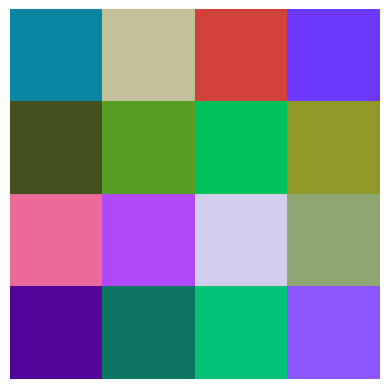

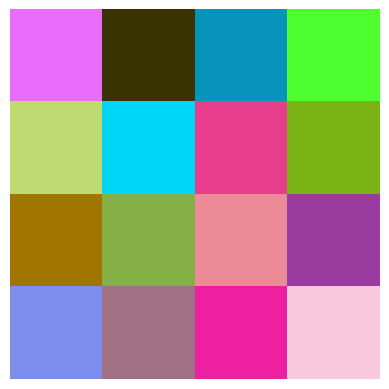

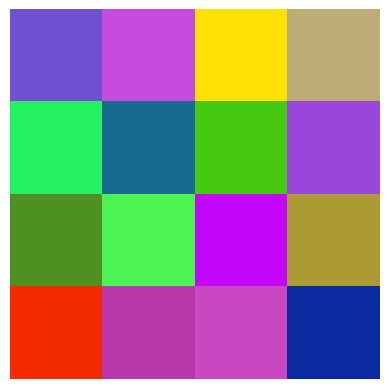

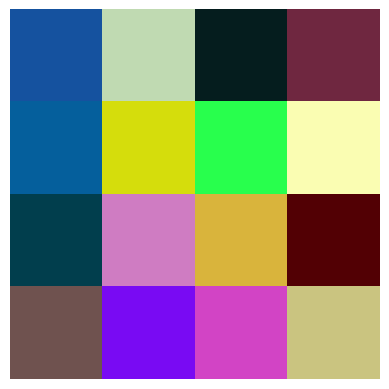

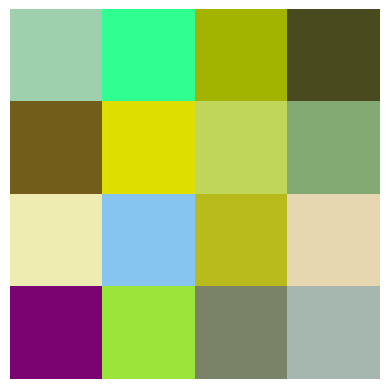

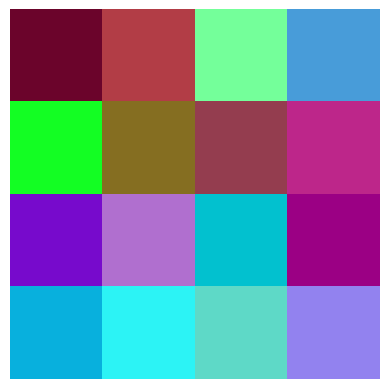

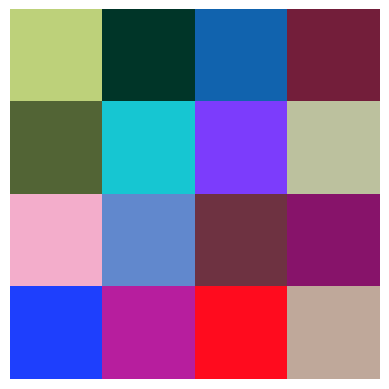

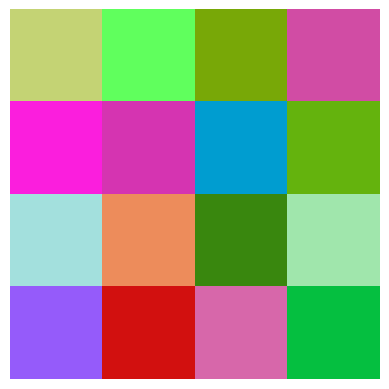

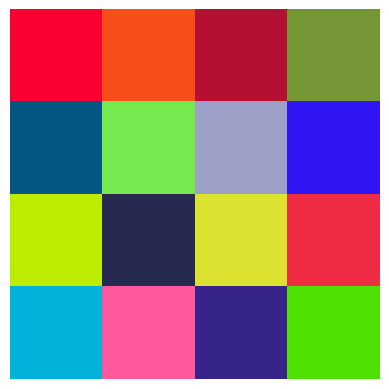

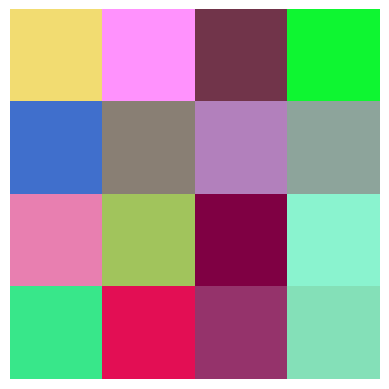

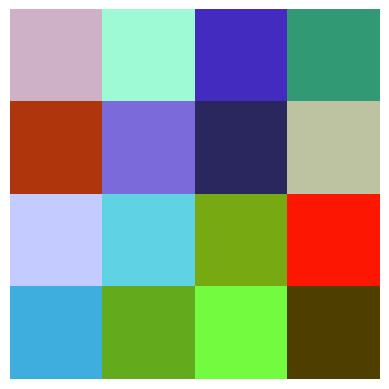

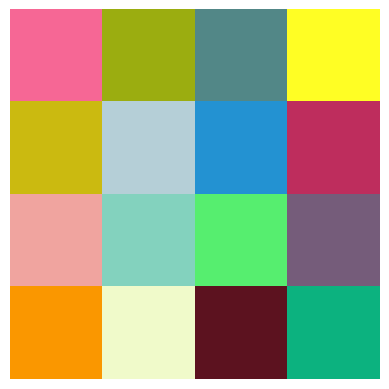

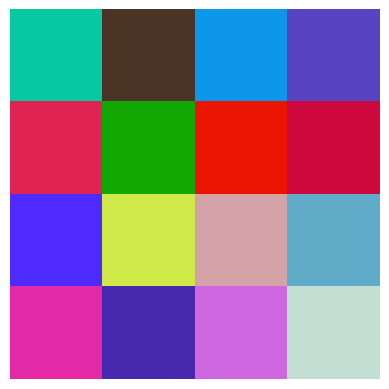

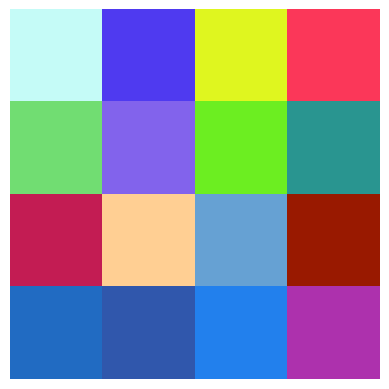

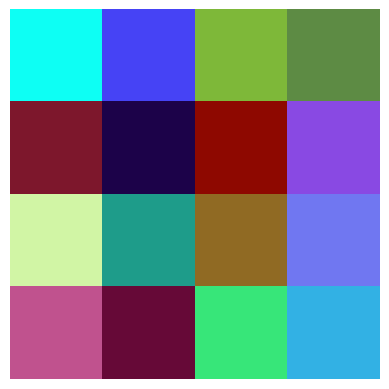

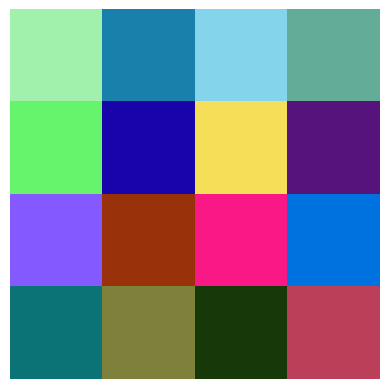

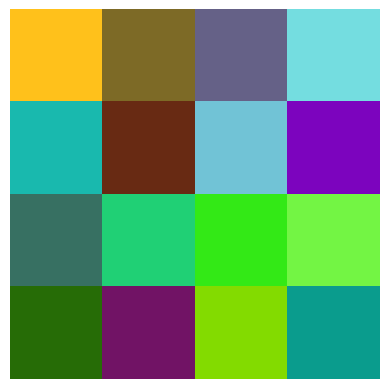

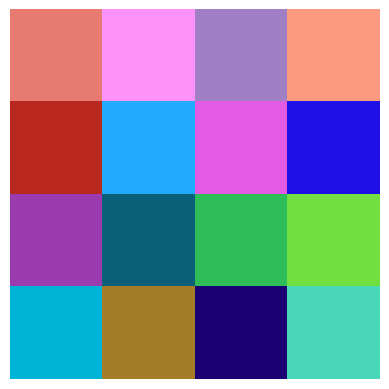

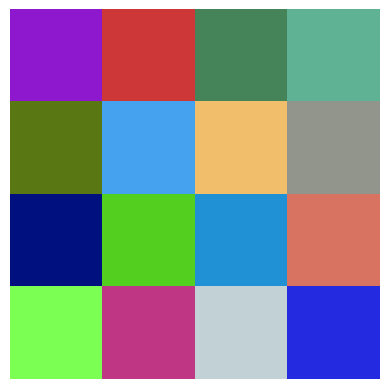

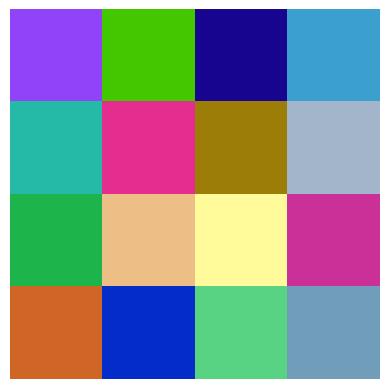

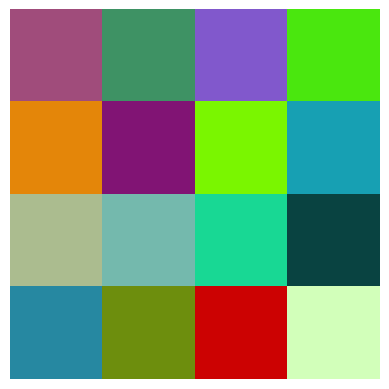

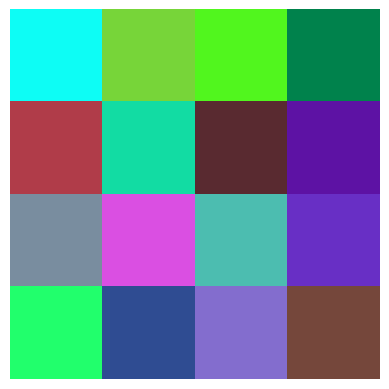

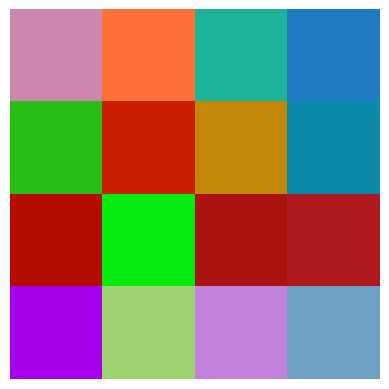

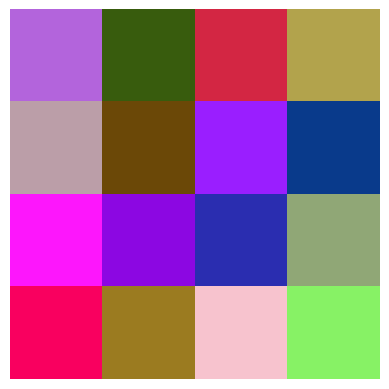

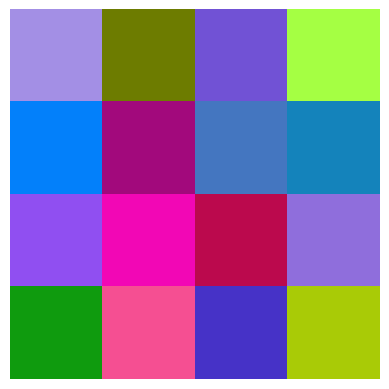

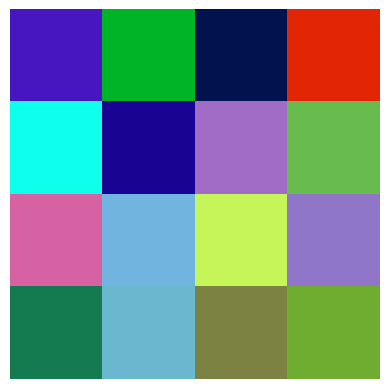

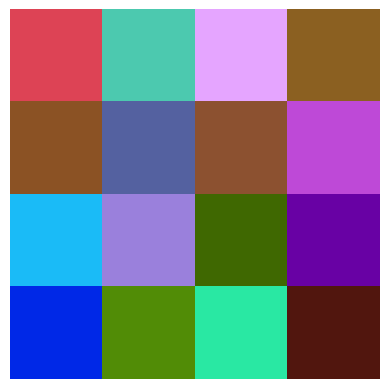

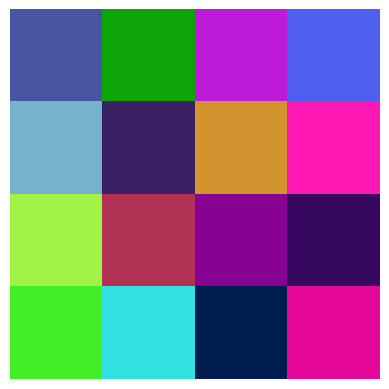

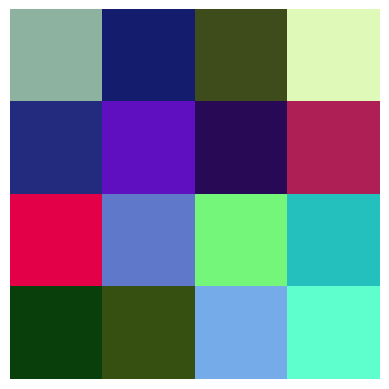

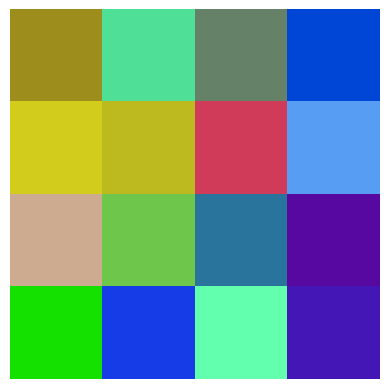

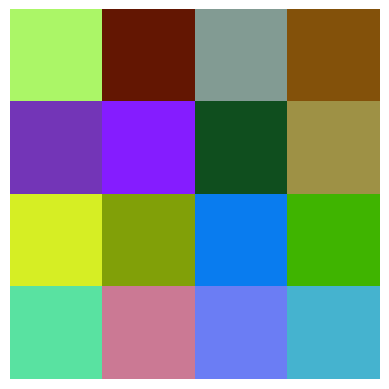

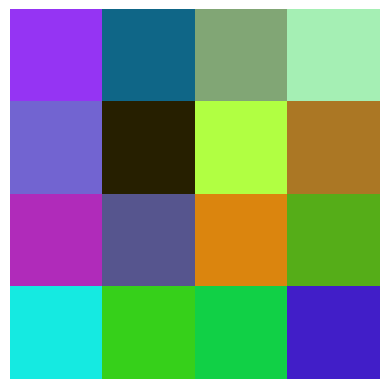

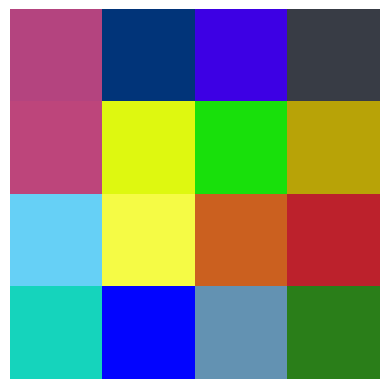

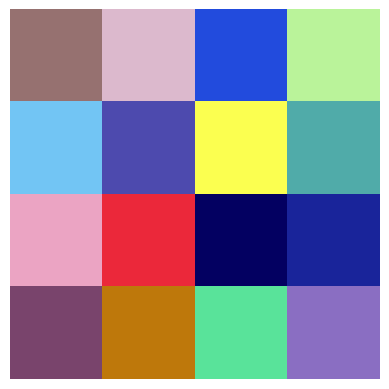

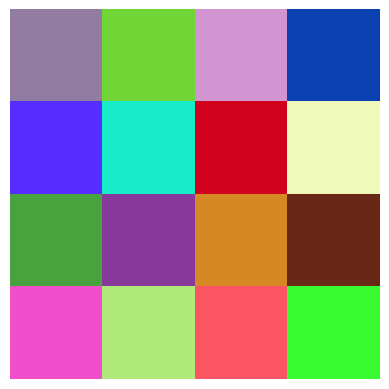

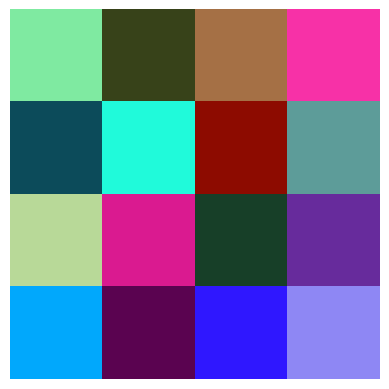

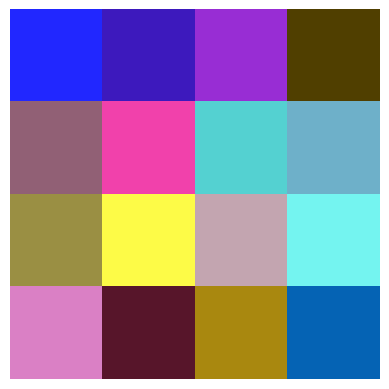

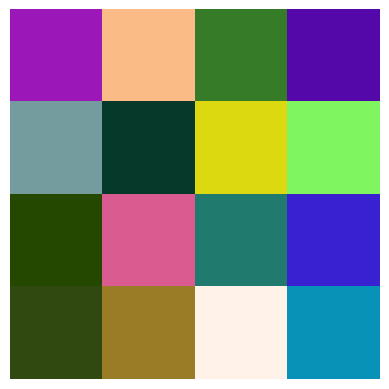

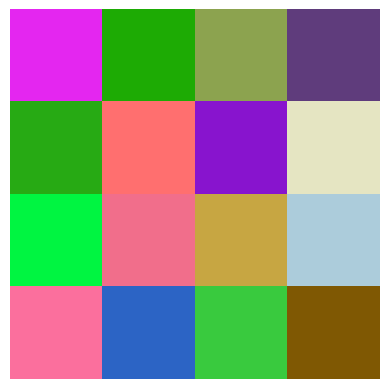

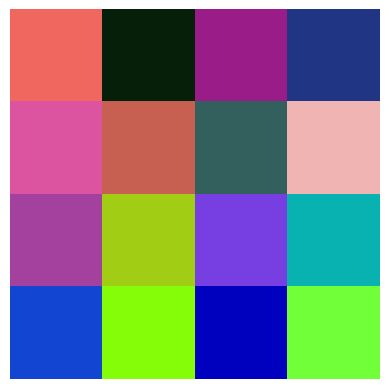

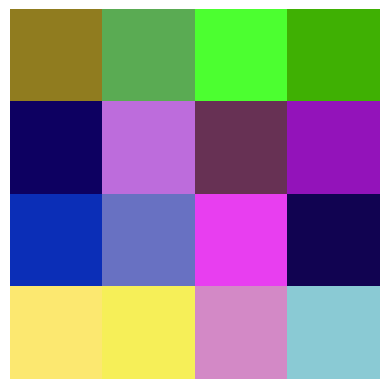

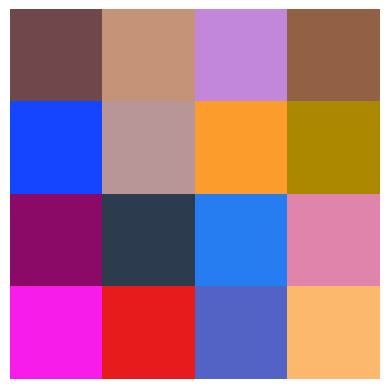

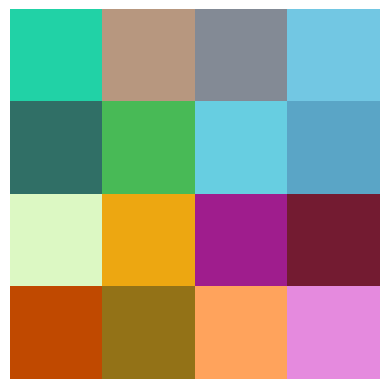

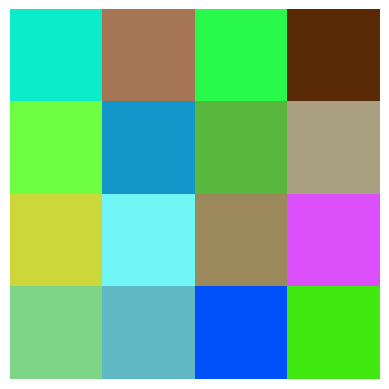

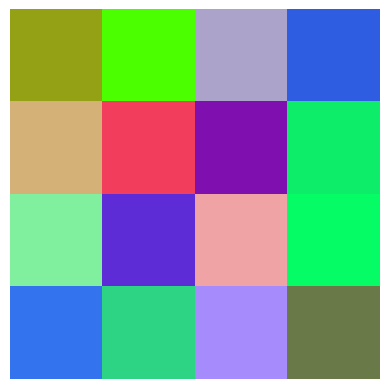

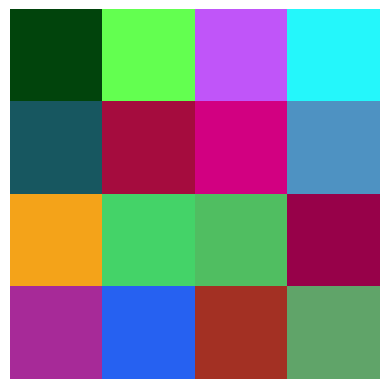

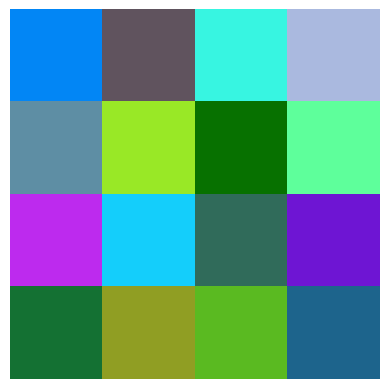

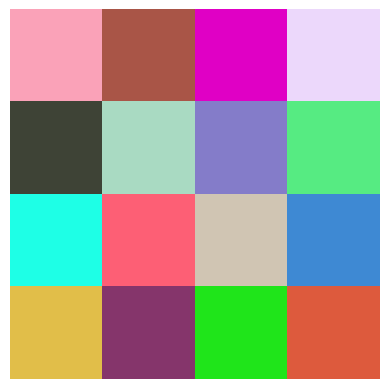

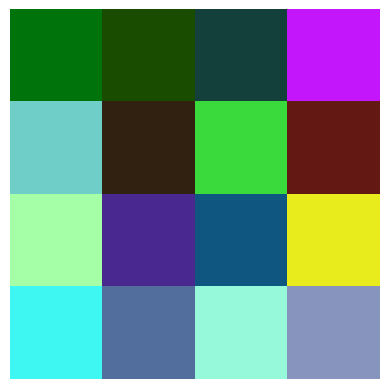

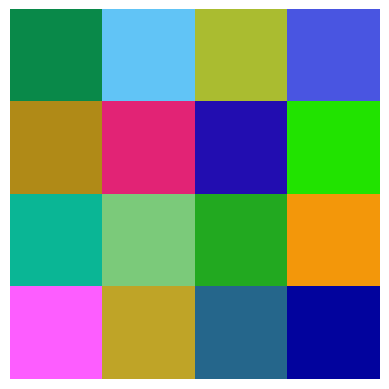

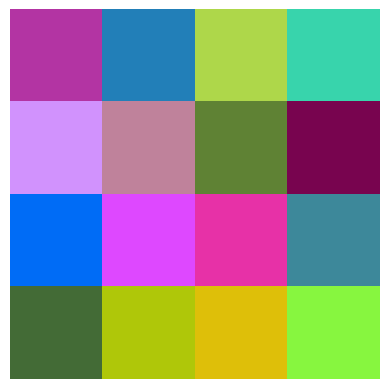

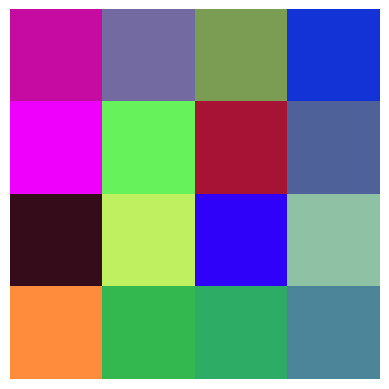

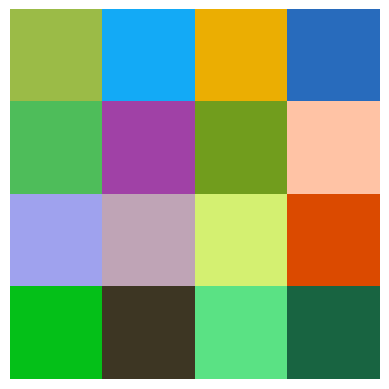

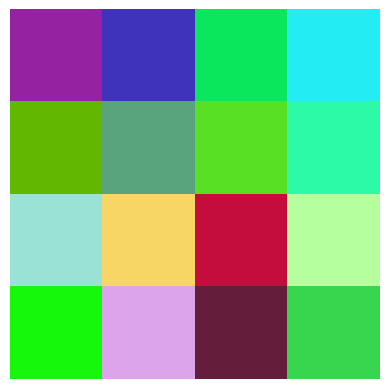

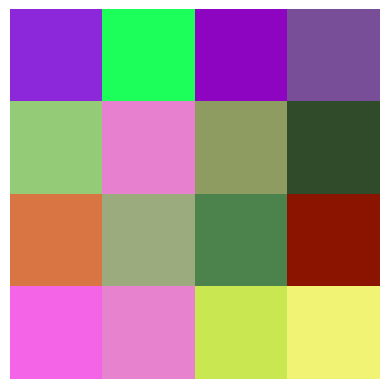

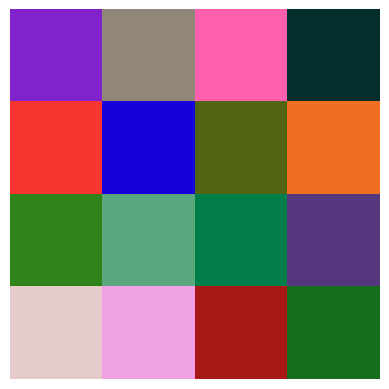

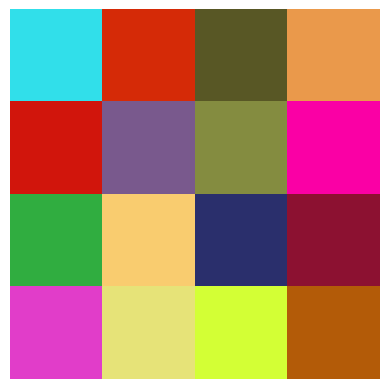

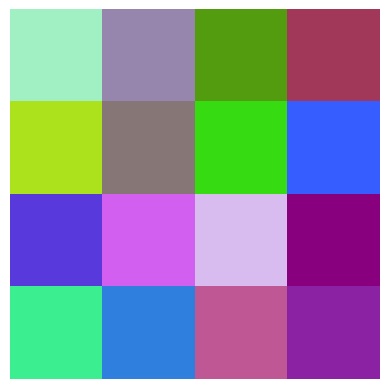

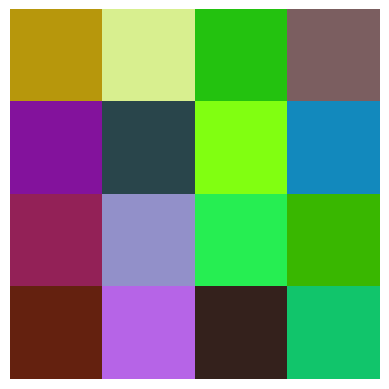

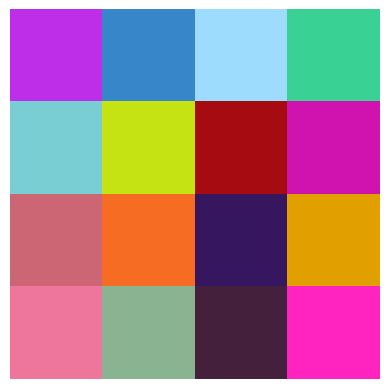

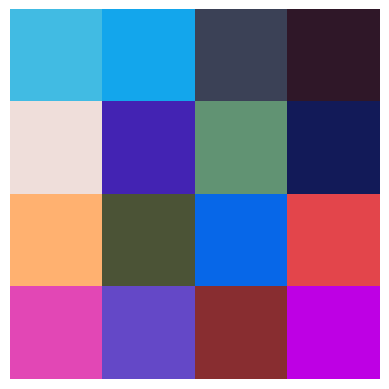

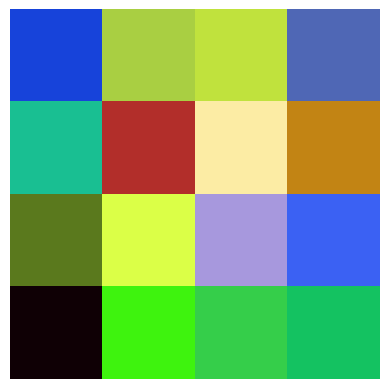

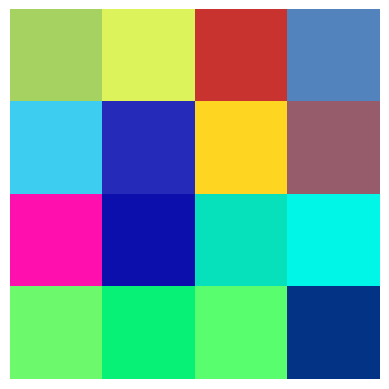

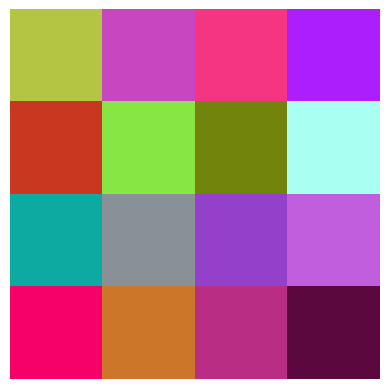

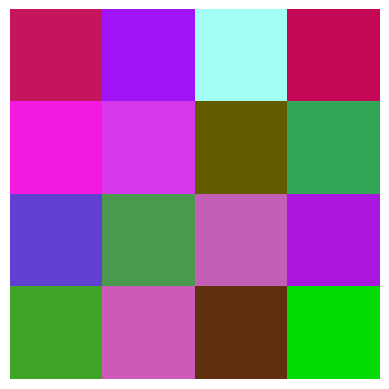

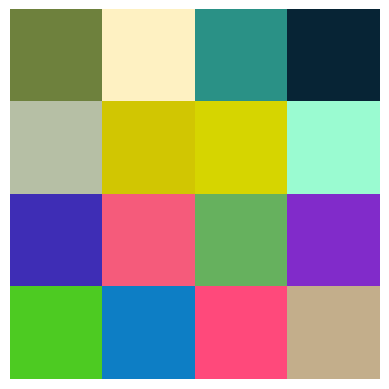

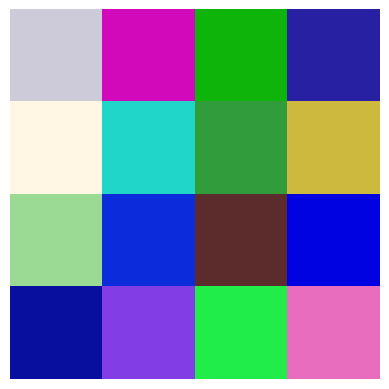

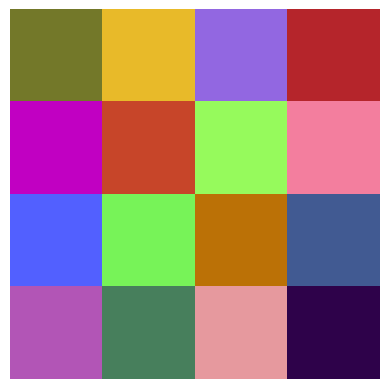

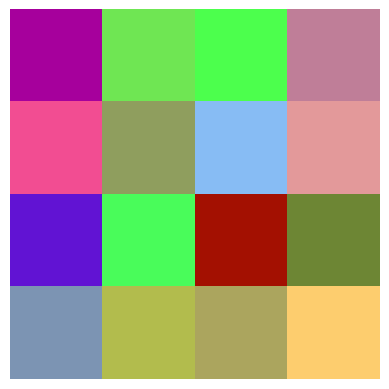

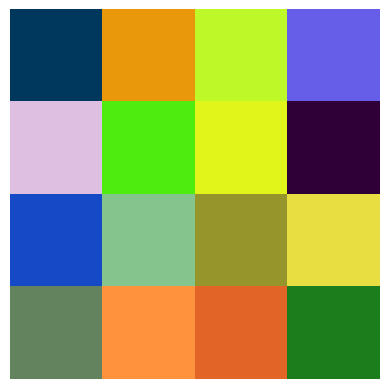

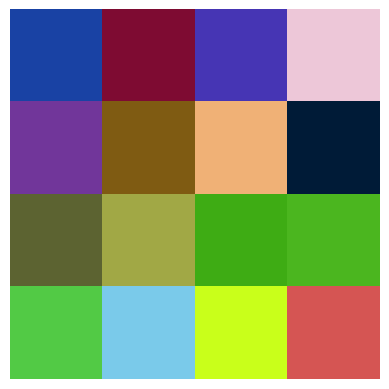

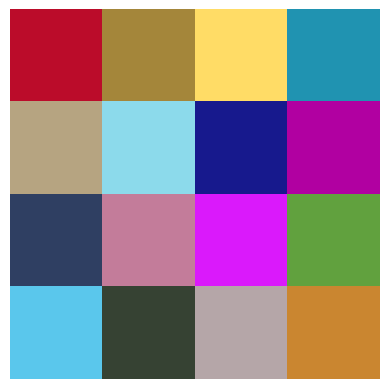

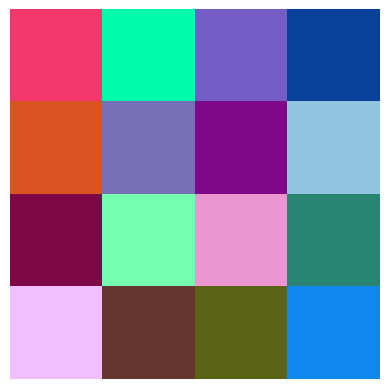

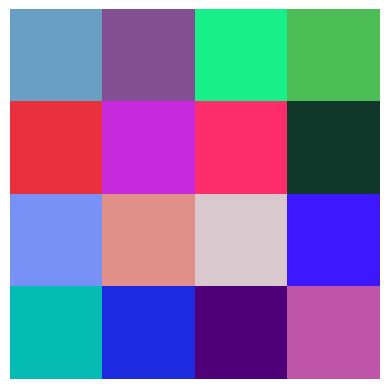

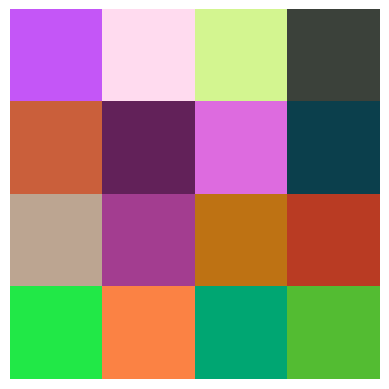

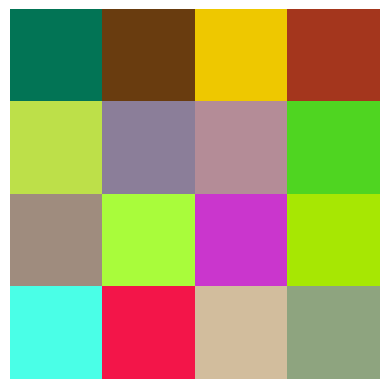

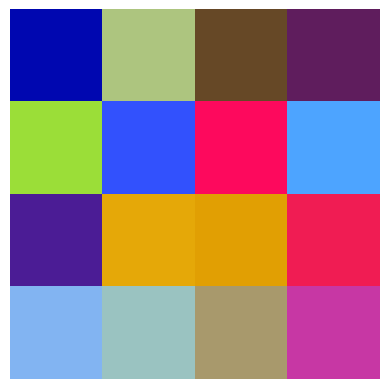

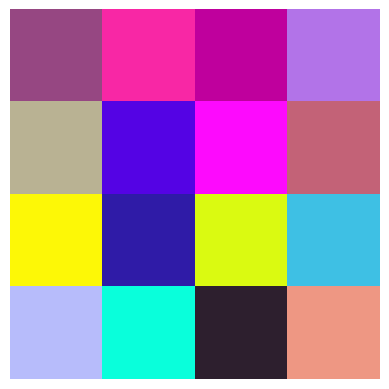

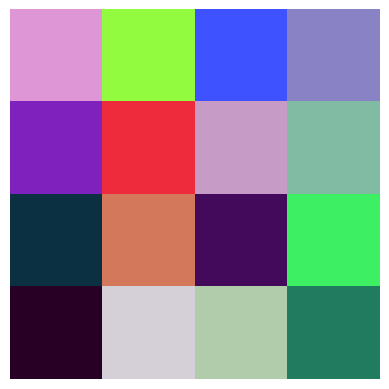

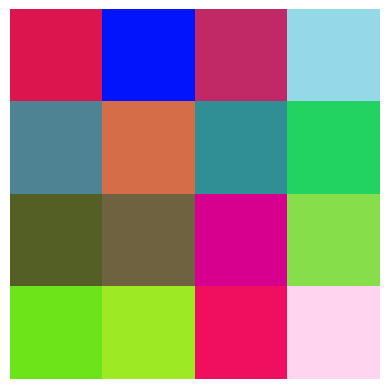

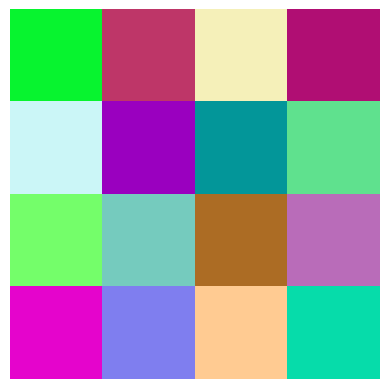

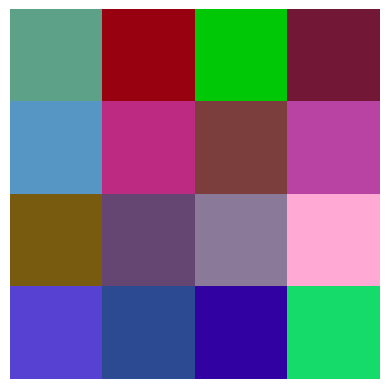

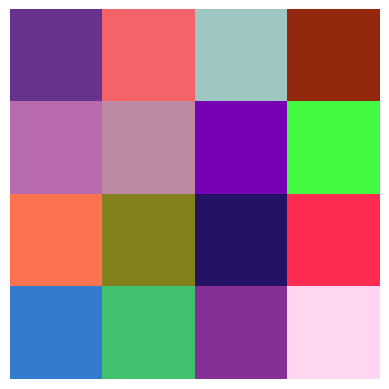

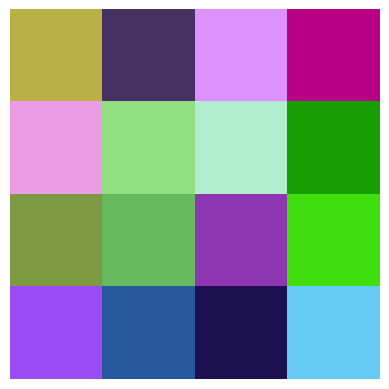

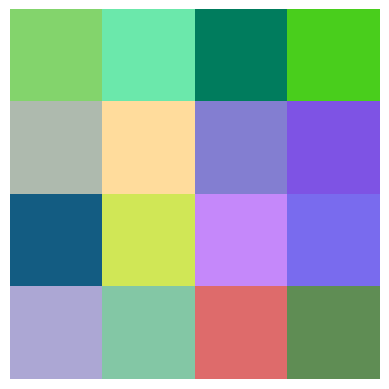

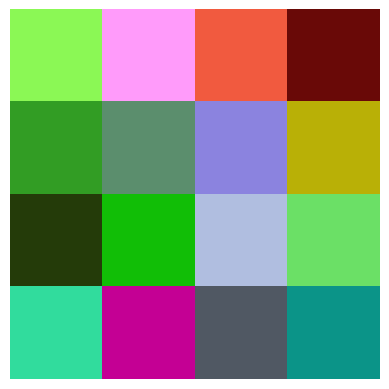

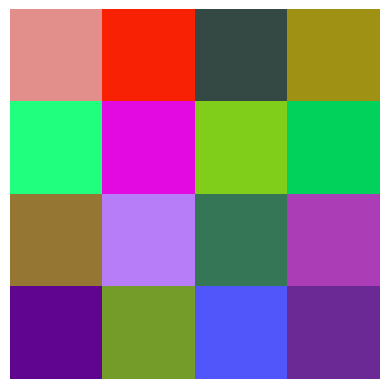

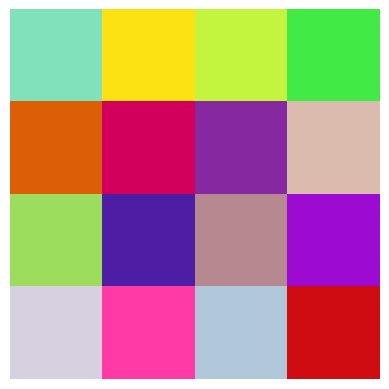

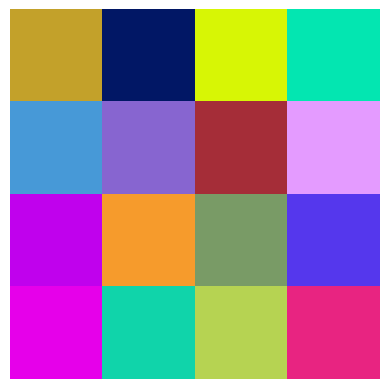

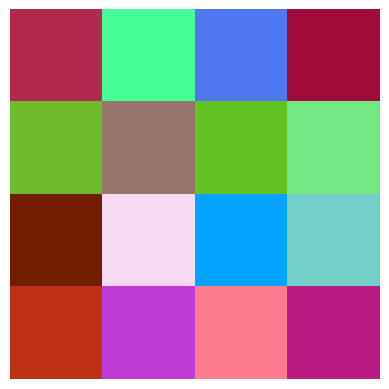

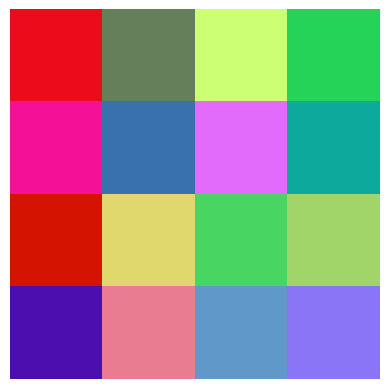

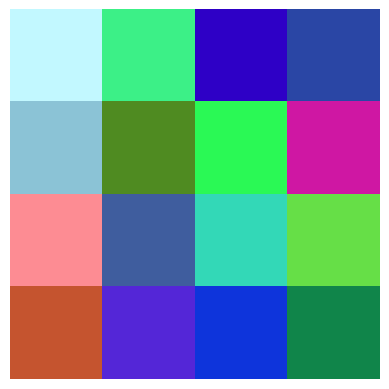

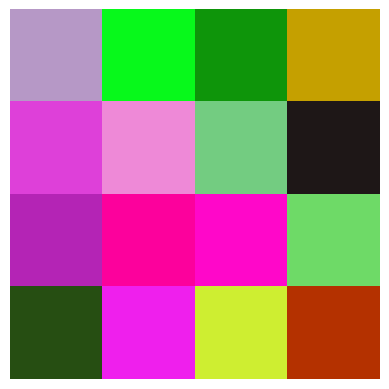

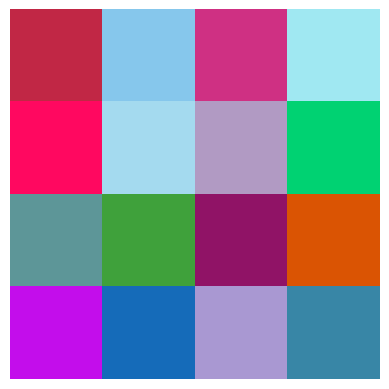

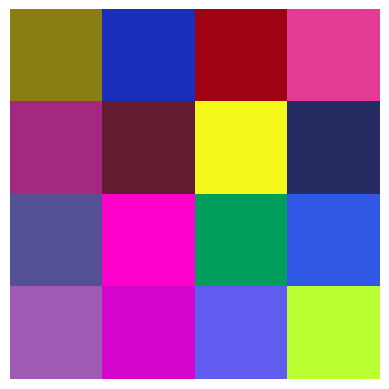

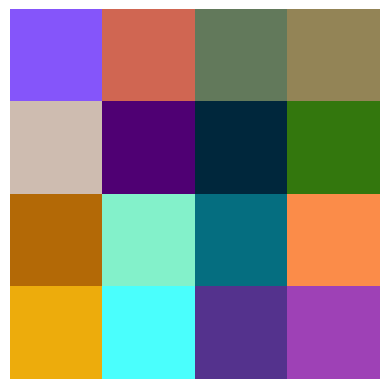

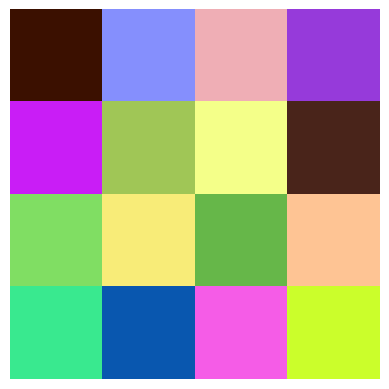

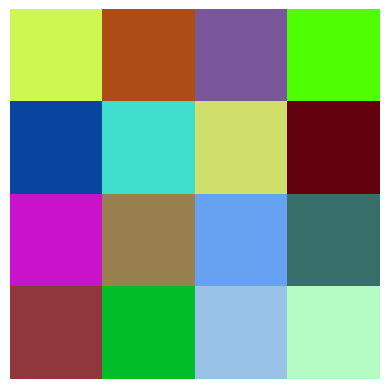

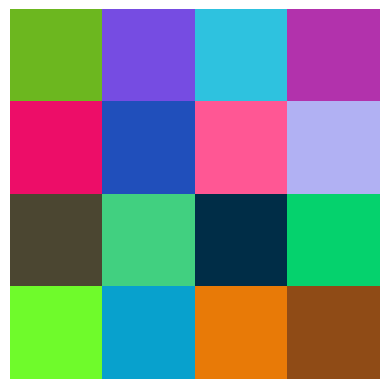

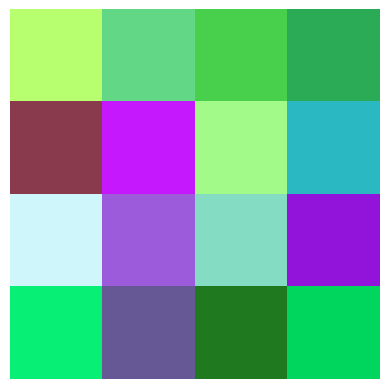

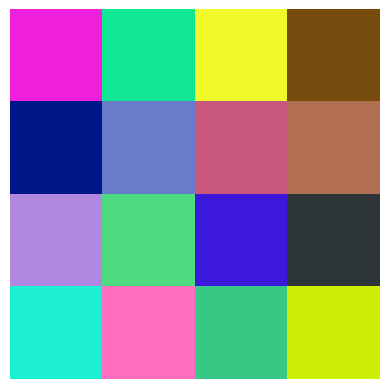

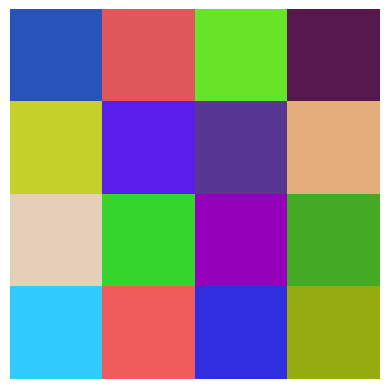

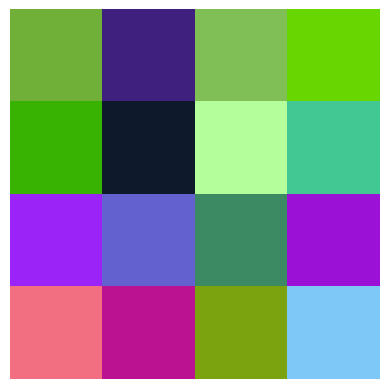

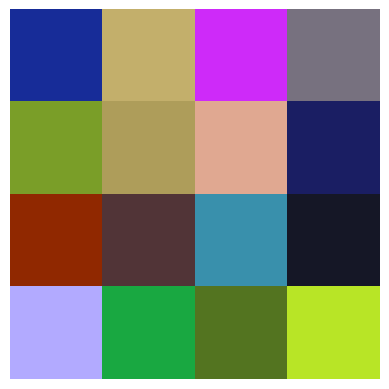

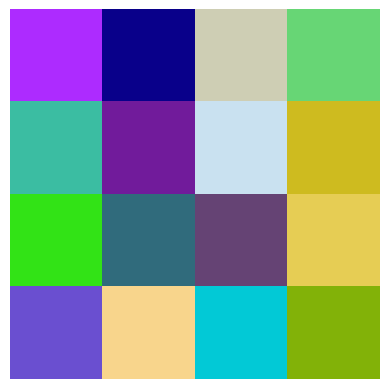

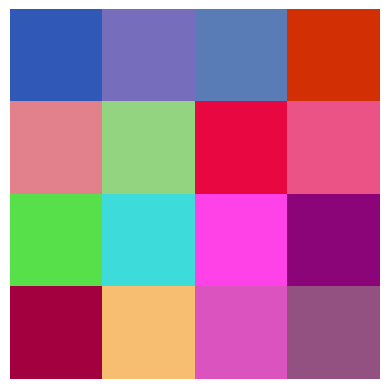

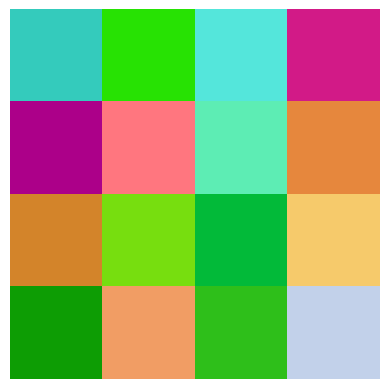

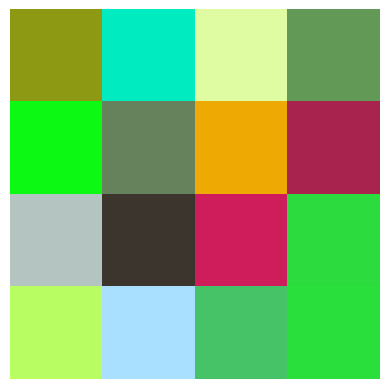

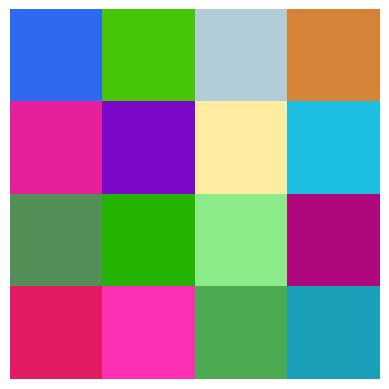

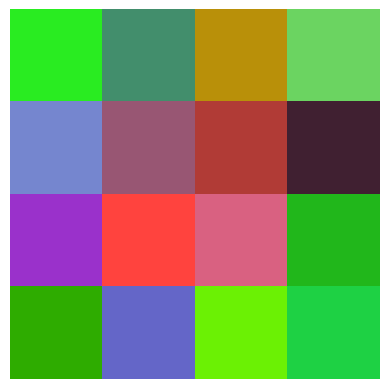

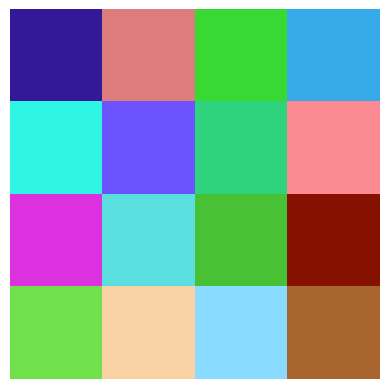

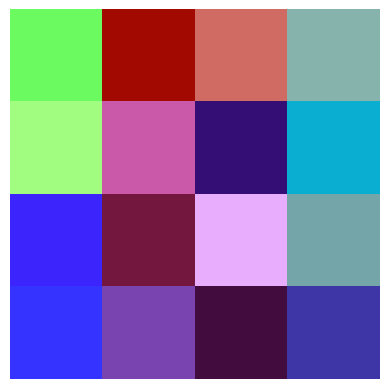

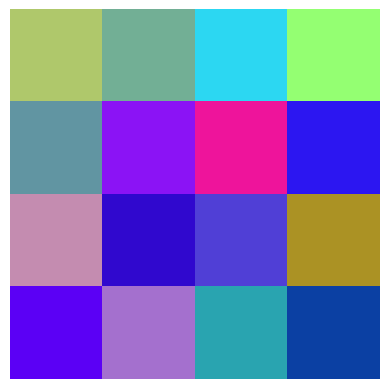

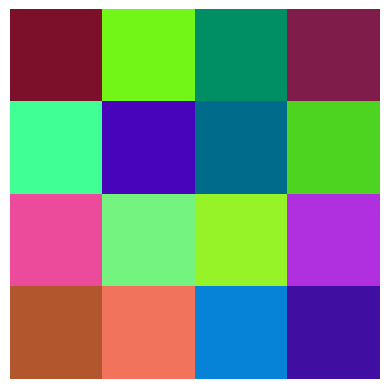

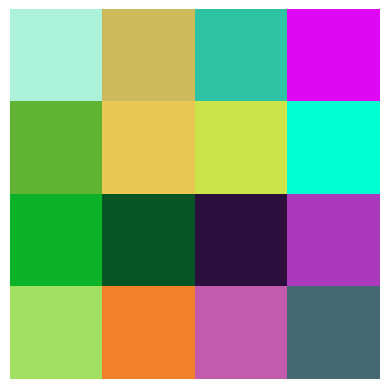

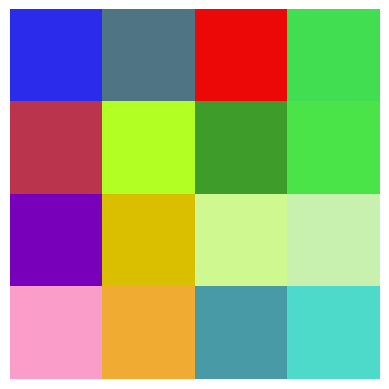

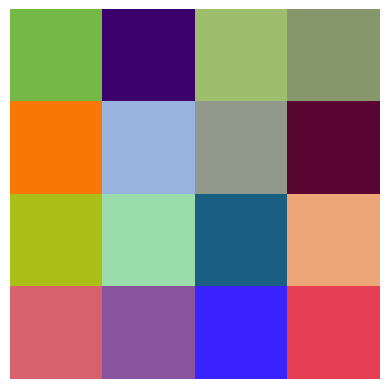

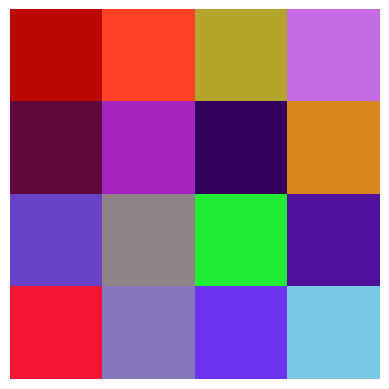

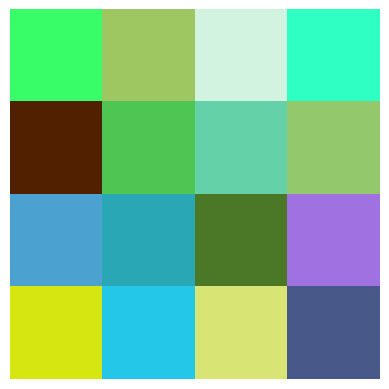

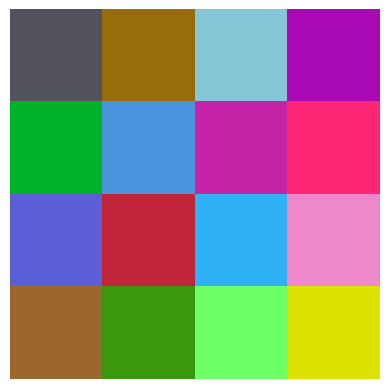

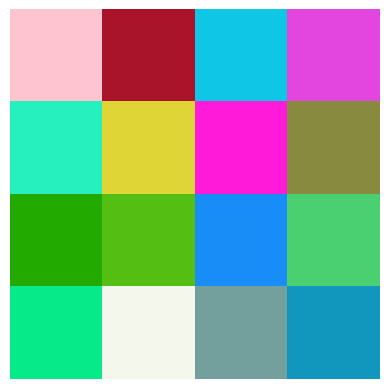

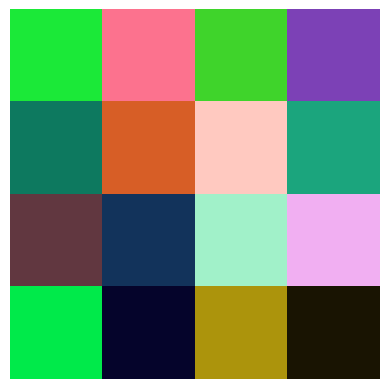

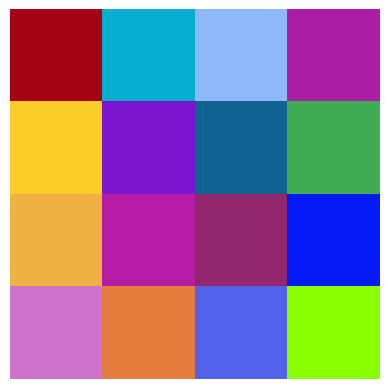

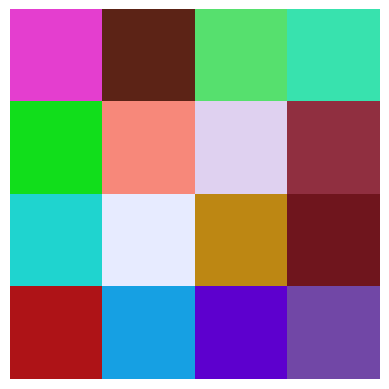

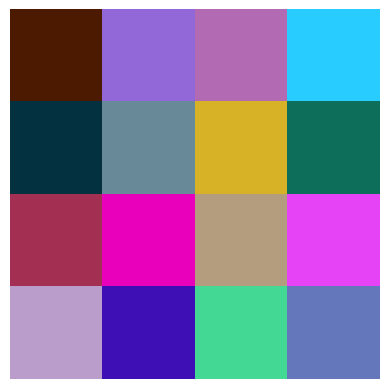

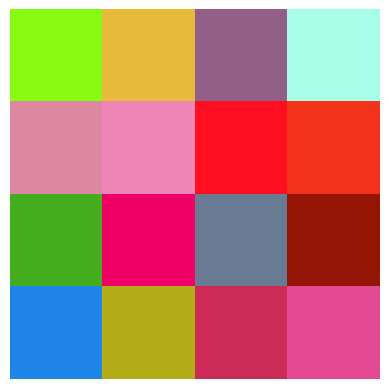

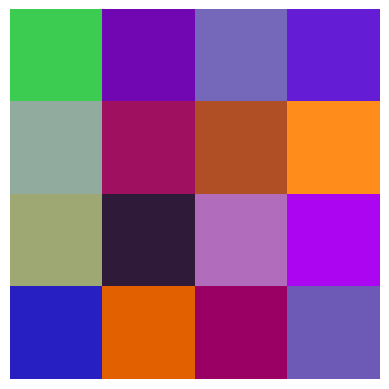

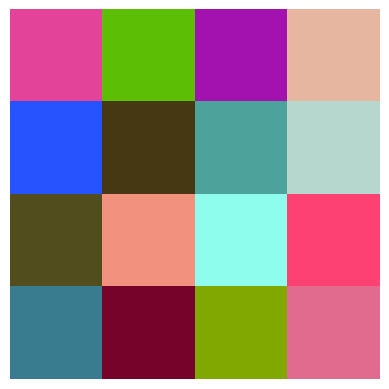

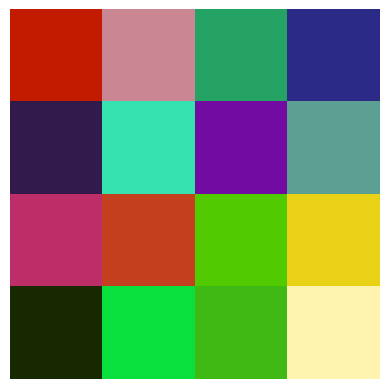

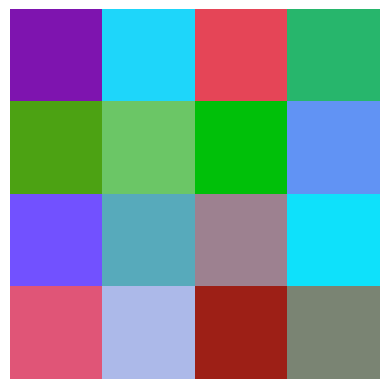

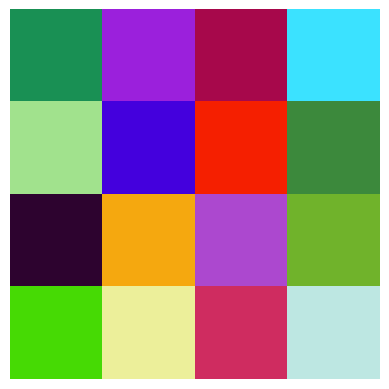

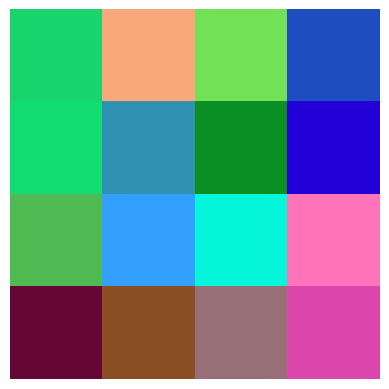

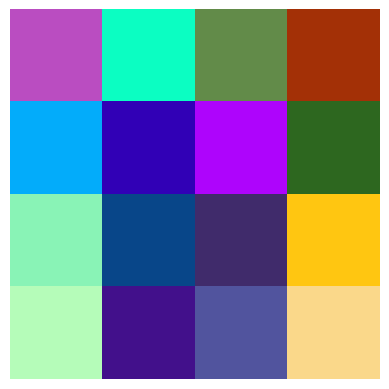

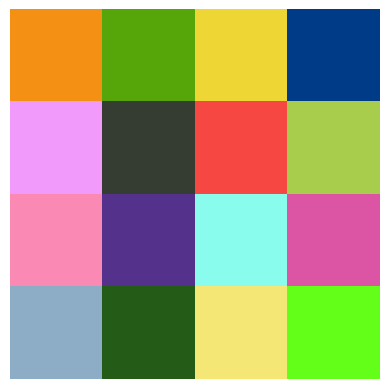

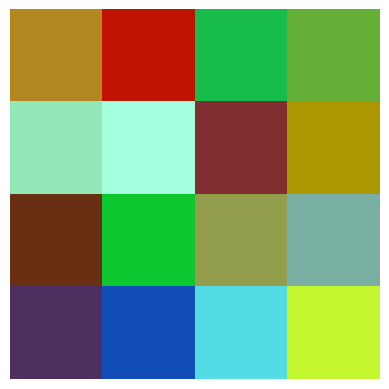

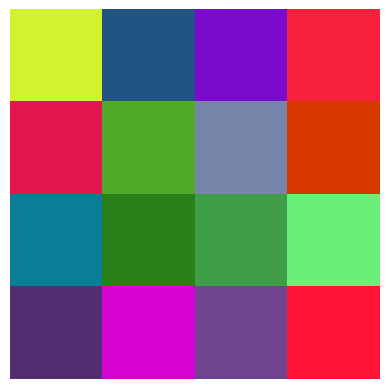

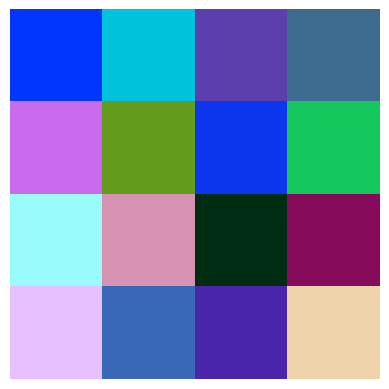

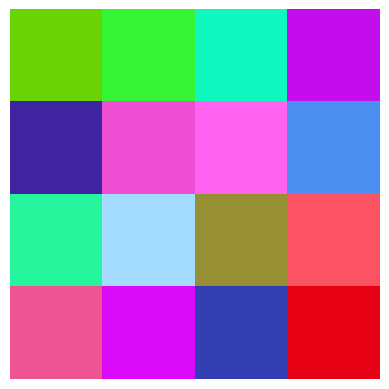

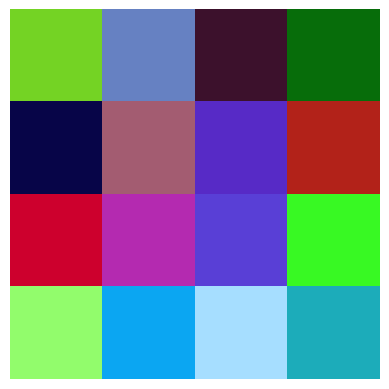

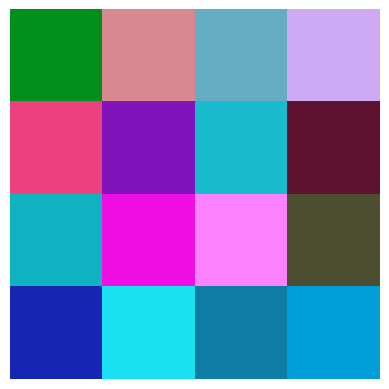

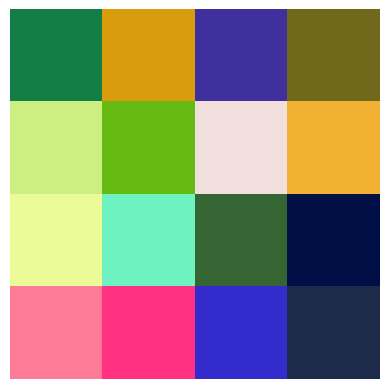

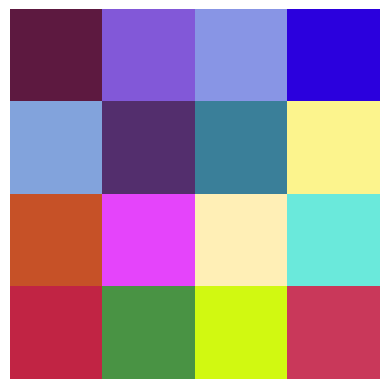

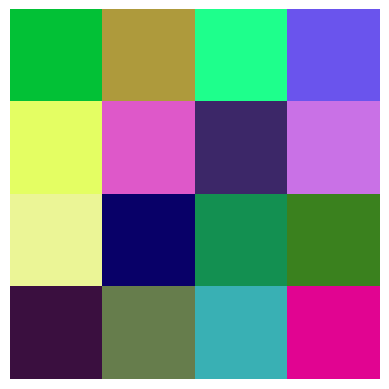

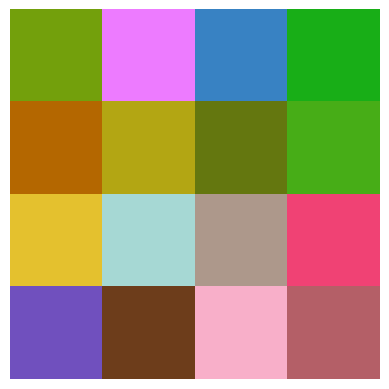

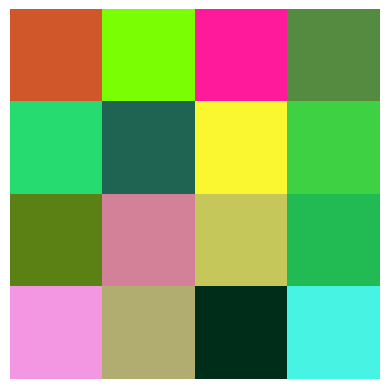

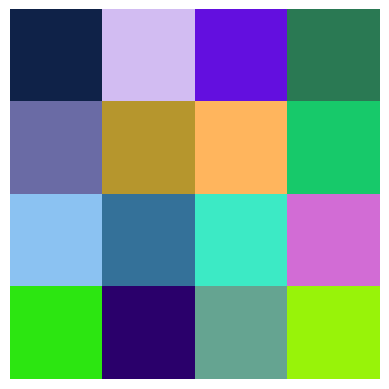

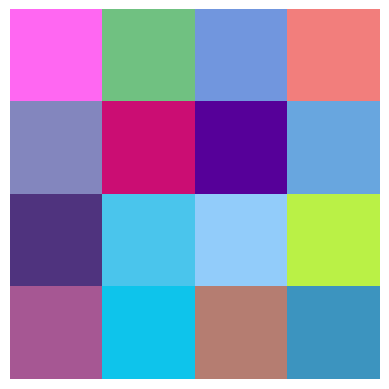

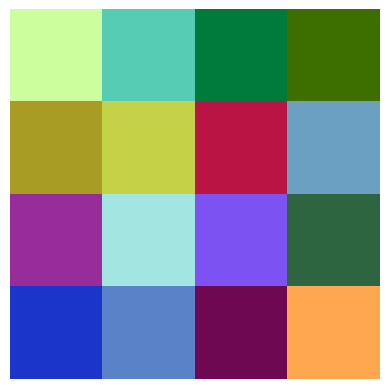

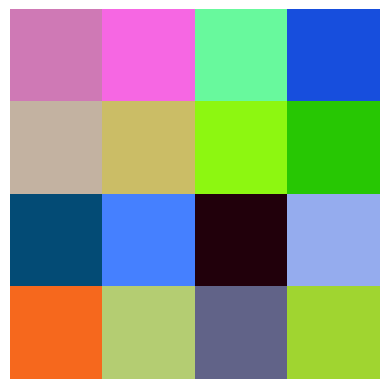

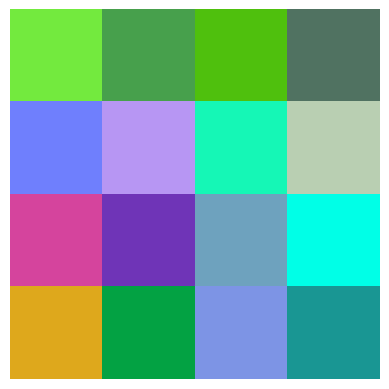

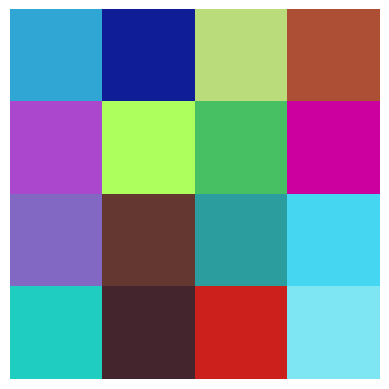

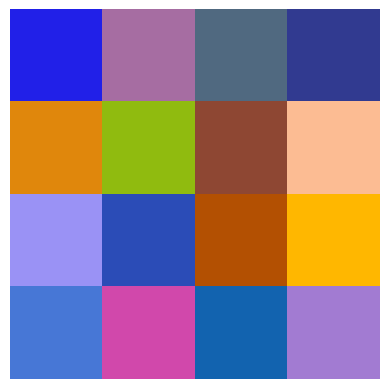

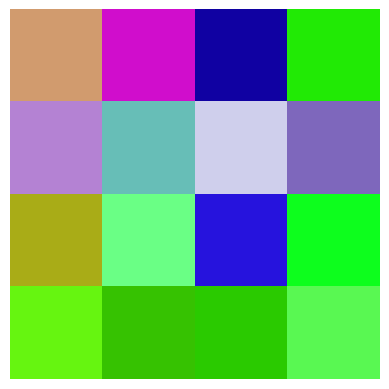

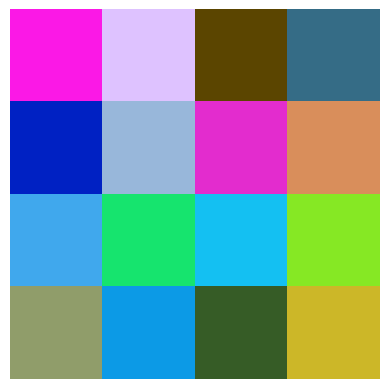

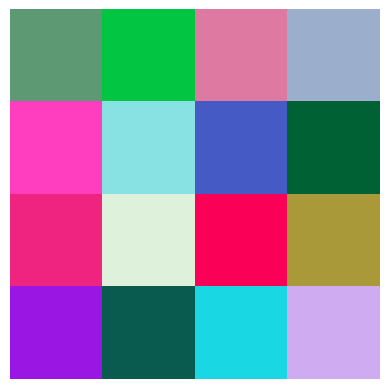

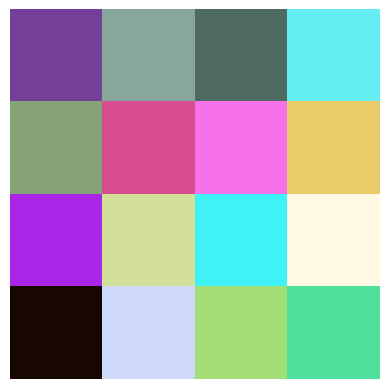

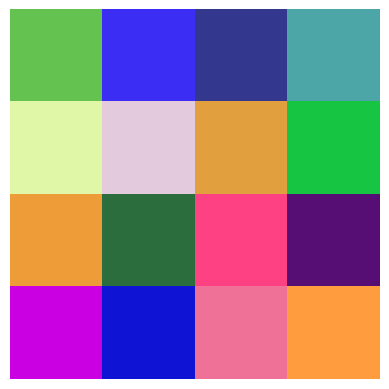

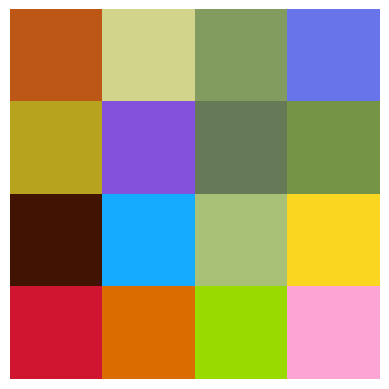

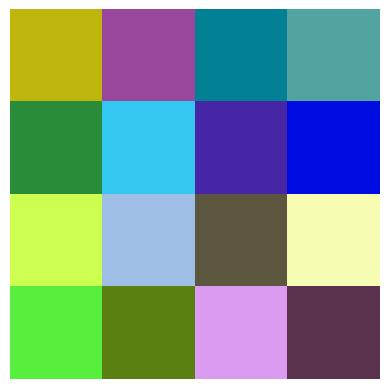

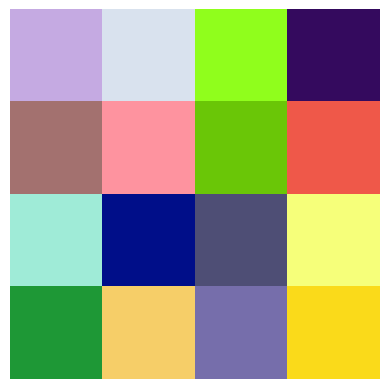

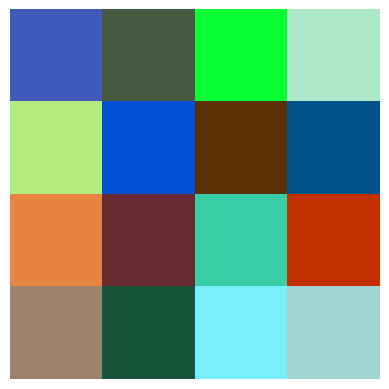

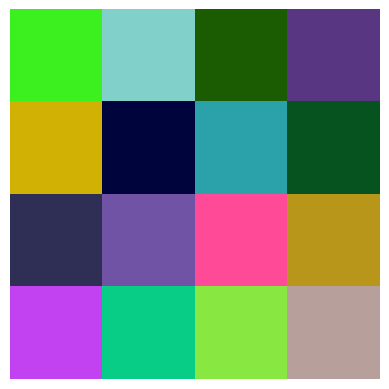

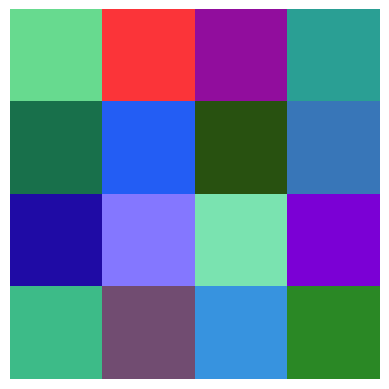

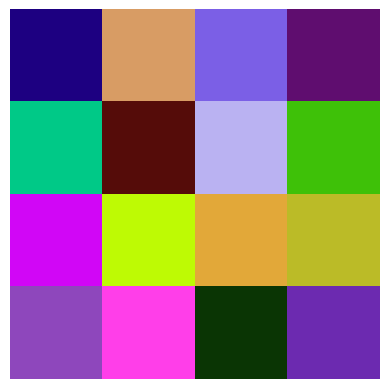

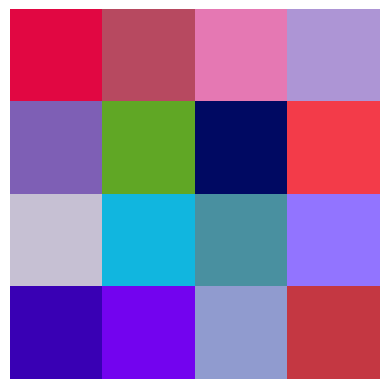

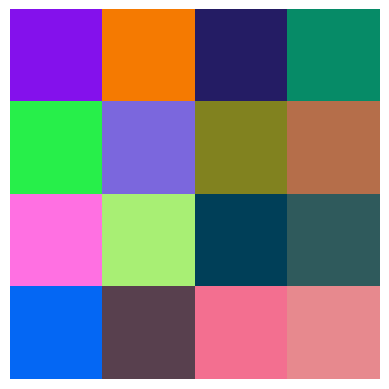

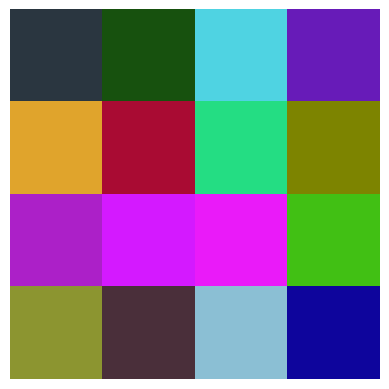

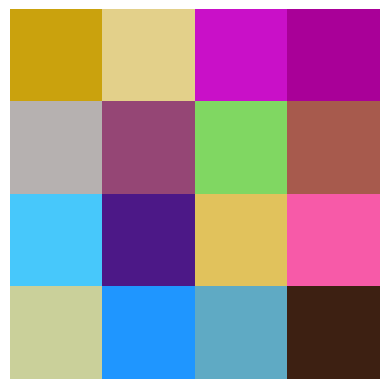

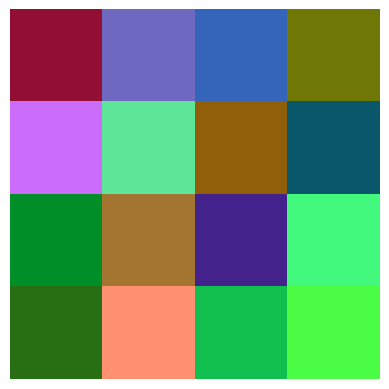

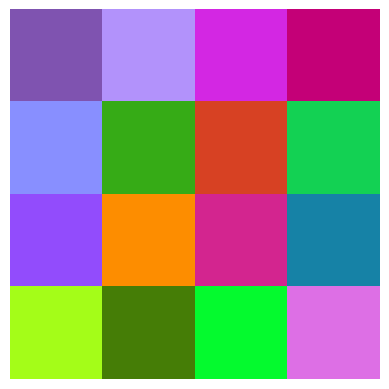

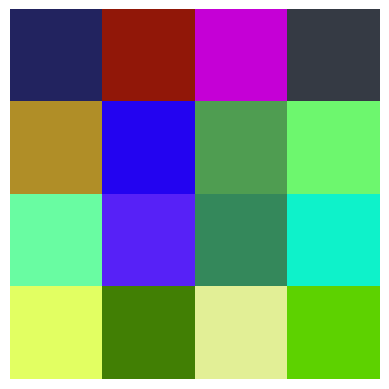

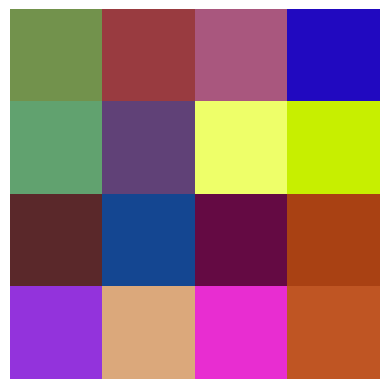

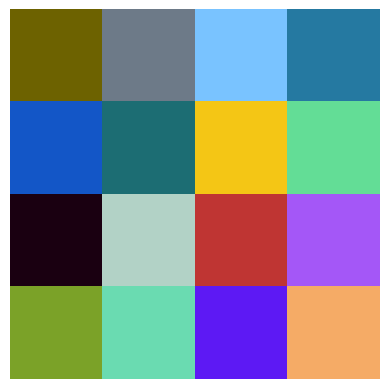

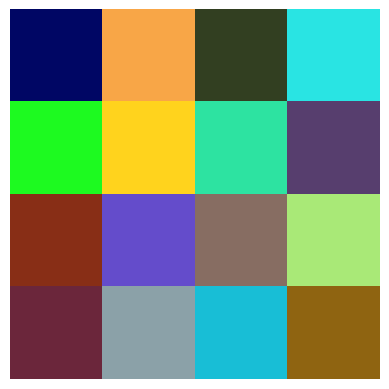

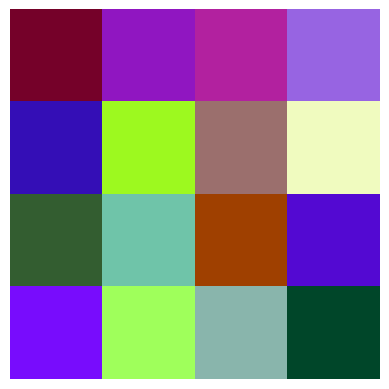

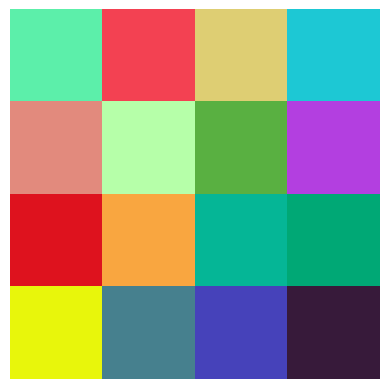

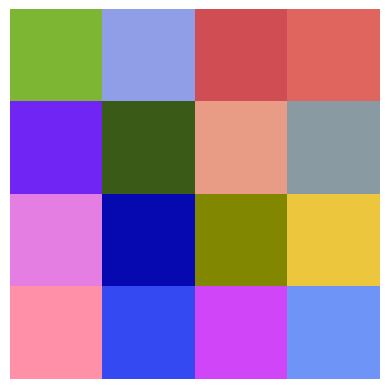

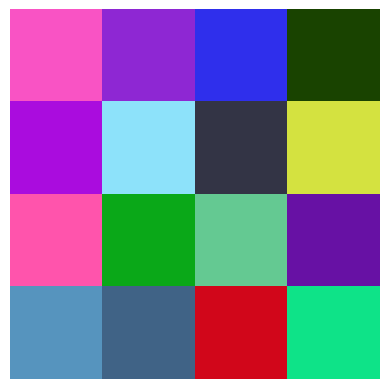

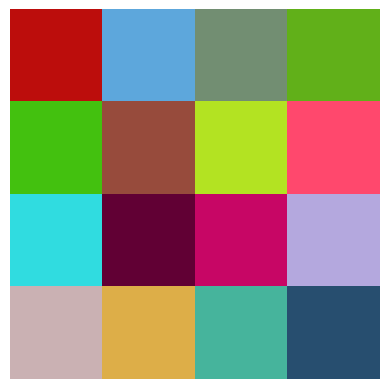

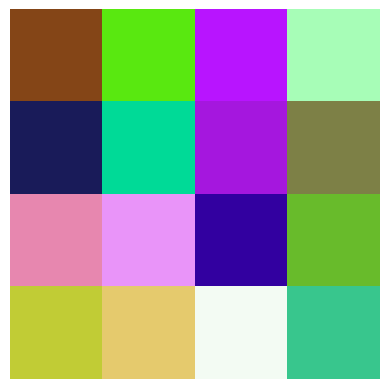

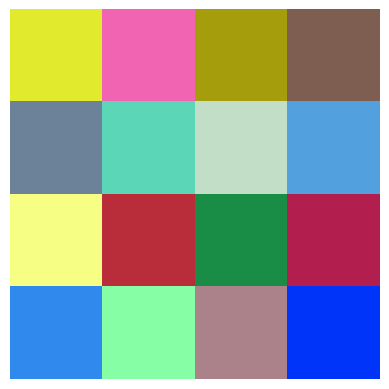

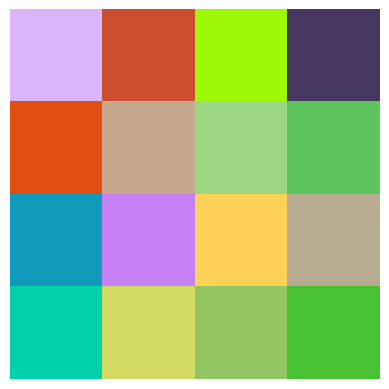

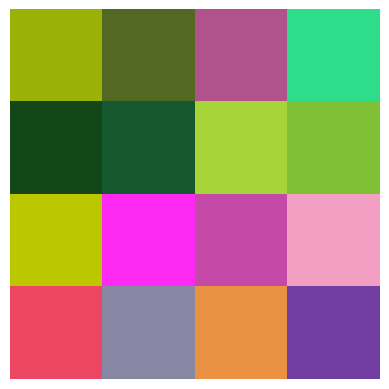

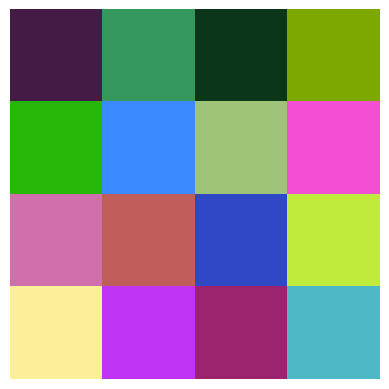

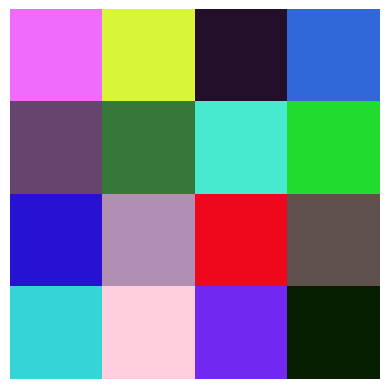

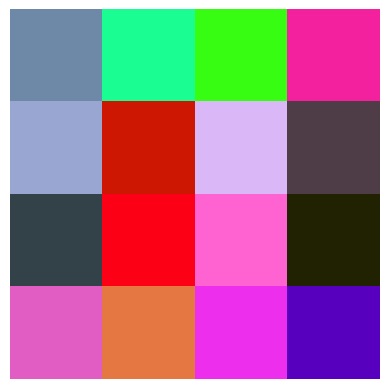

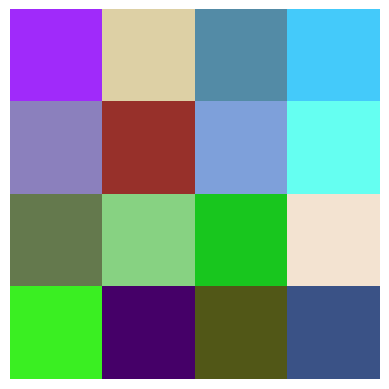

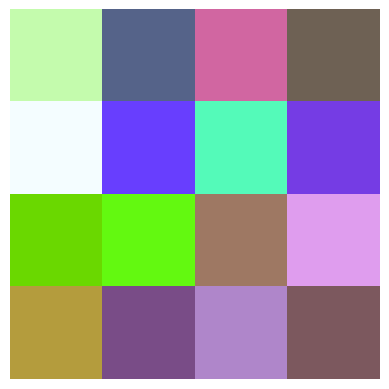

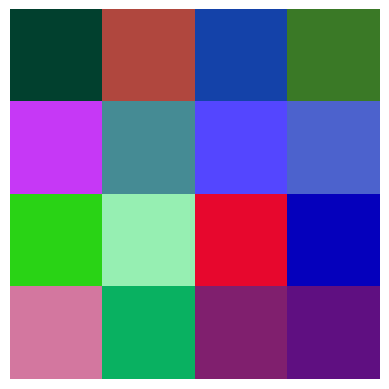

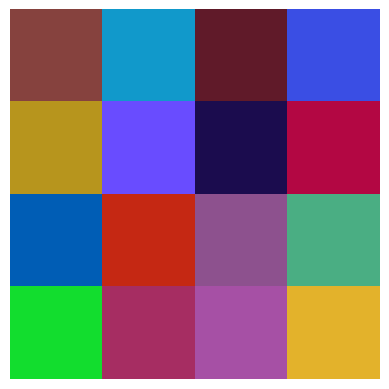

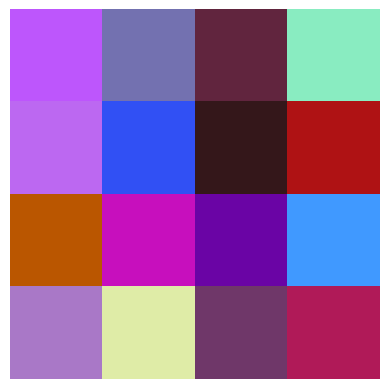

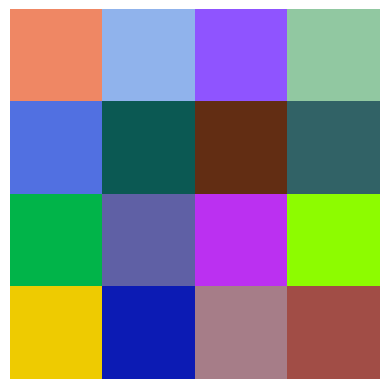

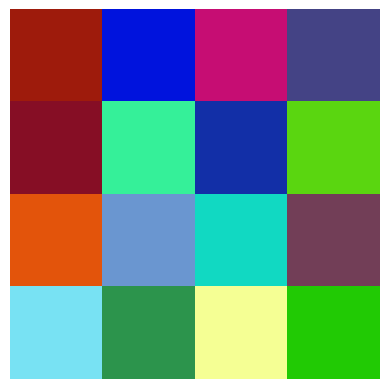

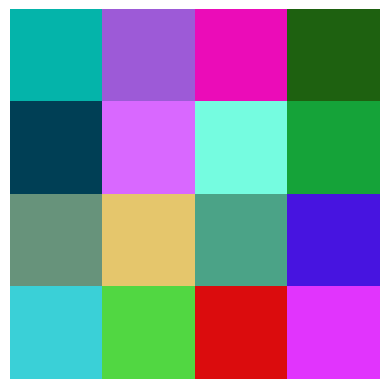

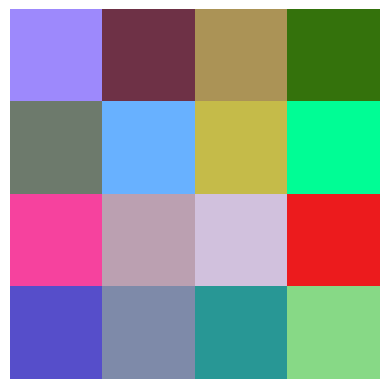

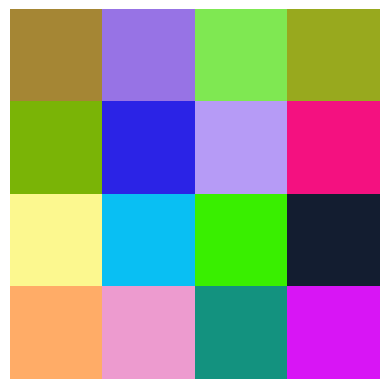

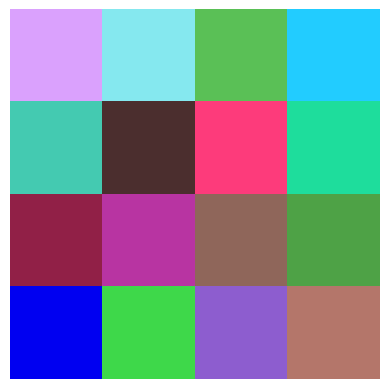

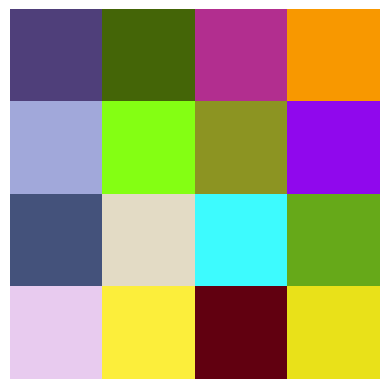

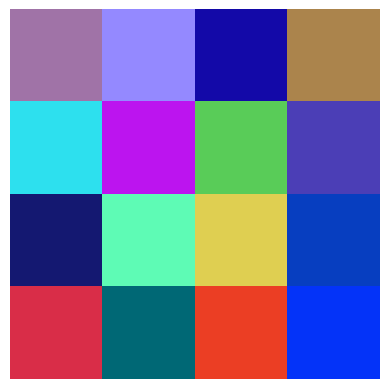

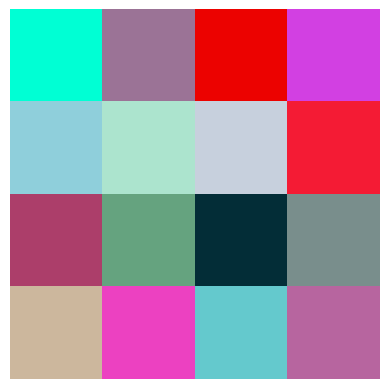

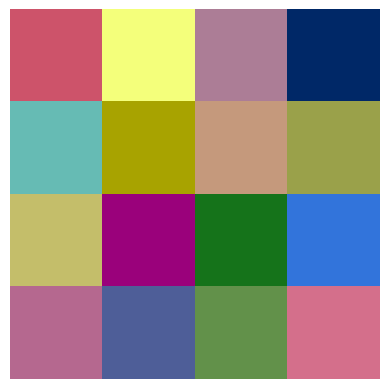

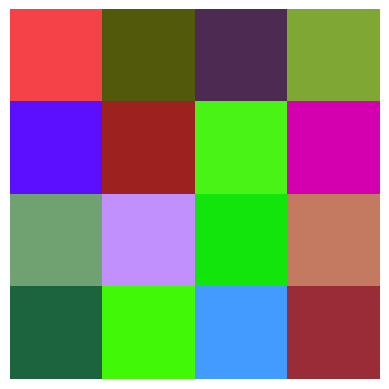

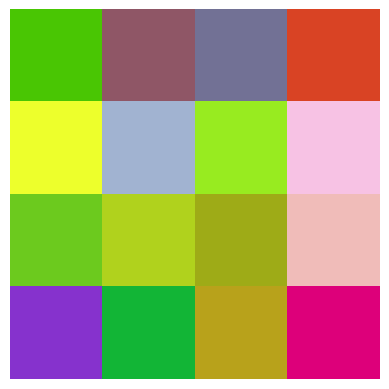

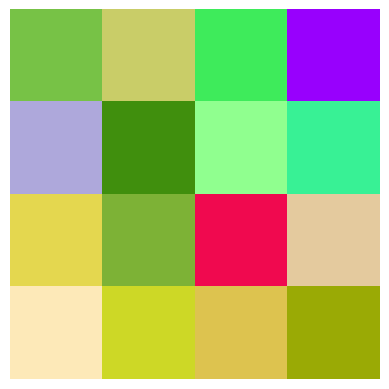

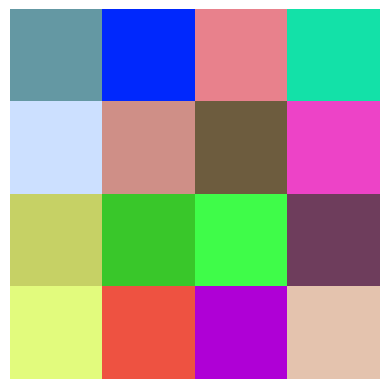

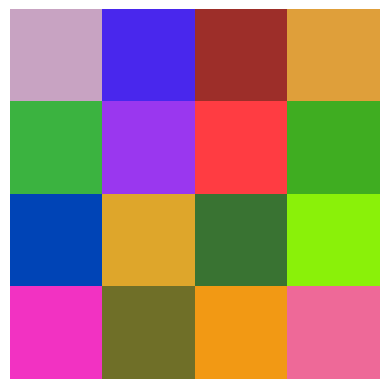

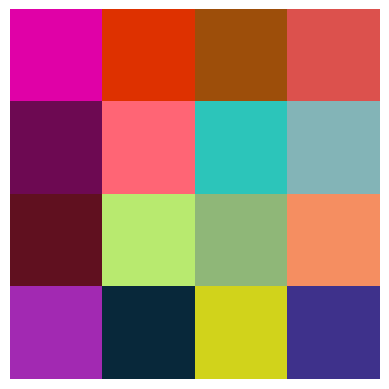

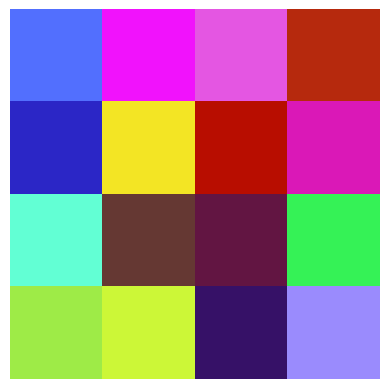

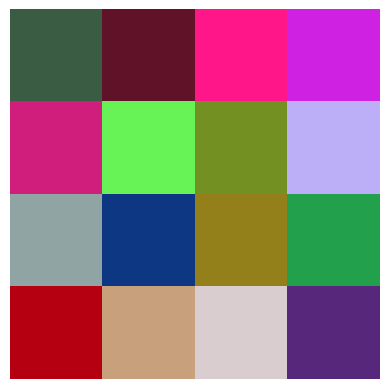

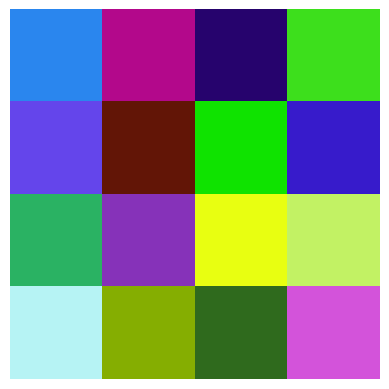

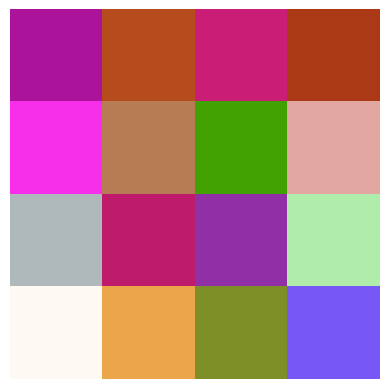

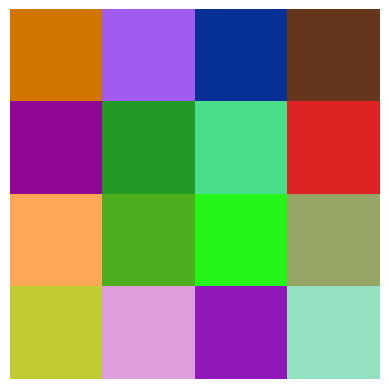

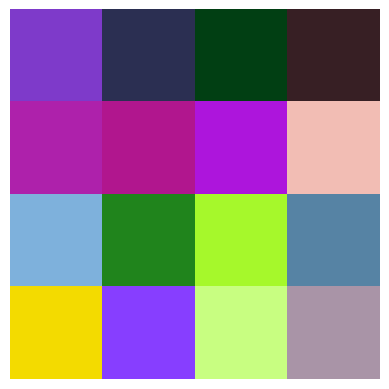

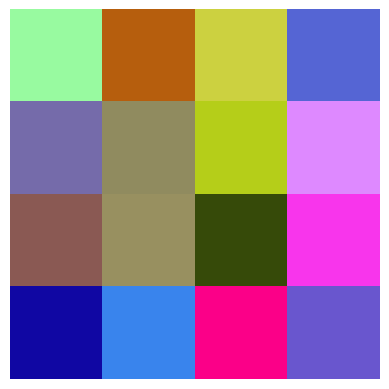

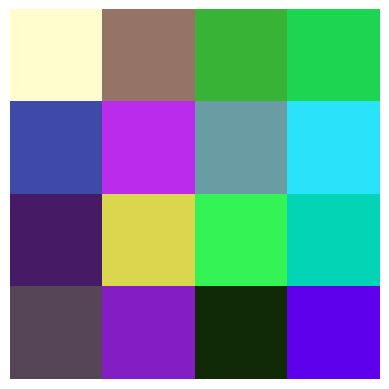

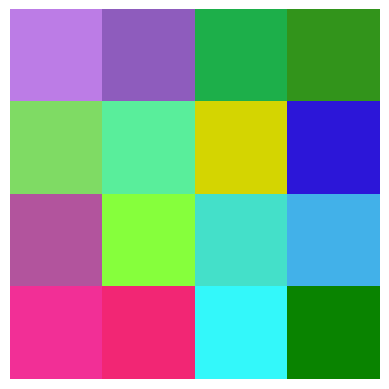

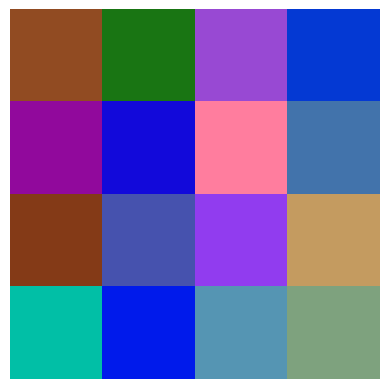

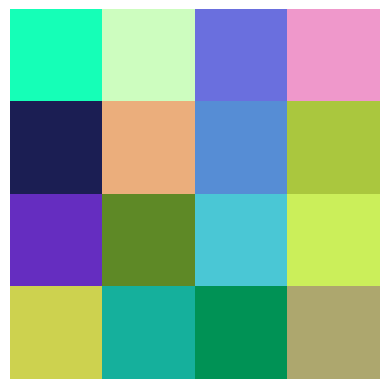

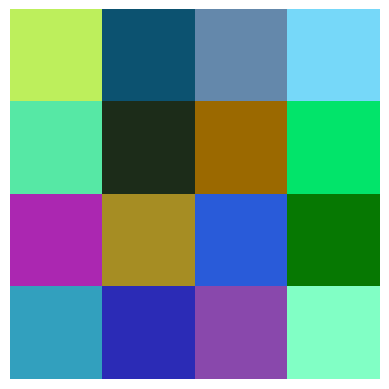

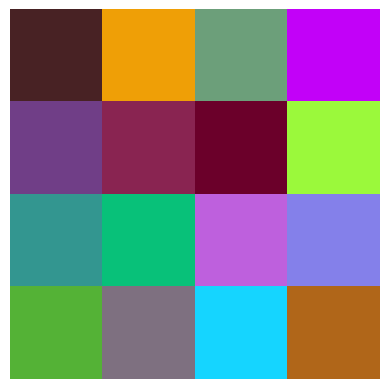

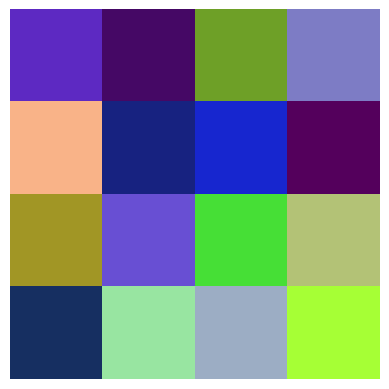

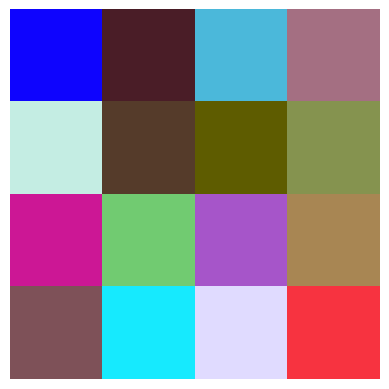

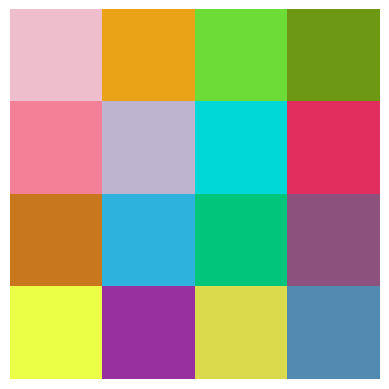

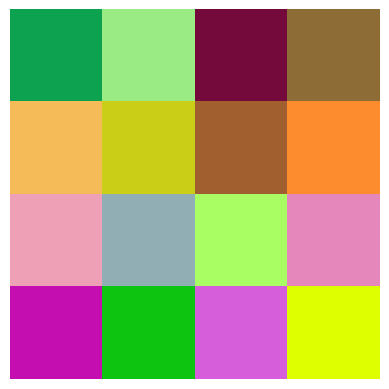

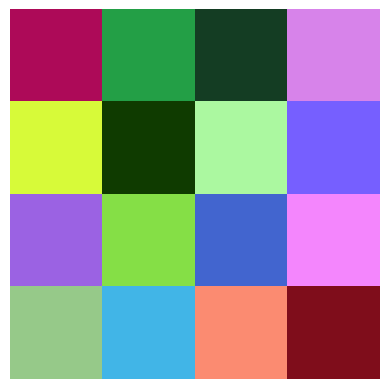

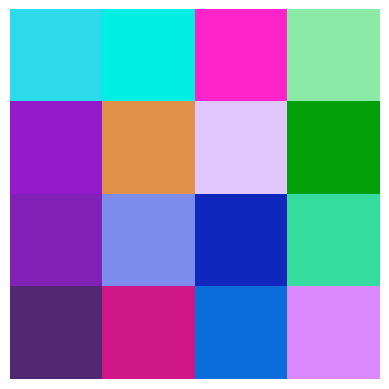

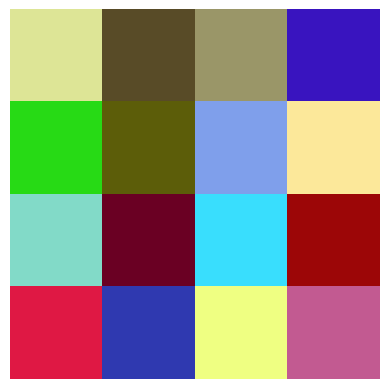

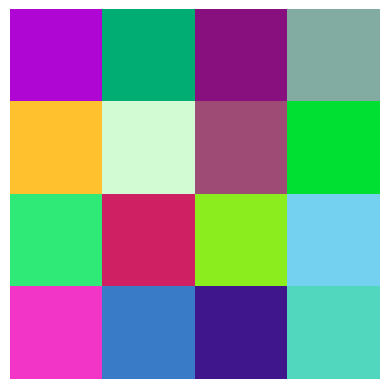

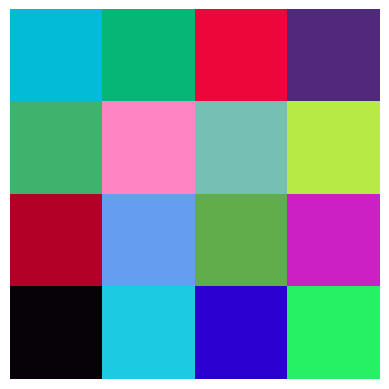

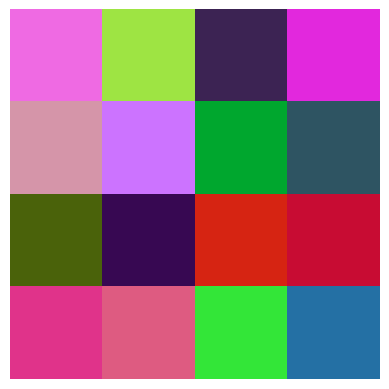

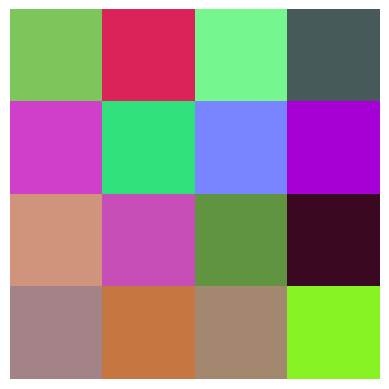

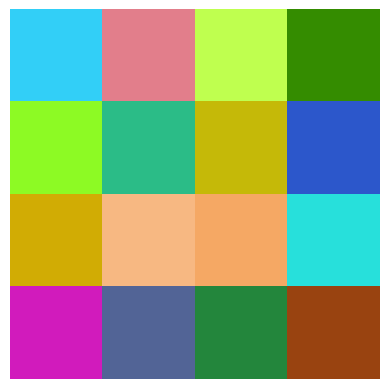

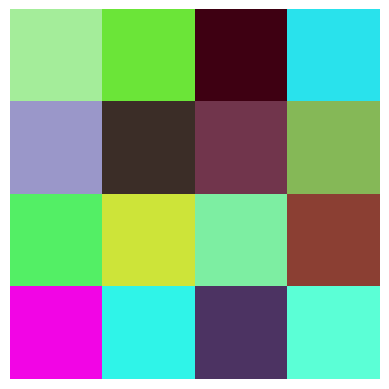

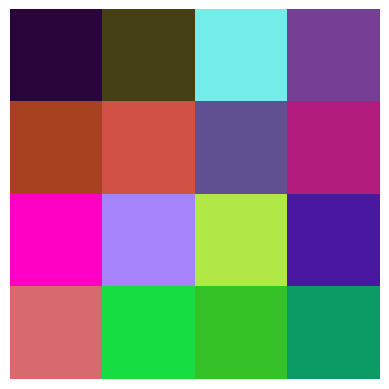

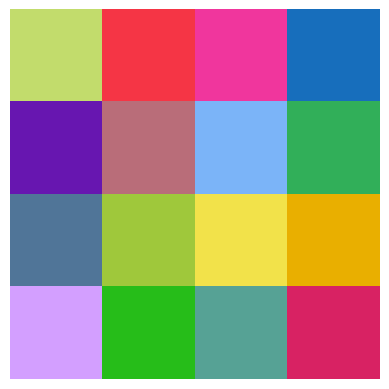

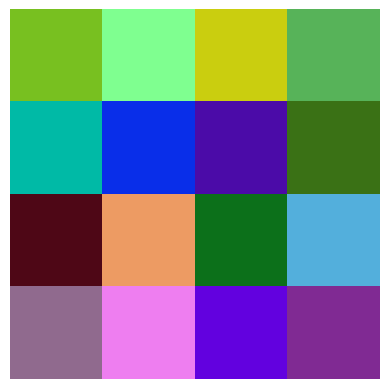

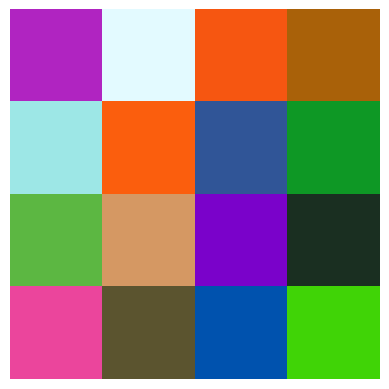

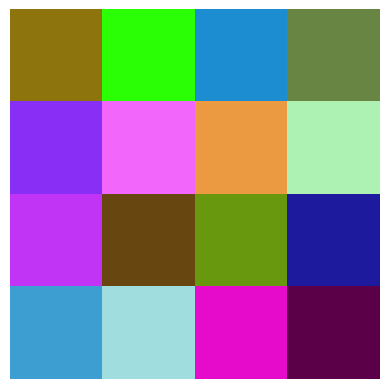

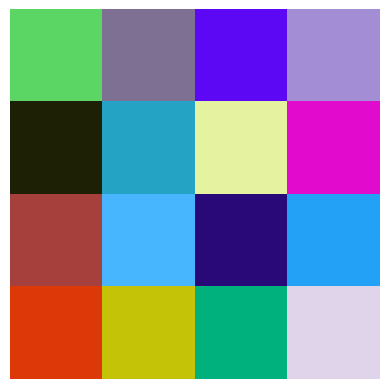

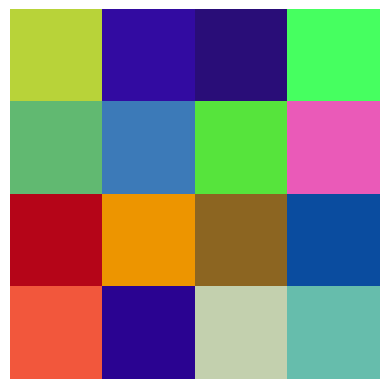

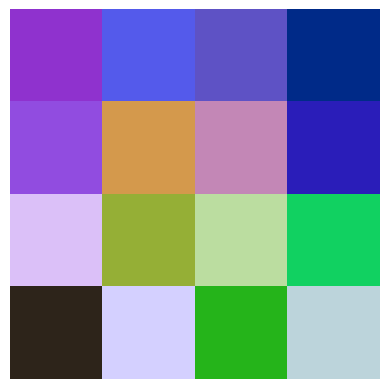

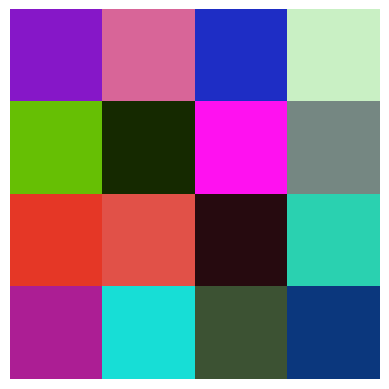

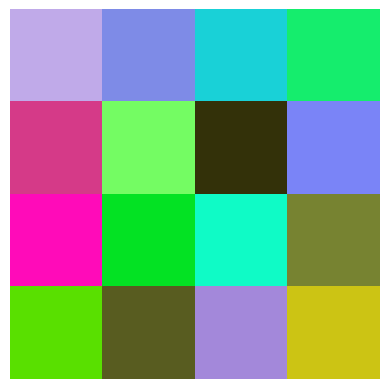

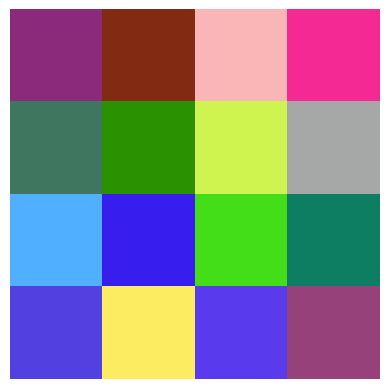

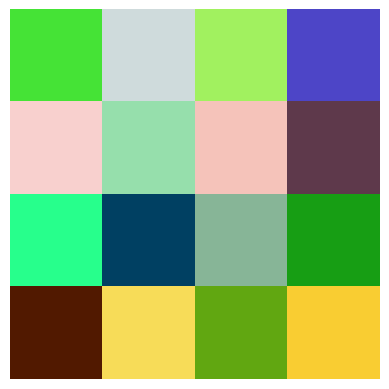

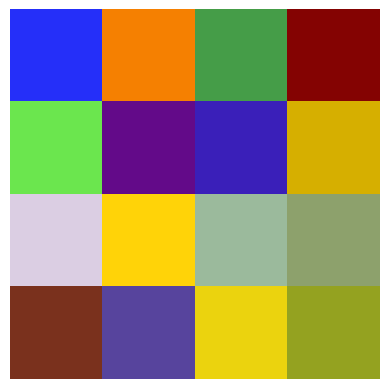

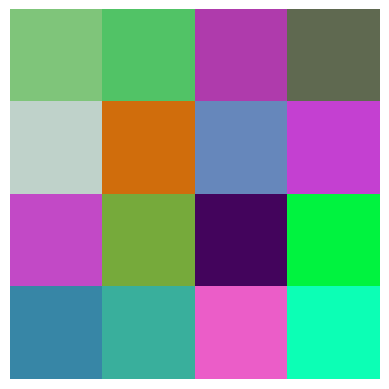

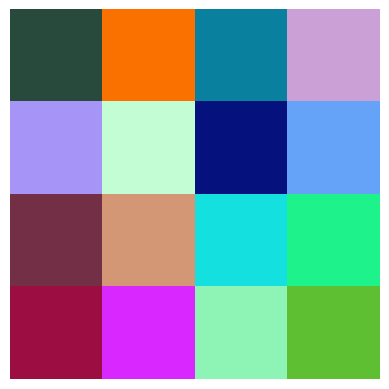

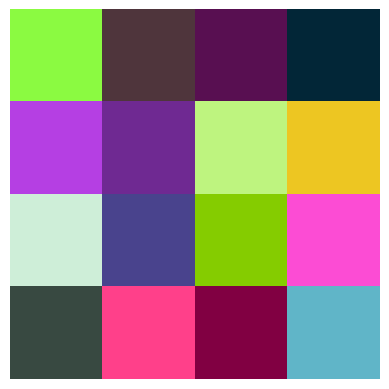

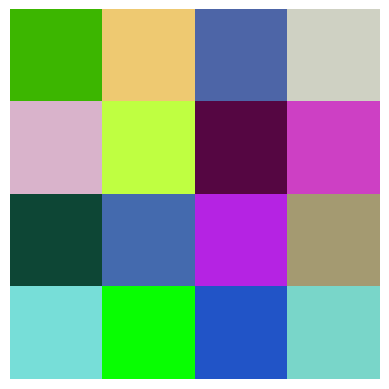

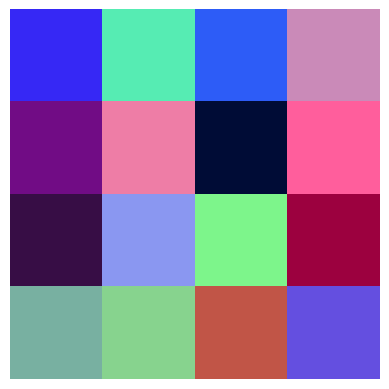

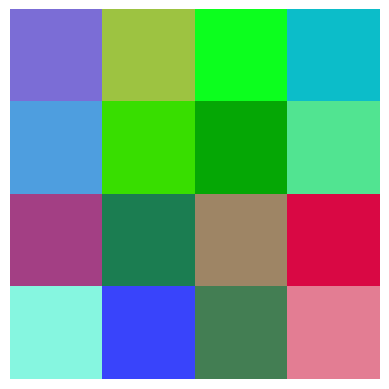

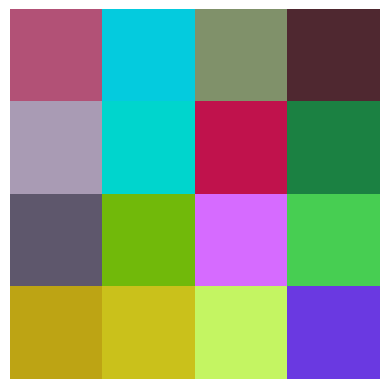

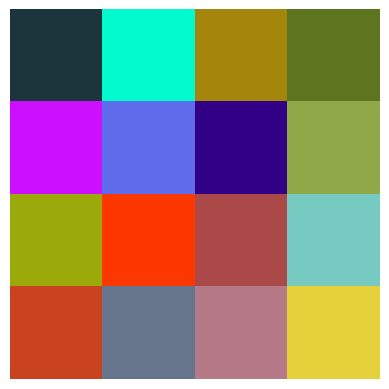

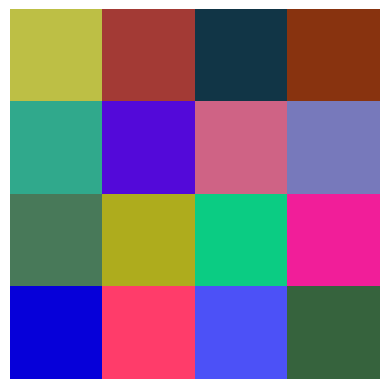

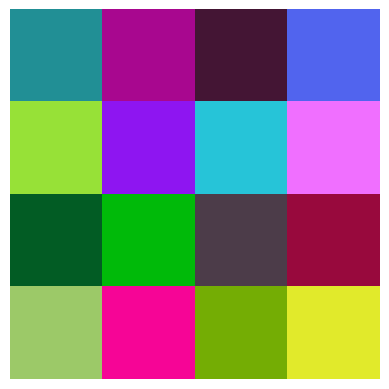

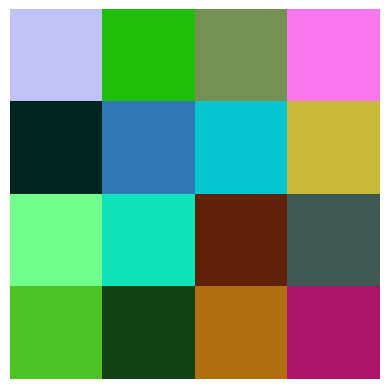

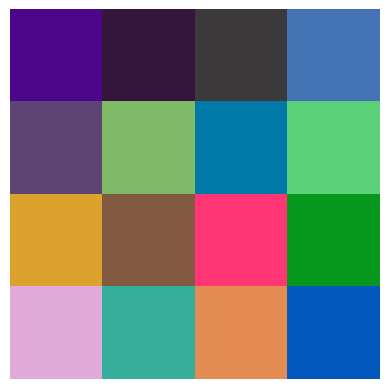

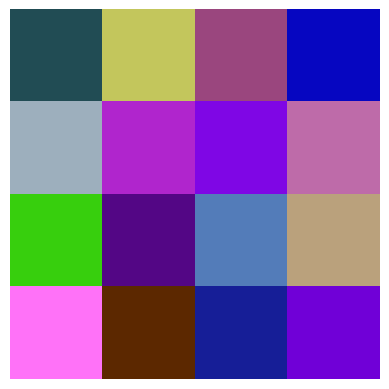

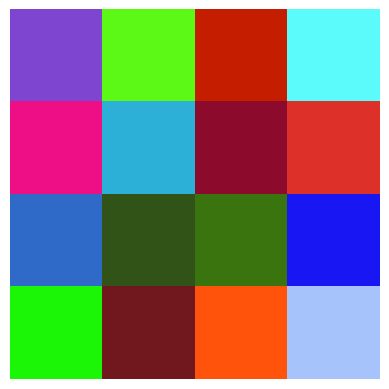

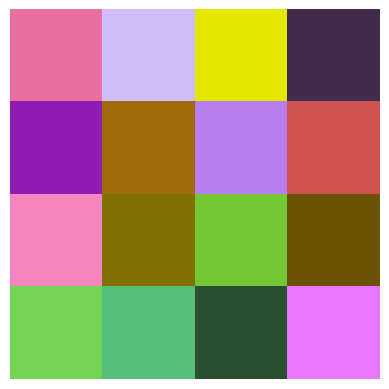

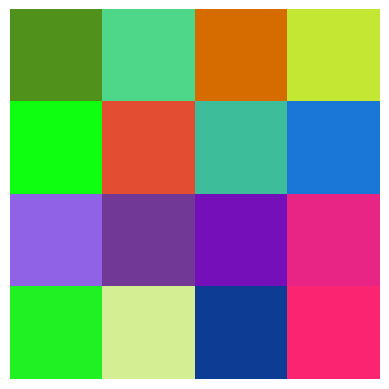

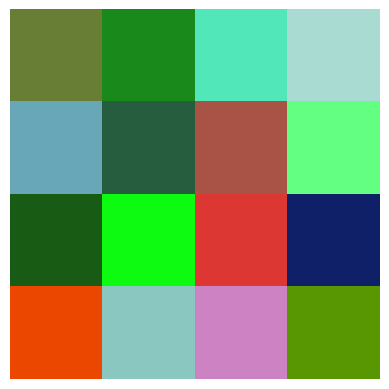

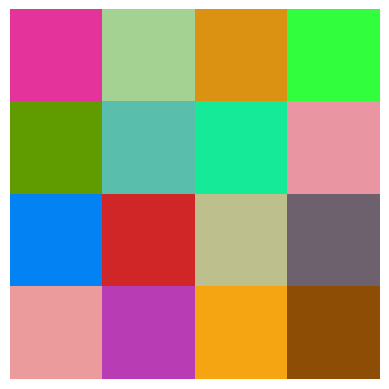

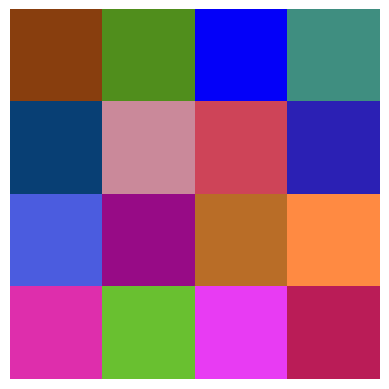

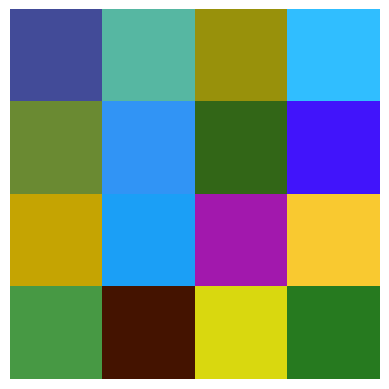

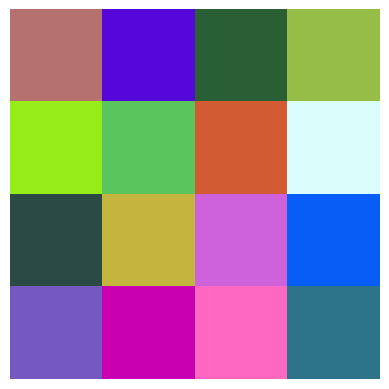

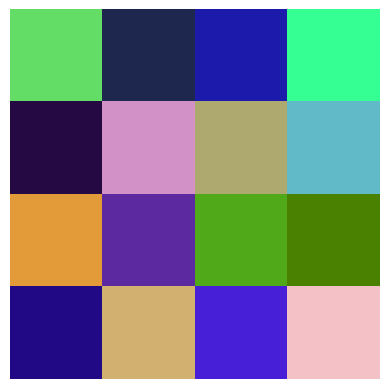

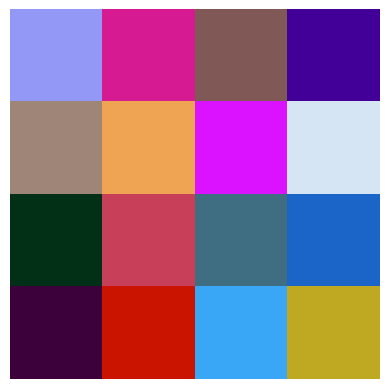

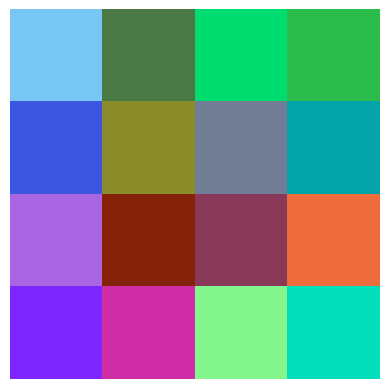

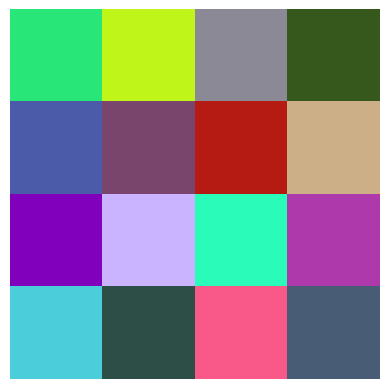

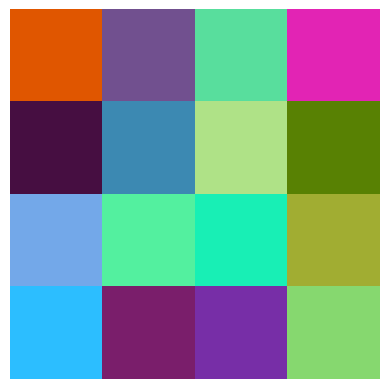

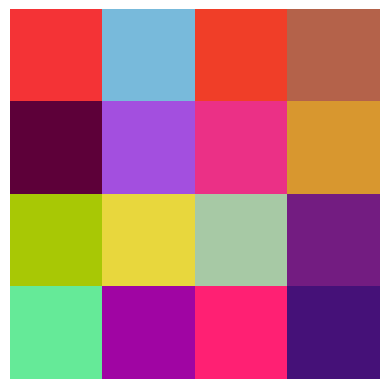

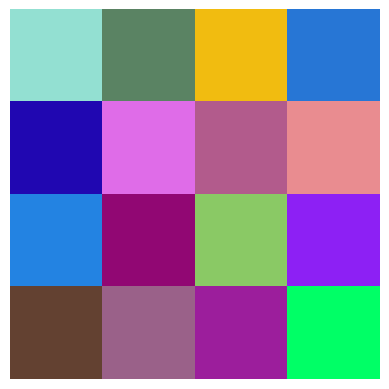

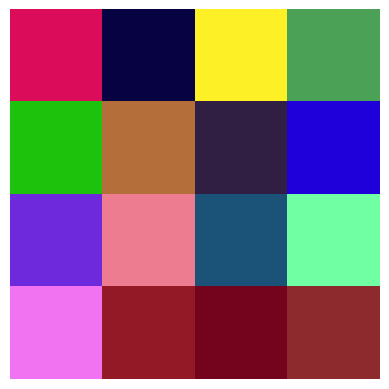

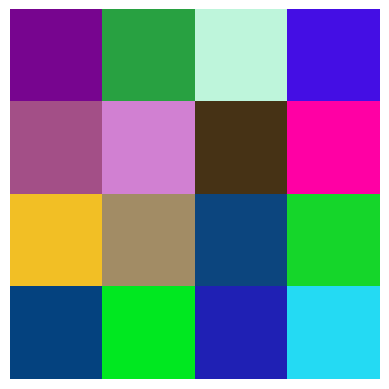

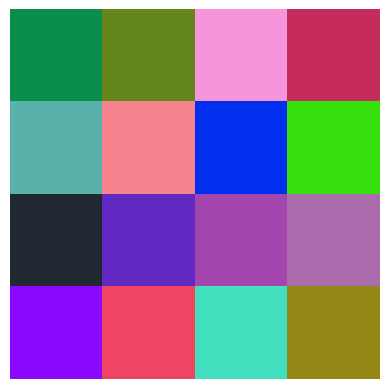

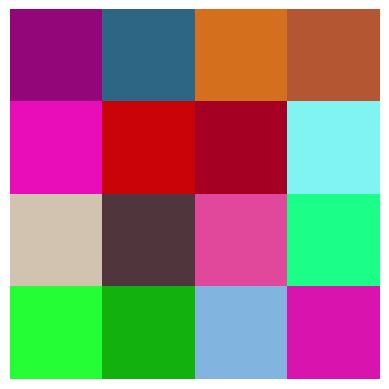

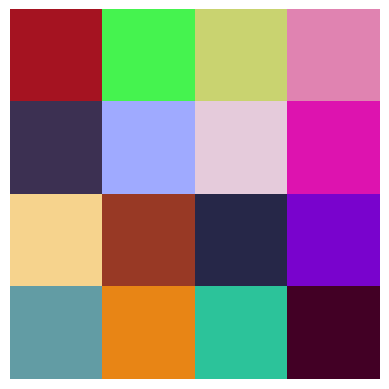

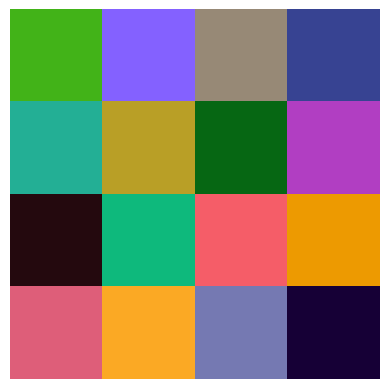

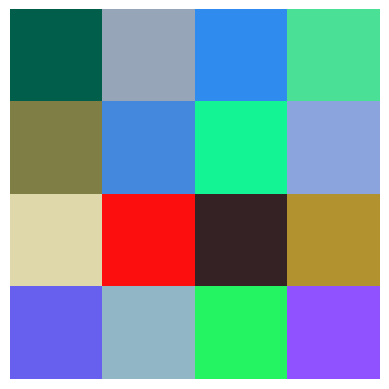

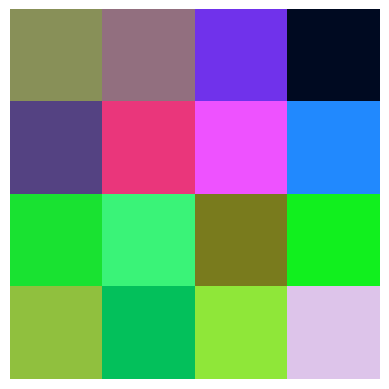

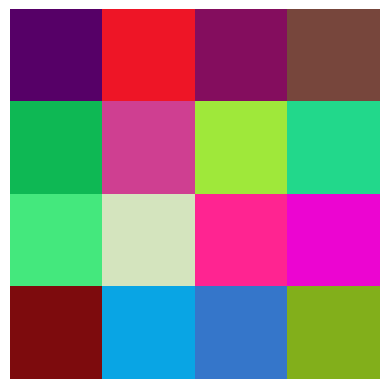

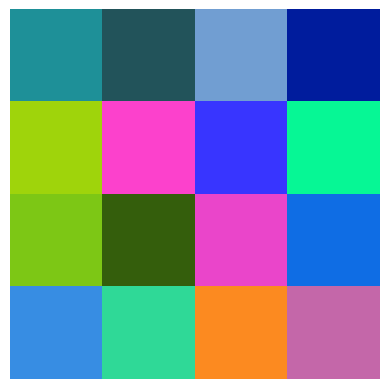

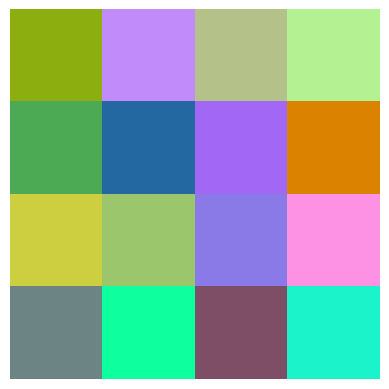

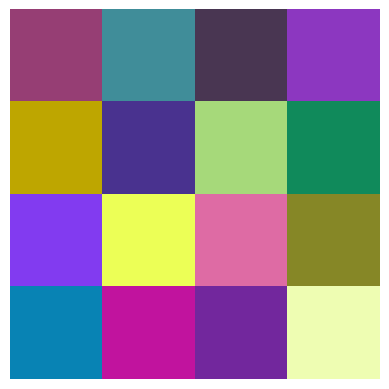

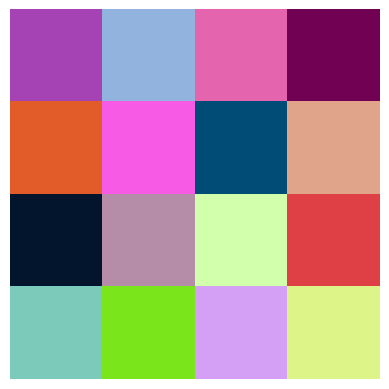

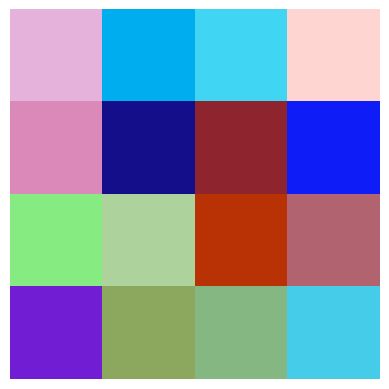

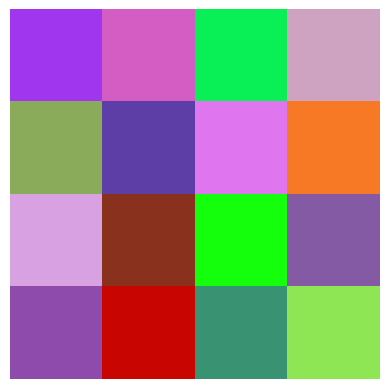

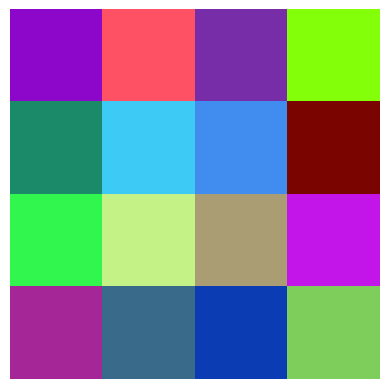

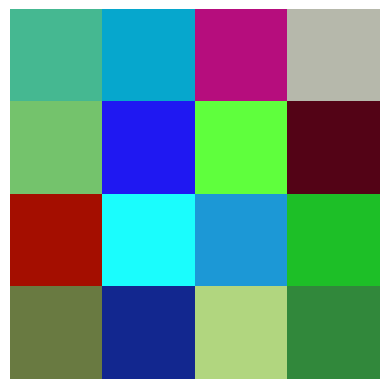

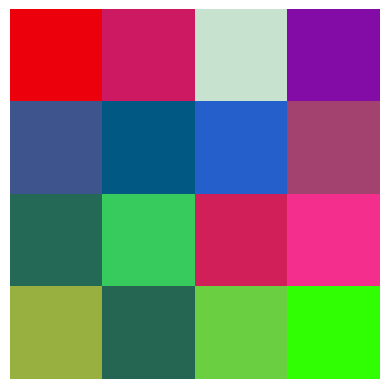

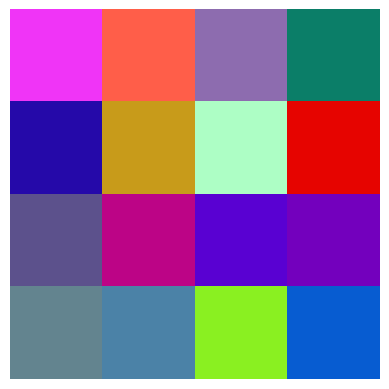

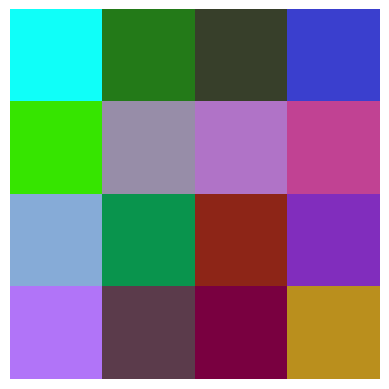

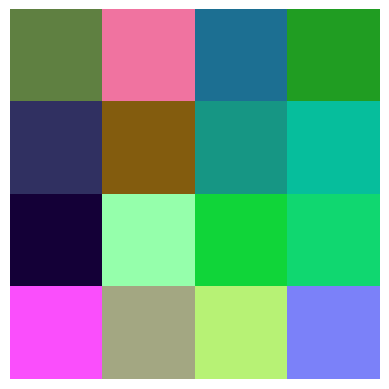

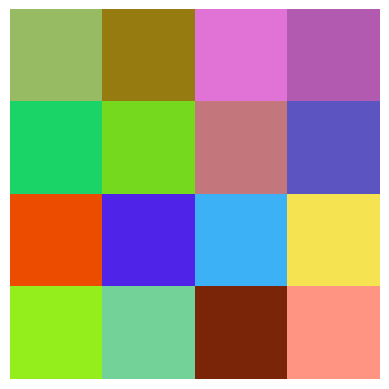

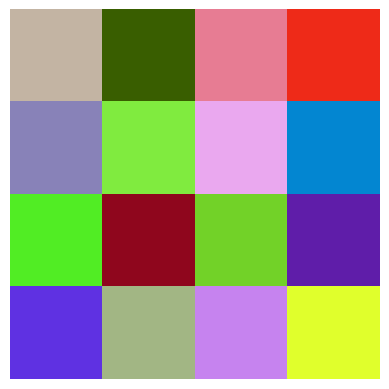

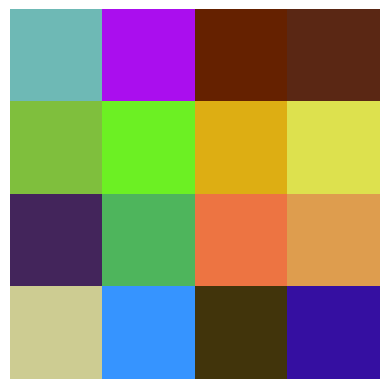

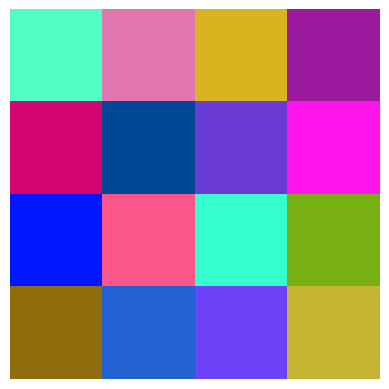

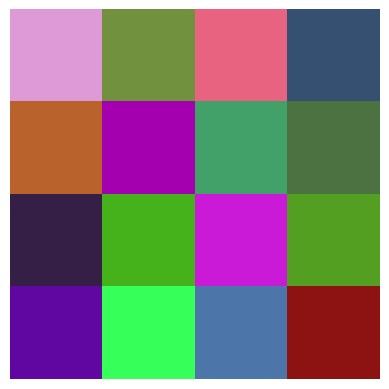

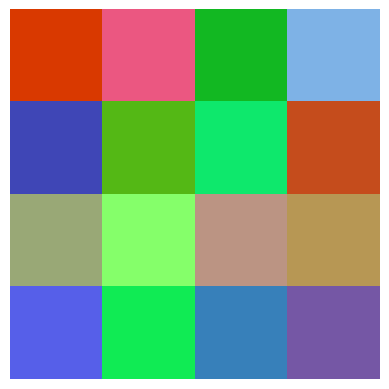

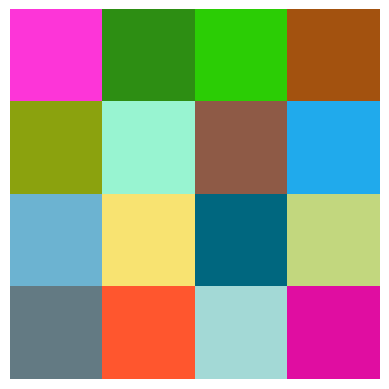

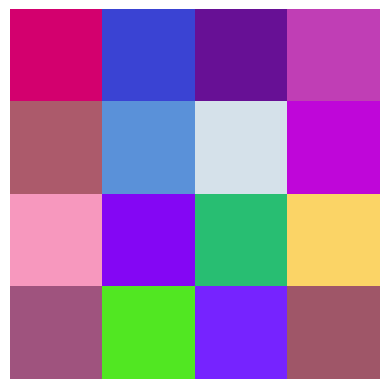

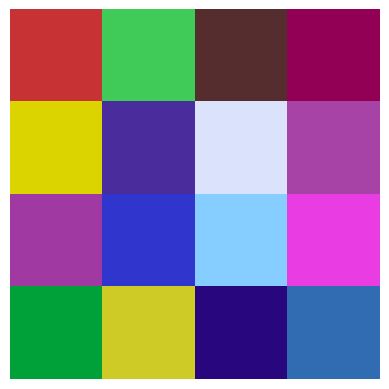

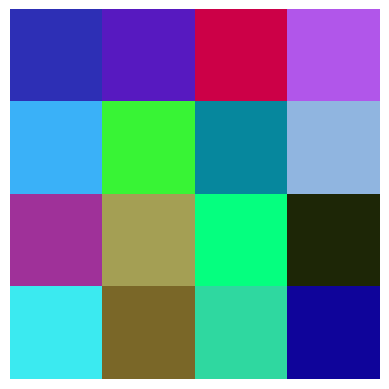

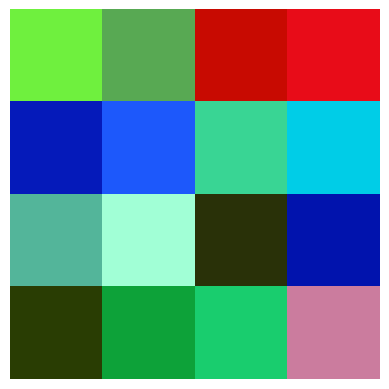

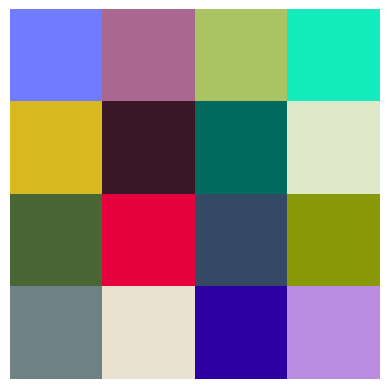

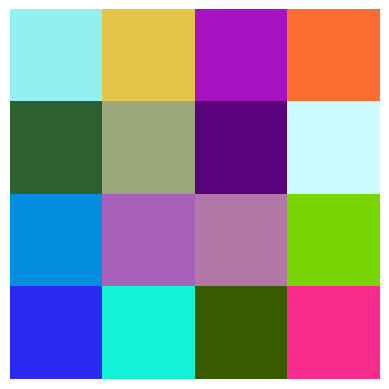

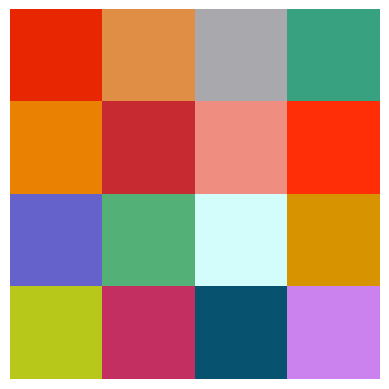

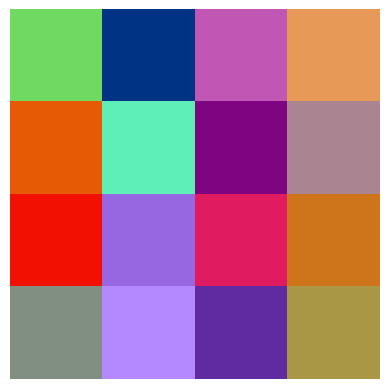

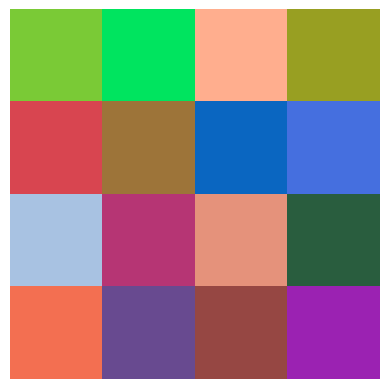

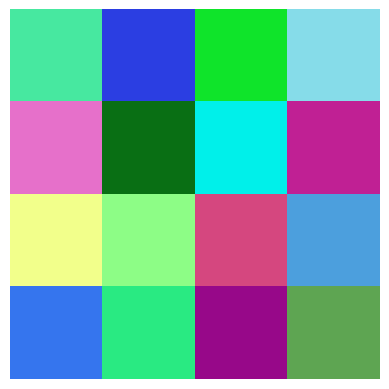

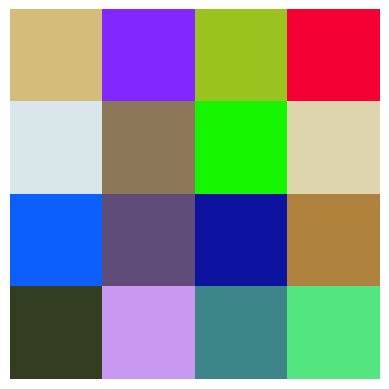

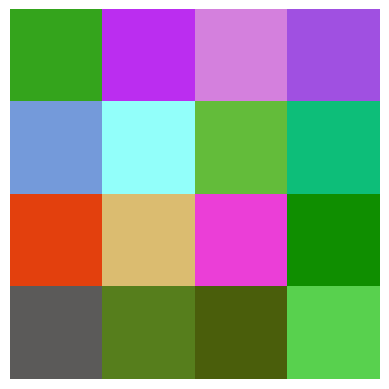

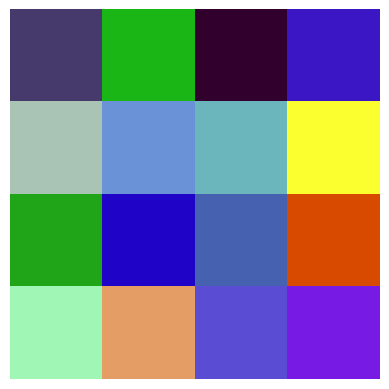

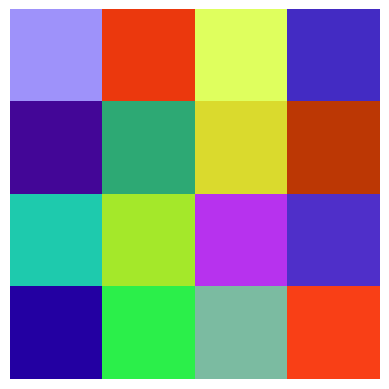

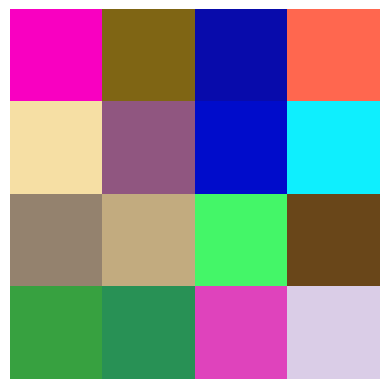

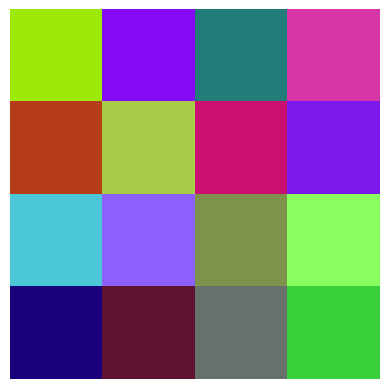

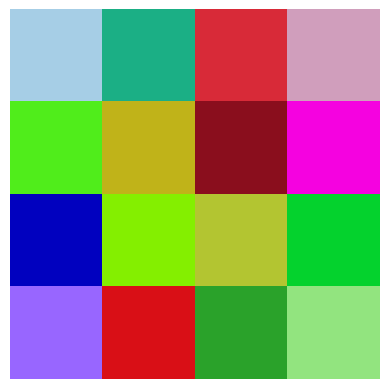

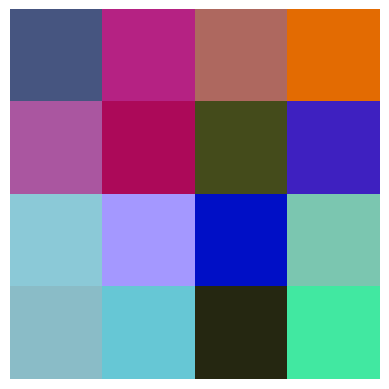

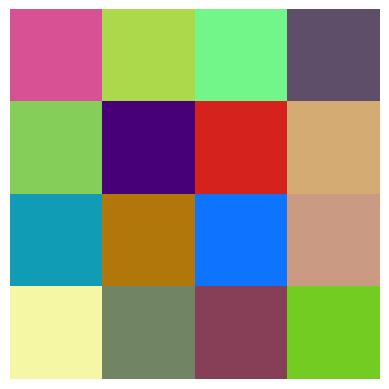

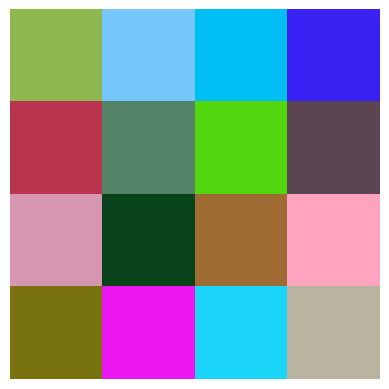

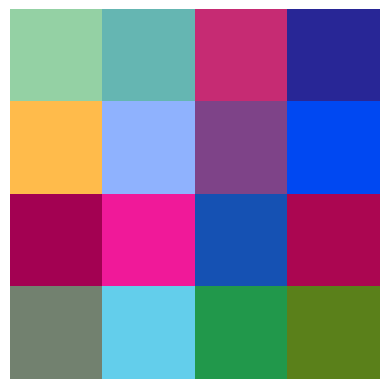

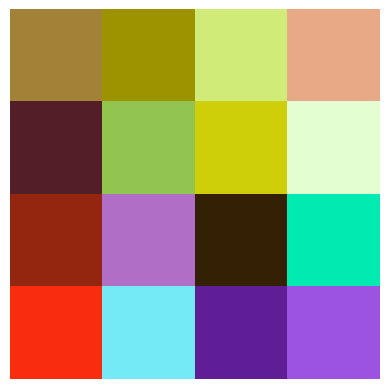

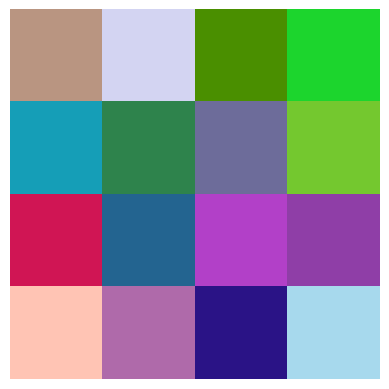

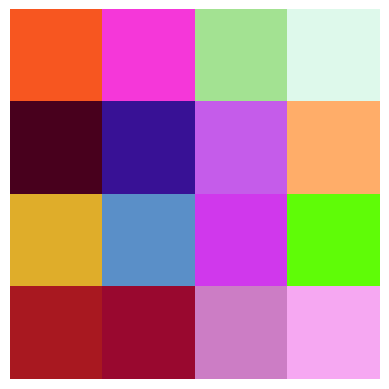

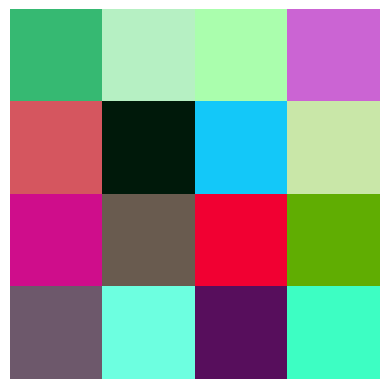

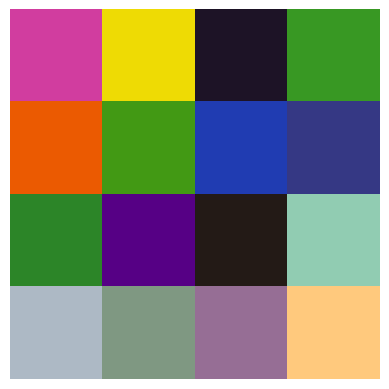

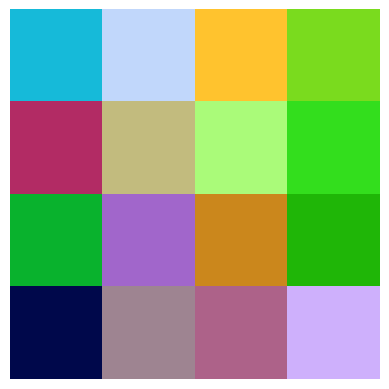

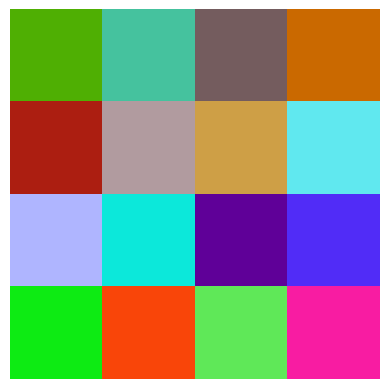

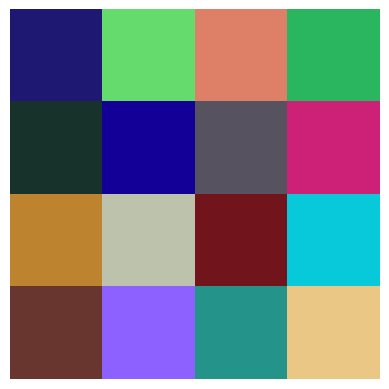

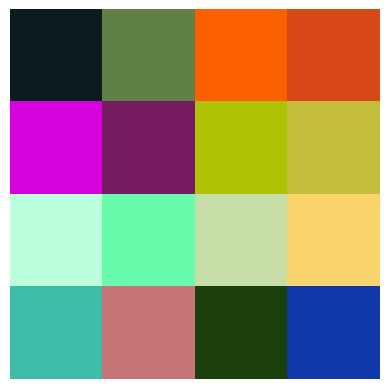

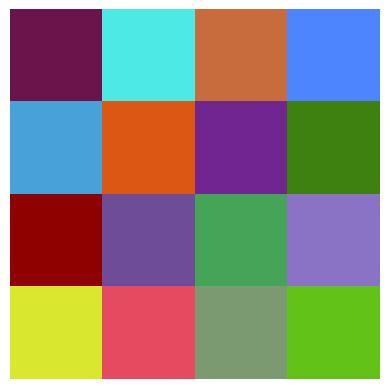

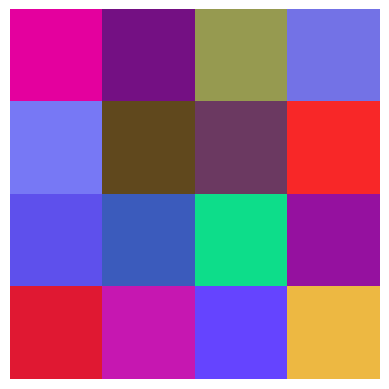

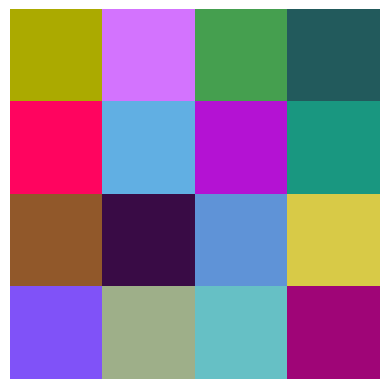

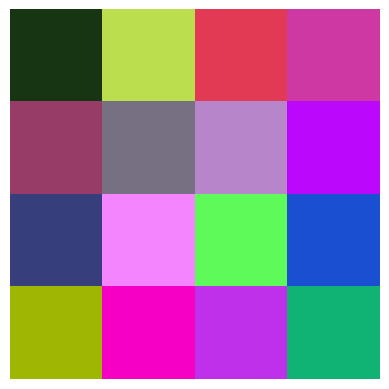

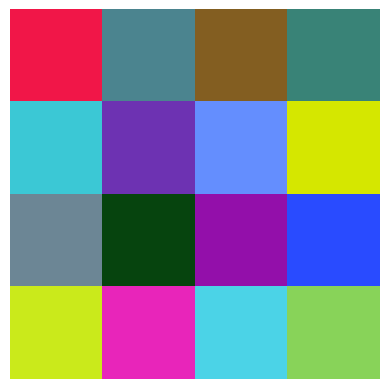

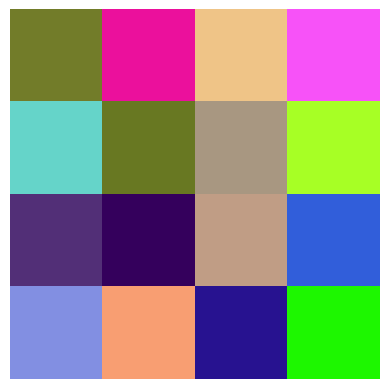

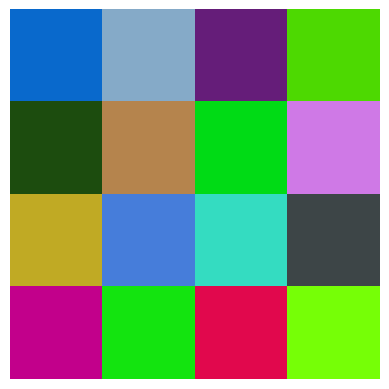

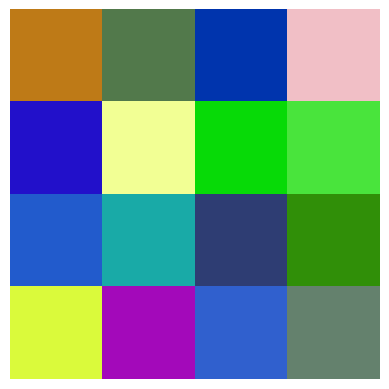

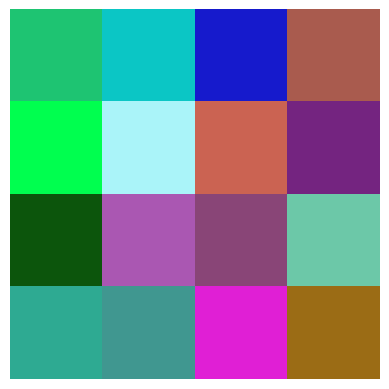

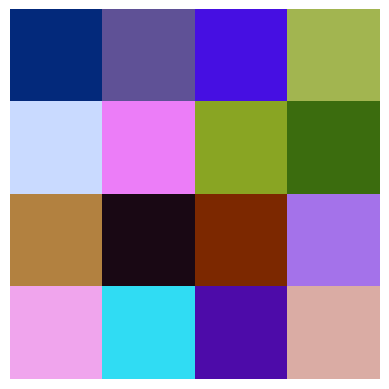

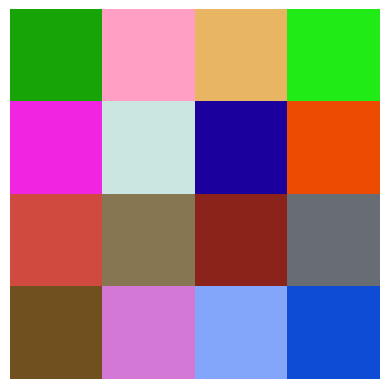

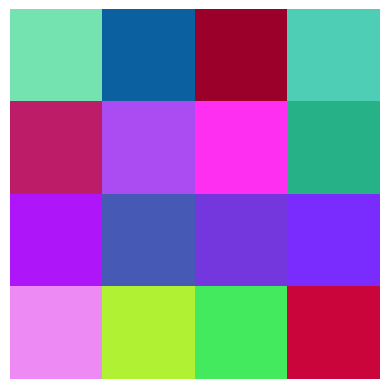

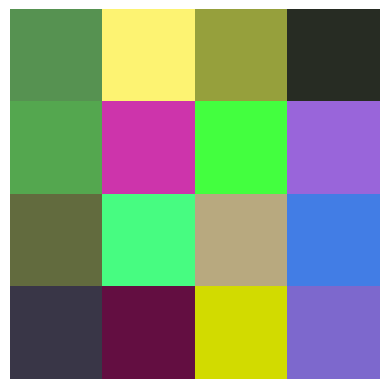

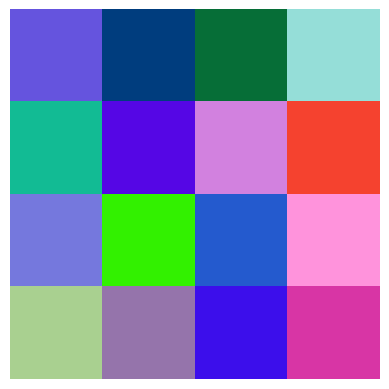

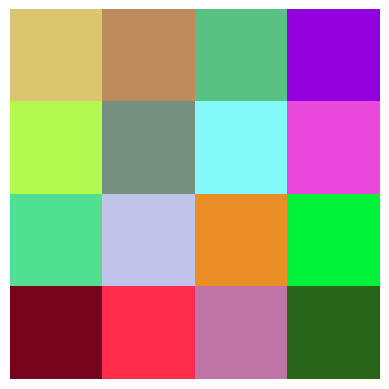

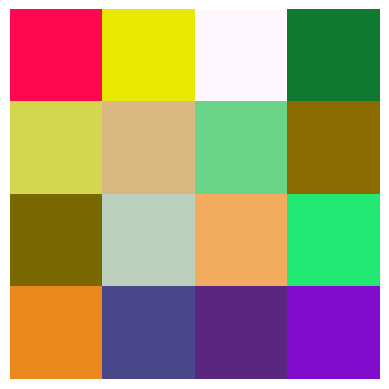

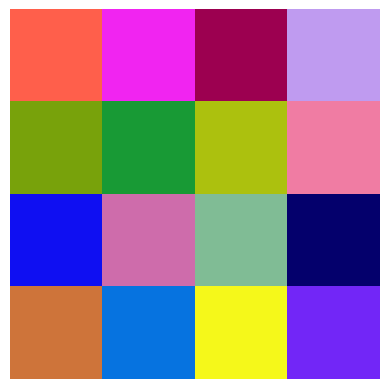

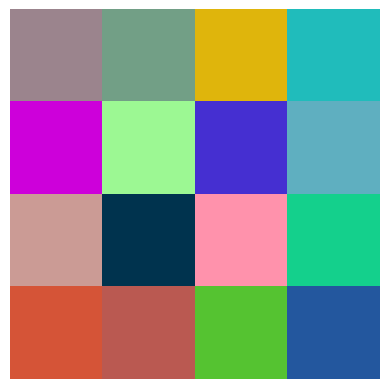

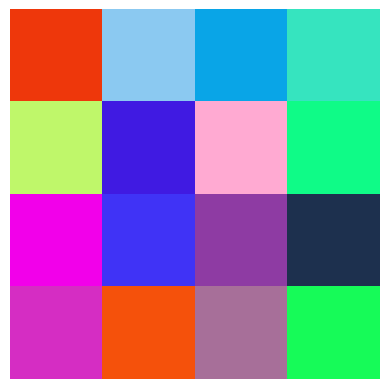

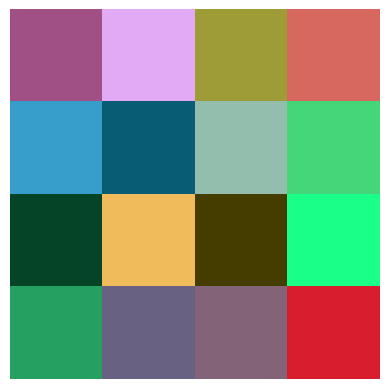

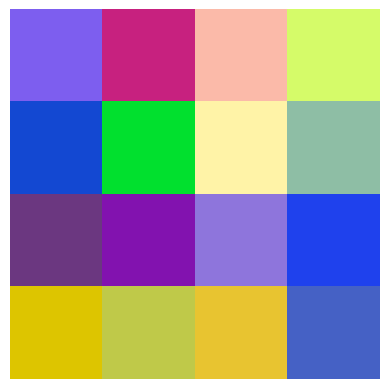

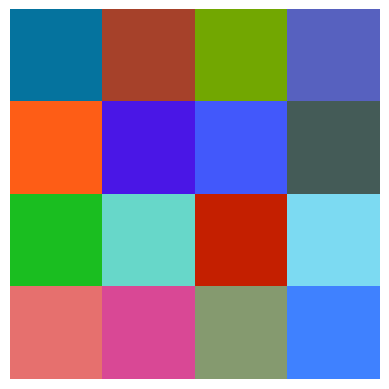

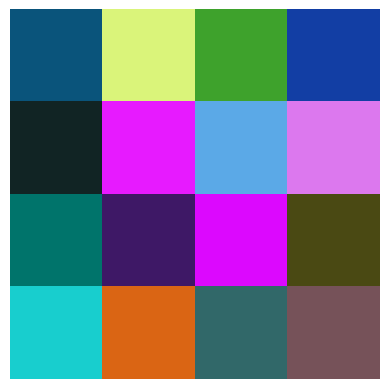

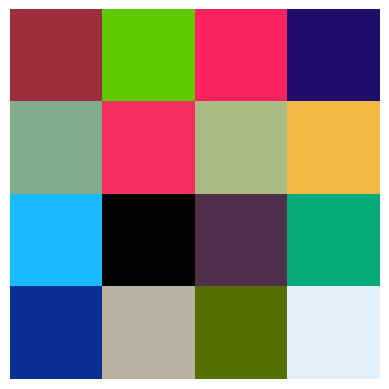

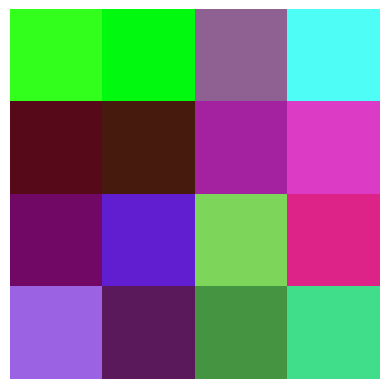

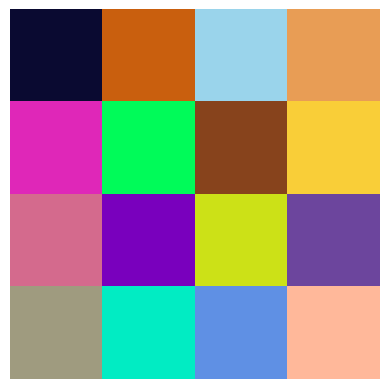

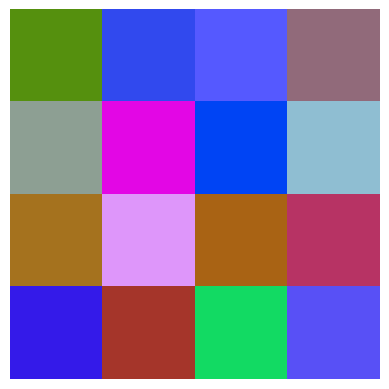

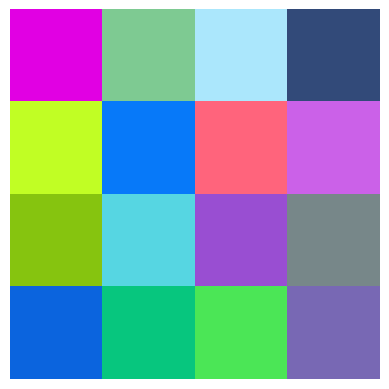

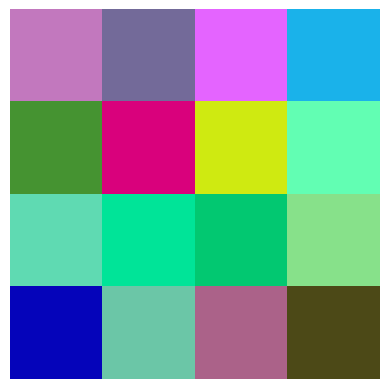

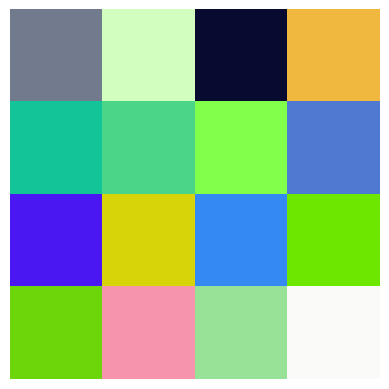

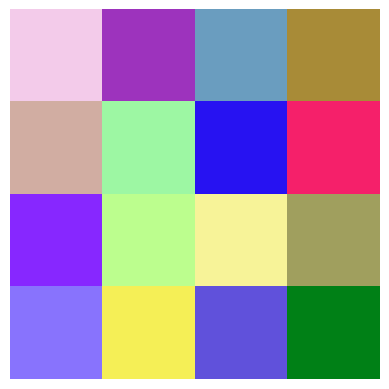

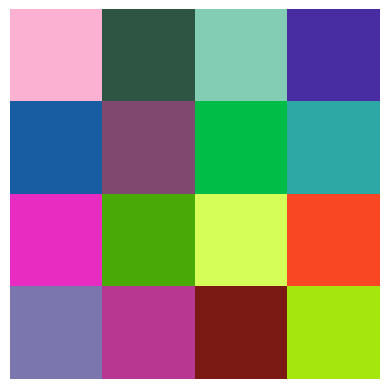

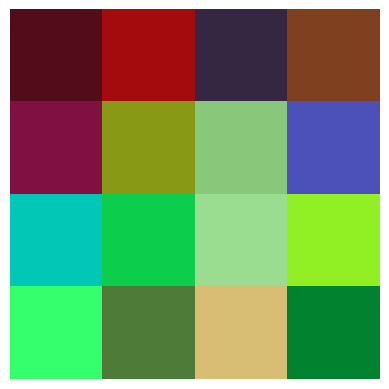

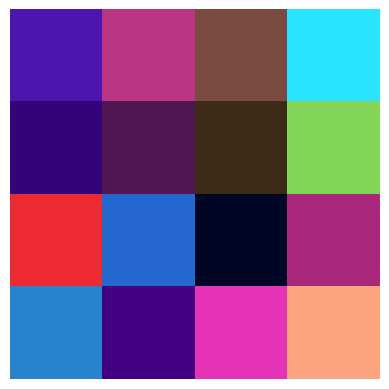

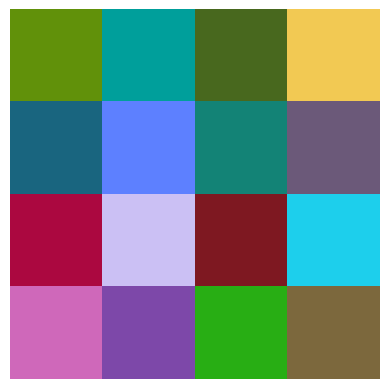

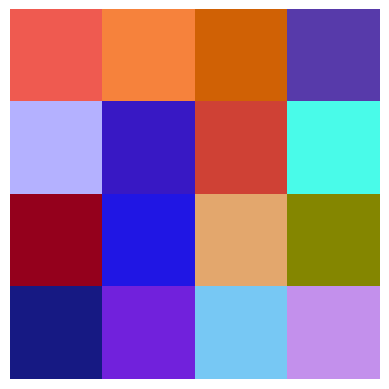

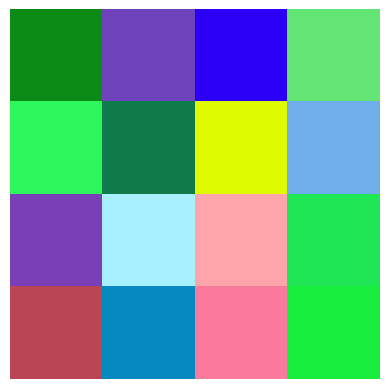

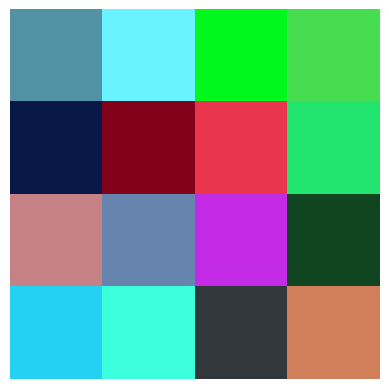

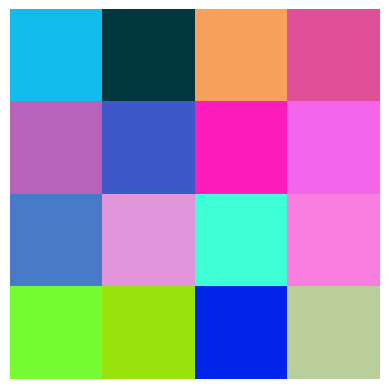

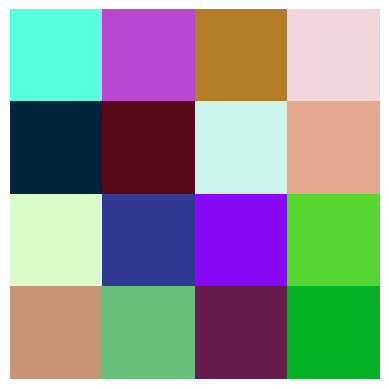

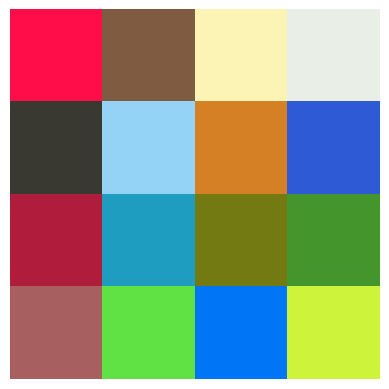

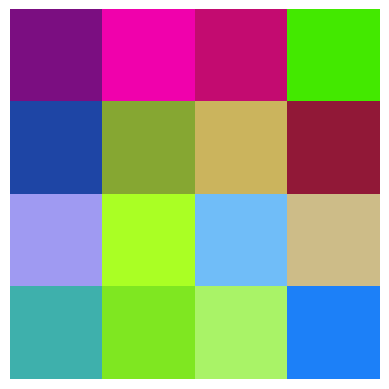

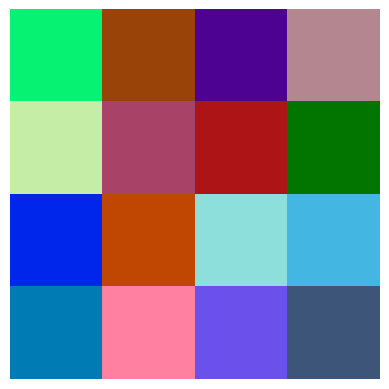

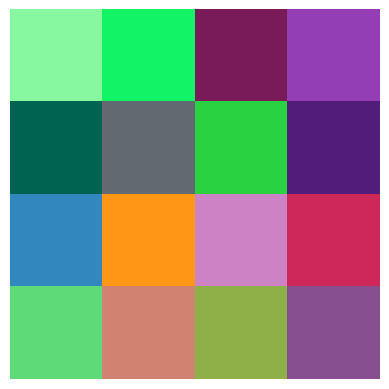

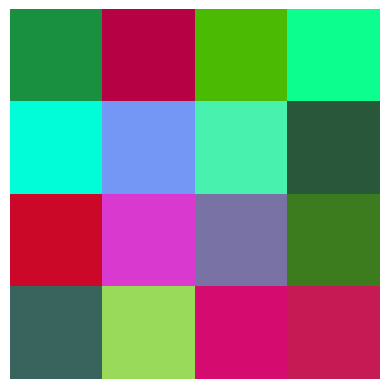

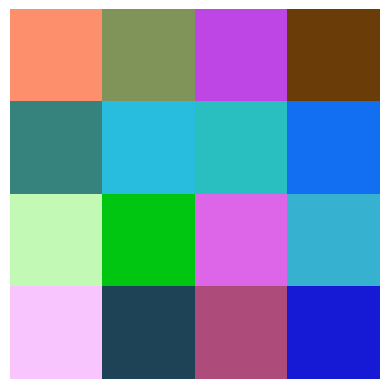

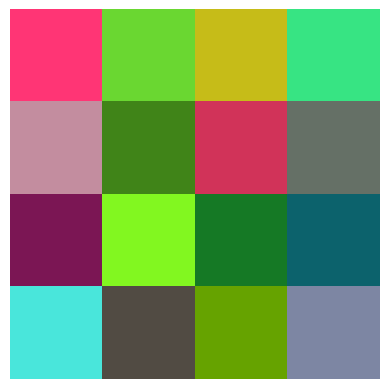

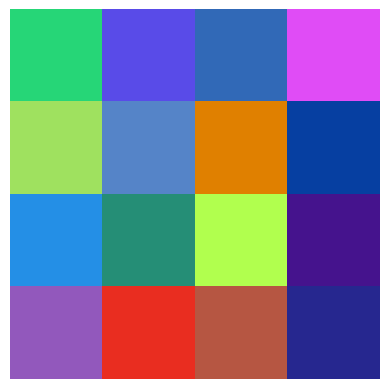

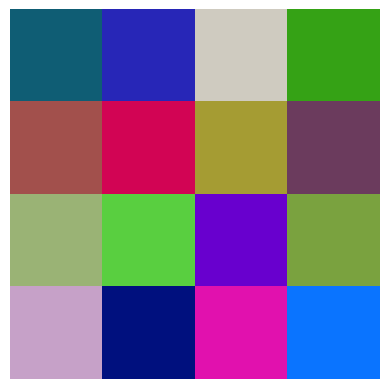

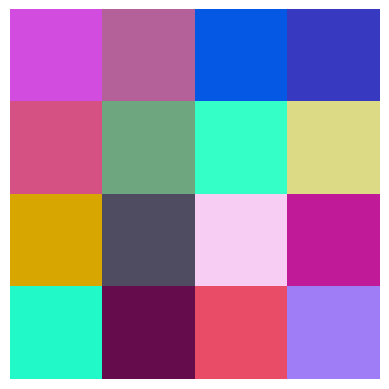

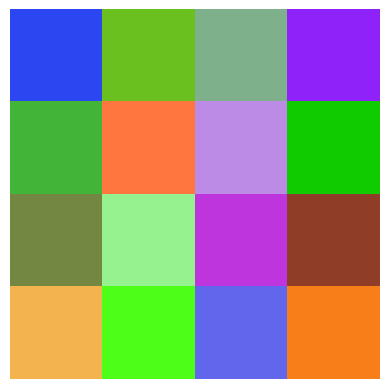

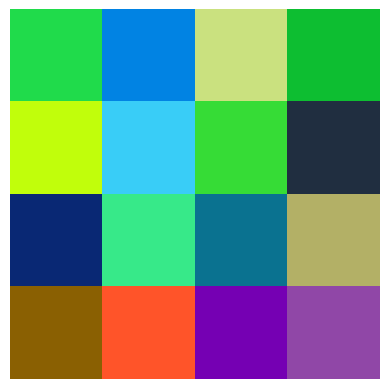

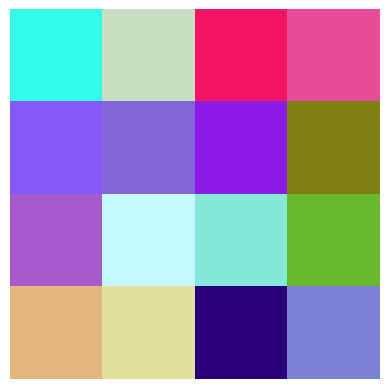

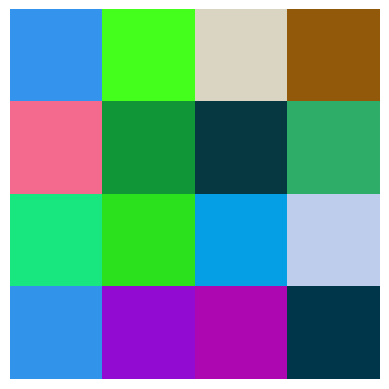

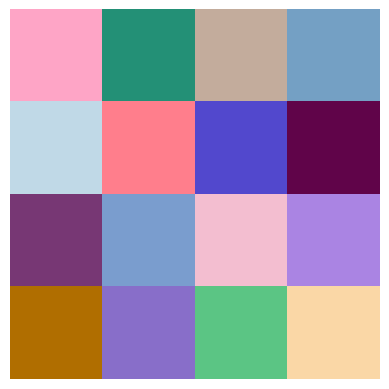

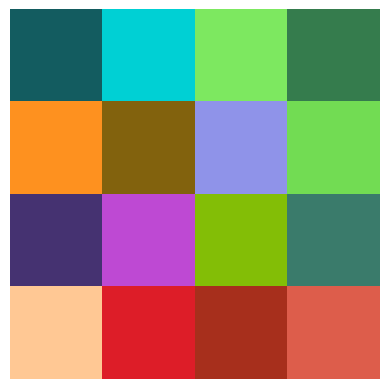

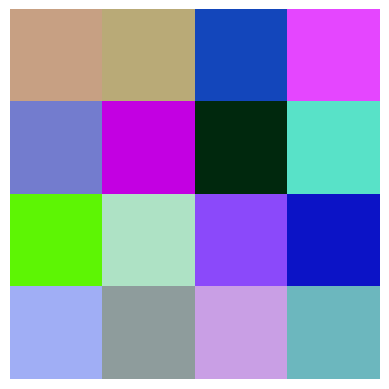

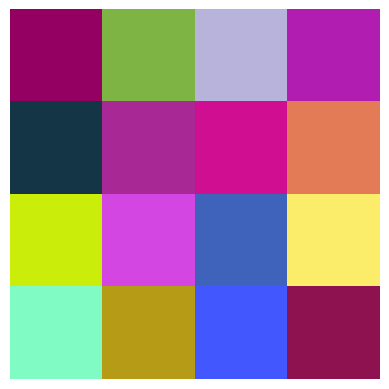

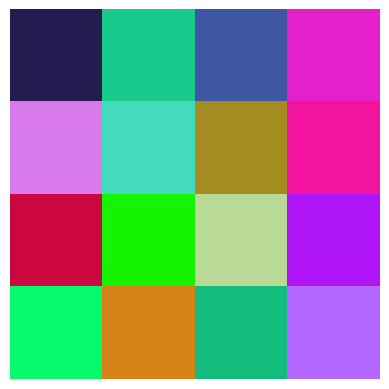

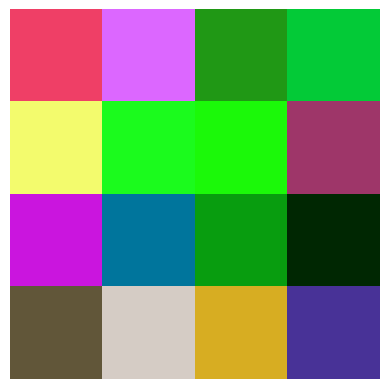

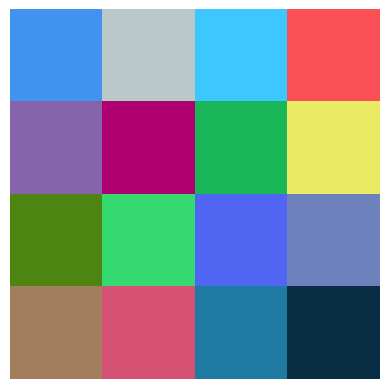

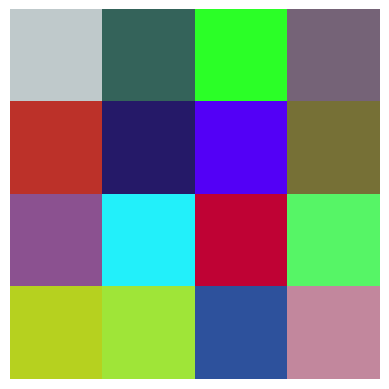

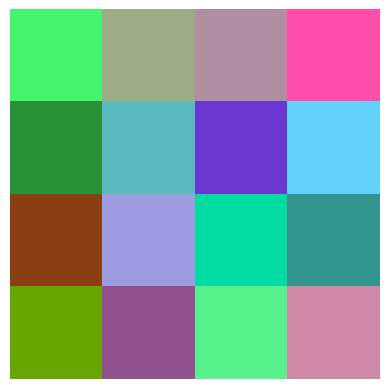

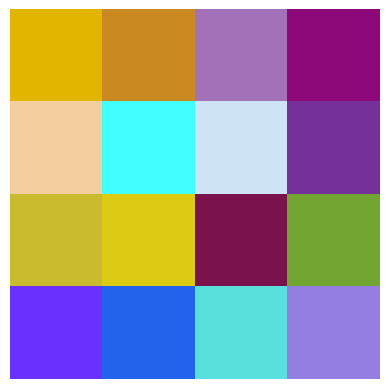

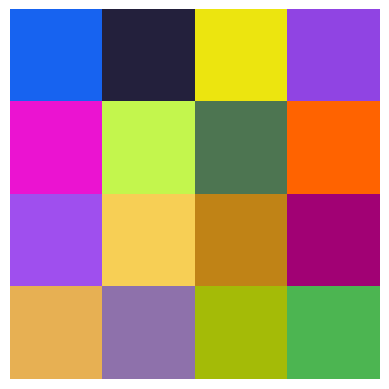

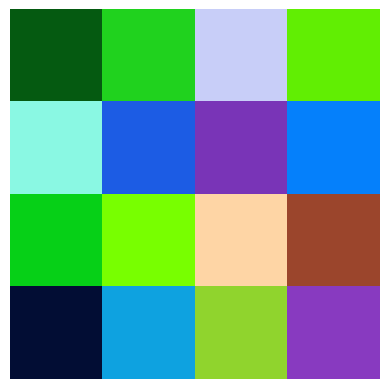

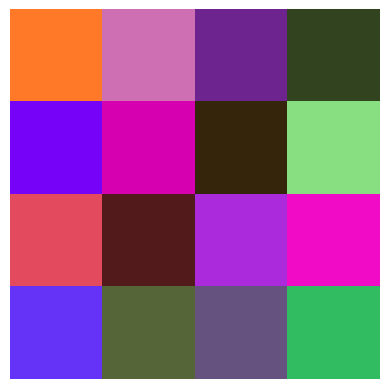

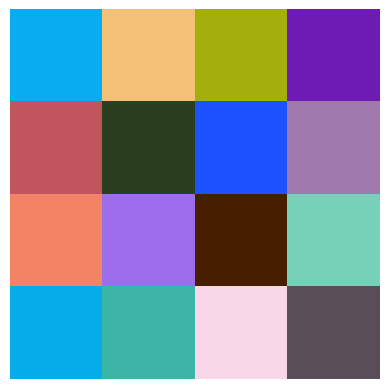

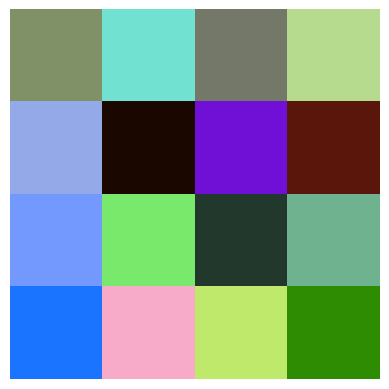

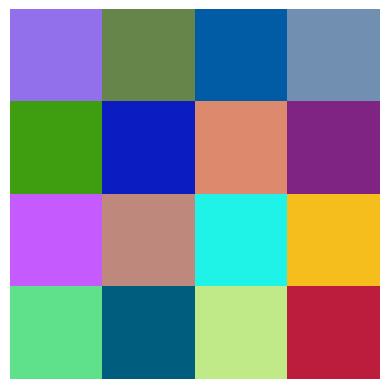

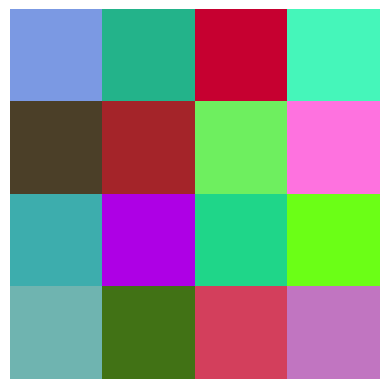

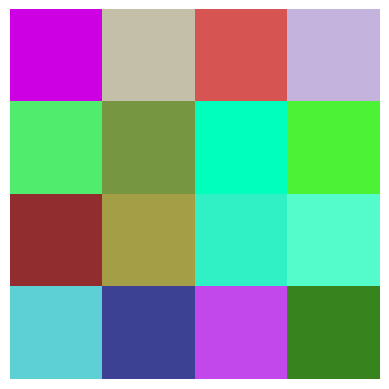

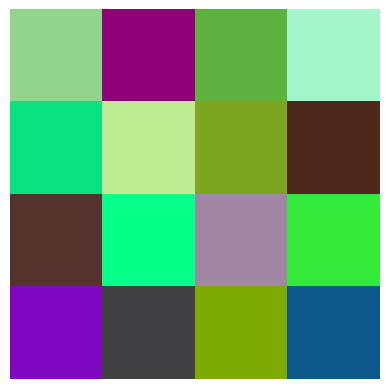

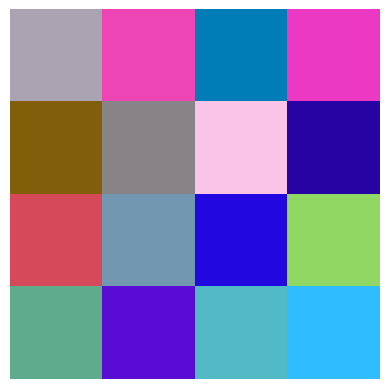

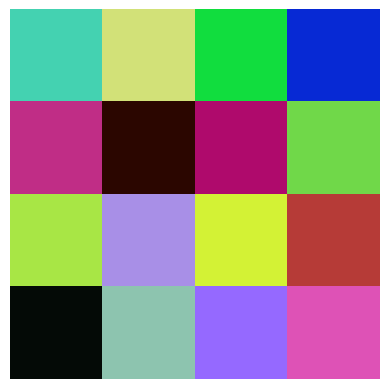

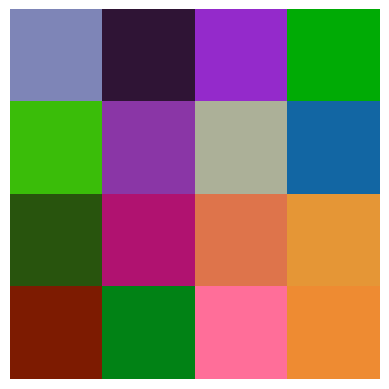

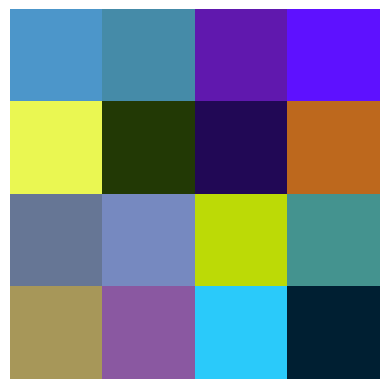

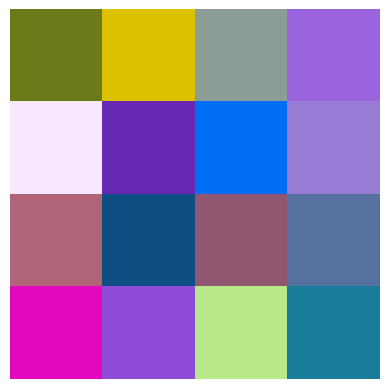

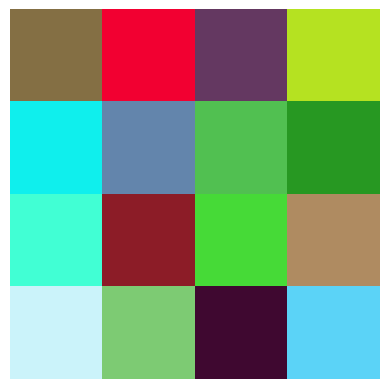

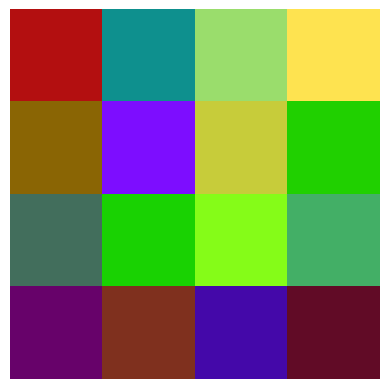

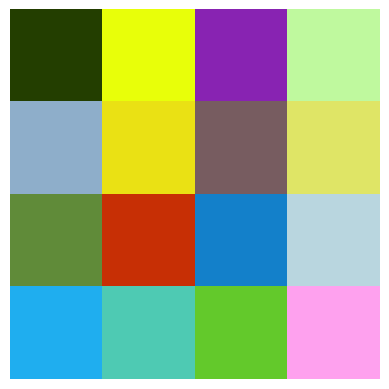

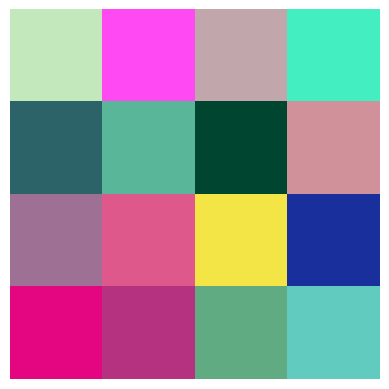

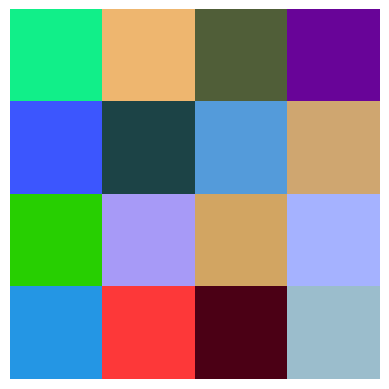

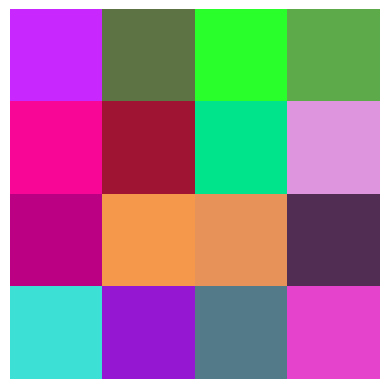

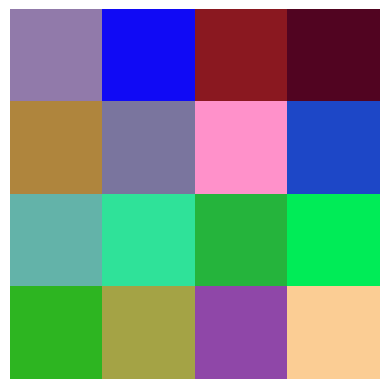

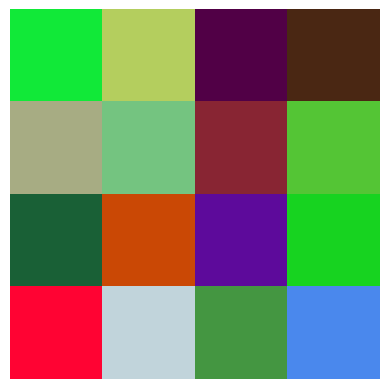

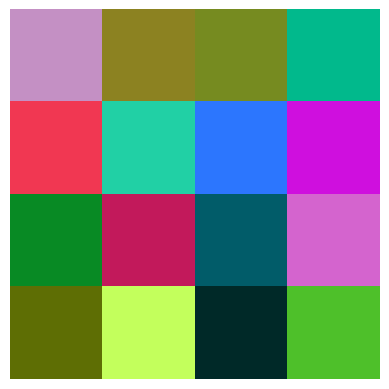

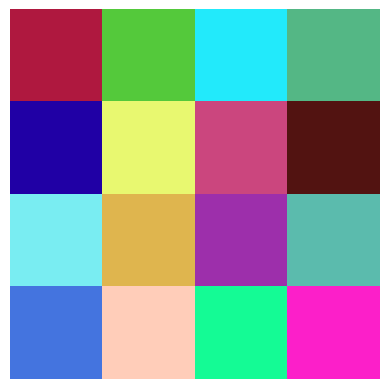

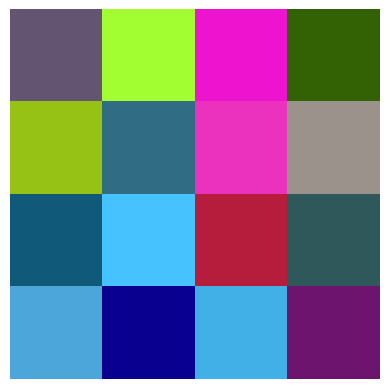

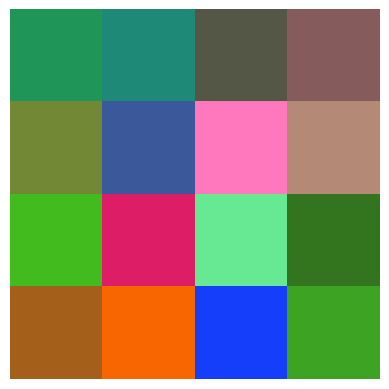

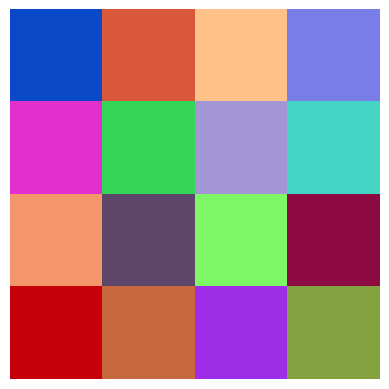

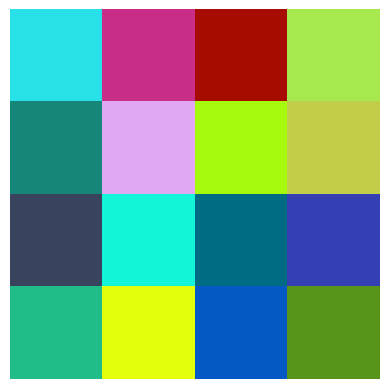

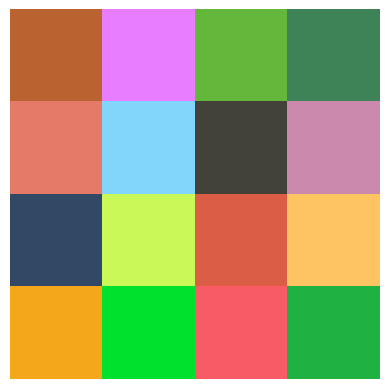

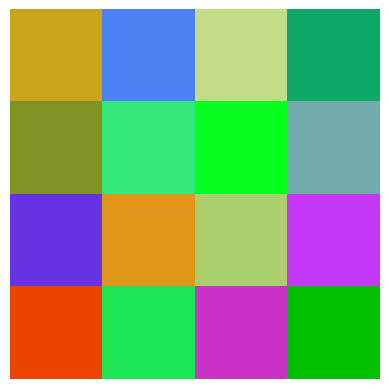

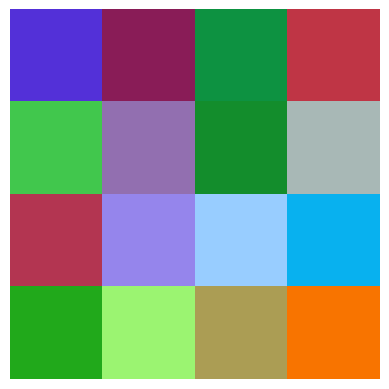

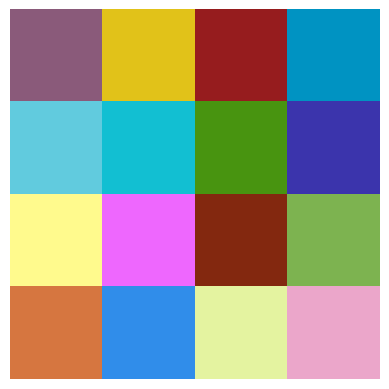

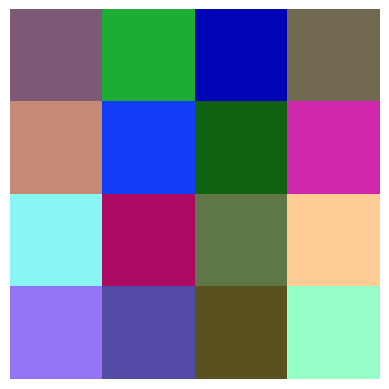

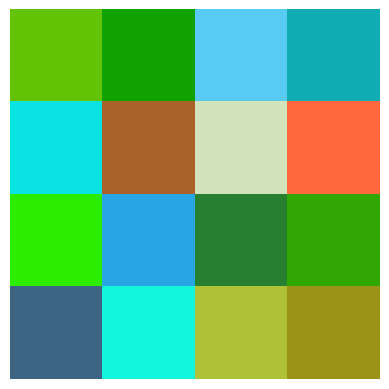

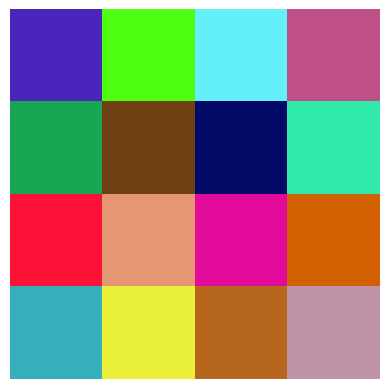

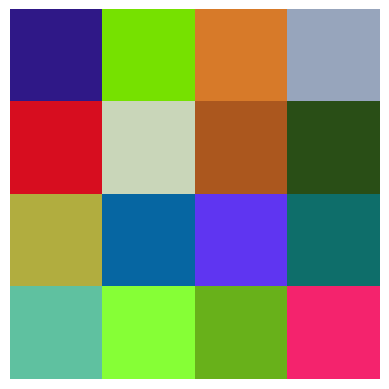

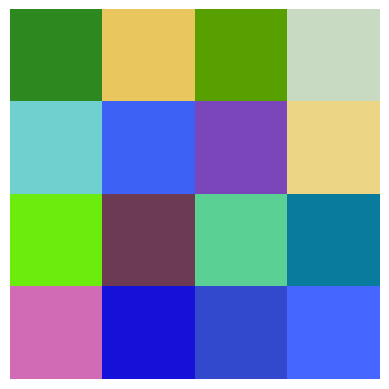

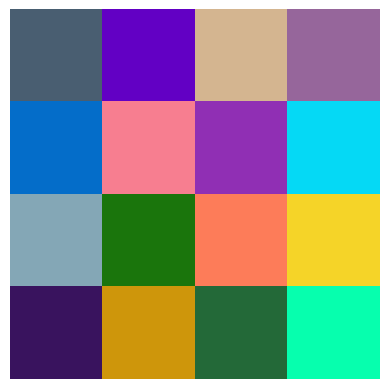

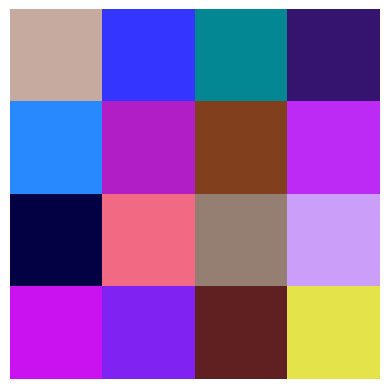

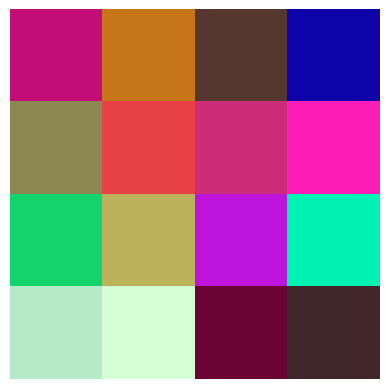

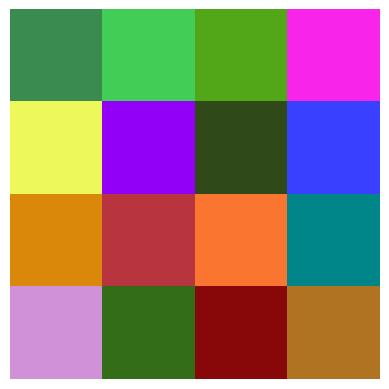

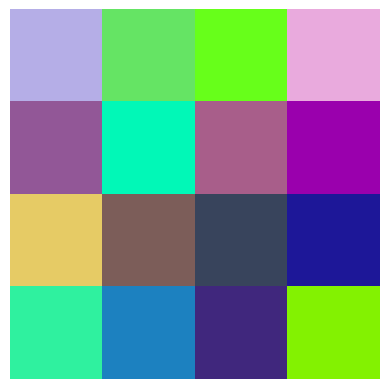

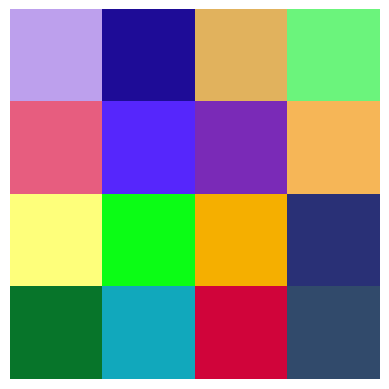

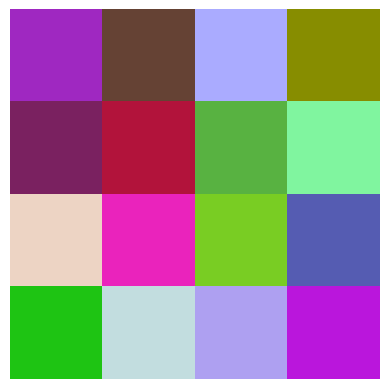

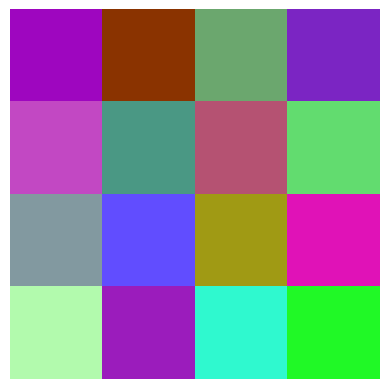

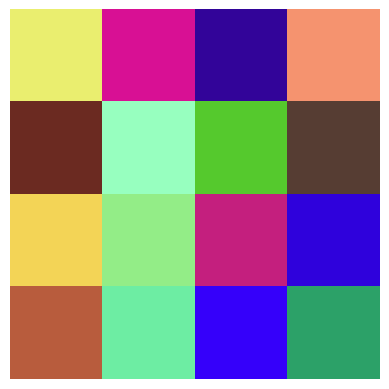

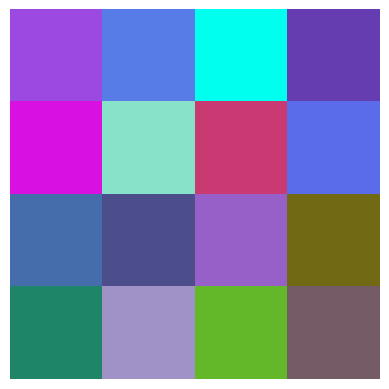

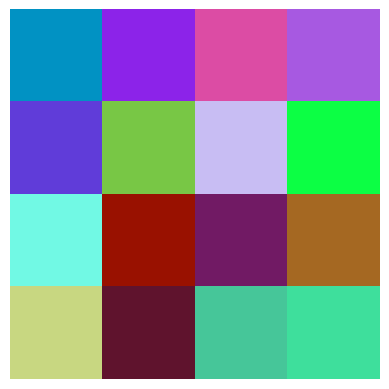

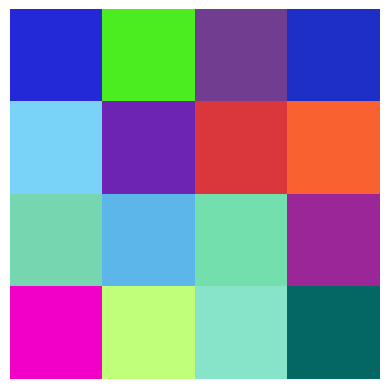

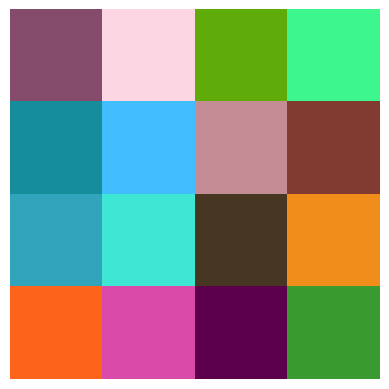

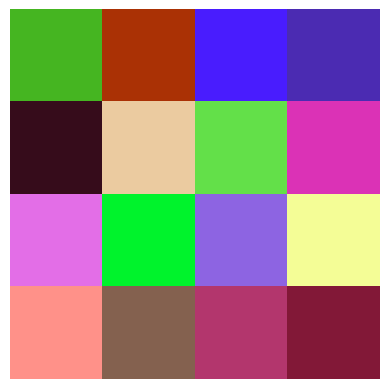

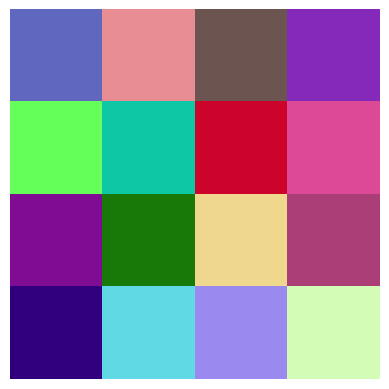

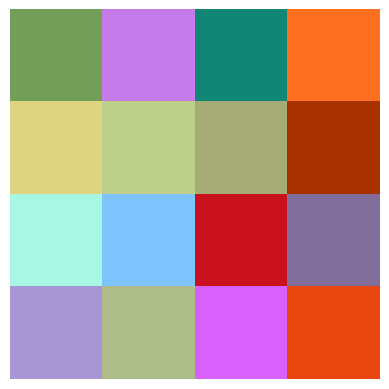

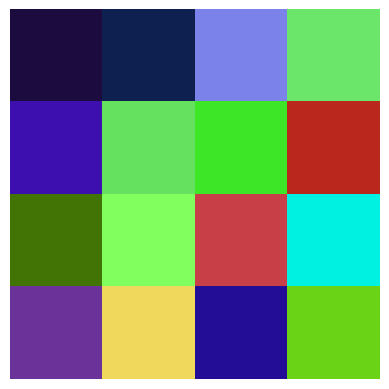

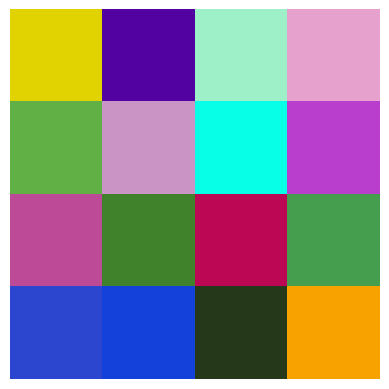

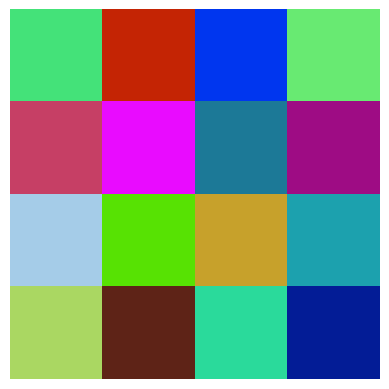

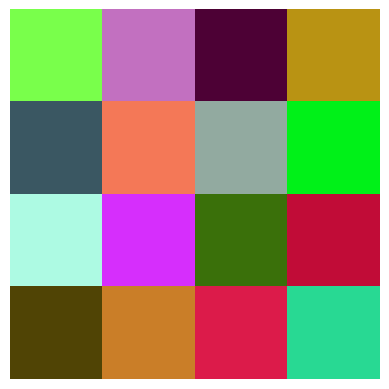

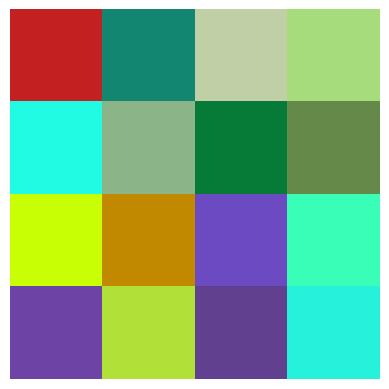

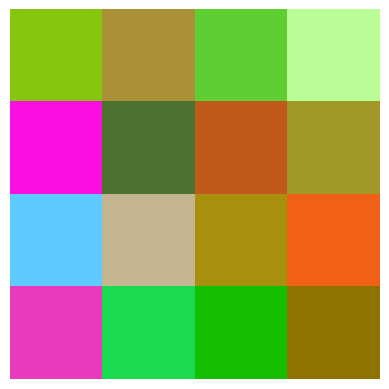

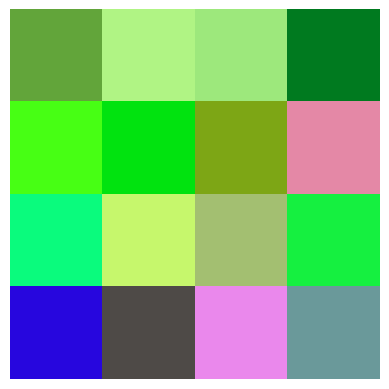

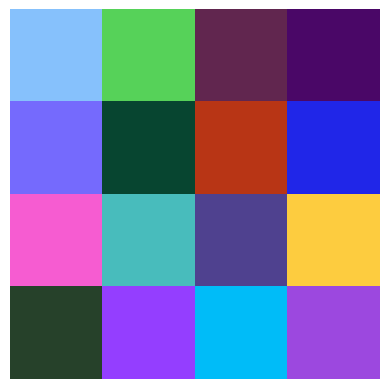

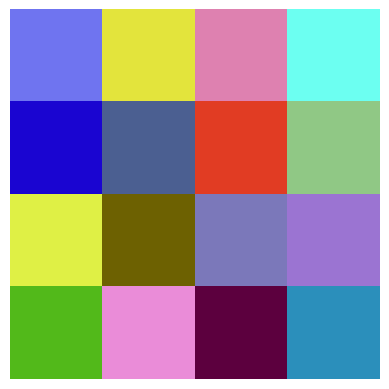

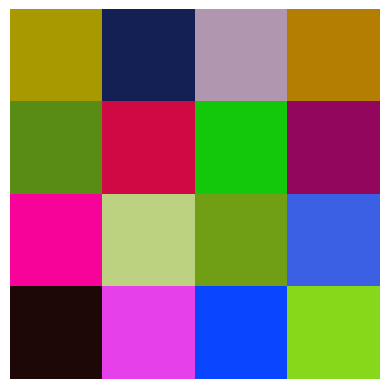

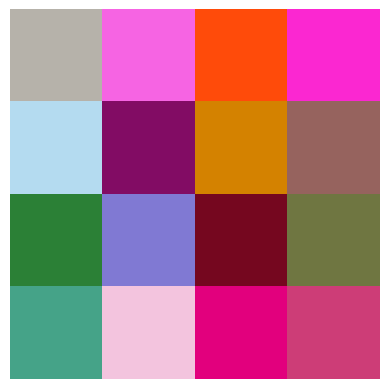

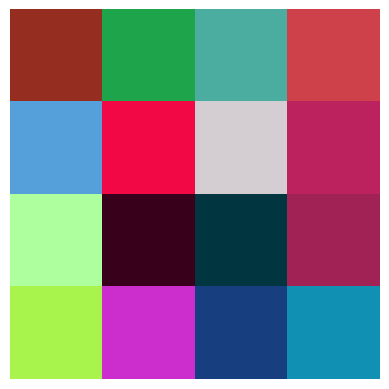

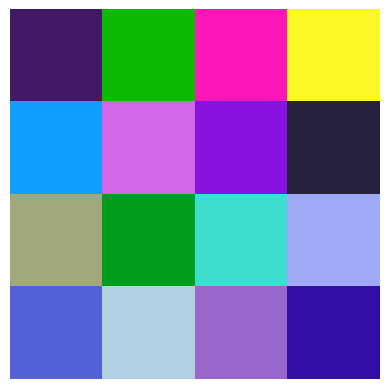

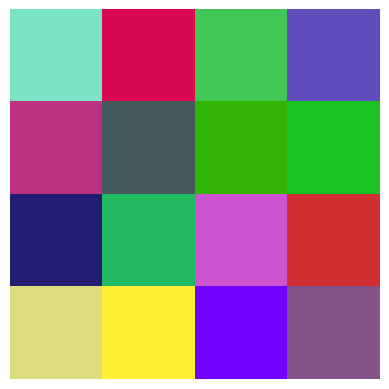

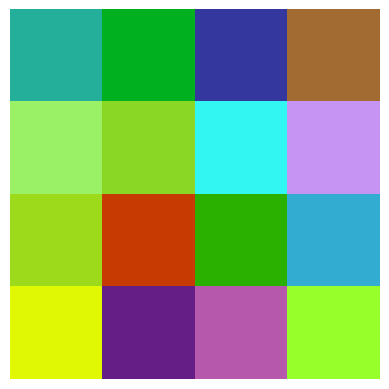

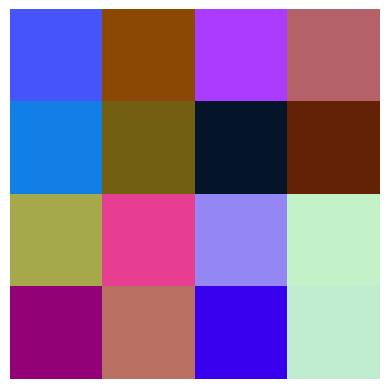

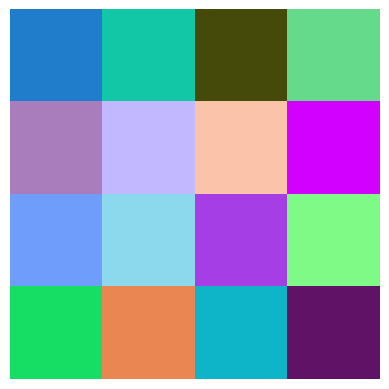

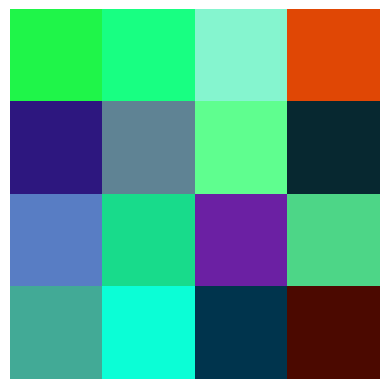

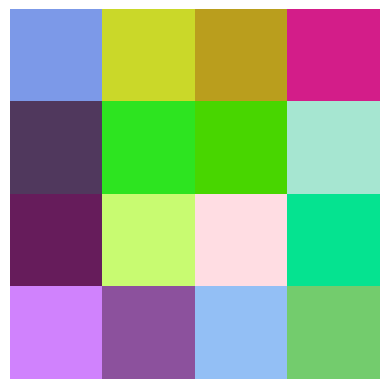

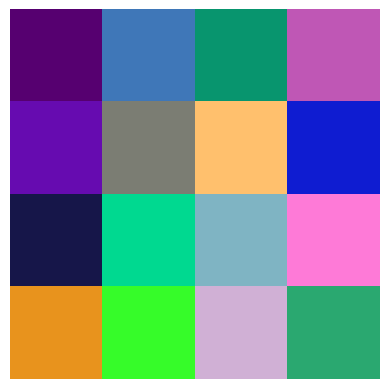

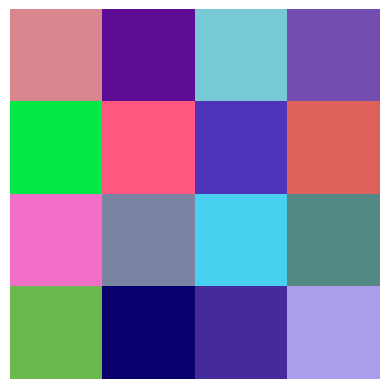

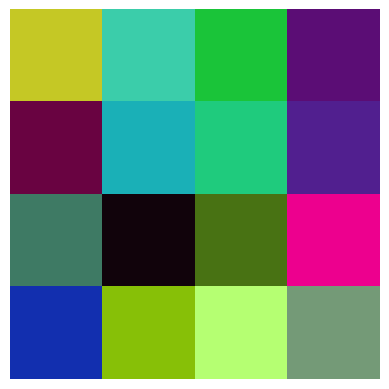

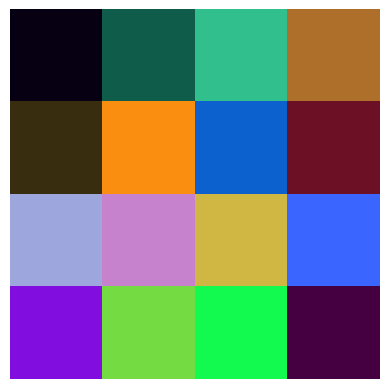

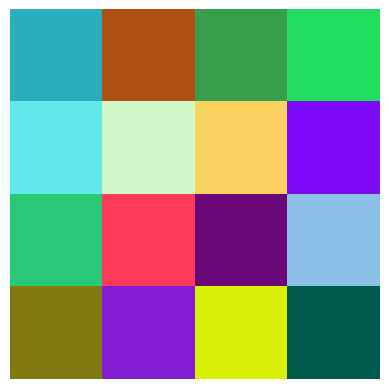

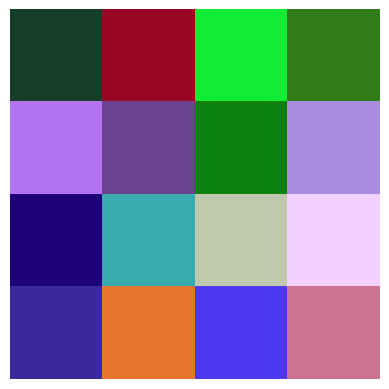

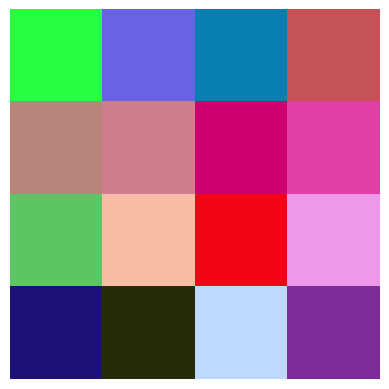

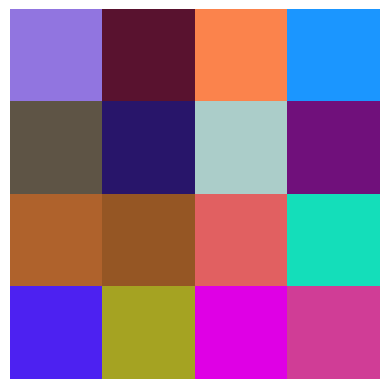

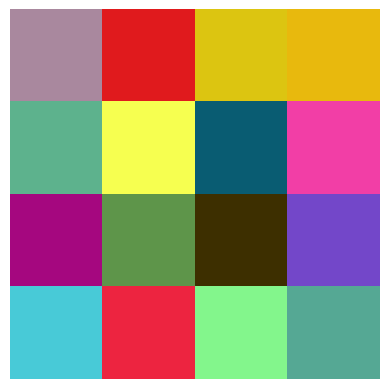

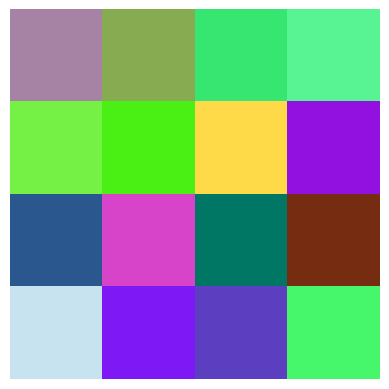

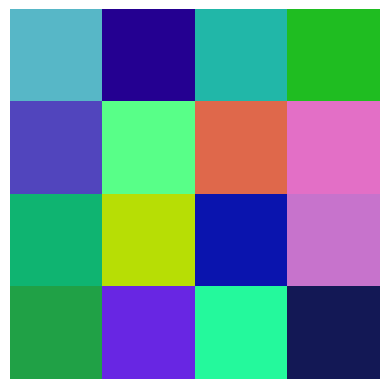

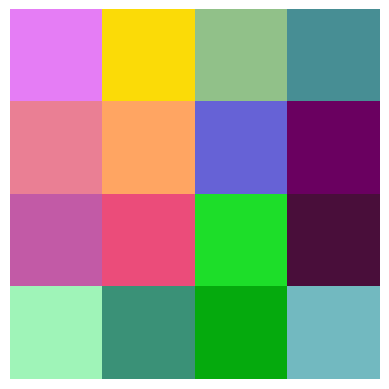

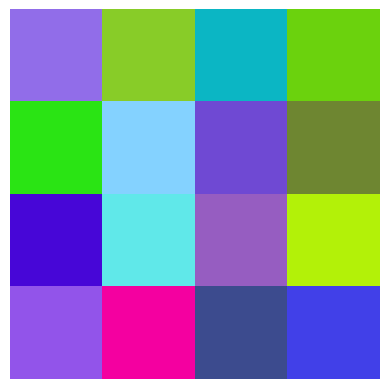

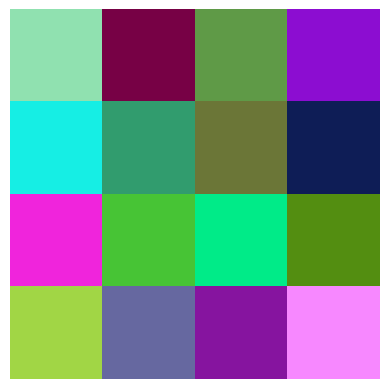

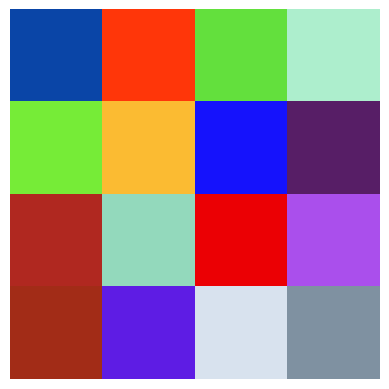

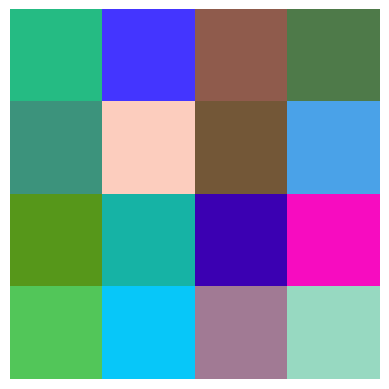

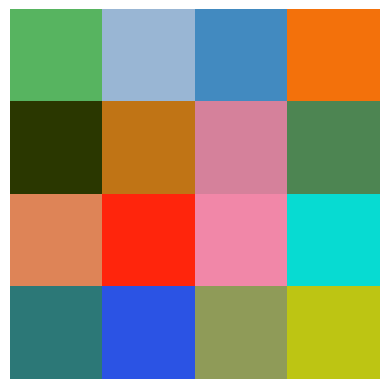

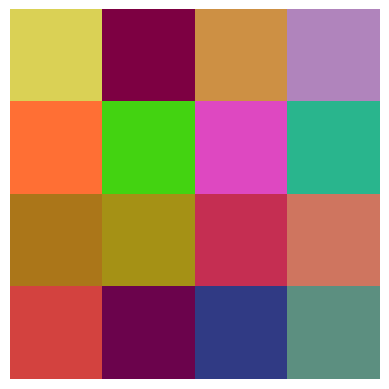

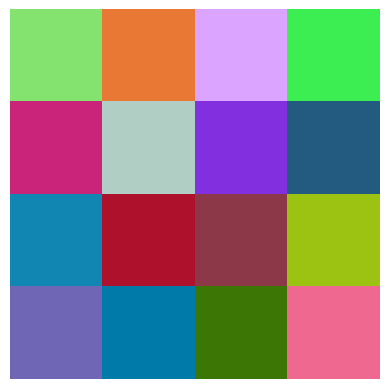

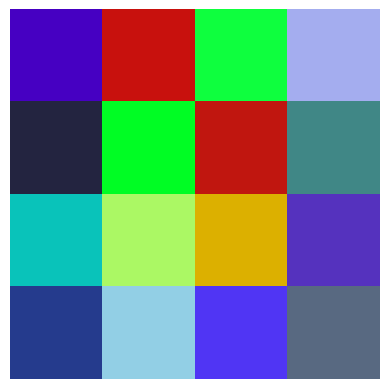

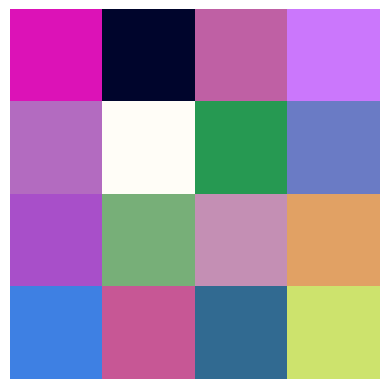

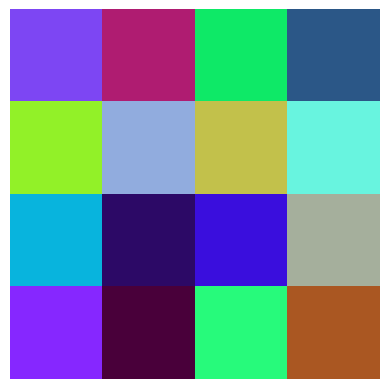

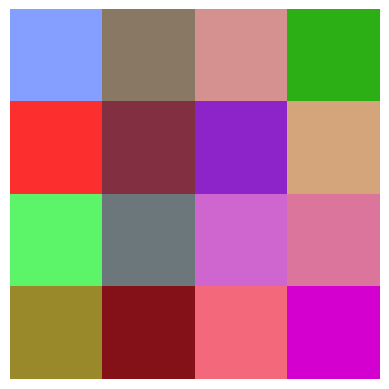

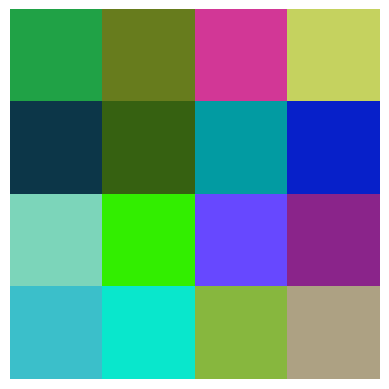

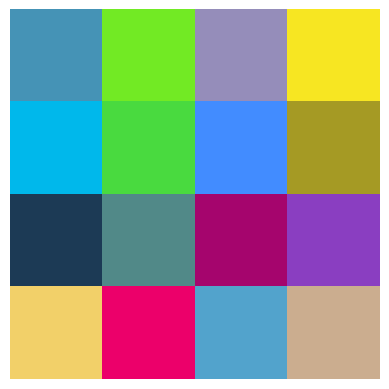

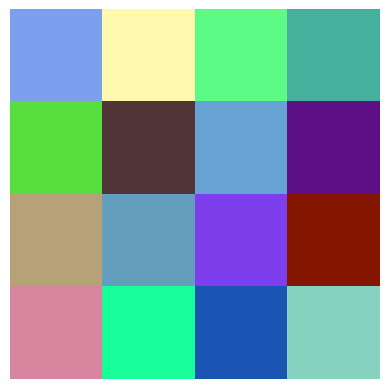

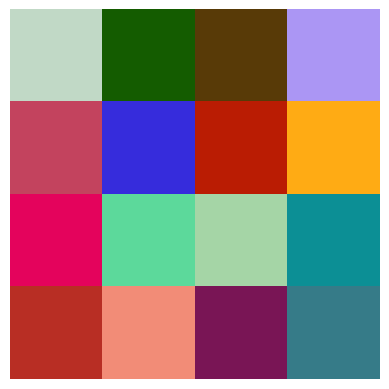

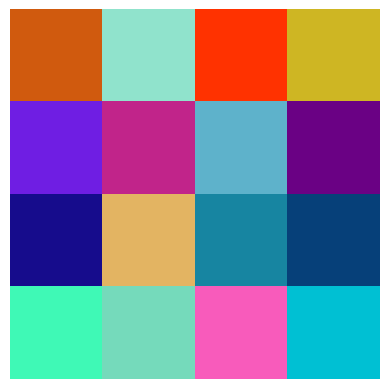

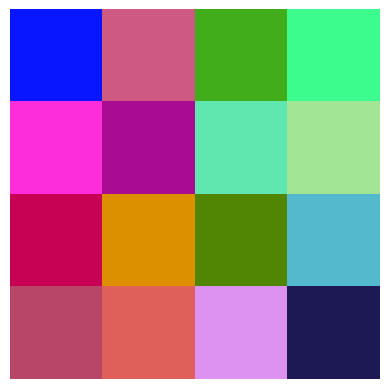

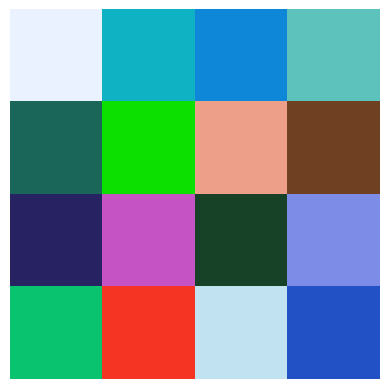

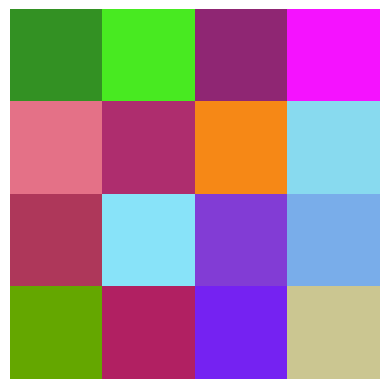

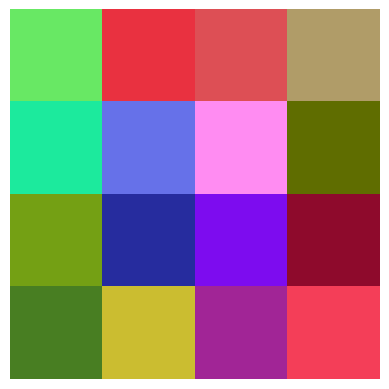

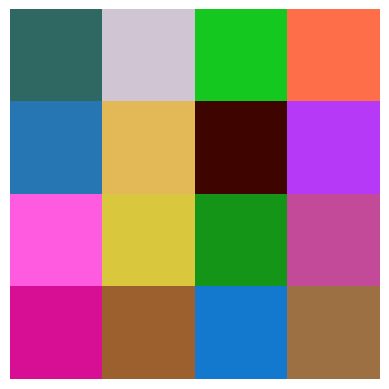

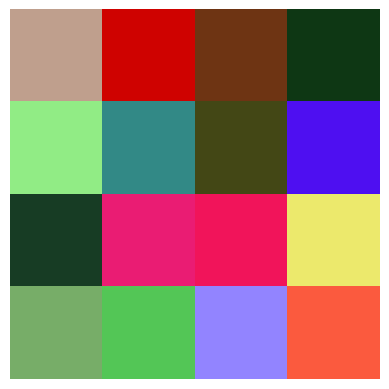

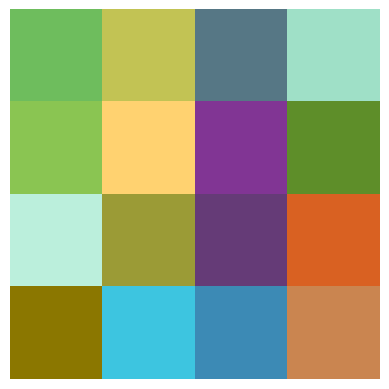

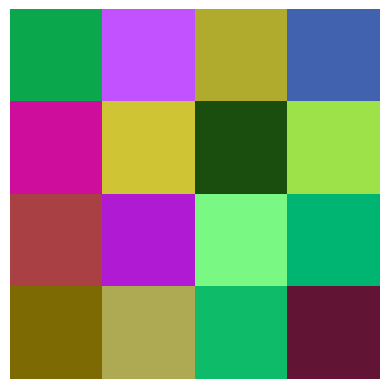

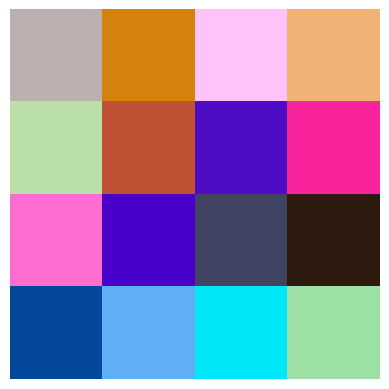

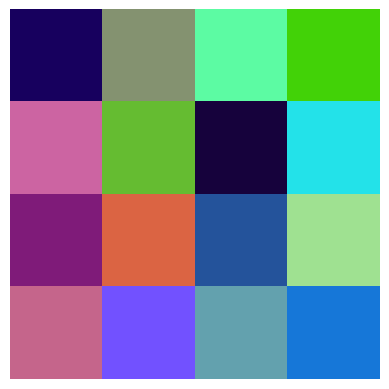

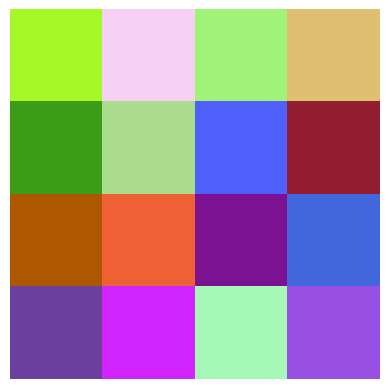

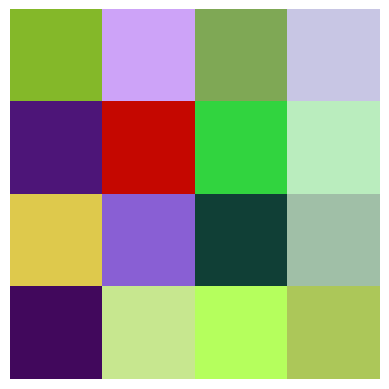

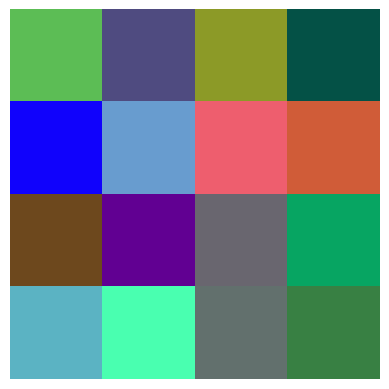

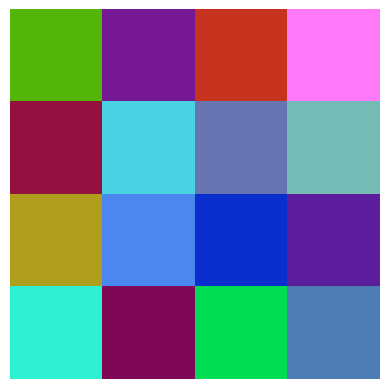

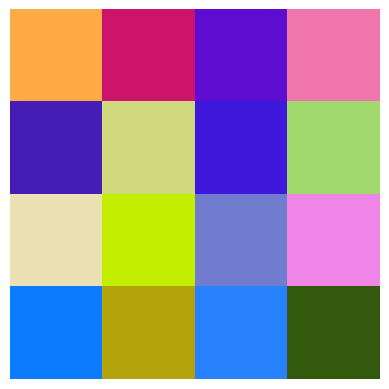

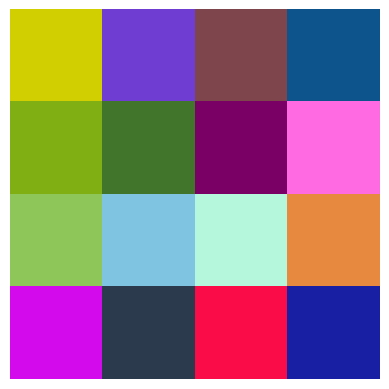

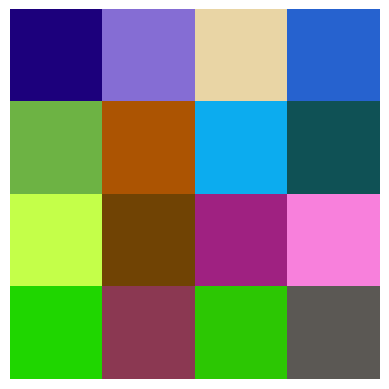

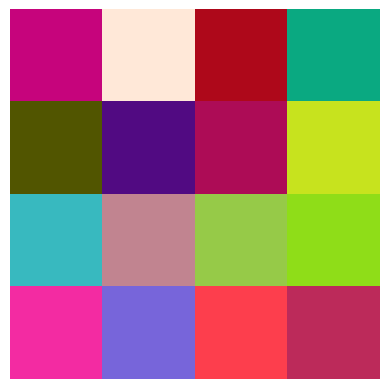

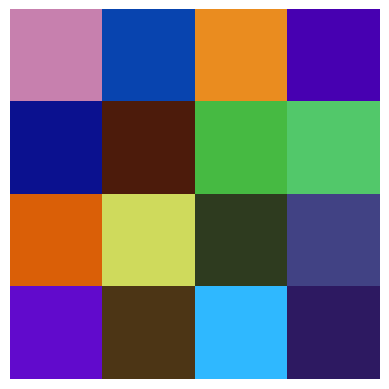

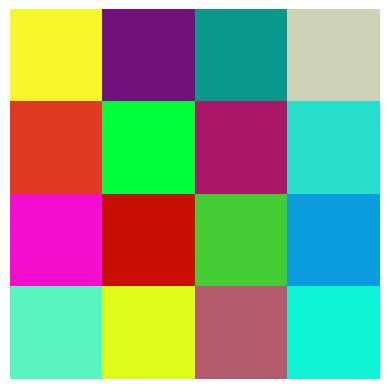

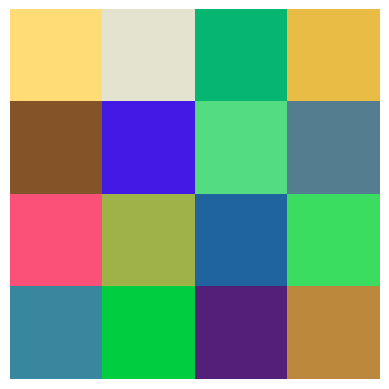

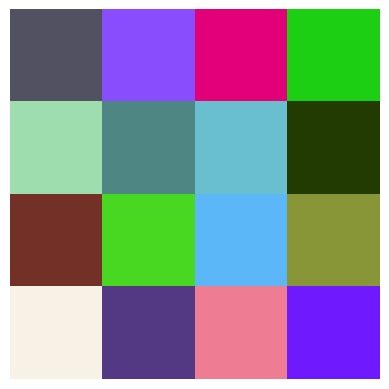

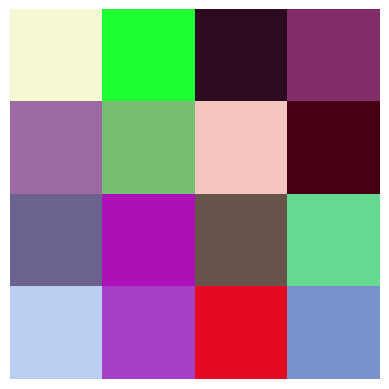

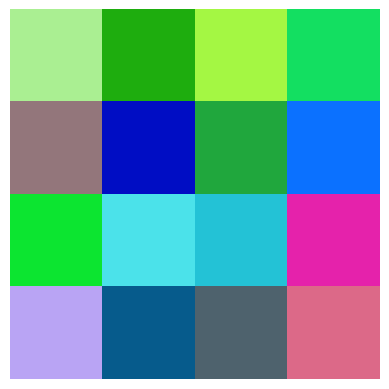

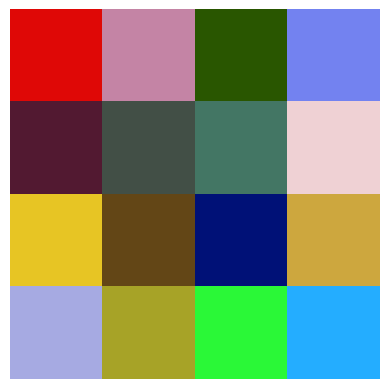

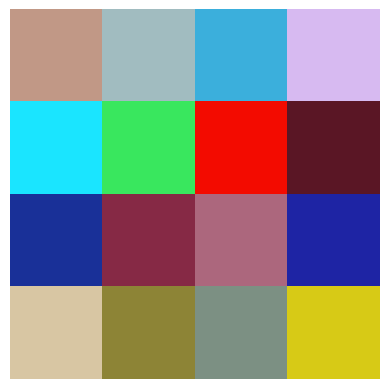

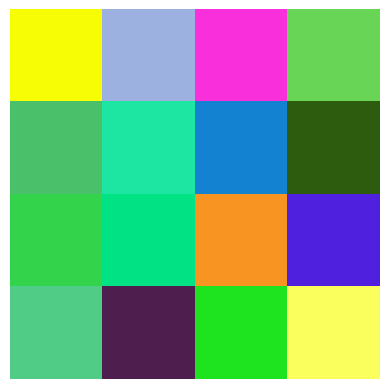

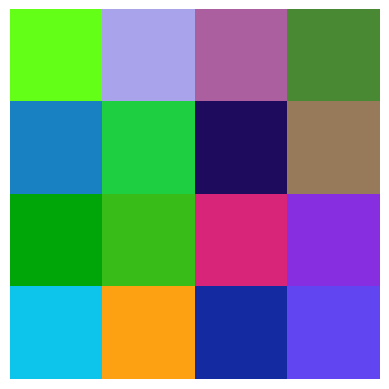

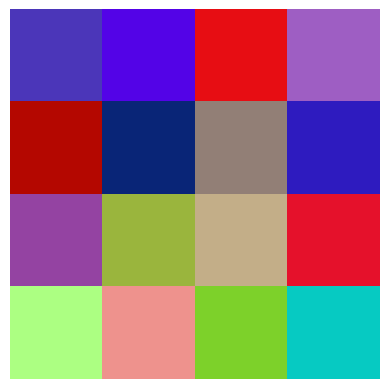

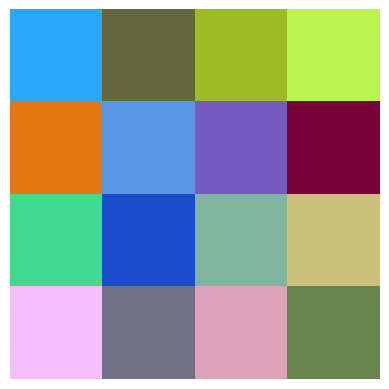

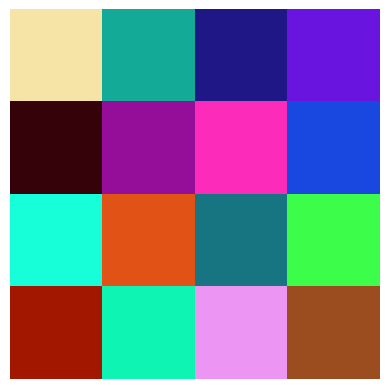

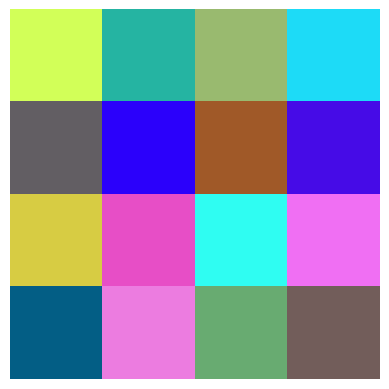

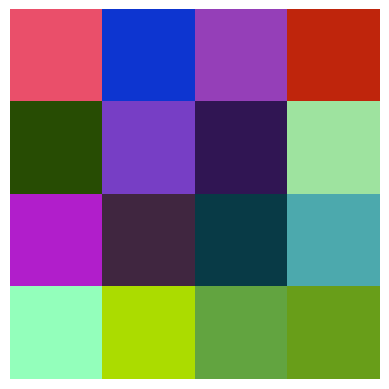

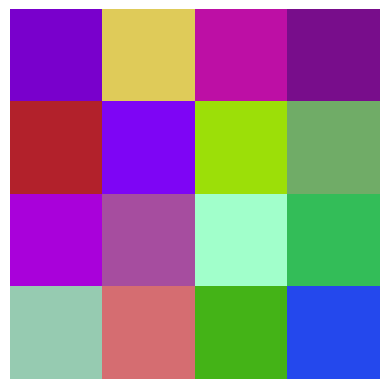

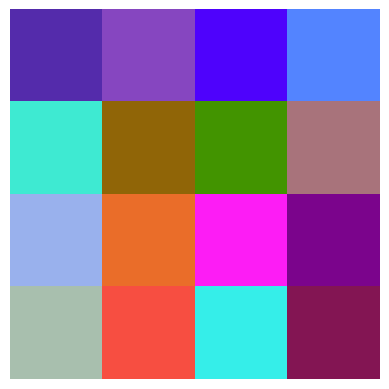

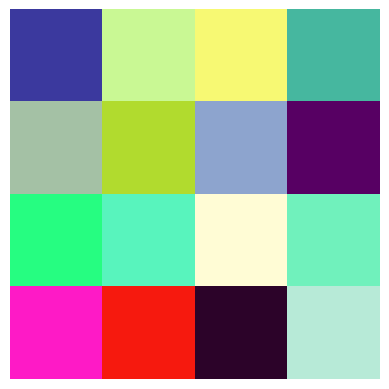

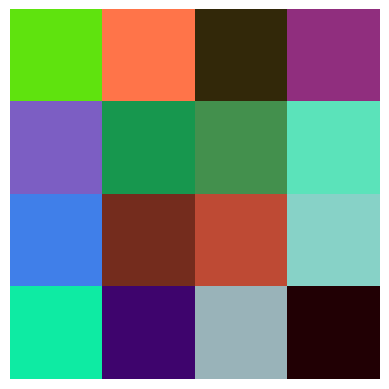

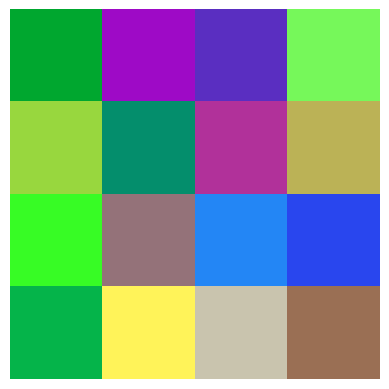

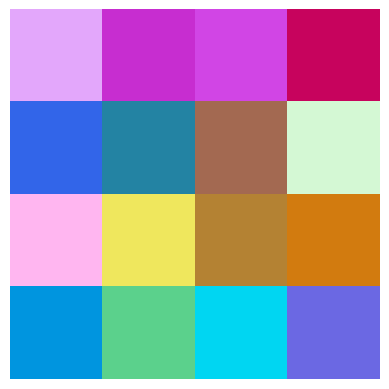

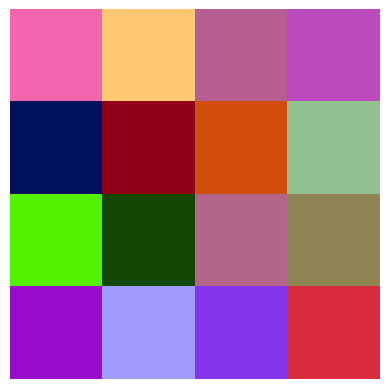

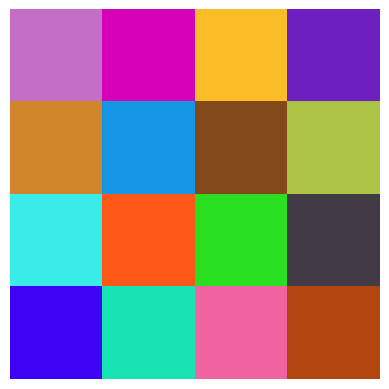

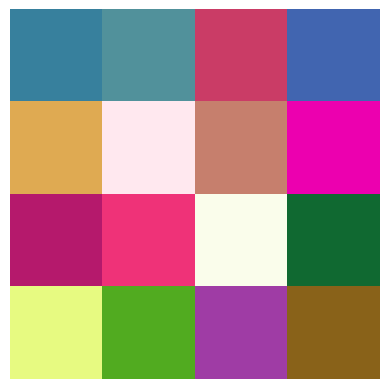

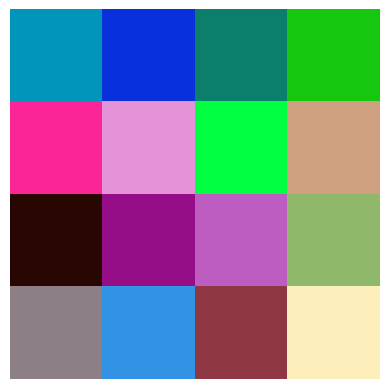

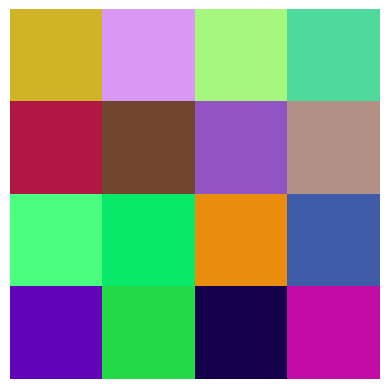

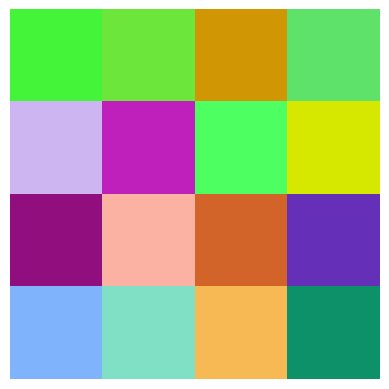

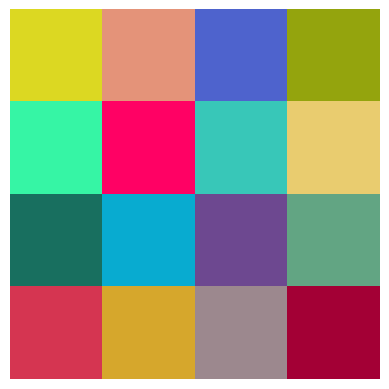

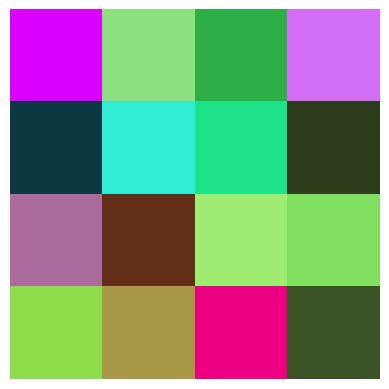

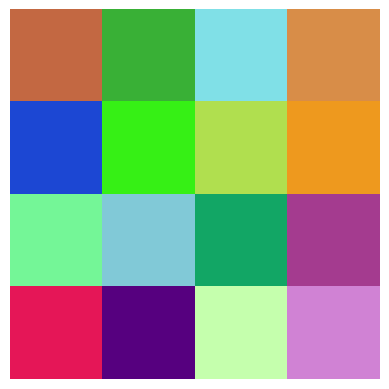

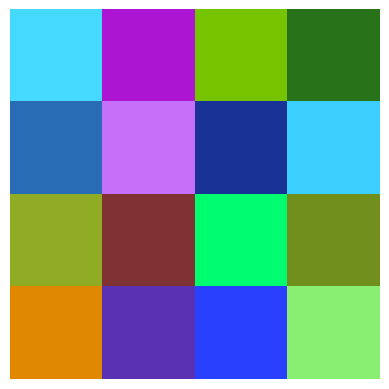

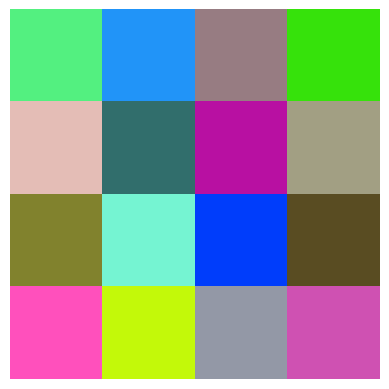

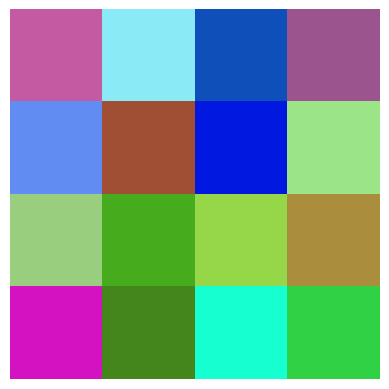

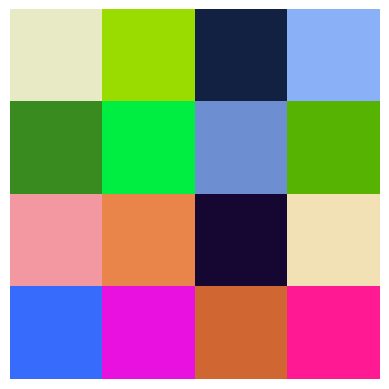

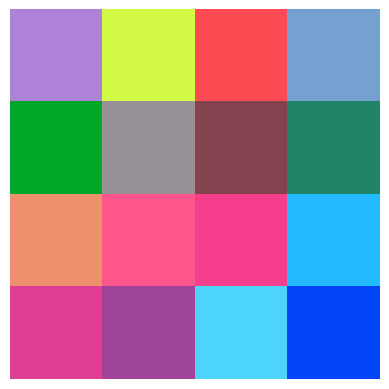

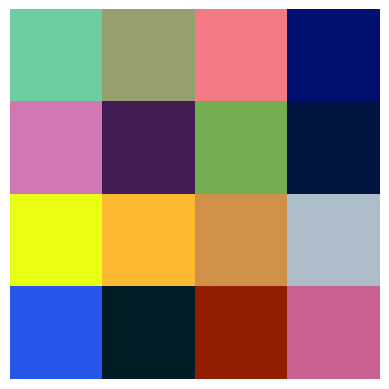

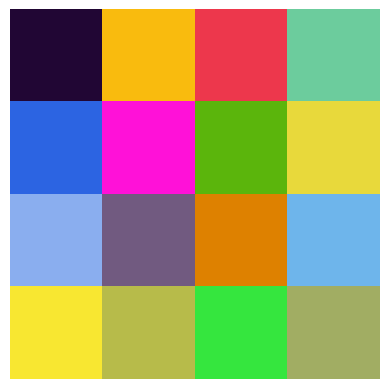

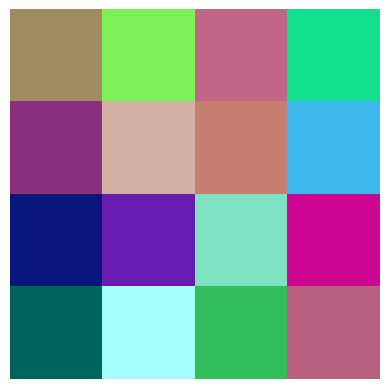

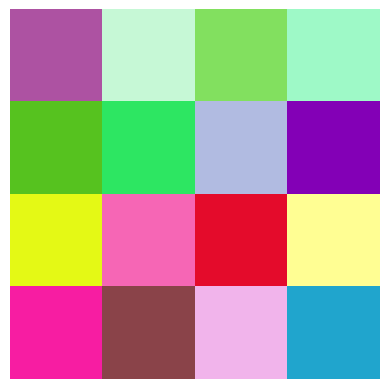

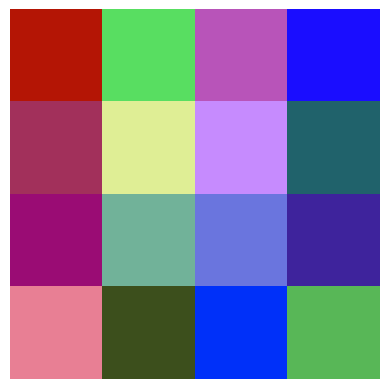

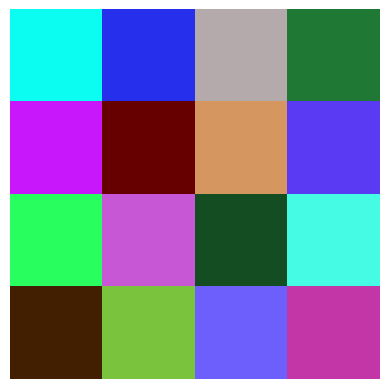

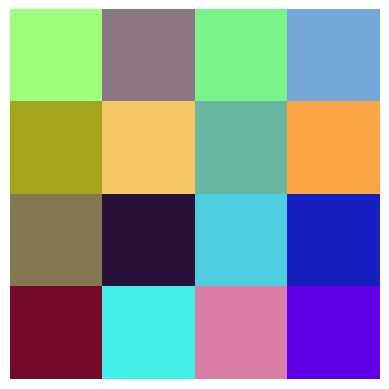

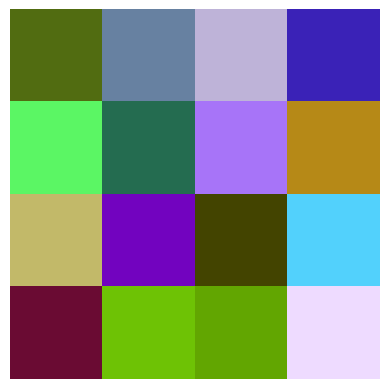

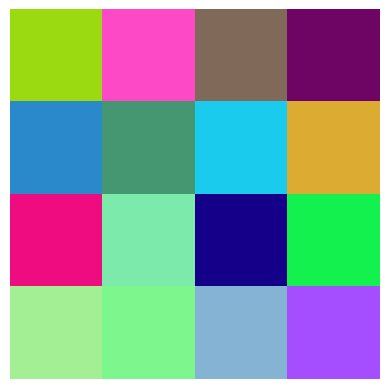

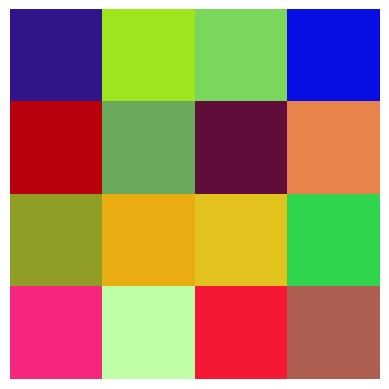

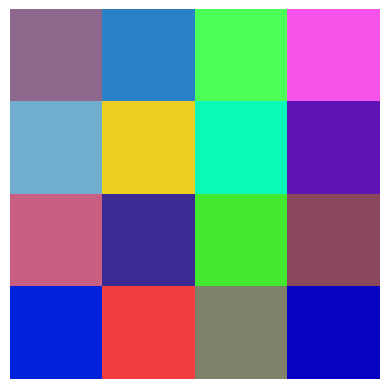

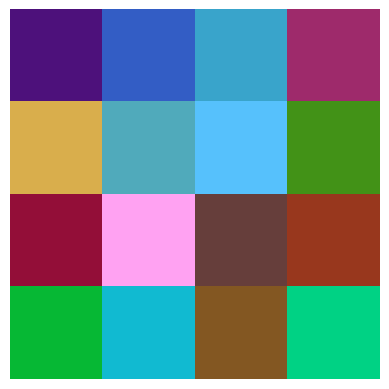

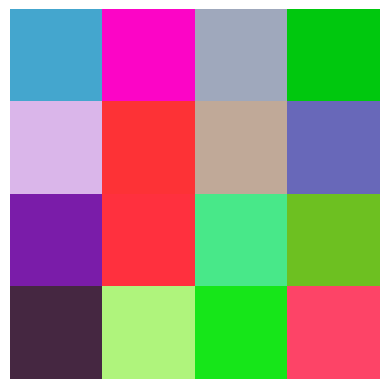

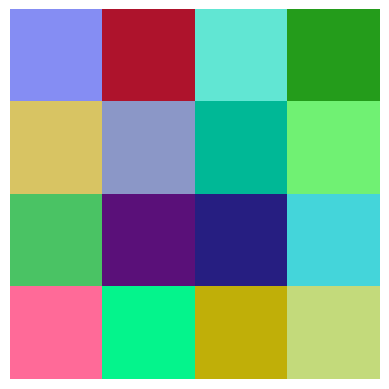

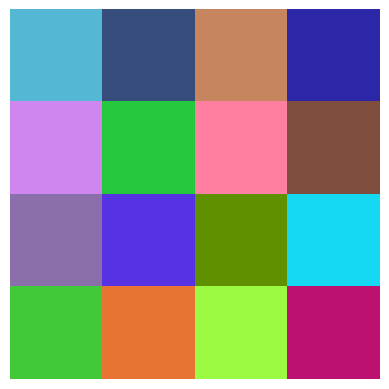

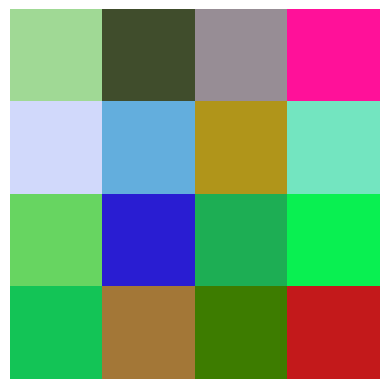

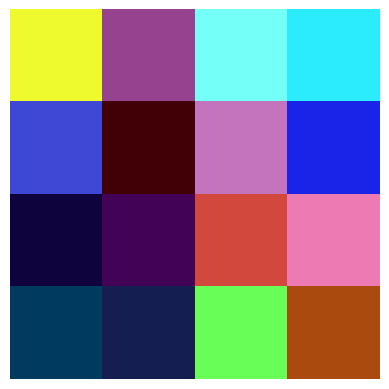

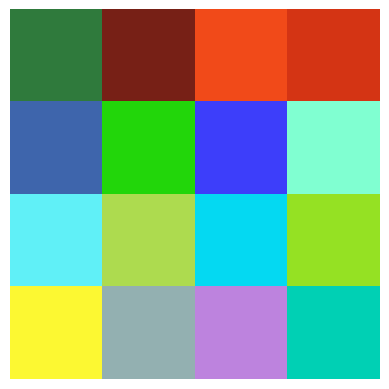

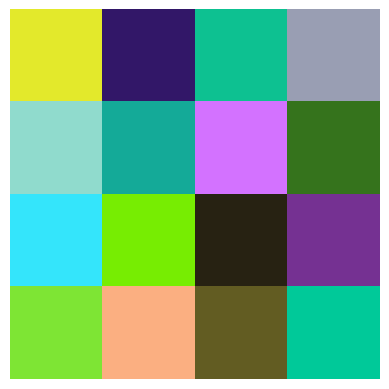

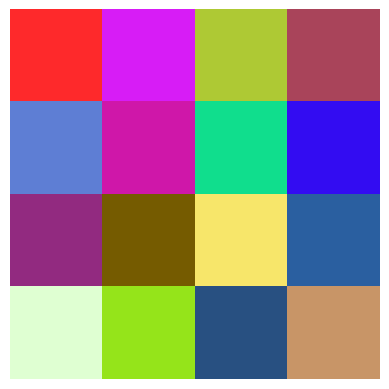

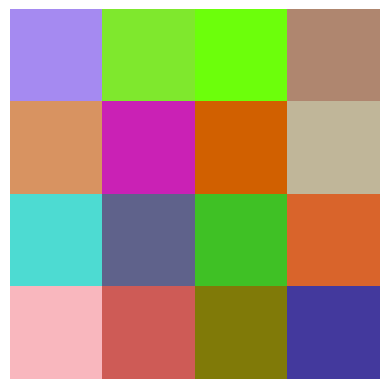

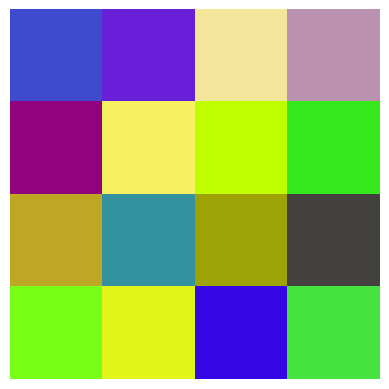

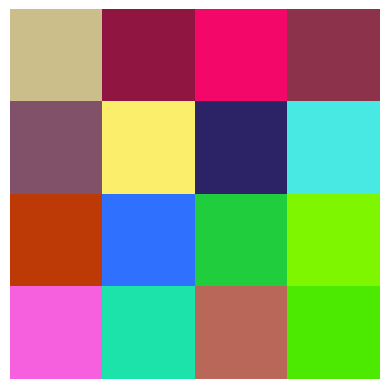

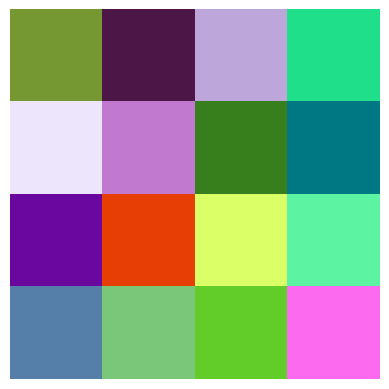

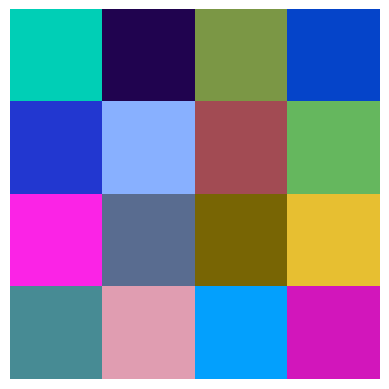

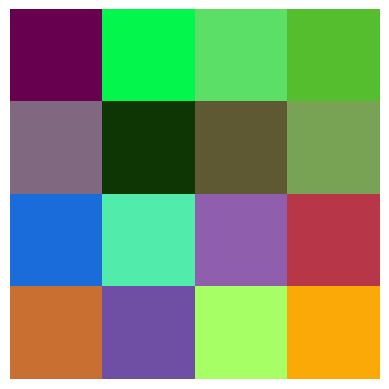

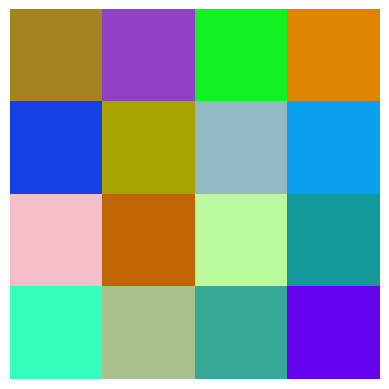

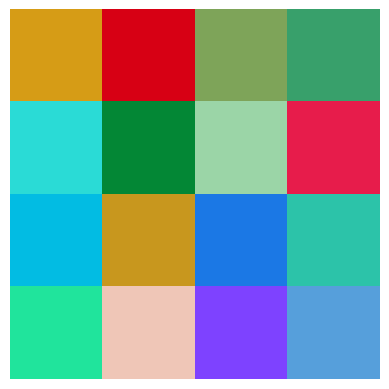

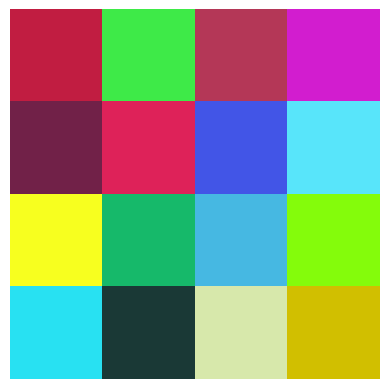

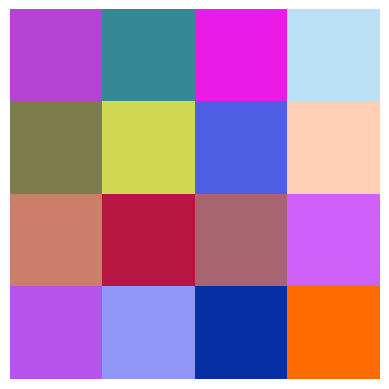

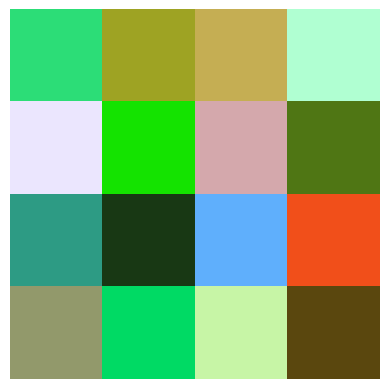

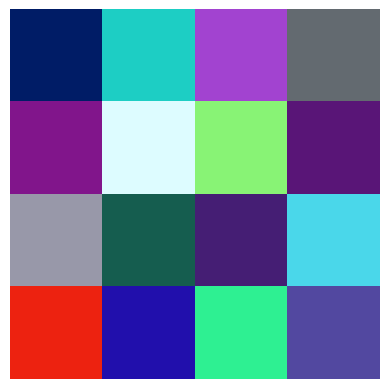

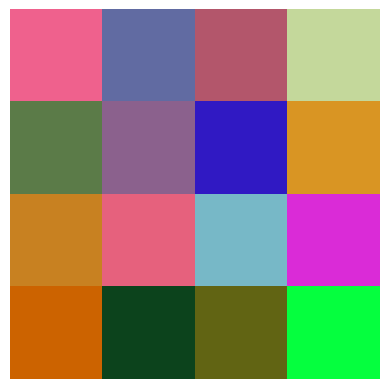

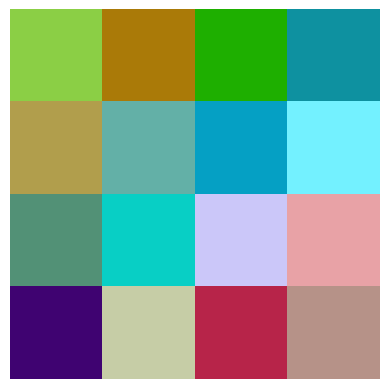

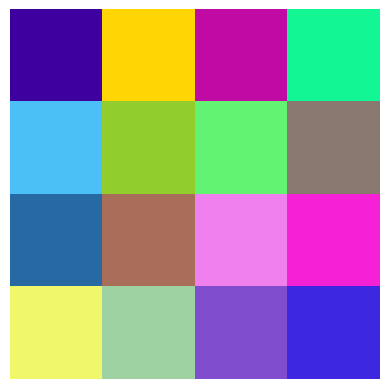

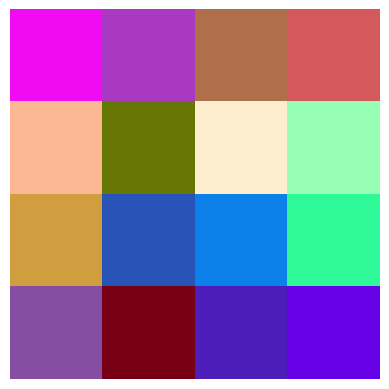

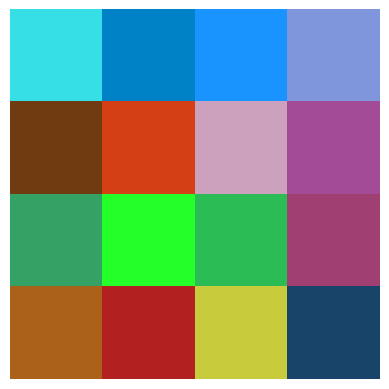

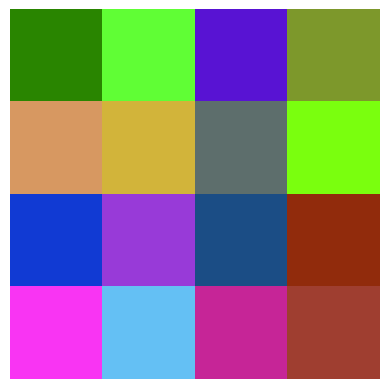

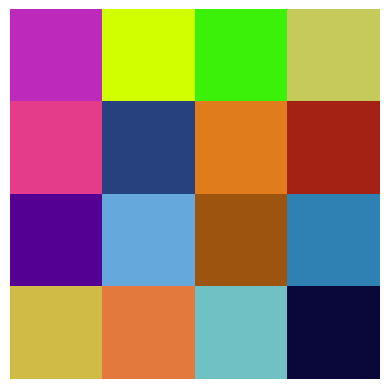

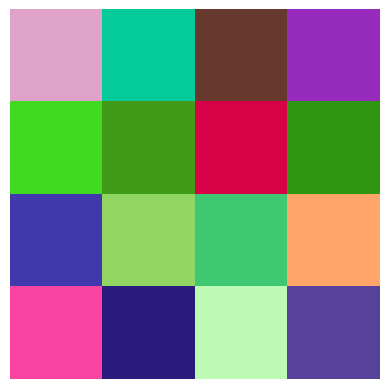

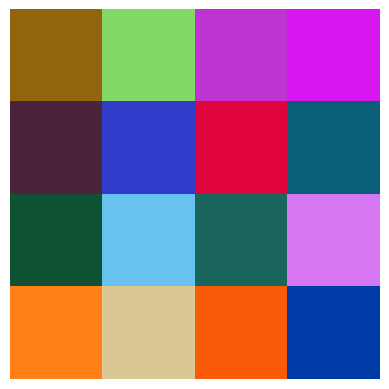

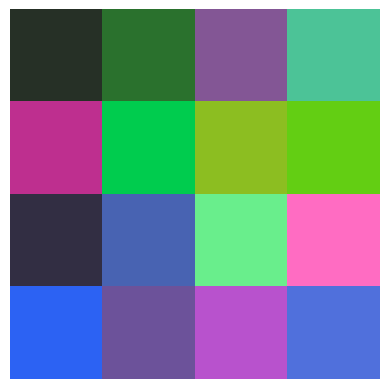

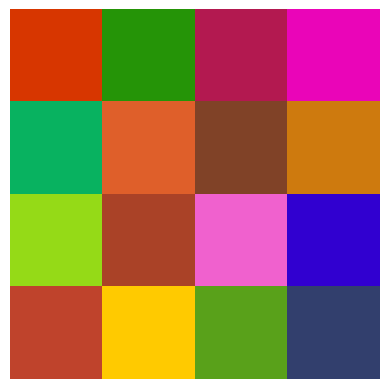

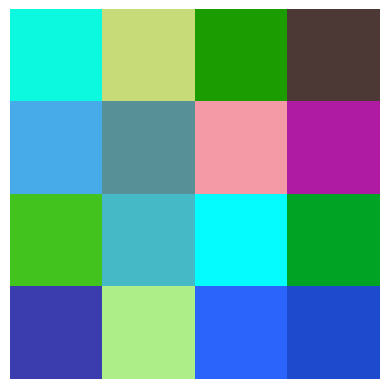

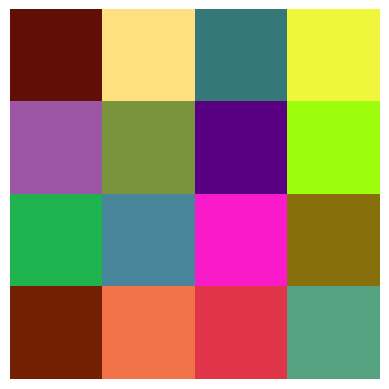

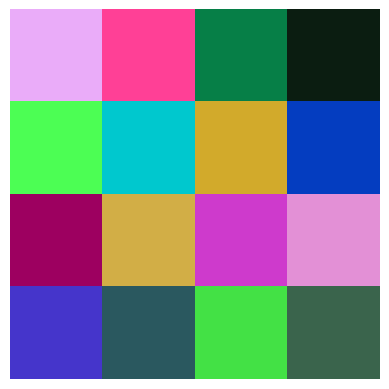

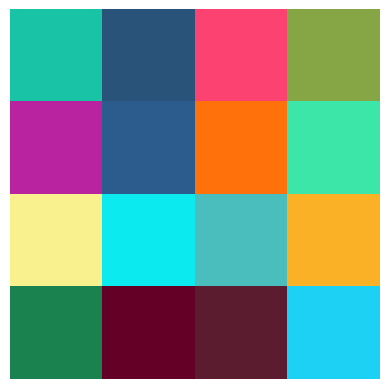

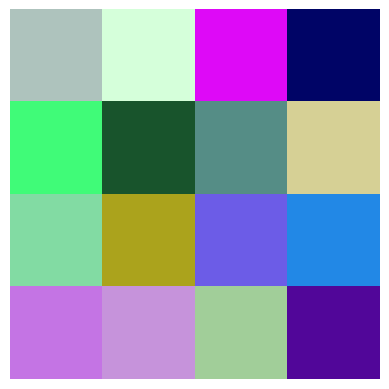

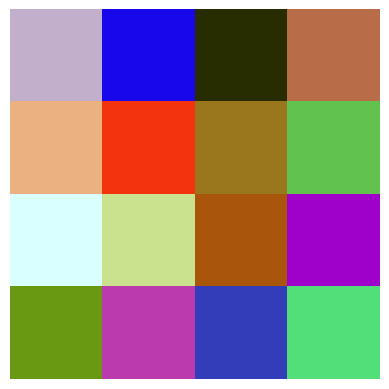

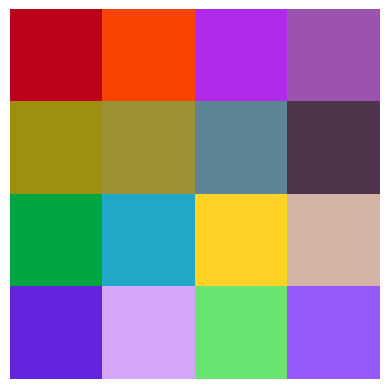

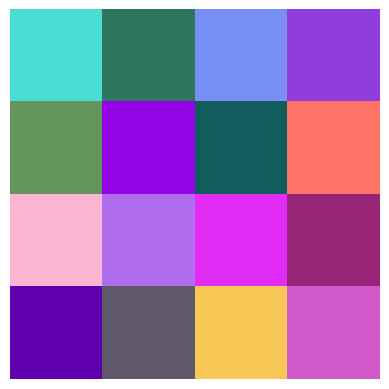

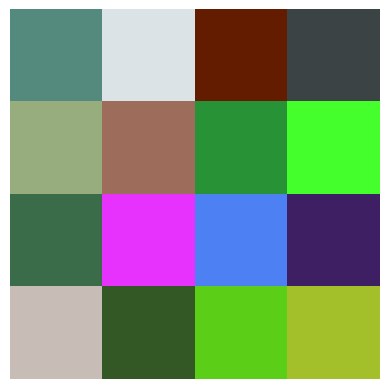

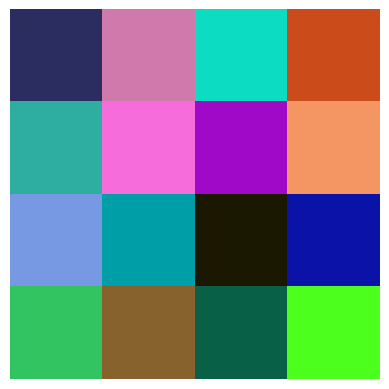

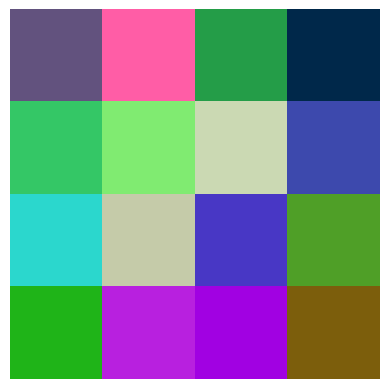

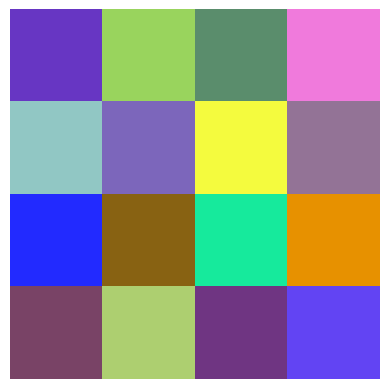

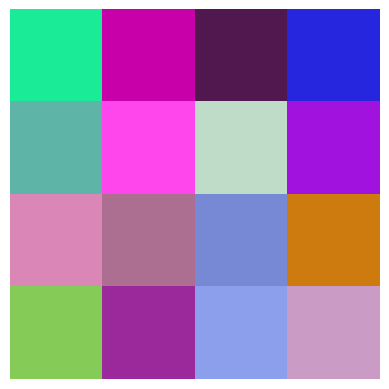

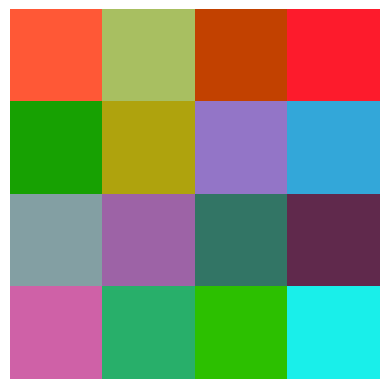

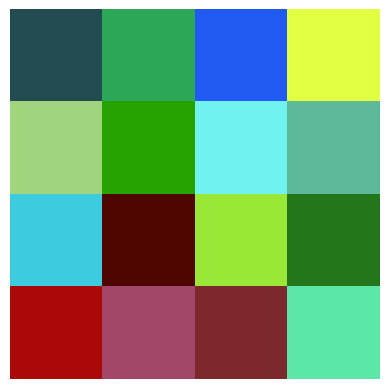

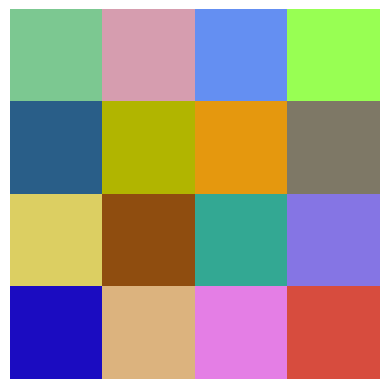

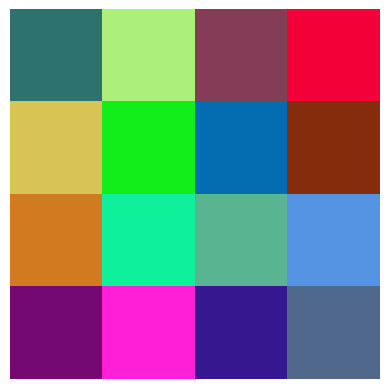

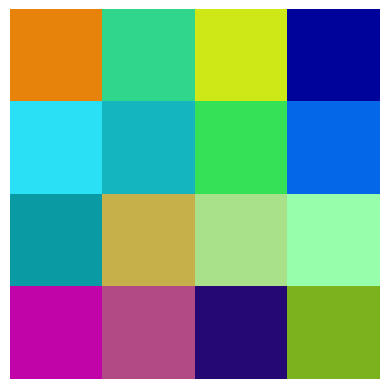

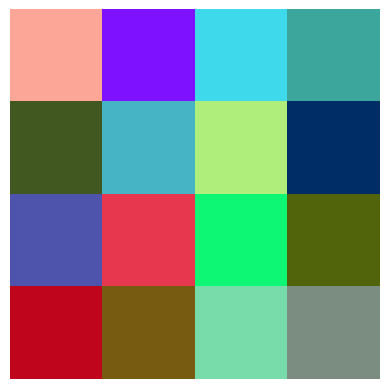

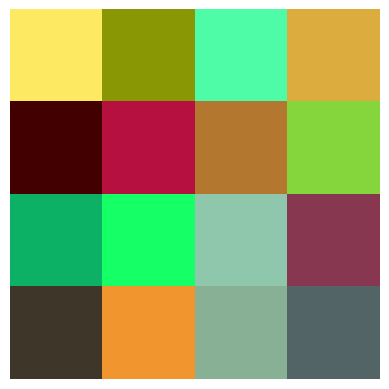

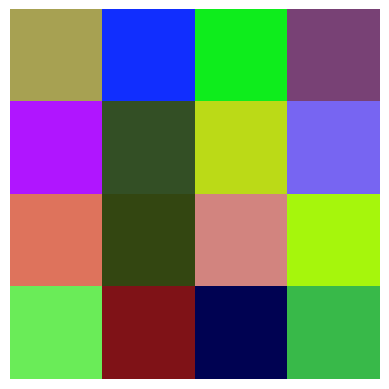

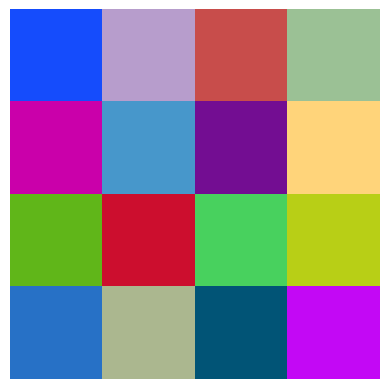

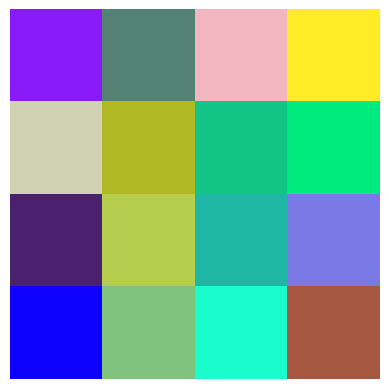

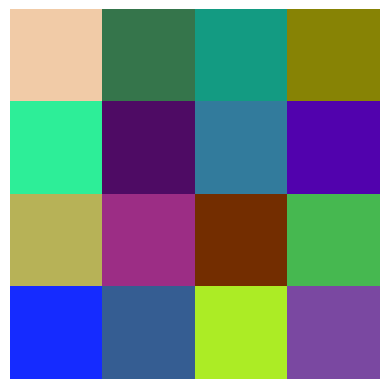

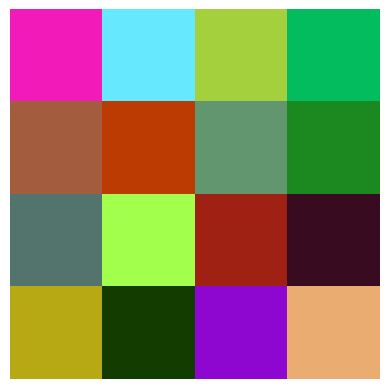

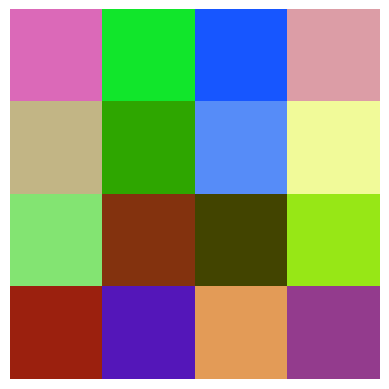

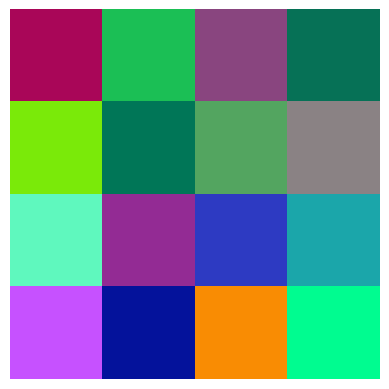

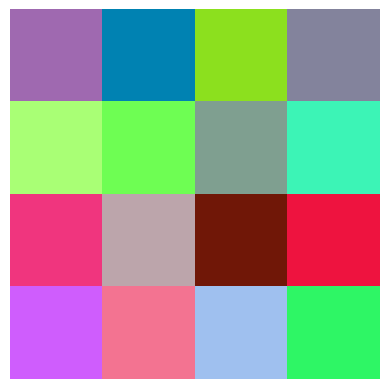

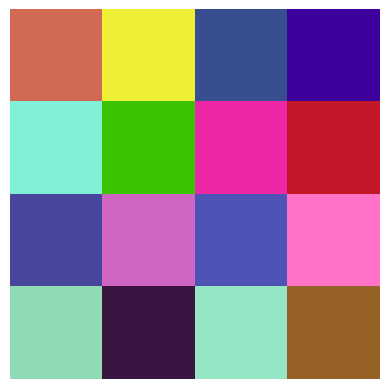

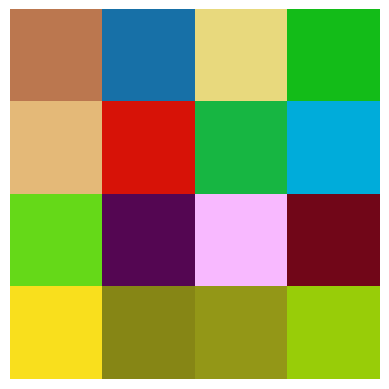

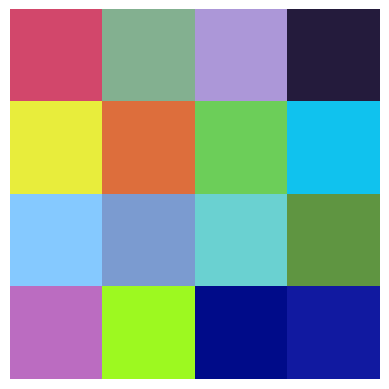

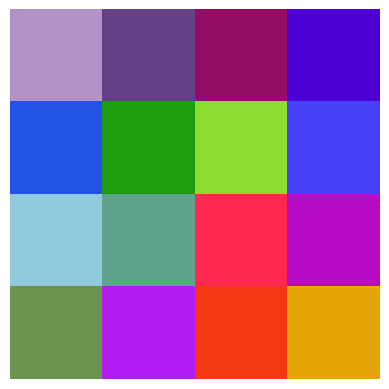

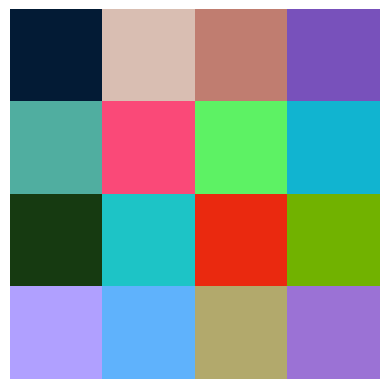

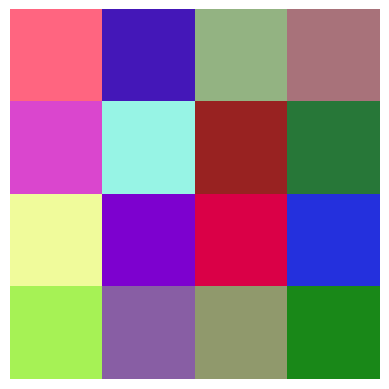

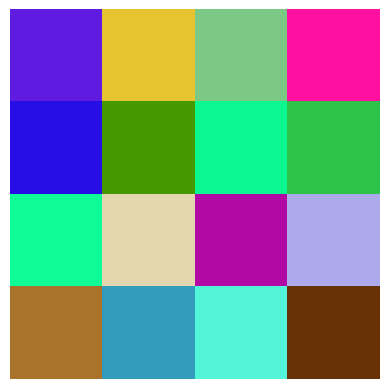

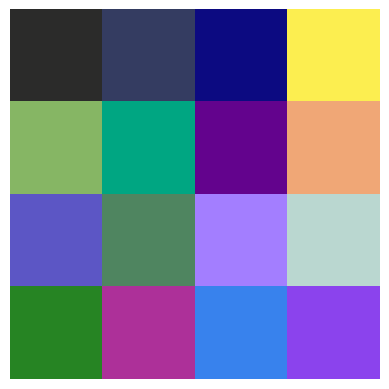

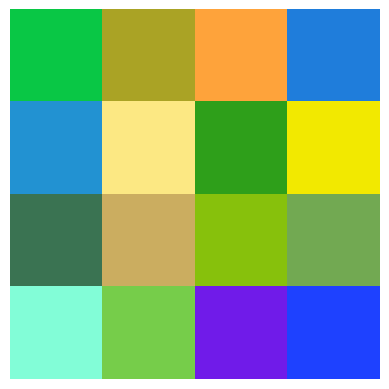

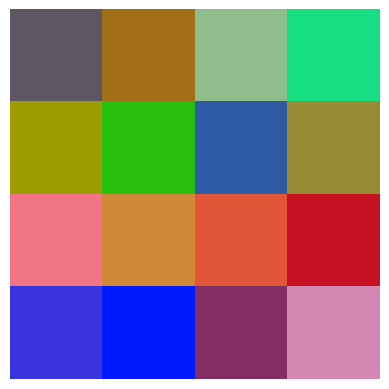

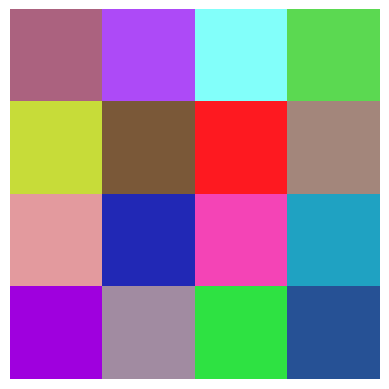

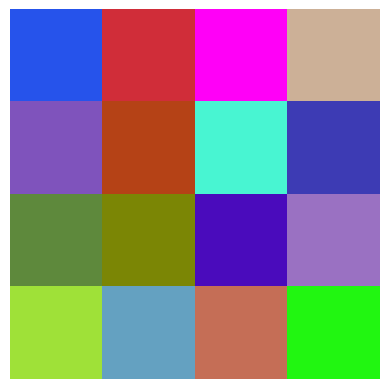

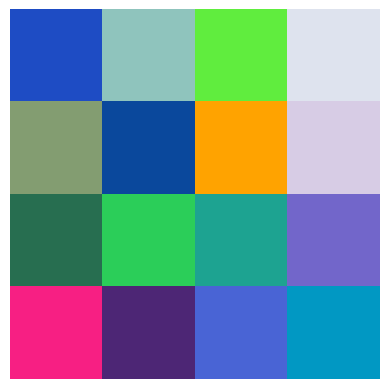

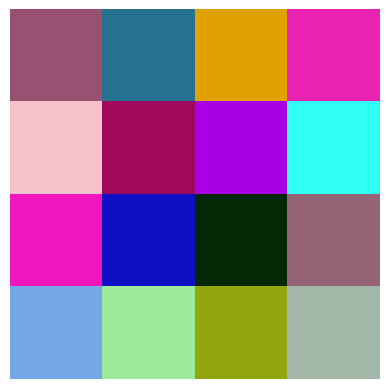

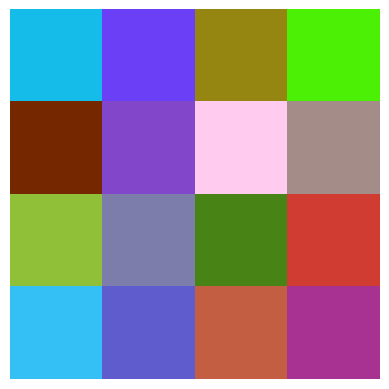

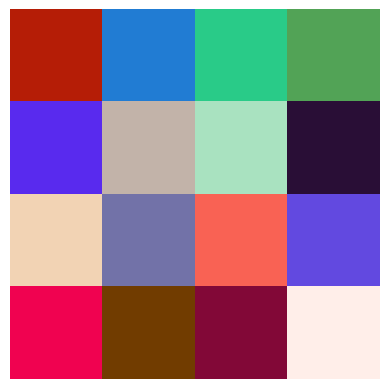

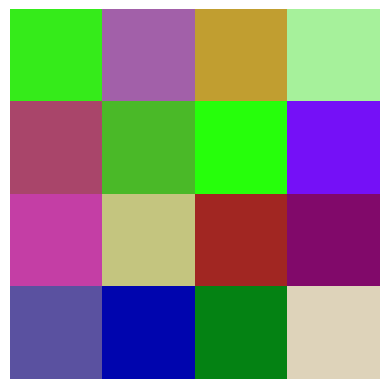

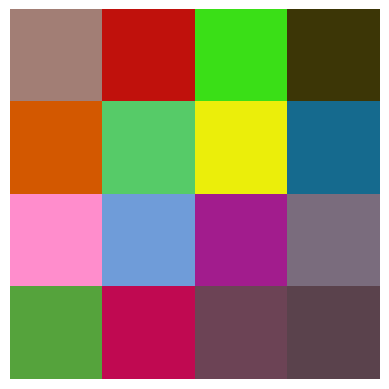

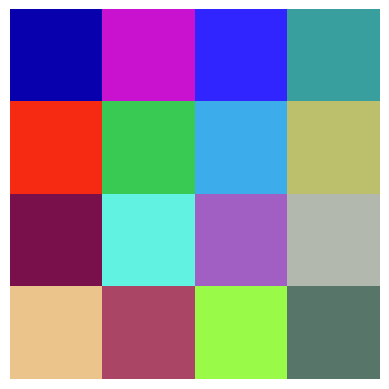

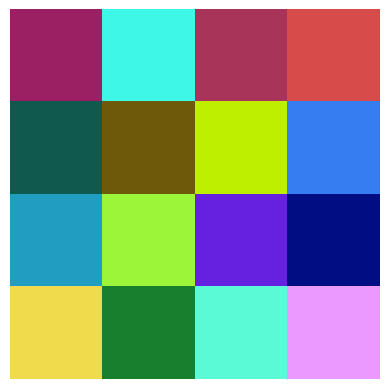

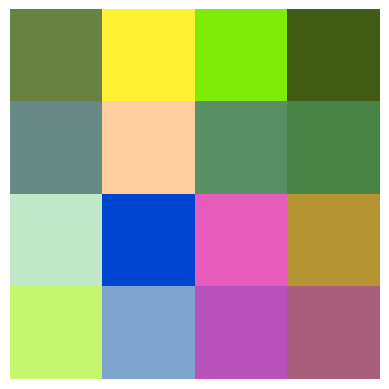

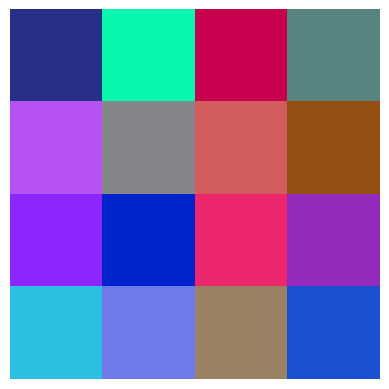

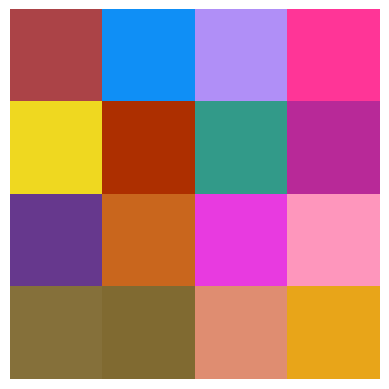

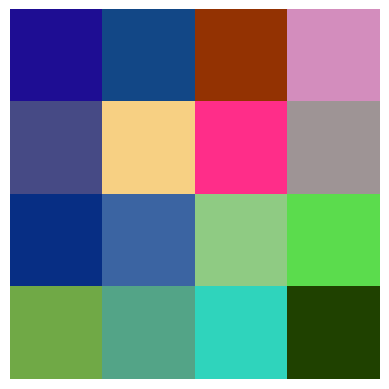

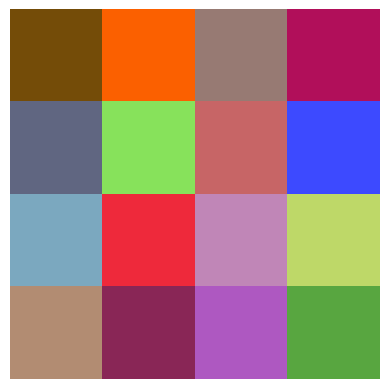

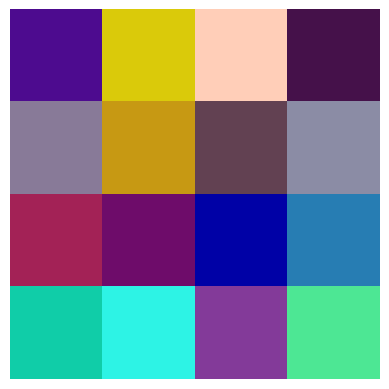

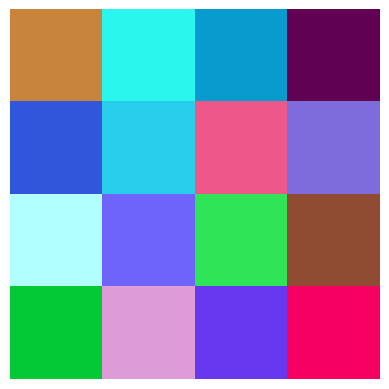

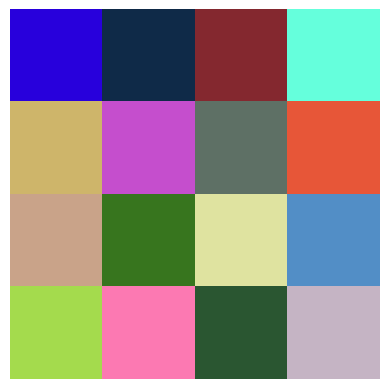

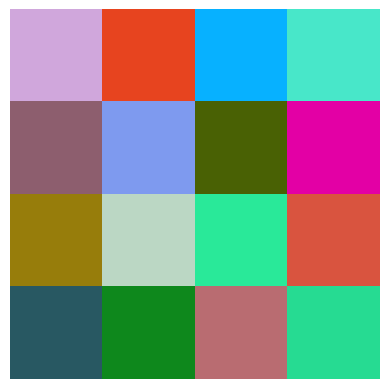

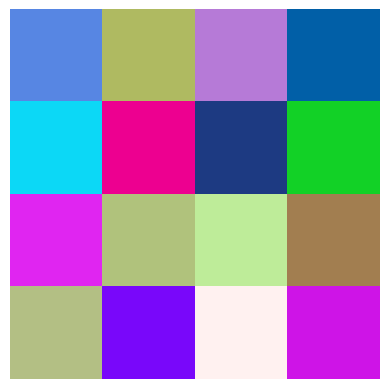

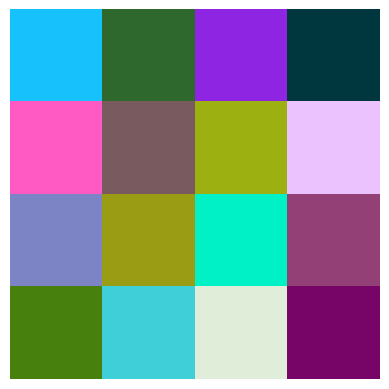

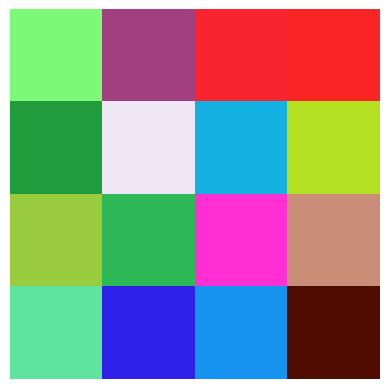

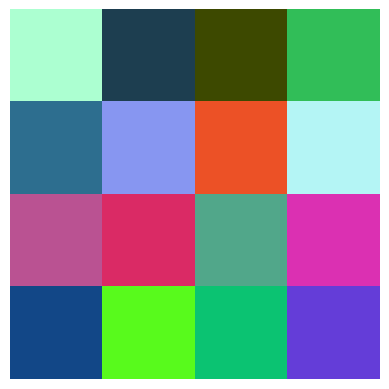

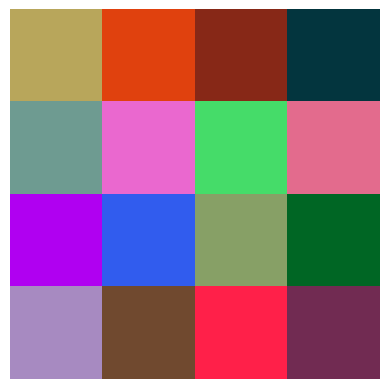

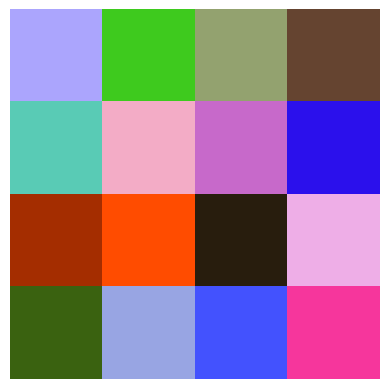

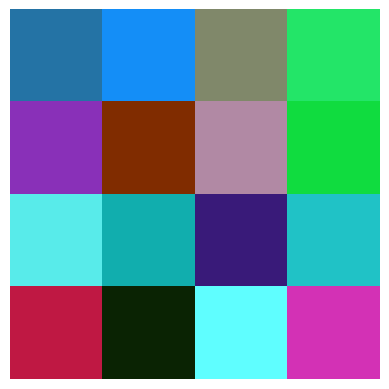

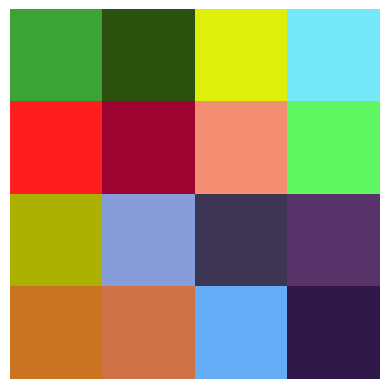

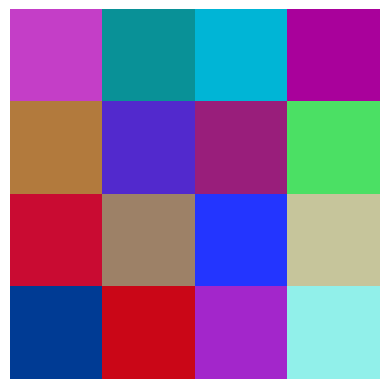

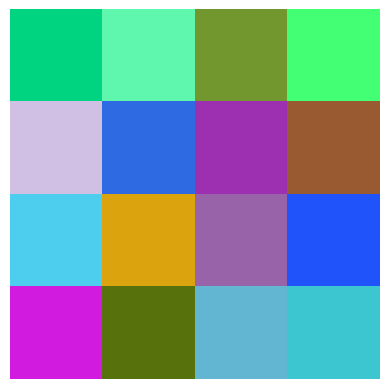

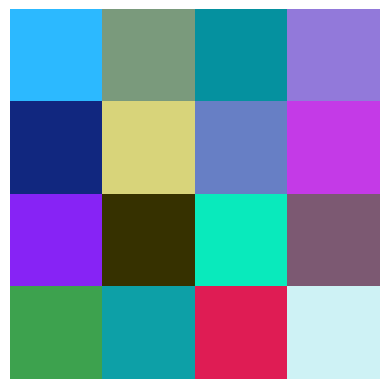

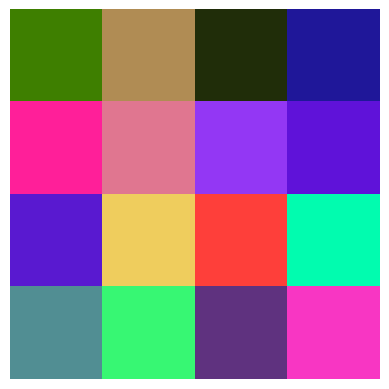

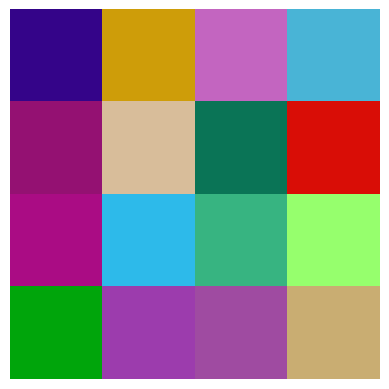

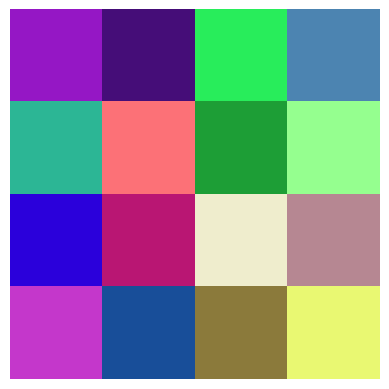

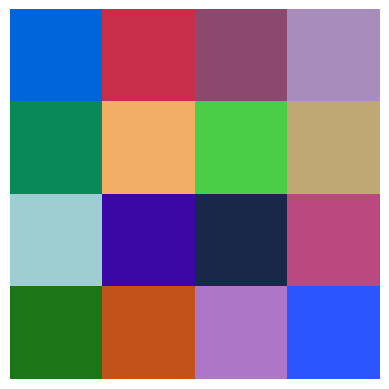

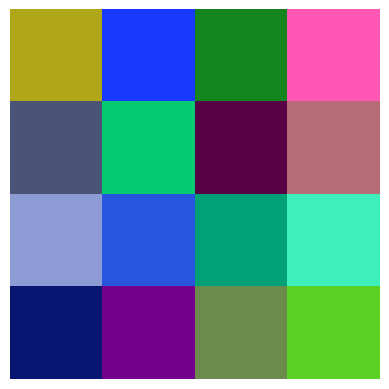

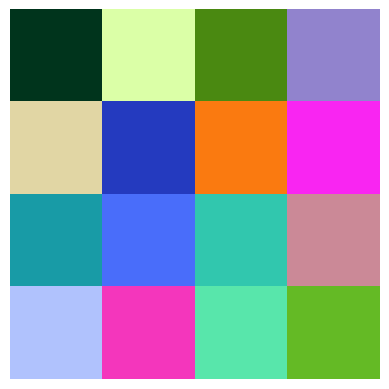

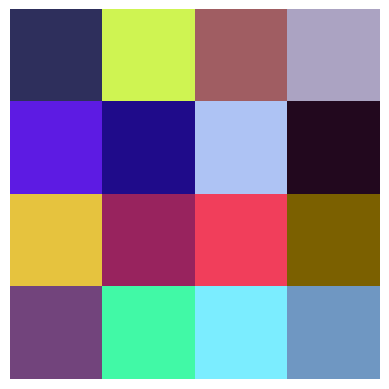

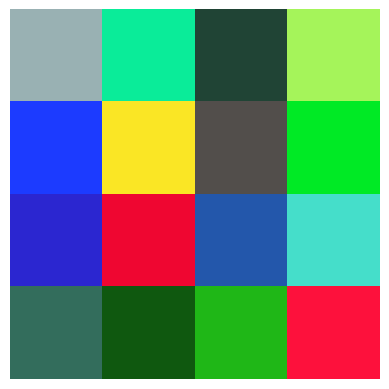

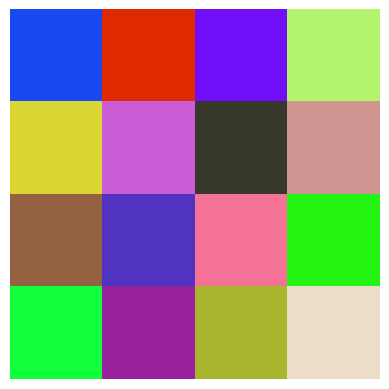

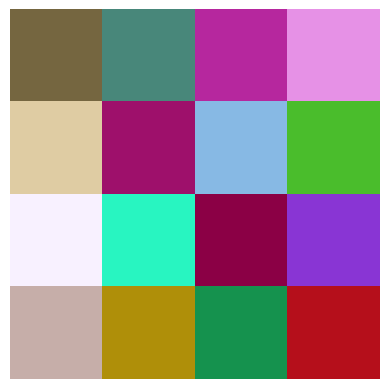

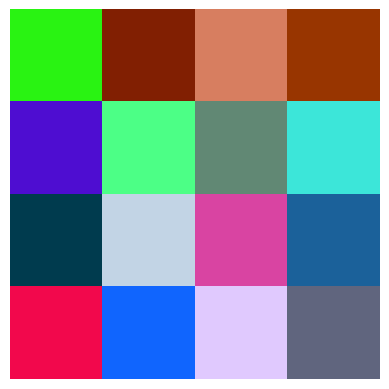

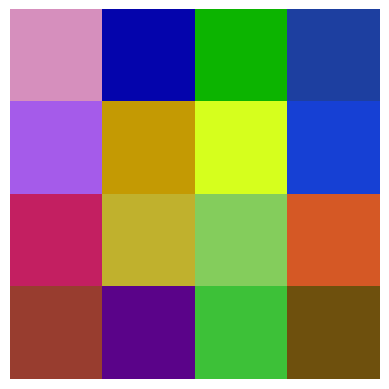

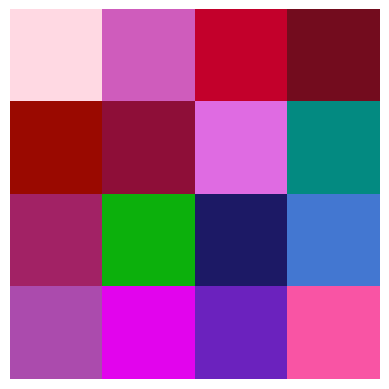

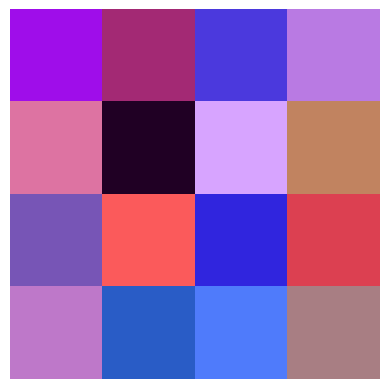

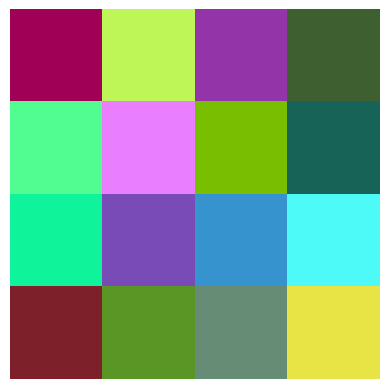

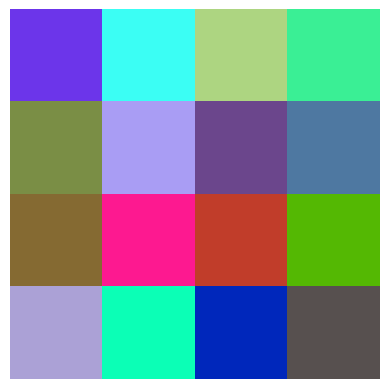

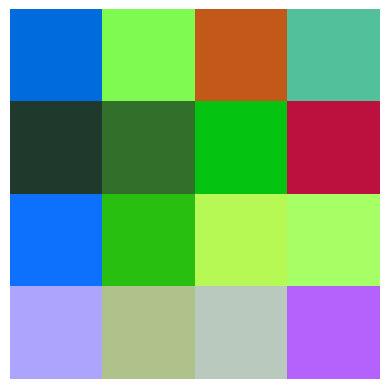

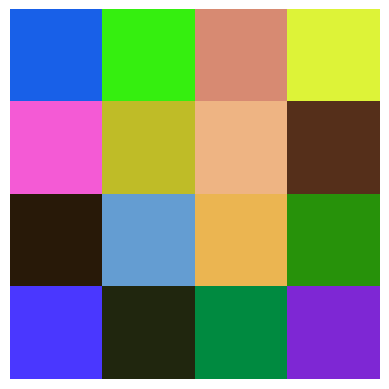

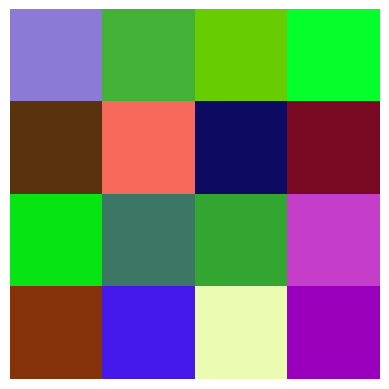

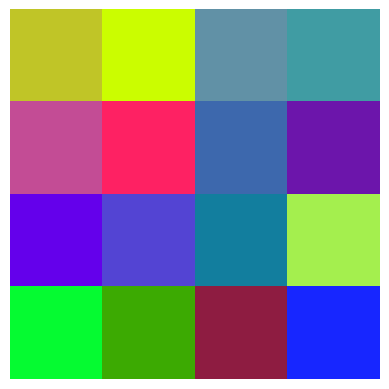

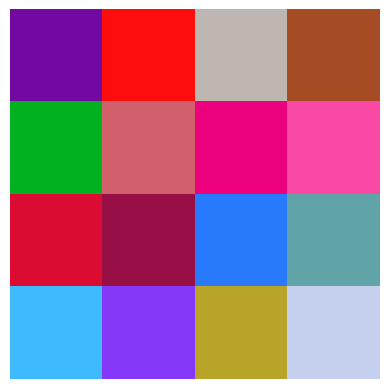

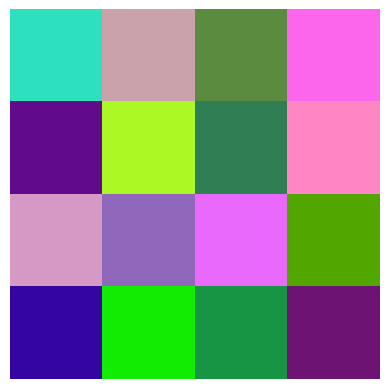

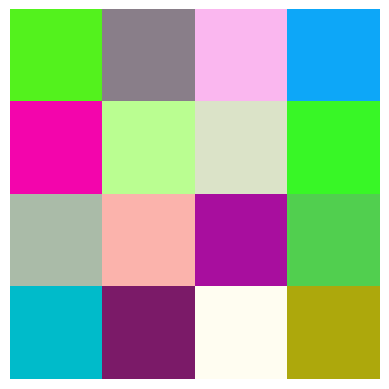

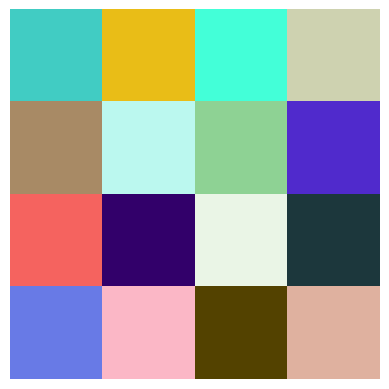

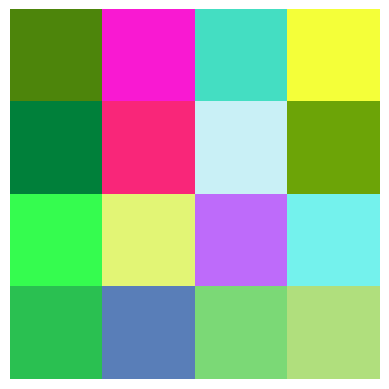

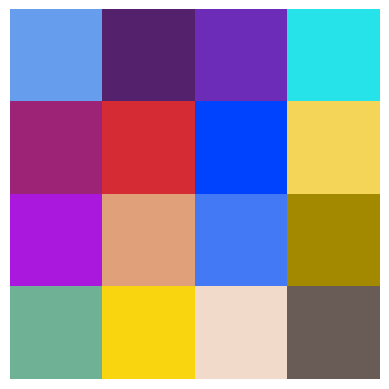

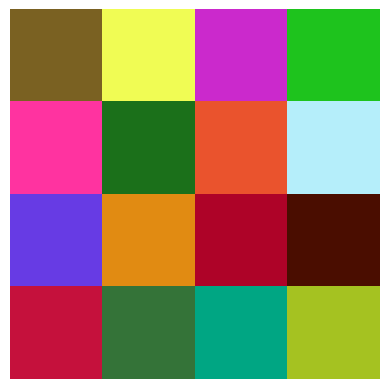

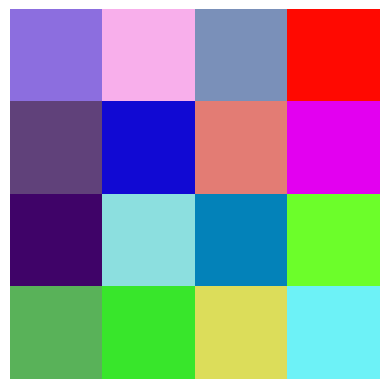

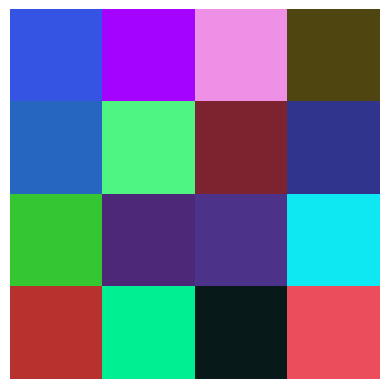

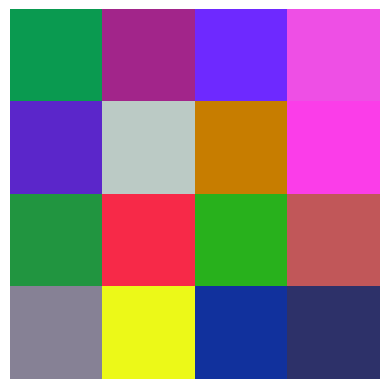

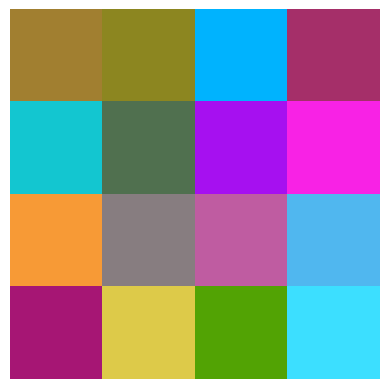

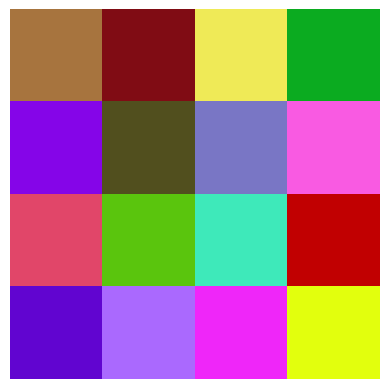

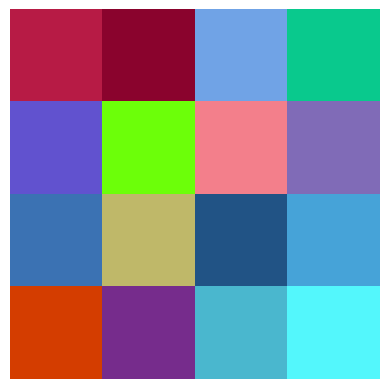

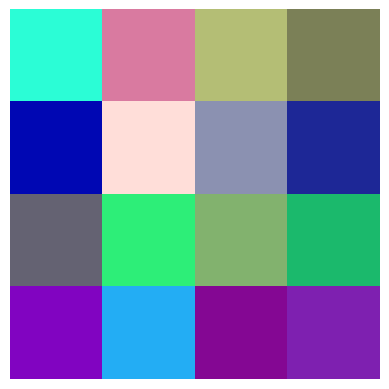

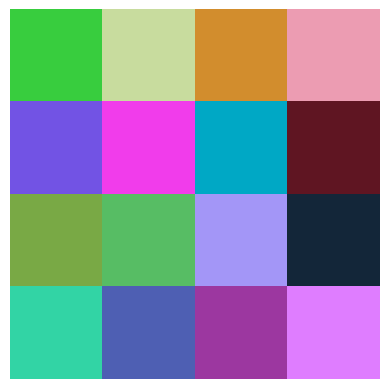

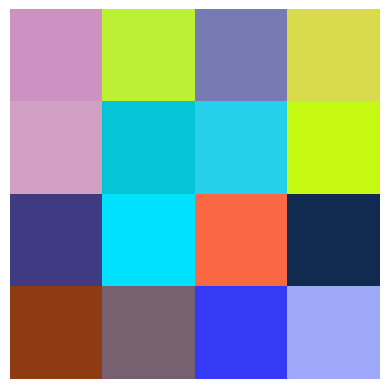

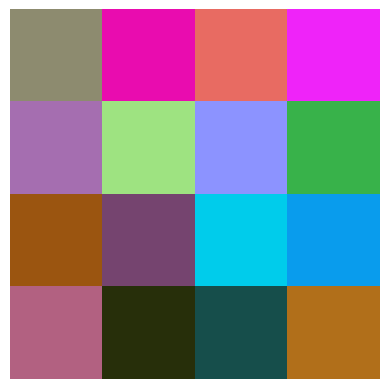

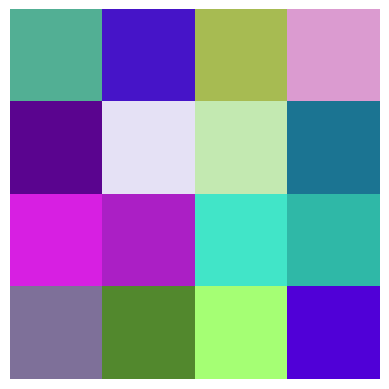

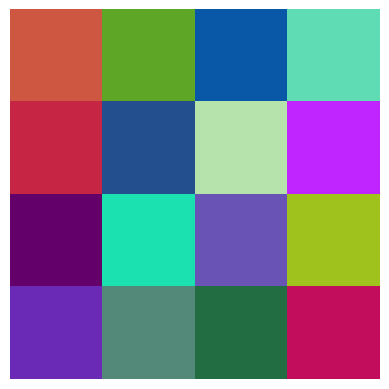

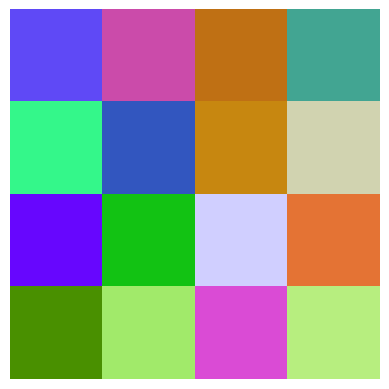

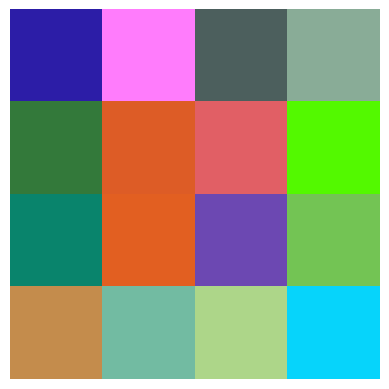

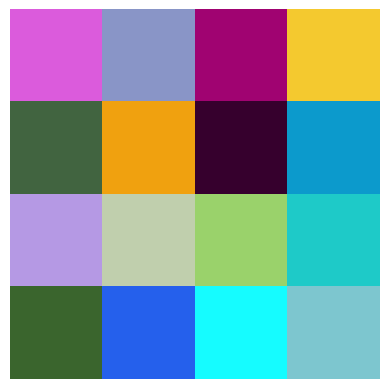

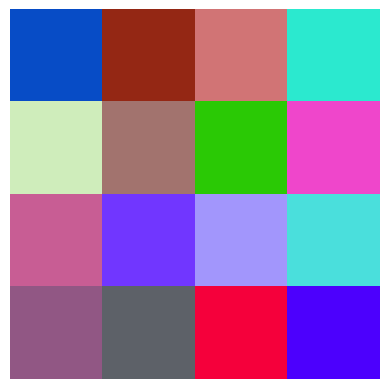

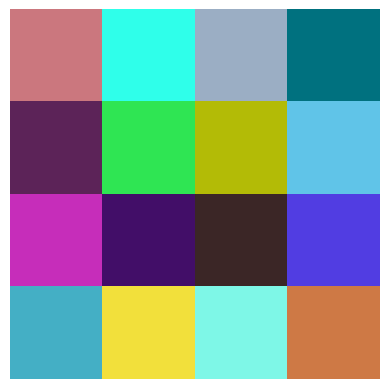

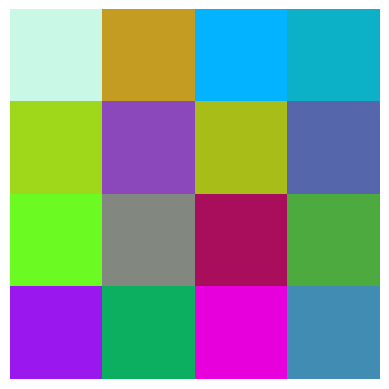

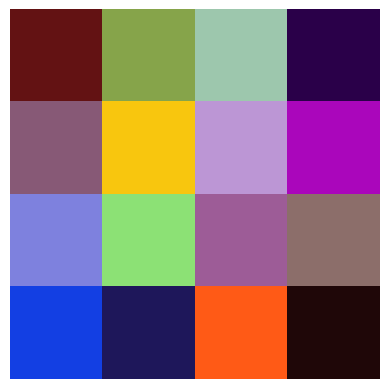

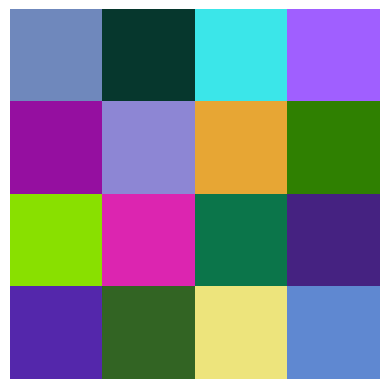

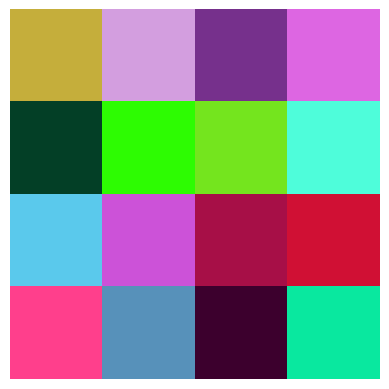

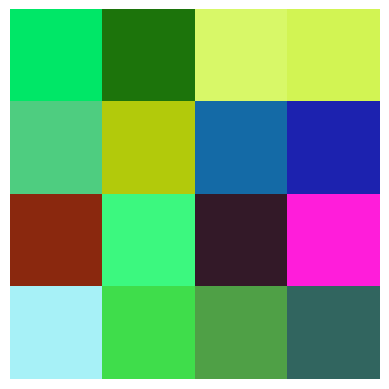

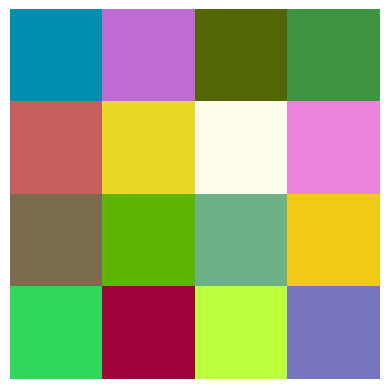

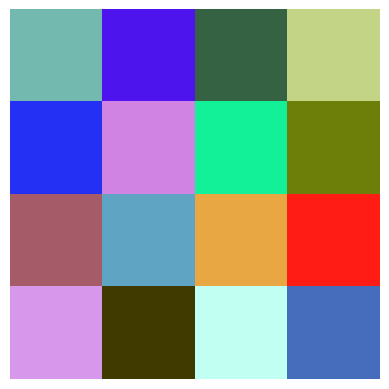

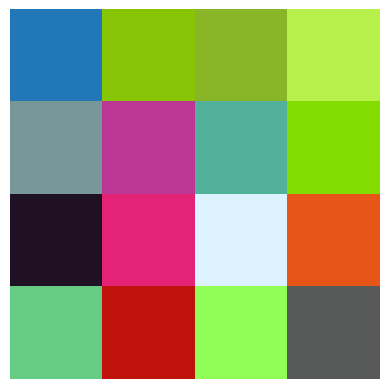

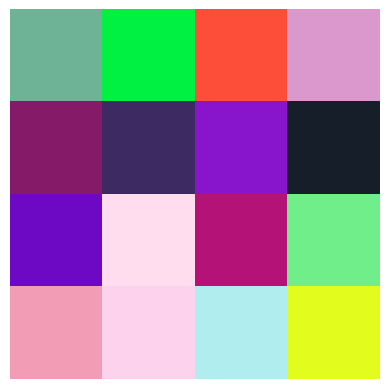

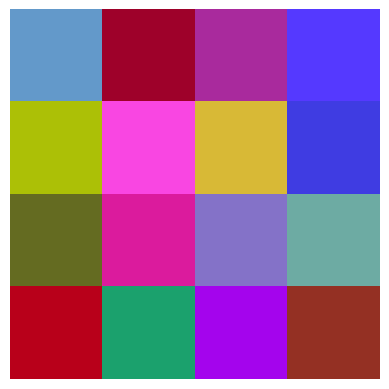

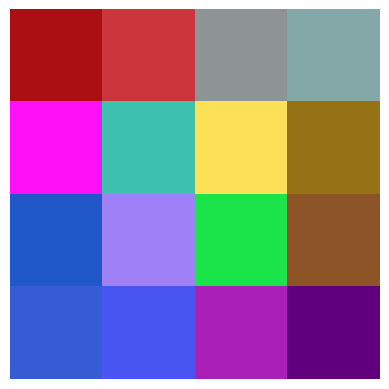

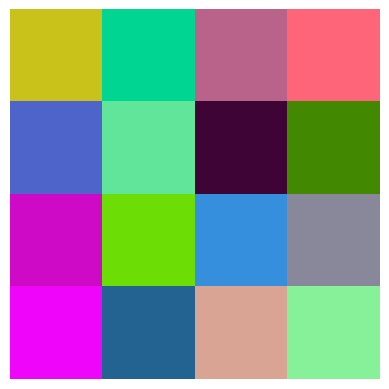

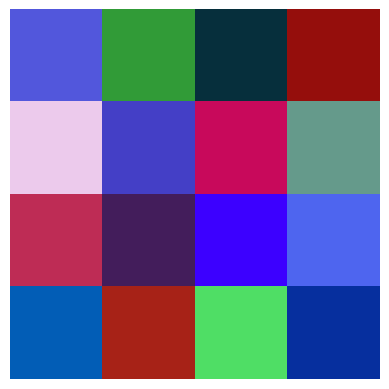

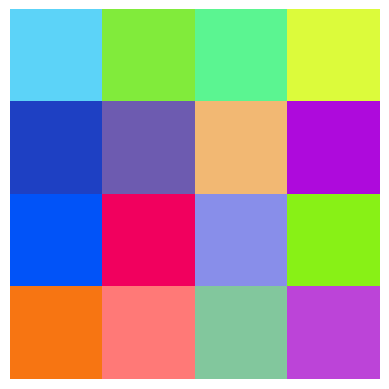

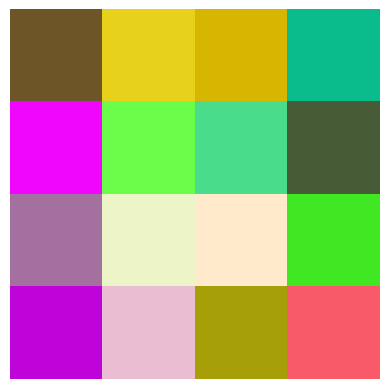

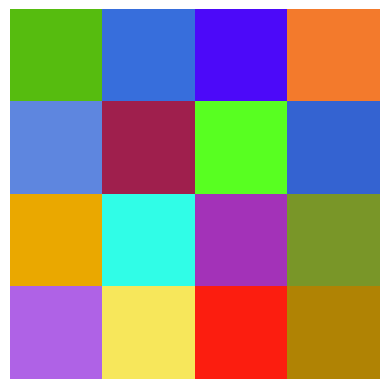

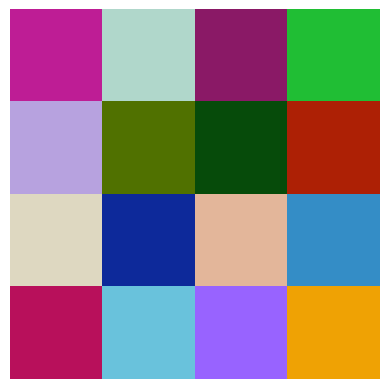

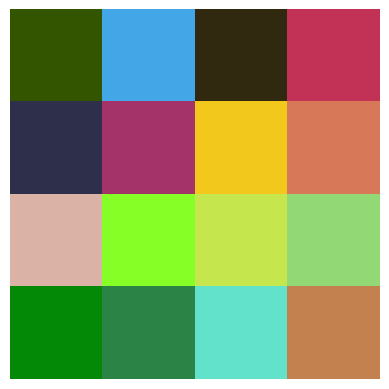

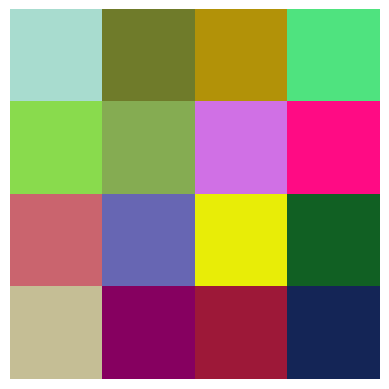

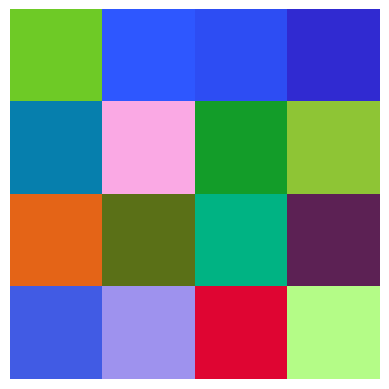

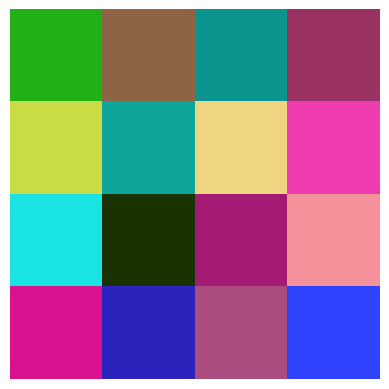

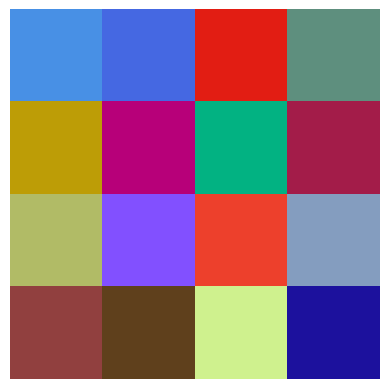

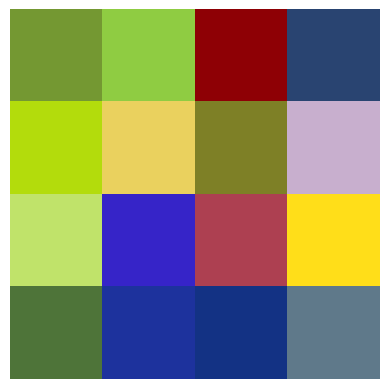

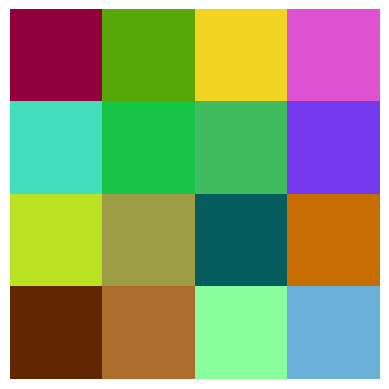

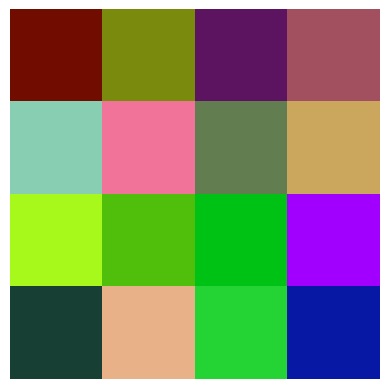

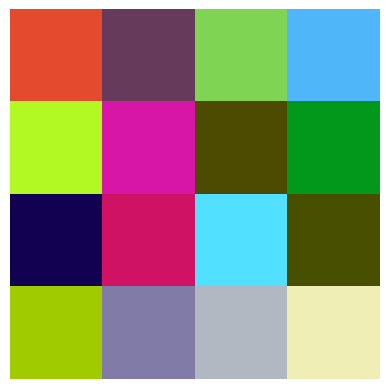

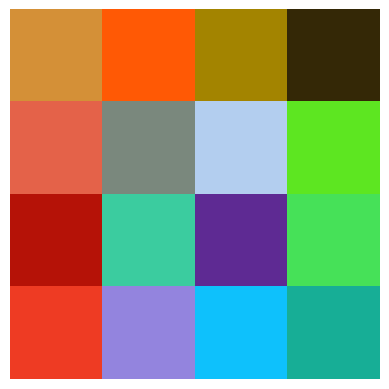

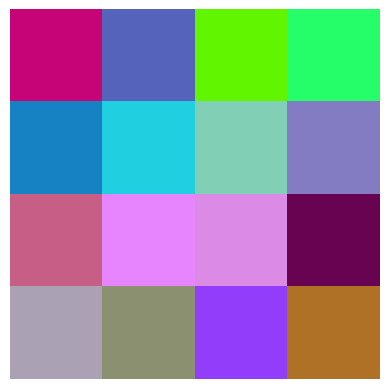

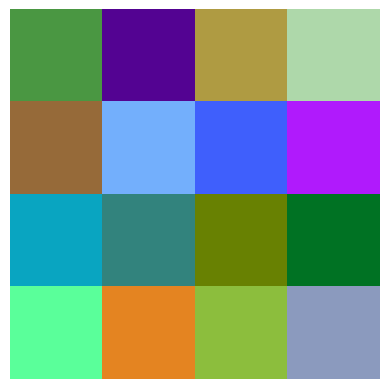

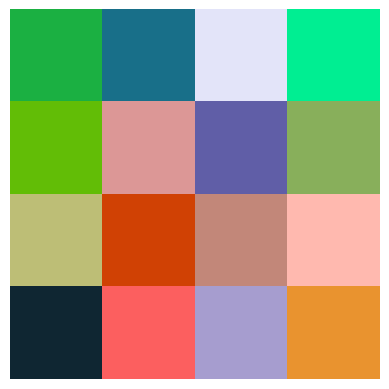

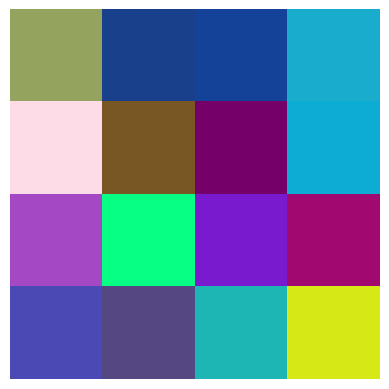

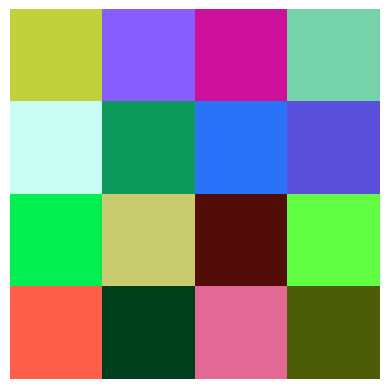

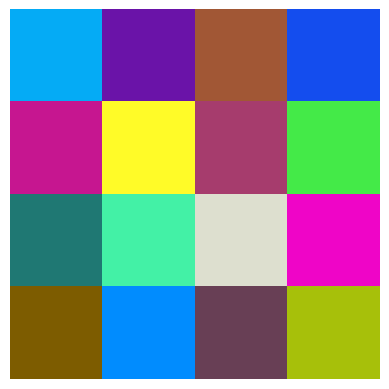

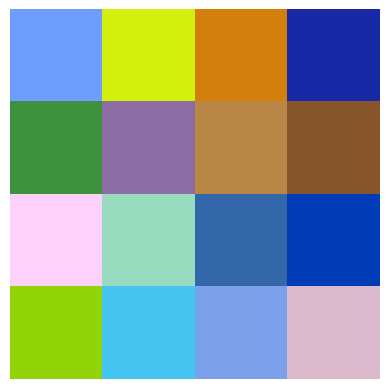

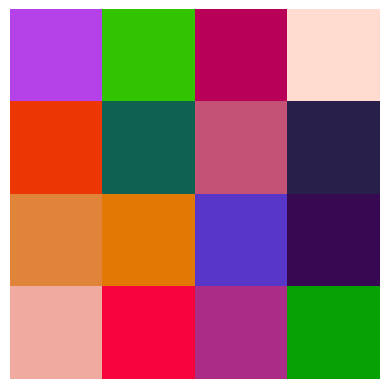

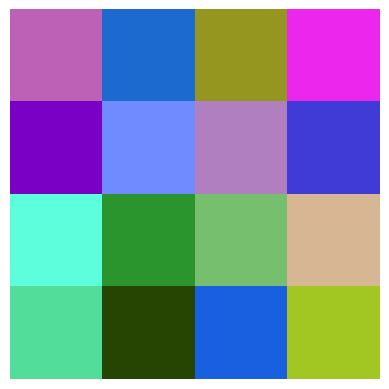

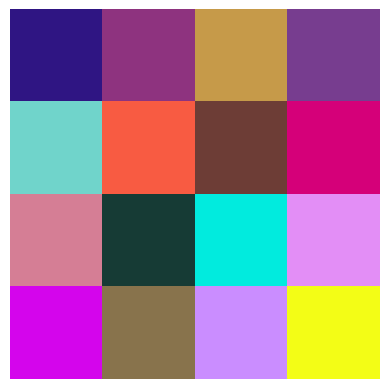

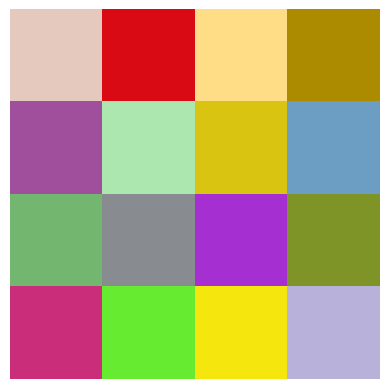

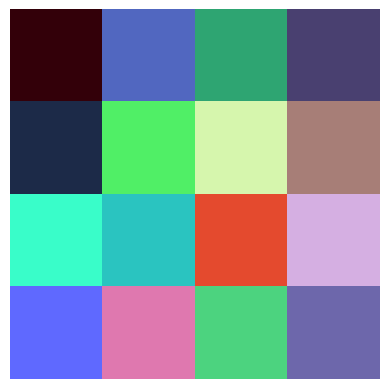

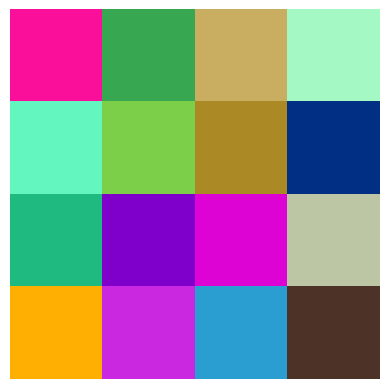

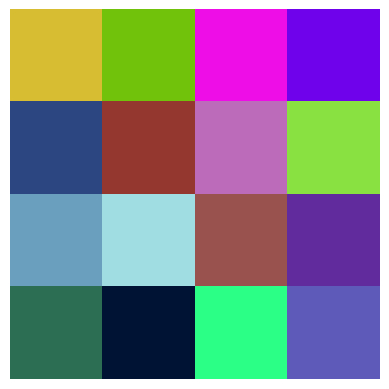

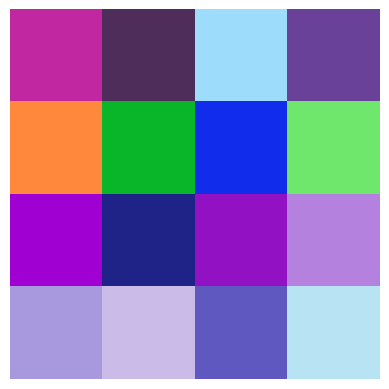

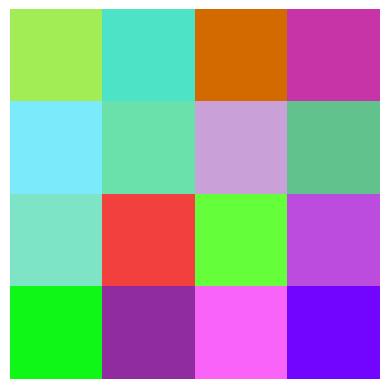

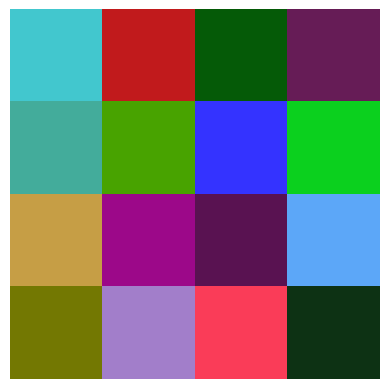

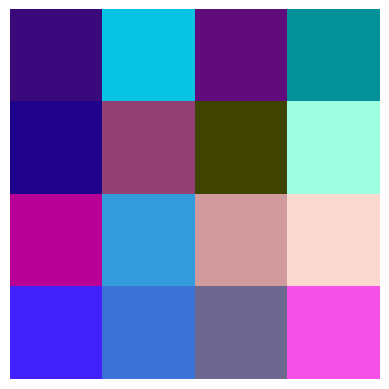

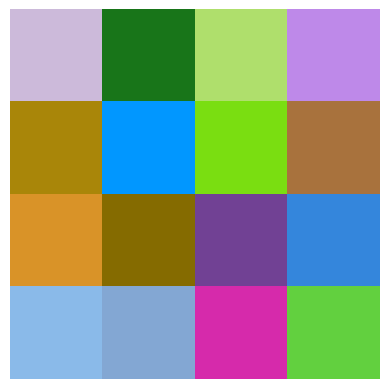

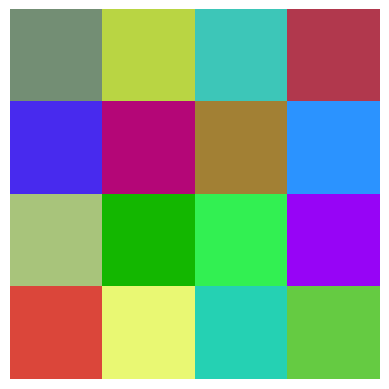

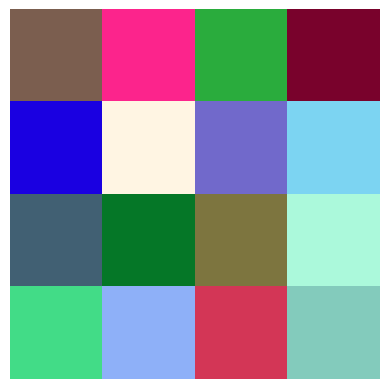

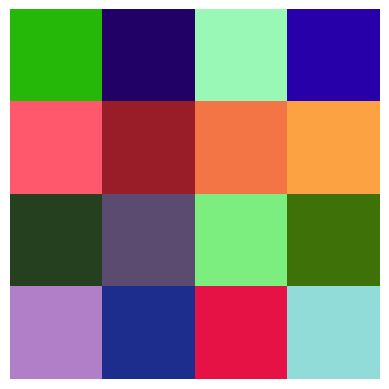

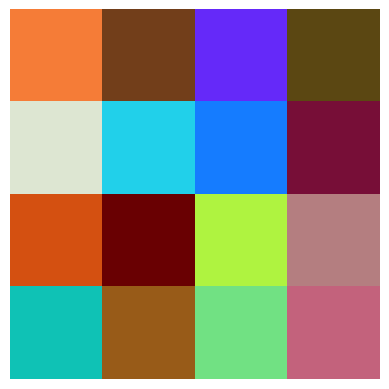

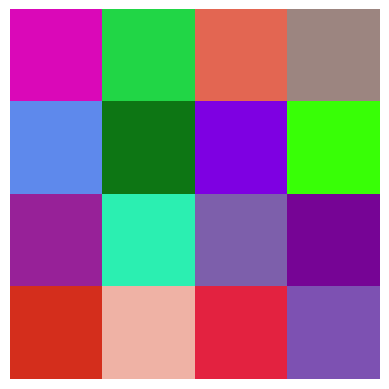

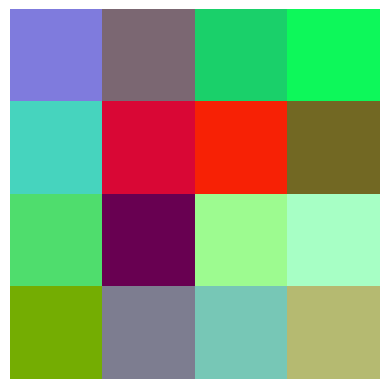

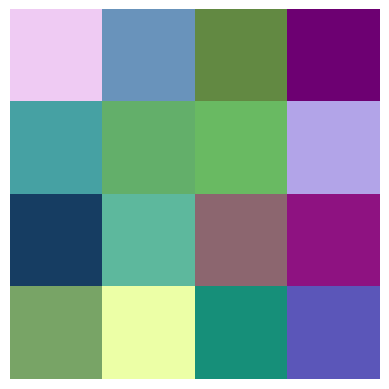

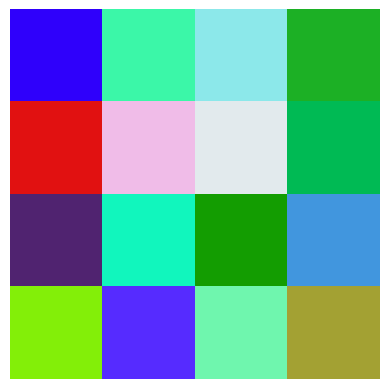

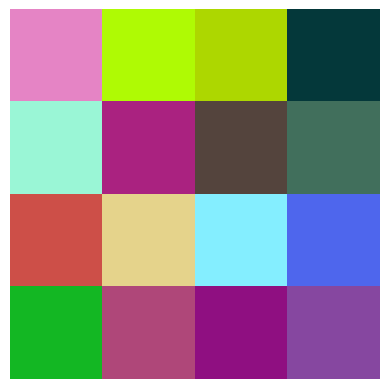

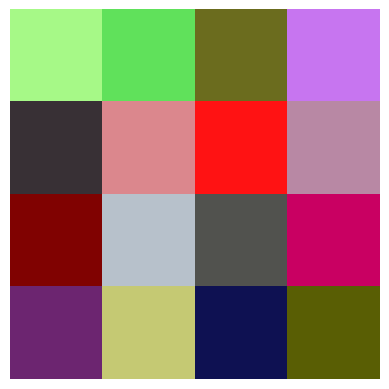

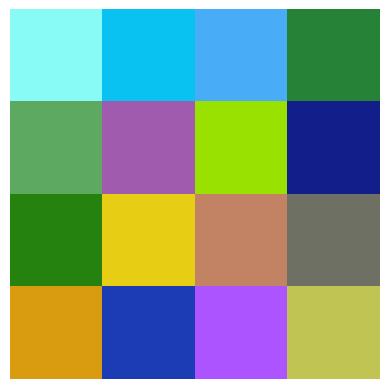

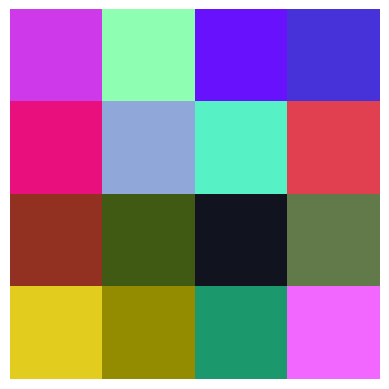

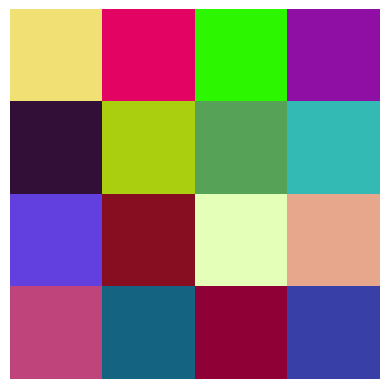

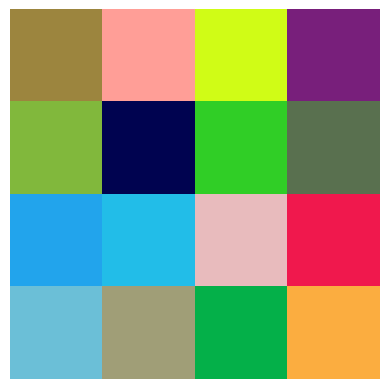

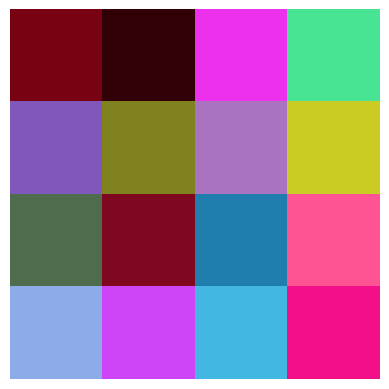

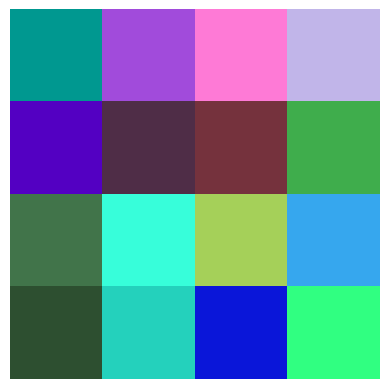

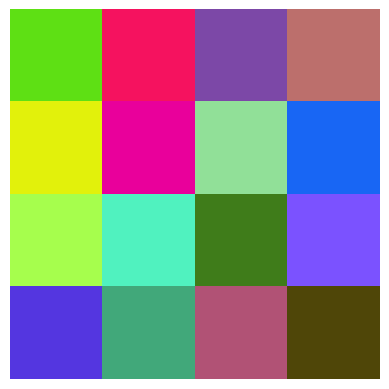

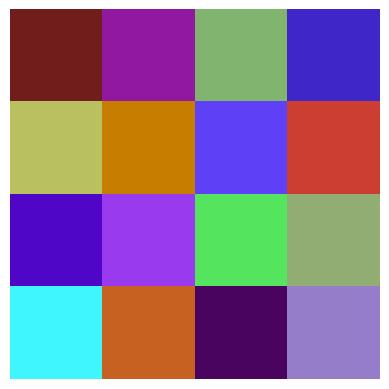

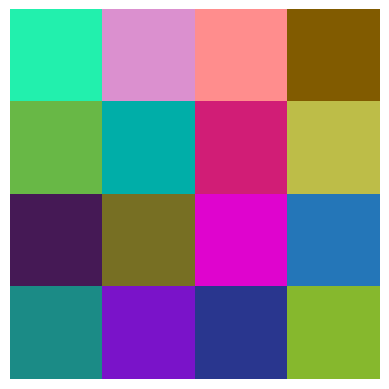

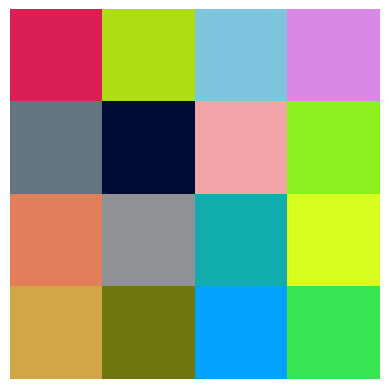

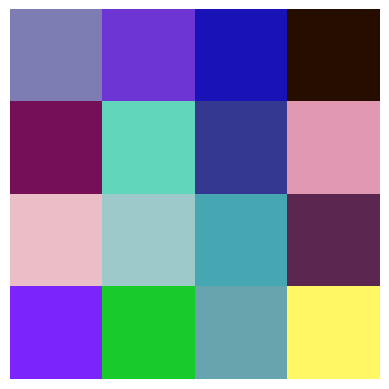

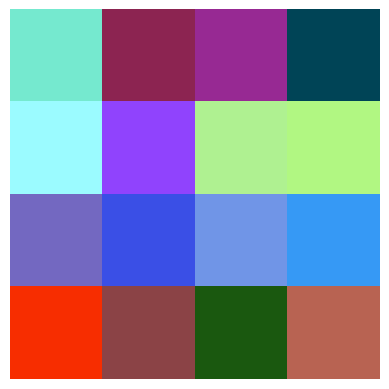

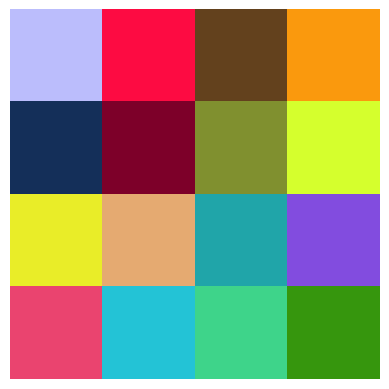

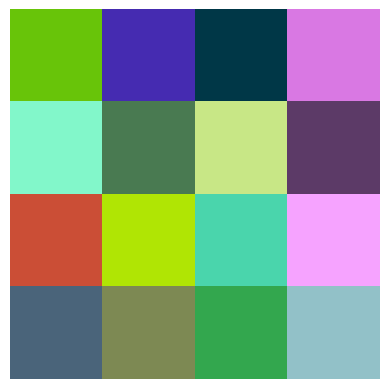

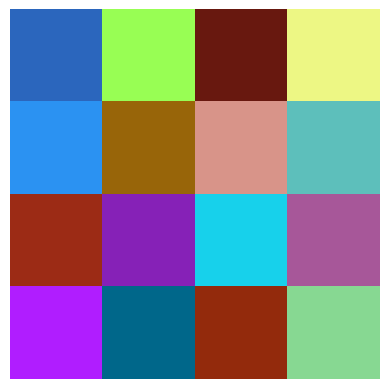

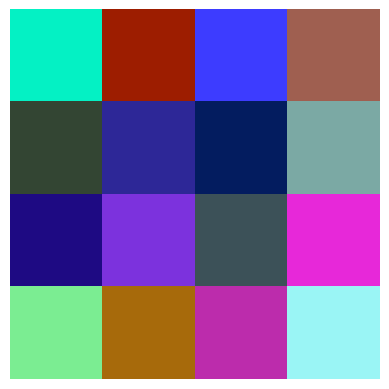

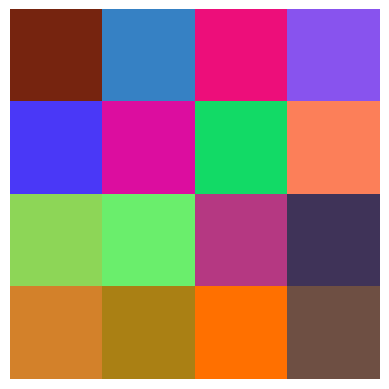

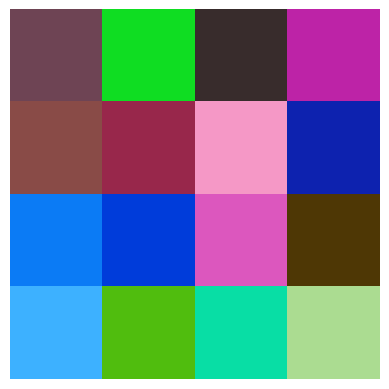

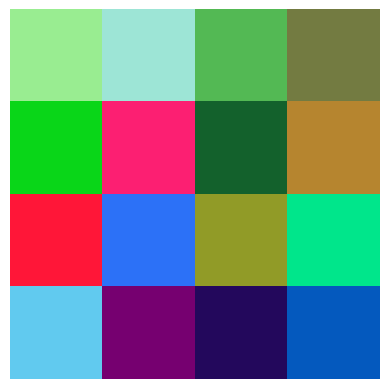

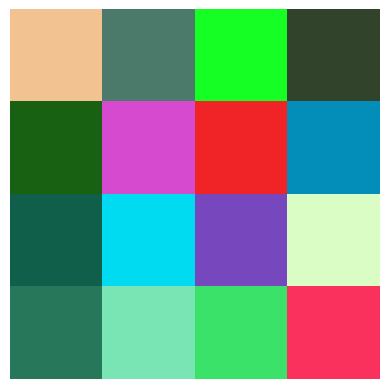

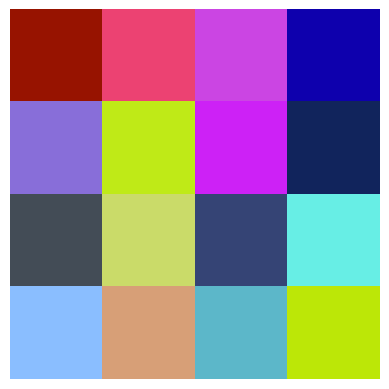

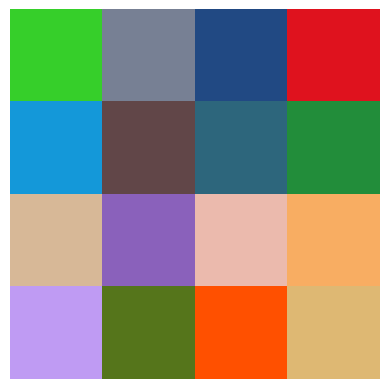

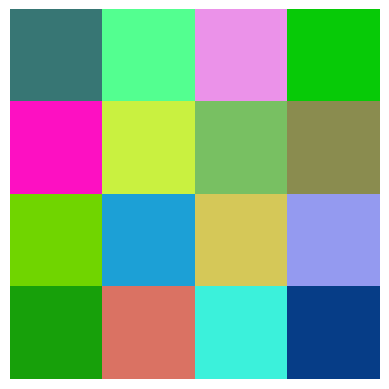

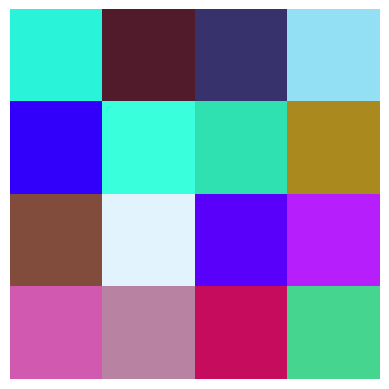

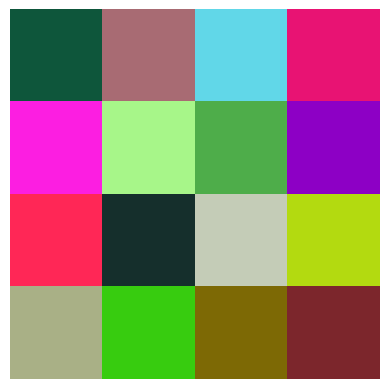

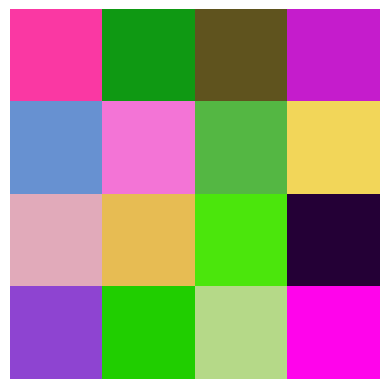

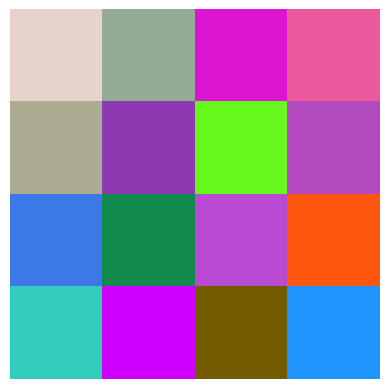

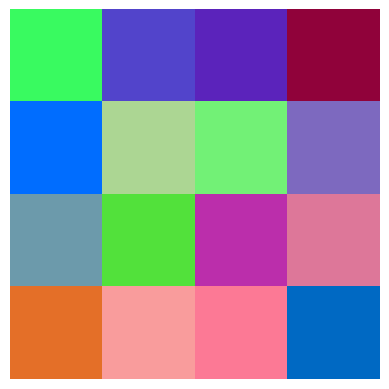

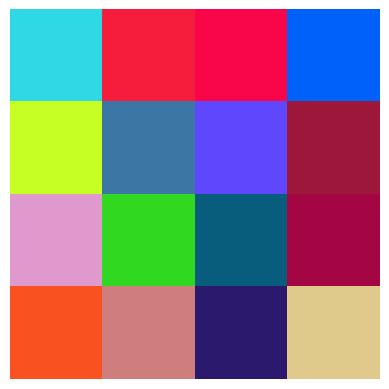

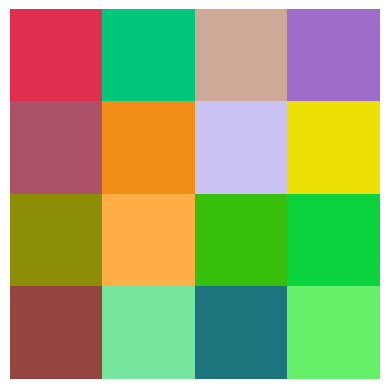

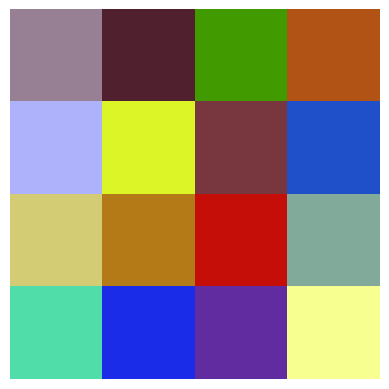

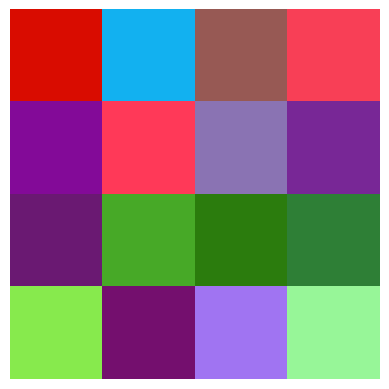

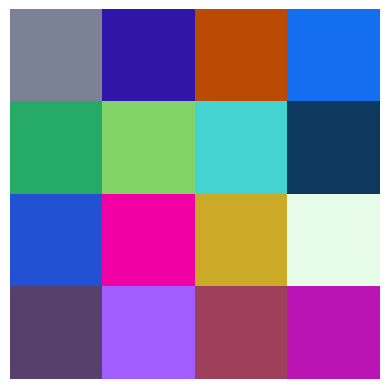

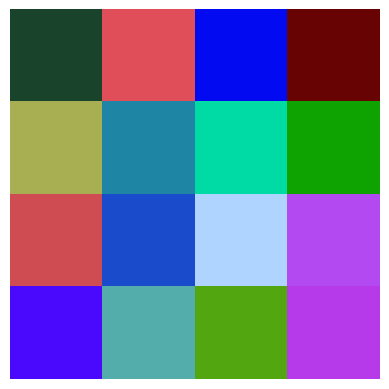

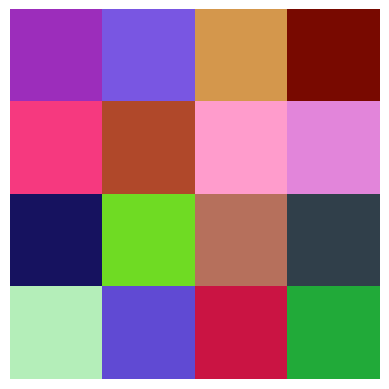

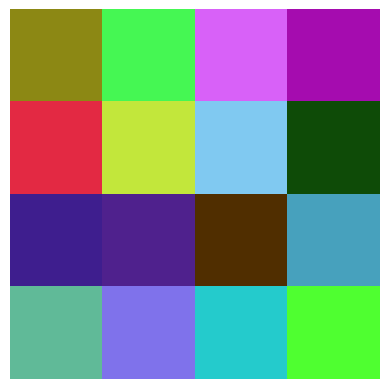

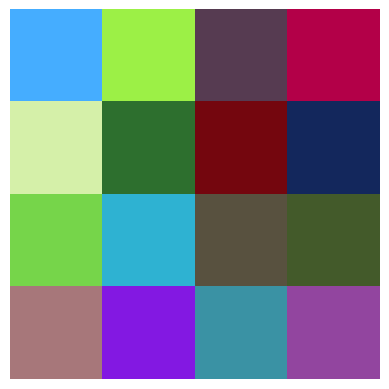

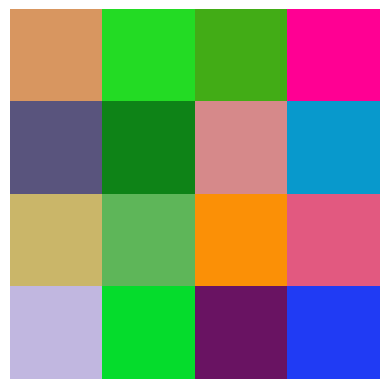

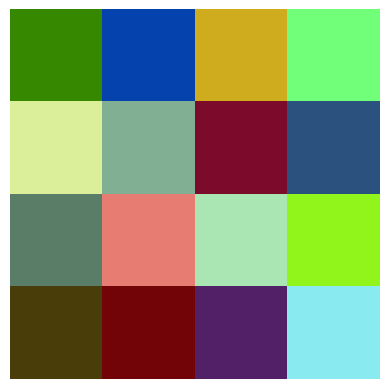

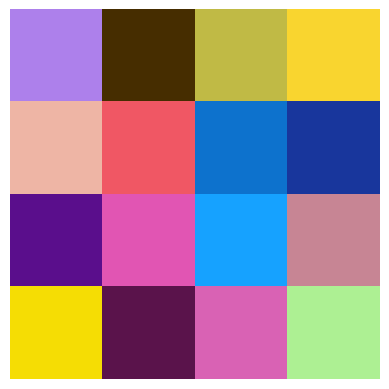

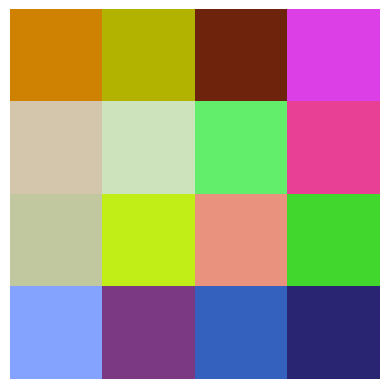

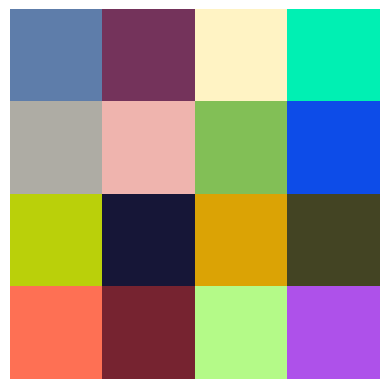

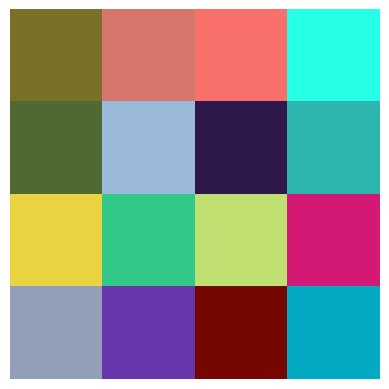

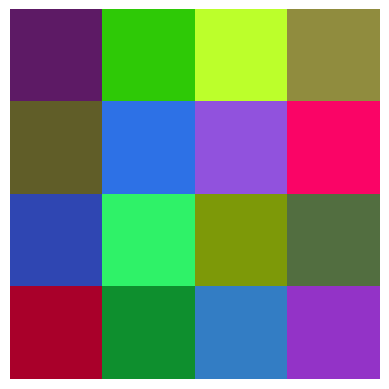

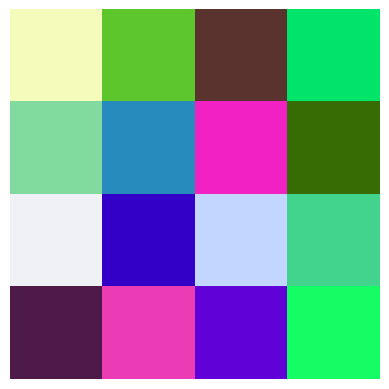

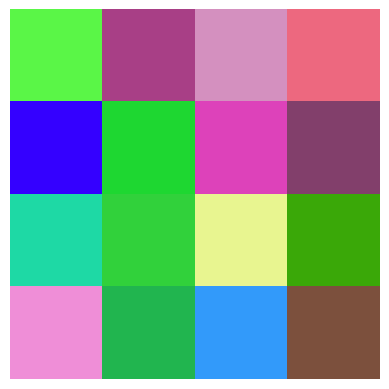

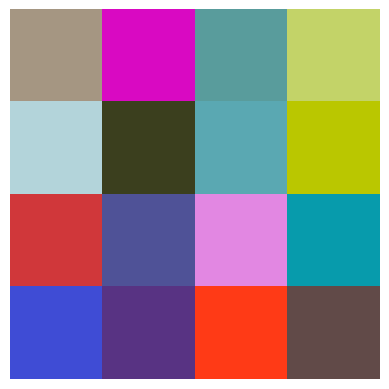

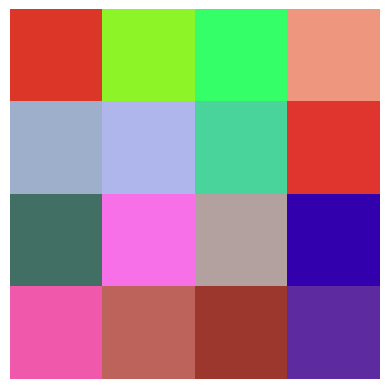

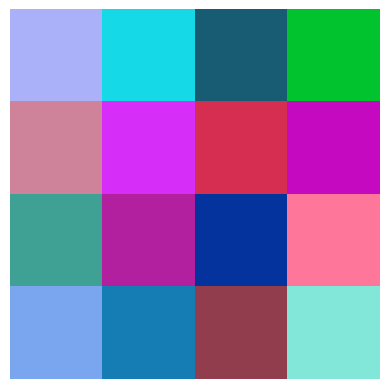

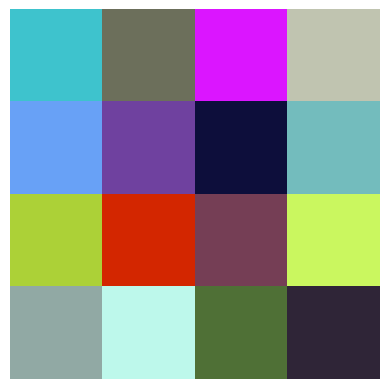

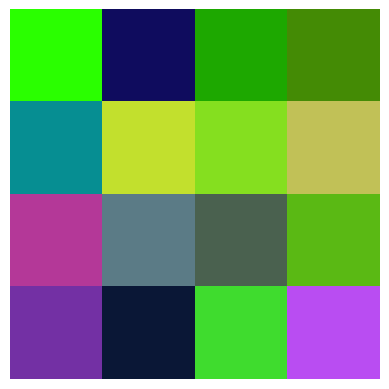

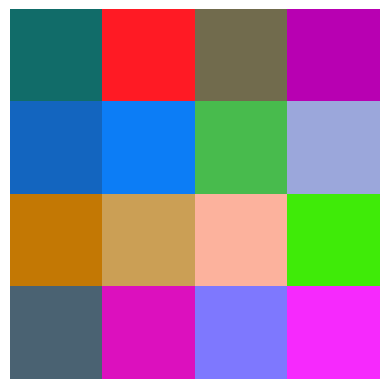

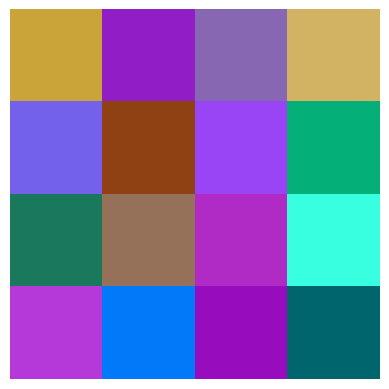

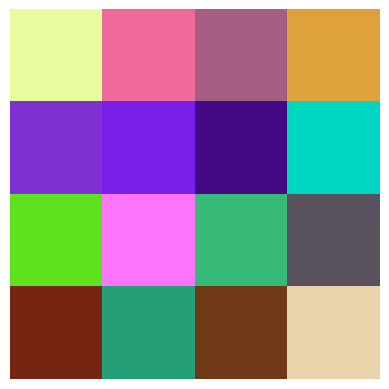

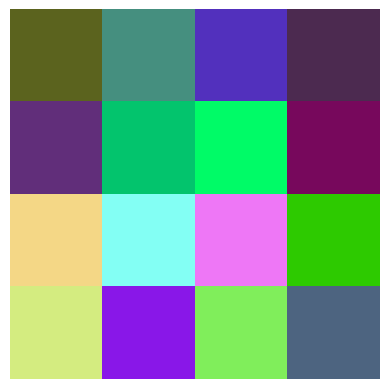

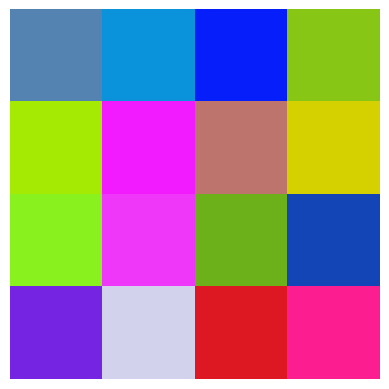

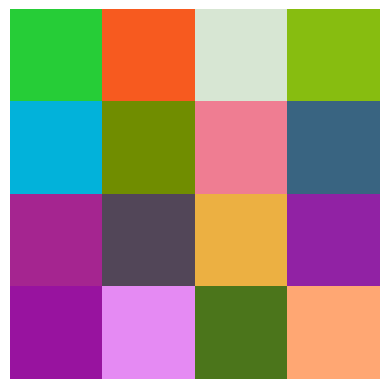

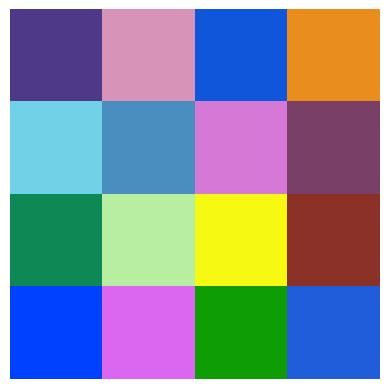

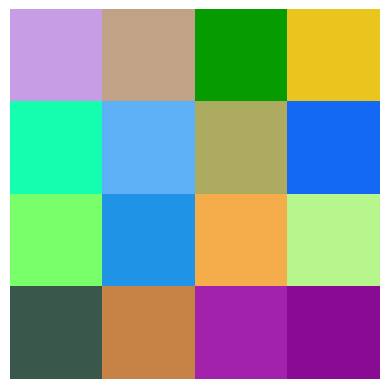

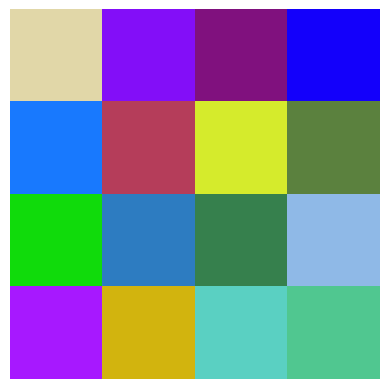

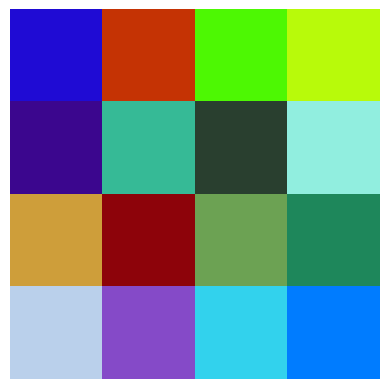

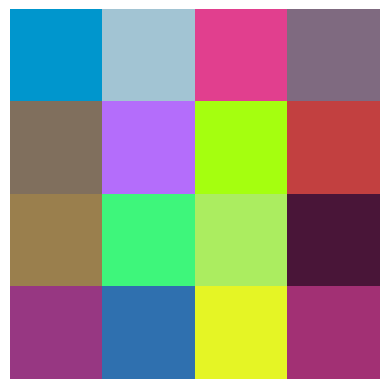

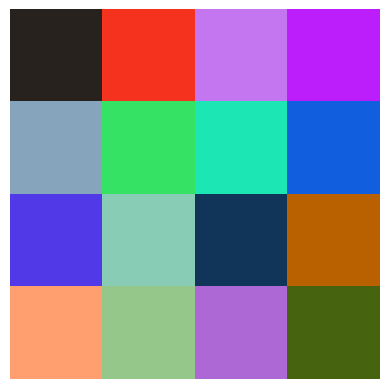

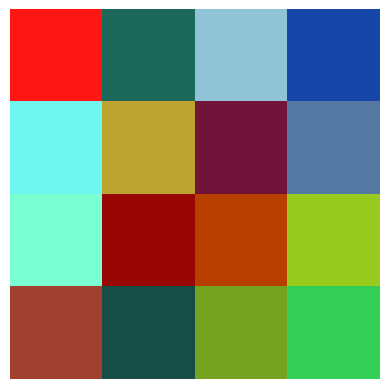

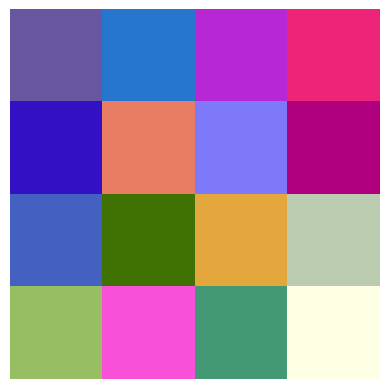

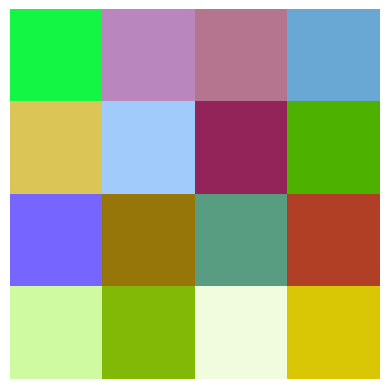

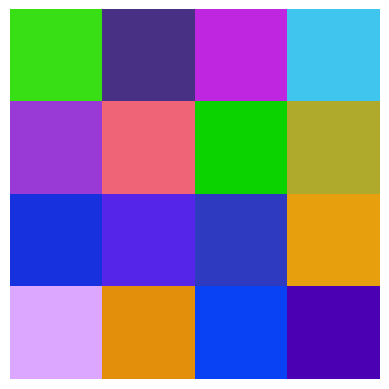

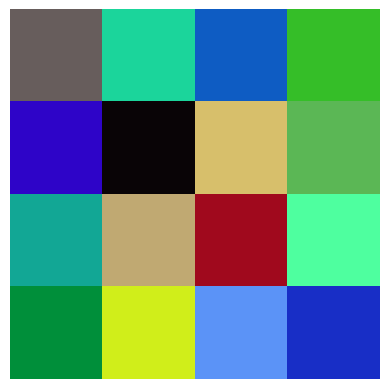

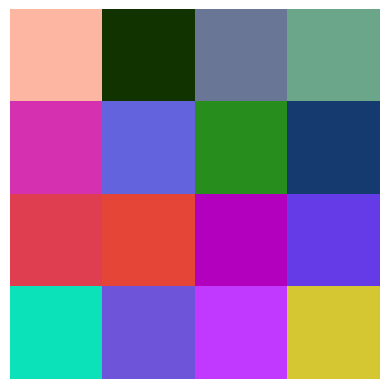

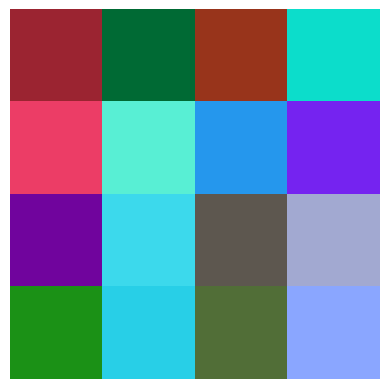

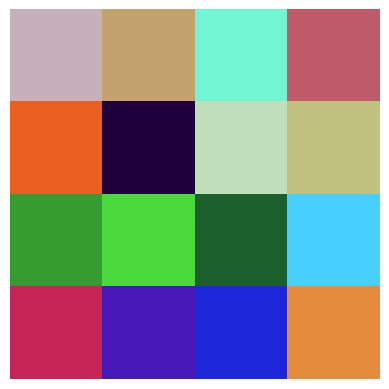

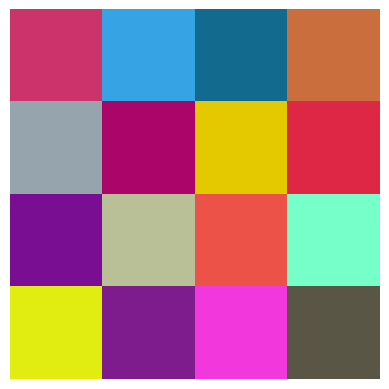

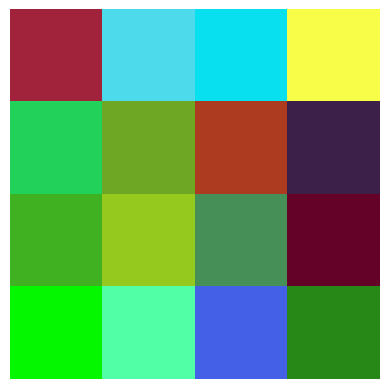

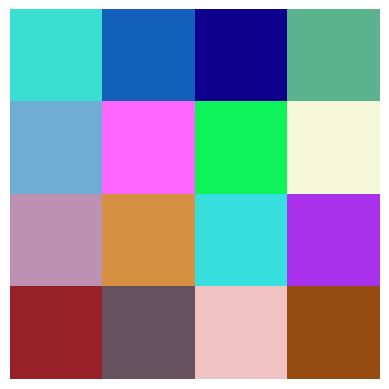

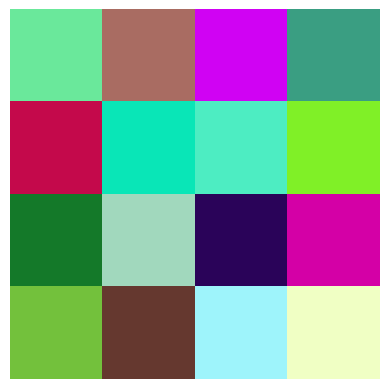

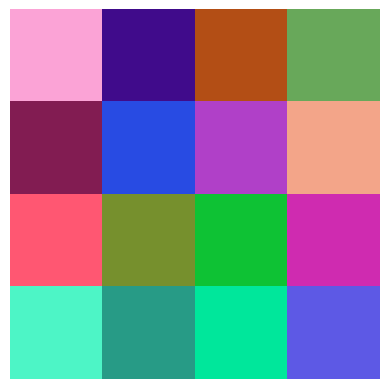

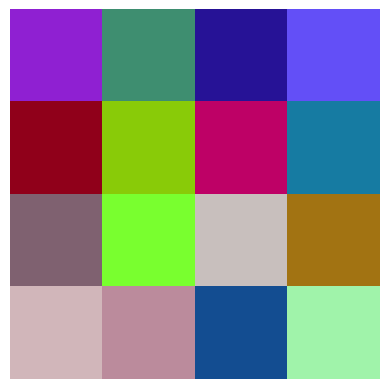

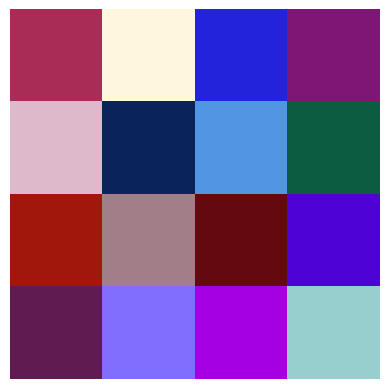

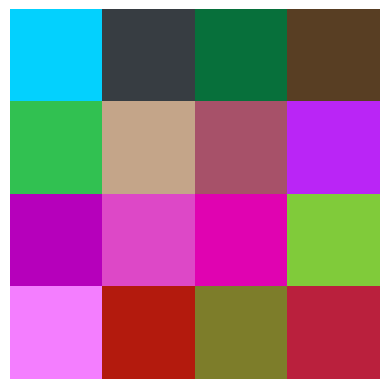

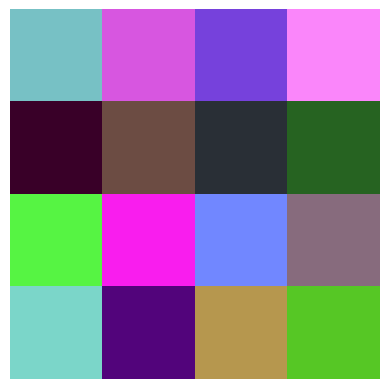

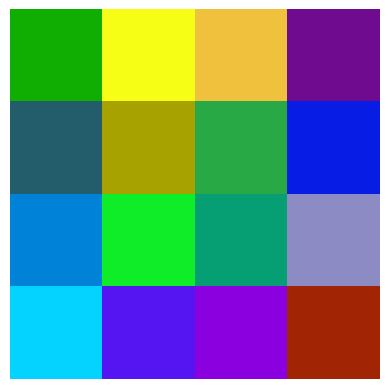

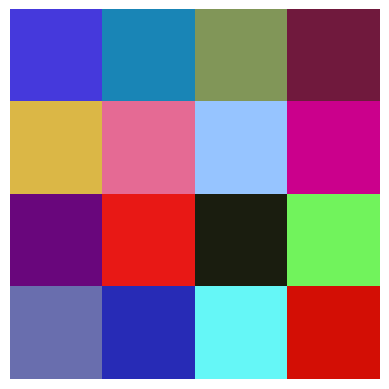

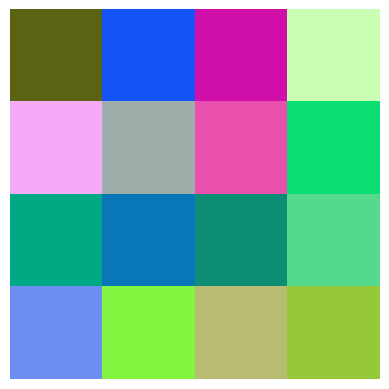

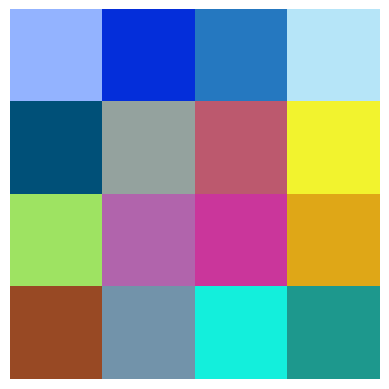

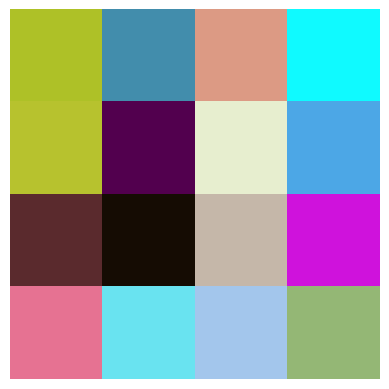

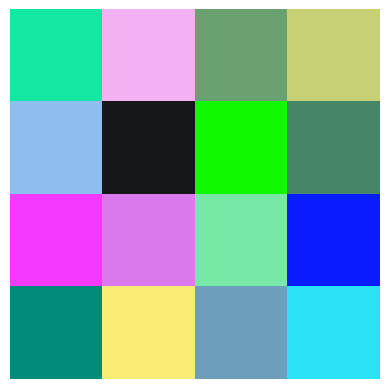

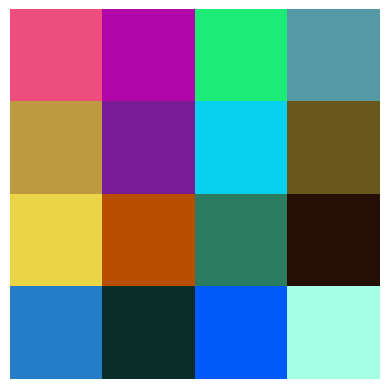

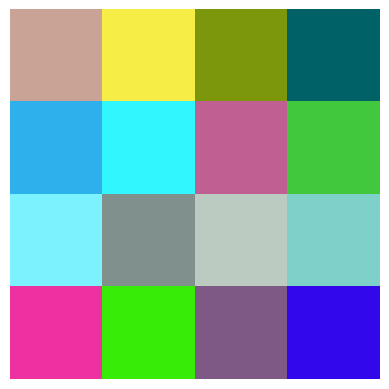

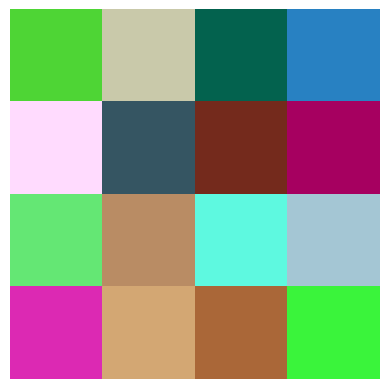

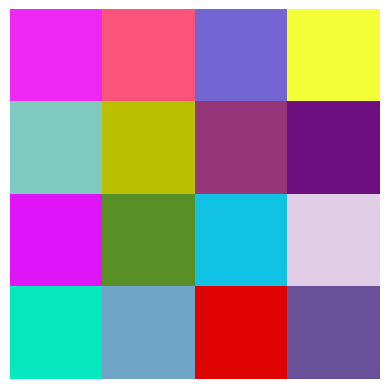

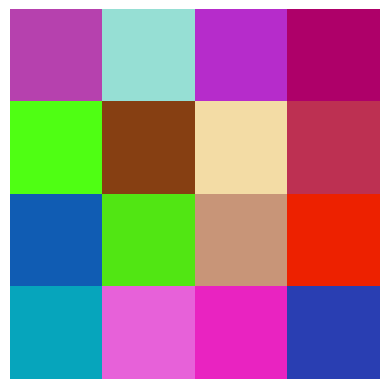

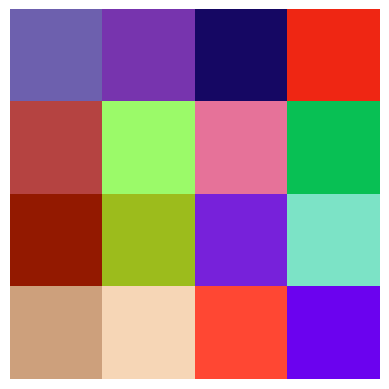

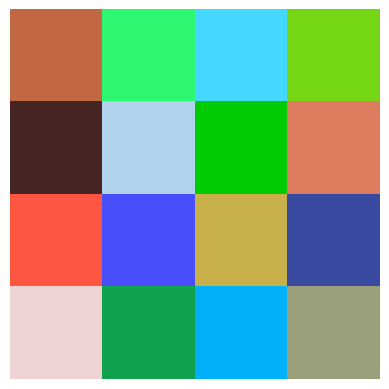

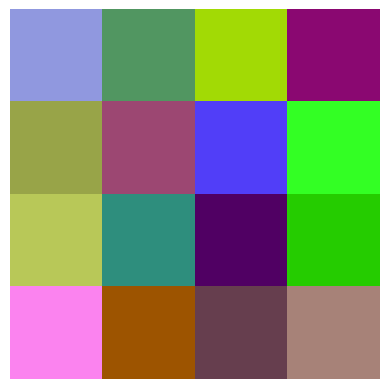

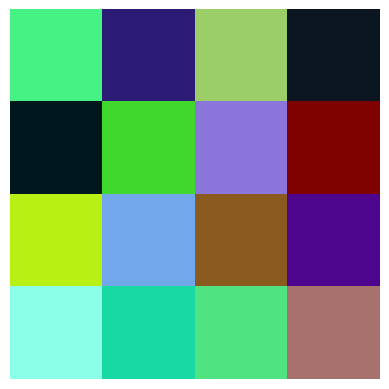

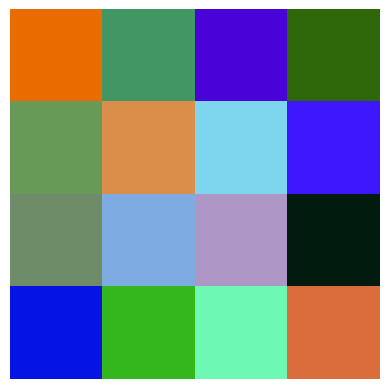

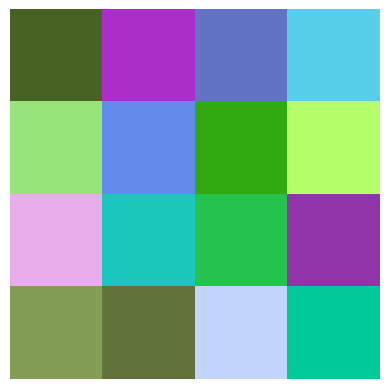

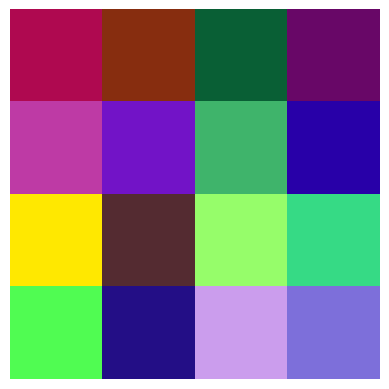

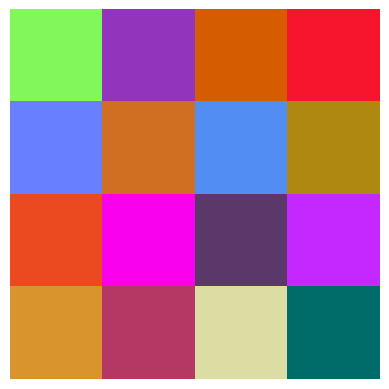

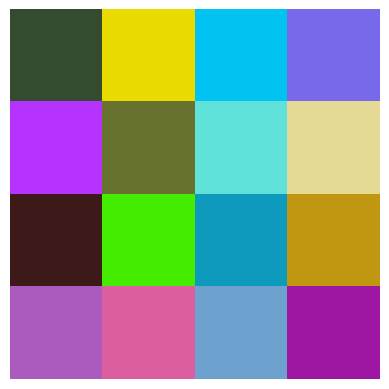

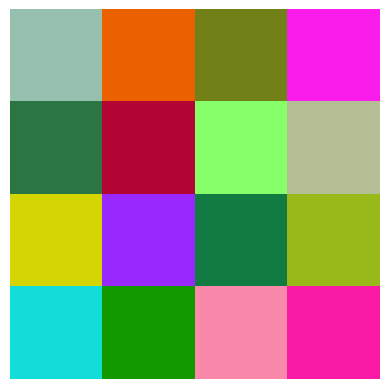

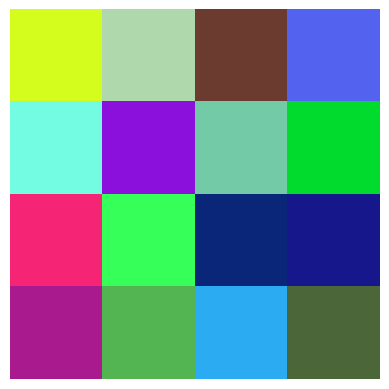

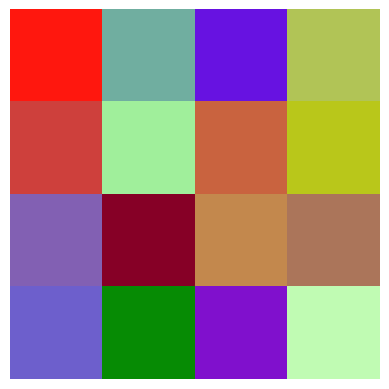

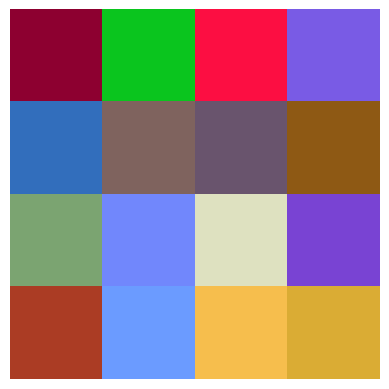

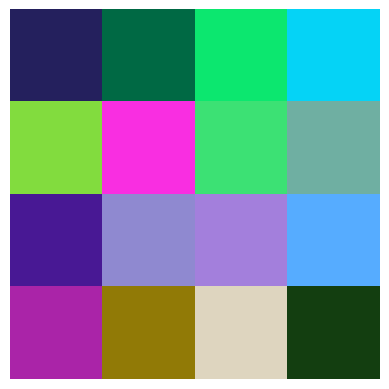

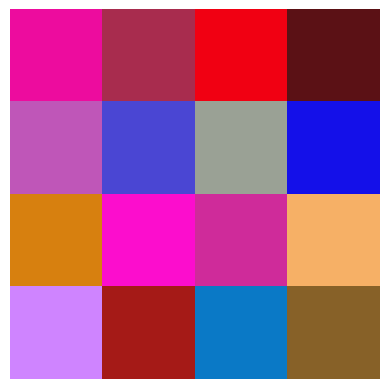

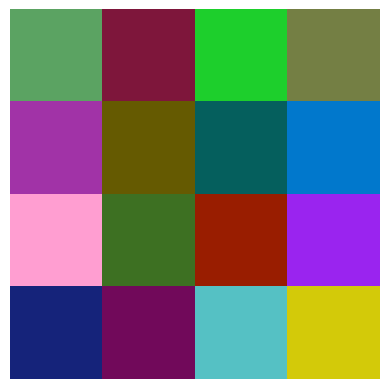

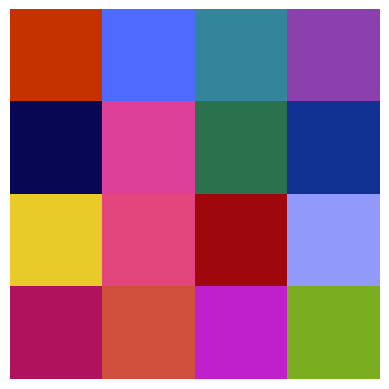

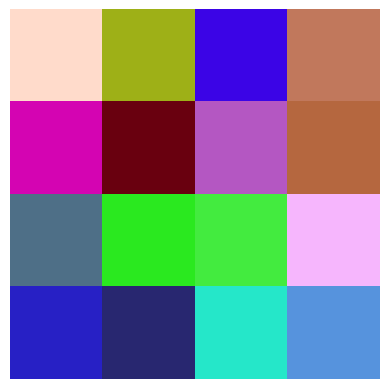

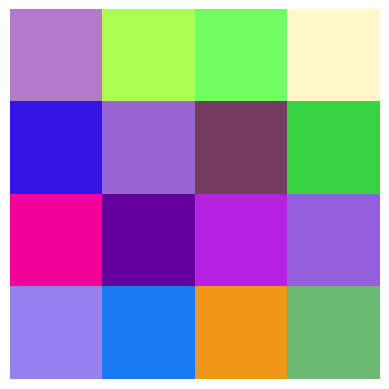

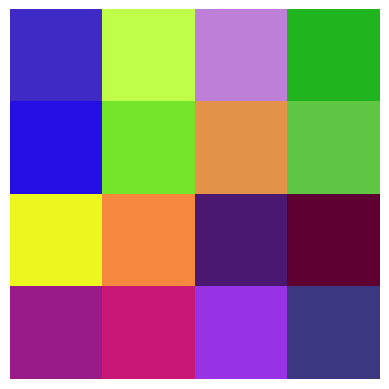

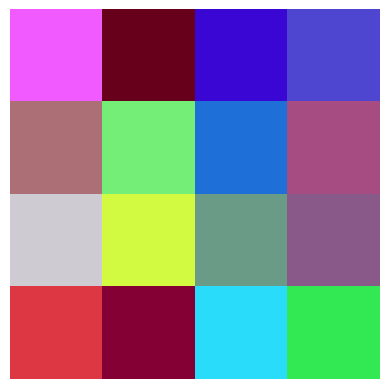

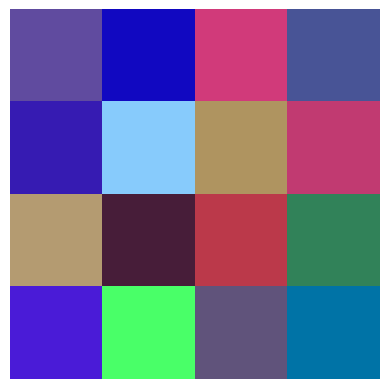

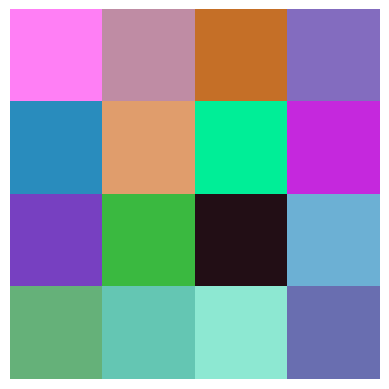

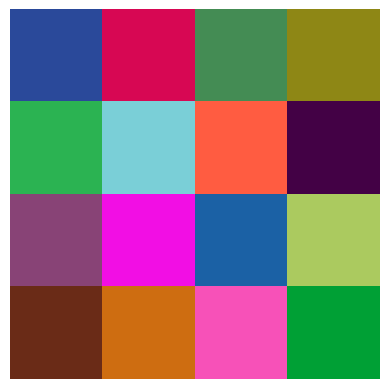

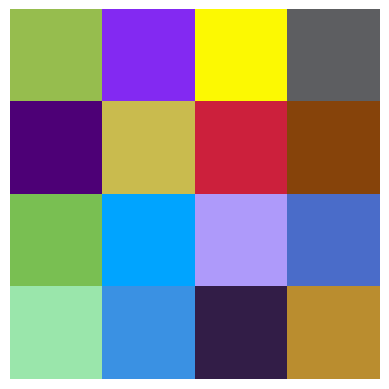

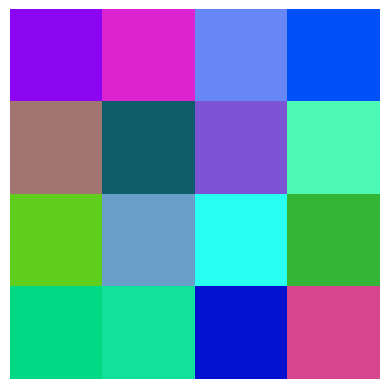

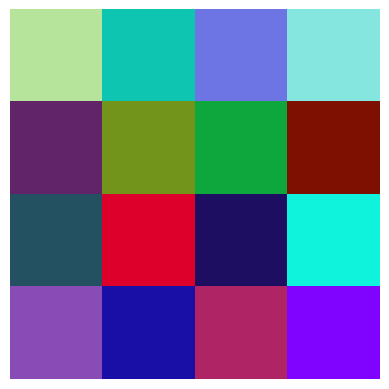

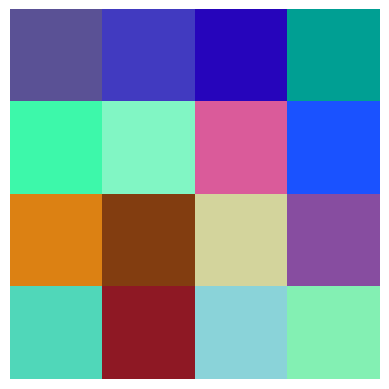

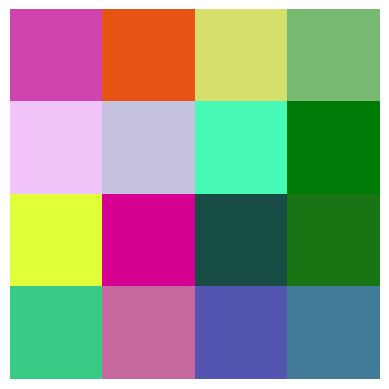

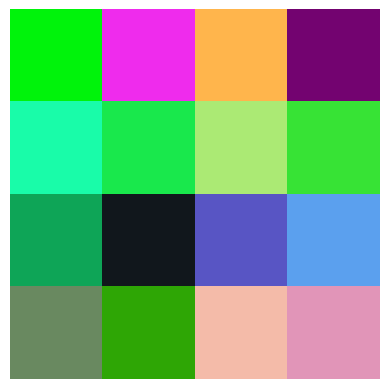

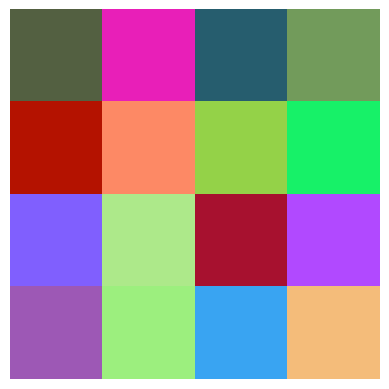

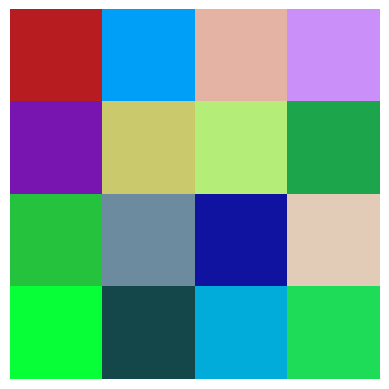

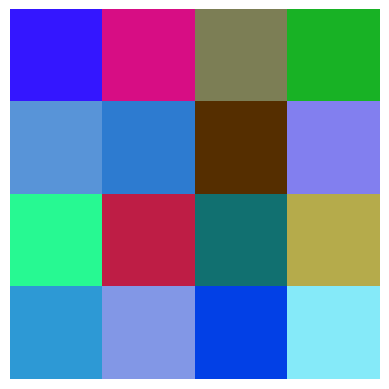

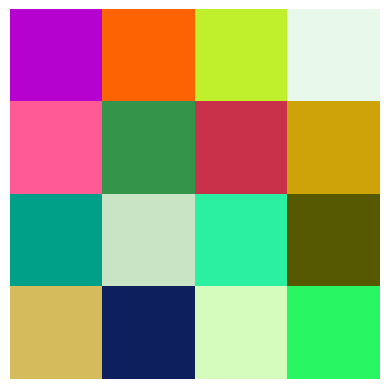

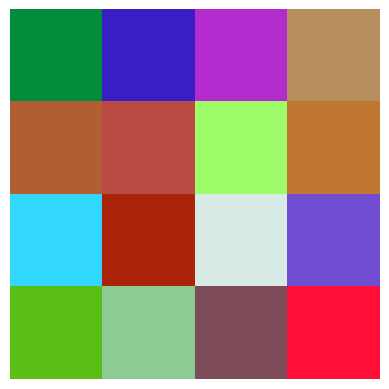

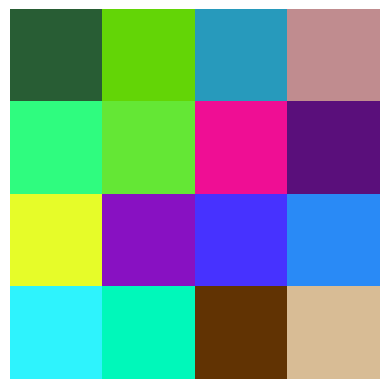

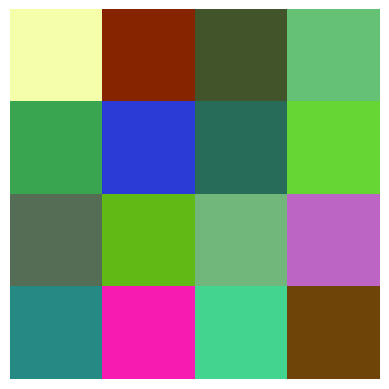

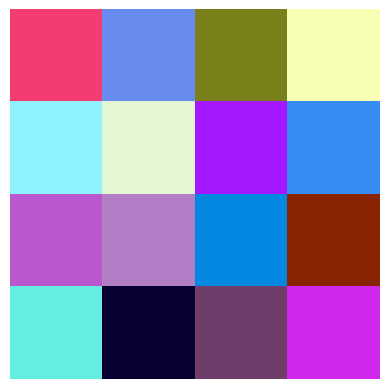

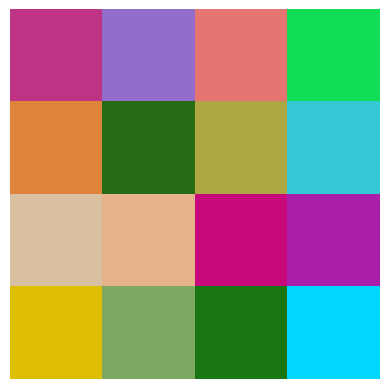

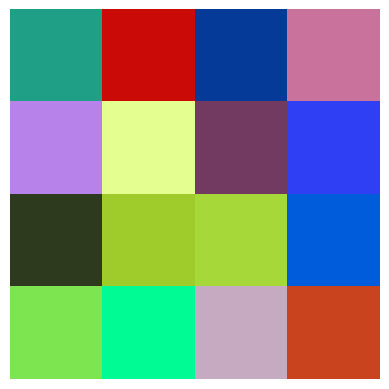

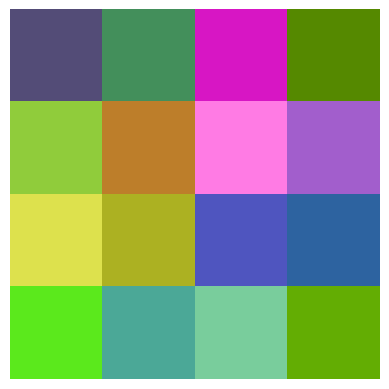

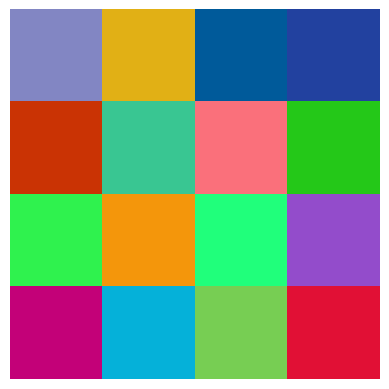

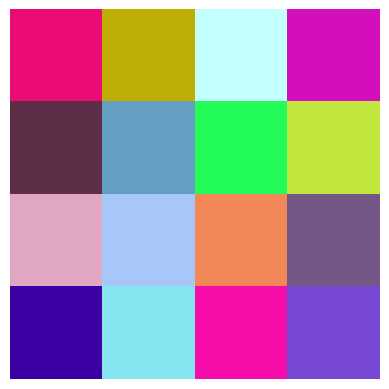

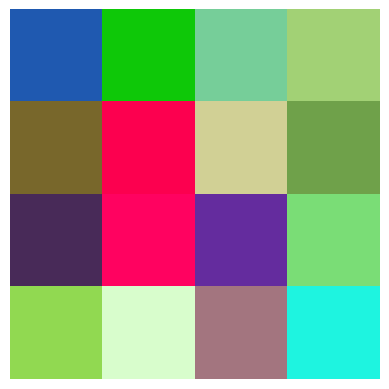

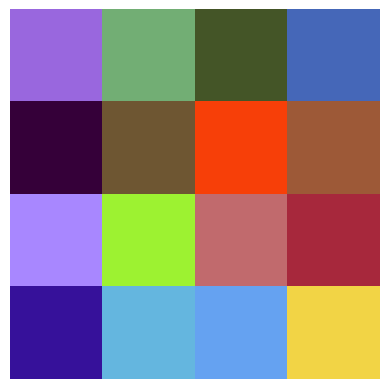

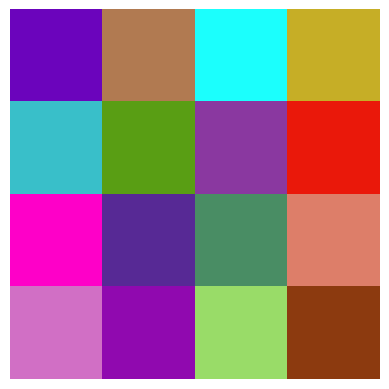

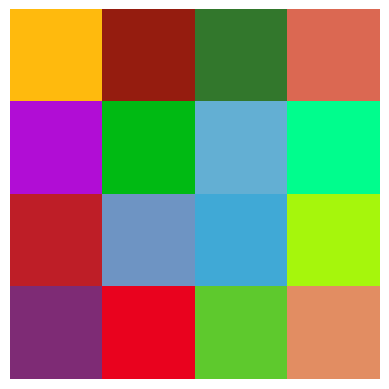

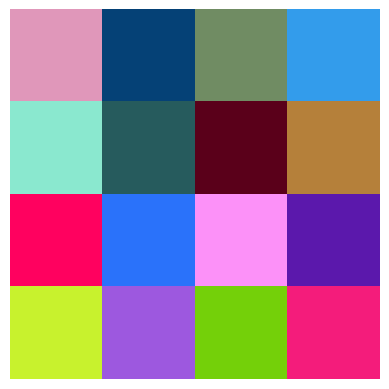

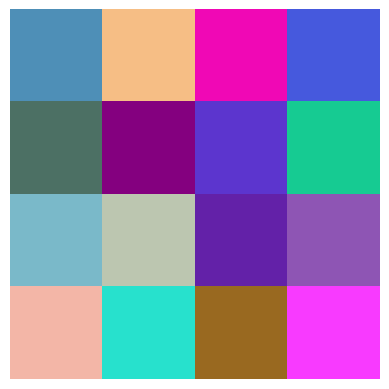

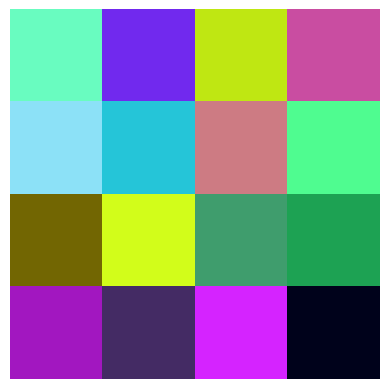

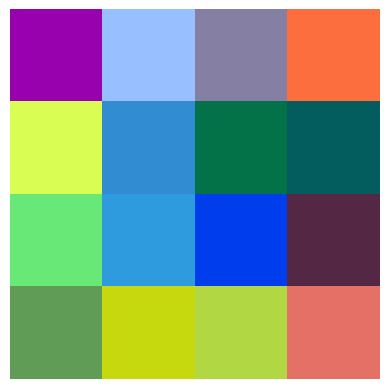

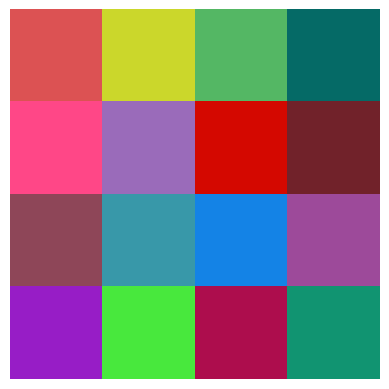

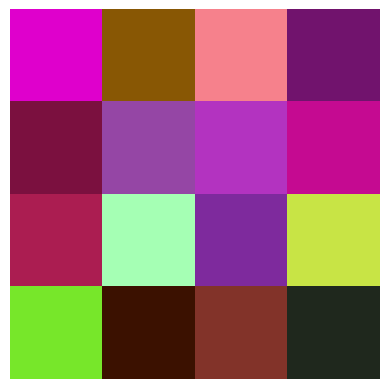

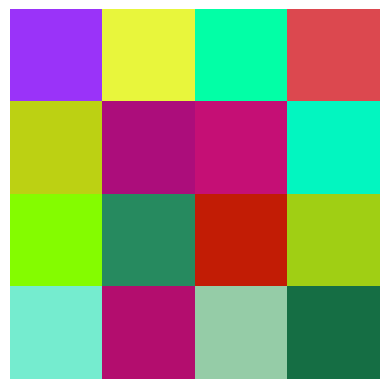

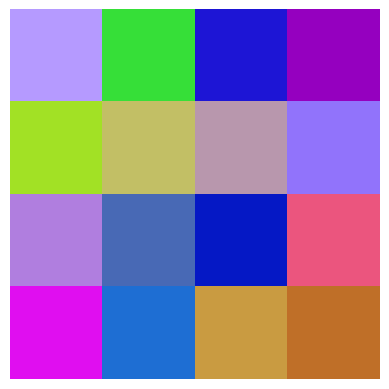

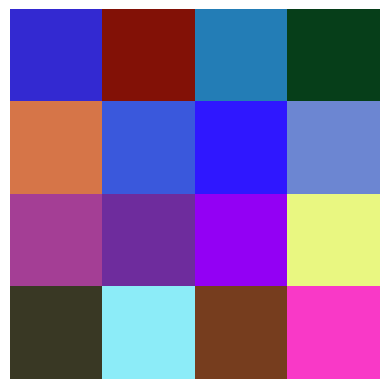

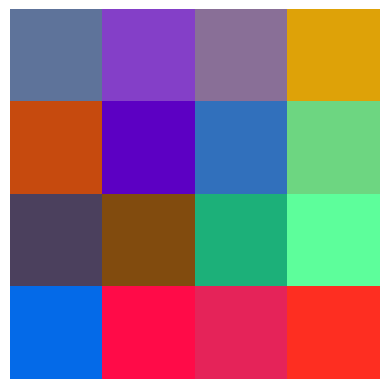

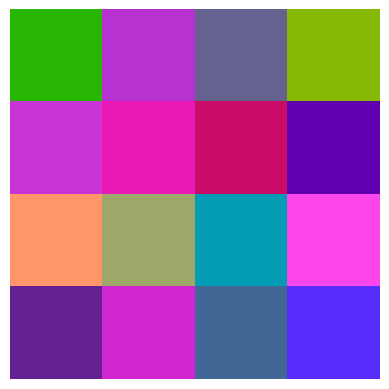

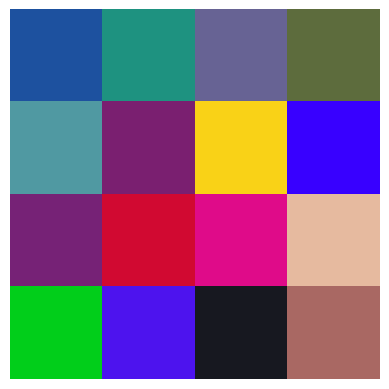

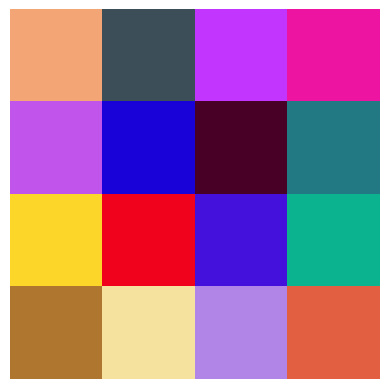

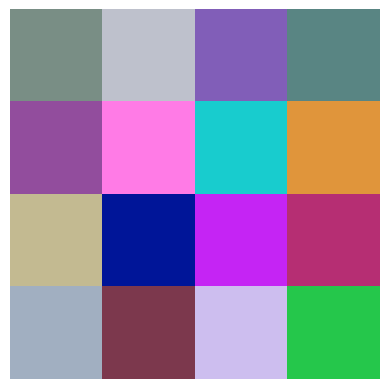

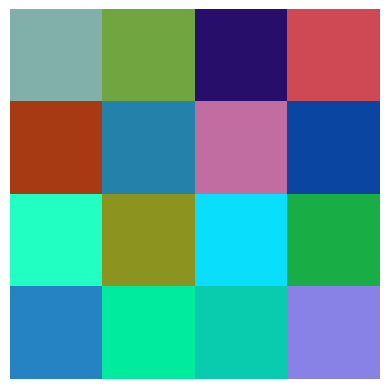

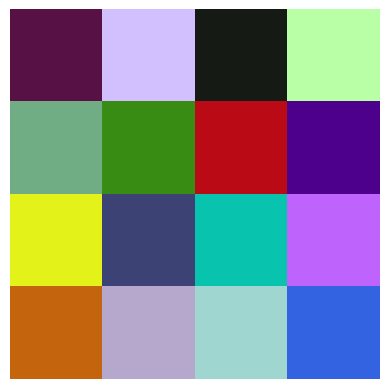

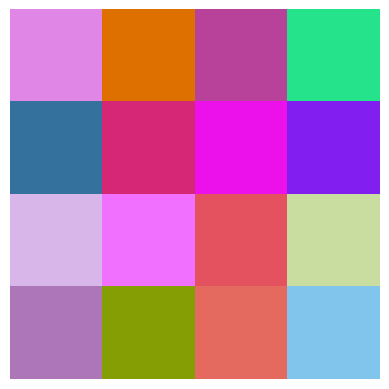

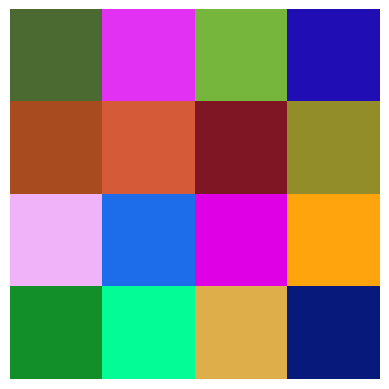

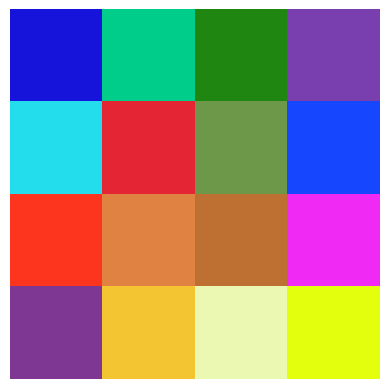

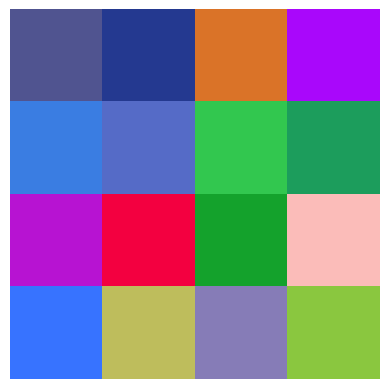

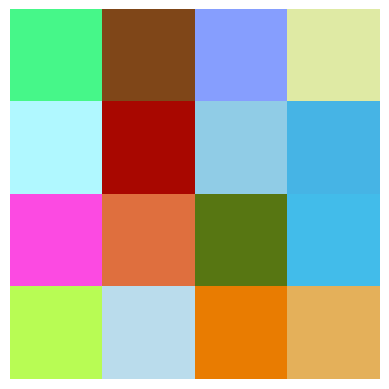

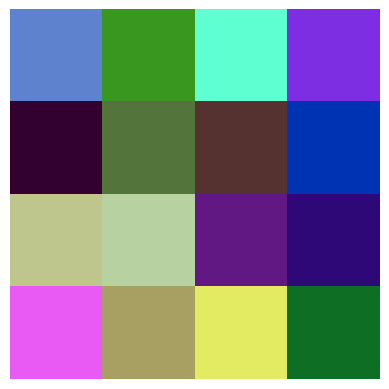

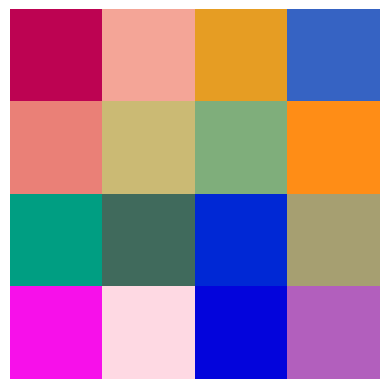

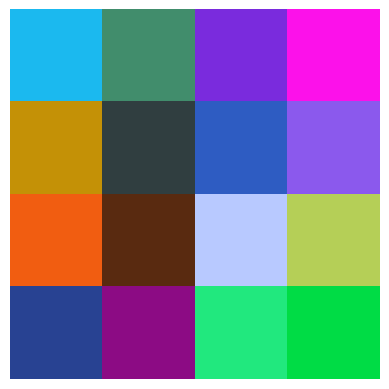

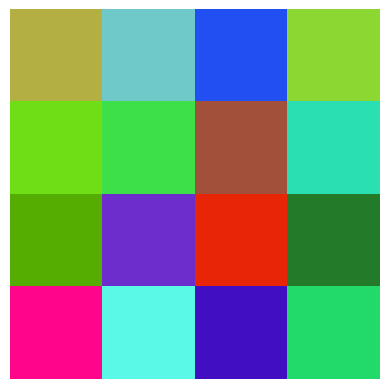

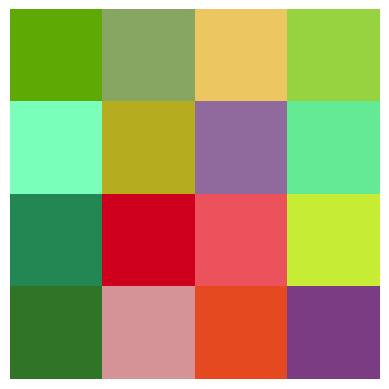

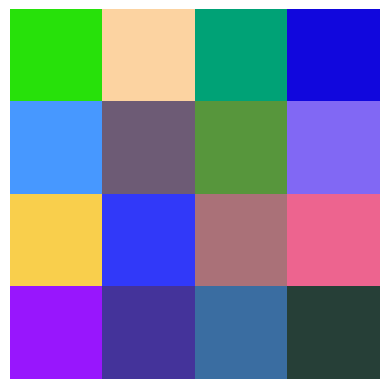

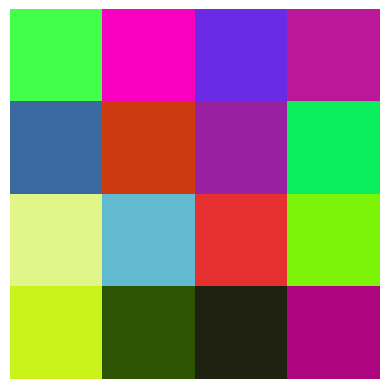

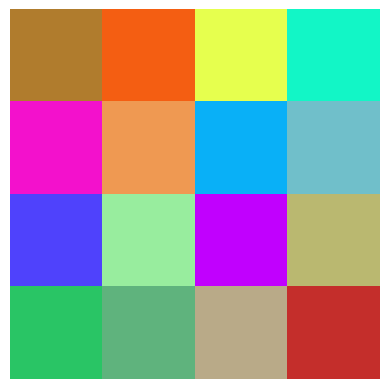

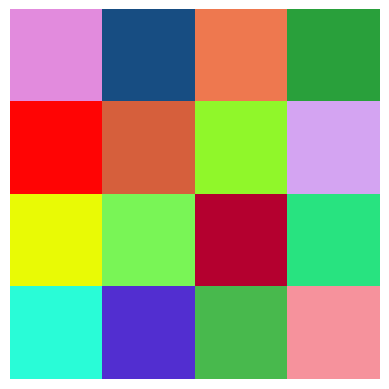

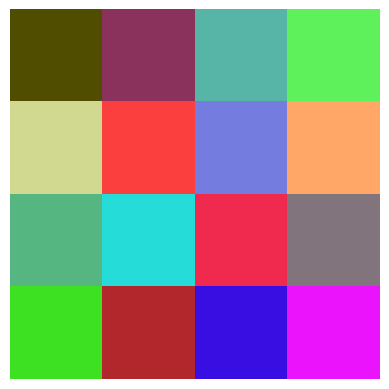

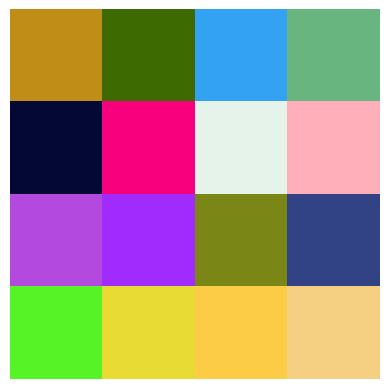

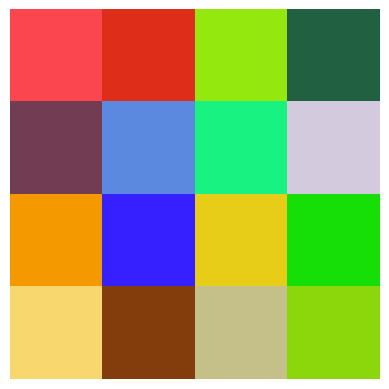

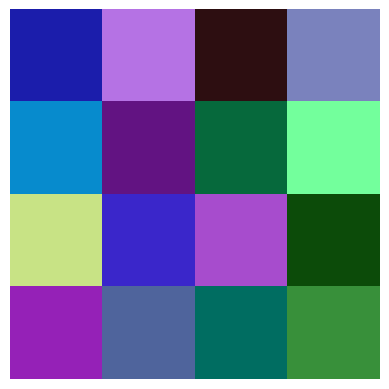

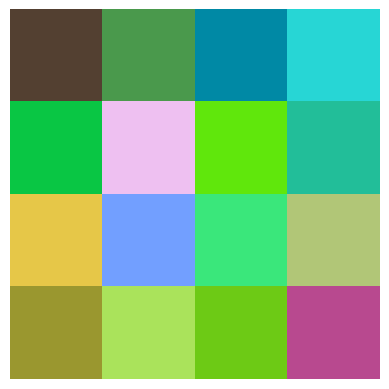

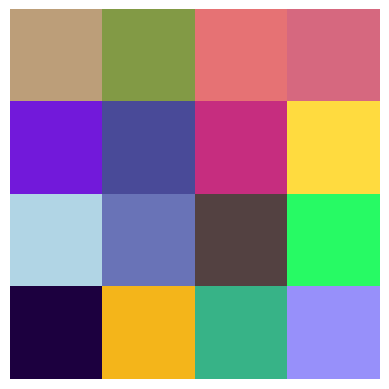

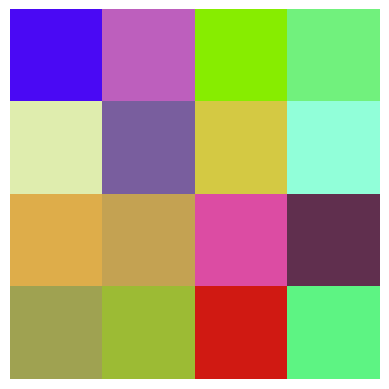

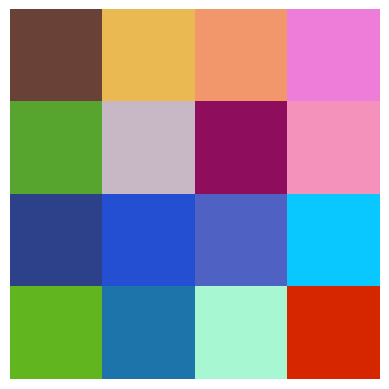

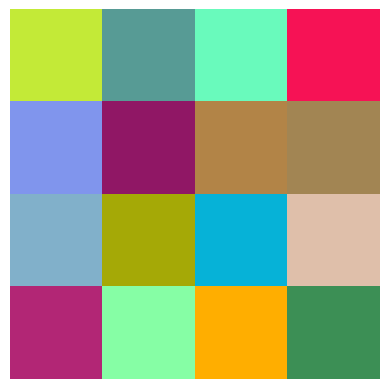

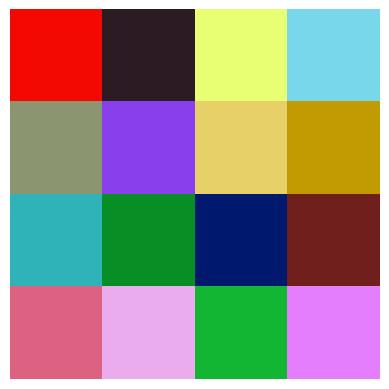

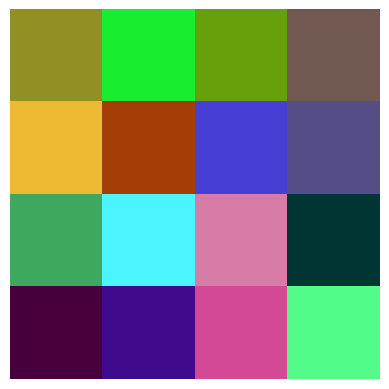

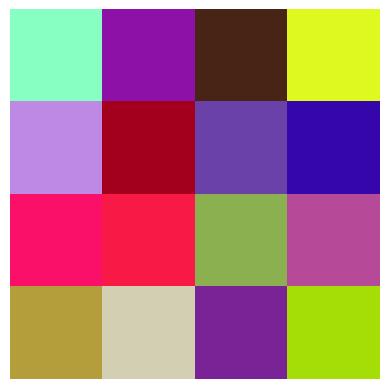

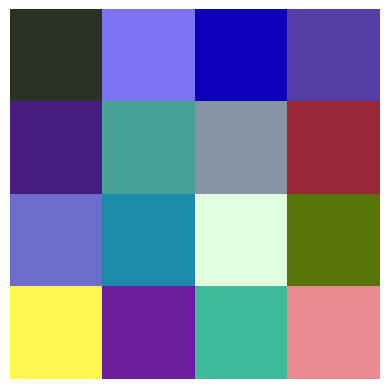

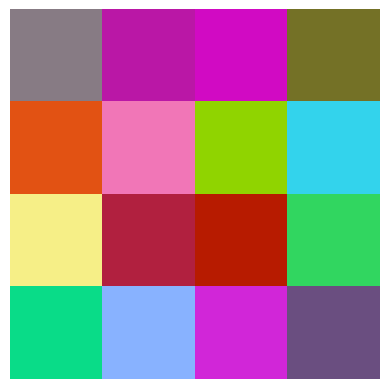

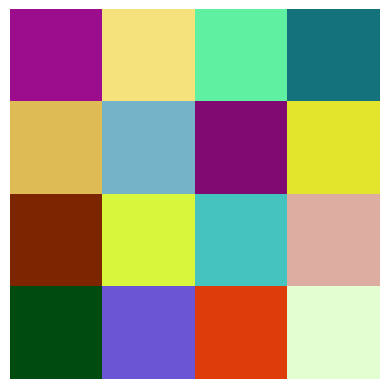

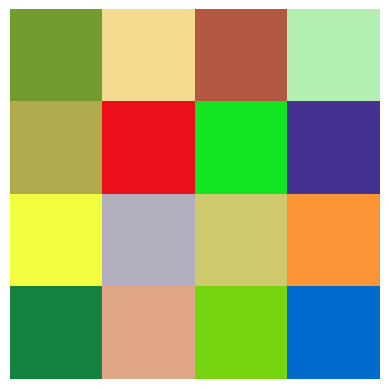

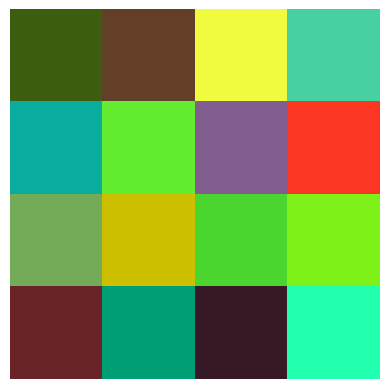

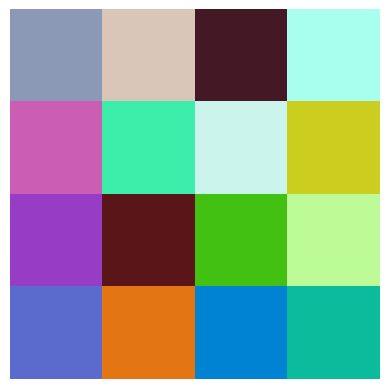

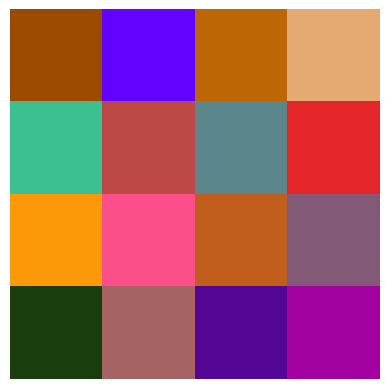

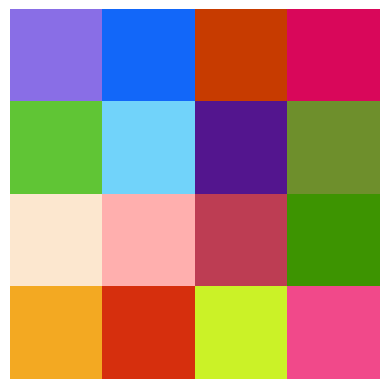

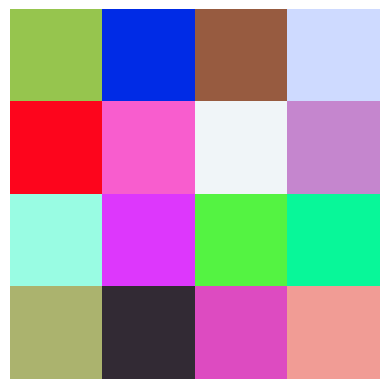

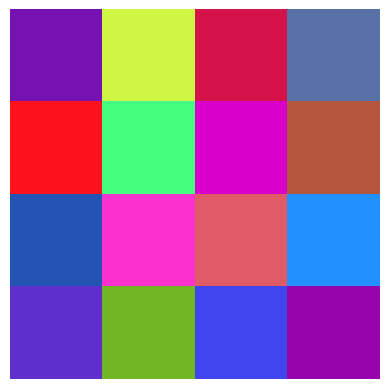

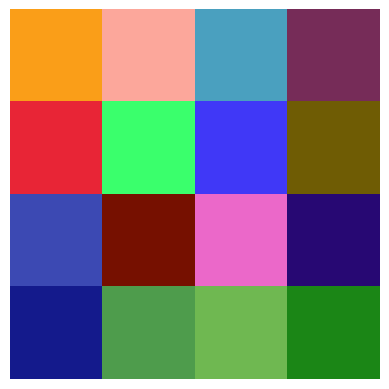

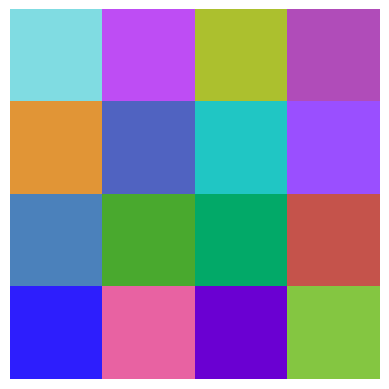

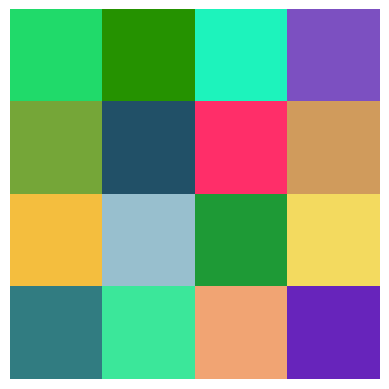

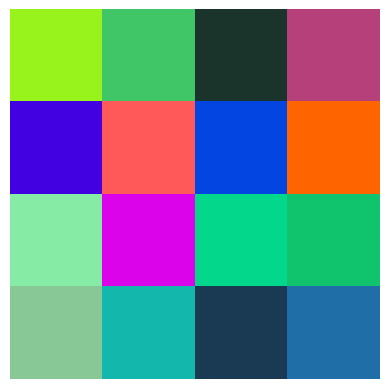

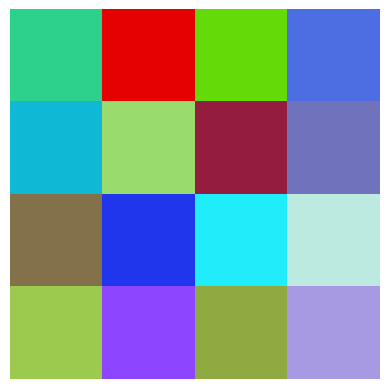

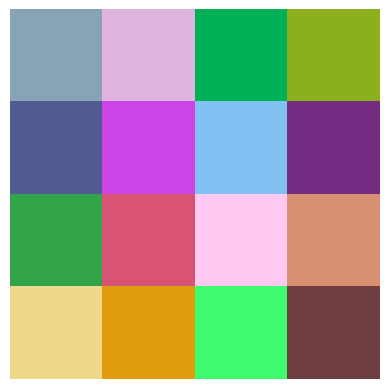

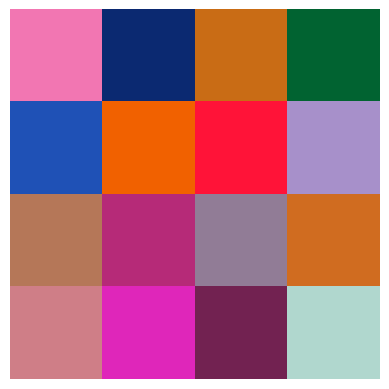

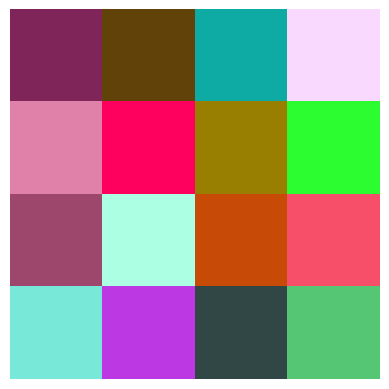

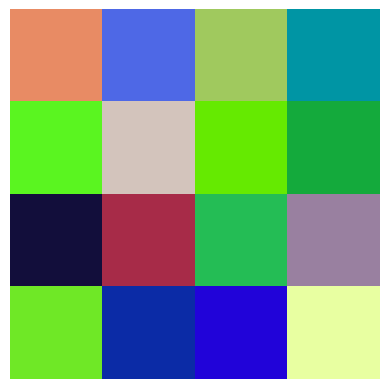

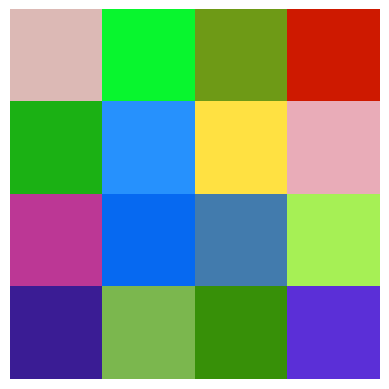

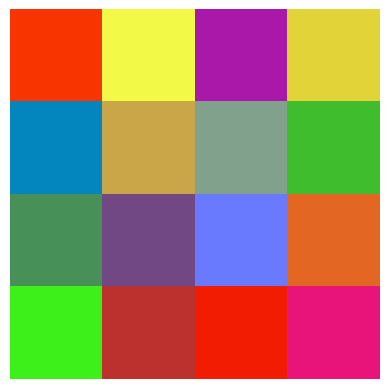

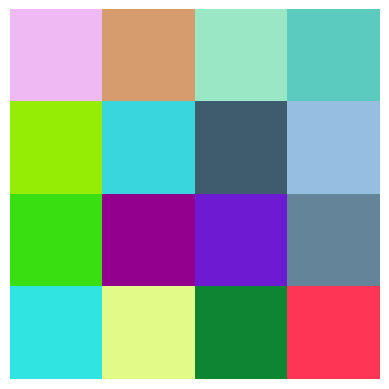

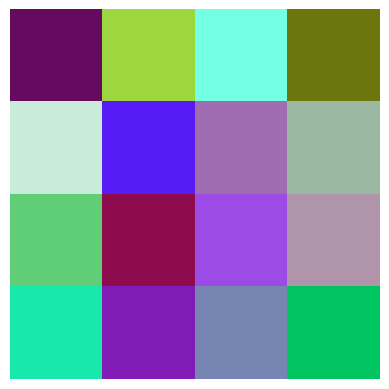

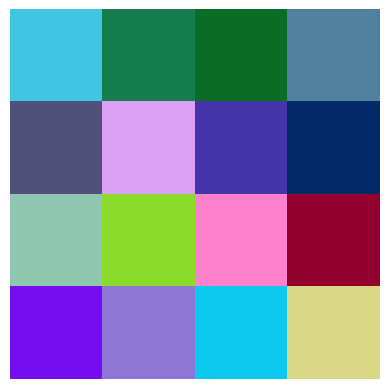

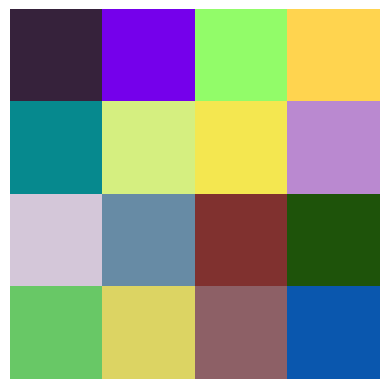

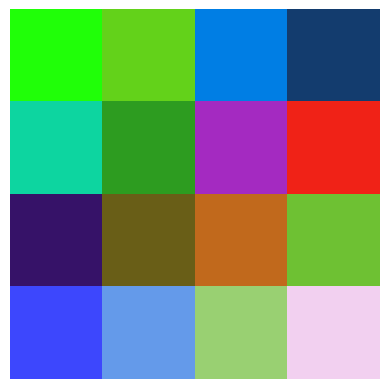

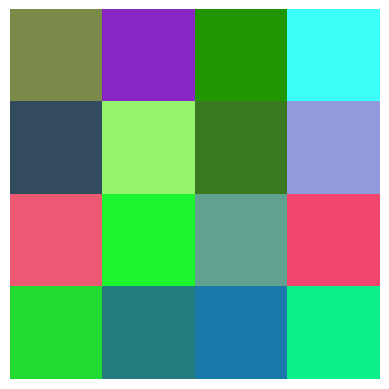

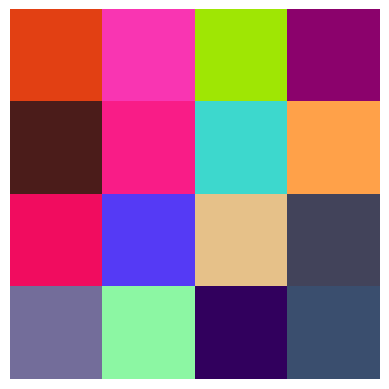

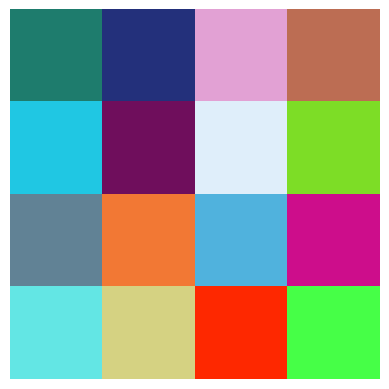

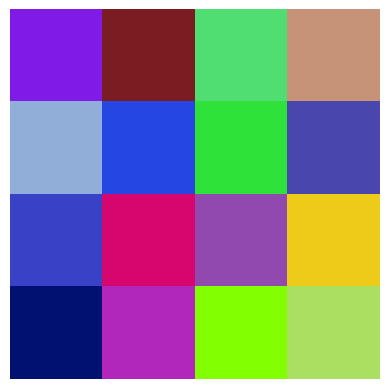

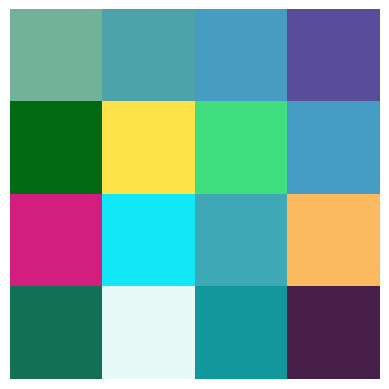

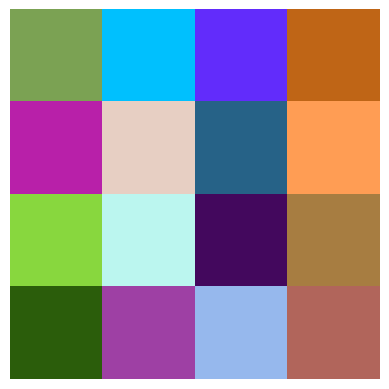

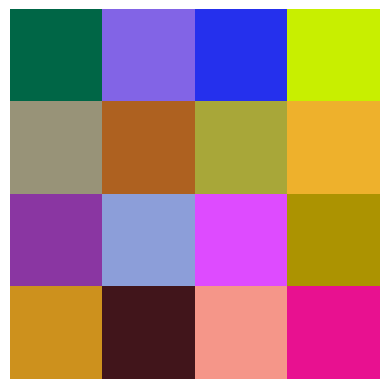

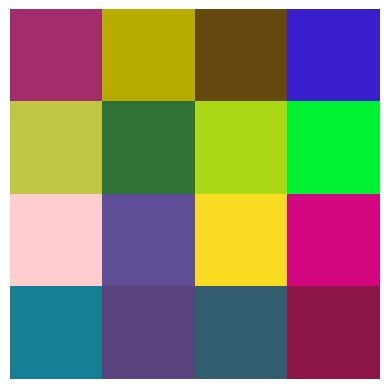

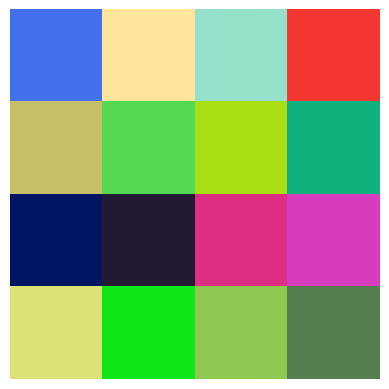

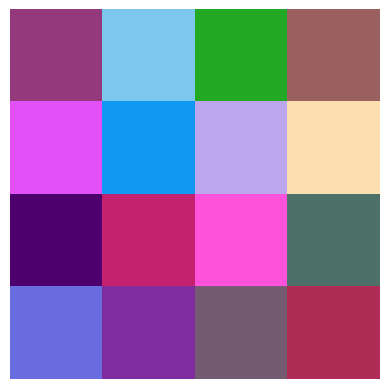

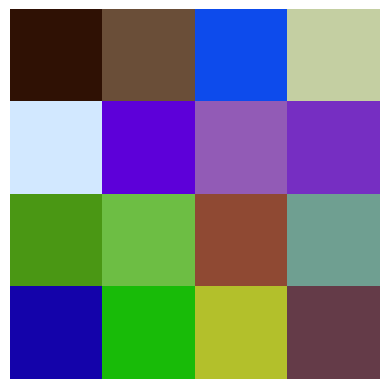

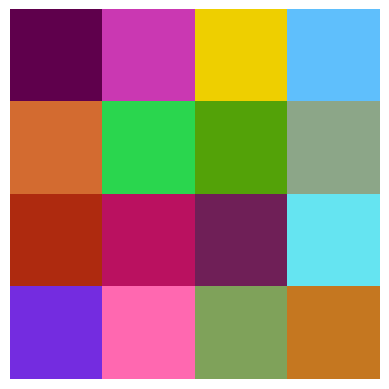

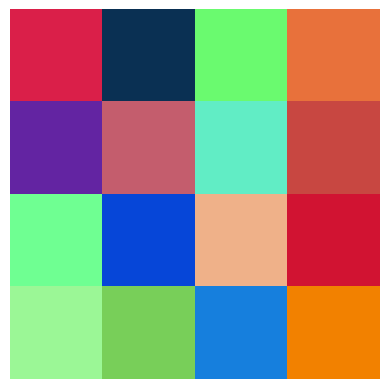

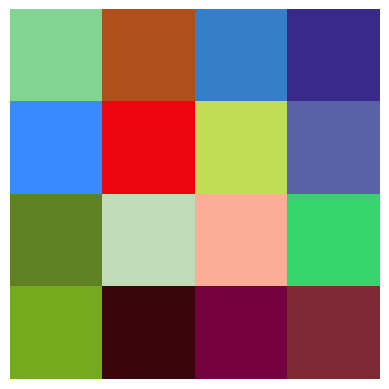

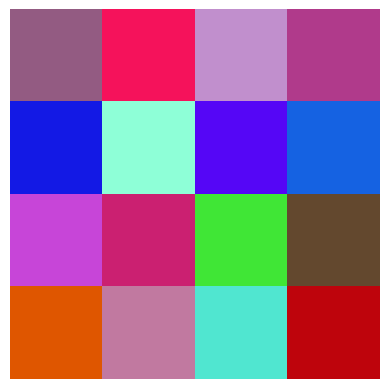

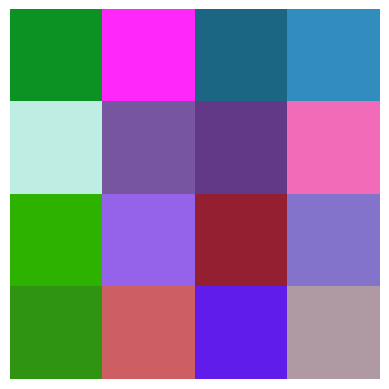

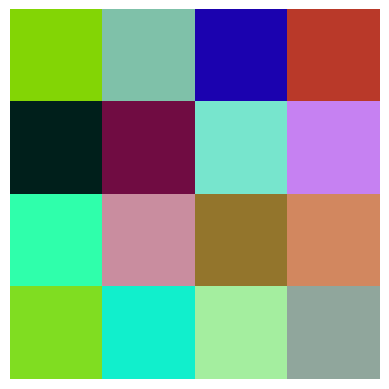

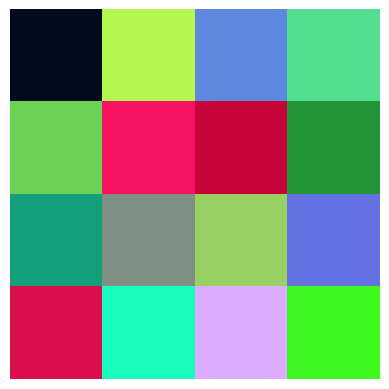

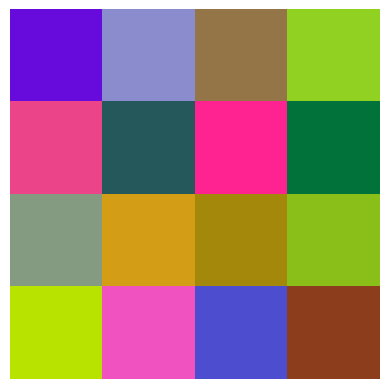

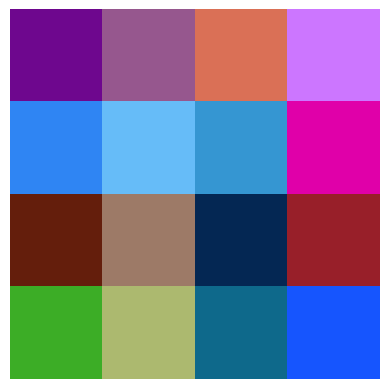

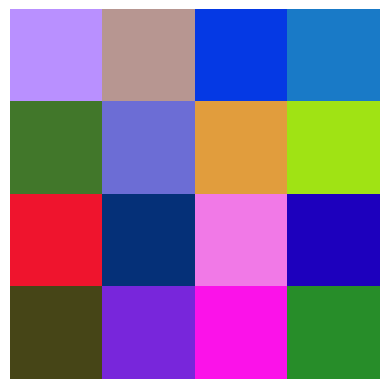

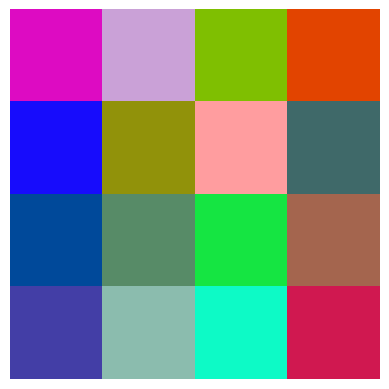

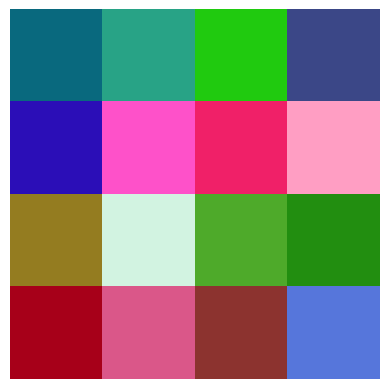

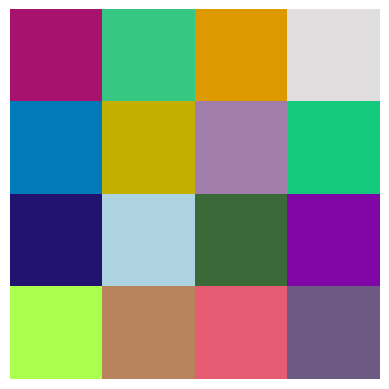

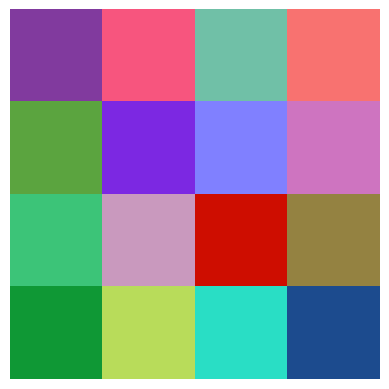

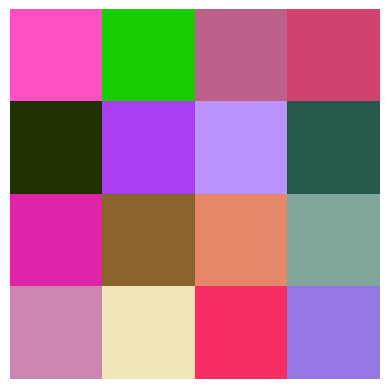

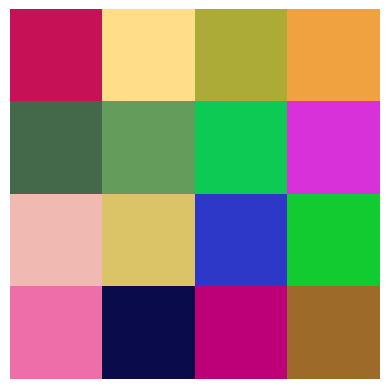

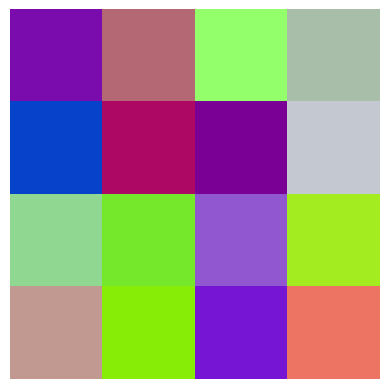

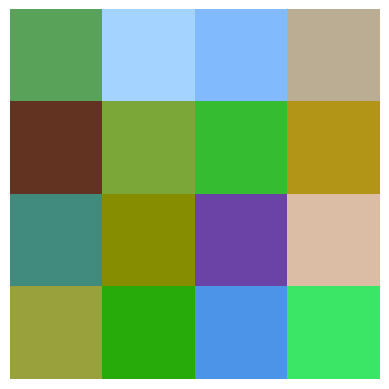

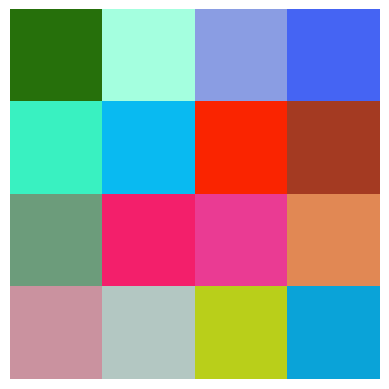

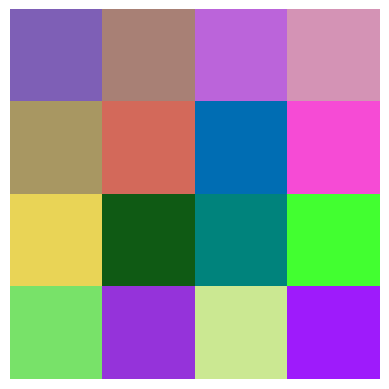

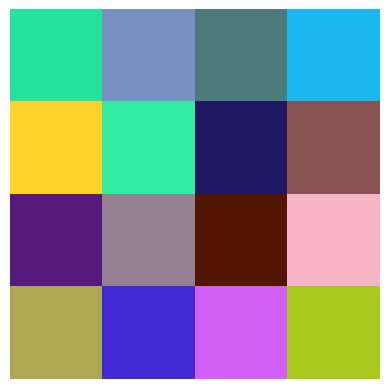

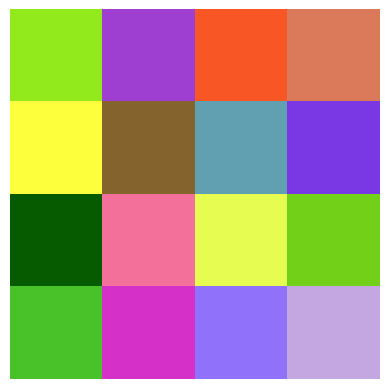

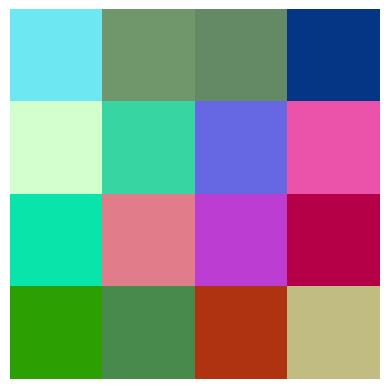

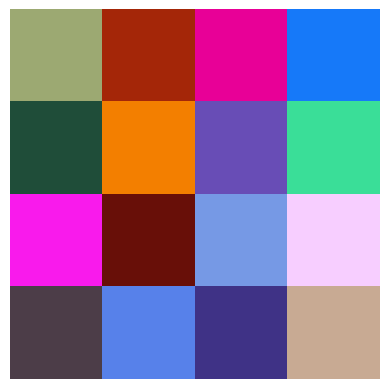

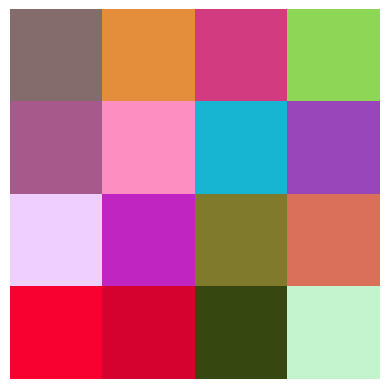

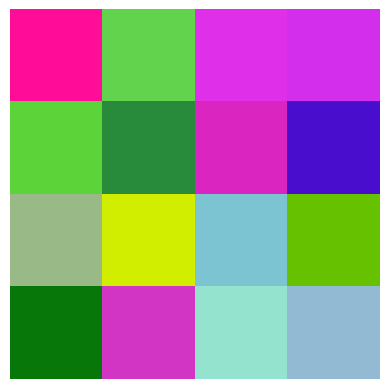

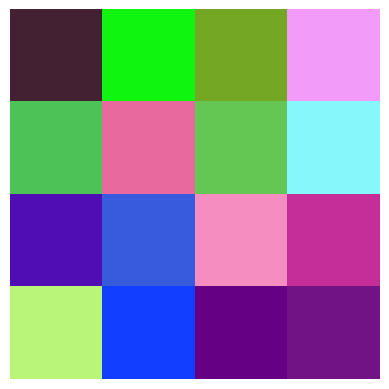

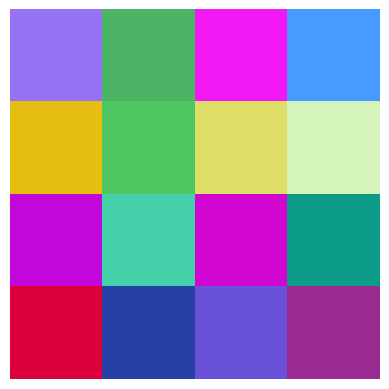

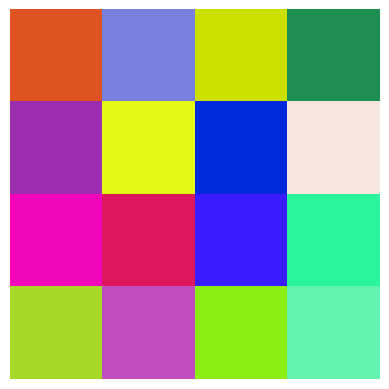

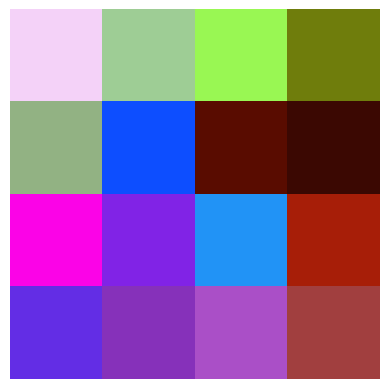

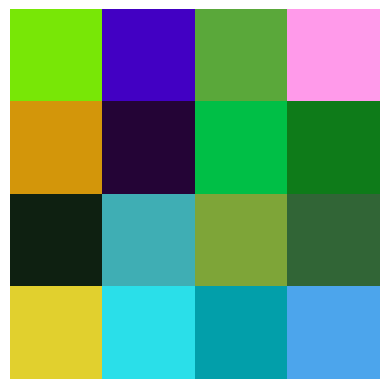

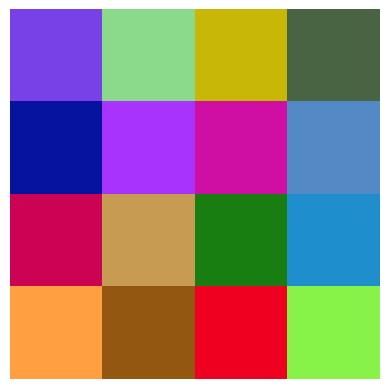

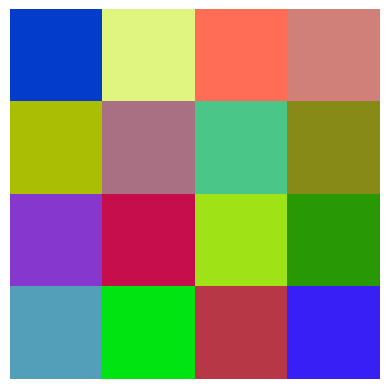

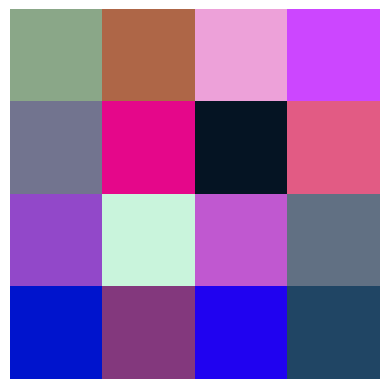

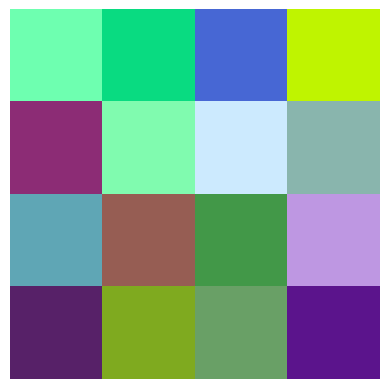

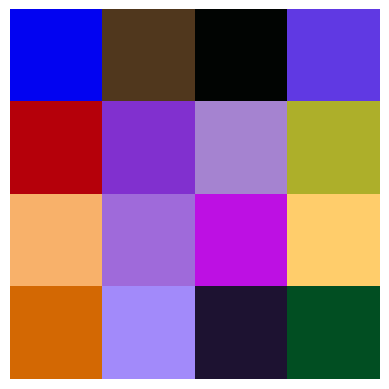

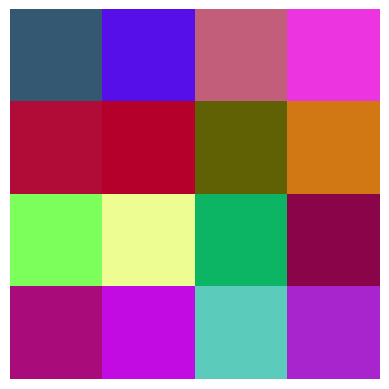

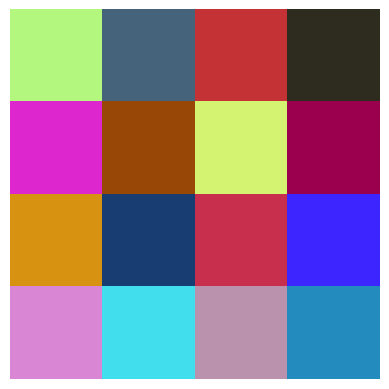

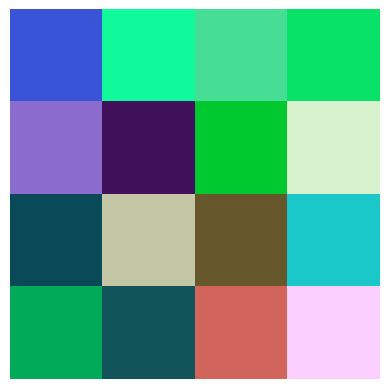

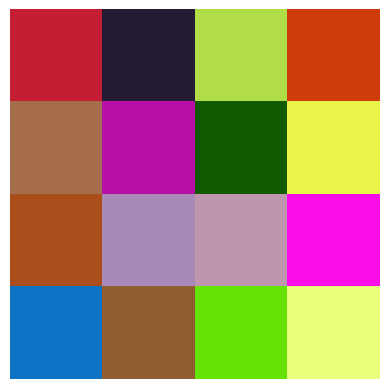

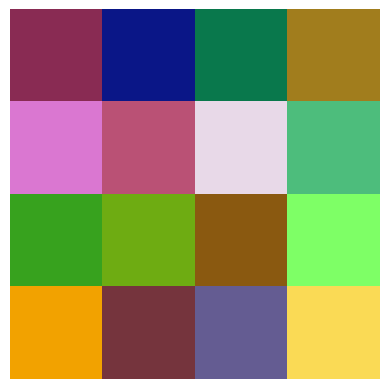

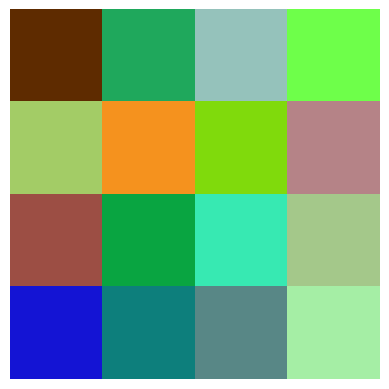

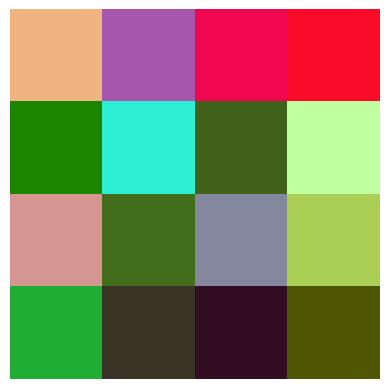

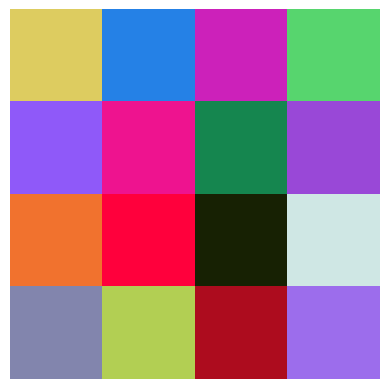

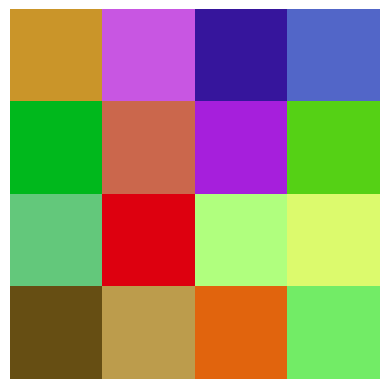

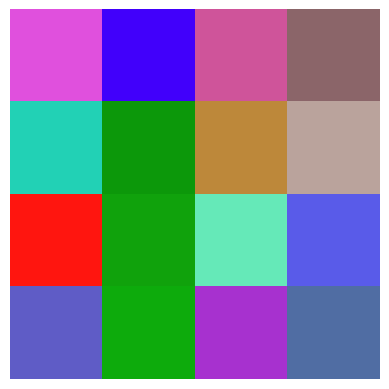

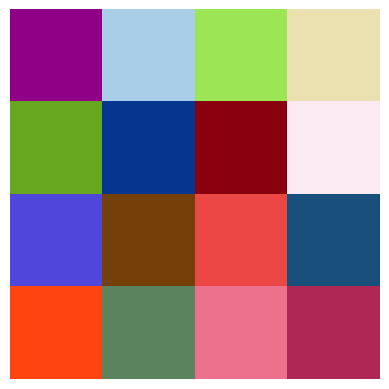

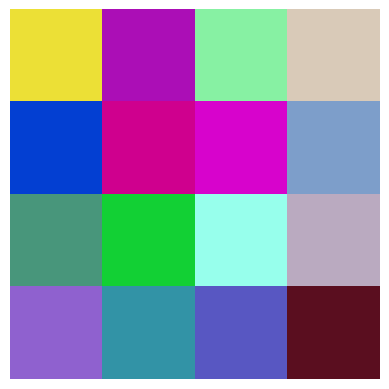

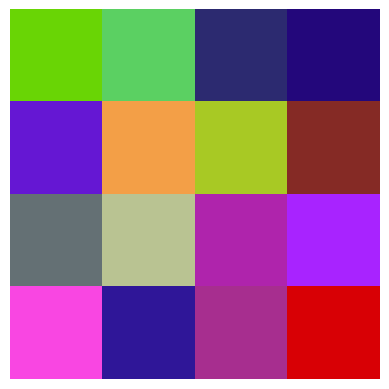

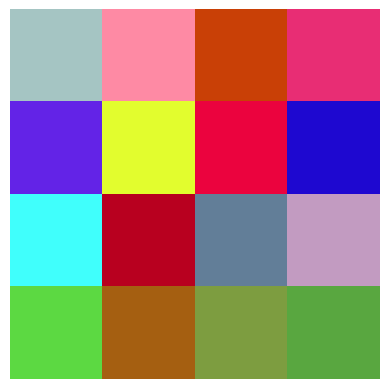

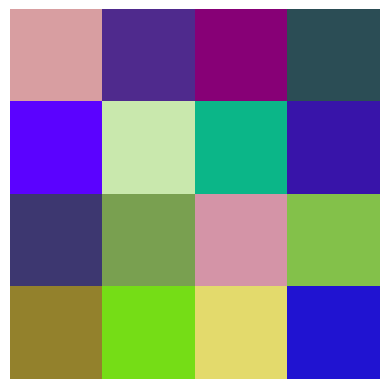

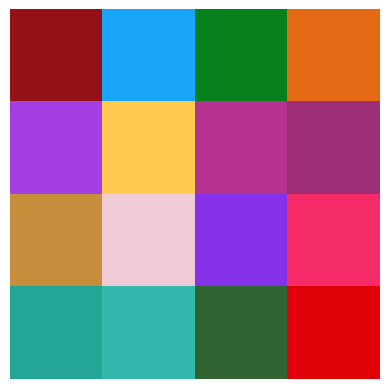

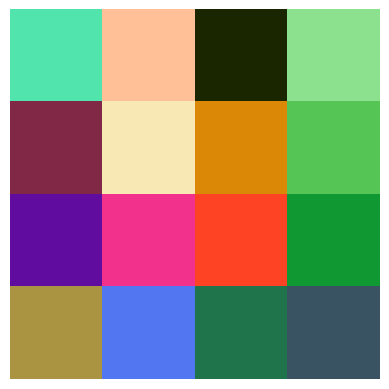

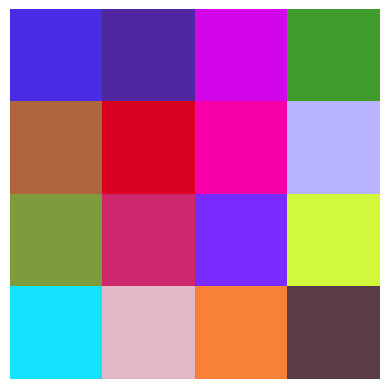

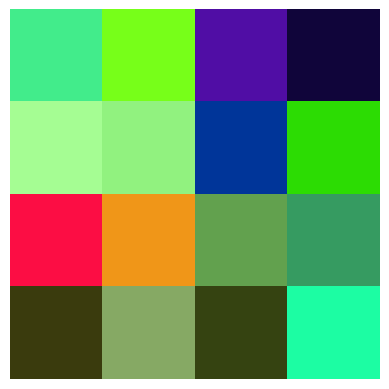

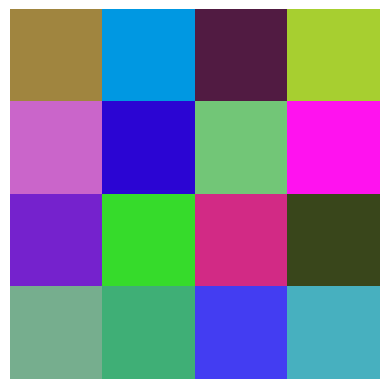

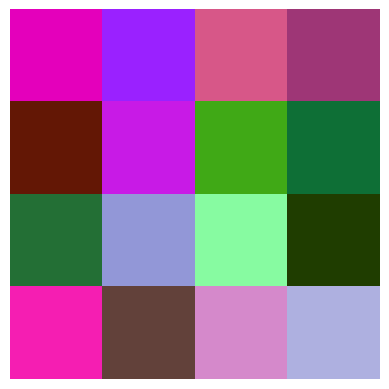

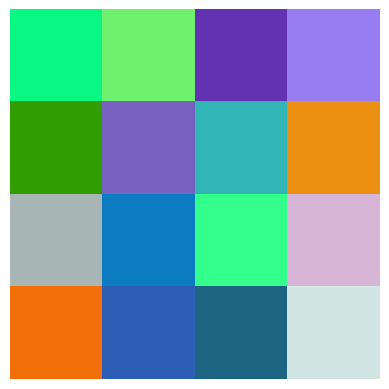

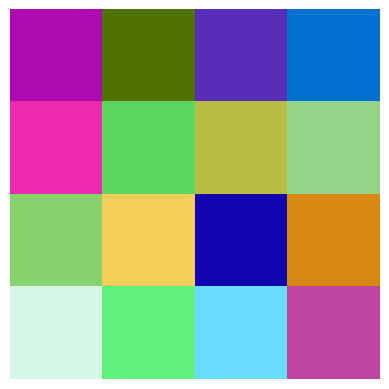

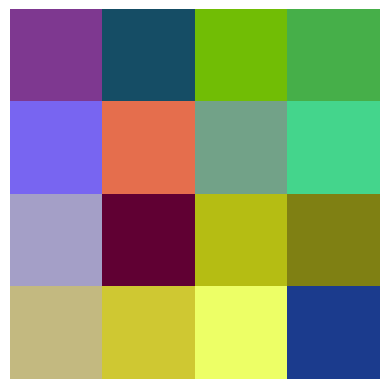

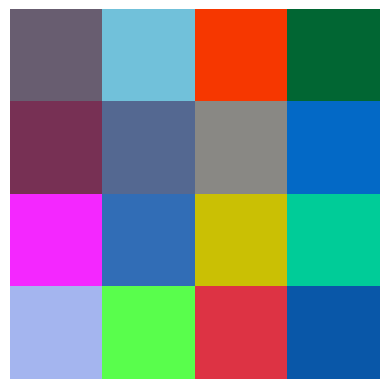

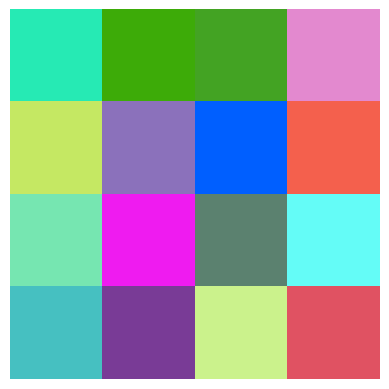

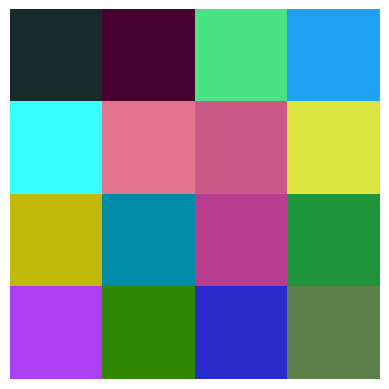

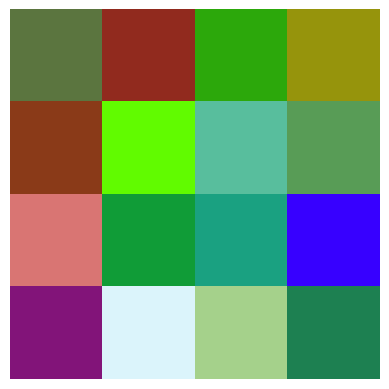

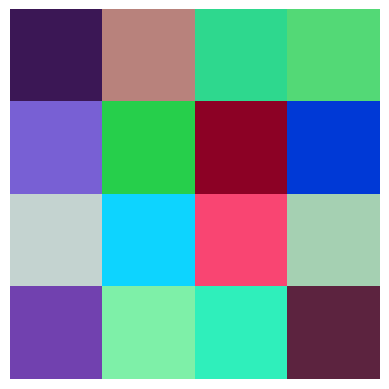

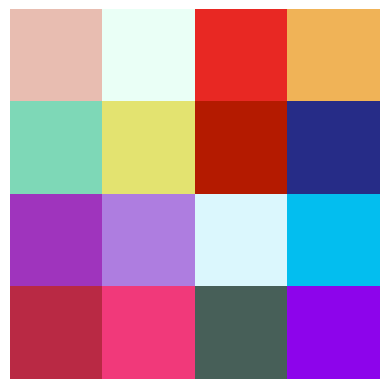

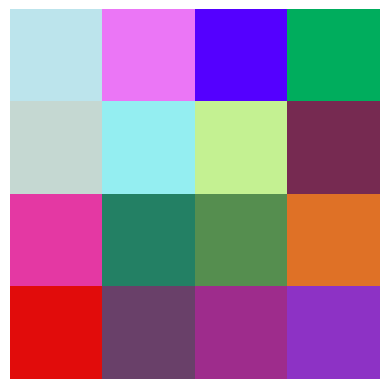

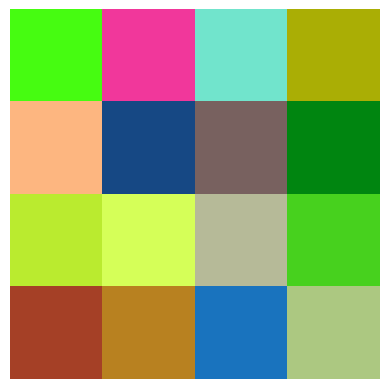

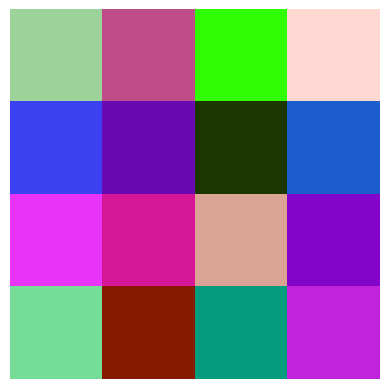

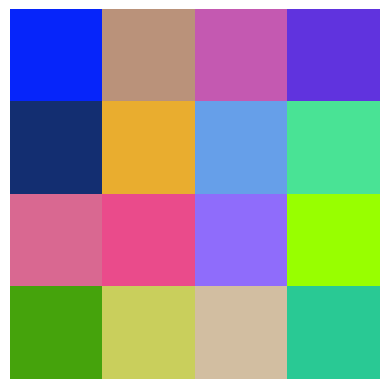

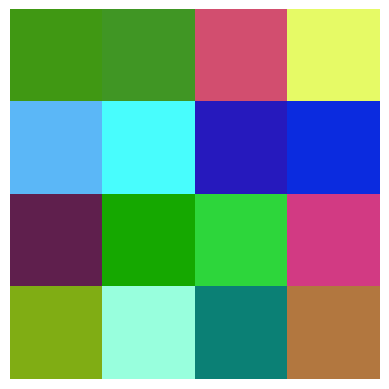

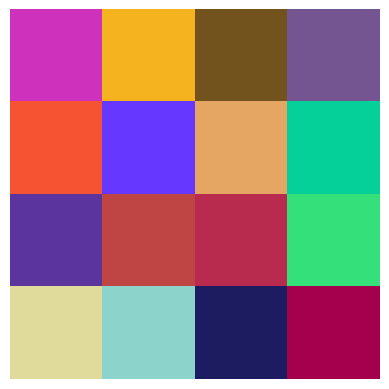

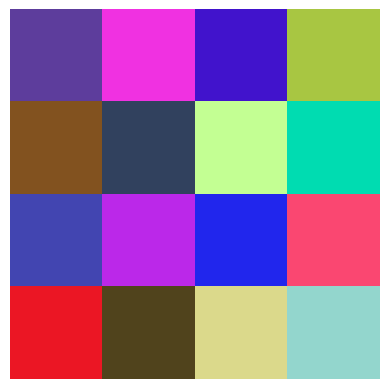

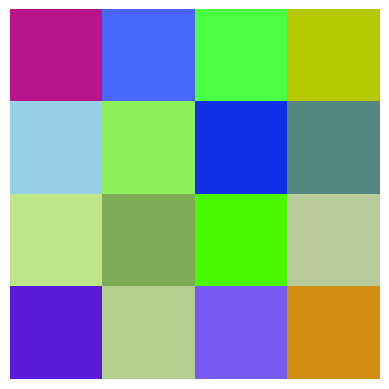

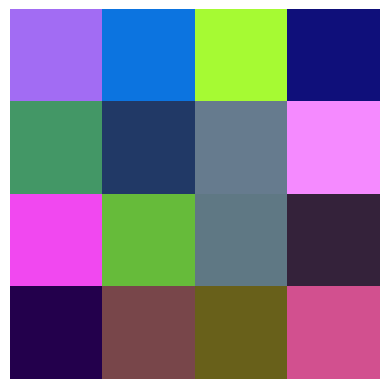

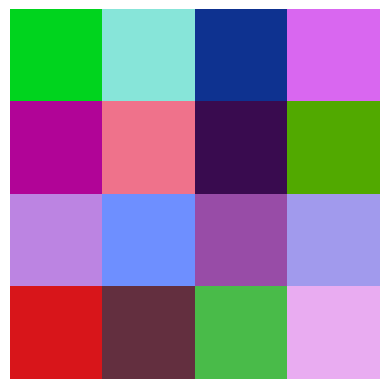

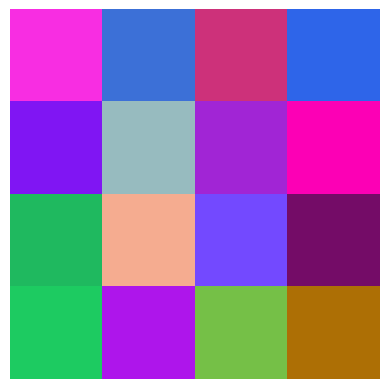

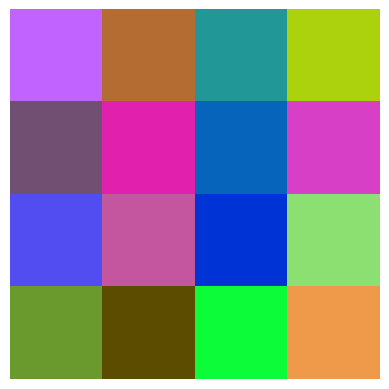

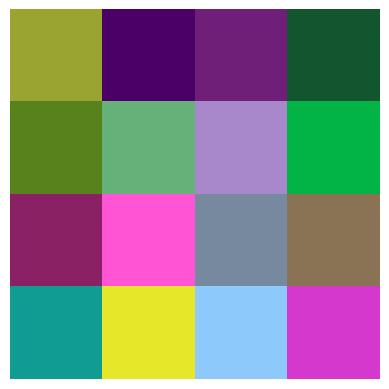

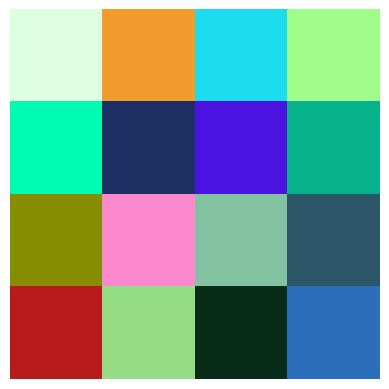

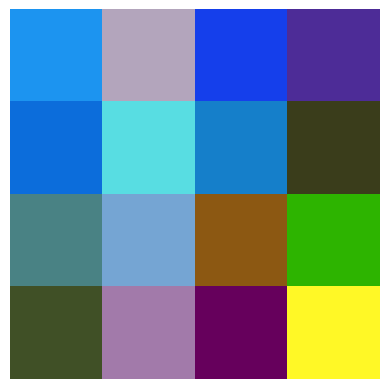

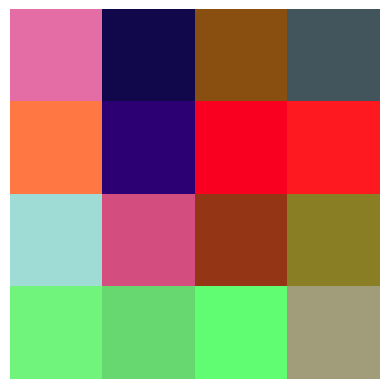

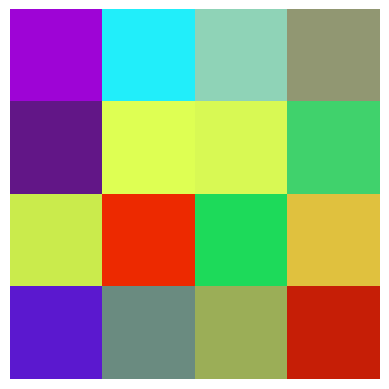

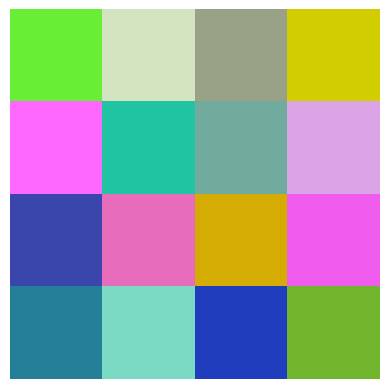

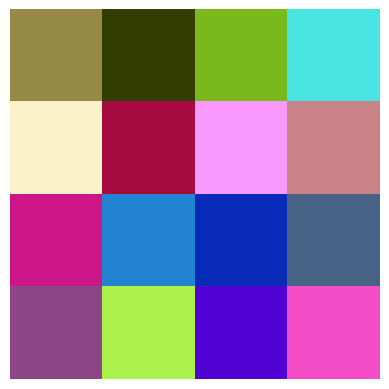

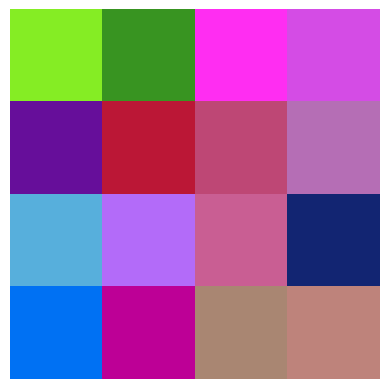

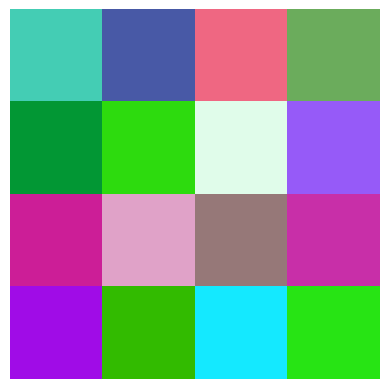

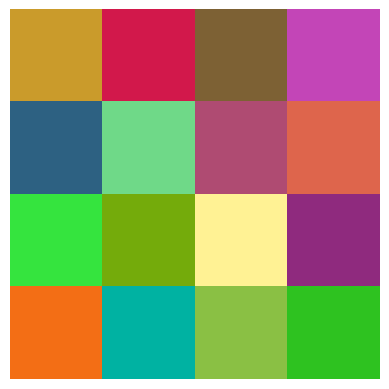

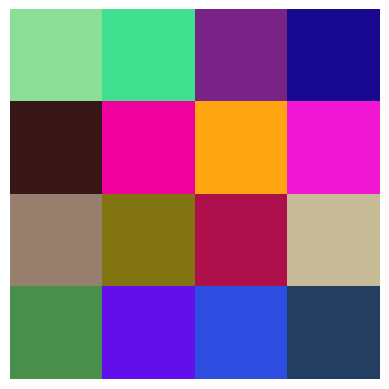

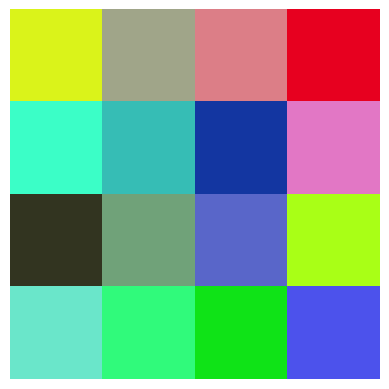

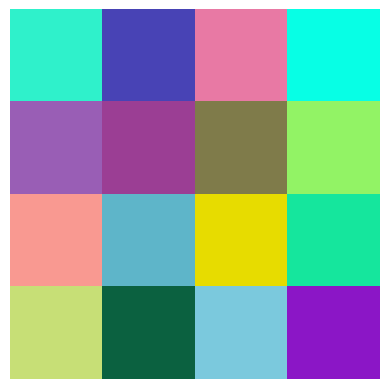

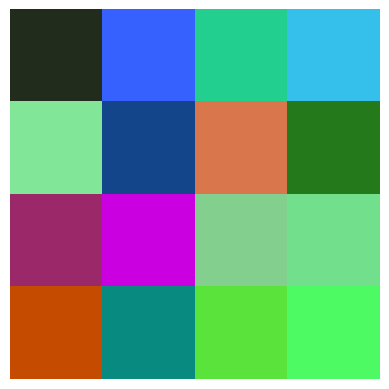

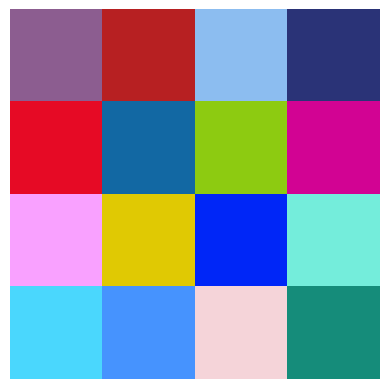

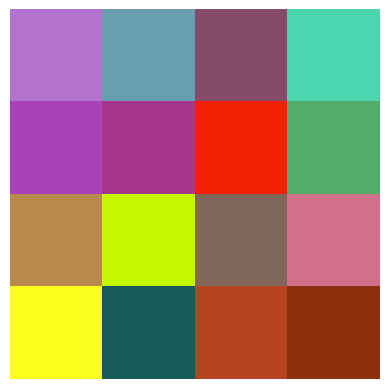

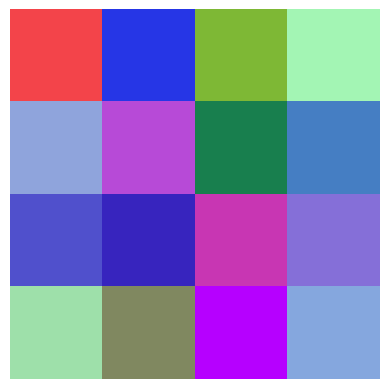

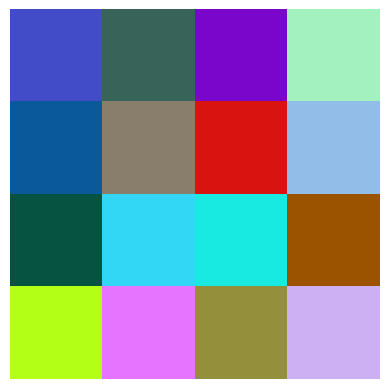

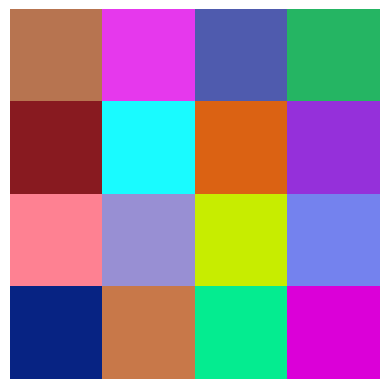

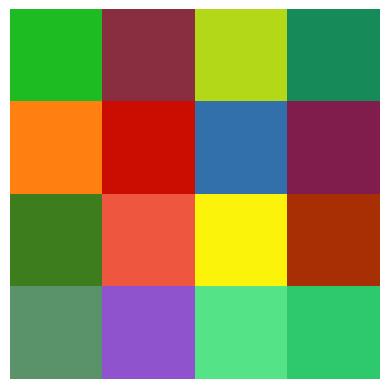

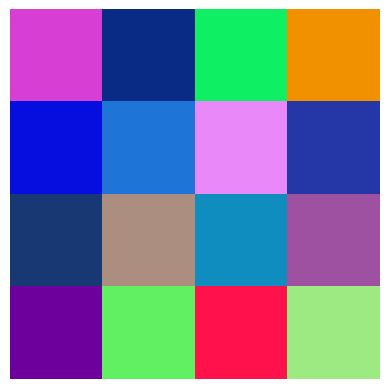

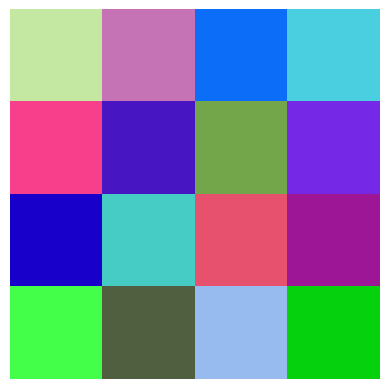

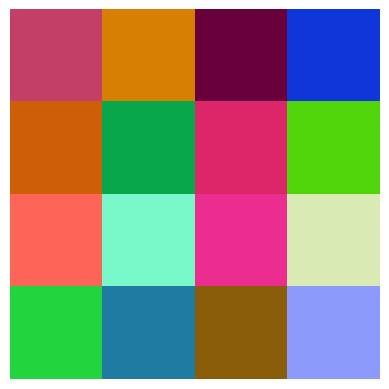

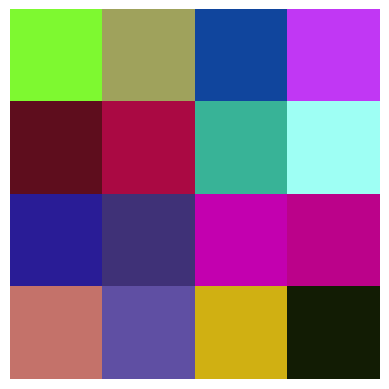

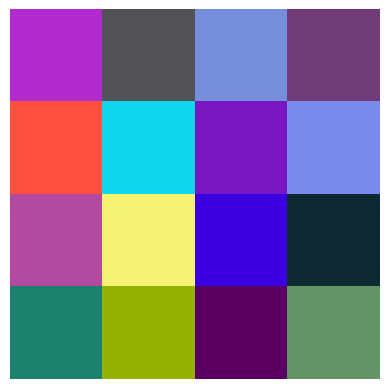

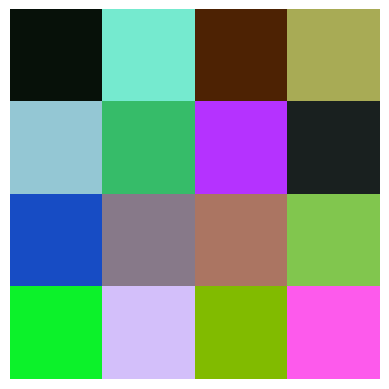

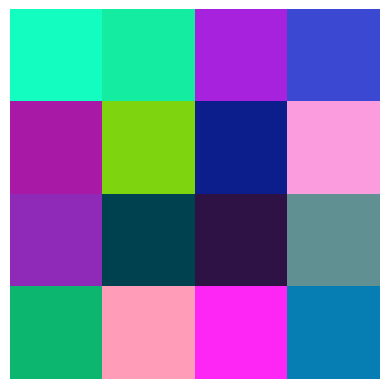

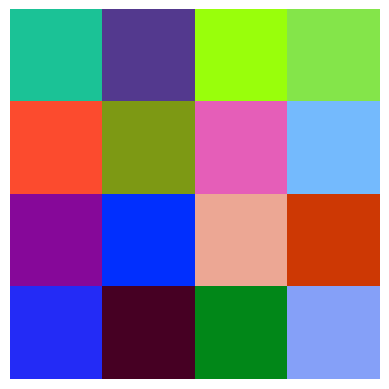

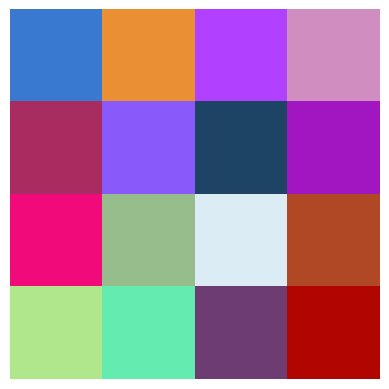

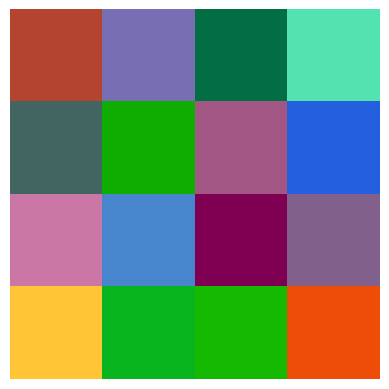

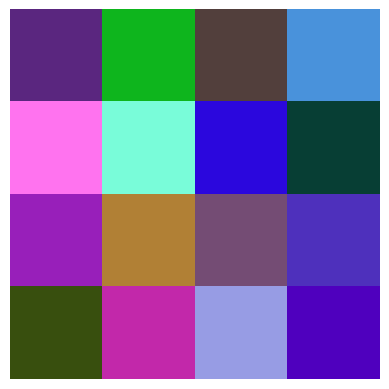

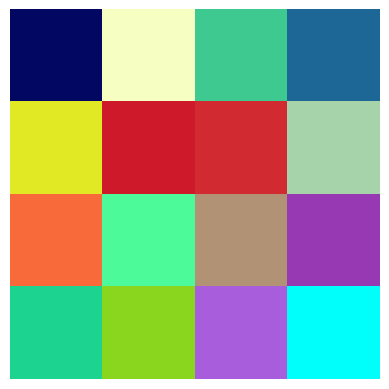

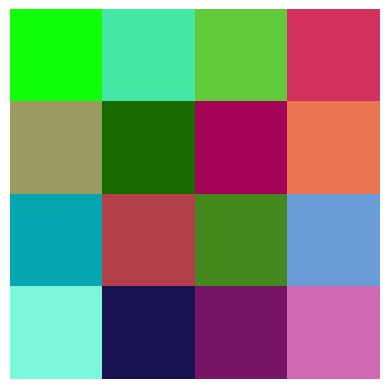

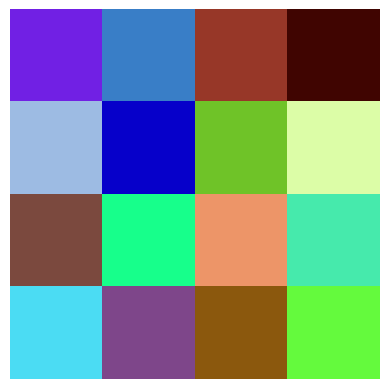

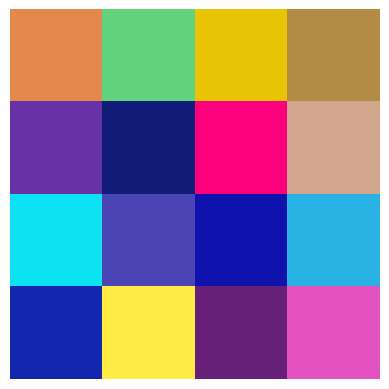

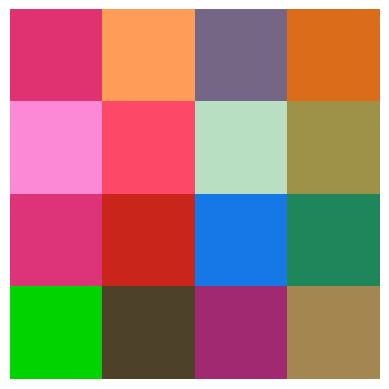

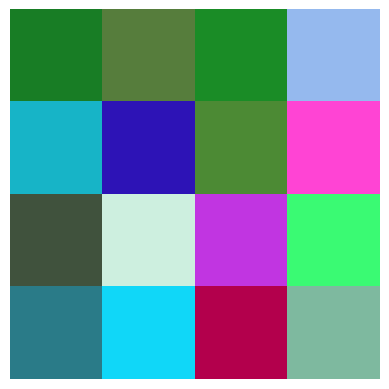

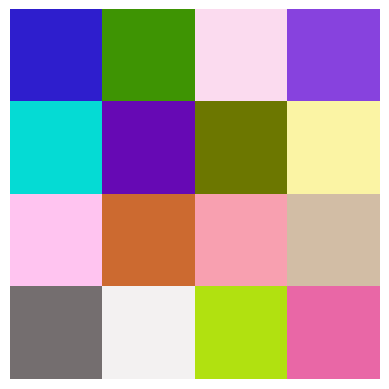

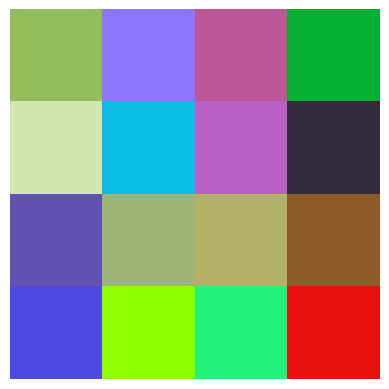

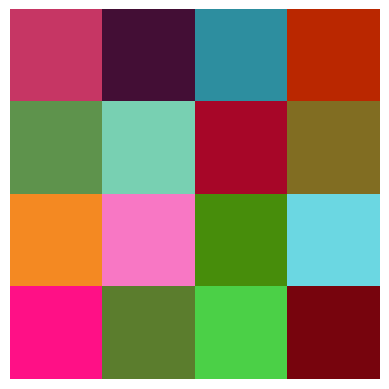

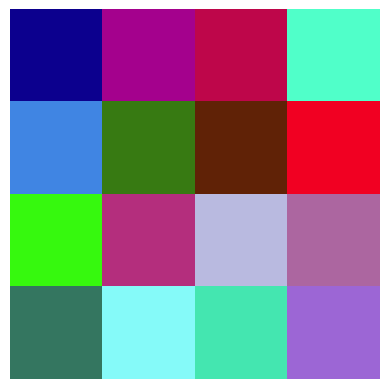

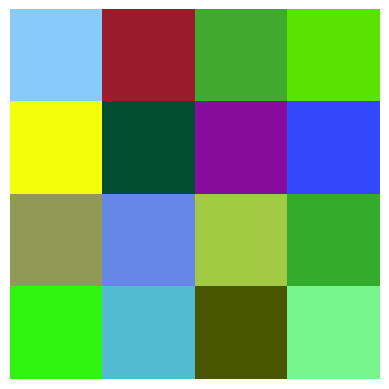

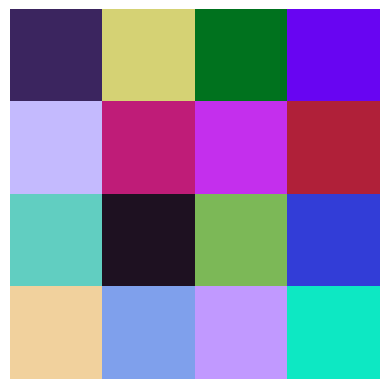

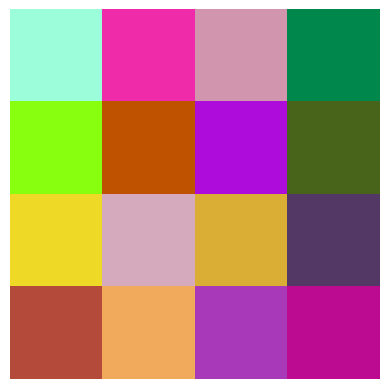

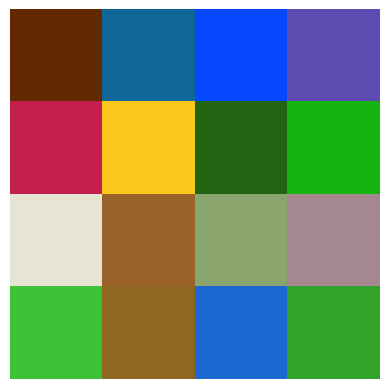

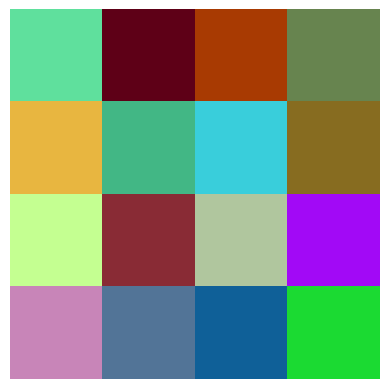

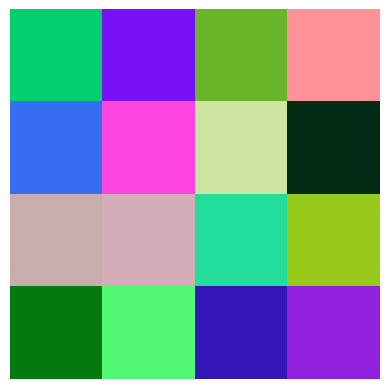

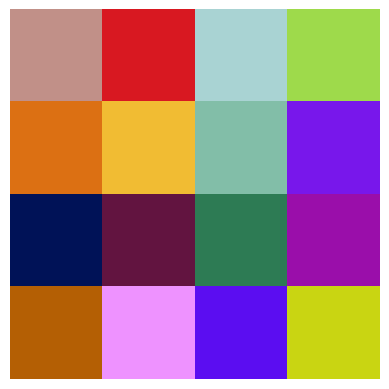

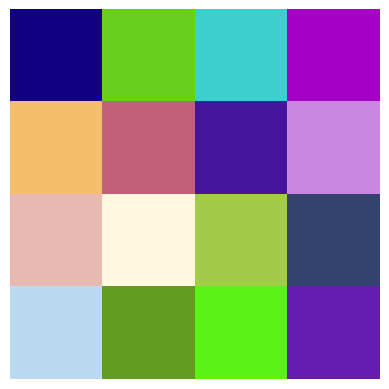

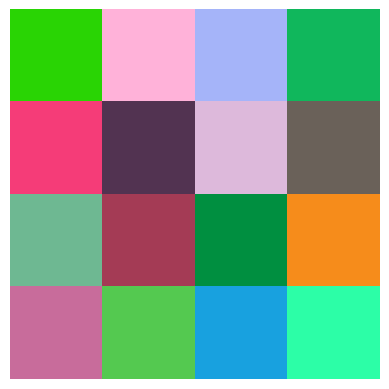

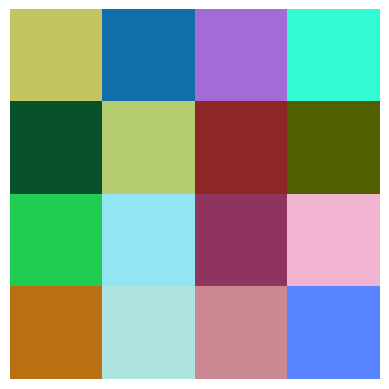

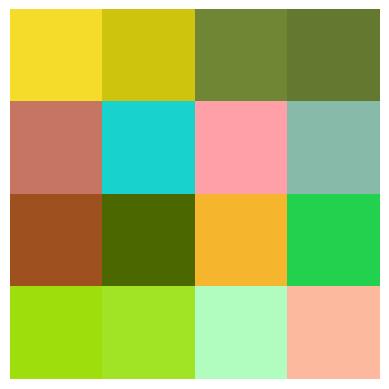

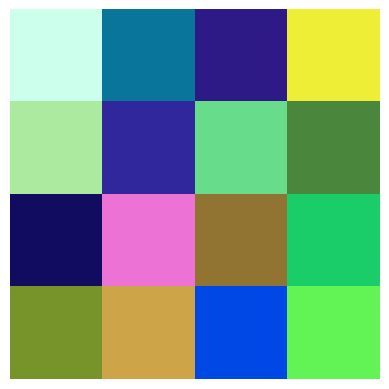

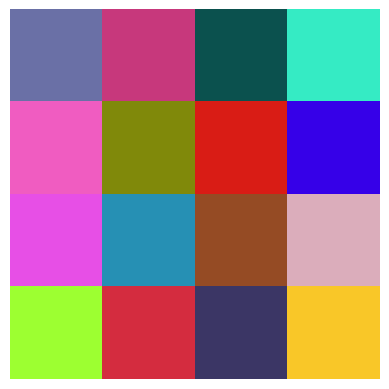

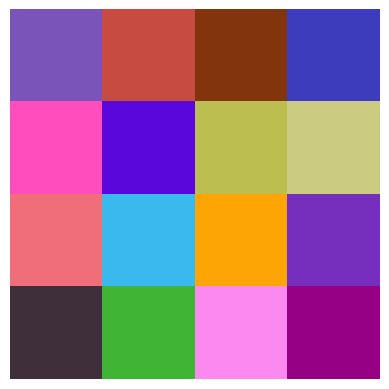

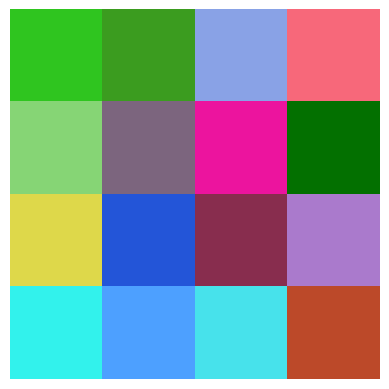

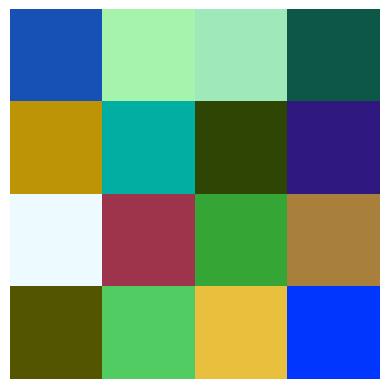

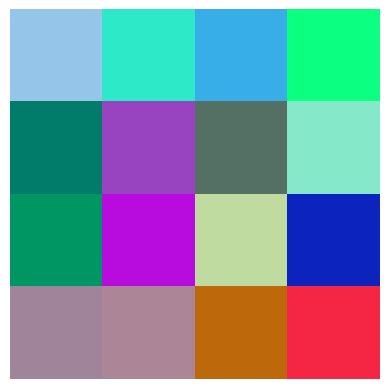

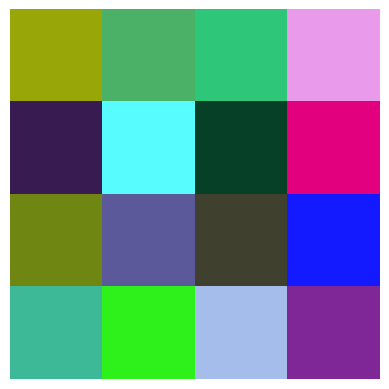

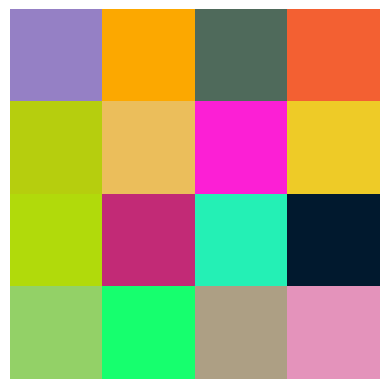

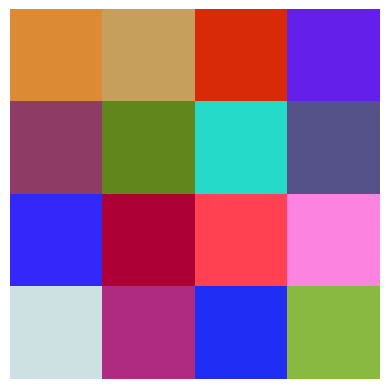

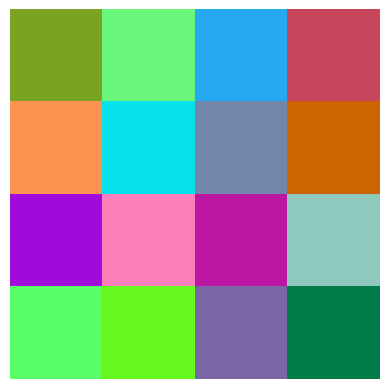

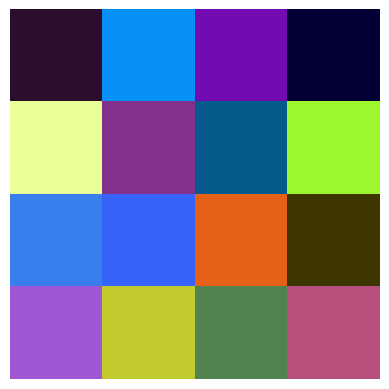

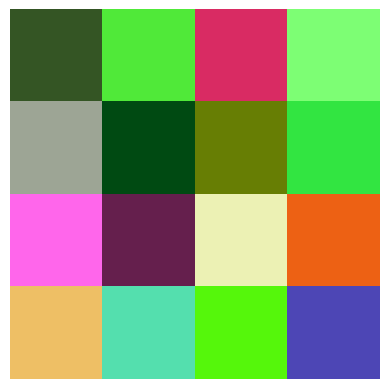

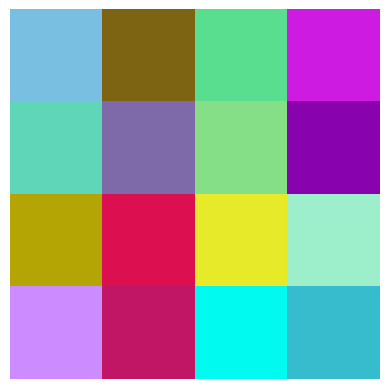

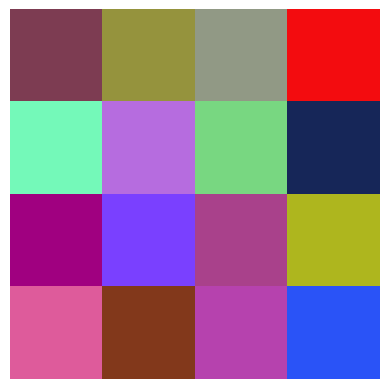

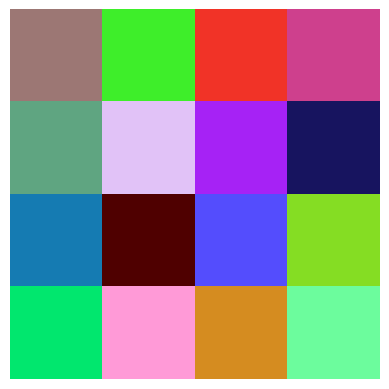

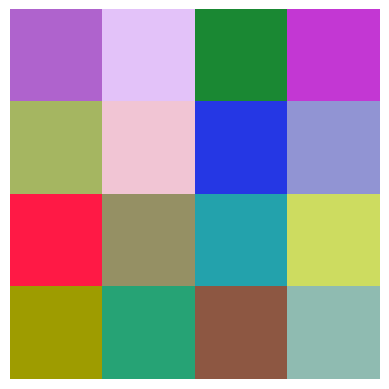

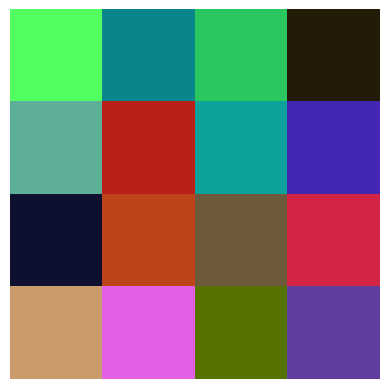

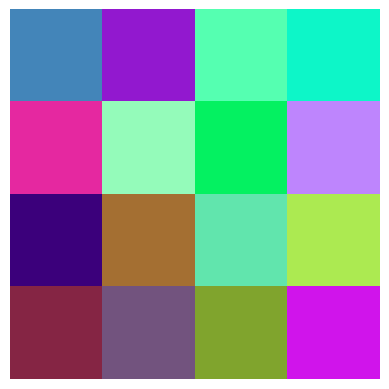

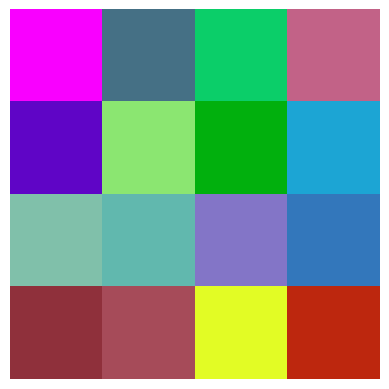

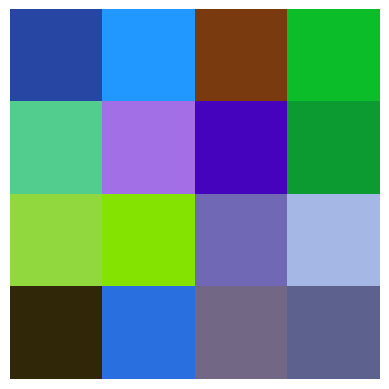

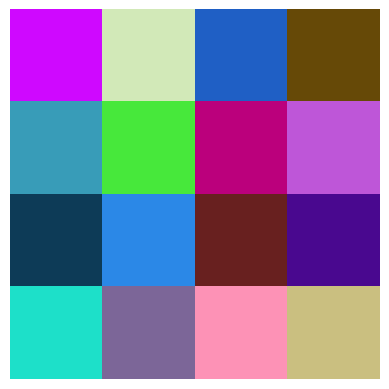

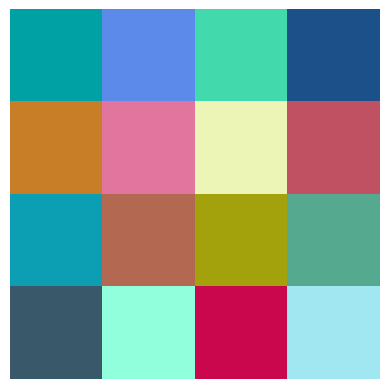

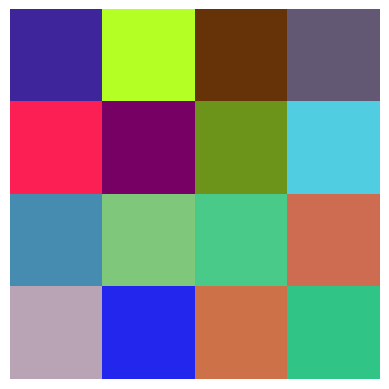

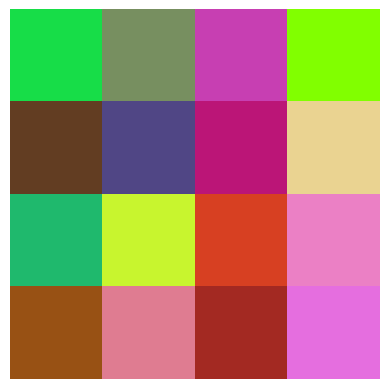

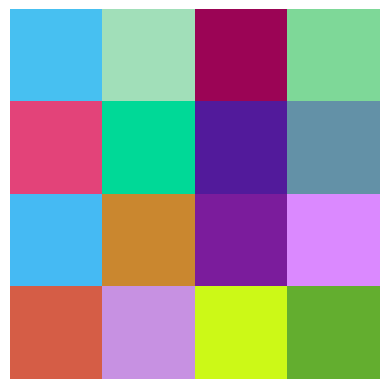

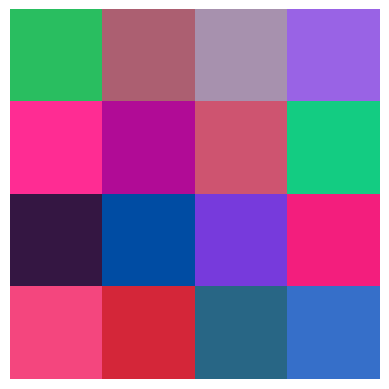

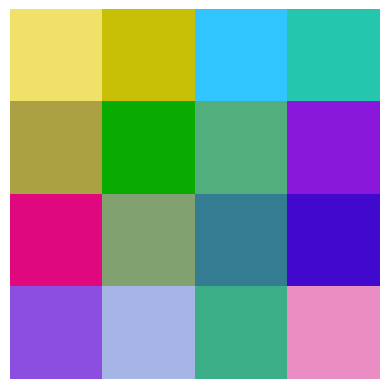

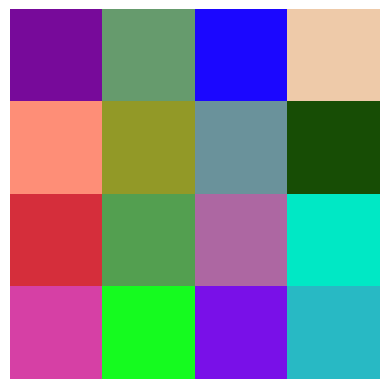

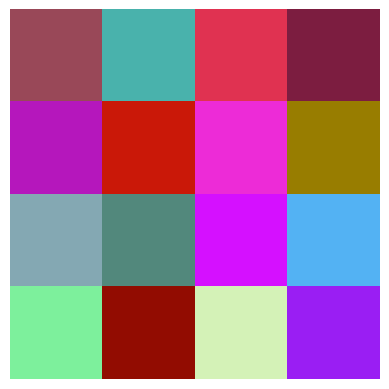

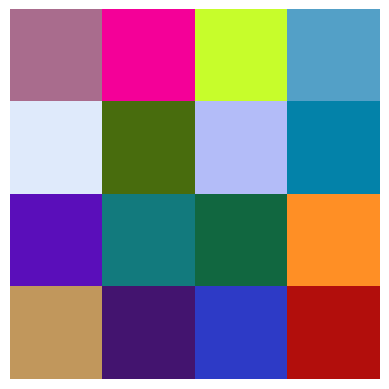

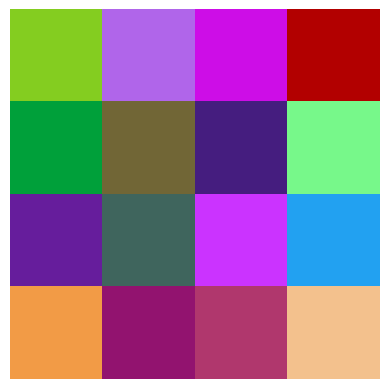

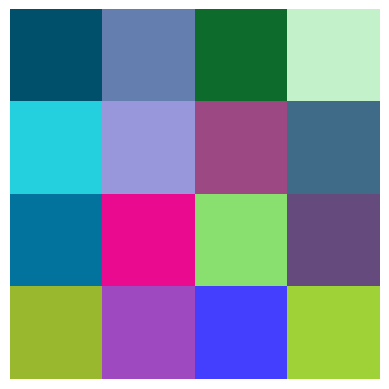

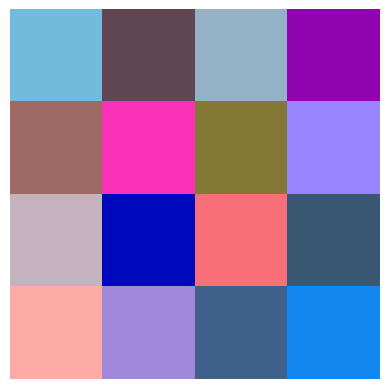

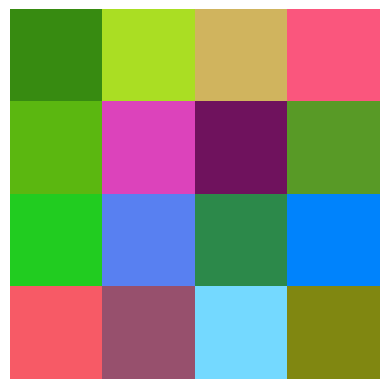

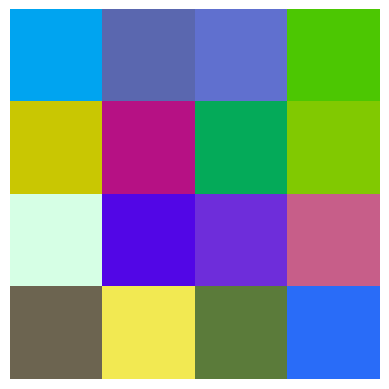

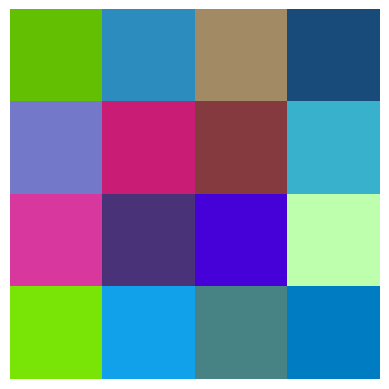

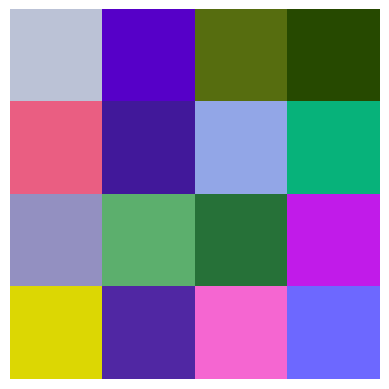

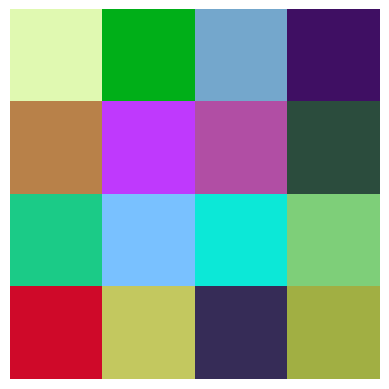

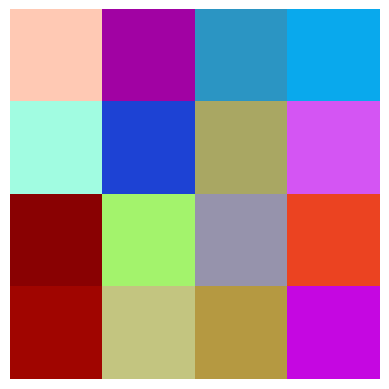

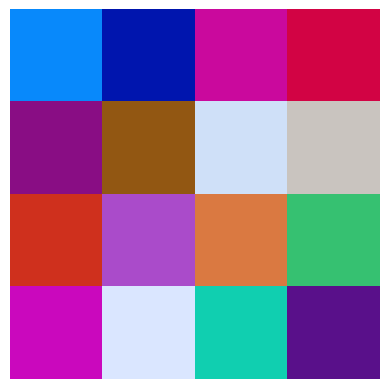

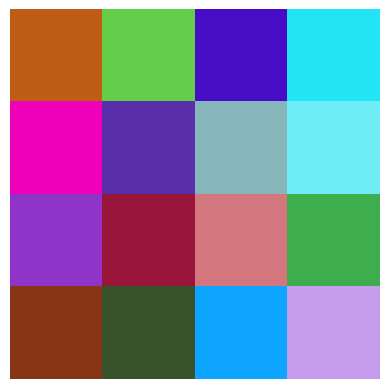

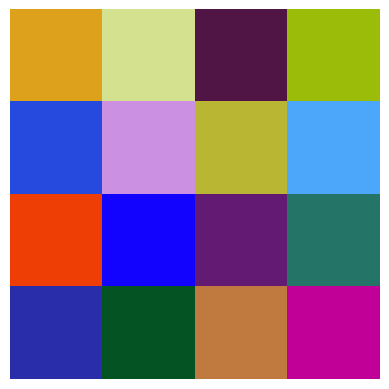

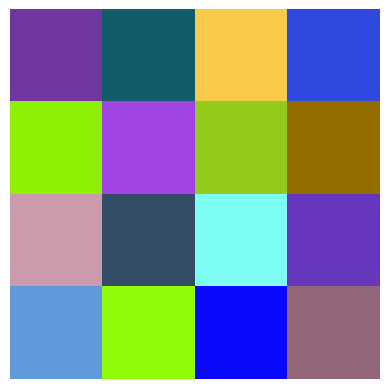

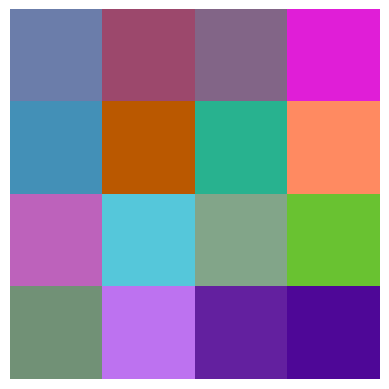

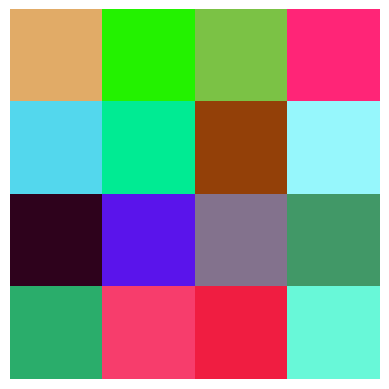

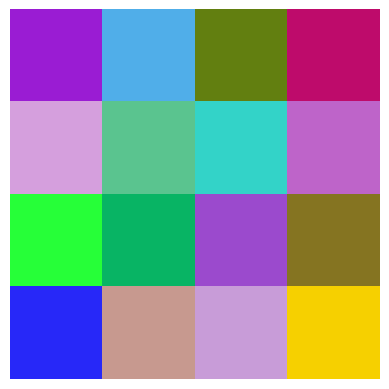

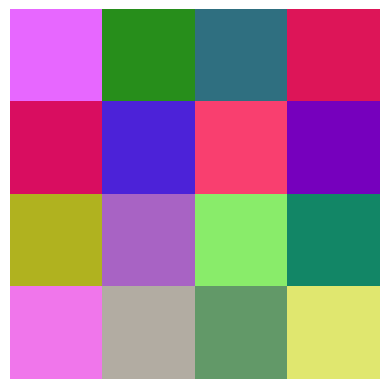

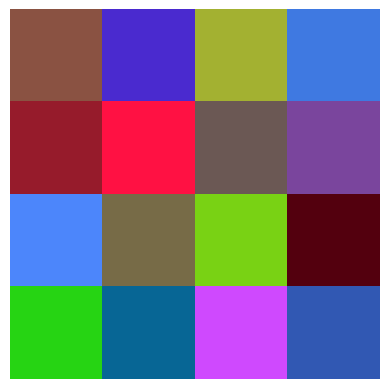

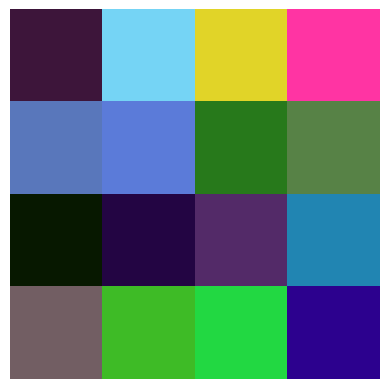

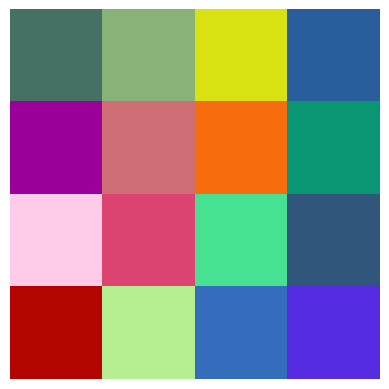

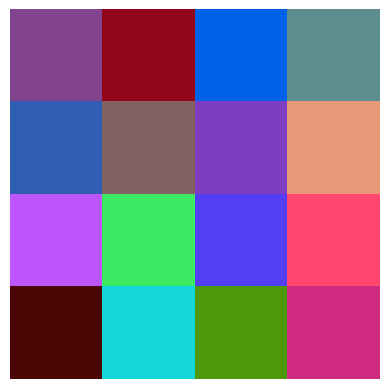

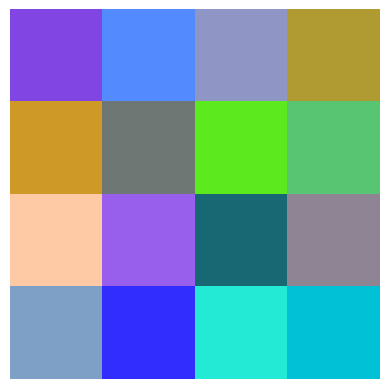

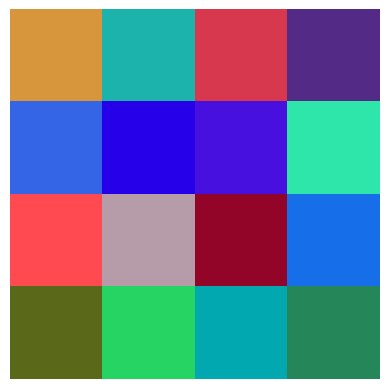

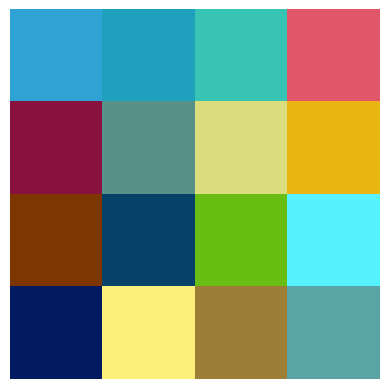

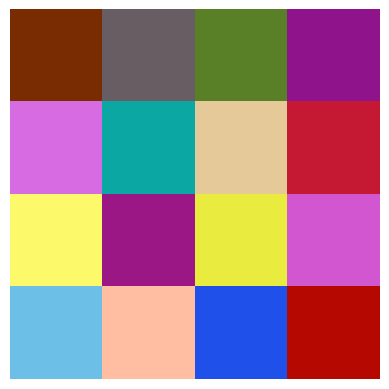

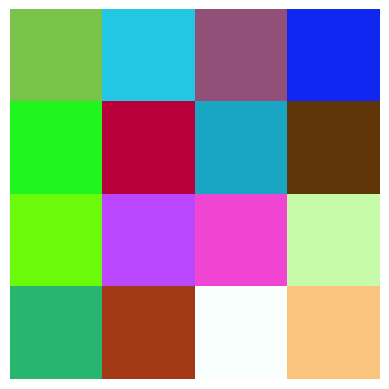

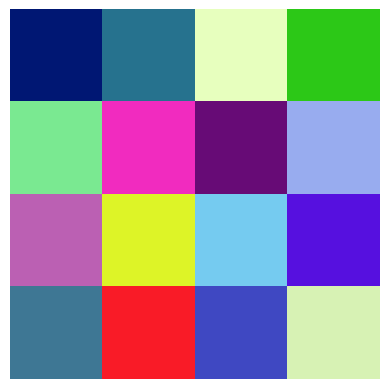

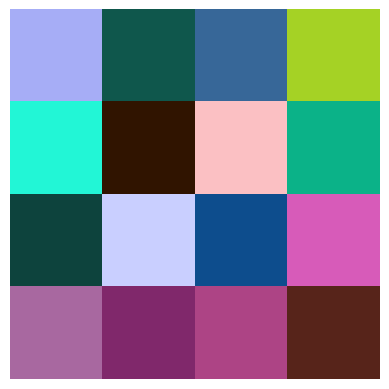

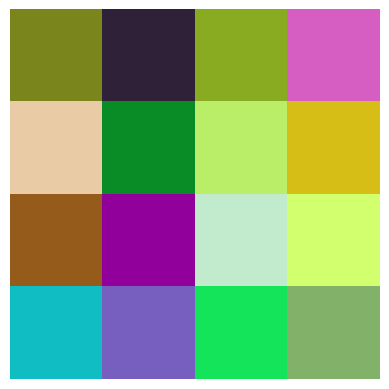

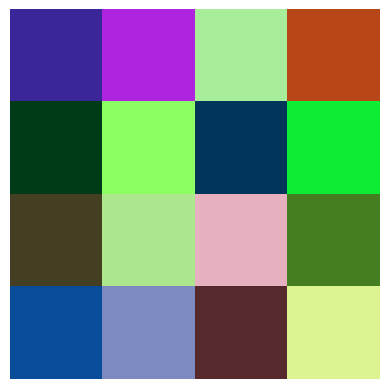

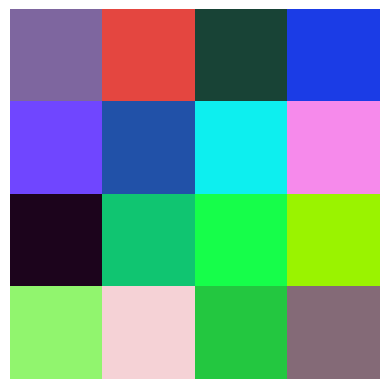

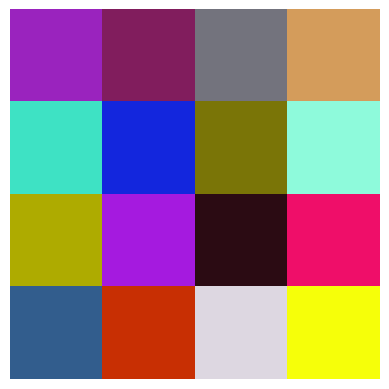

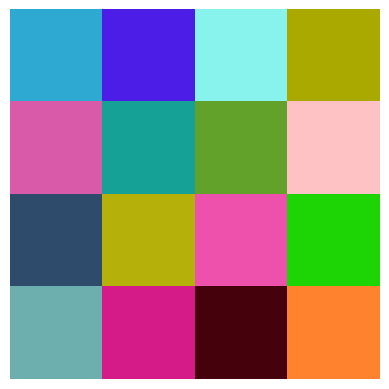

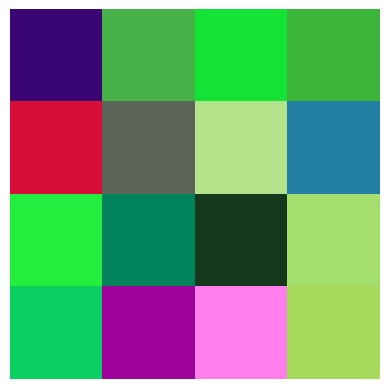

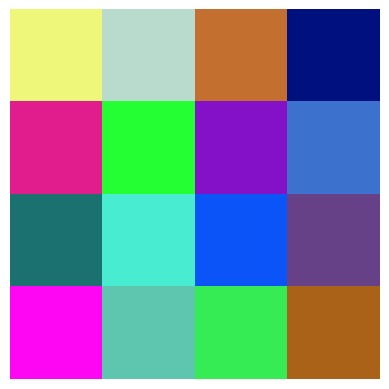

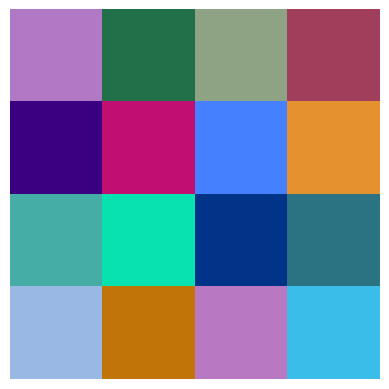

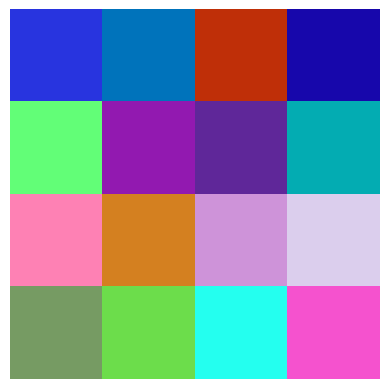

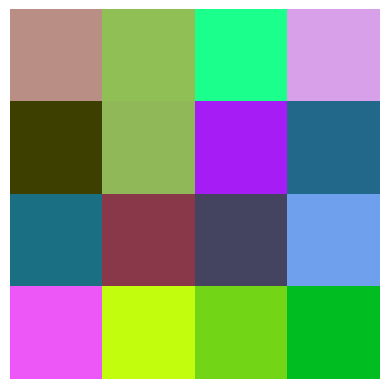

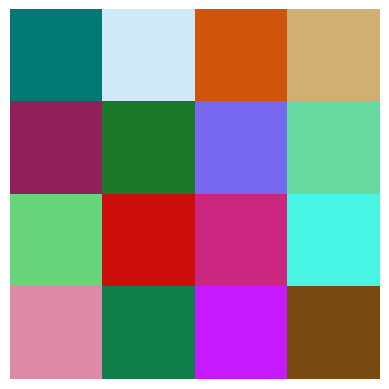

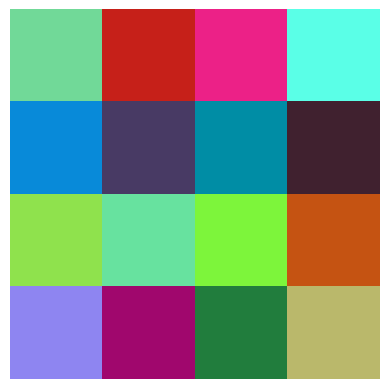

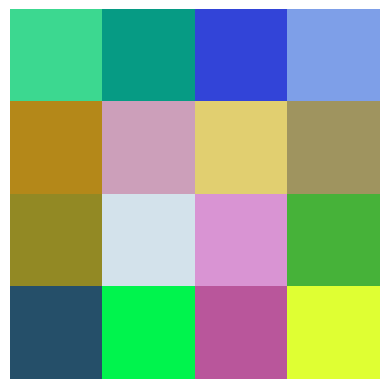

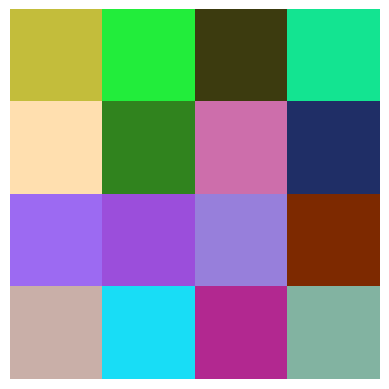

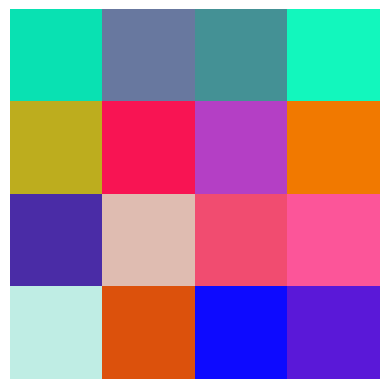

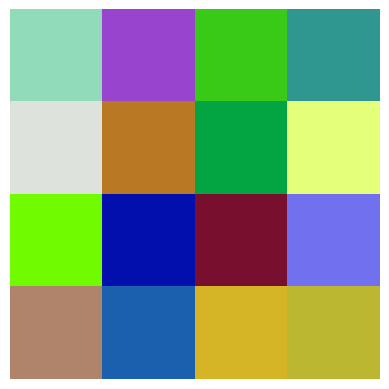

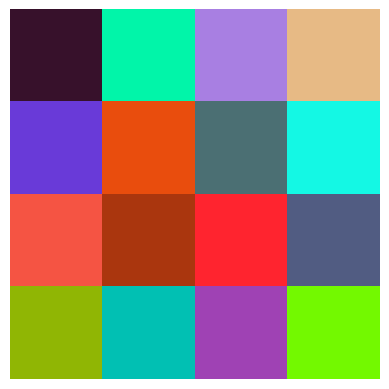

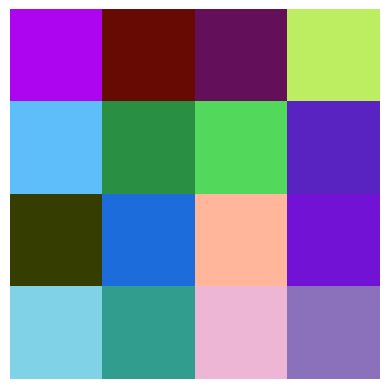

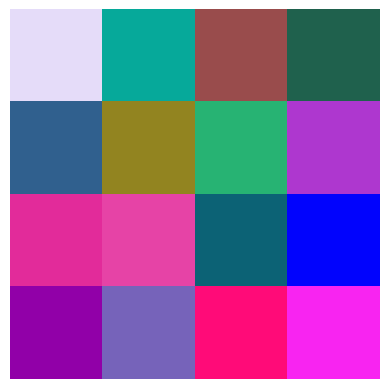

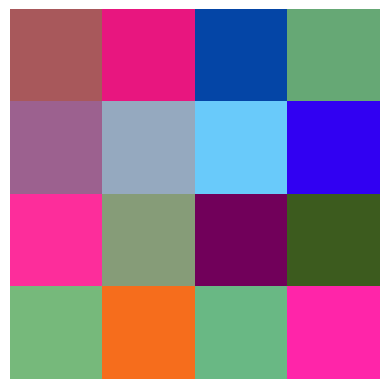

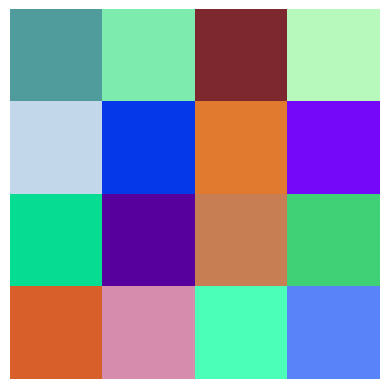

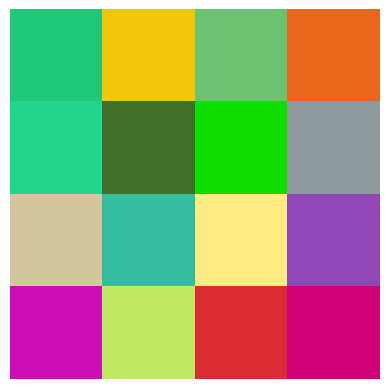

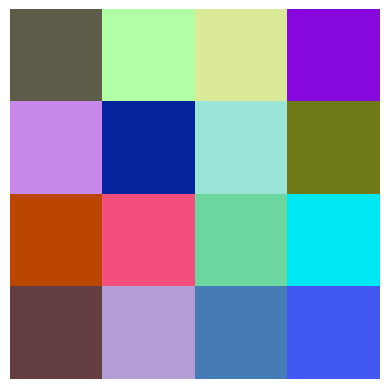

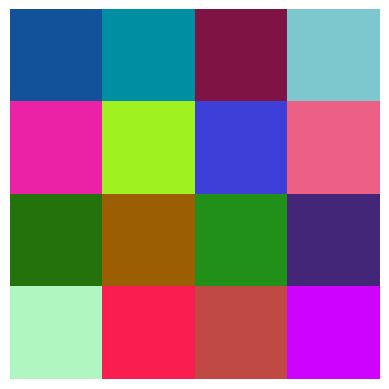

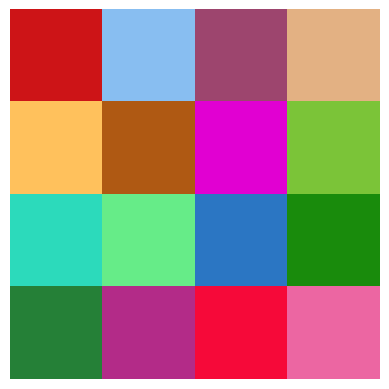

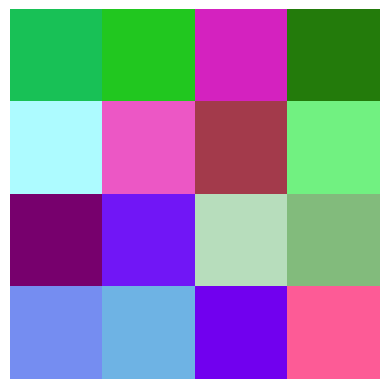

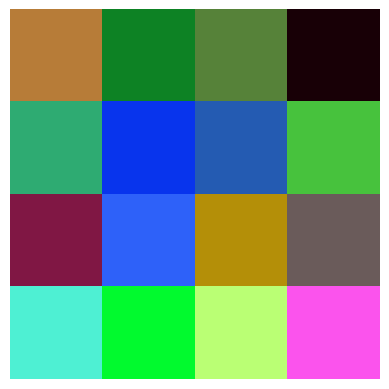

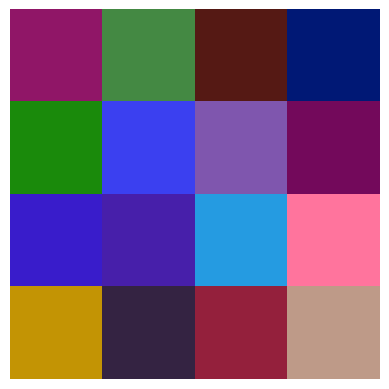

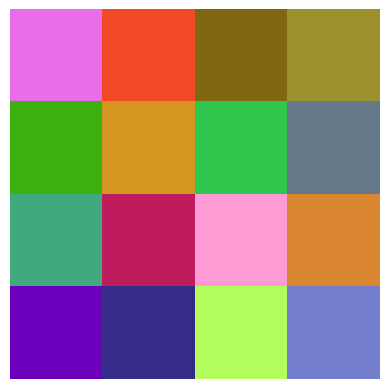

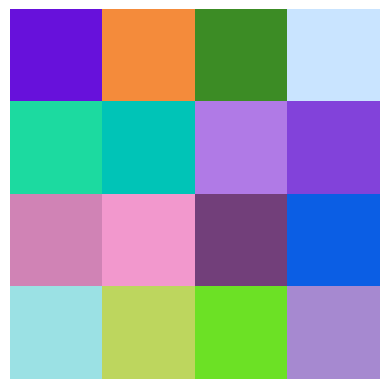

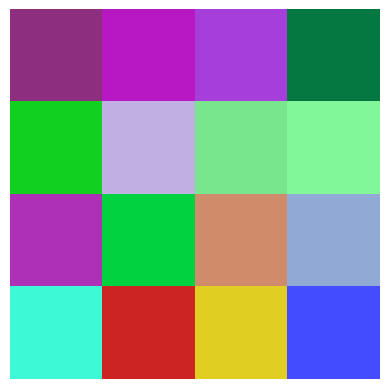

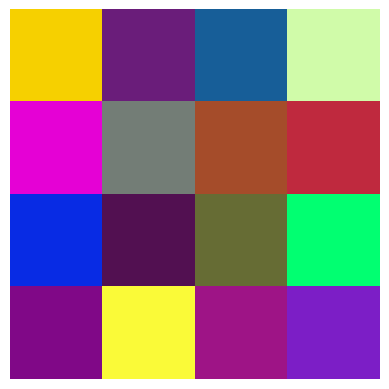

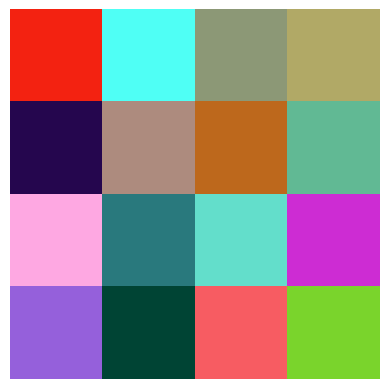

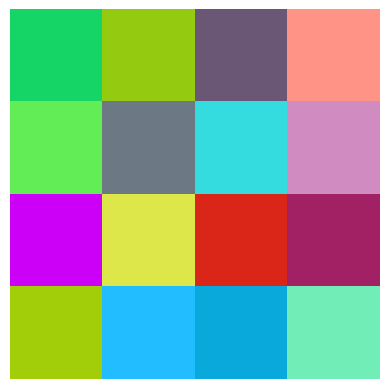

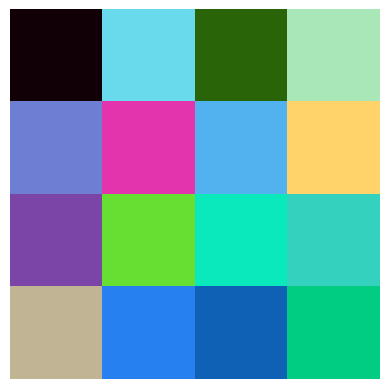

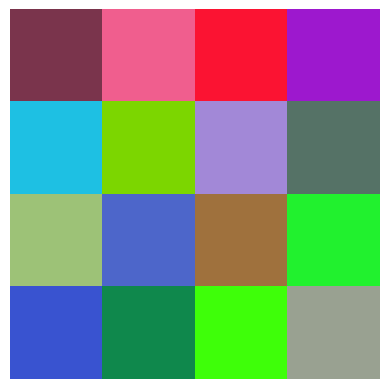

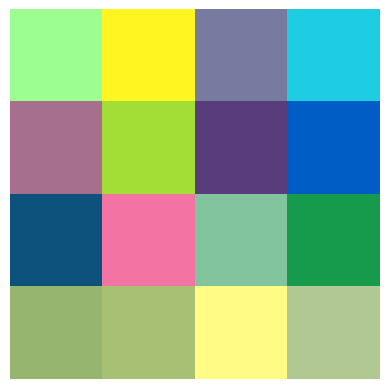

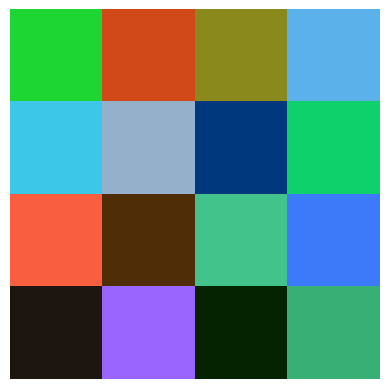

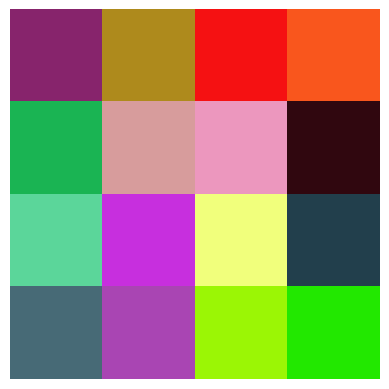

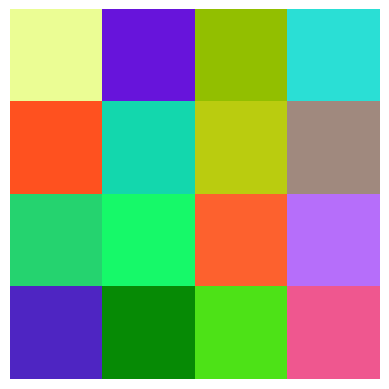

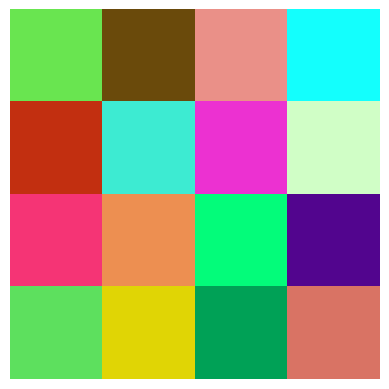

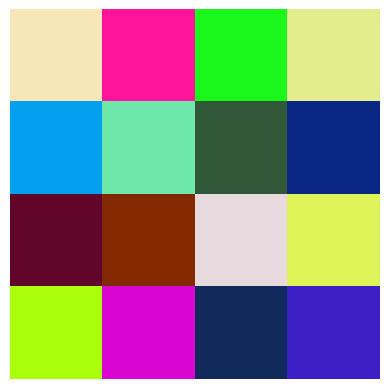

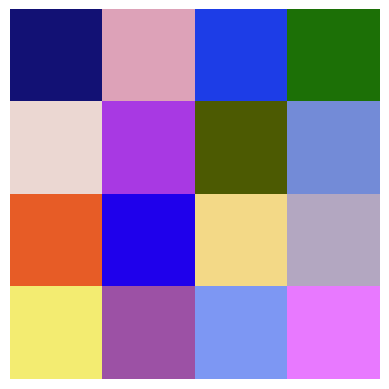

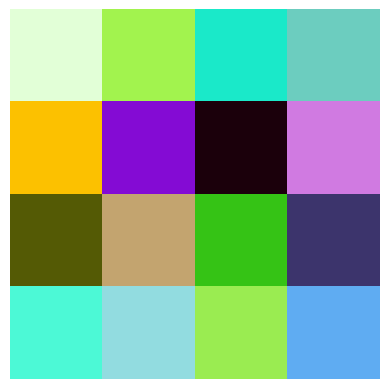

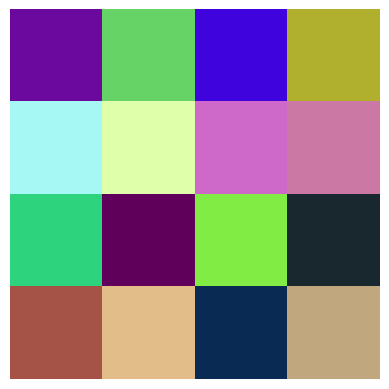

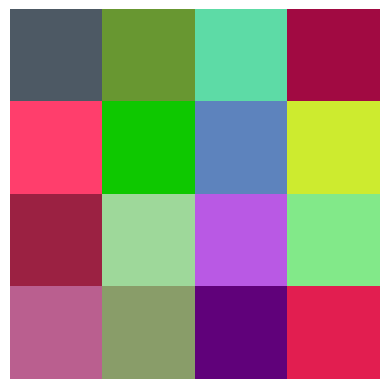

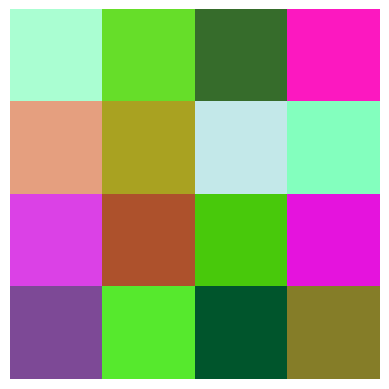

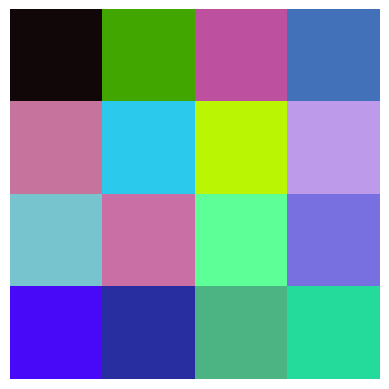

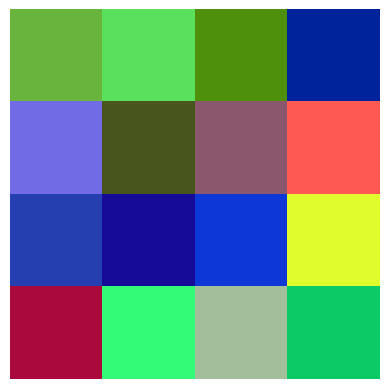

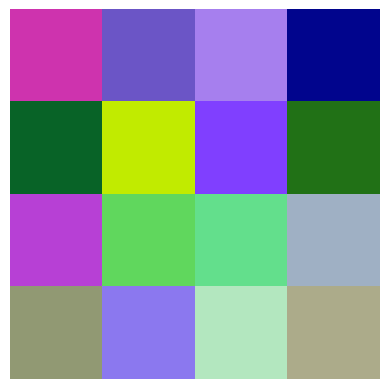

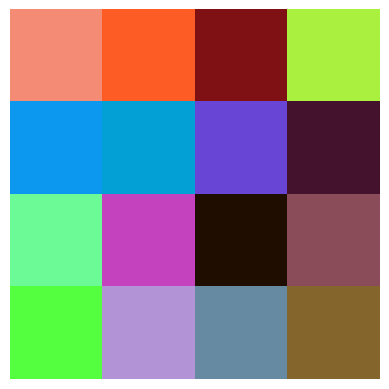

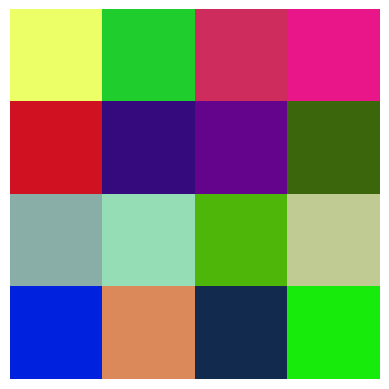

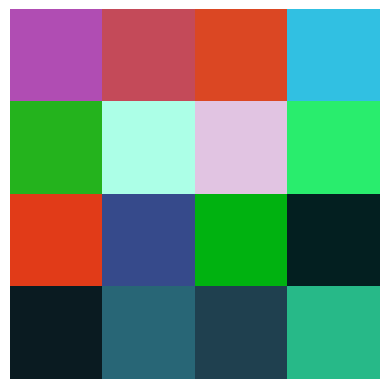

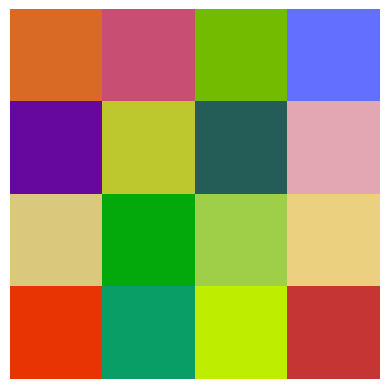

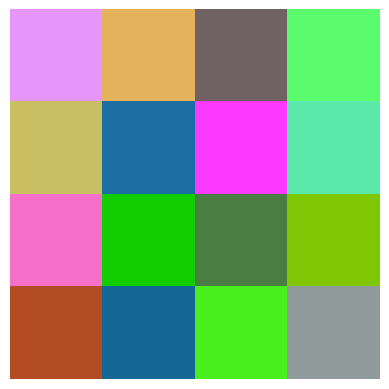

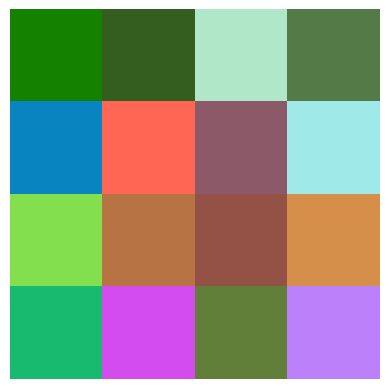

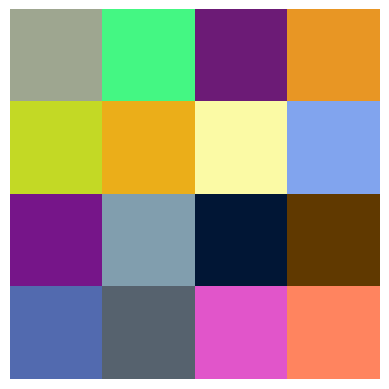

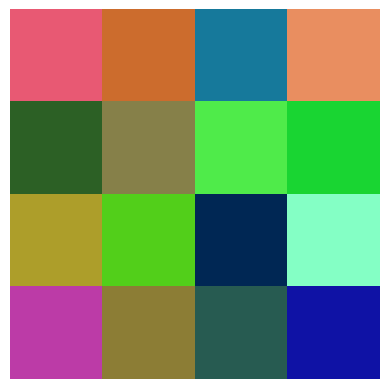

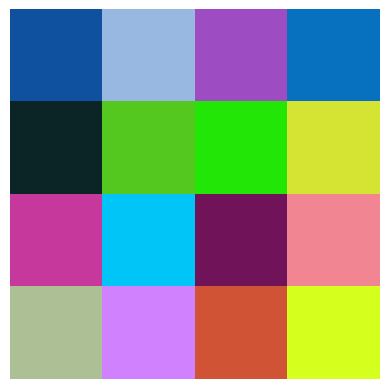

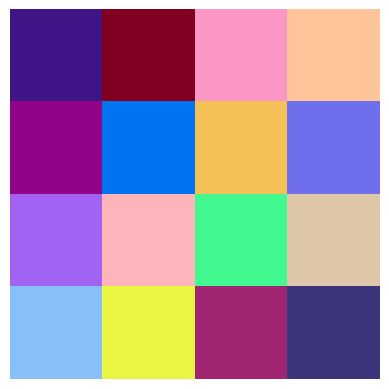

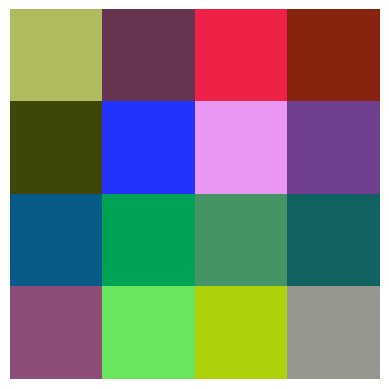

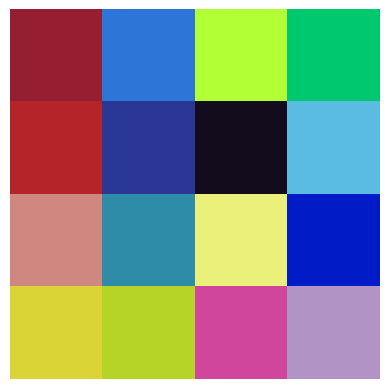

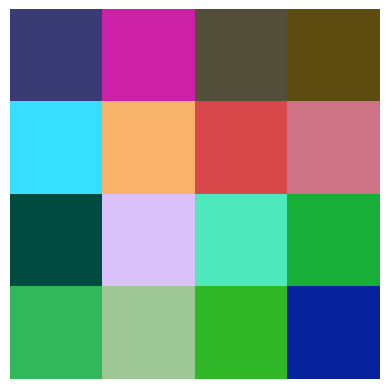

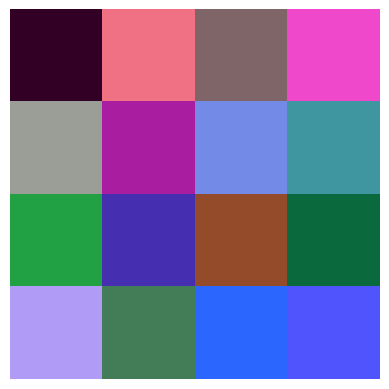

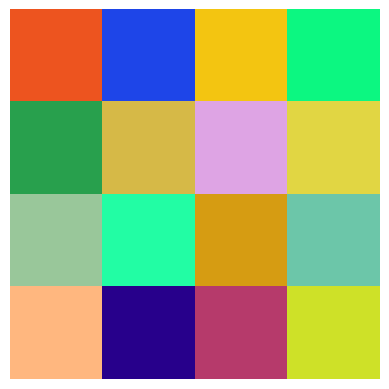

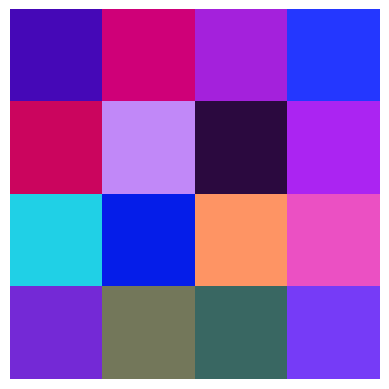

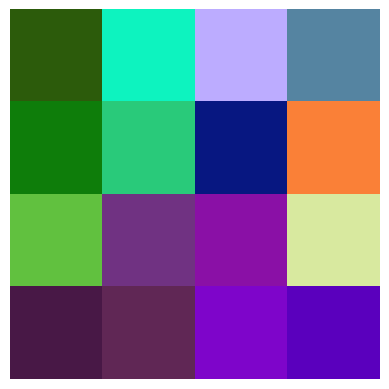

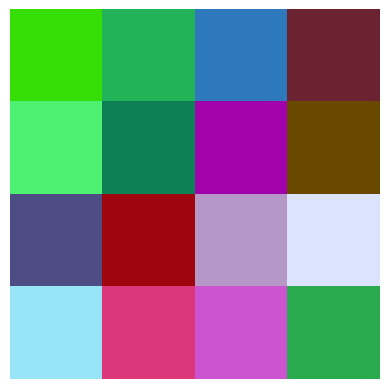

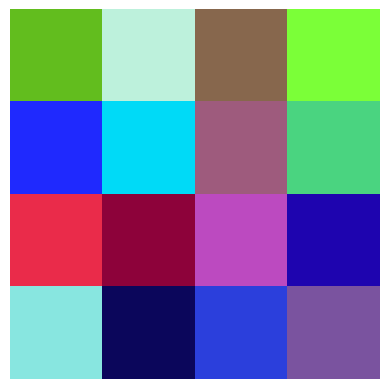

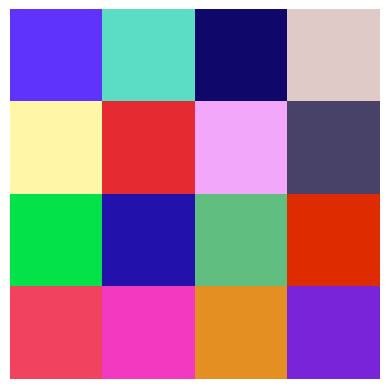

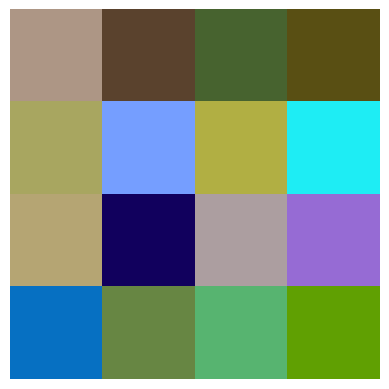

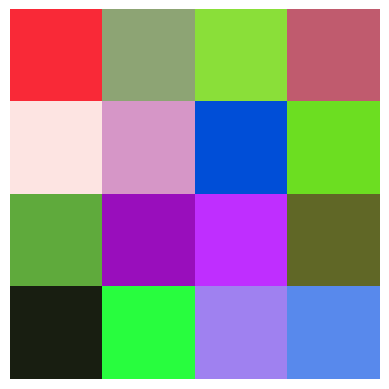

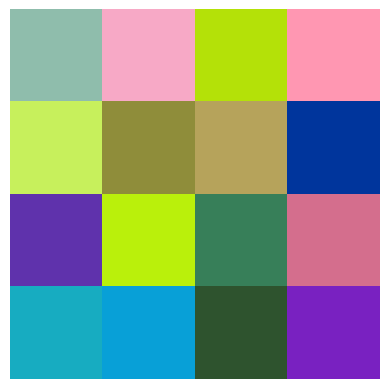

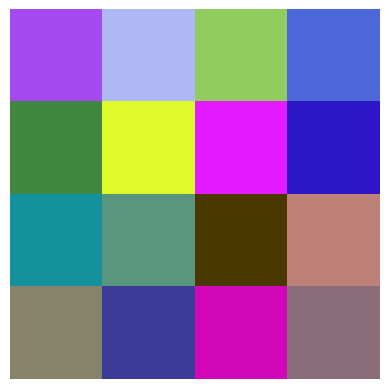

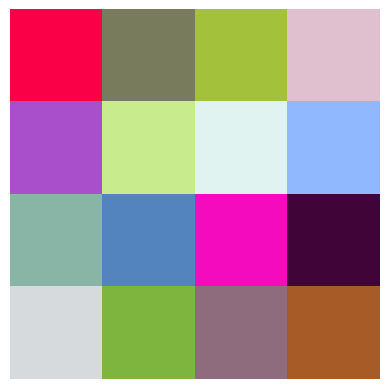

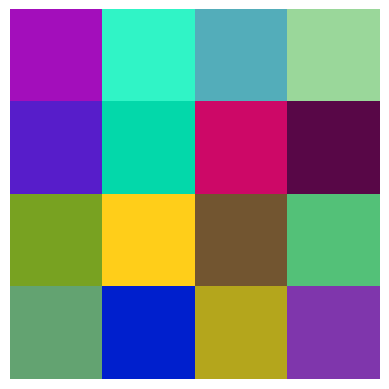

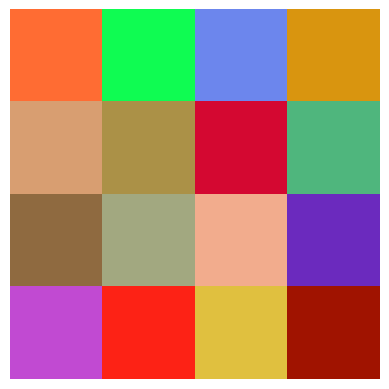

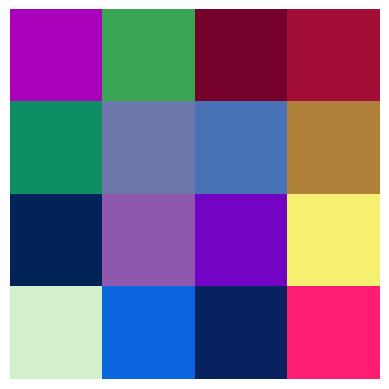

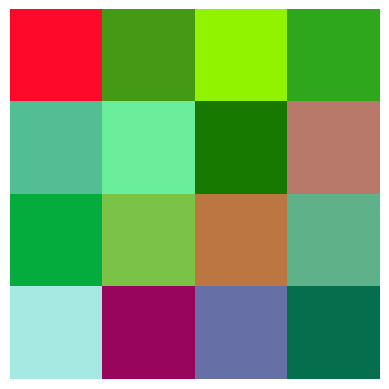

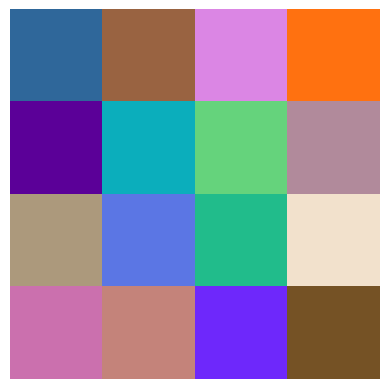

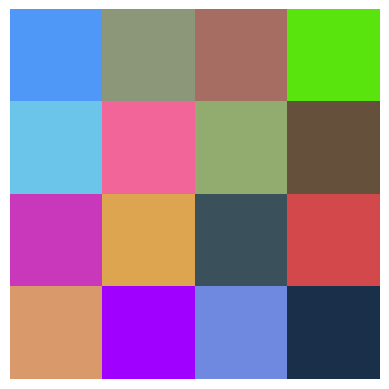

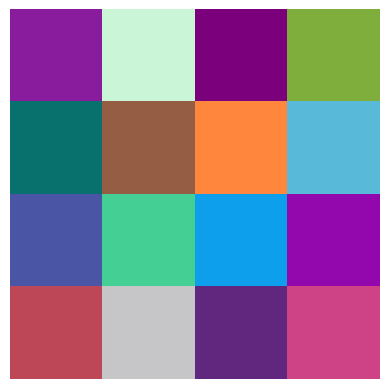

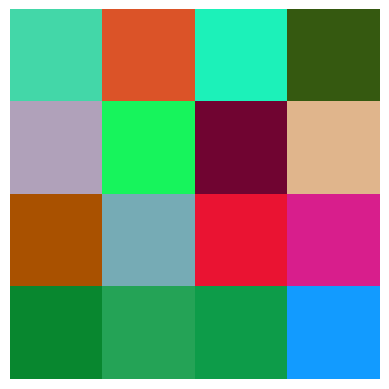

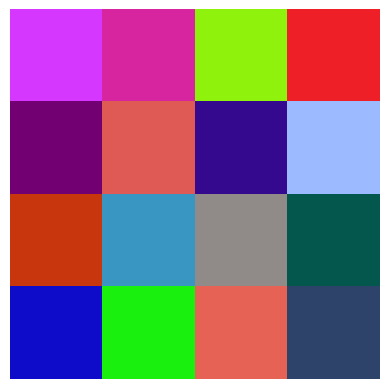

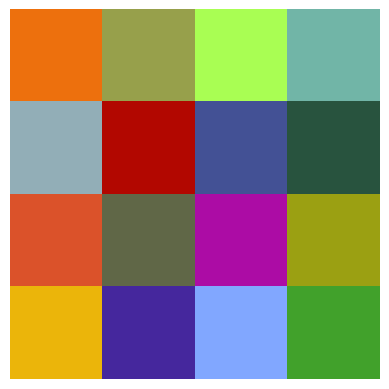

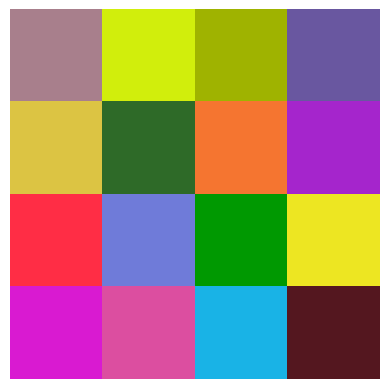

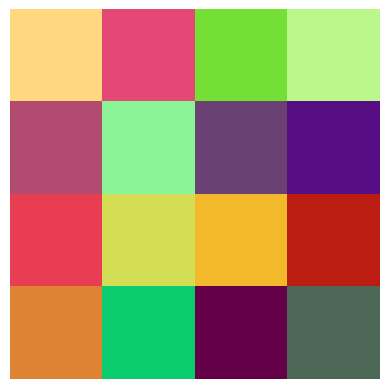

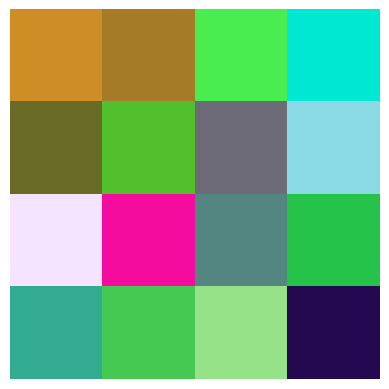

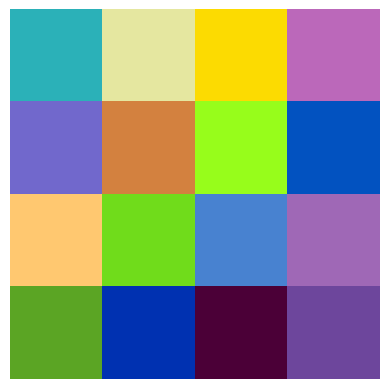

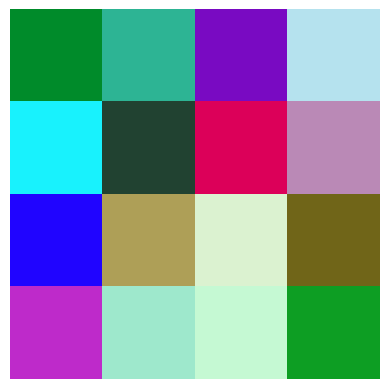

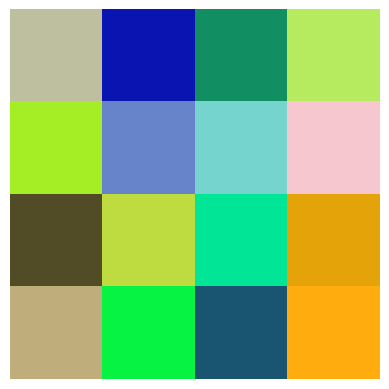

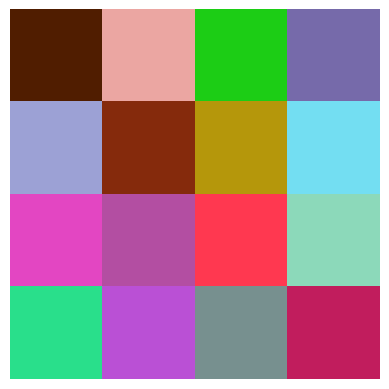

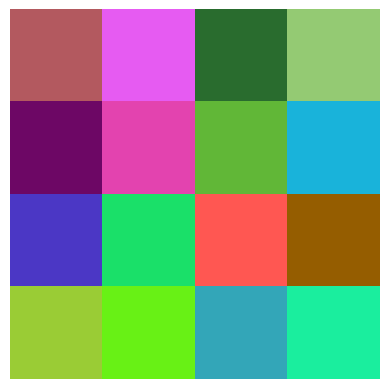

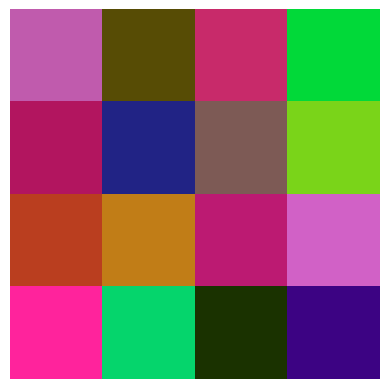

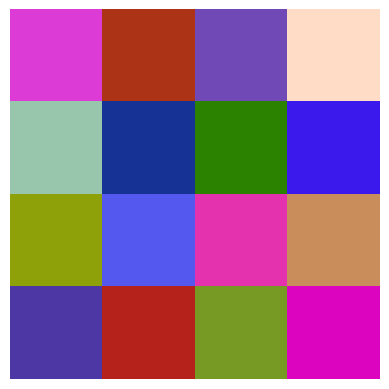

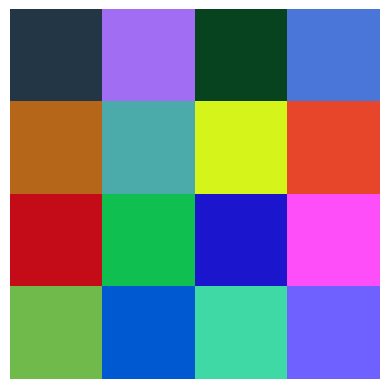

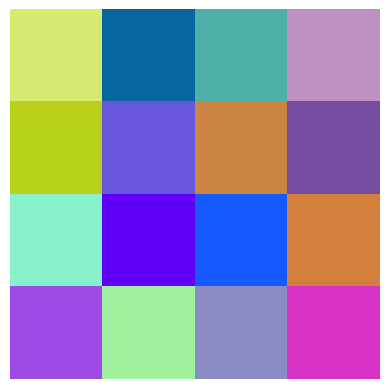

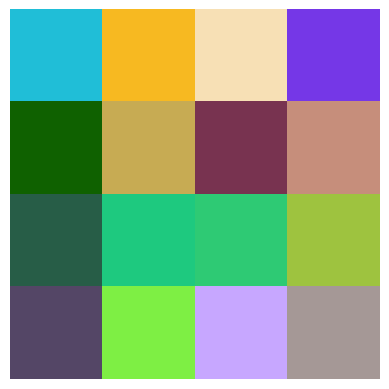

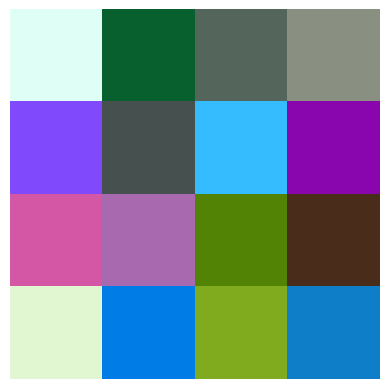

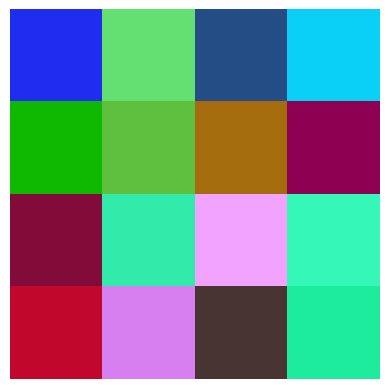

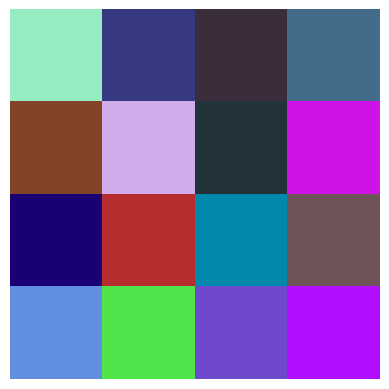

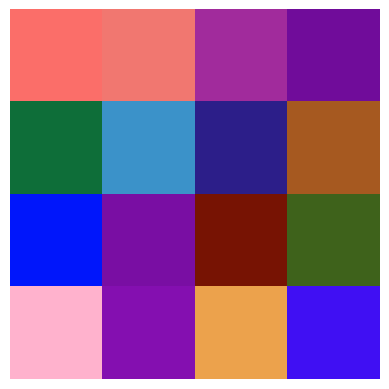

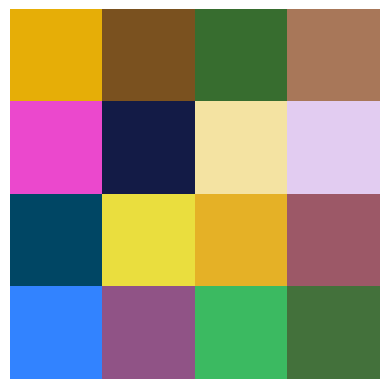

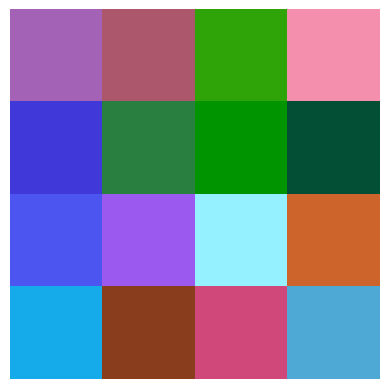

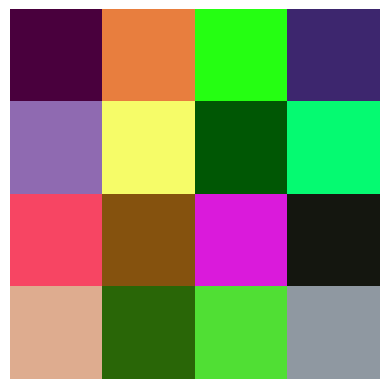

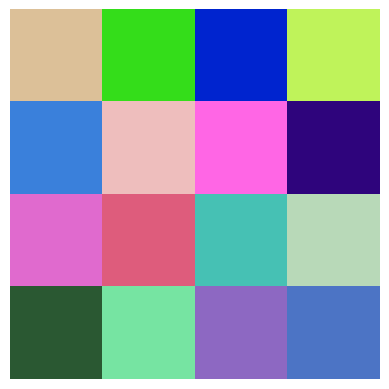

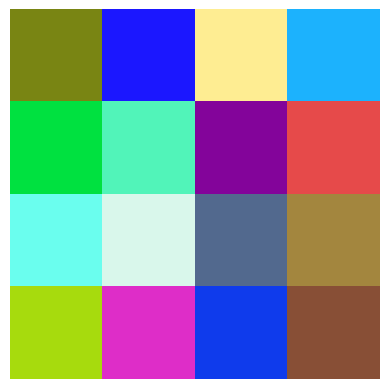

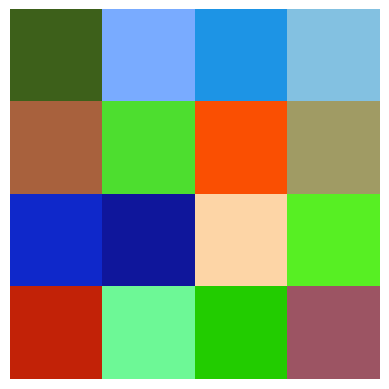

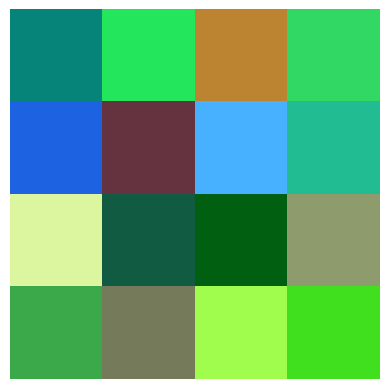

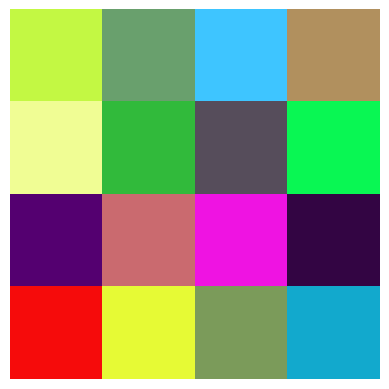

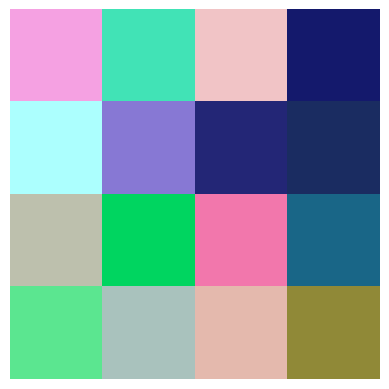

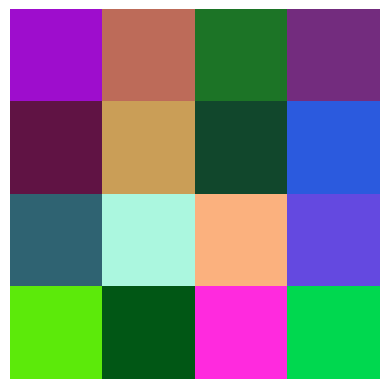

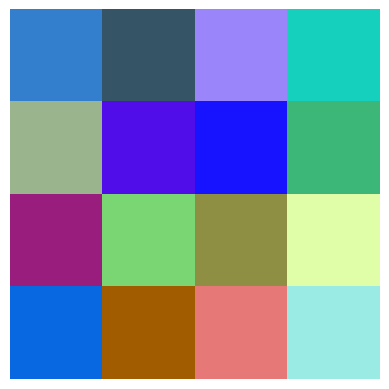

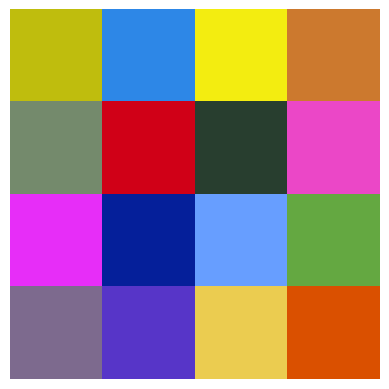

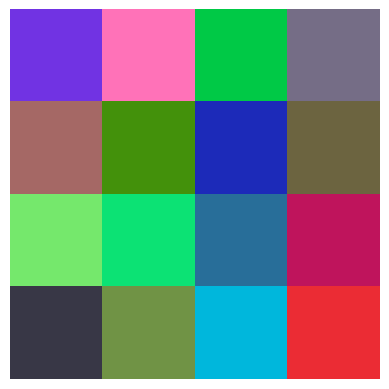

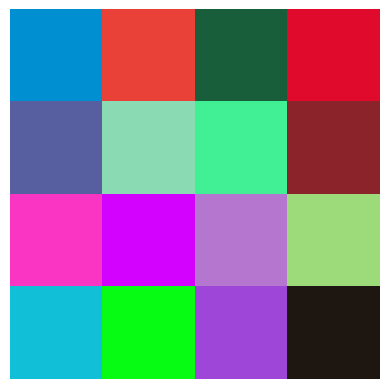

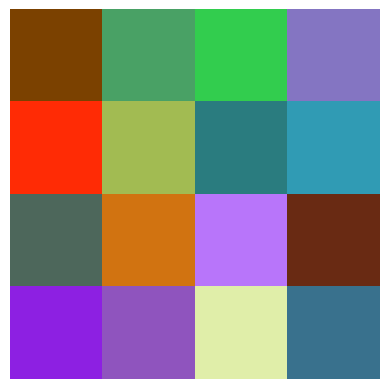

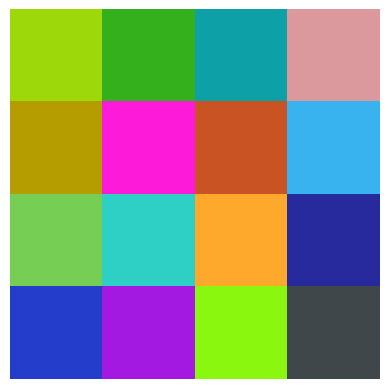

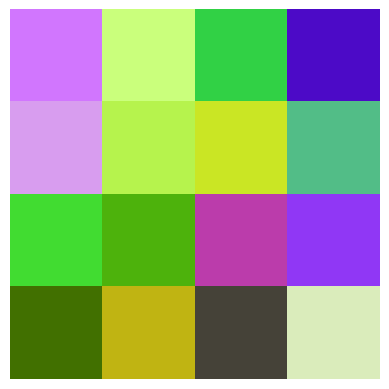

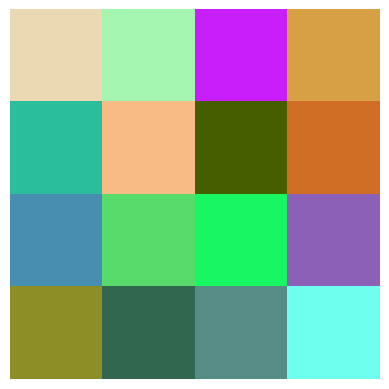

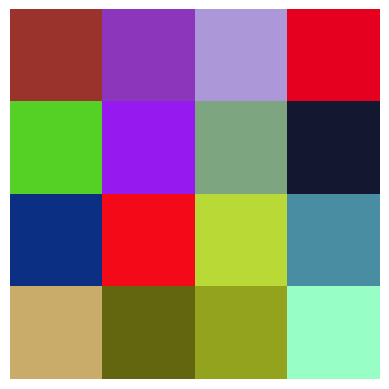

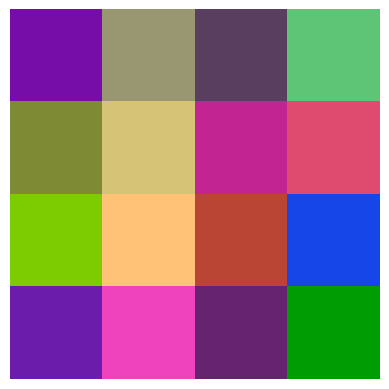

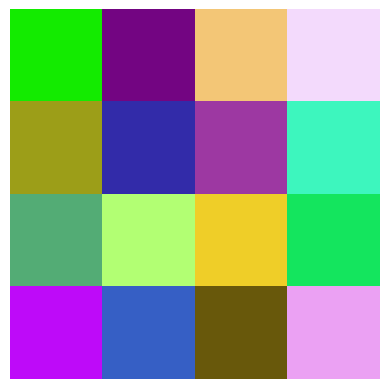

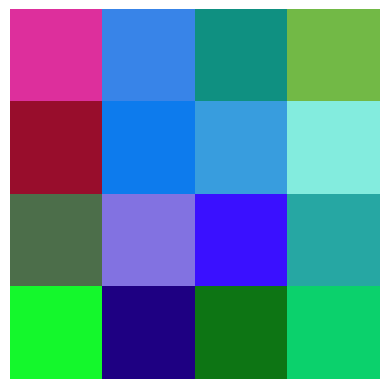

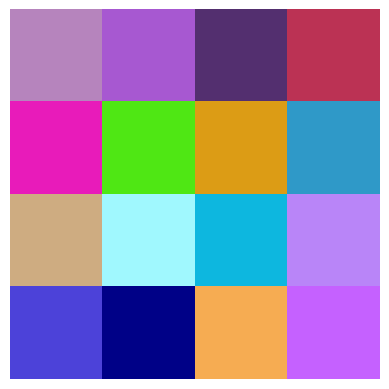

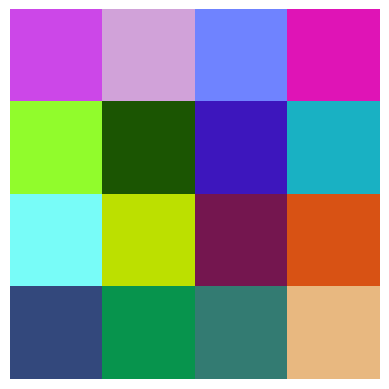

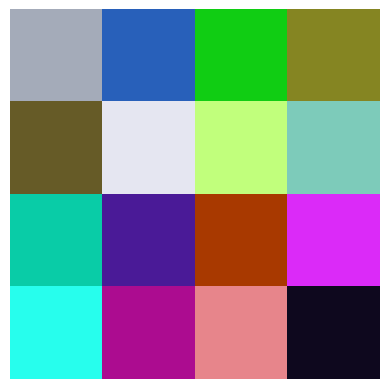

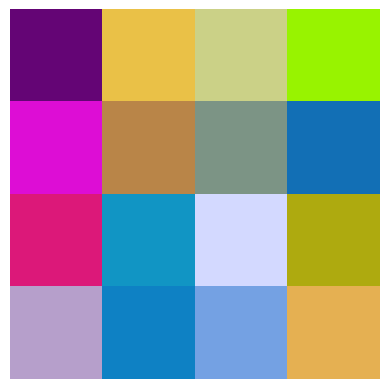

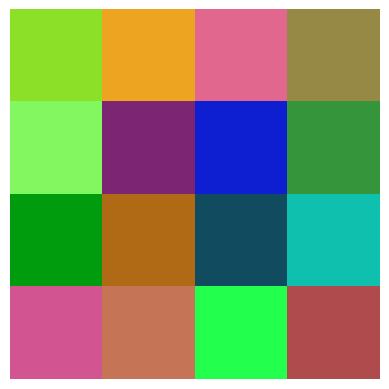

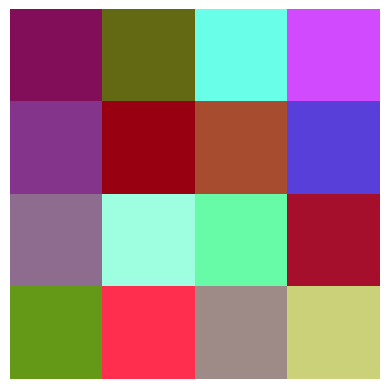

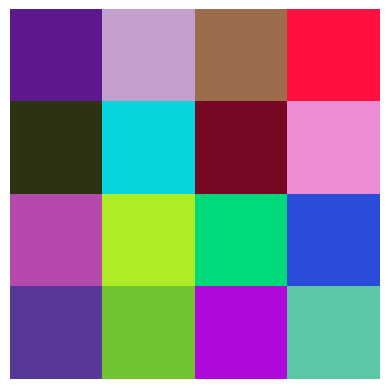

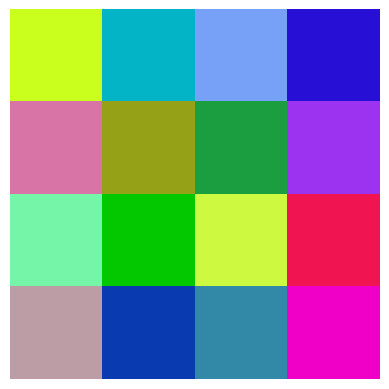

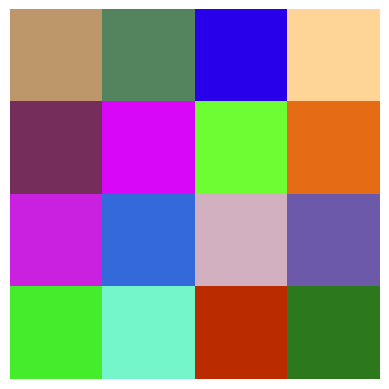

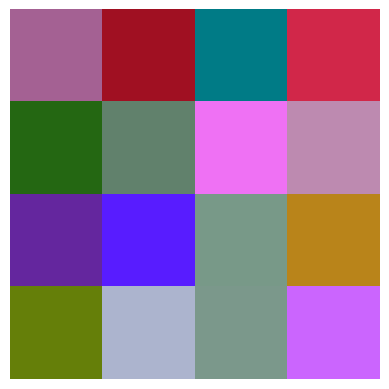

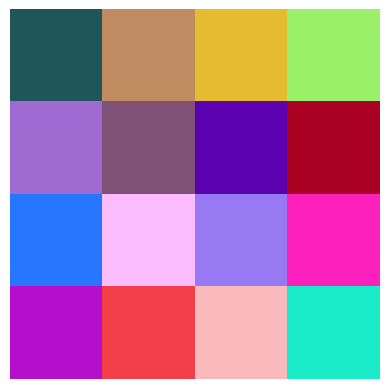

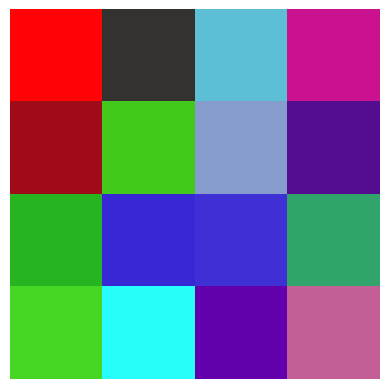

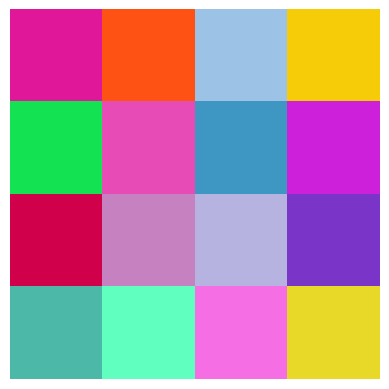

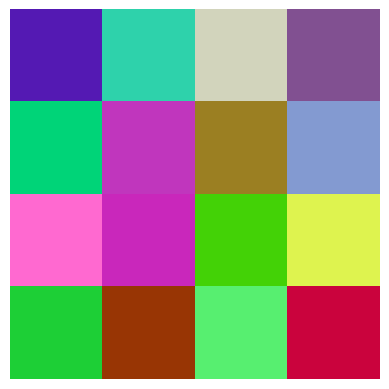

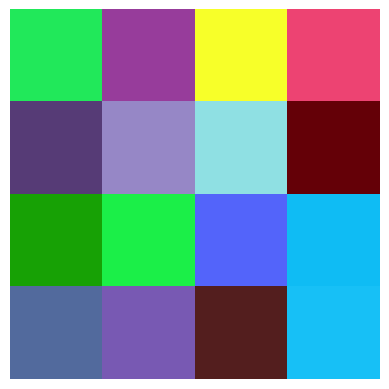

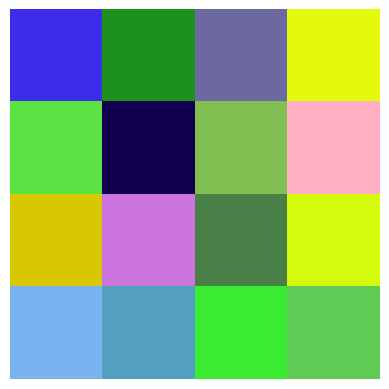

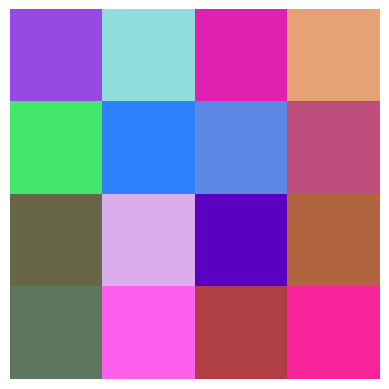

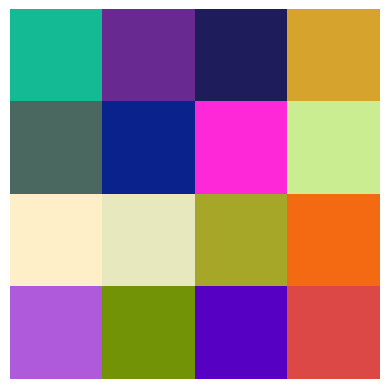

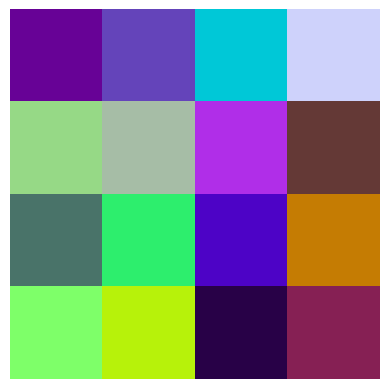

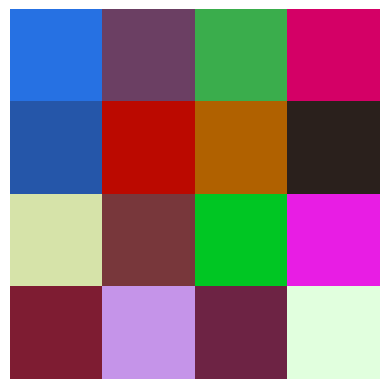

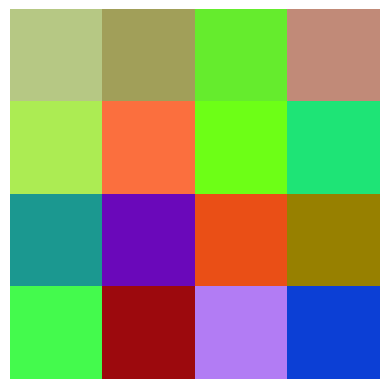

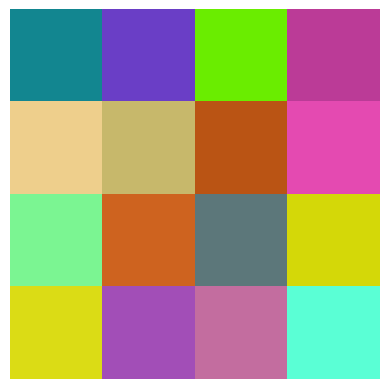

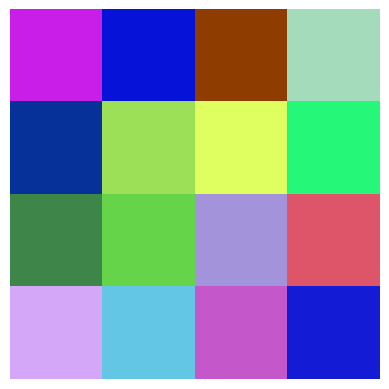

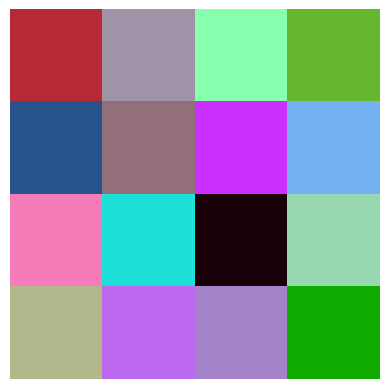

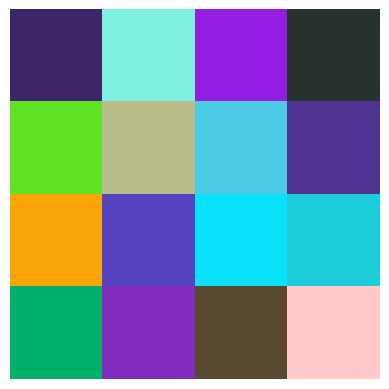

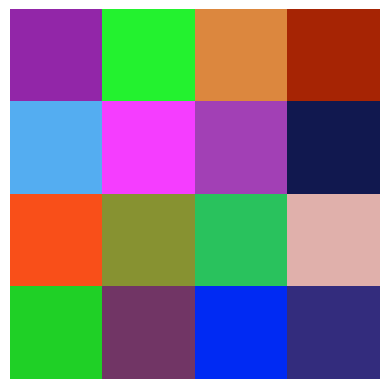

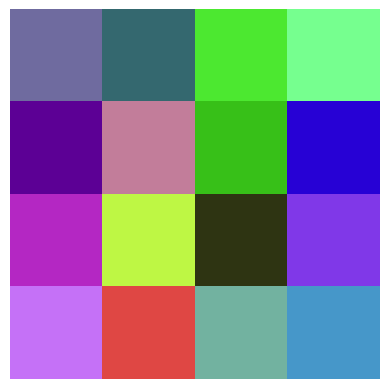

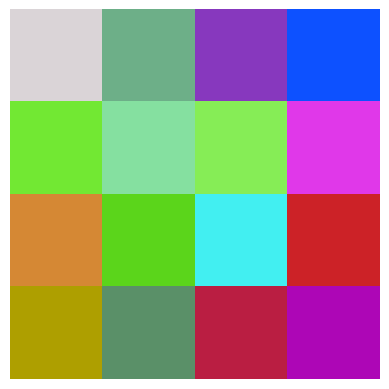

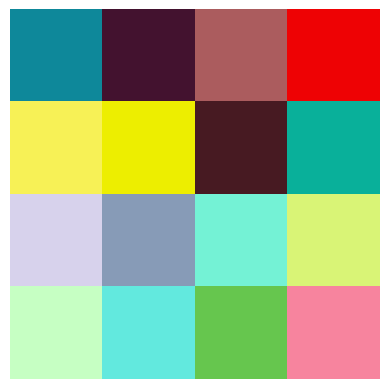

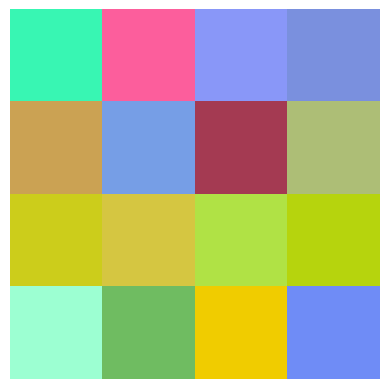

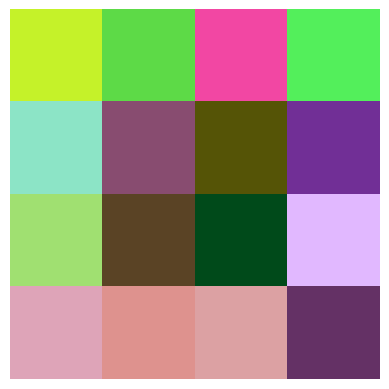

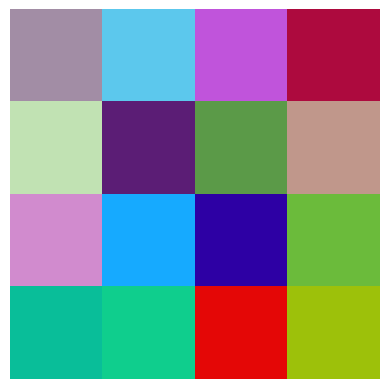

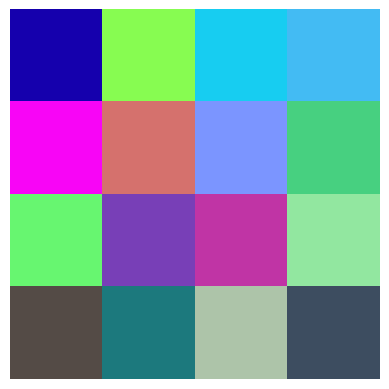

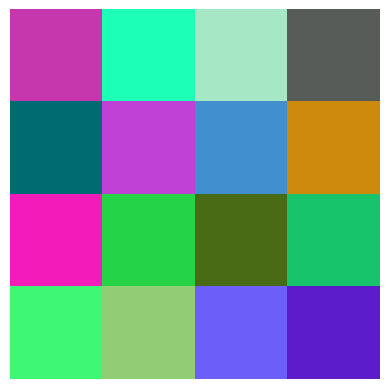

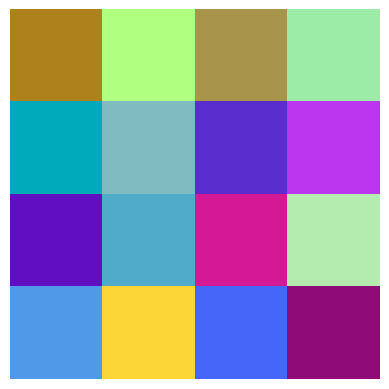

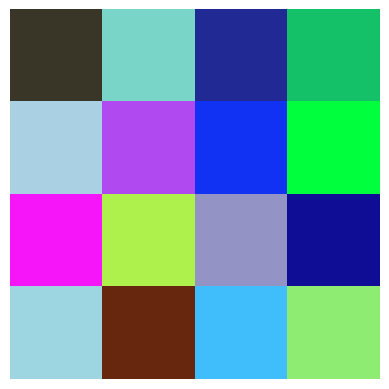

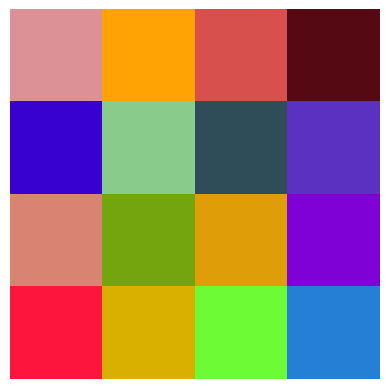

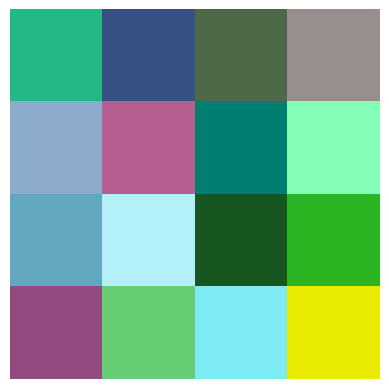

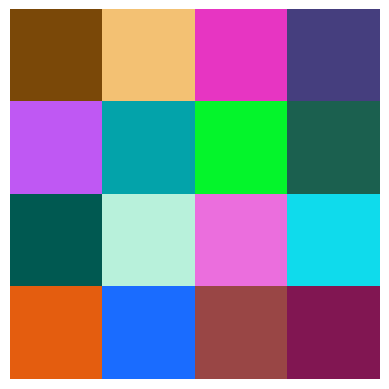

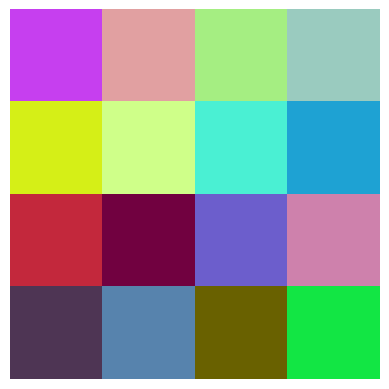

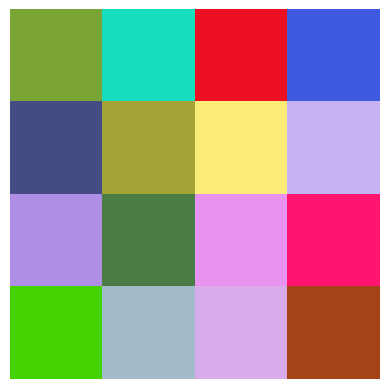

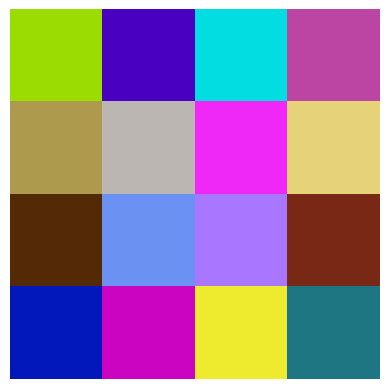

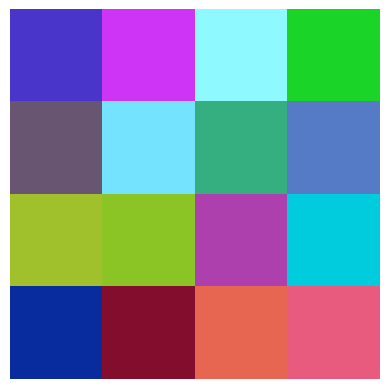

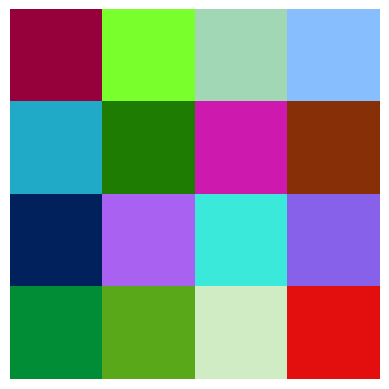

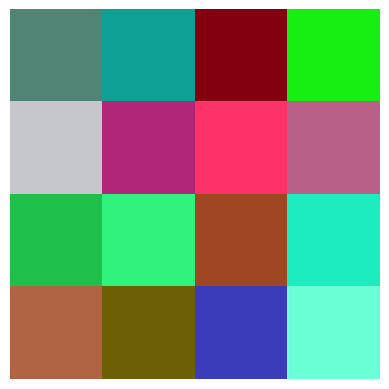

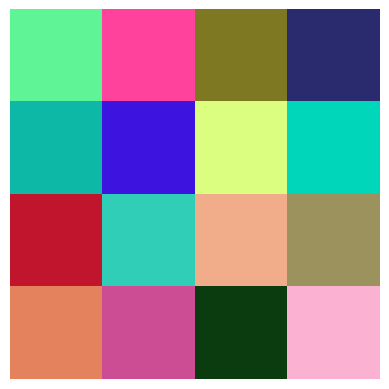

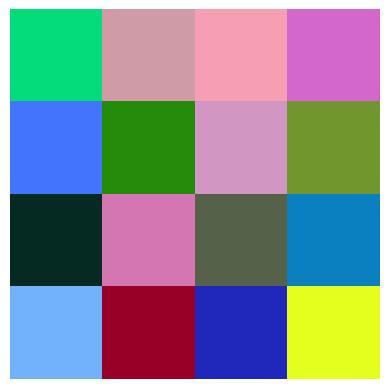

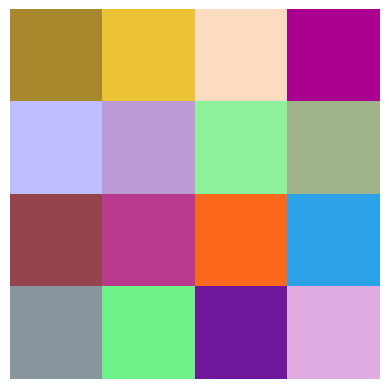

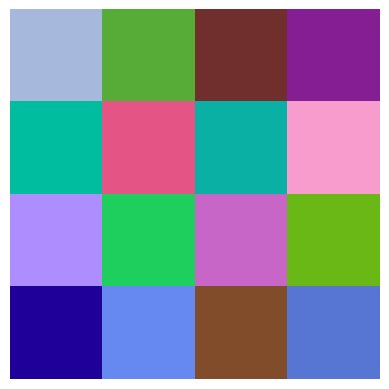

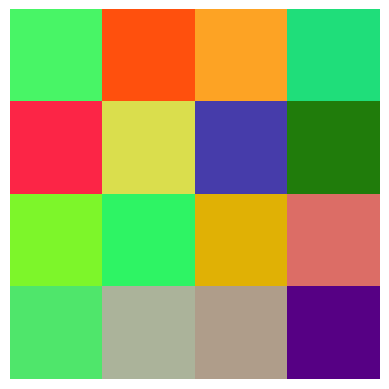

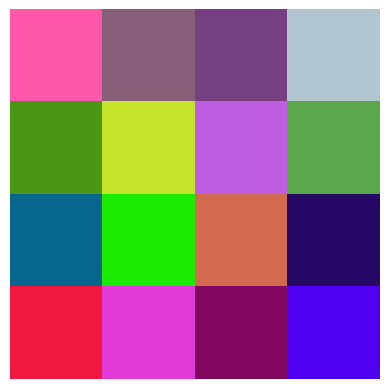

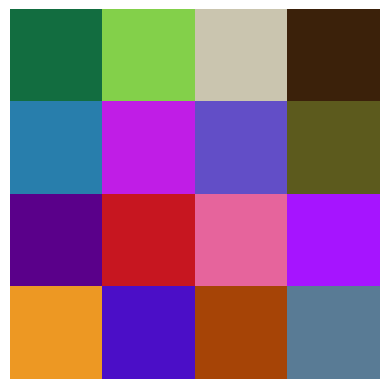

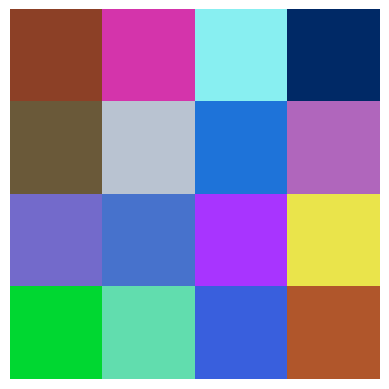

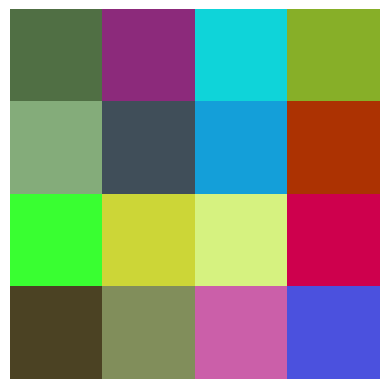

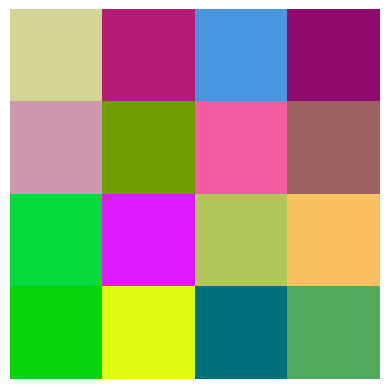

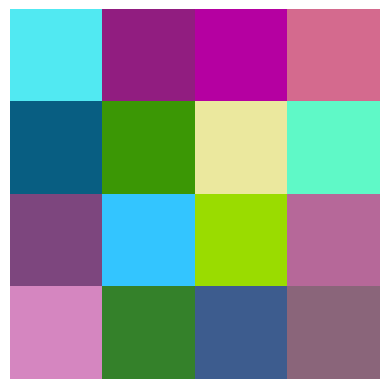

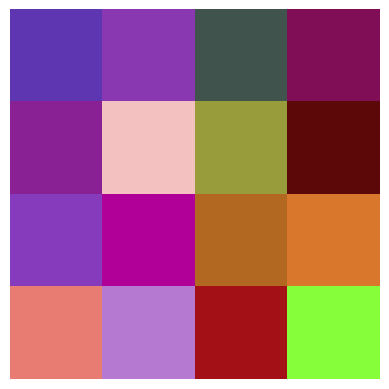

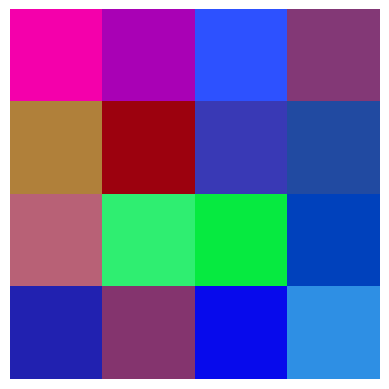

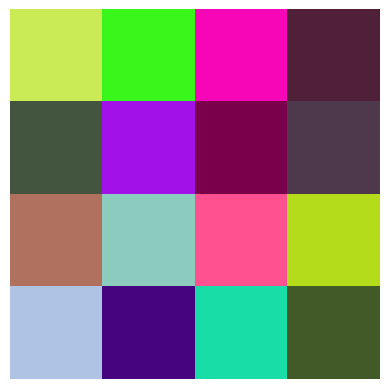

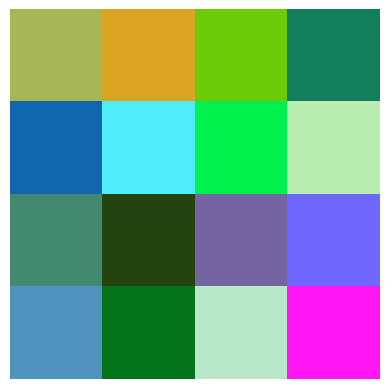

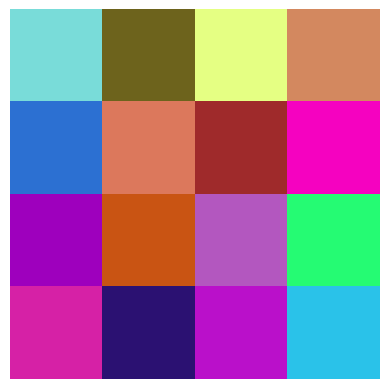

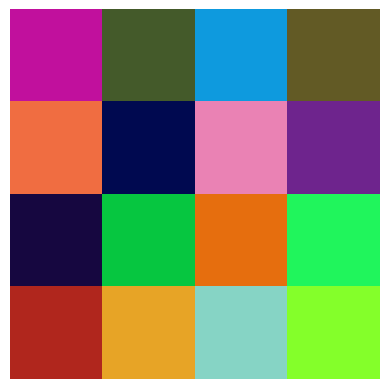

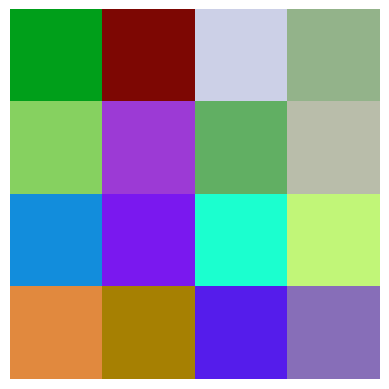

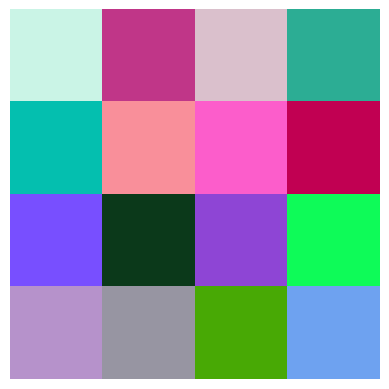

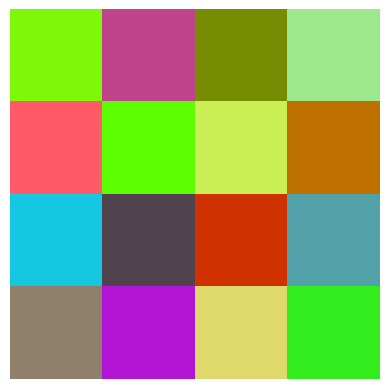

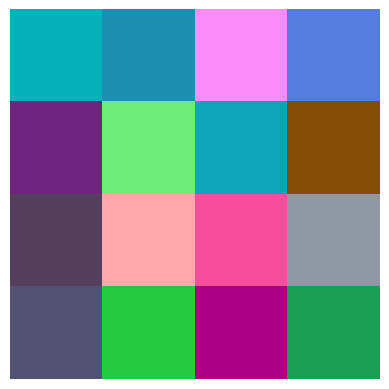

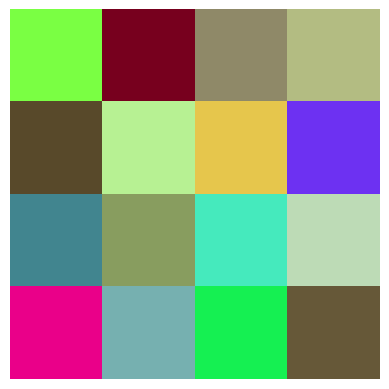

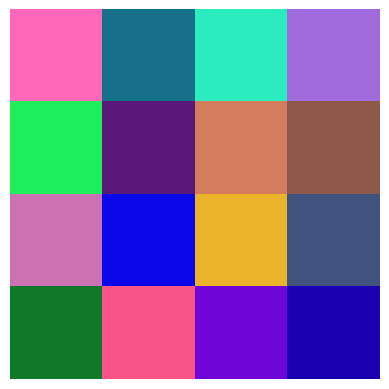

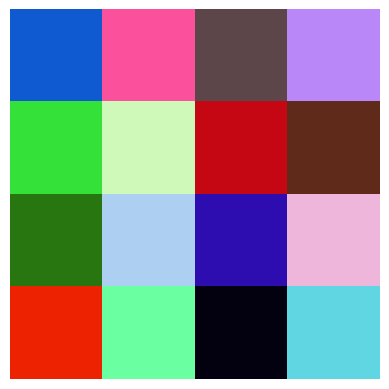

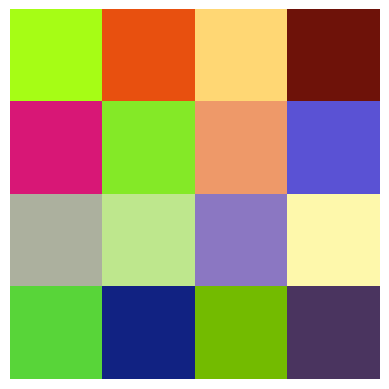

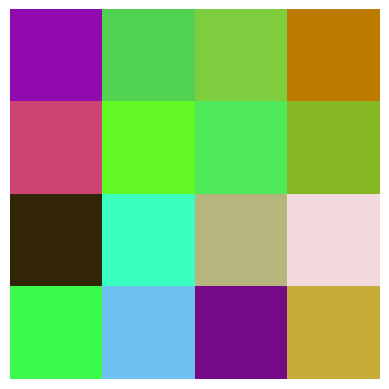

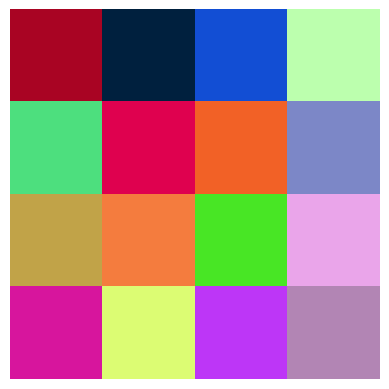

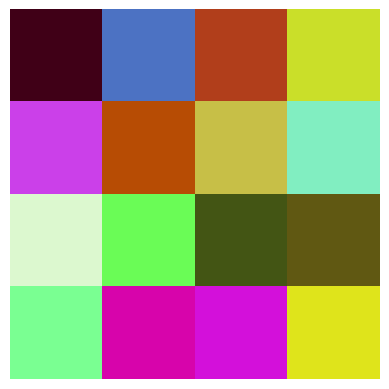

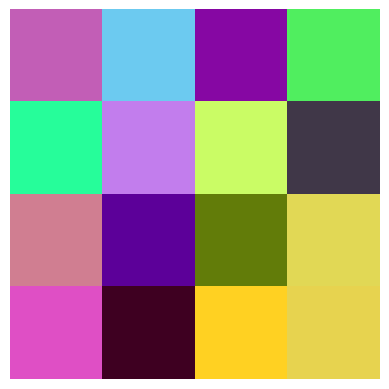

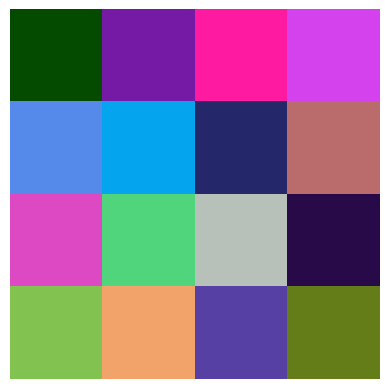

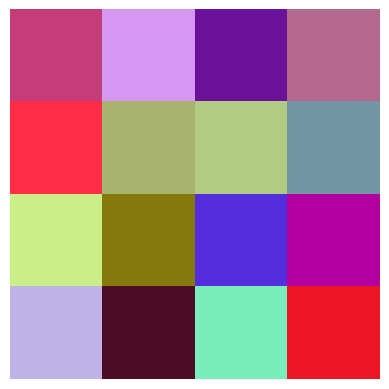

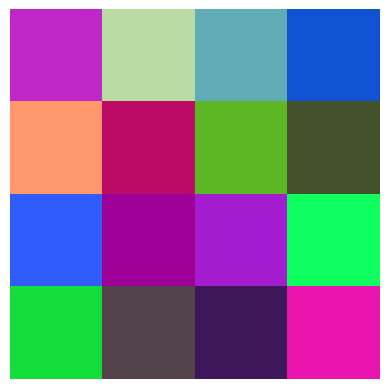

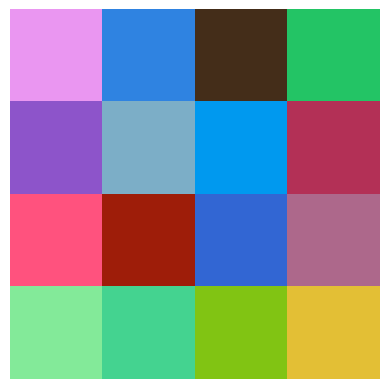

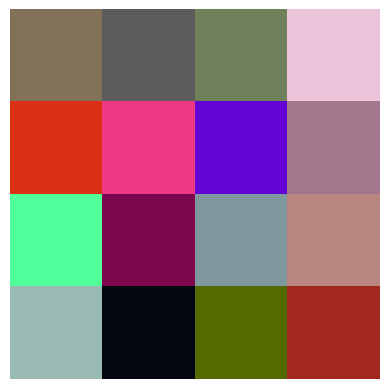

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
for i in range(num_windows):
    window = windows[i]  # Get a single window
    
    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)
    
    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())
    
    # Display the window image
    plt.imshow(window_np)
    plt.axis('off')
    plt.show()



# Applying Linear Embedding

#### ( 4x4x3 tensor  to 1x1x96 tensor) 


In [18]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding
    
    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """
    
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None
        
    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)
        
        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)
        
        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x

# Applying patch embedding on  patches

In [24]:
import os
from PIL import Image
import torchvision.transforms as transforms
# Replace `some_module` with the actual module containing PatchEmbed
from some_module import PatchEmbed  

# Update the image folder path
image_folder = r'E:\MAJOR PROJECT\Dataset\My MSL\My_MSL'

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()          # Convert the image to a tensor
])

# Define PatchEmbed
patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

# Process all images in the folder
for filename in os.listdir(image_folder):
    image_path = os.path.join(image_folder, filename)
    
    # Check if the file is an image
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Load the image
        image = Image.open(image_path)

        # Apply the transformation to the image
        tensor_image = transform(image)

        # Add batch dimension
        tensor_image = tensor_image.unsqueeze(0)  # Shape: (1, 3, 224, 224)

        # Apply PatchEmbed
        patches = patch_embed(tensor_image)

        # Print the shape of the patches
        print(f"Processed {filename} - Patches shape: {patches.shape}")




# image = Image.open(image_path)

# # Define the transformation
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize the image to 224x224
#     transforms.ToTensor()  # Convert the image to a tensor
# ])

# # Apply the transformation to the image
# tensor_image = transform(image)

# # Reshape the tensor to match the expected shape
# tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

# embedding = patch_embed(tensor_image)


# patches = patch_embed(tensor_image) 
# # Print the shape of the output patches
# print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

# embedding

ModuleNotFoundError: No module named 'some_module'

The output you are seeing is a tensor representing the embedded patches. Each element in the tensor corresponds to a patch in the image.

The output tensor you provided has the shape (1, 3136, 96), indicating that you have one image with 3136 patches, and each patch is represented by a 96-dimensional embedding vector.

# 1st patch embedding vector

In [11]:
print("First patch embedding vector:", patches[0, 0])

# 96 values in every patch because 96 is embedding dimension we mentioned above

#To access the second patch's embedding vector, you can use patches[0, 1]

First patch embedding vector: tensor([ 0.1975, -0.1677,  0.1375,  0.0485, -0.1009, -0.0177, -0.1350,  0.1713,
        -0.1178, -0.0638, -0.0803, -0.0266, -0.0195, -0.0390,  0.2809,  0.1566,
        -0.1026,  0.2352,  0.2090, -0.1213, -0.0382,  0.2156, -0.1937, -0.1560,
        -0.0935, -0.1721, -0.2792, -0.2036, -0.0942, -0.0195,  0.0545, -0.0669,
         0.0358, -0.0227,  0.0138,  0.0375,  0.1328,  0.2642,  0.0413, -0.0417,
        -0.1304,  0.0279, -0.0617, -0.1760,  0.0129,  0.0732, -0.0291,  0.0015,
         0.0602, -0.0357, -0.2727, -0.1687,  0.1821, -0.0672,  0.1786,  0.1284,
        -0.1911, -0.2640, -0.0527,  0.0112,  0.0024,  0.0247,  0.0878, -0.1171,
        -0.2940, -0.0147,  0.0266, -0.0660, -0.0172,  0.0787, -0.1000,  0.1865,
         0.0712, -0.0832,  0.0457,  0.0060,  0.0140, -0.0839, -0.0736,  0.0018,
        -0.0306, -0.0350,  0.2529,  0.1348,  0.0770, -0.2641, -0.1844, -0.0936,
         0.1987,  0.0133,  0.1977,  0.1053,  0.0741, -0.0696, -0.2928,  0.0714],
       gr

# Using BasicLayer : Swin Transformer layer for one stage

In [14]:
from swin_functions_and_classes import *


stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output


D:\tranformer_env\myvenv\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3136, 96])


tensor([[[-0.4375, -0.0989, -1.7152,  ...,  0.1818, -0.1971, -0.7790],
         [-0.3950, -0.1185, -1.6039,  ...,  0.1579, -0.1812, -0.8698],
         [-0.4853, -0.0943, -1.6845,  ...,  0.2287, -0.1518, -0.7712],
         ...,
         [-0.2573, -0.3719, -1.3803,  ...,  0.2644, -0.2439, -0.8014],
         [-0.2691, -0.3267, -1.3920,  ...,  0.2770, -0.2454, -0.7838],
         [-0.1932, -0.2515, -1.4256,  ...,  0.2629, -0.3870, -0.7697]]],
       grad_fn=<AddBackward0>)

# Patch Merging

##### USing patch merging on the embedding

In [15]:
# PatchMerging

# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [22]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


the output width and height are both reduced by a factor of 2 and the number of output channels is 2C where C is the number of input channels, here for Swin-T, C=96 .


### Let's create Stage-1 of the Swin-T architecture using SwinTransformerBlock:

Using SwinTransformerBlock class on the patch embedding embedding

In [20]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[ 0.1504,  0.1148, -0.9033,  ...,  0.0978, -0.7801, -0.2008],
         [ 0.1411,  0.1097, -0.7888,  ...,  0.0655, -0.7323, -0.3246],
         [ 0.0635,  0.0779, -0.8959,  ...,  0.1589, -0.7729, -0.1765],
         ...,
         [ 0.1194, -0.1146, -0.7391,  ...,  0.0918, -0.4939, -0.3880],
         [ 0.0892, -0.1149, -0.7574,  ...,  0.1381, -0.5396, -0.3606],
         [ 0.1661, -0.0649, -0.8302,  ...,  0.1806, -0.7550, -0.3030]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.1154,  0.4704,  0.0774,  ..., -0.5125, -0.1476,  0.6591],
         [ 0.1332,  0.4650,  0.1885,  ..., -0.5289, -0.0612,  0.5965],
         [-0.0441,  0.4990, -0.0768,  ..., -0.2634, -0.1453,  0.6601],
         ...,
         [ 0.0434,  0.2315,  0.0364,  ..., -0.3468,  0.2313,  0.6218],
         [ 0.0271,  0.2646,  0.0221,  ..., -0.3025,  0.2178,  0.6562],
         [ 0.1464,  0.3783, -0.1250,  ..., -0.2587,  0.1133,  0.6623]]],
       grad_fn=<AddBackward0>)


# SwinTransformer :

In [23]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

a tensor_image tensor  (1, 3, 224, 224), which represents a batch of 1 images with 3 channels and size 224x224.

1000 is the number of classes for the classification head.

torch.Size([1, 1000]) represents the shape of the output tensor when passing tensor_image through the model. In this case, it has a batch size of 1 and 1000 output dimensions, which matches the number of classes specified by num_classes.

# Now, Let's work with custom dataset

In [30]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
train_dir = os.path.join(current_directory, "custom_dataset", "train")
test_dir = os.path.join(current_directory, "custom_dataset", "test")
print(path)


D:\tranformer_env\L-4_Swin-Transformer\code\Swin_Image_classification\youtube_image_classification_training_from_scratch\custom_dataset\train


# Create Datasets and DataLoaders

In [31]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [32]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [33]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x25d881aafd0>,
 ['daisy', 'dandelion'])

torch.Size([3, 224, 224]) tensor(1)


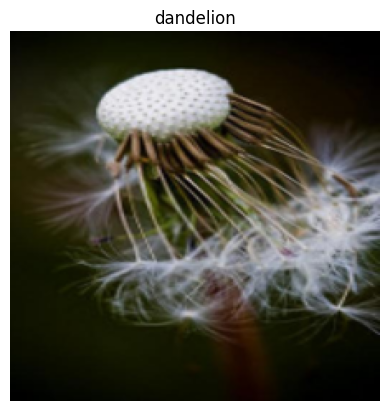

In [34]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [35]:
model = SwinTransformer(num_classes=len(class_names))

In [36]:
from going_modular.going_modular import engine
from helper_functions import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9513 | train_acc: 0.5264 | test_loss: 0.7674 | test_acc: 0.5990
Epoch: 2 | train_loss: 0.8641 | train_acc: 0.4808 | test_loss: 0.7117 | test_acc: 0.5990
Epoch: 3 | train_loss: 0.7186 | train_acc: 0.5048 | test_loss: 0.6757 | test_acc: 0.5990
Epoch: 4 | train_loss: 0.7559 | train_acc: 0.4832 | test_loss: 0.6839 | test_acc: 0.5990
Epoch: 5 | train_loss: 0.7319 | train_acc: 0.4567 | test_loss: 0.6782 | test_acc: 0.5990
Epoch: 6 | train_loss: 0.7066 | train_acc: 0.4712 | test_loss: 0.6733 | test_acc: 0.5990
Epoch: 7 | train_loss: 0.7015 | train_acc: 0.4880 | test_loss: 0.7049 | test_acc: 0.4010
Epoch: 8 | train_loss: 0.6940 | train_acc: 0.4928 | test_loss: 0.6854 | test_acc: 0.5990
Epoch: 9 | train_loss: 0.6971 | train_acc: 0.4856 | test_loss: 0.6970 | test_acc: 0.4010
Epoch: 10 | train_loss: 0.6976 | train_acc: 0.4591 | test_loss: 0.7008 | test_acc: 0.4010


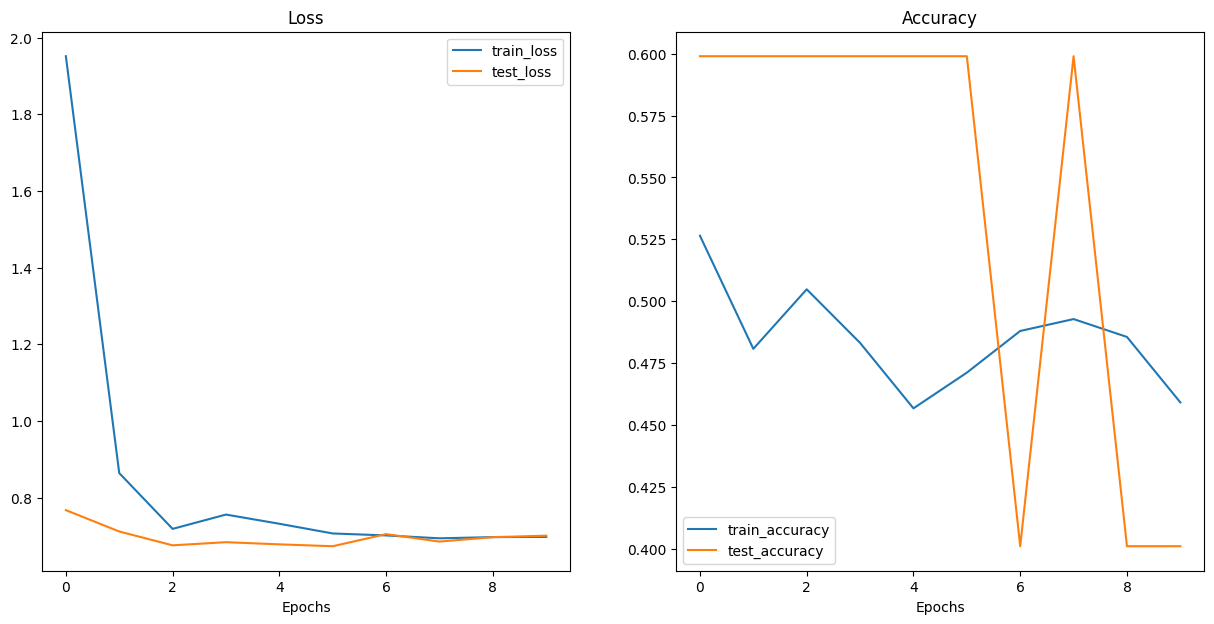

In [37]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

# Prediction

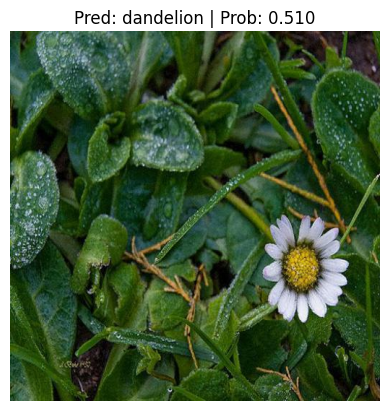

In [38]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)